In [1]:
import importlib
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from flearn.utils.model_utils import read_data
import os
import importlib
import random
import numpy as np

from flearn.models import client
from flearn.models import group
from flearn.trainers import grouprox
from flearn.trainers import fedprox
from flearn.trainers import fedavg

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
params = {}
#DATASETS = ['sent140', 'nist', 'shakespeare', 'mnist', 'synthetic_iid', 'synthetic_0_0', 'synthetic_0.5_0.5', 'synthetic_1_1']

"""
Parameters that need to be manually set
"""

params['dataset'] = 'sent140'
#params['dataset'] = 'nist'
#params['model'] = 'mlp'
params['model'] = 'stacked_lstm'
params['optimizer'] = 'grouprox'
params['drop_percent'] = 0

if params['dataset'].startswith('mnist'):
  params['model_params'] = (10,)
  params['learning_rate'] = 0.03
  params['mu'] = 1
  params['num_group'] = 3
if params['dataset'] == 'nist':
  params['model_params'] = (26,)
  params['learning_rate'] = 0.003
  params['mu'] = 1
  params['num_group'] = 5
if params['dataset'] == 'sent140':
  params['model_params'] = (25, 2, 100) # seq_len, num_classes, num_hidden
  params['learning_rate'] = 0.3
  params['mu'] = 0.01
  params['num_group'] = 5
if params['dataset'].startswith('synthetic'):
  params['model_params'] = (10,)
  params['learning_rate'] = 0.01
  params['mu'] = 1
  params['num_group'] = 5

if params['optimizer']  == 'fedavg':
  pass
if params['optimizer']  == 'fedprox':
  pass
if params['optimizer']  == 'grouprox':
  params['proximal'] = False
  params['RAC'] = False
  params['RCC'] = False
  params['allow_empty'] = True
  
  # TEST Hyperparameters
  params['evenly'] = False
  params['min_clients'] = 2

"""
Common parameters
"""
params['num_rounds'] = 200
params['num_epochs'] = 20
params['batch_size'] = 10
params['eval_every'] = 1
params['clients_per_round'] = 20 ################ Important ######################
params['seed'] = 233
params['agg_lr'] = 0.01


""" Set the output CSV file name """
info = '{}-{}-{}'.format(params['optimizer'], params['dataset'], params['model'])
info2 = ''
suffix = '.csv'
if params['optimizer'] == 'fedavg':
  pass
if params['optimizer'] == 'fedprox':
  pass
if params['optimizer'] == 'grouprox':
  
  info2 = '-NumG{:1d}-Agglr{:.4}-Proximal{:.1}'.format(
    params['num_group'], params['agg_lr'], str(params['proximal']))
  
  if params['RCC'] == True:
    info2 = info2 + '-RCC.{:.1}'.format(str(params['RCC']))
  
  if params['RAC'] == True:
    info2 = info2 + '-RAC.{:.1}-Evenly{:.1}'.format(str(params['RAC']), str(params['evenly']))
  elif params['allow_empty'] == True:
    info2 = info2 + '-Empty{:.1}'.format(str(params['allow_empty']))
  elif params['allow_empty'] == False:
    info2 = info2 + '-Evenly{:.1}'.format(str(params['evenly']))

params['export_filename'] = info + info2 + suffix

print(params['export_filename'])

grouprox-sent140-stacked_lstm-NumG5-Agglr0.01-ProximalF-RCC.T-EmptyT.csv


In [3]:
"""
Some preparations
"""

# read data
train_path = os.path.join('data', params['dataset'], 'data', 'train')
test_path = os.path.join('data', params['dataset'], 'data', 'test')
dataset = read_data(train_path, test_path)

# Load model
if params['dataset'].startswith('synthetic'):  # all synthetic datasets use the same model
  model_path = '%s.%s.%s.%s' % ('flearn', 'models', 'synthetic', params['model'])
elif params['dataset'].startswith('mnist'):
  model_path = '%s.%s.%s.%s' % ('flearn', 'models', 'mnist', params['model'])
else:
  model_path = '%s.%s.%s.%s' % ('flearn', 'models', params['dataset'], params['model'])
mod = importlib.import_module(model_path)
learner = getattr(mod, 'Model')

# Set seeds
random.seed(1 + params['seed'])
np.random.seed(12 + params['seed'])
tf.set_random_seed(123 + params['seed'])

# Set server
if params['optimizer'] == 'fedavg':
  server = fedavg.Server(params, learner, dataset)  
if params['optimizer'] == 'fedprox':
  server = fedprox.Server(params, learner, dataset)
if params['optimizer'] == 'grouprox':
  server = grouprox.Server(params, learner, dataset)

Using Group prox to Train
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`
772 Clients in Total


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

243861 Parameters in Total


Instructions for updating:
Prefer Variable.assign which has equivalent behavior in 2.X.


In [4]:
"""
Test Ternary Similarity
"""
x, y = server.test_ternary_cosine_similariy()

Delta w shape: (772, 243861) Matrix V shape: (243861, 3)
(772, 772) (772, 772)
(298378,) (298378,)


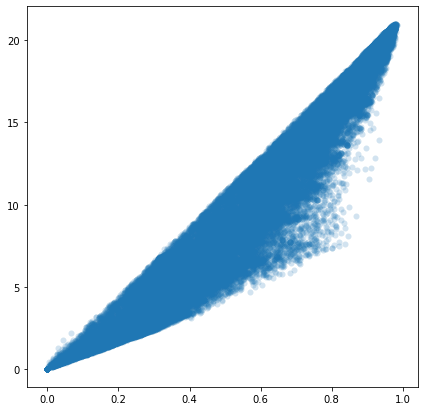

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7,7))
plt.scatter(x[:50000], y[:50000], linewidths=0.01, alpha=0.2, norm=True)
plt.show()

In [4]:
server.train()

Training with 20 workers ---


Group 0, clients ['m0po', 'debbier93', 'maddisondesigns', 'weelissa', 'AvonteNikole', 'janabelle_xo', 'nyc_specialist', 'WooopJess']
Group 1, clients ['TinaS71', 'coriluvnthedon', 'Mrs_NickJ07', 'mneylon', 'davidj505', 'MacSheikh']
Group 2 is empty.
Group 3, clients ['steph_davies', 'marianaguidil', 'schaeferj89', 'weeps']
Group 4, clients ['AllTheSausages', 'Japh']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 0 accuracy: 0.7088293650793651
At round 0 training accuracy: 0.746534135495684
At round 0 training loss: 0.7712698973327478
Group 1
At round 0 accuracy: 0.8778718258766627
At round 0 training accuracy: 0.9037603569152326
At round 0 training loss: 0.32027936305210475
Group 2
At round 0 accuracy: 0.7129629629629629
At round 0 training accuracy: 0.6883223684210527
At round 0 training loss: 0.7212327527017087
Group 3
At round 0 accuracy: 0.4558898521162672
At round 0 training accuracy: 0.46537949400798934
At round 0 training loss: 0.8812114194928409
Group 4
At round 0 accuracy: 0.7097532314923619
At round 0 training accuracy: 0.7308460003070781
At round 0 training loss: 0.5892342742221908
At round 0 mean test accuracy: 0.7001414427157001 mean train accuracy: 0.7216322486764296
The groups difference are: [3.84024267 3.61642389 3.62508245 3.87251455 3.41046387]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.18it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.74it/s] 

Begin group  4 training


Group 0, clients ['bexiclepop', 'Christyxcore', 'webwoke', 'nyc_specialist', 'pearlbones', 'Andjelija']
Group 1, clients ['HelloLizzi', 'mrshananto', 'xmiyix', 'fuseboxradio']
Group 2, clients ['funkybrownchick', 'christian792']
Group 3, clients ['Tracey_Mac', 'sophieholly', 'Rawrrgasmic', 'crucifire', 'thepete']
Group 4, clients ['dollforlife', 'Whatever_Ista', 'IzzySc']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.86it/s]

Group 0
At round 1 accuracy: 0.7088293650793651
At round 1 training accuracy: 0.746534135495684
At round 1 training loss: 0.5802232850515465
Group 1
At round 1 accuracy: 0.8778718258766627
At round 1 training accuracy: 0.9037603569152326
At round 1 training loss: 0.3331515280031648
Group 2
At round 1 accuracy: 0.7129629629629629
At round 1 training accuracy: 0.6883223684210527
At round 1 training loss: 0.7206023104464341
Group 3
At round 1 accuracy: 0.5578786333503315
At round 1 training accuracy: 0.5671105193075899
At round 1 training loss: 0.6840149173088937
Group 4
At round 1 accuracy: 0.7103407755581669
At round 1 training accuracy: 0.7323813910640258
At round 1 training loss: 0.8633677181598322
At round 1 mean test accuracy: 0.7238330975954739 mean train accuracy: 0.7455958388804607
The groups difference are: [6.58465279 6.51004493 6.27029142 6.95708545 7.04127837]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 10.82it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.02it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['shinsh0ku', 'NOTICEmeDAVID', 'crazymitchell']
Group 1, clients ['alyb_', '_Alectrona_']
Group 2, clients ['xXMCR_LadyXx', 'claudiamcfly']
Group 3, clients ['irishsamom', 'peggyrossmanith', 'vesula', 'chelseasms', 'Rikou26']
Group 4, clients ['iamloz_JsPR', 'DanielJUK', 'Upstatemomof3', 'MrTHill', 'juliarygaard', 'Galiiit', 'NoTORIousTori', 'ashleyyosaurus']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 2 accuracy: 0.7088293650793651
At round 2 training accuracy: 0.746534135495684
At round 2 training loss: 0.5733838814334847
Group 1
At round 2 accuracy: 0.8778718258766627
At round 2 training accuracy: 0.9037603569152326
At round 2 training loss: 0.47274553476223796
Group 2
At round 2 accuracy: 0.7006172839506173
At round 2 training accuracy: 0.7080592105263158
At round 2 training loss: 0.5766522409394383
Group 3
At round 2 accuracy: 0.5216726160122387
At round 2 training accuracy: 0.5067909454061251
At round 2 training loss: 0.735258337414852
Group 4
At round 2 accuracy: 0.4706227967097532
At round 2 training accuracy: 0.46322739137110397
At round 2 training loss: 0.7050599292659657
At round 2 mean test accuracy: 0.6669024045261669 mean train accuracy: 0.6780395677884764
The groups difference are: [11.78438557 11.07921515 11.03974743 11.5391316  11.47049734]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.72it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.01it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.41it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.40it/s] 

Begin group  4 training


Group 0, clients ['MissPassion', 'LorenYxox', 'uyennguyen_', 'iamgaberosales']
Group 1, clients ['AsiaBrands', 'DaPrbmChild', 'petehopkins', 'AlexLJ', 'aliefaulkner', 'DustinUrbanski', 'heyisabelle_', 'MelFresh27']
Group 2, clients ['Rianca', 'xXMCR_LadyXx']
Group 3, clients ['andrewpycroft', 'JaydDragyn']
Group 4, clients ['CaraNinaMcfly', 'Frassington', 'Matalatine', 'ElementsOfJazz']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.05it/s]

Group 0
At round 3 accuracy: 0.7088293650793651
At round 3 training accuracy: 0.746534135495684
At round 3 training loss: 0.6009316152493243
Group 1
At round 3 accuracy: 0.8347440548166062
At round 3 training accuracy: 0.8548969619715318
At round 3 training loss: 0.42205210898373463
Group 2
At round 3 accuracy: 0.6450617283950617
At round 3 training accuracy: 0.6842105263157895
At round 3 training loss: 0.7195391735539919
Group 3
At round 3 accuracy: 0.5359510453850076
At round 3 training accuracy: 0.5245006657789614
At round 3 training loss: 0.9686398400050822
Group 4
At round 3 accuracy: 0.5423031727379554
At round 3 training accuracy: 0.5467526485490557
At round 3 training loss: 0.68740462922801
At round 3 mean test accuracy: 0.6698491277699199 mean train accuracy: 0.6838601814297657
The groups difference are: [14.30412858 14.10810757 14.28700918 14.82362186 14.42759504]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.79it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.51it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.59it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['redvers', 'tannwick', 'janabelle_xo']
Group 1, clients ['Joy_Inc', 'DNiCESEOUL', 'mp3mad', 'DaPrbmChild', 'pensblogtweet', 'Speed2007', 'SusanCosmos']
Group 2, clients ['goatkeeper7', 'toastedfrenchie']
Group 3, clients ['OMGitsJessieLee', 'andrewpycroft', 'clairabellejp', 'DivasMistress', 'sinspired', 'lauralovesart']
Group 4, clients ['DanielJUK', 'adlyman']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.98it/s]

Group 0
At round 4 accuracy: 0.7048611111111112
At round 4 training accuracy: 0.7445723253989014
At round 4 training loss: 0.5855606945590639
Group 1
At round 4 accuracy: 0.8029020556227328
At round 4 training accuracy: 0.818674314850223
At round 4 training loss: 0.42526456602242235
Group 2
At round 4 accuracy: 0.6388888888888888
At round 4 training accuracy: 0.6825657894736842
At round 4 training loss: 0.6068503109150027
Group 3
At round 4 accuracy: 0.4798572157062723
At round 4 training accuracy: 0.4952063914780293
At round 4 training loss: 1.5324719395999427
Group 4
At round 4 accuracy: 0.6562867215041128
At round 4 training accuracy: 0.680178105327806
At round 4 training loss: 0.8911586262316596
At round 4 mean test accuracy: 0.6692597831211693 mean train accuracy: 0.6928697482894207
The groups difference are: [17.96673409 17.73792725 18.7272248  19.00783362 18.88248196]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.42it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.88it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['eysies', 'paigeebaby', 'Miamoodles', 'Extremo', 'nicolalalalala', 'jonasnessica']
Group 1, clients ['valenbfm', 'alltimeASIAN', 'winniedepoohi', 'simontay78', 'mattdavey2', 'VickyMinor']
Group 2, clients ['briethehippo']
Group 3, clients ['amysav83', 'alwaysloveu_Ci', 'chelseasms', 'AliciaWag', 'AtlantisJackson']
Group 4, clients ['stratosphear', 'megspeaks']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 5 accuracy: 0.42162698412698413
At round 5 training accuracy: 0.40230185718022493
At round 5 training loss: 0.8524288512199236
Group 1
At round 5 accuracy: 0.8778718258766627
At round 5 training accuracy: 0.903229233057149
At round 5 training loss: 0.6309257629249136
Group 2
At round 5 accuracy: 0.7006172839506173
At round 5 training accuracy: 0.7228618421052632
At round 5 training loss: 1.0115969852218099
Group 3
At round 5 accuracy: 0.49209586945436
At round 5 training accuracy: 0.5182423435419441
At round 5 training loss: 1.15168038533626
Group 4
At round 5 accuracy: 0.6410105757931844
At round 5 training accuracy: 0.6993704897896514
At round 5 training loss: 0.8194927309041893
At round 5 mean test accuracy: 0.626001885902876 mean train accuracy: 0.6472336604848448
The groups difference are: [21.09854355 20.72919321 21.78229626 21.95101788 22.70318595]
Begin group  0 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 10.68it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.78it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.71it/s] 

Begin group  4 training


Group 0, clients ['Rubyam', 'mossyrants', 'evil_cackle', 'diiilxia', 'NikFreeman']
Group 1, clients ['vulcansmuse', 'sheryonstone', 'RandomShelly', 'LadyParadis', 'authenticstyle', 'wiseleo', 'twilightfairy', 'zoeyjordan', 'AlexTrup']
Group 2, clients ['IamMaxatHotSpot']
Group 3, clients ['SpiderxBear', '__DalekCaan__', 'gracieh89', 'MelanieFresh27']
Group 4, clients ['Japh']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.80it/s]

Group 0
At round 6 accuracy: 0.6780753968253969
At round 6 training accuracy: 0.694873136280408
At round 6 training loss: 0.626759532526264
Group 1
At round 6 accuracy: 0.7549375251914551
At round 6 training accuracy: 0.771935415338857
At round 6 training loss: 0.456198410671786
Group 2
At round 6 accuracy: 0.6419753086419753
At round 6 training accuracy: 0.7039473684210527
At round 6 training loss: 0.96871144787943
Group 3
At round 6 accuracy: 0.49260581336053033
At round 6 training accuracy: 0.5131824234354194
At round 6 training loss: 1.19831979685871
Group 4
At round 6 accuracy: 0.38777908343125733
At round 6 training accuracy: 0.3671119299861815
At round 6 training loss: 0.9704602688537222
At round 6 mean test accuracy: 0.598066949552098 mean train accuracy: 0.609337750394749
The groups difference are: [23.86504042 23.52429999 24.84206477 25.07226306 25.73823801]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.99it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.44it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.06it/s] 

Begin group  3 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 10.93it/s] 

Begin group  4 training


Group 0, clients ['HeathCastor', 'NatalieGolding', 'xoCAZZA', 'vickyjones91']
Group 1, clients ['music_flurry', 'carlos_teran', 'traciknoppe', 'TinaS71', 'RandomShelly', 'imafanatic', 'ddaly9', 'Commsguy']
Group 2, clients ['briethehippo']
Group 3, clients ['kyoisorange', 'alwaysloveu_Ci', 'ksekher', 'megspptc', 'AyyoItsAmandaJo']
Group 4, clients ['PaulineMJ', 'wolfchild59']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 7 accuracy: 0.6676587301587301
At round 7 training accuracy: 0.6876798325922051
At round 7 training loss: 1.0900388299324313
Group 1
At round 7 accuracy: 0.8778718258766627
At round 7 training accuracy: 0.9037603569152326
At round 7 training loss: 0.45108831287458506
Group 2
At round 7 accuracy: 0.6141975308641975
At round 7 training accuracy: 0.6702302631578947
At round 7 training loss: 1.2072811163778074
Group 3
At round 7 accuracy: 0.5073941866394697
At round 7 training accuracy: 0.5111850865512649
At round 7 training loss: 1.3794639927490098
Group 4
At round 7 accuracy: 0.6874265569917744
At round 7 training accuracy: 0.7052049746660525
At round 7 training loss: 1.174023026656248
At round 7 mean test accuracy: 0.694012258368694 mean train accuracy: 0.7124988389733429
The groups difference are: [26.44235523 25.94448493 27.74933179 27.75279956 28.19001801]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.03it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.52it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.51it/s] 

Begin group  4 training


Group 0, clients ['kellygirl27', 'fromthestars', 'Impala_Guy', 'ehammond84', 'LiluYvett']
Group 1, clients ['PaulCarterJr', 'pagan_spell', 'MissGoogle', 'SandiNJ', 'dyeleepong', 'tweeteradder2', 'vulcansmuse']
Group 2 is empty.
Group 3, clients ['MAGGIECHICKEN', 'MrsBamBam', 'TwistedHelen', 'rbuerckner', 'DubarryMcfly']
Group 4, clients ['esmeg', 'koast08', 'pdurham']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.56it/s]

Group 0
At round 8 accuracy: 0.6488095238095238
At round 8 training accuracy: 0.679440230185718
At round 8 training loss: 0.7868642291556455
Group 1
At round 8 accuracy: 0.7980652962515115
At round 8 training accuracy: 0.8125132780964521
At round 8 training loss: 0.46209585542712633
Group 2
At round 8 accuracy: 0.6141975308641975
At round 8 training accuracy: 0.6825657894736842
At round 8 training loss: 1.0816752970139005
Group 3
At round 8 accuracy: 0.5436002039775625
At round 8 training accuracy: 0.5548601864181092
At round 8 training loss: 1.3409877672731956
Group 4
At round 8 accuracy: 0.672737955346651
At round 8 training accuracy: 0.6766467065868264
At round 8 training loss: 0.6563497016127164
At round 8 mean test accuracy: 0.6716171617161716 mean train accuracy: 0.6888138951670331
The groups difference are: [28.4747918  27.77045938 29.58697939 29.60613709 30.30290572]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.09it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.72it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['tweetpet', 'isdown', 'xDirtyBurdx', 'SheBeeGee']
Group 1, clients ['smuttysteff', 'effingcards', 'minette95', 'jun6lee', 'nandeb', 'makeupbylinvia', 'chaosbot', 'mOFrIz']
Group 2, clients ['Bia_Loves_NKOTB']
Group 3, clients ['kissmybleep', 'krapposelli', 'davidrules04', 'ScottRhodie']
Group 4, clients ['Jenivere', 'Upstatemomof3', 'KnightRid']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 9 accuracy: 0.6135912698412699
At round 9 training accuracy: 0.6009678263144128
At round 9 training loss: 1.0707020233150182
Group 1
At round 9 accuracy: 0.8762595727529222
At round 9 training accuracy: 0.901954535797748
At round 9 training loss: 0.4931089184080261
Group 2
At round 9 accuracy: 0.6141975308641975
At round 9 training accuracy: 0.6825657894736842
At round 9 training loss: 1.0789580977239224
Group 3
At round 9 accuracy: 0.5486996430392657
At round 9 training accuracy: 0.5458055925432757
At round 9 training loss: 1.1078249666090811
Group 4
At round 9 accuracy: 0.699177438307873
At round 9 training accuracy: 0.7214801166896976
At round 9 training loss: 0.6063942651667756
At round 9 mean test accuracy: 0.6925978312116926 mean train accuracy: 0.7032415864268243
The groups difference are: [29.5272889  28.60793167 30.31757699 30.49443484 31.13374797]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.90it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.31it/s] 

Begin group  2 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 10.94it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.57it/s] 

Begin group  4 training


Group 0, clients ['PaulDale67', 'tynie626', 'BrandyWandLover', 'neondeception']
Group 1, clients ['BostinBloke', 'Morrica', 'syarif_m2e', 'AsiaBrands', 'Minerveca', 'MacSheikh']
Group 2, clients ['goatkeeper7']
Group 3, clients ['Rawrrgasmic', 'minorityx', 'MAGGIECHICKEN', 'AyyoItsAmandaJo', 'PapiChulaa', 'lucysavagex']
Group 4, clients ['GinaLaGuardia', 'bacieabbracci', 'ashleyyosaurus']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 10 accuracy: 0.7088293650793651
At round 10 training accuracy: 0.7453570494376145
At round 10 training loss: 1.694827000140956
Group 1
At round 10 accuracy: 0.8133817009270455
At round 10 training accuracy: 0.8210112598257914
At round 10 training loss: 0.4644996902472353
Group 2
At round 10 accuracy: 0.6604938271604939
At round 10 training accuracy: 0.6833881578947368
At round 10 training loss: 0.6484916753650299
Group 3
At round 10 accuracy: 0.5441101478837328
At round 10 training accuracy: 0.5640479360852197
At round 10 training loss: 1.4380912925170042
Group 4
At round 10 accuracy: 0.5881316098707403
At round 10 training accuracy: 0.6150775372332259
At round 10 training loss: 0.7456061679125747
At round 10 mean test accuracy: 0.6752710985384253 mean train accuracy: 0.6966469550140871
The groups difference are: [32.05987656 30.83869129 33.09957156 32.87369523 33.41886323]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.93it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.80it/s] 

Begin group  2 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.28it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.88it/s] 

Begin group  4 training


Group 0, clients ['MCbutterflyfan', 'ehammond84', 'abcdefglynis', 'WooopJess']
Group 1, clients ['MichaelMcNeill', 'fuseboxradio', 'SarahRoseMusic', 'mixmasterfestus', 'wiseleo', 'nikipaniki', 'brampitoyo', 'markdavidson']
Group 2, clients ['lejunkdrawer']
Group 3, clients ['Broooooke_', 'neszlifeasmcrmy', 'LisaHopeCyrus', 'angel9293']
Group 4, clients ['ponor', 'KnightRid', 'xPurplexMuffinx']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.90it/s]

Group 0
At round 11 accuracy: 0.5302579365079365
At round 11 training accuracy: 0.5204028250065393
At round 11 training loss: 0.7913599299169978
Group 1
At round 11 accuracy: 0.8778718258766627
At round 11 training accuracy: 0.9038665816868494
At round 11 training loss: 0.6578907133438484
Group 2
At round 11 accuracy: 0.6512345679012346
At round 11 training accuracy: 0.6685855263157895
At round 11 training loss: 2.0436797139122254
Group 3
At round 11 accuracy: 0.5196328403875574
At round 11 training accuracy: 0.5420772303595206
At round 11 training loss: 0.9005339409158963
Group 4
At round 11 accuracy: 0.6169212690951822
At round 11 training accuracy: 0.636419468754798
At round 11 training loss: 1.0033232602274365
At round 11 mean test accuracy: 0.6514615747289014 mean train accuracy: 0.6661816155298925
The groups difference are: [33.12957378 31.85098682 34.1191146  34.06069821 34.41577959]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.37it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.91it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.13it/s] 

Begin group  4 training


Group 0, clients ['katherinemarsh', 'eysies', 'kellygirl27', 'redvers', 'nyc_specialist', 'IvanaE']
Group 1, clients ['iHaps', 'kayasmith', 'perpetualspiral', 'PaulHarriott', 'Joy_Inc', 'RGM77', 'minxkitty']
Group 2, clients ['Rianca']
Group 3, clients ['brianwelburn', 'davidrules04', 'megspptc', 'gracieh89']
Group 4, clients ['KatyCaptivated', 'hortovanyi']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 12 accuracy: 0.6051587301587301
At round 12 training accuracy: 0.6232016740779492
At round 12 training loss: 0.9219643184513228
Group 1
At round 12 accuracy: 0.871825876662636
At round 12 training accuracy: 0.8966432972169109
At round 12 training loss: 0.40077339940685636
Group 2
At round 12 accuracy: 0.7037037037037037
At round 12 training accuracy: 0.7014802631578947
At round 12 training loss: 0.6175714991741666
Group 3
At round 12 accuracy: 0.5369709331973483
At round 12 training accuracy: 0.5581890812250333
At round 12 training loss: 1.2307558121608593
Group 4
At round 12 accuracy: 0.6245593419506463
At round 12 training accuracy: 0.6634423460770766
At round 12 training loss: 0.9425036602080299
At round 12 mean test accuracy: 0.675035360678925 mean train accuracy: 0.6988451654849995
The groups difference are: [36.1878532  34.74772166 37.26421393 37.85885799 37.47988896]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.59it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.65it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.25it/s] 

Begin group  4 training


Group 0, clients ['paigeebaby', 'JeniPoynter_x', 'koltregaskes', 'eboogiee', 'b1ng0bang0', 'socilover', 'Vibhy', 'abcdefglynis']
Group 1, clients ['amilya', 'Speaker99', 'AClockworkToad', 'shanajaca', 'xdevinnbabyy']
Group 2, clients ['xXMCR_LadyXx', 'Christiegarcia']
Group 3, clients ['JoshwaActon', 'crucifire', 'weeps']
Group 4, clients ['hortovanyi', 'mr_billiam']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.69it/s]

Group 0
At round 13 accuracy: 0.6433531746031746
At round 13 training accuracy: 0.6778707821082919
At round 13 training loss: 1.0515801001853804
Group 1
At round 13 accuracy: 0.7029423619508263
At round 13 training accuracy: 0.7256214149139579
At round 13 training loss: 0.5950633009159845
Group 2
At round 13 accuracy: 0.5462962962962963
At round 13 training accuracy: 0.6044407894736842
At round 13 training loss: 1.2953743519289052
Group 3
At round 13 accuracy: 0.5532891381947985
At round 13 training accuracy: 0.5677762982689747
At round 13 training loss: 1.5243249291784753
Group 4
At round 13 accuracy: 0.6321974148061105
At round 13 training accuracy: 0.6615998771687395
At round 13 training loss: 0.7823186113860738
At round 13 mean test accuracy: 0.634016973125884 mean train accuracy: 0.6601442769125979
The groups difference are: [38.54257245 37.09225937 39.83911093 40.68845364 40.02771362]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.28it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.25it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.31it/s] 

Begin group  4 training


Group 0 is empty.
Group 1, clients ['vulcansmuse', 'dudeman718', 'vickymoontree', 'LittlestarRed', 'davidj505', 'tweeteradder5']
Group 2, clients ['Nimilia1621']
Group 3, clients ['__DalekCaan__', 'theknickermafia', 'Mum_of_Six', 'hannahkin', 'Bopsicle', 'Bowl_the_Bunny', 'neszlifeasmcrmy']
Group 4, clients ['KatyCaptivated', 'ponor', 'Cherye101', 'JoReynolds55', 'Hetty4Christ', 'rockbigdave']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.96it/s]

Group 0
At round 14 accuracy: 0.6016865079365079
At round 14 training accuracy: 0.6245095474758043
At round 14 training loss: 1.0553821775143353
Group 1
At round 14 accuracy: 0.8702136235388956
At round 14 training accuracy: 0.8963246229020607
At round 14 training loss: 0.6230734104705657
Group 2
At round 14 accuracy: 0.6790123456790124
At round 14 training accuracy: 0.7080592105263158
At round 14 training loss: 1.1723649936741964
Group 3
At round 14 accuracy: 0.5211626721060684
At round 14 training accuracy: 0.5360852197070572
At round 14 training loss: 0.8866689224773335
Group 4
At round 14 accuracy: 0.5710928319623971
At round 14 training accuracy: 0.6043298019345924
At round 14 training loss: 1.005829168074365
At round 14 mean test accuracy: 0.6584158415841584 mean train accuracy: 0.6822502244651537
The groups difference are: [39.74873621 38.45319733 41.02400324 41.83867008 41.3062157 ]
Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.21it/s] 

Begin group  2 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 10.93it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.63it/s] 

Begin group  4 training


Group 0, clients ['DrewDrew2009', 'katherinemarsh', 'hannah106', 'iamgaberosales']
Group 1, clients ['clevertitania', 'Rocks4Ever', 'alyb_', 'tweeteradder3', 'gschan', 'lameymacdonald']
Group 2, clients ['wisdompathart', 'Christiegarcia']
Group 3, clients ['tracyewilli', 'alwaysloveu_Ci', 'angel9293']
Group 4, clients ['ashleyyosaurus', 'KnightRid', 'jessiiemcfly', 'juliarygaard', 'DivaWonderGirl']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 15 accuracy: 0.6031746031746031
At round 15 training accuracy: 0.6243787601360188
At round 15 training loss: 1.0533655217741287
Group 1
At round 15 accuracy: 0.8351471180975413
At round 15 training accuracy: 0.863819842787338
At round 15 training loss: 0.5130767636724408
Group 2
At round 15 accuracy: 0.6635802469135802
At round 15 training accuracy: 0.6430921052631579
At round 15 training loss: 1.1531700775223344
Group 3
At round 15 accuracy: 0.5150433452320244
At round 15 training accuracy: 0.5356857523302264
At round 15 training loss: 1.5144605968350895
Group 4
At round 15 accuracy: 0.6874265569917744
At round 15 training accuracy: 0.7039766620604944
At round 15 training loss: 0.7652565663482815
At round 15 mean test accuracy: 0.6698491277699199 mean train accuracy: 0.6903000092882132
The groups difference are: [41.06386129 39.83362124 42.9367179  43.28760832 42.82903559]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.52it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.64it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.36it/s] 

Begin group  3 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 10.63it/s] 

Begin group  4 training


Group 0, clients ['fromthestars', 'jaronmc', 'nyc_specialist', 'ericbutcher', 'andie_12', 'vickyjones91']
Group 1, clients ['markdavidson', 'VickiElam', 'clevertitania', 'mneylon', 'mandiebear', 'gschan', 'PaulHarriott']
Group 2, clients ['funkybrownchick']
Group 3, clients ['LiverpoolFan74']
Group 4, clients ['Cherye101', 'johnhood', 'koast08', 'tamaryn', 'lorettak']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.66it/s]

Group 0
At round 16 accuracy: 0.5758928571428571
At round 16 training accuracy: 0.6021449123724824
At round 16 training loss: 0.8334360587645225
Group 1
At round 16 accuracy: 0.8524788391777509
At round 16 training accuracy: 0.875717017208413
At round 16 training loss: 0.5293246935918865
Group 2
At round 16 accuracy: 0.6697530864197531
At round 16 training accuracy: 0.680921052631579
At round 16 training loss: 0.9092111880768483
Group 3
At round 16 accuracy: 0.5446200917899031
At round 16 training accuracy: 0.5615179760319574
At round 16 training loss: 1.6664369694402468
Group 4
At round 16 accuracy: 0.6333725029377203
At round 16 training accuracy: 0.6603715645631814
At round 16 training loss: 0.8557637389054336
At round 16 mean test accuracy: 0.6646628948609147 mean train accuracy: 0.6871420167807053
The groups difference are: [42.49743224 41.02702775 44.26682012 44.67828087 44.19784641]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.51it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.65it/s] 

Begin group  4 training


Group 0, clients ['MCbutterflyfan', 'pearlbones', 'Darth_Disco', 'antzpantz']
Group 1, clients ['ToksieOlu', 'bustyb73', 'LucyAnnabel', 'Momodel180', 'ItsMariahxOxO', 'hypnoticyogi']
Group 2, clients ['Christiegarcia']
Group 3, clients ['CherylH77', 'coliwilso', 'mini_ritz', 'MCRmuffin', 'nere13', 'davidismyangel']
Group 4, clients ['hortovanyi', 'paul_steele', 'Kat77']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 17 accuracy: 0.6408730158730159
At round 17 training accuracy: 0.6555061470049699
At round 17 training loss: 0.9285391309936103
Group 1
At round 17 accuracy: 0.8202337767029424
At round 17 training accuracy: 0.8432122370936902
At round 17 training loss: 0.5227892121858262
Group 2
At round 17 accuracy: 0.6574074074074074
At round 17 training accuracy: 0.7039473684210527
At round 17 training loss: 0.6712521074943268
Group 3
At round 17 accuracy: 0.5283018867924528
At round 17 training accuracy: 0.5356857523302264
At round 17 training loss: 1.6716231423076713
Group 4
At round 17 accuracy: 0.5481786133960047
At round 17 training accuracy: 0.5668662674650699
At round 17 training loss: 1.4591490627524857
At round 17 mean test accuracy: 0.6493399339933993 mean train accuracy: 0.6663054583733242
The groups difference are: [44.1648474  42.58722759 45.84166899 46.57865171 45.69726423]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.48it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.59it/s] 

Begin group  4 training


Group 0, clients ['xxLOVExxPEACE', 'atkailash', 'jaronmc']
Group 1, clients ['SandiNJ', 'clevertitania', '_MsWhite', 'FreshPlastic', 'kimalojado', '18percentgrey']
Group 2 is empty.
Group 3, clients ['_ophelia', 'cavorting', 'irishsamom', 'Rawrrgasmic', 'sarahlay', 'Bhooshan', 'taylormcfly', 'gerrymoth', 'vesula']
Group 4, clients ['sarahroters', 'PreternaReviews']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.67it/s]

Group 0
At round 18 accuracy: 0.5699404761904762
At round 18 training accuracy: 0.604368297148836
At round 18 training loss: 1.0624988602346193
Group 1
At round 18 accuracy: 0.8500604594921403
At round 18 training accuracy: 0.8718929254302104
At round 18 training loss: 0.47459546877465003
Group 2
At round 18 accuracy: 0.6759259259259259
At round 18 training accuracy: 0.7014802631578947
At round 18 training loss: 0.9816425141495864
Group 3
At round 18 accuracy: 0.5507394186639469
At round 18 training accuracy: 0.5564580559254327
At round 18 training loss: 0.998571401913855
Group 4
At round 18 accuracy: 0.645710928319624
At round 18 training accuracy: 0.651466298172885
At round 18 training loss: 0.7572661482018479
At round 18 mean test accuracy: 0.6666666666666666 mean train accuracy: 0.6843555528034924
The groups difference are: [46.84170303 45.21840833 48.67904795 49.27390229 49.03730295]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.82it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.01it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.57it/s] 

Begin group  4 training


Group 0, clients ['wickedground', 'niccccolle', 'NikFreeman', 'aerobic247', 'nicolalalalala']
Group 1, clients ['JJLuver756', 'shanajaca', 'velofille', 'lordmuttley', 'MaschaD']
Group 2 is empty.
Group 3, clients ['vesula', 'davidrules04', 'MCRmuffin']
Group 4, clients ['mrhankmanthe3rd', 'kjgriffin18', 'paluawahine', 'HOTTVampChick', 'juliarygaard', 'LilahMcfly', 'Tittybird']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 19 accuracy: 0.621031746031746
At round 19 training accuracy: 0.6439968611038451
At round 19 training loss: 0.9642341986002331
Group 1
At round 19 accuracy: 0.8738411930673116
At round 19 training accuracy: 0.8980242192479286
At round 19 training loss: 0.5199385193037424
Group 2
At round 19 accuracy: 0.6759259259259259
At round 19 training accuracy: 0.7014802631578947
At round 19 training loss: 0.9795426501830087
Group 3
At round 19 accuracy: 0.5369709331973483
At round 19 training accuracy: 0.5459387483355526
At round 19 training loss: 1.5933351862367078
Group 4
At round 19 accuracy: 0.5405405405405406
At round 19 training accuracy: 0.5515123598955934
At round 19 training loss: 0.8246192901836971
At round 19 mean test accuracy: 0.6614804337576615 mean train accuracy: 0.6787516641382086
The groups difference are: [47.46197826 45.82596769 49.21131776 49.9673793  49.75465787]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.91it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.59it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['emmao414', 'katherinemarsh', 'VIBEAUTY', 'eysies']
Group 1, clients ['isisproject', 'keza34', 'PaulCarterJr', 'TLM26', 'sabrinaxx', 'Abbie_xD']
Group 2 is empty.
Group 3, clients ['smilin808hapa', 'AndyCarolan', 'MisterRo']
Group 4, clients ['AllTheSausages', 'unitechy', 'GinaLaGuardia', 'PercythePigeon', 'wolfchild59', 'neurogirl07', 'Tittybird']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.82it/s]

Group 0
At round 20 accuracy: 0.6537698412698413
At round 20 training accuracy: 0.6859795971749935
At round 20 training loss: 0.9874333944512722
Group 1
At round 20 accuracy: 0.8593309149536478
At round 20 training accuracy: 0.8826216273635011
At round 20 training loss: 0.5488948706520828
Group 2
At round 20 accuracy: 0.6759259259259259
At round 20 training accuracy: 0.7014802631578947
At round 20 training loss: 0.9773074289882252
Group 3
At round 20 accuracy: 0.5415604283528812
At round 20 training accuracy: 0.5560585885486019
At round 20 training loss: 0.696117576381338
Group 4
At round 20 accuracy: 0.5981198589894242
At round 20 training accuracy: 0.60586519269154
At round 20 training loss: 1.1031029464900906
At round 20 mean test accuracy: 0.6776284771334277 mean train accuracy: 0.6975138549181089
The groups difference are: [48.89146393 47.41297574 50.41519377 51.46997183 50.949914  ]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.13it/s] 

Begin group  3 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 10.93it/s] 

Begin group  4 training


Group 0, clients ['mossyrants', 'enked', 'katementon', 'pearlbones', 'DrewDrew2009']
Group 1, clients ['monashoj', 'kwells2416', 'Pepperfire', 'danni82', 'tweeteradder5', 'pageoneresults']
Group 2 is empty.
Group 3, clients ['Bopsicle', 'lina_luka', 'davidismyangel', 'thisgoodlife']
Group 4, clients ['kristikubota', 'wyndwitch', 'RealWorldCara', 'tamaryn', 'sunshinehollyyy']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 21 accuracy: 0.6537698412698413
At round 21 training accuracy: 0.678393931467434
At round 21 training loss: 1.2038061363467123
Group 1
At round 21 accuracy: 0.8238613462313583
At round 21 training accuracy: 0.8418313150626726
At round 21 training loss: 0.4329466171719376
Group 2
At round 21 accuracy: 0.6759259259259259
At round 21 training accuracy: 0.7006578947368421
At round 21 training loss: 0.975228680708441
Group 3
At round 21 accuracy: 0.5400305966343703
At round 21 training accuracy: 0.5672436750998668
At round 21 training loss: 1.495802570008406
Group 4
At round 21 accuracy: 0.6915393654524089
At round 21 training accuracy: 0.7009058805465991
At round 21 training loss: 0.7304377356295613
At round 21 mean test accuracy: 0.6856435643564357 mean train accuracy: 0.7055636397411684
The groups difference are: [49.44812966 48.02991719 50.90617066 52.10911237 51.51974427]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.01it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.83it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.49it/s] 

Begin group  4 training


Group 0, clients ['kittenspawn', 'mannykimchi', 'hannah106', 'AvonteNikole']
Group 1, clients ['privatestudmuff', 'tweeteradder3', 'ATsLady', 'tweeteradder10']
Group 2, clients ['thalovebug', 'eatlikeagirl']
Group 3, clients ['LisaHopeCyrus', 'TwistedHelen', 'chelseasms', 'gracieh89', 'MelanieFresh27']
Group 4, clients ['YvetteObeney', 'NoTORIousTori', 'DanielJUK', 'IzzySc', 'sarahmarina']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.59it/s]

Group 0
At round 22 accuracy: 0.6259920634920635
At round 22 training accuracy: 0.641904263667277
At round 22 training loss: 1.1948454914945381
Group 1
At round 22 accuracy: 0.826682789197904
At round 22 training accuracy: 0.8478861270448268
At round 22 training loss: 0.4545911669766557
Group 2
At round 22 accuracy: 0.6759259259259259
At round 22 training accuracy: 0.7006578947368421
At round 22 training loss: 0.9732102858393582
Group 3
At round 22 accuracy: 0.5466598674145844
At round 22 training accuracy: 0.5637816245006658
At round 22 training loss: 1.5878480636089365
Group 4
At round 22 accuracy: 0.6621621621621622
At round 22 training accuracy: 0.6982957162597881
At round 22 training loss: 0.7662709170559777
At round 22 mean test accuracy: 0.6755068363979255 mean train accuracy: 0.6973590513638193
The groups difference are: [50.42998144 48.92791158 51.76966937 53.14478115 52.57598102]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.00it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.00it/s] 

Begin group  2 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.20it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['KJL912', 'Andjelija', 'erin82883']
Group 1, clients ['AussieGal999', 'McDayDreamer', 'JonasAustralia', 'sabrinaxx', 'RGM77', 'markable']
Group 2, clients ['christian792', 'LauraLxox']
Group 3, clients ['marianaguidil', 'LexiStarGirl', 'InTheLittleWood', 'zenjar']
Group 4, clients ['AshyJonas', 'theanand', 'robcthegeek', 'katjrobertson', 'StampfliTurci']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.61it/s]

Group 0
At round 23 accuracy: 0.6830357142857143
At round 23 training accuracy: 0.6968349463771907
At round 23 training loss: 0.9522286928700989
Group 1
At round 23 accuracy: 0.8617492946392583
At round 23 training accuracy: 0.8811344805608667
At round 23 training loss: 0.4915409459860426
Group 2
At round 23 accuracy: 0.5154320987654321
At round 23 training accuracy: 0.5682565789473685
At round 23 training loss: 0.8255134546488989
Group 3
At round 23 accuracy: 0.5430902600713922
At round 23 training accuracy: 0.5736351531291611
At round 23 training loss: 1.5314889599575343
Group 4
At round 23 accuracy: 0.6786133960047004
At round 23 training accuracy: 0.7122677721480116
At round 23 training loss: 0.856268475860307
At round 23 mean test accuracy: 0.6956624233851957 mean train accuracy: 0.7201770952661073
The groups difference are: [51.40016596 49.72147722 52.53337134 54.0189523  53.47537126]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.03it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.78it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.30it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.19it/s] 

Begin group  4 training


Group 0, clients ['DrewDrew2009', 'HeathCastor', 'jerryfetus', 'Impala_Guy']
Group 1, clients ['hypnoticyogi', 'Aw_Re_ya_2_', 'privatestudmuff', 'tweeteradder1', 'jun6lee']
Group 2 is empty.
Group 3, clients ['ashleeadams', 'sarahlay', 'Itxi_Itx', 'OMGitsJessieLee', 'NaythenCash', 'neszlifeasmcrmy']
Group 4, clients ['xxxSupermodel', 'JoReynolds55', 'sarahroters', 'unitechy', 'Deejaywilliams']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 24 accuracy: 0.6254960317460317
At round 24 training accuracy: 0.6113000261574679
At round 24 training loss: 1.1724029065753165
Group 1
At round 24 accuracy: 0.8698105602579606
At round 24 training accuracy: 0.8891013384321224
At round 24 training loss: 0.40837232547927715
Group 2
At round 24 accuracy: 0.6512345679012346
At round 24 training accuracy: 0.6529605263157895
At round 24 training loss: 0.6950146054579435
Group 3
At round 24 accuracy: 0.5609382967873534
At round 24 training accuracy: 0.5838881491344874
At round 24 training loss: 1.358032535427261
Group 4
At round 24 accuracy: 0.6562867215041128
At round 24 training accuracy: 0.6873944418854598
At round 24 training loss: 0.9492978282912287
At round 24 mean test accuracy: 0.6891796322489392 mean train accuracy: 0.7028081364748134
The groups difference are: [52.01005622 50.28062507 53.07715755 54.59633016 54.06696112]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.79it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.64it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.89it/s] 

Begin group  4 training


Group 0, clients ['KJL912', 'debbier93', 'Lyricist_Juice']
Group 1, clients ['clevertitania', 'xmiyix', 'AZBlueEyes', 'mrshananto', 'ialejandro', 'xdevinnbabyy']
Group 2 is empty.
Group 3, clients ['redLIGHTjoli', 'iamluvnjordan', 'Monicarrrr', 'krapposelli', 'MrsBamBam', 'Rikou26']
Group 4, clients ['I_Support_DemiL', 'sharonhayes', 'sunshinehollyyy', 'CaraNinaMcfly', 'mizsedz']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.66it/s]

Group 0
At round 25 accuracy: 0.6671626984126984
At round 25 training accuracy: 0.6810096782631442
At round 25 training loss: 1.1529944711429363
Group 1
At round 25 accuracy: 0.879484079000403
At round 25 training accuracy: 0.9035479073719992
At round 25 training loss: 0.49352979654856455
Group 2
At round 25 accuracy: 0.6512345679012346
At round 25 training accuracy: 0.6529605263157895
At round 25 training loss: 0.6944173442775776
Group 3
At round 25 accuracy: 0.593574706782254
At round 25 training accuracy: 0.6089214380825566
At round 25 training loss: 1.4386096537271924
Group 4
At round 25 accuracy: 0.5793184488836662
At round 25 training accuracy: 0.5742361430984185
At round 25 training loss: 0.8559133584426512
At round 25 mean test accuracy: 0.694012258368694 mean train accuracy: 0.7065234217777641
The groups difference are: [52.86678444 50.92495498 53.66838809 55.22996207 54.78201858]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.45it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.10it/s] 

Begin group  4 training


Group 0, clients ['socilover']
Group 1, clients ['ItsMariahxOxO', 'SarahSee95', 'iHaps', 'mrshananto', 'davidj505', 'Knot2serious', 'Minerveca', 'dogzero']
Group 2, clients ['sweetcherrypop', 'epcotx', 'sheonpoint']
Group 3, clients ['littlefluffycat', 'JaydDragyn', 'nathanrdotca', 'schaeferj89']
Group 4, clients ['paluawahine', 'katjrobertson', 'esmeg', 'HOTTVampChick']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 26 accuracy: 0.5887896825396826
At round 26 training accuracy: 0.58998168977243
At round 26 training loss: 1.1389785968537047
Group 1
At round 26 accuracy: 0.6723095525997581
At round 26 training accuracy: 0.6904610155088167
At round 26 training loss: 0.6691216104724008
Group 2
At round 26 accuracy: 0.6512345679012346
At round 26 training accuracy: 0.6513157894736842
At round 26 training loss: 0.6937864619968949
Group 3
At round 26 accuracy: 0.5211626721060684
At round 26 training accuracy: 0.5645805592543276
At round 26 training loss: 1.1960481738441
Group 4
At round 26 accuracy: 0.618683901292597
At round 26 training accuracy: 0.6407185628742516
At round 26 training loss: 0.732601597802203
At round 26 mean test accuracy: 0.605964167845356 mean train accuracy: 0.625901730703737
The groups difference are: [53.29533161 51.42511384 54.09286164 55.78688494 55.41809026]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.29it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.26it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.43it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['pearlbones', 'PaulDale67', 'ericbutcher', 'Jenniewrenbird', 'kellygirl27', 'callyyyy']
Group 1, clients ['lameymacdonald', 'imnangl', 'MelFresh27', 'mnstrsnmnchkns', 'tweetieelovee', 'markable', 'lordmuttley', 'TeamUKskyvixen', 'HelloLizzi', 'steffy213']
Group 2, clients ['RockstarAtHeart']
Group 3, clients ['vesula', 'gerrymoth']
Group 4, clients ['Hybrid911']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 27 accuracy: 0.5
At round 27 training accuracy: 0.5132095213183364
At round 27 training loss: 1.7505365402754804
Group 1
At round 27 accuracy: 0.8617492946392583
At round 27 training accuracy: 0.8857021457403866
At round 27 training loss: 0.5138513952829187
Group 2
At round 27 accuracy: 0.7067901234567902
At round 27 training accuracy: 0.7064144736842105
At round 27 training loss: 0.8181944284496192
Group 3
At round 27 accuracy: 0.5170831208567057
At round 27 training accuracy: 0.5585885486018641
At round 27 training loss: 1.5478180071009142
Group 4
At round 27 accuracy: 0.6674500587544065
At round 27 training accuracy: 0.6806387225548902
At round 27 training loss: 1.0992759164029802
At round 27 mean test accuracy: 0.6512258368694013 mean train accuracy: 0.6733645004489303
The groups difference are: [54.83975194 52.59088314 55.34631619 57.01511246 56.64849353]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.49it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.60it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['crrystalbabe', 'serinurshira', 'limeice', 'gewoonlianne', 'jerryfetus', 'kels450', 'webwoke']
Group 1, clients ['Lil_Miss_Clumsy', 'smuttysteff', 'garyshort', 'AussieGal999', 'DNiCESEOUL', 'mrshananto', 'dannybrown']
Group 2, clients ['Nimilia1621', 'Kitt69']
Group 3, clients ['damarisens']
Group 4, clients ['xamylouise', 'froggie775', 'Arhum']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.48it/s]

Group 0
At round 28 accuracy: 0.6036706349206349
At round 28 training accuracy: 0.626209782893016
At round 28 training loss: 1.2055092317047558
Group 1
At round 28 accuracy: 0.8661829907295445
At round 28 training accuracy: 0.8923943063522414
At round 28 training loss: 0.43787487271282505
Group 2
At round 28 accuracy: 0.654320987654321
At round 28 training accuracy: 0.6332236842105263
At round 28 training loss: 1.35934574354628
Group 3
At round 28 accuracy: 0.5216726160122387
At round 28 training accuracy: 0.5466045272969374
At round 28 training loss: 1.5566003093944885
Group 4
At round 28 accuracy: 0.4811985898942421
At round 28 training accuracy: 0.4729003531398741
At round 28 training loss: 0.746007999068084
At round 28 mean test accuracy: 0.6388495992456389 mean train accuracy: 0.6546332703798879
The groups difference are: [57.0942088  54.77766098 57.77294194 59.36547641 59.4817016 ]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.04it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.48it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['Cass_fryer', 'SheBeeGee', 'dreadw', 'paigeebaby']
Group 1, clients ['AZBlueEyes', 'carlos_teran', 'KINGmoney', 'TLM26', 'makeupbylinvia', 'MummaBear']
Group 2, clients ['TinyPicTweets']
Group 3, clients ['iLadySyncere', 'brianwelburn', 'MsStaceyK', 'Sharonyy', 'TwistedHelen', 'oldskool90', 'mini_ritz']
Group 4, clients ['koast08', 'mizsedz']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.42it/s]

Group 0
At round 29 accuracy: 0.6845238095238095
At round 29 training accuracy: 0.7278315459063562
At round 29 training loss: 0.5895094952633516
Group 1
At round 29 accuracy: 0.8137847642079806
At round 29 training accuracy: 0.8348204801359677
At round 29 training loss: 0.5073048975226048
Group 2
At round 29 accuracy: 0.6234567901234568
At round 29 training accuracy: 0.6348684210526315
At round 29 training loss: 1.012618427281268
Group 3
At round 29 accuracy: 0.47781744008159105
At round 29 training accuracy: 0.49427430093209057
At round 29 training loss: 0.9923718686268904
Group 4
At round 29 accuracy: 0.645710928319624
At round 29 training accuracy: 0.656686626746507
At round 29 training loss: 0.6705487610813149
At round 29 mean test accuracy: 0.6644271570014144 mean train accuracy: 0.686863370382984
The groups difference are: [59.41241631 56.79128864 59.84638254 61.89391545 61.52517359]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.54it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.96it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.22it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.98it/s] 

Begin group  4 training


Group 0, clients ['PinkTribble', 'abcdefglynis', 'Shinybiscuit', 'ambienteer']
Group 1, clients ['tweeteradder2', 'LadyParadis', 'karenstrunks', 'kimalojado', 'ThomasGudgeon', 'kevmer', 'shellrawlins']
Group 2, clients ['tifpez']
Group 3, clients ['txcranberry', 'LisaHopeCyrus', 'Dot12b', 'queenbmakeup']
Group 4, clients ['katjrobertson', 'ninirific', 'paul_steele', 'xPurplexMuffinx']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.41it/s]

Group 0
At round 30 accuracy: 0.5709325396825397
At round 30 training accuracy: 0.5869735809573633
At round 30 training loss: 1.1649715441848918
Group 1
At round 30 accuracy: 0.7771060056428859
At round 30 training accuracy: 0.7931803696622052
At round 30 training loss: 0.49142708422537773
Group 2
At round 30 accuracy: 0.6759259259259259
At round 30 training accuracy: 0.7228618421052632
At round 30 training loss: 1.1895765456210938
Group 3
At round 30 accuracy: 0.5420703722590515
At round 30 training accuracy: 0.5565912117177098
At round 30 training loss: 0.8538527030046389
Group 4
At round 30 accuracy: 0.6145710928319624
At round 30 training accuracy: 0.6236757254721327
At round 30 training loss: 0.9561829195444657
At round 30 mean test accuracy: 0.6373173031588873 mean train accuracy: 0.6525279420415493
The groups difference are: [60.41839357 57.76877172 60.95564725 62.93558756 62.75142086]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.17it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.56it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.00it/s] 

Begin group  4 training


Group 0, clients ['kittenspawn', 'Christyxcore']
Group 1, clients ['YoungA2985', 'clevertitania', 'Rocks4Ever', 'LittlestarRed', 'MiraCraigFan', 'AClockworkToad', 'combustiblesong', 'privatestudmuff', 'bustyb73']
Group 2 is empty.
Group 3, clients ['Froosh', 'rbuerckner', 'peytonluvsjoe', 'nere13']
Group 4, clients ['ninirific', 'nikhilnulkar', 'iamloz_JsPR', 'Trace027', 'YourSavvyVA']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.70it/s]

Group 0
At round 31 accuracy: 0.6026785714285714
At round 31 training accuracy: 0.6250326968349463
At round 31 training loss: 1.4214555807148572
Group 1
At round 31 accuracy: 0.8653768641676743
At round 31 training accuracy: 0.8953685999575101
At round 31 training loss: 0.5049949569887221
Group 2
At round 31 accuracy: 0.5864197530864198
At round 31 training accuracy: 0.6356907894736842
At round 31 training loss: 1.1100989521211504
Group 3
At round 31 accuracy: 0.5660377358490566
At round 31 training accuracy: 0.5721704394141145
At round 31 training loss: 0.7853017953042184
Group 4
At round 31 accuracy: 0.7038777908343126
At round 31 training accuracy: 0.7245508982035929
At round 31 training loss: 1.3060298971620168
At round 31 mean test accuracy: 0.6907119283356907 mean train accuracy: 0.7120034675996161
The groups difference are: [62.34646382 59.63580538 63.08363929 64.68619227 64.66172223]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.93it/s] 

Begin group  1 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.30it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.35it/s] 

Begin group  4 training


Group 0, clients ['chinatheblack', 'harisn', 'Paiige__', 'WallTweet']
Group 1, clients ['BlueEyedGirl18', 'kayasmith', 'Commsguy', 'alltimeASIAN', 'MaschaD']
Group 2, clients ['Tisyonk', 'SandyCalico']
Group 3, clients ['CannonGod', 'xoxmillyxox', 'angel9293', 'rbuerckner', 'kyoisorange']
Group 4, clients ['michxxblc', 'Sazchik', 'nikhilnulkar', 'shawnlimtianjun']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.18it/s]

Group 0
At round 32 accuracy: 0.660218253968254
At round 32 training accuracy: 0.6960502223384777
At round 32 training loss: 0.9835256409356061
Group 1
At round 32 accuracy: 0.8665860540104796
At round 32 training accuracy: 0.8912258338644572
At round 32 training loss: 0.5273206733842711
Group 2
At round 32 accuracy: 0.5833333333333334
At round 32 training accuracy: 0.6356907894736842
At round 32 training loss: 1.1087505198941614
Group 3
At round 32 accuracy: 0.5543090260071392
At round 32 training accuracy: 0.5605858854860186
At round 32 training loss: 1.3808574596273597
Group 4
At round 32 accuracy: 0.7168037602820212
At round 32 training accuracy: 0.7323813910640258
At round 32 training loss: 0.8581097448488068
At round 32 mean test accuracy: 0.7045025931164545 mean train accuracy: 0.7264930802811232
The groups difference are: [63.06389329 60.34574592 63.73644663 65.50615189 65.45651094]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.71it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['I_enigma', 'Lizloz', 'mariaeduardab', 'LiluYvett', 'VIBEAUTY']
Group 1, clients ['valenbfm', 'mixmasterfestus', 'Minerveca', 'holidaycarclub', 'Wendywitwoo', 'LadyProducHer', 'McDayDreamer', 'imnangl', 'shellrawlins']
Group 2, clients ['kateblogs']
Group 3, clients ['JBnVFCLover786', 'queenbmakeup', 'pawsthejaws']
Group 4, clients ['RealWorldCara', 'TaylaMe3']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 33 accuracy: 0.6572420634920635
At round 33 training accuracy: 0.694611561600837
At round 33 training loss: 1.2195918150065872
Group 1
At round 33 accuracy: 0.758565094719871
At round 33 training accuracy: 0.7751221584873592
At round 33 training loss: 0.5795189871373407
Group 2
At round 33 accuracy: 0.6790123456790124
At round 33 training accuracy: 0.7319078947368421
At round 33 training loss: 0.8139586806860998
Group 3
At round 33 accuracy: 0.5436002039775625
At round 33 training accuracy: 0.5366178428761651
At round 33 training loss: 1.6046036217088864
Group 4
At round 33 accuracy: 0.5276145710928319
At round 33 training accuracy: 0.5501305082143405
At round 33 training loss: 0.6627158762928017
At round 33 mean test accuracy: 0.6354314002828855 mean train accuracy: 0.6536115669215765
The groups difference are: [63.96490199 61.35978037 64.70043145 66.5213488  66.5933075 ]
Begin group  0 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 10.78it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.63it/s] 

Begin group  4 training


Group 0, clients ['koltregaskes', 'photokitty', 'andie_12']
Group 1, clients ['gschan', 'Keels_90', 'winniedepoohi', 'DaPrbmChild', 'OHMYDAYSitsHayz']
Group 2, clients ['sheonpoint']
Group 3, clients ['purplepleather', 'MAGGIECHICKEN', 'SpiderxBear', 'aprilyim', 'vesula', '_writersblock_']
Group 4, clients ['amieewhitney', 'katjrobertson', 'VioletsCRUK', 'xPurplexMuffinx', 'writesfortea']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 34 accuracy: 0.6617063492063492
At round 34 training accuracy: 0.7036358880460372
At round 34 training loss: 0.9675308768049159
Group 1
At round 34 accuracy: 0.8178153970173317
At round 34 training accuracy: 0.8480985765880603
At round 34 training loss: 0.46213778897311475
Group 2
At round 34 accuracy: 0.6234567901234568
At round 34 training accuracy: 0.6167763157894737
At round 34 training loss: 0.6387458890921583
Group 3
At round 34 accuracy: 0.506374298827129
At round 34 training accuracy: 0.5215712383488682
At round 34 training loss: 1.55293732876784
Group 4
At round 34 accuracy: 0.6163337250293772
At round 34 training accuracy: 0.63841547673883
At round 34 training loss: 0.9353096086126346
At round 34 mean test accuracy: 0.6608910891089109 mean train accuracy: 0.6869872132264156
The groups difference are: [65.67545265 63.28611153 66.84234332 68.45780026 68.32853214]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.72it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.84it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.02it/s] 

Begin group  4 training


Group 0, clients ['dannisaywhat', 'crazymitchell', 'magicswebpage', 'suebrody1', 'gabbydario', 'tynie626']
Group 1, clients ['markdavidson', 'SusanCosmos', 'Mrs_NickJ07', 'shellrawlins', 'tweetles']
Group 2, clients ['sheonpoint']
Group 3, clients ['kat_n', 'redLIGHTjoli', 'steph_davies', 'kalpik', 'DubarryMcfly', 'sarahlay']
Group 4, clients ['sharonhayes', 'Trace027']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.60it/s]

Group 0
At round 35 accuracy: 0.6458333333333334
At round 35 training accuracy: 0.6713314151190165
At round 35 training loss: 0.9985430647168145
Group 1
At round 35 accuracy: 0.8331318016928658
At round 35 training accuracy: 0.858083705120034
At round 35 training loss: 0.43361177711513077
Group 2
At round 35 accuracy: 0.6790123456790124
At round 35 training accuracy: 0.6932565789473685
At round 35 training loss: 0.7942808766690034
Group 3
At round 35 accuracy: 0.5395206527281999
At round 35 training accuracy: 0.5498002663115845
At round 35 training loss: 1.2353365380103674
Group 4
At round 35 accuracy: 0.6921269095182139
At round 35 training accuracy: 0.7125748502994012
At round 35 training loss: 1.0522200271805255
At round 35 mean test accuracy: 0.6865865157944366 mean train accuracy: 0.7066472646211956
The groups difference are: [68.17463978 65.71640276 69.93481793 70.88430324 71.29050926]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.95it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['koltregaskes', 'guilty_', '_strokemyEGO', 'EmAllTimeLow', 'crazymitchell', 'evil_cackle', 'MissDibbs', 'TeeQ2', 'exortabreedoll']
Group 1, clients ['jj38girl', 'TinchenFFM', 'treewatcher21', 'twliciousness', 'tweeteradder1']
Group 2 is empty.
Group 3, clients ['Nikkers', 'gracieh89', 'minorityx']
Group 4, clients ['JenWojcik', 'Kat77', 'bacieabbracci']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 36 accuracy: 0.654265873015873
At round 36 training accuracy: 0.6930421135234109
At round 36 training loss: 1.0562663626119693
Group 1
At round 36 accuracy: 0.8770656993147924
At round 36 training accuracy: 0.9048226046314001
At round 36 training loss: 0.6968380619834414
Group 2
At round 36 accuracy: 0.5895061728395061
At round 36 training accuracy: 0.5879934210526315
At round 36 training loss: 1.778269980808641
Group 3
At round 36 accuracy: 0.5532891381947985
At round 36 training accuracy: 0.5836218375499335
At round 36 training loss: 1.4614562791609733
Group 4
At round 36 accuracy: 0.6780258519388954
At round 36 training accuracy: 0.7015200368493781
At round 36 training loss: 0.8639620590755399
At round 36 mean test accuracy: 0.6983734087694484 mean train accuracy: 0.7270813337874238
The groups difference are: [69.39270026 67.02966743 71.21208897 72.20133179 72.86842437]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.98it/s] 

Begin group  4 training


Group 0, clients ['socilover', 'magicswebpage', 'suebrody1', 'lawschoolninja', 'eysies']
Group 1, clients ['tweeteradder1', 'OHMYDAYSitsHayz', 'hypnoticyogi', 'MarilynM', 'makeupbylinvia', 'shellrawlins', 'DaPrbmChild', 'AClockworkToad', '18percentgrey']
Group 2, clients ['christian792']
Group 3, clients ['CannonGod']
Group 4, clients ['teachernz', 'Arasphere', 'Avril4everr', 'paul_steele']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 37 accuracy: 0.6626984126984127
At round 37 training accuracy: 0.6901647920481297
At round 37 training loss: 1.0166018453687078
Group 1
At round 37 accuracy: 0.8750503829101169
At round 37 training accuracy: 0.9041852560016996
At round 37 training loss: 0.6527132086646695
Group 2
At round 37 accuracy: 0.5895061728395061
At round 37 training accuracy: 0.5879934210526315
At round 37 training loss: 1.7745621480824316
Group 3
At round 37 accuracy: 0.5298317185109638
At round 37 training accuracy: 0.544340878828229
At round 37 training loss: 1.1110097422620429
Group 4
At round 37 accuracy: 0.6962397179788484
At round 37 training accuracy: 0.7363734070320896
At round 37 training loss: 0.9057109220733881
At round 37 mean test accuracy: 0.698019801980198 mean train accuracy: 0.7241091055450634
The groups difference are: [70.18323281 67.78734179 71.96485135 73.45878429 73.62446621]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.49it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.84it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.03it/s] 

Begin group  4 training


Group 0, clients ['webmaster_paul', 'elenarr', 'katementon', 'DirtyRose17', 'evil_cackle', 'BrandyWandLover']
Group 1, clients ['frankparker', 'HelloLizzi', 'MichaelMcNeill', 'LadyProducHer', 'AussieGal999']
Group 2, clients ['Christiegarcia']
Group 3, clients ['4evaurgirl', 'iLadySyncere', 'Mixaelala', 'taylormcfly', 'LisaHopeCyrus']
Group 4, clients ['michxxblc', 'wolfchild59', 'Deejaywilliams']


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.29it/s]

Group 0
At round 38 accuracy: 0.65625
At round 38 training accuracy: 0.701281715929898
At round 38 training loss: 1.0225701014794606
Group 1
At round 38 accuracy: 0.864167674324869
At round 38 training accuracy: 0.893775228383259
At round 38 training loss: 0.6012264072024359
Group 2
At round 38 accuracy: 0.6203703703703703
At round 38 training accuracy: 0.5723684210526315
At round 38 training loss: 1.35295657167444
Group 3
At round 38 accuracy: 0.5073941866394697
At round 38 training accuracy: 0.511318242343542
At round 38 training loss: 1.6985131289958755
Group 4
At round 38 accuracy: 0.6269095182138661
At round 38 training accuracy: 0.6353446952249348
At round 38 training loss: 0.9832314170717406
At round 38 mean test accuracy: 0.6753889674681753 mean train accuracy: 0.6950679587603331
The groups difference are: [71.24353746 68.86911358 73.29686879 74.76144724 74.69302471]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.53it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.24it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.32it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['b1ng0bang0', 'hannah106', 'nicolalalalala']
Group 1, clients ['RabbiShaiSpecht', 'smuttysteff', 'ImmaChocoholic', '_Alectrona_', 'jj38girl', 'combustiblesong']
Group 2, clients ['IdolFanatic']
Group 3, clients ['taluta', 'jenjeahaly', 'amalinaaa', 'Dot12b', 'JBnVFCLover786', 'Bowl_the_Bunny', 'smilin808hapa']
Group 4, clients ['unitechy', 'paluawahine', 'letteapplejuice']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 39 accuracy: 0.6691468253968254
At round 39 training accuracy: 0.6848025111169239
At round 39 training loss: 1.1851070196405074
Group 1
At round 39 accuracy: 0.8778718258766627
At round 39 training accuracy: 0.9051412789462503
At round 39 training loss: 0.47326939630474313
Group 2
At round 39 accuracy: 0.6697530864197531
At round 39 training accuracy: 0.6677631578947368
At round 39 training loss: 1.2671192325850777
Group 3
At round 39 accuracy: 0.533401325854156
At round 39 training accuracy: 0.540745672436751
At round 39 training loss: 1.1687410783196257
Group 4
At round 39 accuracy: 0.5
At round 39 training accuracy: 0.4986949178565945
At round 39 training loss: 1.2281494634493364
At round 39 mean test accuracy: 0.6648986327204149 mean train accuracy: 0.6773584321496021
The groups difference are: [73.047197   70.36948483 74.83535254 76.34478927 76.59907518]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.34it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.26it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.29it/s] 

Begin group  4 training


Group 0, clients ['davidbarrett1', 'meghornby', 'thatlass', 'limeice', 'guilty_', 'elenarr']
Group 1, clients ['heyisabelle_', 'treewatcher21', 'aliefaulkner', 'xmiyix', 'frankparker', 'KINGmoney', 'imafanatic']
Group 2 is empty.
Group 3, clients ['chelseasms', 'rbuerckner', 'krapposelli', 'lauralovesart']
Group 4, clients ['suddentwilight', 'JoReynolds55', 'Deejaywilliams']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.92it/s]

Group 0
At round 40 accuracy: 0.6577380952380952
At round 40 training accuracy: 0.6953962856395501
At round 40 training loss: 0.8724616483037084
Group 1
At round 40 accuracy: 0.8395808141878275
At round 40 training accuracy: 0.8697684299978755
At round 40 training loss: 0.5005932789925994
Group 2
At round 40 accuracy: 0.6049382716049383
At round 40 training accuracy: 0.5929276315789473
At round 40 training loss: 1.3560113812977521
Group 3
At round 40 accuracy: 0.5186129525752168
At round 40 training accuracy: 0.5358189081225033
At round 40 training loss: 1.4111915692667192
Group 4
At round 40 accuracy: 0.6539365452408931
At round 40 training accuracy: 0.6838630431444803
At round 40 training loss: 0.9102542954034453
At round 40 mean test accuracy: 0.6759783121169259 mean train accuracy: 0.7029319793182451
The groups difference are: [74.01250176 71.34463144 76.17786662 77.41311916 77.61378412]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.56it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.84it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.74it/s] 

Begin group  4 training


Group 0, clients ['shinsh0ku', 'hanaames', 'caseysevenfold', 'aurihunter', 'iellie']
Group 1, clients ['pensblogtweet', 'JJLuver756', 'amilya', 'aliefaulkner', 'megelder', 'jun6lee']
Group 2, clients ['tifpez']
Group 3, clients ['PapiChulaa', 'AndyCarolan', 'amalinaaa', 'ashleeadams']
Group 4, clients ['suddentwilight', 'robcthegeek', 'YvetteObeney', 'DeejayKnight']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.09it/s]

Group 0
At round 41 accuracy: 0.6557539682539683
At round 41 training accuracy: 0.686110384514779
At round 41 training loss: 1.3025664237110817
Group 1
At round 41 accuracy: 0.7589681580008061
At round 41 training accuracy: 0.7826641172721479
At round 41 training loss: 0.5877749031519779
Group 2
At round 41 accuracy: 0.6080246913580247
At round 41 training accuracy: 0.5929276315789473
At round 41 training loss: 1.3538481537329254
Group 3
At round 41 accuracy: 0.5252422233554309
At round 41 training accuracy: 0.559254327563249
At round 41 training loss: 1.6319340834525549
Group 4
At round 41 accuracy: 0.7050528789659224
At round 41 training accuracy: 0.7365269461077845
At round 41 training loss: 0.7827863754759219
At round 41 mean test accuracy: 0.6638378123526638 mean train accuracy: 0.6914145948790984
The groups difference are: [74.46297203 71.74892554 76.54779753 77.88968617 78.11121217]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.82it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.65it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.74it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.83it/s] 

Begin group  4 training


Group 0, clients ['enked', 'kittenspawn', 'neondeception', 'antzpantz', 'HayleyNqahuia']
Group 1, clients ['lordmuttley', 'brokerkathy', 'MummaBear', 'carlos_teran', 'SunshineBoat', 'holidaycarclub']
Group 2 is empty.
Group 3, clients ['DubarryMcfly', 'an_other', 'sophieholly', 'peggyrossmanith']
Group 4, clients ['NoTORIousTori', 'mrhankmanthe3rd', 'bacieabbracci', 'rockbigdave', 'PreternaReviews']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.79it/s]

Group 0
At round 42 accuracy: 0.5401785714285714
At round 42 training accuracy: 0.5510070625163485
At round 42 training loss: 1.6306718524419728
Group 1
At round 42 accuracy: 0.8133817009270455
At round 42 training accuracy: 0.8431060123220735
At round 42 training loss: 0.5095397656106561
Group 2
At round 42 accuracy: 0.5925925925925926
At round 42 training accuracy: 0.6480263157894737
At round 42 training loss: 0.7563475982629155
Group 3
At round 42 accuracy: 0.520652728199898
At round 42 training accuracy: 0.5423435419440745
At round 42 training loss: 1.4570905315018843
Group 4
At round 42 accuracy: 0.7115158636897767
At round 42 training accuracy: 0.7422078919084907
At round 42 training loss: 1.0656281057502128
At round 42 mean test accuracy: 0.651933050447902 mean train accuracy: 0.6763367286912908
The groups difference are: [75.21558586 72.45858086 77.46615618 78.63352219 78.80747556]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.84it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.25it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.45it/s] 

Begin group  4 training


Group 0, clients ['paulpuddifoot', 'jamisloan', 'NatalieGolding', 'ambienteer', 'iamcheerbear']
Group 1, clients ['sheryonstone', 'danni82', 'smuttysteff', 'McDayDreamer', 'megelder', 'kamiNcali', 'majastevanovich']
Group 2, clients ['christian792']
Group 3, clients ['gazebow', 'lucysavagex', 'Monicarrrr']
Group 4, clients ['DanielJUK', 'esmeg', 'unitechy', 'HOTTVampChick']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 43 accuracy: 0.6805555555555556
At round 43 training accuracy: 0.7267852471880722
At round 43 training loss: 0.8840371918633849
Group 1
At round 43 accuracy: 0.8448206368399839
At round 43 training accuracy: 0.8783726364988316
At round 43 training loss: 0.4990475320132954
Group 2
At round 43 accuracy: 0.5895061728395061
At round 43 training accuracy: 0.6480263157894737
At round 43 training loss: 0.7560331272206416
Group 3
At round 43 accuracy: 0.5211626721060684
At round 43 training accuracy: 0.5551264980026631
At round 43 training loss: 1.3402386782410618
Group 4
At round 43 accuracy: 0.6480611045828437
At round 43 training accuracy: 0.6789497927222478
At round 43 training loss: 0.8888185670664833
At round 43 mean test accuracy: 0.6817538896746818 mean train accuracy: 0.7184432954580637
The groups difference are: [75.53101696 72.71895416 77.67383752 78.86784805 79.06627468]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 10.77it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['haselhurst', 'harisn', 'SarahMorrison', 'eysies']
Group 1, clients ['RGM77', 'jun6lee', 'Morrica']
Group 2 is empty.
Group 3, clients ['peggyrossmanith', 'Rawrrgasmic', 'ScottRhodie', 'EricaLeigh777', 'aLeKnight', '_xbianca', 'JBnVFCLover786', '4evaurgirl']
Group 4, clients ['dollforlife', 'writesfortea', 'Japh', 'rockbigdave', 'happylovesChuck']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.85it/s]

Group 0
At round 44 accuracy: 0.6294642857142857
At round 44 training accuracy: 0.6556369343447555
At round 44 training loss: 0.9459815363538786
Group 1
At round 44 accuracy: 0.8536880290205562
At round 44 training accuracy: 0.8858083705120035
At round 44 training loss: 0.45587110411227266
Group 2
At round 44 accuracy: 0.6450617283950617
At round 44 training accuracy: 0.6381578947368421
At round 44 training loss: 1.3403300727398968
Group 3
At round 44 accuracy: 0.517593064762876
At round 44 training accuracy: 0.5540612516644474
At round 44 training loss: 1.4492054417392068
Group 4
At round 44 accuracy: 0.6944770857814336
At round 44 training accuracy: 0.7283893750959619
At round 44 training loss: 0.8569926348641119
At round 44 mean test accuracy: 0.6828147100424328 mean train accuracy: 0.7131180531905013
The groups difference are: [75.98132217 73.1242812  78.18078733 79.27927165 79.51972773]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.78it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.92it/s] 

Begin group  4 training


Group 0, clients ['NatalieGolding', 'Aussie_MateLC', 'thatlass', 'aurihunter', 'NikFreeman', 'lauzmur']
Group 1, clients ['youngnik718', 'SunshineBoat', 'OHMYDAYSitsHayz', 'Daddys_pet', 'ddaly9', 'hypnoticyogi']
Group 2, clients ['kateblogs']
Group 3, clients ['aprilyim', 'Nikkers', 'alwaysloveu_Ci', 'LexiStarGirl']
Group 4, clients ['stevegarufi', 'Whatever_Ista', 'torilovesbradie']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.23it/s]

Group 0
At round 45 accuracy: 0.6939484126984127
At round 45 training accuracy: 0.7354172116139158
At round 45 training loss: 1.1723898091991005
Group 1
At round 45 accuracy: 0.8448206368399839
At round 45 training accuracy: 0.8741236456341619
At round 45 training loss: 0.5857685417206652
Group 2
At round 45 accuracy: 0.6450617283950617
At round 45 training accuracy: 0.6389802631578947
At round 45 training loss: 1.3378384602842026
Group 3
At round 45 accuracy: 0.5165731769505354
At round 45 training accuracy: 0.5599201065246339
At round 45 training loss: 1.62478241735546
Group 4
At round 45 accuracy: 0.6698002350176263
At round 45 training accuracy: 0.701673575925073
At round 45 training loss: 0.6829286664152372
At round 45 mean test accuracy: 0.6903583215464404 mean train accuracy: 0.72460447691879
The groups difference are: [76.36035344 73.53234145 78.493755   79.66179767 79.99602076]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.15it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.43it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.01it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['SexyBeach', 'wonderpetunia', 'EmAllTimeLow', 'paulpuddifoot']
Group 1, clients ['christyspanties', 'ialejandro', 'traciknoppe', 'RandomShelly', 'kayasmith']
Group 2, clients ['hollyhalvorsen', 'sweetcherrypop']
Group 3, clients ['BearNoiz', 'MisterRo', 'mini_ritz', 'Mum_of_Six', '4evaurgirl']
Group 4, clients ['RealWorldCara', 'tamaryn', 'Cherye101', 'Upstatemomof3']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.94it/s]

Group 0
At round 46 accuracy: 0.7033730158730159
At round 46 training accuracy: 0.7392100444676956
At round 46 training loss: 1.1455913744131145
Group 1
At round 46 accuracy: 0.8673921805723499
At round 46 training accuracy: 0.8940939026981092
At round 46 training loss: 0.5117404821958085
Group 2
At round 46 accuracy: 0.6265432098765432
At round 46 training accuracy: 0.6488486842105263
At round 46 training loss: 0.9412778065054322
Group 3
At round 46 accuracy: 0.537990821009689
At round 46 training accuracy: 0.5560585885486019
At round 46 training loss: 1.5411239580212832
Group 4
At round 46 accuracy: 0.700352526439483
At round 46 training accuracy: 0.7419008137571012
At round 46 training loss: 0.8292697746047551
At round 46 mean test accuracy: 0.7095709570957096 mean train accuracy: 0.7389083253351497
The groups difference are: [77.89006984 75.04054321 80.39684094 81.13946436 81.91975581]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.32it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.54it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['ambienteer', 'katherinemarsh', 'LiluYvett', 'jamisloan', 'suebrody1']
Group 1, clients ['sabrinaxx', 'Jinxie_G', 'Mrs_NickJ07', 'ATsLady', 'xmiyix', 'vulcansmuse', 'steffy213']
Group 2 is empty.
Group 3, clients ['txcranberry', 'angel9293', 'DarianMarie43', 'neszlifeasmcrmy']
Group 4, clients ['robcthegeek', 'GinaLaGuardia', 'feblub', 'Jenivere']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.80it/s]

Group 0
At round 47 accuracy: 0.6746031746031746
At round 47 training accuracy: 0.7100444676955271
At round 47 training loss: 1.0388558609964116
Group 1
At round 47 accuracy: 0.7646110439338977
At round 47 training accuracy: 0.7839388145315488
At round 47 training loss: 0.6298586578145567
Group 2
At round 47 accuracy: 0.6666666666666666
At round 47 training accuracy: 0.7261513157894737
At round 47 training loss: 0.9619287264190222
Group 3
At round 47 accuracy: 0.588985211626721
At round 47 training accuracy: 0.6026631158455393
At round 47 training loss: 1.4738533371635347
Group 4
At round 47 accuracy: 0.7032902467685076
At round 47 training accuracy: 0.7449715952709964
At round 47 training loss: 0.892507432415594
At round 47 mean test accuracy: 0.6865865157944366 mean train accuracy: 0.7142635994922444
The groups difference are: [78.28914553 75.4076275  80.75943826 81.48138184 82.26678517]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.82it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.98it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.12it/s] 

Begin group  4 training


Group 0, clients ['PinkTribble', 'jerryfetus', 'HayleyNqahuia', 'Sims_Galore']
Group 1, clients ['dyeleepong', 'lordmuttley', 'majastevanovich', 'ddaly9', 'mandiebear']
Group 2, clients ['IdolFanatic', 'SandyCalico']
Group 3, clients ['schaeferj89', 'IanRobinson', 'issie07']
Group 4, clients ['KnightRid', 'paluawahine', 'AmyStar92', 'AllTheSausages', 'ganeshaxi', 'YourSavvyVA']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 48 accuracy: 0.6726190476190477
At round 48 training accuracy: 0.7100444676955271
At round 48 training loss: 0.9674653273203471
Group 1
At round 48 accuracy: 0.871825876662636
At round 48 training accuracy: 0.8983428935627789
At round 48 training loss: 0.4751418678533725
Group 2
At round 48 accuracy: 0.6697530864197531
At round 48 training accuracy: 0.7261513157894737
At round 48 training loss: 0.9607576170666633
Group 3
At round 48 accuracy: 0.5645079041305456
At round 48 training accuracy: 0.5713715046604527
At round 48 training loss: 1.6727253702524976
Group 4
At round 48 accuracy: 0.7267920094007051
At round 48 training accuracy: 0.7592507293106096
At round 48 training loss: 1.2368327439078424
At round 48 mean test accuracy: 0.7166430928807166 mean train accuracy: 0.7432118641444008
The groups difference are: [78.39952192 75.52290309 80.84065002 81.60358978 82.38338381]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.50it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.28it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.36it/s] 

Begin group  4 training


Group 0, clients ['thatlass', 'AmyAllTimeLow', 'diiilxia', 'hanaames', 'Paiige__']
Group 1, clients ['wahliaodotcom', 'mixmasterfestus', 'tweeteradder3', 'RyanMacintosh', 'lordmuttley', 'GlitzyGloss', 'ToksieOlu', 'authenticstyle']
Group 2 is empty.
Group 3, clients ['kissmybleep', 'amberwhiting']
Group 4, clients ['Jayme1988', 'MupNorth', 'torilovesbradie', 'ninirific', 'xxxSupermodel']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.98it/s]

Group 0
At round 49 accuracy: 0.6800595238095238
At round 49 training accuracy: 0.7002354172116139
At round 49 training loss: 0.6263478984508157
Group 1
At round 49 accuracy: 0.8565094719871019
At round 49 training accuracy: 0.8834714255364351
At round 49 training loss: 0.4463786018618667
Group 2
At round 49 accuracy: 0.6697530864197531
At round 49 training accuracy: 0.734375
At round 49 training loss: 0.7728709474674695
Group 3
At round 49 accuracy: 0.5471698113207547
At round 49 training accuracy: 0.5700399467376831
At round 49 training loss: 1.639454082122814
Group 4
At round 49 accuracy: 0.709165687426557
At round 49 training accuracy: 0.7500383847689237
At round 49 training loss: 0.8736215202732971
At round 49 mean test accuracy: 0.7063884959924563 mean train accuracy: 0.7346976686584724
The groups difference are: [79.09449016 76.15525226 81.4858829  82.28747945 82.97046513]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['jesslina', 'JeniPoynter_x', 'emmao414', 'sampan22']
Group 1, clients ['mandiebear', 'AlexLJ', 'LittlestarRed', 'scarletmandy', 'ddaly9', 'Daddys_pet']
Group 2, clients ['NKAirplay']
Group 3, clients ['aLeKnight', 'JBnVFCLover786', 'StephanieEllen', 'Broooooke_', 'sapphire_dorian', 'Tracey_Mac']
Group 4, clients ['xamylouise', 'louiealdip', 'PercythePigeon']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 50 accuracy: 0.5565476190476191
At round 50 training accuracy: 0.5850117708605806
At round 50 training loss: 1.1984379210694747
Group 1
At round 50 accuracy: 0.8589278516727126
At round 50 training accuracy: 0.888039090715955
At round 50 training loss: 0.46098400500944403
Group 2
At round 50 accuracy: 0.6697530864197531
At round 50 training accuracy: 0.7335526315789473
At round 50 training loss: 0.7722560746509484
Group 3
At round 50 accuracy: 0.5441101478837328
At round 50 training accuracy: 0.5648468708388815
At round 50 training loss: 1.539555890201411
Group 4
At round 50 accuracy: 0.7144535840188014
At round 50 training accuracy: 0.7512666973744818
At round 50 training loss: 0.8573275090966122
At round 50 mean test accuracy: 0.6780999528524281 mean train accuracy: 0.7077618502120808
The groups difference are: [79.73850723 76.75171654 82.03938209 82.88509925 83.84606982]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.83it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.23it/s] 

Begin group  2 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 10.90it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['uyennguyen_', 'WallTweet', 'hannah106', 'ameym21', 'debbier93', 'DirtyRose17']
Group 1, clients ['FakerParis', 'VickiElam', 'Daddys_pet', 'Wendywitwoo']
Group 2, clients ['paulmason10538', 'christian792']
Group 3, clients ['nic0lepaula', 'gracieh89']
Group 4, clients ['NoTORIousTori', 'YvetteObeney', 'xxxSupermodel', 'Arhum', 'aarthycrazy', 'neurogirl07']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 51 accuracy: 0.6453373015873016
At round 51 training accuracy: 0.6855872351556369
At round 51 training loss: 1.0370168295415352
Group 1
At round 51 accuracy: 0.8359532446594116
At round 51 training accuracy: 0.8764605906097301
At round 51 training loss: 0.560282702524507
Group 2
At round 51 accuracy: 0.7098765432098766
At round 51 training accuracy: 0.7154605263157895
At round 51 training loss: 1.1746494587132474
Group 3
At round 51 accuracy: 0.5425803161652218
At round 51 training accuracy: 0.5780292942743009
At round 51 training loss: 1.67343114823222
Group 4
At round 51 accuracy: 0.690951821386604
At round 51 training accuracy: 0.7202518040841395
At round 51 training loss: 0.9920146294943697
At round 51 mean test accuracy: 0.6889438943894389 mean train accuracy: 0.7243258305210688
The groups difference are: [80.37796148 77.36924957 82.68779327 83.58749931 84.50649596]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.30it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.52it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.44it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['Jodasaur', 'abcdefglynis', 'photokitty', 'JeniPoynter_x', 'xohanna']
Group 1, clients ['kayasmith', 'simontay78', 'UniqueGuitarist', 'ThomasGudgeon', 'steffy213', 'clevertitania', 'chaosbot']
Group 2 is empty.
Group 3, clients ['smilin808hapa', 'an_other', 'so_zwitschert', 'TessMorris', 'Tracey_Mac']
Group 4, clients ['JamesHancox', 'caldjr', 'theanand']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.75it/s]

Group 0
At round 52 accuracy: 0.6750992063492064
At round 52 training accuracy: 0.716714622024588
At round 52 training loss: 1.373706624665101
Group 1
At round 52 accuracy: 0.8569125352680371
At round 52 training accuracy: 0.8915445081793074
At round 52 training loss: 0.5191740592808235
Group 2
At round 52 accuracy: 0.6975308641975309
At round 52 training accuracy: 0.6883223684210527
At round 52 training loss: 1.032485693916801
Group 3
At round 52 accuracy: 0.5124936257011729
At round 52 training accuracy: 0.5315579227696405
At round 52 training loss: 1.883432563022275
Group 4
At round 52 accuracy: 0.7215041128084606
At round 52 training accuracy: 0.756947643175188
At round 52 training loss: 0.9867144772854705
At round 52 mean test accuracy: 0.7008486562942009 mean train accuracy: 0.7316635189943961
The groups difference are: [80.98200168 77.93909912 83.28874241 84.16853348 85.02352996]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.59it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.12it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.65it/s] 

Begin group  4 training


Group 0, clients ['exortabreedoll', 'jaronmc', 'eysies', 'iamgaberosales', 'SammiiSTACK']
Group 1, clients ['macmuso', 'scarletmandy', 'alyb_', 'velofille', 'Mrs_NickJ07', 'imnangl', 'Buildabear96']
Group 2 is empty.
Group 3, clients ['sapphire_dorian', 'iLadySyncere', 'crucifire']
Group 4, clients ['Jenivere', 'Frassington', 'ponor', 'johnhood', 'christinawrites']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 53 accuracy: 0.5406746031746031
At round 53 training accuracy: 0.5459063562647136
At round 53 training loss: 1.4841136232723966
Group 1
At round 53 accuracy: 0.8407900040306329
At round 53 training accuracy: 0.882727852135118
At round 53 training loss: 0.45262451378561536
Group 2
At round 53 accuracy: 0.6975308641975309
At round 53 training accuracy: 0.6883223684210527
At round 53 training loss: 1.0309006413823993
Group 3
At round 53 accuracy: 0.5313615502294747
At round 53 training accuracy: 0.5579227696404794
At round 53 training loss: 1.7463179416131085
Group 4
At round 53 accuracy: 0.7138660399529965
At round 53 training accuracy: 0.7558728696453247
At round 53 training loss: 1.2873135653944878
At round 53 mean test accuracy: 0.667020273455917 mean train accuracy: 0.6945725873866064
The groups difference are: [81.65804936 78.62590274 83.90084249 85.08370989 85.74202649]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.98it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.83it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.06it/s] 

Begin group  4 training


Group 0, clients ['mariaeduardab', 'redoranda', 'NOTICEmeDAVID']
Group 1, clients ['ItsMariahxOxO', 'christyspanties', 'purplehayz', 'Sheamus', 'isisproject', 'RyanMacintosh']
Group 2, clients ['christian792']
Group 3, clients ['amalinaaa', 'queenbmakeup', 'marianaguidil', 'krapposelli']
Group 4, clients ['AmyStar92', 'Kat77', 'ninirific', 'Matalatine', 'robertholiday', 'Jenivere']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.75it/s]

Group 0
At round 54 accuracy: 0.5763888888888888
At round 54 training accuracy: 0.6289563170285116
At round 54 training loss: 1.1382529165399906
Group 1
At round 54 accuracy: 0.8738411930673116
At round 54 training accuracy: 0.9026981091990652
At round 54 training loss: 0.5743444549946383
Group 2
At round 54 accuracy: 0.7006172839506173
At round 54 training accuracy: 0.6883223684210527
At round 54 training loss: 1.0290840888412371
Group 3
At round 54 accuracy: 0.4895461499235084
At round 54 training accuracy: 0.5186418109187749
At round 54 training loss: 0.7091046478792767
Group 4
At round 54 accuracy: 0.6797884841363102
At round 54 training accuracy: 0.718562874251497
At round 54 training loss: 0.8913677626402536
At round 54 mean test accuracy: 0.6687883074021688 mean train accuracy: 0.703396389981114
The groups difference are: [82.33967428 79.27808336 84.48620407 85.94815067 86.42360993]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.15it/s] 

Begin group  1 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.20it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.20it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.42it/s] 

Begin group  4 training


Group 0, clients ['limeice', 'Extremo', 'Nikie_D', 'caseysevenfold']
Group 1, clients ['PaulHarriott', 'valenbfm', 'tweeteradder9', 'minette95', 'christyspanties', 'wahliaodotcom']
Group 2 is empty.
Group 3, clients ['andrewpycroft', '__DalekCaan__', 'sicknastyalison', 'xoxmillyxox']
Group 4, clients ['megspeaks', 'AshyJonas', 'randomblonde', 'mrhankmanthe3rd', 'happylovesChuck', 'mizsedz']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 55 accuracy: 0.6840277777777778
At round 55 training accuracy: 0.7130525765105937
At round 55 training loss: 1.0487174639665175
Group 1
At round 55 accuracy: 0.8496573962112052
At round 55 training accuracy: 0.8834714255364351
At round 55 training loss: 0.49912820195727875
Group 2
At round 55 accuracy: 0.6419753086419753
At round 55 training accuracy: 0.65625
At round 55 training loss: 0.9827639212599024
Group 3
At round 55 accuracy: 0.5150433452320244
At round 55 training accuracy: 0.5191744340878828
At round 55 training loss: 1.7157829891667067
Group 4
At round 55 accuracy: 0.7144535840188014
At round 55 training accuracy: 0.7532627053585137
At round 55 training loss: 0.8473172975715799
At round 55 mean test accuracy: 0.6979019330504479 mean train accuracy: 0.7236137341713366
The groups difference are: [82.90160809 79.86853663 85.14103544 86.56352092 87.03497502]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.17it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.04it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['LiluYvett', 'Jenniewrenbird', 'erin82883', 'SarahMorrison', 'SexyBeach']
Group 1, clients ['vulcansmuse', 'PS1968', 'pensblogtweet', 'Jill88', 'mattdavey2']
Group 2, clients ['x0me880x', 'wisdompathart']
Group 3, clients ['Bopsicle', 'gracieh89', 'sophieholly', 'lauralovesart']
Group 4, clients ['bacieabbracci', 'ganeshaxi', 'sarahroters', 'louiealdip']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.78it/s]

Group 0
At round 56 accuracy: 0.6240079365079365
At round 56 training accuracy: 0.6535443369081873
At round 56 training loss: 1.2824557598464905
Group 1
At round 56 accuracy: 0.8278919790407094
At round 56 training accuracy: 0.8513915445081793
At round 56 training loss: 0.4210320316842338
Group 2
At round 56 accuracy: 0.6419753086419753
At round 56 training accuracy: 0.65625
At round 56 training loss: 0.9814779885774968
Group 3
At round 56 accuracy: 0.5033146353901071
At round 56 training accuracy: 0.5412782956058588
At round 56 training loss: 1.506328479015081
Group 4
At round 56 accuracy: 0.6515863689776733
At round 56 training accuracy: 0.6967603255028405
At round 56 training loss: 0.857240219540298
At round 56 mean test accuracy: 0.6619519094766619 mean train accuracy: 0.6939224124585901
The groups difference are: [83.34728144 80.23205307 85.47237369 86.99996642 87.47273281]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.82it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.59it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.99it/s] 

Begin group  4 training


Group 0, clients ['xoCAZZA', 'webwoke', 'rorambenjimouse', 'caseysevenfold', 'Paiige__']
Group 1, clients ['AussieGal999', 'ddaly9', 'tweeteradder16', 'xmellyssax']
Group 2, clients ['eatlikeagirl']
Group 3, clients ['_writersblock_', 'holyschmoke', 'StephanieEllen']
Group 4, clients ['kristikubota', 'iamloz_JsPR', 'DeejayKnight', 'ganeshaxi', 'Katie1989', 'YvetteObeney', 'MrTHill']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 57 accuracy: 0.6775793650793651
At round 57 training accuracy: 0.7070363588804603
At round 57 training loss: 1.339752245200357
Group 1
At round 57 accuracy: 0.8625554212011286
At round 57 training accuracy: 0.892925430210325
At round 57 training loss: 0.48877457618895137
Group 2
At round 57 accuracy: 0.6234567901234568
At round 57 training accuracy: 0.7179276315789473
At round 57 training loss: 0.9615726946840847
Group 3
At round 57 accuracy: 0.517593064762876
At round 57 training accuracy: 0.5513981358189082
At round 57 training loss: 1.3820796897582779
Group 4
At round 57 accuracy: 0.7085781433607521
At round 57 training accuracy: 0.7566405650237985
At round 57 training loss: 0.8203357012269502
At round 57 mean test accuracy: 0.6988448844884488 mean train accuracy: 0.7354407257190625
The groups difference are: [83.56877975 80.48569275 85.75142965 87.27901003 87.75081116]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.86it/s] 

Begin group  1 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.11it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['hanaames', 'chyeahitsalicia', 'Jamjar84', 'limeice']
Group 1, clients ['markdavidson', 'kwells2416', 'privatestudmuff', 'combustiblesong', 'aliefaulkner', 'skribe', 'DaPrbmChild', 'brampitoyo']
Group 2, clients ['RockstarAtHeart', 'LauraLxox']
Group 3, clients ['mini_ritz', 'Dot12b', '_xbianca', 'Spidersamm']
Group 4, clients ['tan1337', 'Jenivere']


Epoch:   5%|▌         | 1/20 [00:00<00:01, 10.00it/s]

Group 0
At round 58 accuracy: 0.5972222222222222
At round 58 training accuracy: 0.6086842793617577
At round 58 training loss: 1.4817725207355519
Group 1
At round 58 accuracy: 0.8665860540104796
At round 58 training accuracy: 0.8978117697046951
At round 58 training loss: 0.5392773329864982
Group 2
At round 58 accuracy: 0.6697530864197531
At round 58 training accuracy: 0.7212171052631579
At round 58 training loss: 0.6361375514227946
Group 3
At round 58 accuracy: 0.5262621111677716
At round 58 training accuracy: 0.5691078561917443
At round 58 training loss: 1.6677156180024306
Group 4
At round 58 accuracy: 0.6903642773207991
At round 58 training accuracy: 0.7326884692154153
At round 58 training loss: 0.7997416869576911
At round 58 mean test accuracy: 0.6810466760961811 mean train accuracy: 0.7129942103470696
The groups difference are: [85.44987902 81.75836532 87.2210627  88.61267537 89.02719211]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.42it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['PinkTribble', 'meghornby', 'LauRenxExCarter', 'Impala_Guy', 'hanaames', 'suewaters', 'itsJohno', 'bexiclepop']
Group 1, clients ['pageoneresults', 'chaosbot', 'ialejandro', 'VickiElam', 'ATsLady', 'megelder']
Group 2, clients ['xXMCR_LadyXx']
Group 3, clients ['Monicarrrr', 'LisaHopeCyrus', 'StephanieEllen', 'pimpyouriphone']
Group 4, clients ['JenWojcik']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 59 accuracy: 0.5694444444444444
At round 59 training accuracy: 0.5898509024326445
At round 59 training loss: 1.181858366352864
Group 1
At round 59 accuracy: 0.8758565094719871
At round 59 training accuracy: 0.9039728064584661
At round 59 training loss: 0.6413390688600945
Group 2
At round 59 accuracy: 0.6327160493827161
At round 59 training accuracy: 0.703125
At round 59 training loss: 0.6108617116268235
Group 3
At round 59 accuracy: 0.5456399796022438
At round 59 training accuracy: 0.5720372836218376
At round 59 training loss: 0.9524231393391219
Group 4
At round 59 accuracy: 0.6474735605170387
At round 59 training accuracy: 0.6800245662521112
At round 59 training loss: 0.8046913920858388
At round 59 mean test accuracy: 0.6716171617161716 mean train accuracy: 0.6997120653890213
The groups difference are: [86.47419553 82.80689455 88.34890155 90.00666582 90.08924253]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.08it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.66it/s] 

Begin group  2 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 10.78it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.05it/s] 

Begin group  4 training


Group 0, clients ['janabelle_xo', 'itsJohno', 'jaronmc', 'ambienteer', 'natalieannem', 'bexiclepop']
Group 1, clients ['OHMYDAYSitsHayz', 'LittlestarRed', 'michellecpa', 'markdavidson']
Group 2, clients ['SandyCalico']
Group 3, clients ['_ophelia', 'steph_davies', 'rbuerckner']
Group 4, clients ['michxxblc', 'caldjr', 'ashleyyosaurus', 'stratosphear', 'MrTHill', 'Upstatemomof3']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.56it/s]

Group 0
At round 60 accuracy: 0.6175595238095238
At round 60 training accuracy: 0.6289563170285116
At round 60 training loss: 0.992557002121854
Group 1
At round 60 accuracy: 0.8726320032245063
At round 60 training accuracy: 0.9006798385383471
At round 60 training loss: 0.5135839531231663
Group 2
At round 60 accuracy: 0.6882716049382716
At round 60 training accuracy: 0.7023026315789473
At round 60 training loss: 0.6029912045004925
Group 3
At round 60 accuracy: 0.5415604283528812
At round 60 training accuracy: 0.5902796271637816
At round 60 training loss: 1.4587475065384978
Group 4
At round 60 accuracy: 0.7044653349001175
At round 60 training accuracy: 0.7514202364501765
At round 60 training loss: 1.3622705911359245
At round 60 mean test accuracy: 0.6947194719471947 mean train accuracy: 0.726616923124555
The groups difference are: [88.63253086 84.71043343 91.11340398 91.89292456 91.9775706 ]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.21it/s] 

Begin group  1 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.72it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.63it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['annzoo', 'katementon', 'SheBeeGee', 'BeantownCutie', 'KJL912', 'Cass_fryer']
Group 1, clients ['19c816tf9227', 'MacSheikh']
Group 2, clients ['hollyhalvorsen']
Group 3, clients ['marianaguidil', 'HeatherShea', 'sinfulsignorita', 'toodamnninja', 'MrsBamBam', 'CannonGod', 'DarianMarie43']
Group 4, clients ['sarahmarina', 'kjerstia', 'Upstatemomof3', 'KateEdwards']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.73it/s]

Group 0
At round 61 accuracy: 0.6438492063492064
At round 61 training accuracy: 0.6685848809835208
At round 61 training loss: 1.0247452531985328
Group 1
At round 61 accuracy: 0.8589278516727126
At round 61 training accuracy: 0.8921818568090079
At round 61 training loss: 0.5347386294497392
Group 2
At round 61 accuracy: 0.6697530864197531
At round 61 training accuracy: 0.7203947368421053
At round 61 training loss: 0.7185350089260426
Group 3
At round 61 accuracy: 0.5762366139724631
At round 61 training accuracy: 0.5940079893475366
At round 61 training loss: 1.3883157488350544
Group 4
At round 61 accuracy: 0.7032902467685076
At round 61 training accuracy: 0.7411331183786274
At round 61 training loss: 1.0414529798345624
At round 61 mean test accuracy: 0.704031117397454 mean train accuracy: 0.7329948295612867
The groups difference are: [89.23040146 85.29270523 91.69352118 92.53703123 92.60257179]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.70it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.23it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.16it/s] 

Begin group  3 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 10.90it/s] 

Begin group  4 training


Group 0, clients ['Impala_Guy', 'socilover', 'weelissa', 'Ingenue_Em', 'veganluke', 'Jamjar84', 'isdown']
Group 1, clients ['JonasAustralia', 'keza34', 'DustinUrbanski', 'zoeyjordan']
Group 2, clients ['x0me880x']
Group 3, clients ['redLIGHTjoli', 'aprilyim', 'cavorting', 'toodamnninja']
Group 4, clients ['StampfliTurci', 'twebbstack', 'xxxSupermodel', 'stratosphear']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 62 accuracy: 0.6949404761904762
At round 62 training accuracy: 0.725215799110646
At round 62 training loss: 0.8993298127261126
Group 1
At round 62 accuracy: 0.8649738008867393
At round 62 training accuracy: 0.8966432972169109
At round 62 training loss: 0.5337326412737139
Group 2
At round 62 accuracy: 0.6820987654320988
At round 62 training accuracy: 0.7376644736842105
At round 62 training loss: 1.1538236525926837
Group 3
At round 62 accuracy: 0.5843957164711882
At round 62 training accuracy: 0.6117177097203729
At round 62 training loss: 1.2164195700983869
Group 4
At round 62 accuracy: 0.6985898942420682
At round 62 training accuracy: 0.7492706893904498
At round 62 training loss: 1.0283977983460235
At round 62 mean test accuracy: 0.7193540782649693 mean train accuracy: 0.754110034366389
The groups difference are: [89.70745784 85.76427821 92.34204816 92.9619207  93.06191233]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.66it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.98it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.43it/s] 

Begin group  3 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.06it/s] 

Begin group  4 training


Group 0, clients ['xoCAZZA', 'starkissed', 'TeeQ2']
Group 1, clients ['twliciousness', 'JonasAustralia', '30STMluva', 'danic27', 'HelloLizzi', 'mneylon', 'Custardcuppcake', 'velofille']
Group 2, clients ['eatlikeagirl']
Group 3, clients ['an_other', 'AliciaWag', 'Spidersamm']
Group 4, clients ['wolfchild59', 'shawnlimtianjun', 'YourSavvyVA', 'Whatever_Ista', 'tan1337']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 63 accuracy: 0.6364087301587301
At round 63 training accuracy: 0.6626994506931729
At round 63 training loss: 1.1575198165863838
Group 1
At round 63 accuracy: 0.8770656993147924
At round 63 training accuracy: 0.9042914807733163
At round 63 training loss: 0.6411511101750959
Group 2
At round 63 accuracy: 0.654320987654321
At round 63 training accuracy: 0.75
At round 63 training loss: 1.2800303409565363
Group 3
At round 63 accuracy: 0.6012238653748088
At round 63 training accuracy: 0.6167776298268974
At round 63 training loss: 1.4235962860117581
Group 4
At round 63 accuracy: 0.7027027027027027
At round 63 training accuracy: 0.7586365730078305
At round 63 training loss: 0.9983091736519811
At round 63 mean test accuracy: 0.7126355492692127 mean train accuracy: 0.745069506795876
The groups difference are: [90.5922551  86.70310935 93.20635117 93.85996297 94.11413224]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.72it/s] 

Begin group  1 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 10.89it/s] 

Begin group  2 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.63it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.10it/s] 

Begin group  4 training


Group 0, clients ['iamcheerbear', 'hannah106', 'beingnobody', 'rkb09', 'veganluke', 'PinkTribble', 'iamgaberosales', 'Christyxcore', 'HayleyNqahuia']
Group 1, clients ['elocio', 'DominaCaffeine', 'nik_kee_dee', 'vulcansmuse', 'mandiebear']
Group 2 is empty.
Group 3, clients ['kalpik', 'so_zwitschert', 'MAGGIECHICKEN']
Group 4, clients ['neurogirl07', 'megspeaks', 'nikhilnulkar']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 64 accuracy: 0.6354166666666666
At round 64 training accuracy: 0.6509285901124771
At round 64 training loss: 1.232249040699367
Group 1
At round 64 accuracy: 0.8762595727529222
At round 64 training accuracy: 0.9040790312300828
At round 64 training loss: 0.6076162721619975
Group 2
At round 64 accuracy: 0.654320987654321
At round 64 training accuracy: 0.7080592105263158
At round 64 training loss: 1.1460366349400781
Group 3
At round 64 accuracy: 0.5675675675675675
At round 64 training accuracy: 0.5877496671105193
At round 64 training loss: 1.9041707880343601
Group 4
At round 64 accuracy: 0.6827262044653349
At round 64 training accuracy: 0.7239367419008138
At round 64 training loss: 0.9375970674543983
At round 64 mean test accuracy: 0.7003771805752004 mean train accuracy: 0.7268955695222762
The groups difference are: [91.75988586 87.7378959  94.28005432 95.29194695 95.1077962 ]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.00it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.94it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.55it/s] 

Begin group  4 training


Group 0, clients ['ambienteer', 'mister_peterman', 'Jodasaur', 'meghornby', 'Rubyam']
Group 1, clients ['PaulHarriott', 'GlitzyGloss', 'vulcansmuse', 'cmbowen122', 'Speed2007']
Group 2, clients ['Christiegarcia', 'thalovebug']
Group 3, clients ['minorityx', 'krystinascott', 'hannahkin', 'EricaLeigh777']
Group 4, clients ['KnightRid', 'hortovanyi', 'letteapplejuice', 'Japh']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 65 accuracy: 0.626984126984127
At round 65 training accuracy: 0.6395500915511378
At round 65 training loss: 1.208244192073662
Group 1
At round 65 accuracy: 0.871825876662636
At round 65 training accuracy: 0.9018483110261313
At round 65 training loss: 0.5351436970457952
Group 2
At round 65 accuracy: 0.654320987654321
At round 65 training accuracy: 0.7088815789473685
At round 65 training loss: 1.1442235238730638
Group 3
At round 65 accuracy: 0.5599184089750128
At round 65 training accuracy: 0.5789613848202397
At round 65 training loss: 1.439088593294395
Group 4
At round 65 accuracy: 0.6950646298472385
At round 65 training accuracy: 0.7343773990480578
At round 65 training loss: 0.9504634320150226
At round 65 mean test accuracy: 0.6977840641206978 mean train accuracy: 0.7236446948821945
The groups difference are: [91.94849046 87.90413455 94.39226015 95.50150872 95.26739869]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.89it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.06it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.97it/s] 

Begin group  4 training


Group 0, clients ['mannykimchi', 'ameym21', 'jamisloan', 'nwoidaho', 'Jamjar84']
Group 1, clients ['dopeydoo', 'skribe', 'sabrinaxx', 'markdavidson', 'traciknoppe', 'ToksieOlu', 'ThomasGudgeon', 'elocio']
Group 2, clients ['xXMCR_LadyXx']
Group 3, clients ['krystinascott', 'AtlantisJackson', 'Mixaelala']
Group 4, clients ['Whatever_Ista', 'TaylaMe3', 'Hetty4Christ']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.40it/s]

Group 0
At round 66 accuracy: 0.658234126984127
At round 66 training accuracy: 0.687156683233063
At round 66 training loss: 1.2037668475794006
Group 1
At round 66 accuracy: 0.8524788391777509
At round 66 training accuracy: 0.8894200127469726
At round 66 training loss: 0.4965930061792637
Group 2
At round 66 accuracy: 0.6203703703703703
At round 66 training accuracy: 0.7055921052631579
At round 66 training loss: 1.1486577128067845
Group 3
At round 66 accuracy: 0.5660377358490566
At round 66 training accuracy: 0.6126498002663116
At round 66 training loss: 1.3811560736118398
Group 4
At round 66 accuracy: 0.7238542890716804
At round 66 training accuracy: 0.7626285889758944
At round 66 training loss: 0.9637651624226377
At round 66 mean test accuracy: 0.7054455445544554 mean train accuracy: 0.7446979782655809
The groups difference are: [92.18287099 88.14006133 94.60272139 95.75450322 95.55054324]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.87it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.38it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.32it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.20it/s] 

Begin group  4 training


Group 0, clients ['sampan22', 'sfgiantsgirl', 'iamgaberosales', 'debbier93', 'xohanna']
Group 1, clients ['christyspanties', 'minxkitty', 'Commsguy', 'petehopkins', 'twliciousness', 'Tittch', 'SarahSee95', 'Minerveca', 'nikipaniki', 'KINGmoney']
Group 2, clients ['IdolFanatic']
Group 3, clients ['charleneortiz']
Group 4, clients ['tamaryn', 'PaulineMJ', 'ninirific']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.13it/s]

Group 0
At round 67 accuracy: 0.6339285714285714
At round 67 training accuracy: 0.6663614962071671
At round 67 training loss: 1.1479501939887093
Group 1
At round 67 accuracy: 0.8504635227730754
At round 67 training accuracy: 0.8863394943700871
At round 67 training loss: 0.490035001288961
Group 2
At round 67 accuracy: 0.7006172839506173
At round 67 training accuracy: 0.7360197368421053
At round 67 training loss: 0.8293564488183045
Group 3
At round 67 accuracy: 0.5430902600713922
At round 67 training accuracy: 0.5873501997336884
At round 67 training loss: 1.5772144683667728
Group 4
At round 67 accuracy: 0.7232667450058754
At round 67 training accuracy: 0.7614002763703362
At round 67 training loss: 1.0745677717353788
At round 67 mean test accuracy: 0.6967232437529467 mean train accuracy: 0.7338926901761664
The groups difference are: [93.30146029 89.2948932  96.3362303  96.90109207 96.7147092 ]
Begin group  0 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 10.87it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.48it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 10.97it/s] 

Begin group  4 training


Group 0, clients ['elenarr', 'Jenniewrenbird', 'sfgiantsgirl']
Group 1, clients ['AsiaBrands', 'FakerParis', 'WWF_Climate', 'cookiemonster82', 'winniedepoohi', 'SarahRoseMusic', 'Custardcuppcake']
Group 2, clients ['TinyPicTweets']
Group 3, clients ['andrewpycroft', 'letssingbaby', 'Mixaelala', 'DarianMarie43']
Group 4, clients ['DivaWonderGirl', 'megspeaks', 'koast08', 'happylovesChuck', 'stratosphear']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.58it/s]

Group 0
At round 68 accuracy: 0.6359126984126984
At round 68 training accuracy: 0.64909756735548
At round 68 training loss: 1.3039241212140258
Group 1
At round 68 accuracy: 0.8617492946392583
At round 68 training accuracy: 0.8958997238155938
At round 68 training loss: 0.48582820535951615
Group 2
At round 68 accuracy: 0.5648148148148148
At round 68 training accuracy: 0.625
At round 68 training loss: 1.3408878242216336
Group 3
At round 68 accuracy: 0.5471698113207547
At round 68 training accuracy: 0.5932090545938749
At round 68 training loss: 1.5045467117156452
Group 4
At round 68 accuracy: 0.7056404230317274
At round 68 training accuracy: 0.756333486872409
At round 68 training loss: 0.9817476671926348
At round 68 mean test accuracy: 0.6927157001414427 mean train accuracy: 0.7287532121737516
The groups difference are: [94.00986768 89.97886412 97.24150099 97.65507618 97.39487473]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.17it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.89it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.48it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.45it/s] 

Begin group  4 training


Group 0, clients ['Kikirowr', 'SexyBeach', '_strokemyEGO', 'sfgiantsgirl', 'meghornby', 'jerryfetus']
Group 1, clients ['JonasAustralia', 'simontay78', 'AlexLJ', 'minxkitty']
Group 2, clients ['PegasusAngel']
Group 3, clients ['AndyCarolan', 'kat_n', 'smilin808hapa', 'kissmybleep']
Group 4, clients ['unitechy', 'ganeshaxi', 'JazzBANGER', 'AmyStar92', 'katjrobertson']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 69 accuracy: 0.6388888888888888
At round 69 training accuracy: 0.6587758304996076
At round 69 training loss: 1.4702583253792902
Group 1
At round 69 accuracy: 0.864167674324869
At round 69 training accuracy: 0.899086466964096
At round 69 training loss: 0.5082878622572905
Group 2
At round 69 accuracy: 0.6697530864197531
At round 69 training accuracy: 0.7351973684210527
At round 69 training loss: 1.2012470299439308
Group 3
At round 69 accuracy: 0.5553289138194799
At round 69 training accuracy: 0.5958721704394141
At round 69 training loss: 1.5268688689535372
Group 4
At round 69 accuracy: 0.700352526439483
At round 69 training accuracy: 0.7575617994779671
At round 69 training loss: 0.9226537092881838
At round 69 mean test accuracy: 0.6989627534181989 mean train accuracy: 0.7369887612619586
The groups difference are: [94.62598717 90.61249845 97.8897006  98.32588146 98.00736679]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.23it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.02it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.87it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['neondeception', 'limeice', 'SammiiSTACK', 'paigeebaby']
Group 1, clients ['SomersetBob', 'Momodel180', 'markable', 'amilya', 'lameymacdonald', 'MaschaD', 'Joy_Inc', 'SunshineBoat']
Group 2, clients ['wisdompathart']
Group 3, clients ['purplepleather', 'AlyssaNoelleD', 'thepete', 'MCRmuffin', 'alwaysloveu_Ci']
Group 4, clients ['gabysslave', 'PreternaReviews']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.02it/s]

Group 0
At round 70 accuracy: 0.6770833333333334
At round 70 training accuracy: 0.701281715929898
At round 70 training loss: 1.415786724919105
Group 1
At round 70 accuracy: 0.8637646110439339
At round 70 training accuracy: 0.890057361376673
At round 70 training loss: 0.39840614850981476
Group 2
At round 70 accuracy: 0.5648148148148148
At round 70 training accuracy: 0.6134868421052632
At round 70 training loss: 1.343321901133382
Group 3
At round 70 accuracy: 0.5578786333503315
At round 70 training accuracy: 0.6078561917443409
At round 70 training loss: 1.4753853464491675
Group 4
At round 70 accuracy: 0.718566392479436
At round 70 training accuracy: 0.7555657914939352
At round 70 training loss: 0.829940438984397
At round 70 mean test accuracy: 0.7081565299387081 mean train accuracy: 0.7422211213969473
The groups difference are: [95.65122644 91.6591071  99.16988234 99.34247089 98.9650897 ]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.65it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.84it/s] 

Begin group  4 training


Group 0, clients ['Nathan133', 'janabelle_xo']
Group 1, clients ['Sunshineliron', 'nik_kee_dee', 'YoungA2985', 'ImmaChocoholic', 'PS1968', 'smuttysteff']
Group 2, clients ['thalovebug']
Group 3, clients ['zenjar', 'mini_ritz', 'minorityx', 'crucifire']
Group 4, clients ['Whatever_Ista', 'brinshannara', 'PreternaReviews', 'johnhood', 'hortovanyi', 'twebbstack', 'thisgoeshere']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.95it/s]

Group 0
At round 71 accuracy: 0.6021825396825397
At round 71 training accuracy: 0.634187810619932
At round 71 training loss: 1.1623714616005252
Group 1
At round 71 accuracy: 0.8802902055622733
At round 71 training accuracy: 0.9056724028043339
At round 71 training loss: 0.4539019248204525
Group 2
At round 71 accuracy: 0.7191358024691358
At round 71 training accuracy: 0.7384868421052632
At round 71 training loss: 0.9120114334540343
Group 3
At round 71 accuracy: 0.5456399796022438
At round 71 training accuracy: 0.5896138482023968
At round 71 training loss: 1.451877738465958
Group 4
At round 71 accuracy: 0.7138660399529965
At round 71 training accuracy: 0.7454322124980808
At round 71 training loss: 0.9662470095135294
At round 71 mean test accuracy: 0.6973125884016973 mean train accuracy: 0.7293105049691941
The groups difference are: [ 96.31553479  92.33496154  99.96431875 100.0647351   99.63914504]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.08it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.94it/s] 

Begin group  4 training


Group 0, clients ['SarcasticFairy', 'iellie', 'willtompsett', 'shinsh0ku', 'janabelle_xo']
Group 1, clients ['shellykramer', 'DustinUrbanski', 'valenbfm']
Group 2, clients ['Kitt69', 'RockstarAtHeart', 'thalovebug']
Group 3, clients ['davidismyangel', 'NaythenCash', 'iamluvnjordan', 'Sharonyy']
Group 4, clients ['stratosphear', 'feblub', 'suddentwilight', 'dollforlife', 'rockbigdave']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 72 accuracy: 0.7093253968253969
At round 72 training accuracy: 0.7398639811666231
At round 72 training loss: 1.1748365366350535
Group 1
At round 72 accuracy: 0.8802902055622733
At round 72 training accuracy: 0.9037603569152326
At round 72 training loss: 0.49493324043725007
Group 2
At round 72 accuracy: 0.6604938271604939
At round 72 training accuracy: 0.7146381578947368
At round 72 training loss: 1.1844464515235908
Group 3
At round 72 accuracy: 0.6149923508414075
At round 72 training accuracy: 0.6524633821571239
At round 72 training loss: 1.174520529943522
Group 4
At round 72 accuracy: 0.7121034077555817
At round 72 training accuracy: 0.769998464609243
At round 72 training loss: 1.1103711295252332
At round 72 mean test accuracy: 0.7362093352192363 mean train accuracy: 0.7724387751942785
The groups difference are: [ 96.90272334  92.88435066 100.51793315 100.65544383 100.34760974]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.38it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.17it/s] 

Begin group  3 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 10.82it/s] 

Begin group  4 training


Group 0, clients ['fromthestars', 'rkb09', 'wickedground', 'AvonteNikole', 'ameym21']
Group 1, clients ['petehopkins', 'AClockworkToad', 'simontay78', 'bexmith', 'tweeteradder16', 'dopeydoo']
Group 2, clients ['kateblogs']
Group 3, clients ['oldskool90', 'schaeferj89', 'hannahkin', 'AndyCarolan']
Group 4, clients ['JoReynolds55', 'honeysnowflakes', 'ElementsOfJazz', 'unitechy']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.62it/s]

Group 0
At round 73 accuracy: 0.6934523809523809
At round 73 training accuracy: 0.7273083965472142
At round 73 training loss: 1.1466145585338592
Group 1
At round 73 accuracy: 0.8569125352680371
At round 73 training accuracy: 0.8837900998512853
At round 73 training loss: 0.4772533812297335
Group 2
At round 73 accuracy: 0.6759259259259259
At round 73 training accuracy: 0.6291118421052632
At round 73 training loss: 0.8067423893371597
Group 3
At round 73 accuracy: 0.5803161652218256
At round 73 training accuracy: 0.6250332889480692
At round 73 training loss: 1.349391436878438
Group 4
At round 73 accuracy: 0.6968272620446534
At round 73 training accuracy: 0.751113158298787
At round 73 training loss: 0.7794594747458627
At round 73 mean test accuracy: 0.7151107967939652 mean train accuracy: 0.7502399455091489
The groups difference are: [ 97.47239288  93.47779195 101.41281481 101.28807365 100.96583988]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.90it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.89it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.97it/s] 

Begin group  4 training


Group 0, clients ['natalieannem', 'kels450', 'SheBeeGee', 'jonasnessica', 'TheEmmaHamilton', 'sampan22', 'crrystalbabe', 'janabelle_xo', 'neondeception', 'WallTweet', 'Saffy']
Group 1, clients ['bexmith', 'mp3mad']
Group 2 is empty.
Group 3, clients ['taylormcfly', 'AliciaWag', 'donniesgirl01', 'weeps', 'scodal']
Group 4, clients ['iamloz_JsPR', 'RealWorldCara']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 74 accuracy: 0.6726190476190477
At round 74 training accuracy: 0.709521318336385
At round 74 training loss: 1.2173377758887405
Group 1
At round 74 accuracy: 0.8661829907295445
At round 74 training accuracy: 0.8957934990439771
At round 74 training loss: 0.4982397309980239
Group 2
At round 74 accuracy: 0.6080246913580247
At round 74 training accuracy: 0.6669407894736842
At round 74 training loss: 0.6697448242921382
Group 3
At round 74 accuracy: 0.5716471188169301
At round 74 training accuracy: 0.6316910785619174
At round 74 training loss: 1.217828604670244
Group 4
At round 74 accuracy: 0.663337250293772
At round 74 training accuracy: 0.6999846460924305
At round 74 training loss: 0.9715363023221795
At round 74 mean test accuracy: 0.7015558698727016 mean train accuracy: 0.7421901606860893
The groups difference are: [ 97.99111554  94.0266345  102.17745038 101.81262776 101.48001522]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.59it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['nyc_specialist', 'Nathan133', 'crrystalbabe', 'SarcasticFairy', 'paigeebaby']
Group 1, clients ['ToksieOlu', 'quinland', 'bexmith', 'Daddys_pet', 'nsane8', 'Sunshineliron']
Group 2 is empty.
Group 3, clients ['smilin808hapa', 'MsStaceyK', 'martinpolley', 'steph_davies', 'MrsBamBam', 'nic0lepaula']
Group 4, clients ['AllTheSausages', 'Jayme1988', 'JoReynolds55']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 75 accuracy: 0.7108134920634921
At round 75 training accuracy: 0.7445723253989014
At round 75 training loss: 1.0051301315440468
Group 1
At round 75 accuracy: 0.8681983071342201
At round 75 training accuracy: 0.8953685999575101
At round 75 training loss: 0.5432221321869243
Group 2
At round 75 accuracy: 0.6080246913580247
At round 75 training accuracy: 0.6669407894736842
At round 75 training loss: 0.6694025753899232
Group 3
At round 75 accuracy: 0.5991840897501275
At round 75 training accuracy: 0.6505992010652464
At round 75 training loss: 1.2365253306498698
Group 4
At round 75 accuracy: 0.6980023501762632
At round 75 training accuracy: 0.7141102410563488
At round 75 training loss: 1.098826278030241
At round 75 mean test accuracy: 0.7245403111739745 mean train accuracy: 0.7576085946933342
The groups difference are: [ 98.14884704  94.20554597 102.28783949 101.95142285 101.72279788]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.21it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['iamcheerbear', 'suewaters']
Group 1, clients ['lameymacdonald', 'xmiyix', 'makeupbylinvia', 'MGMarts', 'kayasmith', '18percentgrey', 'youngnik718', 'mnstrsnmnchkns']
Group 2, clients ['LauraLxox']
Group 3, clients ['gerrymoth', 'CherylH77', 'LiverpoolFan74', 'kyoisorange', 'musicalmover', 'Rikou26']
Group 4, clients ['megspeaks', 'robcthegeek', 'Kat77']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 76 accuracy: 0.6904761904761905
At round 76 training accuracy: 0.7155375359665185
At round 76 training loss: 0.9183690142185627
Group 1
At round 76 accuracy: 0.8702136235388956
At round 76 training accuracy: 0.892925430210325
At round 76 training loss: 0.4891257761700307
Group 2
At round 76 accuracy: 0.6080246913580247
At round 76 training accuracy: 0.6661184210526315
At round 76 training loss: 0.6690797081008848
Group 3
At round 76 accuracy: 0.6037735849056604
At round 76 training accuracy: 0.651930758988016
At round 76 training loss: 1.4145354133590402
Group 4
At round 76 accuracy: 0.6797884841363102
At round 76 training accuracy: 0.721173038538308
At round 76 training loss: 0.8651392665895726
At round 76 mean test accuracy: 0.7177039132484677 mean train accuracy: 0.7517260596303291
The groups difference are: [ 99.27048074  95.35693002 103.32552189 103.10648699 103.41599875]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['JeniPoynter_x', 'xxLOVExxPEACE', 'eysies', 'pearlbones', 'magicswebpage']
Group 1, clients ['kwells2416', 'RabbiShaiSpecht', 'alyb_', 'MelFresh27', 'garyshort', 'winniedepoohi', 'mandiebear', 'LittlestarRed']
Group 2, clients ['sweetcherrypop']
Group 3, clients ['steph_davies']
Group 4, clients ['mr_billiam', 'RealWorldCara', 'jessiiemcfly', 'CaraNinaMcfly', 'shawnlimtianjun']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.15it/s]

Group 0
At round 77 accuracy: 0.5724206349206349
At round 77 training accuracy: 0.6034527857703375
At round 77 training loss: 1.210328923279613
Group 1
At round 77 accuracy: 0.845626763401854
At round 77 training accuracy: 0.8652007648183556
At round 77 training loss: 0.42524721200372834
Group 2
At round 77 accuracy: 0.595679012345679
At round 77 training accuracy: 0.65625
At round 77 training loss: 1.1426349869828922
Group 3
At round 77 accuracy: 0.5415604283528812
At round 77 training accuracy: 0.6054593874833555
At round 77 training loss: 1.3229562014460405
Group 4
At round 77 accuracy: 0.7191539365452408
At round 77 training accuracy: 0.7508060801473975
At round 77 training loss: 1.117997525552991
At round 77 mean test accuracy: 0.6755068363979255 mean train accuracy: 0.7119105854670423
The groups difference are: [ 99.66227064  95.69367787 103.67333903 103.45548832 103.76459621]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.06it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.15it/s] 

Begin group  4 training


Group 0, clients ['willtompsett', 'Shinybiscuit', 'VIBEAUTY', 'LiluYvett', 'DWsRoseC', 'itsJohno', 'niccccolle']
Group 1, clients ['TLM26', 'makeupbylinvia', 'alltimeASIAN', 'mandiebear', 'NicJJ', 'CynthiaY29']
Group 2, clients ['funkybrownchick']
Group 3, clients ['vesula', 'krapposelli', 'TessMorris', 'amberwhiting']
Group 4, clients ['Al_ice', 'sunshinehollyyy']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 78 accuracy: 0.6121031746031746
At round 78 training accuracy: 0.6345801726392886
At round 78 training loss: 1.1528082700378524
Group 1
At round 78 accuracy: 0.8516727126158807
At round 78 training accuracy: 0.8786913108136818
At round 78 training loss: 0.44146047022148854
Group 2
At round 78 accuracy: 0.6265432098765432
At round 78 training accuracy: 0.6398026315789473
At round 78 training loss: 0.7405514663244647
Group 3
At round 78 accuracy: 0.5869454360020397
At round 78 training accuracy: 0.6375499334221039
At round 78 training loss: 1.7906175078645121
Group 4
At round 78 accuracy: 0.6938895417156287
At round 78 training accuracy: 0.7317672347612467
At round 78 training loss: 1.0208254302223396
At round 78 mean test accuracy: 0.6933050447901933 mean train accuracy: 0.726214433883402
The groups difference are: [100.4598978   96.52139549 104.71763878 104.38422474 104.60739434]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.65it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.74it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.51it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.35it/s] 

Begin group  4 training


Group 0, clients ['SheBeeGee', 'DirtyRose17', 'annzoo', '_strokemyEGO', 'limeice']
Group 1, clients ['monashoj', 'hopeinhell', 'majastevanovich', 'Jinxie_G', 'dudeman718', 'allison__', 'justinjap', 'Commsguy']
Group 2 is empty.
Group 3, clients ['sinfulsignorita', 'iLadySyncere', 'AliciaWag', 'scodal']
Group 4, clients ['kjgriffin18', 'esmeg', 'youroryoure']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 79 accuracy: 0.6919642857142857
At round 79 training accuracy: 0.7258697358095736
At round 79 training loss: 1.0823117867652974
Group 1
At round 79 accuracy: 0.8661829907295445
At round 79 training accuracy: 0.899086466964096
At round 79 training loss: 0.41974698489558265
Group 2
At round 79 accuracy: 0.7037037037037037
At round 79 training accuracy: 0.7055921052631579
At round 79 training loss: 0.9032991030804911
Group 3
At round 79 accuracy: 0.5706272310045895
At round 79 training accuracy: 0.625832223701731
At round 79 training loss: 1.5653628862808928
Group 4
At round 79 accuracy: 0.6750881316098707
At round 79 training accuracy: 0.7108859204667588
At round 79 training loss: 1.0727291694038221
At round 79 mean test accuracy: 0.7119283356907119 mean train accuracy: 0.7493111241834113
The groups difference are: [101.12306787  97.22191534 105.50836262 105.1579426  105.37297861]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.09it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.51it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.37it/s] 

Begin group  4 training


Group 0, clients ['katherinemarsh', 'SarcasticFairy', 'rorambenjimouse', 'NatalieGolding', 'sky14kemea']
Group 1, clients ['kwells2416', 'Joy_Inc', 'ThomasGudgeon', 'toosweet4rnr', 'MarilynM']
Group 2, clients ['eatlikeagirl', 'paulmason10538']
Group 3, clients ['anambanana', 'irishsamom', 'TwistedHelen', 'musicalmover', 'pawsthejaws', 'alwaysloveu_Ci']
Group 4, clients ['katjrobertson', 'kjgriffin18']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.94it/s]

Group 0
At round 80 accuracy: 0.6904761904761905
At round 80 training accuracy: 0.7154067486267329
At round 80 training loss: 0.9482457946334059
Group 1
At round 80 accuracy: 0.8798871422813381
At round 80 training accuracy: 0.9066284257488847
At round 80 training loss: 0.48011565636651826
Group 2
At round 80 accuracy: 0.7067901234567902
At round 80 training accuracy: 0.7047697368421053
At round 80 training loss: 0.9027552153075751
Group 3
At round 80 accuracy: 0.5747067822539521
At round 80 training accuracy: 0.6005326231691078
At round 80 training loss: 1.50855975076457
Group 4
At round 80 accuracy: 0.7168037602820212
At round 80 training accuracy: 0.7377552587133426
At round 80 training loss: 0.8161336912430506
At round 80 mean test accuracy: 0.725011786892975 mean train accuracy: 0.7485371064119632
The groups difference are: [101.37804088  97.46711644 105.70806067 105.43146254 105.69060378]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.52it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.85it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.65it/s] 

Begin group  4 training


Group 0, clients ['AlluringBri', 'nicolalalalala', 'katementon', 'exortabreedoll', 'janeybelle15', 'webmaster_paul']
Group 1, clients ['GlitzyGloss', 'imafanatic', 'tweeteradder9', 'youngnik718', 'nikkimaltby']
Group 2, clients ['x0me880x']
Group 3, clients ['Bowl_the_Bunny', 'angel9293', 'MAGGIECHICKEN', 'DarianMarie43', 'marianaguidil', 'toodamnninja', 'minorityx']
Group 4, clients ['froggie775']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 81 accuracy: 0.7157738095238095
At round 81 training accuracy: 0.7426105153021187
At round 81 training loss: 0.9877018131641659
Group 1
At round 81 accuracy: 0.8589278516727126
At round 81 training accuracy: 0.8899511366050563
At round 81 training loss: 0.4712551692029126
Group 2
At round 81 accuracy: 0.6944444444444444
At round 81 training accuracy: 0.7335526315789473
At round 81 training loss: 0.8779172641655972
Group 3
At round 81 accuracy: 0.5731769505354412
At round 81 training accuracy: 0.6017310252996005
At round 81 training loss: 1.1865041213251462
Group 4
At round 81 accuracy: 0.700940070505288
At round 81 training accuracy: 0.747888837709197
At round 81 training loss: 1.0425266180466017
At round 81 mean test accuracy: 0.7208863743517209 mean train accuracy: 0.7535217808600886
The groups difference are: [101.77838573  97.83635723 106.1054995  105.8176847  106.06823783]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.57it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.27it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.74it/s] 

Begin group  4 training


Group 0, clients ['Darth_Disco', 'tannwick', 'crrystalbabe', 'socilover', 'nicolalalalala', 'suebrody1', 'mariaeduardab', 'TeeQ2']
Group 1, clients ['Bellaleyla', 'MummaBear', 'LucyAnnabel', 'lameymacdonald']
Group 2, clients ['briethehippo']
Group 3, clients ['txcranberry', 'TessMorris', 'letssingbaby', 'purplepleather', 'MrsBamBam']
Group 4, clients ['adlyman', 'Rkoluvsdiana']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.27it/s]

Group 0
At round 82 accuracy: 0.6646825396825397
At round 82 training accuracy: 0.686895108553492
At round 82 training loss: 1.085293483878738
Group 1
At round 82 accuracy: 0.8367593712212817
At round 82 training accuracy: 0.8730613979179945
At round 82 training loss: 0.4099721213234741
Group 2
At round 82 accuracy: 0.6172839506172839
At round 82 training accuracy: 0.6603618421052632
At round 82 training loss: 0.6099732596378186
Group 3
At round 82 accuracy: 0.579296277409485
At round 82 training accuracy: 0.6331557922769641
At round 82 training loss: 1.3078801039254142
Group 4
At round 82 accuracy: 0.6586368977673326
At round 82 training accuracy: 0.6795639490250268
At round 82 training loss: 1.391374755313006
At round 82 mean test accuracy: 0.6922442244224423 mean train accuracy: 0.7261834731725441
The groups difference are: [102.24145602  98.30403727 106.71831502 106.28174252 106.61272881]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.51it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.93it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.62it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['mannykimchi', 'paigeebaby', 'wickedground', 'suebrody1', 'kittenspawn', 'sexidance', 'f2point4', 'lauzmur']
Group 1, clients ['UniqueGuitarist', 'Knot2serious', 'Momodel180', 'Custardcuppcake', 'Dumskull', 'YoungA2985', 'danni82', 'pageoneresults', 'tweeteradder9', 'AshesOfLilies']
Group 2 is empty.
Group 3 is empty.
Group 4, clients ['froggie775', 'YvetteObeney']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.83it/s]

Group 0
At round 83 accuracy: 0.6830357142857143
At round 83 training accuracy: 0.7126602144912373
At round 83 training loss: 0.934853609562653
Group 1
At round 83 accuracy: 0.8484482063683998
At round 83 training accuracy: 0.8820905035054175
At round 83 training loss: 0.4554010255313501
Group 2
At round 83 accuracy: 0.6697530864197531
At round 83 training accuracy: 0.6644736842105263
At round 83 training loss: 1.146511330093625
Group 3
At round 83 accuracy: 0.5849056603773585
At round 83 training accuracy: 0.6264980026631158
At round 83 training loss: 1.465664394051035
Group 4
At round 83 accuracy: 0.6580493537015276
At round 83 training accuracy: 0.6783356364194687
At round 83 training loss: 1.42857244555419
At round 83 mean test accuracy: 0.7032060348892032 mean train accuracy: 0.733273475959008
The groups difference are: [102.98515703  99.06133482 107.53926746 107.12497572 107.56921552]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.96it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.45it/s] 

Begin group  4 training


Group 0, clients ['Christyxcore', 'chinatheblack']
Group 1, clients ['chiniehdiaz', 'frankparker', 'Commsguy', 'Bizcuits', 'imnangl', 'nikkimaltby', 'LadyParadis', 'Momodel180', 'carlos_teran']
Group 2, clients ['SandyCalico']
Group 3, clients ['MTVnHollyWEST23', 'MsStaceyK', 'gazebow', 'Tracey_Mac']
Group 4, clients ['StampfliTurci', 'mr_billiam', 'Whatever_Ista', 'tamaryn']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.52it/s]

Group 0
At round 84 accuracy: 0.683531746031746
At round 84 training accuracy: 0.7138373005493068
At round 84 training loss: 1.0315454247885822
Group 1
At round 84 accuracy: 0.8629584844820637
At round 84 training accuracy: 0.8974930953898449
At round 84 training loss: 0.4600882837653594
Group 2
At round 84 accuracy: 0.6666666666666666
At round 84 training accuracy: 0.6644736842105263
At round 84 training loss: 1.1438997461021867
Group 3
At round 84 accuracy: 0.5849056603773585
At round 84 training accuracy: 0.6267643142476698
At round 84 training loss: 1.4629895740358554
Group 4
At round 84 accuracy: 0.7250293772032902
At round 84 training accuracy: 0.7586365730078305
At round 84 training loss: 1.1272039197490555
At round 84 mean test accuracy: 0.7208863743517209 mean train accuracy: 0.7542957986315366
The groups difference are: [103.03834178  99.11424936 107.56109064 107.14296964 107.67980574]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.07it/s] 

Begin group  4 training


Group 0, clients ['neondeception']
Group 1, clients ['pensblogtweet', 'karenstrunks', 'OHMYDAYSitsHayz', 'jiriteach', 'music_flurry', 'wiseleo', 'perpetualspiral', 'RandomShelly', 'Wendywitwoo', 'mrshananto', 'Sunshineliron']
Group 2, clients ['Nimilia1621']
Group 3, clients ['zenjar', 'Itxi_Itx', 'TessMorris', 'purplepleather']
Group 4, clients ['PercythePigeon', 'stratosphear', 'neurogirl07']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.77it/s]

Group 0
At round 85 accuracy: 0.6388888888888888
At round 85 training accuracy: 0.6658383468480251
At round 85 training loss: 1.2118844693863295
Group 1
At round 85 accuracy: 0.8706166868198307
At round 85 training accuracy: 0.9034416826003824
At round 85 training loss: 0.4717652317754304
Group 2
At round 85 accuracy: 0.7129629629629629
At round 85 training accuracy: 0.71875
At round 85 training loss: 1.1106657515763225
Group 3
At round 85 accuracy: 0.5731769505354412
At round 85 training accuracy: 0.6256990679094541
At round 85 training loss: 1.461875778563648
Group 4
At round 85 accuracy: 0.6968272620446534
At round 85 training accuracy: 0.7449715952709964
At round 85 training loss: 0.934384232916884
At round 85 mean test accuracy: 0.7059170202734559 mean train accuracy: 0.7437072355181275
The groups difference are: [103.44617983  99.47713654 107.96382523 107.60277895 108.03222505]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.01it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.23it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.38it/s] 

Begin group  4 training


Group 0, clients ['Extremo']
Group 1, clients ['BlueEyedGirl18', 'dudeman718', 'allison__', 'mixmasterfestus', 'Tittch', 'zoeyjordan', 'combustiblesong', 'TinaS71']
Group 2, clients ['RockstarAtHeart']
Group 3, clients ['CannonGod', 'MelanieFresh27', 'MrFlossy', 'brianwelburn', 'sprinkles_', 'Rikou26', 'kalpik']
Group 4, clients ['loving_my_DEW', 'KatyCaptivated', 'tamaryn']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 86 accuracy: 0.7033730158730159
At round 86 training accuracy: 0.7402563431859795
At round 86 training loss: 1.6394049586155
Group 1
At round 86 accuracy: 0.8766626360338573
At round 86 training accuracy: 0.9067346505205014
At round 86 training loss: 0.5308516603309216
Group 2
At round 86 accuracy: 0.6635802469135802
At round 86 training accuracy: 0.6858552631578947
At round 86 training loss: 1.181607489689333
Group 3
At round 86 accuracy: 0.6002039775624681
At round 86 training accuracy: 0.6434087882822903
At round 86 training loss: 1.451259842011011
Group 4
At round 86 accuracy: 0.7297297297297297
At round 86 training accuracy: 0.7566405650237985
At round 86 training loss: 0.9185107193787709
At round 86 mean test accuracy: 0.7339698255539839 mean train accuracy: 0.767516022167869
The groups difference are: [103.82898006  99.81222466 108.34905676 107.99891506 108.37664382]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.42it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.59it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.91it/s] 

Begin group  4 training


Group 0, clients ['abcdefglynis', 'Alicia_vintage', 'fromthestars']
Group 1, clients ['jun6lee', 'velofille', 'TheDailyBlonde', 'Sheamus', 'Abbie_xD', 'dopeydoo', 'sarasmile13']
Group 2, clients ['hollyhalvorsen', 'xXMCR_LadyXx', 'Christiegarcia']
Group 3, clients ['ksekher', 'Bowl_the_Bunny', 'DubarryMcfly']
Group 4, clients ['johnhood', 'Hybrid911', 'Galiiit', 'torilovesbradie']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 87 accuracy: 0.6641865079365079
At round 87 training accuracy: 0.6857180224954225
At round 87 training loss: 1.1478535777964955
Group 1
At round 87 accuracy: 0.8593309149536478
At round 87 training accuracy: 0.8881453154875717
At round 87 training loss: 0.43710336159581625
Group 2
At round 87 accuracy: 0.6697530864197531
At round 87 training accuracy: 0.7047697368421053
At round 87 training loss: 1.118526809766129
Group 3
At round 87 accuracy: 0.6180520142784294
At round 87 training accuracy: 0.6607190412782956
At round 87 training loss: 1.2984453276414847
Group 4
At round 87 accuracy: 0.72737955346651
At round 87 training accuracy: 0.7535697835099032
At round 87 training loss: 1.1941004283926409
At round 87 mean test accuracy: 0.7234794908062234 mean train accuracy: 0.7533050558840831
The groups difference are: [104.34069501 100.24817533 108.88650981 108.45304542 108.80031131]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.50it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.33it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.70it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.35it/s] 

Begin group  4 training


Group 0, clients ['Ingenue_Em', 'ZeenaBoBeena', 'nicolalalalala']
Group 1, clients ['ATsLady', '_MsWhite', 'ciaobella50', 'michellecpa', 'GlitzyGloss', 'wahliaodotcom']
Group 2, clients ['epcotx', 'SandyCalico', 'IamMaxatHotSpot']
Group 3, clients ['k_griffiths', 'hannahkin', 'Nikkers', 'Mixaelala']
Group 4, clients ['mizsedz', 'kjgriffin18', 'josieinthecity', 'froggie775']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.19it/s]

Group 0
At round 88 accuracy: 0.5907738095238095
At round 88 training accuracy: 0.6144389223123201
At round 88 training loss: 1.1174311763542408
Group 1
At round 88 accuracy: 0.8746473196291817
At round 88 training accuracy: 0.9026981091990652
At round 88 training loss: 0.5132201684814754
Group 2
At round 88 accuracy: 0.7037037037037037
At round 88 training accuracy: 0.7088815789473685
At round 88 training loss: 0.7850097648149944
Group 3
At round 88 accuracy: 0.5991840897501275
At round 88 training accuracy: 0.6367509986684421
At round 88 training loss: 1.136733592536732
Group 4
At round 88 accuracy: 0.7115158636897767
At round 88 training accuracy: 0.7448180561953017
At round 88 training loss: 1.121297900939471
At round 88 mean test accuracy: 0.7042668552569543 mean train accuracy: 0.7334902009350135
The groups difference are: [105.41183277 101.27509381 109.90013848 109.50352268 110.2702654 ]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.60it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.30it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.94it/s] 

Begin group  4 training


Group 0, clients ['crazymitchell', 'AlluringBri', 'paulpuddifoot', 'annief1', 'brightondoll']
Group 1, clients ['brokerkathy', 'ToksieOlu', 'effingcards', 'mnstrsnmnchkns']
Group 2, clients ['NKAirplay']
Group 3, clients ['hannahkin', 'AndyCarolan', 'BearNoiz', 'purplepleather', 'nere13', 'DivasMistress', 'JBnVFCLover786']
Group 4, clients ['KiSHEZ', 'MrTHill', 'robcthegeek']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.60it/s]

Group 0
At round 89 accuracy: 0.6502976190476191
At round 89 training accuracy: 0.6753858226523672
At round 89 training loss: 1.1078763440594355
Group 1
At round 89 accuracy: 0.879484079000403
At round 89 training accuracy: 0.9058848523475674
At round 89 training loss: 0.4926253849366788
Group 2
At round 89 accuracy: 0.7314814814814815
At round 89 training accuracy: 0.7261513157894737
At round 89 training loss: 0.9742948172267796
Group 3
At round 89 accuracy: 0.5864354920958694
At round 89 training accuracy: 0.6324900133155792
At round 89 training loss: 1.2204758897205485
Group 4
At round 89 accuracy: 0.6856639247943596
At round 89 training accuracy: 0.725779210809151
At round 89 training loss: 1.1790617716265734
At round 89 mean test accuracy: 0.7127534181989628 mean train accuracy: 0.7446670175547231
The groups difference are: [105.7197557  101.53279227 110.14479328 109.73949551 110.49994367]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.56it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.99it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.02it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['Nikkiilyx', 'eboogiee', 'lauzmur']
Group 1, clients ['xmiyix', 'petehopkins', '19c816tf9227', 'davidj505', 'RabbiShaiSpecht', 'dudeman718', '18percentgrey', 'wiseleo']
Group 2, clients ['paulmason10538']
Group 3, clients ['Broooooke_', 'davidismyangel', 'Monicarrrr']
Group 4, clients ['xamylouise', 'VioletsCRUK', 'DeejayKnight', 'tamaryn', 'Frassington']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 90 accuracy: 0.5689484126984127
At round 90 training accuracy: 0.5876275176562908
At round 90 training loss: 1.281278307638086
Group 1
At round 90 accuracy: 0.8698105602579606
At round 90 training accuracy: 0.9030167835139155
At round 90 training loss: 0.4501259087037511
Group 2
At round 90 accuracy: 0.7283950617283951
At round 90 training accuracy: 0.7516447368421053
At round 90 training loss: 1.0428540012455032
Group 3
At round 90 accuracy: 0.595104538500765
At round 90 training accuracy: 0.6318242343541944
At round 90 training loss: 1.419708481200843
Group 4
At round 90 accuracy: 0.6674500587544065
At round 90 training accuracy: 0.6998311070167358
At round 90 training loss: 0.7890925908599346
At round 90 mean test accuracy: 0.6888260254596889 mean train accuracy: 0.7186290597232112
The groups difference are: [106.05338859 101.85108112 110.46396045 110.09311625 110.84402769]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.31it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['HeathCastor', 'saintcreaghzy', 'Cherrim', 'katementon']
Group 1, clients ['R_Arblaster', 'sheryonstone', 'allison__', 'vickymoontree', 'zoeyjordan']
Group 2, clients ['wisdompathart', 'sheonpoint', 'funkybrownchick', 'LauraLxox']
Group 3, clients ['AlyssaNoelleD', 'an_other']
Group 4, clients ['Jenivere', 'rockbigdave', 'nikhilnulkar', 'hortovanyi', 'thisgoeshere']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 91 accuracy: 0.6453373015873016
At round 91 training accuracy: 0.6701543290609469
At round 91 training loss: 1.0167145024192854
Group 1
At round 91 accuracy: 0.8331318016928658
At round 91 training accuracy: 0.8622264712130869
At round 91 training loss: 0.43807470814903604
Group 2
At round 91 accuracy: 0.7160493827160493
At round 91 training accuracy: 0.7319078947368421
At round 91 training loss: 1.2721414622061082
Group 3
At round 91 accuracy: 0.6221315655277919
At round 91 training accuracy: 0.6684420772303595
At round 91 training loss: 1.4124622404456297
Group 4
At round 91 accuracy: 0.7056404230317274
At round 91 training accuracy: 0.7558728696453247
At round 91 training loss: 0.8588344289006203
At round 91 mean test accuracy: 0.7096888260254597 mean train accuracy: 0.7453481531935974
The groups difference are: [106.80401006 102.58575357 111.2703905  110.80377455 111.81343187]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.49it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.66it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.75it/s] 

Begin group  3 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.05it/s] 

Begin group  4 training


Group 0, clients ['Jamjar84', 'MissDibbs', 'SheBeeGee', 'xDirtyBurdx', 'guilty_']
Group 1, clients ['mOFrIz', 'dopeydoo', 'nsane8', 'twilightfairy', 'RabbiShaiSpecht', 'Minerveca', 'kimalojado']
Group 2 is empty.
Group 3, clients ['Mixaelala', 'pimpyouriphone', 'xoHerbieox', 'MTVnHollyWEST23', 'Rawrrgasmic']
Group 4, clients ['Kat77', 'thisgoeshere', 'pdurham']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 92 accuracy: 0.6760912698412699
At round 92 training accuracy: 0.7050745487836777
At round 92 training loss: 0.9622961040893182
Group 1
At round 92 accuracy: 0.8782748891575978
At round 92 training accuracy: 0.9067346505205014
At round 92 training loss: 0.46647297724854175
Group 2
At round 92 accuracy: 0.691358024691358
At round 92 training accuracy: 0.71875
At round 92 training loss: 0.7434633302618749
Group 3
At round 92 accuracy: 0.606323304436512
At round 92 training accuracy: 0.6498002663115846
At round 92 training loss: 1.1669735269332069
Group 4
At round 92 accuracy: 0.7156286721504113
At round 92 training accuracy: 0.7663135267925687
At round 92 training loss: 0.8876709588891293
At round 92 mean test accuracy: 0.7276049033474776 mean train accuracy: 0.7638626582866342
The groups difference are: [107.45434004 103.25908422 111.95909761 111.48748059 112.73506932]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.54it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.60it/s] 

Begin group  4 training


Group 0, clients ['PrincessSakura', 'dannisaywhat', 'Ingenue_Em', 'jonasnessica', 'PinkTribble', 'NADMEVENTS', 'MissDibbs', 'gewoonlianne']
Group 1, clients ['JJLuver756', 'tweetieelovee', 'pageoneresults', 'grum', 'karenstrunks']
Group 2, clients ['kateblogs']
Group 3, clients ['Broooooke_', 'life_afairytale']
Group 4, clients ['dollforlife', 'DanielJUK', 'IzzySc', 'writesfortea']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 93 accuracy: 0.6557539682539683
At round 93 training accuracy: 0.6828407010201413
At round 93 training loss: 1.176457594740057
Group 1
At round 93 accuracy: 0.8802902055622733
At round 93 training accuracy: 0.9066284257488847
At round 93 training loss: 0.4908201232178105
Group 2
At round 93 accuracy: 0.691358024691358
At round 93 training accuracy: 0.7203947368421053
At round 93 training loss: 0.7425376373239009
Group 3
At round 93 accuracy: 0.606323304436512
At round 93 training accuracy: 0.6241011984021305
At round 93 training loss: 1.2372931039761925
Group 4
At round 93 accuracy: 0.717391304347826
At round 93 training accuracy: 0.7673883003224321
At round 93 training loss: 1.0538627927336124
At round 93 mean test accuracy: 0.7237152286657237 mean train accuracy: 0.7528716059320723
The groups difference are: [108.13337825 103.91838939 112.53869571 112.34564219 113.53392892]
Begin group  0 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 10.88it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['SammiiSTACK', 'kellygirl27', 'AlluringBri', 'suewaters', 'Paiige__', 'davidbarrett1']
Group 1, clients ['tweeteradder2', 'Jill88', 'ATsLady', 'markdavidson', 'mp3mad']
Group 2, clients ['hollyhalvorsen']
Group 3, clients ['vesula', 'ashleeadams', 'davidrules04']
Group 4, clients ['youroryoure', 'Al_ice', 'shawnlimtianjun', 'Japh', 'Deejaywilliams']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 94 accuracy: 0.6711309523809523
At round 94 training accuracy: 0.7131833638503793
At round 94 training loss: 0.9907515679921914
Group 1
At round 94 accuracy: 0.8512696493349455
At round 94 training accuracy: 0.8848523475674527
At round 94 training loss: 0.4275689690935646
Group 2
At round 94 accuracy: 0.6944444444444444
At round 94 training accuracy: 0.7623355263157895
At round 94 training loss: 1.1966066755994689
Group 3
At round 94 accuracy: 0.6002039775624681
At round 94 training accuracy: 0.6488681757656458
At round 94 training loss: 1.6102412525380896
Group 4
At round 94 accuracy: 0.717391304347826
At round 94 training accuracy: 0.7577153385536619
At round 94 training loss: 1.0170088090779283
At round 94 mean test accuracy: 0.7175860443187175 mean train accuracy: 0.7590947088145144
The groups difference are: [108.8663303  104.68169438 113.46951977 113.24463374 114.30098621]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.53it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.11it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01, 10.00it/s] 

Begin group  4 training


Group 0, clients ['Cherrim', 'HelloLivvy', '_magic8ball', 'atkailash', 'DirtyRose17', 'xDirtyBurdx']
Group 1, clients ['tweeteradder3', 'treewatcher21', 'amilya', 'nik_kee_dee', 'davidj505', 'Rocks4Ever', 'Morrica']
Group 2, clients ['Christiegarcia']
Group 3, clients ['coliwilso', 'gerrymoth']
Group 4, clients ['Hybrid911', 'JazzBANGER', 'paul_steele', 'DivaWonderGirl']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 95 accuracy: 0.6666666666666666
At round 95 training accuracy: 0.7011509285901125
At round 95 training loss: 0.8874255999817513
Group 1
At round 95 accuracy: 0.8758565094719871
At round 95 training accuracy: 0.9090715954960696
At round 95 training loss: 0.46148733461524827
Group 2
At round 95 accuracy: 0.6574074074074074
At round 95 training accuracy: 0.71875
At round 95 training loss: 1.0490621951635388
Group 3
At round 95 accuracy: 0.5803161652218256
At round 95 training accuracy: 0.6386151797603196
At round 95 training loss: 1.333906546941451
Group 4
At round 95 accuracy: 0.717391304347826
At round 95 training accuracy: 0.7621679717488101
At round 95 training loss: 0.9348467837761171
At round 95 mean test accuracy: 0.7177039132484677 mean train accuracy: 0.7601783336945416
The groups difference are: [109.18411924 105.0121488  113.87849068 113.56835234 114.62363075]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.00it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.67it/s] 

Begin group  4 training


Group 0, clients ['Jenniewrenbird', 'Aussie_MateLC', 'emmao414', 'jamisloan']
Group 1, clients ['Dumskull', 'kayasmith', 'PaulHarriott', 'AClockworkToad']
Group 2, clients ['paulmason10538']
Group 3, clients ['Nikkers', 'MsStaceyK', 'LexiStarGirl', 'AlyssaNoelleD', 'an_other', 'kissmybleep', 'MrsBamBam']
Group 4, clients ['Jenivere', 'kristikubota', 'tamaryn', 'GinaLaGuardia']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 96 accuracy: 0.6696428571428571
At round 96 training accuracy: 0.6994506931729009
At round 96 training loss: 1.0375418010616753
Group 1
At round 96 accuracy: 0.8750503829101169
At round 96 training accuracy: 0.9087529211812194
At round 96 training loss: 0.4751639502220728
Group 2
At round 96 accuracy: 0.6666666666666666
At round 96 training accuracy: 0.7319078947368421
At round 96 training loss: 1.1004523422633083
Group 3
At round 96 accuracy: 0.6002039775624681
At round 96 training accuracy: 0.6569906790945406
At round 96 training loss: 1.1847853385775131
Group 4
At round 96 accuracy: 0.7197414806110458
At round 96 training accuracy: 0.7675418393981268
At round 96 training loss: 0.9708586166854893
At round 96 mean test accuracy: 0.7235973597359736 mean train accuracy: 0.765534536672962
The groups difference are: [109.40677492 105.20765766 114.05317235 113.82345613 114.83569734]
Begin group  0 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 10.77it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.79it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['Arti_Sodmg', 'elenarr', 'kittenspawn', 'iheartnynuk', 'hannah106']
Group 1, clients ['LittleLiverbird', 'Knot2serious', 'Gillian_CC', 'aliefaulkner', 'bustyb73', 'Bellaleyla', 'ctham', 'jun6lee']
Group 2 is empty.
Group 3, clients ['Mum_of_Six', 'thisgoodlife']
Group 4, clients ['gabysslave', 'SimpleMia', 'loving_my_DEW', 'AmyStar92', 'xxxSupermodel']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 97 accuracy: 0.6800595238095238
At round 97 training accuracy: 0.7171069840439446
At round 97 training loss: 0.8521473986753697
Group 1
At round 97 accuracy: 0.8037081821846029
At round 97 training accuracy: 0.830996388357765
At round 97 training loss: 0.5063255183523968
Group 2
At round 97 accuracy: 0.7160493827160493
At round 97 training accuracy: 0.7417763157894737
At round 97 training loss: 1.308625354100705
Group 3
At round 97 accuracy: 0.6022437531871494
At round 97 training accuracy: 0.6575233022636485
At round 97 training loss: 1.2051677186285132
Group 4
At round 97 accuracy: 0.7238542890716804
At round 97 training accuracy: 0.7762935667127284
At round 97 training loss: 0.8915188072997726
At round 97 mean test accuracy: 0.7083922677982084 mean train accuracy: 0.7493111241834113
The groups difference are: [110.13033527 105.77244199 114.70314388 114.34932972 115.33783838]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.62it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.27it/s] 

Begin group  4 training


Group 0, clients ['brightondoll', 'AdrienneNycole', 'aerobic247', 'chyeahitsalicia', 'HayleyNqahuia', 'mossyrants', 'iellie', 'PaulDale67']
Group 1, clients ['RyanMacintosh', 'scarletmandy', 'jj38girl', 'wiseleo', 'mandiebear']
Group 2, clients ['janiecwales']
Group 3, clients ['karinb_za', 'Spidersamm', 'JBnVFCLover786', 'an_other']
Group 4, clients ['Hybrid911', 'dollforlife']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 98 accuracy: 0.6805555555555556
At round 98 training accuracy: 0.716191472665446
At round 98 training loss: 1.017765588336338
Group 1
At round 98 accuracy: 0.8669891172914147
At round 98 training accuracy: 0.903229233057149
At round 98 training loss: 0.3988334360503872
Group 2
At round 98 accuracy: 0.7160493827160493
At round 98 training accuracy: 0.7417763157894737
At round 98 training loss: 1.3076032657206127
Group 3
At round 98 accuracy: 0.6170321264660887
At round 98 training accuracy: 0.662849533954727
At round 98 training loss: 1.2532553728377216
Group 4
At round 98 accuracy: 0.6980023501762632
At round 98 training accuracy: 0.7687701520036849
At round 98 training loss: 0.7865556655401608
At round 98 mean test accuracy: 0.7252475247524752 mean train accuracy: 0.769869036193071
The groups difference are: [110.2130084  105.87176815 114.74837784 114.43364283 115.40817791]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.14it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.68it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['dreadw', 'Aussie_MateLC', 'webwoke', 'DWsRoseC', 'Extremo']
Group 1, clients ['SomersetBob', 'AZBlueEyes', 'SunshineBoat', 'TLM26', 'kevmer', 'dogzero']
Group 2, clients ['thalovebug']
Group 3, clients ['AreonLee', 'Itxi_Itx', 'donniesgirl01', 'DivasMistress', 'davidismyangel', 'issie07', 'sprinkles_']
Group 4, clients ['YourSavvyVA']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.10it/s]

Group 0
At round 99 accuracy: 0.6552579365079365
At round 99 training accuracy: 0.6923881768244834
At round 99 training loss: 1.0461704431955778
Group 1
At round 99 accuracy: 0.8738411930673116
At round 99 training accuracy: 0.9070533248353516
At round 99 training loss: 0.5392056519413002
Group 2
At round 99 accuracy: 0.6759259259259259
At round 99 training accuracy: 0.7261513157894737
At round 99 training loss: 1.196797827807275
Group 3
At round 99 accuracy: 0.5930647628760837
At round 99 training accuracy: 0.6560585885486019
At round 99 training loss: 1.4861379741173928
Group 4
At round 99 accuracy: 0.6915393654524089
At round 99 training accuracy: 0.7457392906494703
At round 99 training loss: 1.0892292824269951
At round 99 mean test accuracy: 0.7128712871287128 mean train accuracy: 0.7585374160190718
The groups difference are: [110.76431595 106.45725171 115.40472847 115.09851016 116.1105496 ]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.63it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.48it/s] 

Begin group  4 training


Group 0, clients ['Andjelija', 'histapleface', '_scene_queen_', 'jonasnessica', 'natalieannem', 'olivia_15', 'WooopJess']
Group 1, clients ['ItsMariahxOxO', 'shellykramer', 'heyisabelle_', 'Momodel180', 'TinchenFFM', 'Bizcuits', 'dudeman718']
Group 2 is empty.
Group 3, clients ['cavorting', 'letssingbaby', 'nere13', 'Mum_of_Six']
Group 4, clients ['ponor', 'JazzBANGER']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.04it/s]

Group 0
At round 100 accuracy: 0.6403769841269841
At round 100 training accuracy: 0.6498822913941931
At round 100 training loss: 1.2479151422104289
Group 1
At round 100 accuracy: 0.8730350665054414
At round 100 training accuracy: 0.9055661780327172
At round 100 training loss: 0.47514882492534627
Group 2
At round 100 accuracy: 0.5987654320987654
At round 100 training accuracy: 0.6603618421052632
At round 100 training loss: 0.8837504046899707
Group 3
At round 100 accuracy: 0.6430392656807751
At round 100 training accuracy: 0.7031957390146472
At round 100 training loss: 1.0726552456260203
Group 4
At round 100 accuracy: 0.7079905992949471
At round 100 training accuracy: 0.7419008137571012
At round 100 training loss: 1.0298100138969952
At round 100 mean test accuracy: 0.7210042432814711 mean train accuracy: 0.7557509520418588
The groups difference are: [111.26312268 106.80123489 115.70236827 115.40856764 116.44915368]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.06it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.58it/s] 

Begin group  4 training


Group 0, clients ['HelloLivvy', 'AvonteNikole', 'IvanaE', 'xoCAZZA', 'NatalieGolding']
Group 1, clients ['cookiemonster82', 'hopeinhell', 'coriluvnthedon', 'sarasmile13', 'tweeteradder16', 'MissGoogle', 'music_flurry', 'hypnoticyogi']
Group 2, clients ['janiecwales', 'lucyntn']
Group 3, clients ['letssingbaby', 'Bopsicle', 'imsoapee', 'irishsamom']
Group 4, clients ['pdurham']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 101 accuracy: 0.6661706349206349
At round 101 training accuracy: 0.6732932252157992
At round 101 training loss: 0.7388184286445465
Group 1
At round 101 accuracy: 0.8786779524385329
At round 101 training accuracy: 0.9075844486934354
At round 101 training loss: 0.5036490714654769
Group 2
At round 101 accuracy: 0.6018518518518519
At round 101 training accuracy: 0.6587171052631579
At round 101 training loss: 0.8816791321058574
Group 3
At round 101 accuracy: 0.6522182559918409
At round 101 training accuracy: 0.7045272969374168
At round 101 training loss: 1.101489063462468
Group 4
At round 101 accuracy: 0.645710928319624
At round 101 training accuracy: 0.672347612467373
At round 101 training loss: 1.1644737484194103
At round 101 mean test accuracy: 0.7185289957567186 mean train accuracy: 0.7481036564599524
The groups difference are: [111.30185047 106.82177302 115.69983657 115.46481627 116.48352859]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.10it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['wonderpetunia', 'm0po', 'Aussie_MateLC']
Group 1, clients ['kevmer', 'Momodel180', 'vickymoontree', 'SomersetBob']
Group 2, clients ['toastedfrenchie']
Group 3, clients ['k_griffiths', 'lauralovesart', 'Broooooke_', 'JaydDragyn', 'littlefluffycat', 'taluta']
Group 4, clients ['theanand', 'Upstatemomof3', 'aarthycrazy', 'KiSHEZ', 'PreternaReviews', 'MupNorth']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 102 accuracy: 0.6696428571428571
At round 102 training accuracy: 0.6887261313104891
At round 102 training loss: 1.0941648386718947
Group 1
At round 102 accuracy: 0.8762595727529222
At round 102 training accuracy: 0.9093902698109199
At round 102 training loss: 0.5027947170251079
Group 2
At round 102 accuracy: 0.6327160493827161
At round 102 training accuracy: 0.7261513157894737
At round 102 training loss: 0.9331654079632197
Group 3
At round 102 accuracy: 0.63488016318205
At round 102 training accuracy: 0.6954727030625832
At round 102 training loss: 1.1835770154205683
Group 4
At round 102 accuracy: 0.7103407755581669
At round 102 training accuracy: 0.7526485490557346
At round 102 training loss: 1.1720562487961912
At round 102 mean test accuracy: 0.7287835926449788 mean train accuracy: 0.7689092541564755
The groups difference are: [111.72562683 107.21745714 116.06787509 115.84537361 117.00102445]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.33it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.61it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.72it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.34it/s] 

Begin group  4 training


Group 0, clients ['emmao414', 'harisn', 'zarazombie', 'histapleface', 'eysies', 'typezero3', 'starkissed']
Group 1, clients ['TeamUKskyvixen', 'ChineseLearn', 'combustiblesong', 'MGMarts', 'ciaobella50']
Group 2 is empty.
Group 3, clients ['hannahkin', 'k_griffiths', 'Tracey_Mac', 'donniesgirl01', 'rbuerckner']
Group 4, clients ['HOTTVampChick', 'teachernz', 'mr_billiam']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 103 accuracy: 0.6701388888888888
At round 103 training accuracy: 0.7075595082396025
At round 103 training loss: 1.093653598095293
Group 1
At round 103 accuracy: 0.8383716243450222
At round 103 training accuracy: 0.873698746547695
At round 103 training loss: 0.46939581849619144
Group 2
At round 103 accuracy: 0.7037037037037037
At round 103 training accuracy: 0.7516447368421053
At round 103 training loss: 1.018576106133926
Group 3
At round 103 accuracy: 0.6292707802141765
At round 103 training accuracy: 0.6970705725699068
At round 103 training loss: 1.304419437191696
Group 4
At round 103 accuracy: 0.7138660399529965
At round 103 training accuracy: 0.7615538154460311
At round 103 training loss: 0.865212316325819
At round 103 mean test accuracy: 0.7199434229137199 mean train accuracy: 0.7660918294684046
The groups difference are: [112.13017398 107.64853317 116.64236109 116.24977005 117.39304898]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.12it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.96it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['crazymitchell', 'weelissa', 'Sims_Galore', 'nwoidaho', 'NatalieGolding', 'zarazombie', 'Alicia_vintage', 'chinatheblack']
Group 1, clients ['Wendywitwoo', 'brampitoyo', 'Momodel180']
Group 2, clients ['Rianca', 'claudiamcfly', 'sweetcherrypop']
Group 3, clients ['vesula', 'so_zwitschert', 'nere13']
Group 4, clients ['I_Support_DemiL', 'xPurplexMuffinx', 'brinshannara']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.34it/s]

Group 0
At round 104 accuracy: 0.6631944444444444
At round 104 training accuracy: 0.6989275438137589
At round 104 training loss: 1.0425195842669517
Group 1
At round 104 accuracy: 0.8726320032245063
At round 104 training accuracy: 0.9029105587422988
At round 104 training loss: 0.4597047353514129
Group 2
At round 104 accuracy: 0.7006172839506173
At round 104 training accuracy: 0.7524671052631579
At round 104 training loss: 1.017942343322303
Group 3
At round 104 accuracy: 0.6272310045894951
At round 104 training accuracy: 0.6949400798934754
At round 104 training loss: 1.0777676508683816
Group 4
At round 104 accuracy: 0.7044653349001175
At round 104 training accuracy: 0.7567941040994933
At round 104 training loss: 0.9604398654103188
At round 104 mean test accuracy: 0.7258368694012258 mean train accuracy: 0.7711384253382457
The groups difference are: [112.35583006 107.7960102  116.74331854 116.3786913  117.50769627]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.83it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.29it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.36it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.48it/s] 

Begin group  4 training


Group 0, clients ['diiilxia', 'socilover', 'PinkTribble', 'flapjacks9702', '_scene_queen_']
Group 1, clients ['shellykramer', 'lordmuttley', 'simontay78', 'keza34']
Group 2 is empty.
Group 3, clients ['Bruno108', 'pawsthejaws', 'k_griffiths', 'xoHerbieox', 'andrewpycroft', 'issie07']
Group 4, clients ['gabysslave', 'johnhood', 'AshyJonas', 'AllTheSausages', 'Japh']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.81it/s]

Group 0
At round 105 accuracy: 0.6393849206349206
At round 105 training accuracy: 0.678393931467434
At round 105 training loss: 0.9651119171863696
Group 1
At round 105 accuracy: 0.879484079000403
At round 105 training accuracy: 0.906097301890801
At round 105 training loss: 0.6270714462261675
Group 2
At round 105 accuracy: 0.7160493827160493
At round 105 training accuracy: 0.7697368421052632
At round 105 training loss: 0.6377404989038232
Group 3
At round 105 accuracy: 0.5344212136664966
At round 105 training accuracy: 0.5782956058588549
At round 105 training loss: 1.8237295575053016
Group 4
At round 105 accuracy: 0.6933019976498237
At round 105 training accuracy: 0.7428220482112697
At round 105 training loss: 0.9812151254545831
At round 105 mean test accuracy: 0.6990806223479491 mean train accuracy: 0.7379175825876962
The groups difference are: [112.90330883 108.34951224 117.28797274 117.07012792 118.00163393]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.53it/s] 

Begin group  4 training


Group 0, clients ['Cass_fryer', 'aerobic247', 'limeice', 'histapleface', 'MissPassion', 'f2point4', 'b1ng0bang0']
Group 1, clients ['xmellyssax', 'SandiNJ', 'FreshPlastic', 'Bellaleyla', 'imafanatic', 'syarif_m2e']
Group 2, clients ['claudiamcfly']
Group 3, clients ['Rawrrgasmic', 'witnessamiracle', '_writersblock_', 'steph_davies']
Group 4, clients ['VioletsCRUK', 'thisgoeshere']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.71it/s]

Group 0
At round 106 accuracy: 0.6934523809523809
At round 106 training accuracy: 0.7324091027988491
At round 106 training loss: 1.006424458590737
Group 1
At round 106 accuracy: 0.8734381297863765
At round 106 training accuracy: 0.9029105587422988
At round 106 training loss: 0.5480644999938983
Group 2
At round 106 accuracy: 0.7160493827160493
At round 106 training accuracy: 0.7689144736842105
At round 106 training loss: 0.6370980992272196
Group 3
At round 106 accuracy: 0.5660377358490566
At round 106 training accuracy: 0.640612516644474
At round 106 training loss: 0.9932888545621728
Group 4
At round 106 accuracy: 0.6733254994124559
At round 106 training accuracy: 0.7449715952709964
At round 106 training loss: 0.8179246330364645
At round 106 mean test accuracy: 0.7134606317774634 mean train accuracy: 0.7646676367689402
The groups difference are: [113.00996073 108.51521347 117.36374501 117.17770272 118.11817533]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.66it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.78it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.87it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['uyennguyen_', 'davidbarrett1', 'Ingenue_Em', 'redoranda', 'janeybelle15']
Group 1, clients ['christyspanties', 'chiniehdiaz', 'sarasmile13', 'sheryonstone', 'jj38girl']
Group 2, clients ['Nimilia1621', 'tifpez']
Group 3, clients ['Bowl_the_Bunny', 'kat_n', 'martinpolley', 'Nikkers', 'EricaLeigh777', 'Bopsicle', 'peggyrossmanith']
Group 4, clients ['Sazchik']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 107 accuracy: 0.6899801587301587
At round 107 training accuracy: 0.7303165053622809
At round 107 training loss: 0.7889929740311368
Group 1
At round 107 accuracy: 0.8758565094719871
At round 107 training accuracy: 0.9068408752921181
At round 107 training loss: 0.465367714177729
Group 2
At round 107 accuracy: 0.7283950617283951
At round 107 training accuracy: 0.7491776315789473
At round 107 training loss: 0.8329224279822436
Group 3
At round 107 accuracy: 0.5996940336562978
At round 107 training accuracy: 0.6651131824234354
At round 107 training loss: 1.2262560023170972
Group 4
At round 107 accuracy: 0.718566392479436
At round 107 training accuracy: 0.7703055427606326
At round 107 training loss: 1.3712605920799148
At round 107 mean test accuracy: 0.7306694955209807 mean train accuracy: 0.775380042725781
The groups difference are: [113.49660651 108.96504949 117.87057426 117.65553202 118.74508547]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.47it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.39it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.43it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.53it/s] 

Begin group  4 training


Group 0, clients ['DirtyRose17', 'TeeQ2', 'tannwick', 'starkissed']
Group 1, clients ['nikkimaltby', 'winniedepoohi', 'makeupbylinvia', 'tweeteradder2', '18percentgrey', 'Jill88', 'toosweet4rnr']
Group 2, clients ['x0me880x']
Group 3, clients ['gazebow', 'toodamnninja', 'karinb_za']
Group 4, clients ['LilahMcfly', 'sharonhayes', 'aussie_ali', 'Rkoluvsdiana', 'TaylaMe3']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 108 accuracy: 0.6889880952380952
At round 108 training accuracy: 0.7303165053622809
At round 108 training loss: 1.015151749820096
Group 1
At round 108 accuracy: 0.7597742845626764
At round 108 training accuracy: 0.792861695347355
At round 108 training loss: 0.61893854160329
Group 2
At round 108 accuracy: 0.6820987654320988
At round 108 training accuracy: 0.7351973684210527
At round 108 training loss: 0.6582040321250373
Group 3
At round 108 accuracy: 0.5991840897501275
At round 108 training accuracy: 0.6643142476697736
At round 108 training loss: 1.1890811227966402
Group 4
At round 108 accuracy: 0.7126909518213866
At round 108 training accuracy: 0.7271610624904038
At round 108 training loss: 1.4780839589052932
At round 108 mean test accuracy: 0.6934229137199435 mean train accuracy: 0.7327471438744234
The groups difference are: [114.16370468 109.74801077 118.60598795 118.32693205 119.63483426]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.63it/s] 

Begin group  1 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 10.80it/s] 

Begin group  2 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.23it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.19it/s] 

Begin group  4 training


Group 0, clients ['jonasnessica', 'Jodasaur']
Group 1, clients ['jun6lee', 'heyisabelle_', '30STMluva', 'kwells2416', 'macmuso', 'petehopkins']
Group 2 is empty.
Group 3, clients ['davidismyangel', 'aLeKnight', 'mrpower', 'coliwilso']
Group 4, clients ['feblub', 'loving_my_DEW', 'DeejayKnight', 'ganeshaxi', 'louiealdip', 'JenWojcik', 'hemapreya', 'PaulineMJ']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.90it/s]

Group 0
At round 109 accuracy: 0.6671626984126984
At round 109 training accuracy: 0.7125294271514517
At round 109 training loss: 0.9120571446799184
Group 1
At round 109 accuracy: 0.8758565094719871
At round 109 training accuracy: 0.9030167835139155
At round 109 training loss: 0.494276421001228
Group 2
At round 109 accuracy: 0.6975308641975309
At round 109 training accuracy: 0.7557565789473685
At round 109 training loss: 1.0374880857655768
Group 3
At round 109 accuracy: 0.6134625191228965
At round 109 training accuracy: 0.6500665778961385
At round 109 training loss: 1.351887604654748
Group 4
At round 109 accuracy: 0.700352526439483
At round 109 training accuracy: 0.734223859972363
At round 109 training loss: 0.8847272575722941
At round 109 mean test accuracy: 0.7235973597359736 mean train accuracy: 0.7595281587665252
The groups difference are: [115.63296404 111.29873864 120.05338229 120.37870937 121.04389405]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.03it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.43it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['SarahMorrison', 'photokitty', 'olivia_15', 'rorambenjimouse', 'Cass_fryer']
Group 1, clients ['VickiElam', 'ThomasGudgeon', 'RGM77', 'steffy213', 'OHMYDAYSitsHayz']
Group 2, clients ['LauraLxox']
Group 3, clients ['MAGGIECHICKEN', 'marianaguidil', 'chelseasms', 'k_griffiths']
Group 4, clients ['GinaLaGuardia', 'sarahmarina', 'johnhood', 'KateEdwards', 'TaylaMe3']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 110 accuracy: 0.7078373015873016
At round 110 training accuracy: 0.7572586973580957
At round 110 training loss: 0.9943618310272904
Group 1
At round 110 accuracy: 0.6690850463522773
At round 110 training accuracy: 0.6977905247503717
At round 110 training loss: 0.6508593233820626
Group 2
At round 110 accuracy: 0.6975308641975309
At round 110 training accuracy: 0.7557565789473685
At round 110 training loss: 1.035922946823695
Group 3
At round 110 accuracy: 0.6129525752167262
At round 110 training accuracy: 0.6563249001331558
At round 110 training loss: 1.3048858383841584
Group 4
At round 110 accuracy: 0.7309048178613397
At round 110 training accuracy: 0.7676953784738216
At round 110 training loss: 1.039353891533356
At round 110 mean test accuracy: 0.6788071664309288 mean train accuracy: 0.7185052168797795
The groups difference are: [115.79572464 111.39577124 120.12489667 120.51545992 121.13067885]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.48it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.12it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.46it/s] 

Begin group  4 training


Group 0, clients ['MrsGabrielGray_', 'sexidance', 'SammiiSTACK', 'davidbarrett1']
Group 1, clients ['Momodel180', '19c816tf9227']
Group 2, clients ['x0me880x', 'goatkeeper7', 'christian792']
Group 3, clients ['BearNoiz', 'megspptc', 'Rawrrgasmic', 'mrpower', 'toodamnninja']
Group 4, clients ['pato_30stm', 'JazzBANGER', 'Japh', 'youroryoure', 'paul_steele', 'Matalatine']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 111 accuracy: 0.71875
At round 111 training accuracy: 0.7573894846978813
At round 111 training loss: 1.1200569170880883
Group 1
At round 111 accuracy: 0.8766626360338573
At round 111 training accuracy: 0.9033354578287657
At round 111 training loss: 0.3845977507650012
Group 2
At round 111 accuracy: 0.7469135802469136
At round 111 training accuracy: 0.7524671052631579
At round 111 training loss: 1.0810960566519305
Group 3
At round 111 accuracy: 0.6027536970933197
At round 111 training accuracy: 0.6271637816245007
At round 111 training loss: 1.2452774336826944
Group 4
At round 111 accuracy: 0.7038777908343126
At round 111 training accuracy: 0.7411331183786274
At round 111 training loss: 0.7551910640955264
At round 111 mean test accuracy: 0.7362093352192363 mean train accuracy: 0.7661847116009783
The groups difference are: [116.04081609 111.62214451 120.47445424 120.7308804  121.33852223]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.62it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.70it/s] 

Begin group  2 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 10.63it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['antzpantz', 'beingnobody', 'Alicia_vintage', 'I_enigma', 'hanaames', 'SheBeeGee']
Group 1, clients ['mnstrsnmnchkns', 'fuseboxradio', 'brokerkathy', 'valenbfm', 'VickyMinor', 'mneylon', 'purplehayz']
Group 2, clients ['RockstarAtHeart']
Group 3, clients ['EricaLeigh777']
Group 4, clients ['xamylouise', 'Katie1989', 'suddentwilight', 'I_Support_DemiL', 'ganeshaxi']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 112 accuracy: 0.6795634920634921
At round 112 training accuracy: 0.7171069840439446
At round 112 training loss: 1.1534591370846627
Group 1
At round 112 accuracy: 0.879484079000403
At round 112 training accuracy: 0.9059910771191841
At round 112 training loss: 0.5366505700429812
Group 2
At round 112 accuracy: 0.6697530864197531
At round 112 training accuracy: 0.7458881578947368
At round 112 training loss: 0.883960521036275
Group 3
At round 112 accuracy: 0.6246812850586435
At round 112 training accuracy: 0.6637816245006658
At round 112 training loss: 1.1640487465179077
Group 4
At round 112 accuracy: 0.7379553466509988
At round 112 training accuracy: 0.7833563641946876
At round 112 training loss: 0.9841947522307232
At round 112 mean test accuracy: 0.7366808109382367 mean train accuracy: 0.77420353571318
The groups difference are: [116.08593    111.66700427 120.534184   120.76548789 121.41374174]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.55it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.82it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['isdown', 'Kikirowr', 'Sims_Galore', 'DWsRoseC', 'natalieannem']
Group 1, clients ['Dumskull', 'MummaBear', 'SomersetBob', 'DustinUrbanski', 'MiraCraigFan']
Group 2 is empty.
Group 3, clients ['minorityx', 'Spidersamm', 'AreonLee', 'Bopsicle', 'irishsamom', 'Bowl_the_Bunny', 'issie07']
Group 4, clients ['laraduckytay', 'neurogirl07', 'wyndwitch']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 113 accuracy: 0.6909722222222222
At round 113 training accuracy: 0.7483651582526811
At round 113 training loss: 0.9093937647409334
Group 1
At round 113 accuracy: 0.8690044336960903
At round 113 training accuracy: 0.8916507329509241
At round 113 training loss: 0.40569599385420085
Group 2
At round 113 accuracy: 0.6604938271604939
At round 113 training accuracy: 0.7014802631578947
At round 113 training loss: 1.2931569460182033
Group 3
At round 113 accuracy: 0.5813360530341662
At round 113 training accuracy: 0.6342210386151798
At round 113 training loss: 1.0251203210153845
Group 4
At round 113 accuracy: 0.7027027027027027
At round 113 training accuracy: 0.7607861200675572
At round 113 training loss: 0.8530116973042433
At round 113 mean test accuracy: 0.7188826025459689 mean train accuracy: 0.7643270689495031
The groups difference are: [116.54665188 112.13375293 121.12521992 121.34207258 121.90078519]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.77it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.39it/s] 

Begin group  4 training


Group 0, clients ['iellie', '_magic8ball', 'xxLOVExxPEACE', 'PrincessSakura', 'WooopJess', 'Andjelija', 'Sims_Galore', 'itsJohno']
Group 1, clients ['30STMluva', 'RabbiShaiSpecht', 'Abbie_xD', 'Custardcuppcake', 'ToksieOlu']
Group 2, clients ['RockstarAtHeart']
Group 3, clients ['AliciaWag', 'ashleeadams', 'sophieholly']
Group 4, clients ['torilovesbradie', 'aarthycrazy', 'bacieabbracci']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 114 accuracy: 0.6483134920634921
At round 114 training accuracy: 0.7071671462202459
At round 114 training loss: 0.9736683750352153
Group 1
At round 114 accuracy: 0.8569125352680371
At round 114 training accuracy: 0.8902698109199065
At round 114 training loss: 0.45235003635515514
Group 2
At round 114 accuracy: 0.6635802469135802
At round 114 training accuracy: 0.7023026315789473
At round 114 training loss: 1.290803256450377
Group 3
At round 114 accuracy: 0.6180520142784294
At round 114 training accuracy: 0.6676431424766978
At round 114 training loss: 1.242815089348788
Group 4
At round 114 accuracy: 0.7338425381903643
At round 114 training accuracy: 0.7798249654537079
At round 114 training loss: 1.0528125753856448
At round 114 mean test accuracy: 0.72006129184347 mean train accuracy: 0.7658131830706834
The groups difference are: [116.89961136 112.48125215 121.38031947 121.67868881 122.22201986]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.21it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.61it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['brightondoll', 'Andjelija', 'Christyxcore', 'kellygirl27']
Group 1, clients ['shellrawlins', 'xmellyssax', 'garyshort', 'AlexTrup', 'justinjap', 'mixmasterfestus', 'Sheamus', 'coriluvnthedon', 'MGMarts', 'BlueEyedGirl18', 'LittlestarRed']
Group 2, clients ['claudiamcfly']
Group 3, clients ['amysav83', 'AndyCarolan', 'jenjeahaly']
Group 4, clients ['rockbigdave']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 115 accuracy: 0.6309523809523809
At round 115 training accuracy: 0.6766936960502223
At round 115 training loss: 0.8611732038751873
Group 1
At round 115 accuracy: 0.8444175735590488
At round 115 training accuracy: 0.8760356915232632
At round 115 training loss: 0.49215376591703336
Group 2
At round 115 accuracy: 0.6666666666666666
At round 115 training accuracy: 0.7039473684210527
At round 115 training loss: 1.4322464811664664
Group 3
At round 115 accuracy: 0.606323304436512
At round 115 training accuracy: 0.6623169107856192
At round 115 training loss: 1.1076925875423116
Group 4
At round 115 accuracy: 0.7209165687426558
At round 115 training accuracy: 0.7761400276370336
At round 115 training loss: 0.9617189825314422
At round 115 mean test accuracy: 0.7070957095709571 mean train accuracy: 0.7525310381126351
The groups difference are: [117.47326352 112.91871428 121.76789344 122.09608933 122.72753766]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Group 0, clients ['SarahMorrison', 'maddisondesigns']
Group 1, clients ['LucyAnnabel', 'cookiemonster82', 'pagan_spell', 'dannybrown', 'nandeb', 'TheDailyBlonde', 'ATsLady', 'HelloLizzi', 'kamiNcali']
Group 2 is empty.
Group 3, clients ['gerrymoth', 'theknickermafia', 'ksekher', 'sarahlay', 'sicknastyalison']
Group 4, clients ['DivaWonderGirl', 'honeysnowflakes', 'rockbigdave', 'thisgoeshere']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 116 accuracy: 0.6527777777777778
At round 116 training accuracy: 0.679440230185718
At round 116 training loss: 1.1153172305973917
Group 1
At round 116 accuracy: 0.8617492946392583
At round 116 training accuracy: 0.8949437008710431
At round 116 training loss: 0.49648279729248607
Group 2
At round 116 accuracy: 0.6851851851851852
At round 116 training accuracy: 0.709703947368421
At round 116 training loss: 1.1241431712153012
Group 3
At round 116 accuracy: 0.6083630800611932
At round 116 training accuracy: 0.6716378162450066
At round 116 training loss: 1.3501784437982125
Group 4
At round 116 accuracy: 0.6145710928319624
At round 116 training accuracy: 0.6425610317825887
At round 116 training loss: 1.5464058068998325
At round 116 mean test accuracy: 0.6971947194719472 mean train accuracy: 0.7341403758630298
The groups difference are: [117.82742188 113.33601656 122.31271568 122.51688626 123.16298091]
Begin group  0 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 10.84it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.45it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.89it/s] 

Begin group  4 training


Group 0, clients ['ehammond84', 'IvanaE', 'WooopJess', 'ZeenaBoBeena', 'thatlass']
Group 1, clients ['KINGmoney', 'VickyMinor', 'SarahSee95', 'GlitzyGloss', 'smuttysteff']
Group 2, clients ['hollyhalvorsen', 'lucyntn']
Group 3, clients ['MisterRo', 'jenjeahaly', 'kissmybleep', 'gerrymoth', 'charleneortiz', 'AyyoItsAmandaJo']
Group 4, clients ['Arasphere', 'shawnlimtianjun']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 117 accuracy: 0.7088293650793651
At round 117 training accuracy: 0.7516348417473189
At round 117 training loss: 1.1518582546262042
Group 1
At round 117 accuracy: 0.8702136235388956
At round 117 training accuracy: 0.9035479073719992
At round 117 training loss: 0.5134294477145327
Group 2
At round 117 accuracy: 0.6851851851851852
At round 117 training accuracy: 0.709703947368421
At round 117 training loss: 1.1227392523938569
Group 3
At round 117 accuracy: 0.6200917899031106
At round 117 training accuracy: 0.6731025299600533
At round 117 training loss: 1.127917050112897
Group 4
At round 117 accuracy: 0.7320799059929495
At round 117 training accuracy: 0.7848917549516352
At round 117 training loss: 1.073184945224073
At round 117 mean test accuracy: 0.7392739273927392 mean train accuracy: 0.7827796526208242
The groups difference are: [118.23380844 113.61232026 122.5411965  122.77074534 123.47622854]
Begin group  0 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 10.90it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.18it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.86it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.63it/s] 

Begin group  4 training


Group 0, clients ['SarcasticFairy', 'iamcheerbear', 'Ingenue_Em', 'kellygirl27']
Group 1, clients ['SandiNJ', 'mandiebear', 'FakerParis', 'danni82', 'Speaker99', 'Wendywitwoo']
Group 2, clients ['Rianca', 'sweetcherrypop', 'claudiamcfly']
Group 3, clients ['k_griffiths', 'Mixaelala', 'brianwelburn']
Group 4, clients ['YourSavvyVA', 'megspeaks', 'hortovanyi', 'letteapplejuice']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.59it/s]

Group 0
At round 118 accuracy: 0.7003968253968254
At round 118 training accuracy: 0.7461417734763275
At round 118 training loss: 1.0728925139640328
Group 1
At round 118 accuracy: 0.8746473196291817
At round 118 training accuracy: 0.9048226046314001
At round 118 training loss: 0.5147639810477546
Group 2
At round 118 accuracy: 0.6697530864197531
At round 118 training accuracy: 0.7574013157894737
At round 118 training loss: 0.8916763657560439
Group 3
At round 118 accuracy: 0.6017338092809791
At round 118 training accuracy: 0.6724367509986684
At round 118 training loss: 1.1086470446796137
Group 4
At round 118 accuracy: 0.6968272620446534
At round 118 training accuracy: 0.7343773990480578
At round 118 training loss: 0.9295481921166625
At round 118 mean test accuracy: 0.7266619519094767 mean train accuracy: 0.7733056750983003
The groups difference are: [118.31042421 113.72436786 122.65600061 122.85744114 123.60682916]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.44it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.17it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.01it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['erin82883', 'TeeQ2', 'DWsRoseC', 'AmyAllTimeLow', 'Arti_Sodmg', 'ameym21', 'thatlass', 'SammiiSTACK']
Group 1, clients ['MummaBear', 'Dumskull', 'SusanCosmos', 'mOFrIz', 'brampitoyo']
Group 2, clients ['IdolFanatic']
Group 3, clients ['marianaguidil', 'letssingbaby', 'holyschmoke']
Group 4, clients ['SimpleMia', 'esmeg', 'sharonhayes']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 119 accuracy: 0.6577380952380952
At round 119 training accuracy: 0.7018048652890401
At round 119 training loss: 0.8099158924758013
Group 1
At round 119 accuracy: 0.8750503829101169
At round 119 training accuracy: 0.906097301890801
At round 119 training loss: 0.5006070185180872
Group 2
At round 119 accuracy: 0.6820987654320988
At round 119 training accuracy: 0.7582236842105263
At round 119 training loss: 0.7492366576120012
Group 3
At round 119 accuracy: 0.6343702192758797
At round 119 training accuracy: 0.6673768308921438
At round 119 training loss: 1.5171193680337838
Group 4
At round 119 accuracy: 0.7385428907168038
At round 119 training accuracy: 0.7779824965453708
At round 119 training loss: 0.9844619839097724
At round 119 mean test accuracy: 0.733026874115983 mean train accuracy: 0.7708288182296665
The groups difference are: [118.78674752 114.12209518 123.11949546 123.35143266 124.01575069]
Begin group  0 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.61it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.46it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.35it/s] 

Begin group  3 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 10.67it/s] 

Begin group  4 training


Group 0, clients ['shinsh0ku', 'vickyjones91', 'Jamjar84', 'EmAllTimeLow', 'SheBeeGee', 'brightondoll']
Group 1, clients ['FakerParis', 'AClockworkToad', 'skribe', '_Alectrona_', 'Abbie_xD']
Group 2, clients ['xXMCR_LadyXx']
Group 3, clients ['pimpyouriphone', 'Dot12b', 'AyyoItsAmandaJo', 'yolie81', 'lauralovesart', 'oldskool90']
Group 4, clients ['DanielJUK', 'michxxblc']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 120 accuracy: 0.6770833333333334
At round 120 training accuracy: 0.7307088673816374
At round 120 training loss: 0.900106062842209
Group 1
At round 120 accuracy: 0.8673921805723499
At round 120 training accuracy: 0.9012109623964308
At round 120 training loss: 0.46075165855333805
Group 2
At round 120 accuracy: 0.6820987654320988
At round 120 training accuracy: 0.7310855263157895
At round 120 training loss: 1.0307257222164863
Group 3
At round 120 accuracy: 0.6027536970933197
At round 120 training accuracy: 0.6364846870838882
At round 120 training loss: 1.3149217169588003
Group 4
At round 120 accuracy: 0.7291421856639247
At round 120 training accuracy: 0.7787501919238446
At round 120 training loss: 0.9751076510660242
At round 120 mean test accuracy: 0.7261904761904762 mean train accuracy: 0.7681971578067432
The groups difference are: [119.10719727 114.46927193 123.51595195 123.77215677 124.41176968]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.16it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.01it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.83it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['kels450', 'LauRenxExCarter', 'maddisondesigns', 'Darth_Disco', '_scene_queen_', 'BrandyWandLover', 'janabelle_xo', 'AmyAllTimeLow']
Group 1, clients ['Dumskull', 'Pepperfire', 'RyanMacintosh', 'Joy_Inc', 'purplehayz']
Group 2, clients ['Kitt69']
Group 3, clients ['thisgoodlife', 'JaydDragyn']
Group 4, clients ['koast08', '_Slamma_', 'YourSavvyVA', 'AmyStar92']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.91it/s]

Group 0
At round 121 accuracy: 0.6403769841269841
At round 121 training accuracy: 0.6837562123986398
At round 121 training loss: 0.9634494322785494
Group 1
At round 121 accuracy: 0.8690044336960903
At round 121 training accuracy: 0.9034416826003824
At round 121 training loss: 0.4357059011194654
Group 2
At round 121 accuracy: 0.7253086419753086
At round 121 training accuracy: 0.7541118421052632
At round 121 training loss: 1.0662227657387695
Group 3
At round 121 accuracy: 0.6109127995920449
At round 121 training accuracy: 0.655792276964048
At round 121 training loss: 1.2128417906843711
Group 4
At round 121 accuracy: 0.7285546415981199
At round 121 training accuracy: 0.7738369415016122
At round 121 training loss: 1.1699178944795559
At round 121 mean test accuracy: 0.7213578500707214 mean train accuracy: 0.7620978977677327
The groups difference are: [119.40418423 114.80033671 123.93663584 124.08815203 124.82880326]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.83it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.05it/s] 

Begin group  3 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.20it/s] 

Begin group  4 training


Group 0, clients ['Christyxcore', 'magicswebpage', 'haselhurst', 'guilty_', 'NOTICEmeDAVID', 'f2point4', 'evil_cackle', 'eysies', '_strokemyEGO', 'xDirtyBurdx']
Group 1, clients ['LadyProducHer', 'FreshPlastic', 'Momodel180']
Group 2 is empty.
Group 3, clients ['amberwhiting', 'oldskool90', 'kyoisorange', 'DivasMistress', 'angel9293']
Group 4, clients ['Trace027', 'paluawahine']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 122 accuracy: 0.683531746031746
At round 122 training accuracy: 0.7253465864504316
At round 122 training loss: 0.947308319829075
Group 1
At round 122 accuracy: 0.8625554212011286
At round 122 training accuracy: 0.8980242192479286
At round 122 training loss: 0.42868874469534185
Group 2
At round 122 accuracy: 0.6049382716049383
At round 122 training accuracy: 0.6521381578947368
At round 122 training loss: 1.3481281073611986
Group 3
At round 122 accuracy: 0.6078531361550229
At round 122 training accuracy: 0.648335552596538
At round 122 training loss: 1.4942725988995338
Group 4
At round 122 accuracy: 0.7226792009400705
At round 122 training accuracy: 0.7710732381391064
At round 122 training loss: 0.9600339614492068
At round 122 mean test accuracy: 0.7232437529467233 mean train accuracy: 0.7642341868169293
The groups difference are: [119.82047897 115.18707055 124.49091948 124.49972779 125.20959968]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.66it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.77it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['crazymitchell', 'paulpuddifoot', 'KJL912', 'suewaters', 'SarahMorrison', 'Lizloz', 'Lyricist_Juice']
Group 1, clients ['xmiyix', 'tweetles', 'chiniehdiaz', 'MiraCraigFan', 'MGMarts']
Group 2, clients ['claudiamcfly']
Group 3, clients ['Nikkers', 'BearNoiz', 'marianaguidil', 'DubarryMcfly', 'andrewpycroft']
Group 4, clients ['ponor', 'torilovesbradie']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.90it/s]

Group 0
At round 123 accuracy: 0.6344246031746031
At round 123 training accuracy: 0.6942191995814805
At round 123 training loss: 0.9388455752563
Group 1
At round 123 accuracy: 0.8758565094719871
At round 123 training accuracy: 0.9055661780327172
At round 123 training loss: 0.5187380292206982
Group 2
At round 123 accuracy: 0.6049382716049383
At round 123 training accuracy: 0.6521381578947368
At round 123 training loss: 1.3452140532061716
Group 3
At round 123 accuracy: 0.6114227434982152
At round 123 training accuracy: 0.6635153129161119
At round 123 training loss: 1.2081010681930457
Group 4
At round 123 accuracy: 0.7338425381903643
At round 123 training accuracy: 0.7818209734377399
At round 123 training loss: 0.9111596996285812
At round 123 mean test accuracy: 0.7185289957567186 mean train accuracy: 0.764760518901514
The groups difference are: [119.83735927 115.21850503 124.48660239 124.53608042 125.22704776]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.92it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01, 10.00it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.91it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['rorambenjimouse', 'evil_cackle', 'ameym21', 'janeybelle15']
Group 1, clients ['smuttysteff', 'shanajaca', 'iHaps', 'xmellyssax', 'Aw_Re_ya_2_', 'Dumskull', 'vickymoontree']
Group 2, clients ['wisdompathart', 'Rianca']
Group 3, clients ['AtlantisJackson', 'neszlifeasmcrmy', 'life_afairytale', 'chelseasms', 'Dot12b']
Group 4, clients ['michxxblc', 'ponor']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.87it/s]

Group 0
At round 124 accuracy: 0.6875
At round 124 training accuracy: 0.7294009939837823
At round 124 training loss: 0.9407155177356948
Group 1
At round 124 accuracy: 0.8710197501007658
At round 124 training accuracy: 0.9022732101125983
At round 124 training loss: 0.49149052978021307
Group 2
At round 124 accuracy: 0.7191358024691358
At round 124 training accuracy: 0.7541118421052632
At round 124 training loss: 0.8884660341986761
Group 3
At round 124 accuracy: 0.6012238653748088
At round 124 training accuracy: 0.6527296937416778
At round 124 training loss: 1.1918906103993223
Group 4
At round 124 accuracy: 0.7220916568742656
At round 124 training accuracy: 0.7844311377245509
At round 124 training loss: 0.9286898105270427
At round 124 mean test accuracy: 0.7293729372937293 mean train accuracy: 0.7739868107371746
The groups difference are: [120.15476916 115.54239512 124.81871696 124.82064505 125.59663789]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.52it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.41it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.03it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['aerobic247', 'LorenYxox', 'jaronmc', 'VIBEAUTY', 'suewaters', 'dannisaywhat', 'kittenspawn', 'itsJohno']
Group 1, clients ['mOFrIz', '_MsWhite', 'xmiyix']
Group 2, clients ['toastedfrenchie']
Group 3, clients ['Spidersamm', 'mrpower', 'coliwilso', 'aLeKnight', 'TwistedHelen', 'OMGitsJessieLee', 'holyschmoke']
Group 4, clients ['torilovesbradie']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.63it/s]

Group 0
At round 125 accuracy: 0.7023809523809523
At round 125 training accuracy: 0.7539890138634581
At round 125 training loss: 0.8783853989301077
Group 1
At round 125 accuracy: 0.8734381297863765
At round 125 training accuracy: 0.9048226046314001
At round 125 training loss: 0.49575657049253574
Group 2
At round 125 accuracy: 0.7160493827160493
At round 125 training accuracy: 0.7294407894736842
At round 125 training loss: 0.9473570722069493
Group 3
At round 125 accuracy: 0.5976542580316165
At round 125 training accuracy: 0.6500665778961385
At round 125 training loss: 1.17425818369487
Group 4
At round 125 accuracy: 0.7015276145710928
At round 125 training accuracy: 0.7558728696453247
At round 125 training loss: 1.3263544974699986
At round 125 mean test accuracy: 0.7285478547854786 mean train accuracy: 0.7732437536765844
The groups difference are: [120.57262422 115.9367248  125.32143896 125.2527116  126.04559277]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.90it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.24it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['VIBEAUTY', 'annief1', 'hanaames', 'lauzmur']
Group 1, clients ['ciaobella50', 'AshesOfLilies', 'mattdavey2', 'zoeyjordan', 'TinaS71', 'mnstrsnmnchkns', 'kamiNcali', 'TeamUKskyvixen', 'MissGoogle', 'Joy_Inc']
Group 2 is empty.
Group 3, clients ['oldskool90', 'zenjar', 'sicknastyalison', 'donniesgirl01']
Group 4, clients ['froggie775', 'iamloz_JsPR']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 126 accuracy: 0.6755952380952381
At round 126 training accuracy: 0.7309704420612084
At round 126 training loss: 0.8934238525811538
Group 1
At round 126 accuracy: 0.8516727126158807
At round 126 training accuracy: 0.8858083705120035
At round 126 training loss: 0.4398968483650359
Group 2
At round 126 accuracy: 0.6975308641975309
At round 126 training accuracy: 0.774671052631579
At round 126 training loss: 1.0506527072688379
Group 3
At round 126 accuracy: 0.5864354920958694
At round 126 training accuracy: 0.659387483355526
At round 126 training loss: 1.3457969246866224
Group 4
At round 126 accuracy: 0.718566392479436
At round 126 training accuracy: 0.7776754183939812
At round 126 training loss: 1.0762338374189273
At round 126 mean test accuracy: 0.7159358793022159 mean train accuracy: 0.7705192111210873
The groups difference are: [121.27198389 116.70911833 126.14656541 126.01898475 127.14459963]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.66it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.56it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.33it/s] 

Begin group  4 training


Group 0, clients ['annief1', 'PrincessSakura', 'katherinemarsh', '_scene_queen_', 'saintcreaghzy', 'I_enigma', 'xxLOVExxPEACE', 'thatlass']
Group 1, clients ['scarletmandy', 'ImmaChocoholic', 'Sheamus', 'nikipaniki', 'VickiElam', 'dopeydoo']
Group 2, clients ['sweetcherrypop']
Group 3, clients ['tracyewilli', 'crucifire']
Group 4, clients ['ponor', 'sharonhayes', 'xPurplexMuffinx']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 127 accuracy: 0.6284722222222222
At round 127 training accuracy: 0.6883337692911327
At round 127 training loss: 0.9417416500173686
Group 1
At round 127 accuracy: 0.875453446191052
At round 127 training accuracy: 0.9072657743785851
At round 127 training loss: 0.46213949495308504
Group 2
At round 127 accuracy: 0.6975308641975309
At round 127 training accuracy: 0.7754934210526315
At round 127 training loss: 1.0485642079865531
Group 3
At round 127 accuracy: 0.6221315655277919
At round 127 training accuracy: 0.688814913448735
At round 127 training loss: 0.9251132616984067
Group 4
At round 127 accuracy: 0.7191539365452408
At round 127 training accuracy: 0.7793643482266237
At round 127 training loss: 1.052006424859832
At round 127 mean test accuracy: 0.72006129184347 mean train accuracy: 0.7738939286046007
The groups difference are: [121.46002245 116.87225451 126.28552221 126.22787947 127.35316415]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 10.98it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['eboogiee', 'kels450']
Group 1, clients ['velofille', 'petehopkins', '18percentgrey', 'dyeleepong', 'jiriteach', '19c816tf9227', 'majastevanovich', 'RGM77']
Group 2, clients ['TinyPicTweets', 'xXMCR_LadyXx']
Group 3, clients ['Spidersamm', 'Bhooshan', 'nere13', 'kat_n']
Group 4, clients ['kristikubota', 'MupNorth', 'Arasphere', 'stevegarufi']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.97it/s]

Group 0
At round 128 accuracy: 0.7053571428571429
At round 128 training accuracy: 0.7419565786031912
At round 128 training loss: 0.9202984808589713
Group 1
At round 128 accuracy: 0.8681983071342201
At round 128 training accuracy: 0.9036541321436159
At round 128 training loss: 0.481227712835697
Group 2
At round 128 accuracy: 0.7160493827160493
At round 128 training accuracy: 0.7853618421052632
At round 128 training loss: 0.9501676478202602
Group 3
At round 128 accuracy: 0.6114227434982152
At round 128 training accuracy: 0.6395472703062584
At round 128 training loss: 0.8635732218801737
Group 4
At round 128 accuracy: 0.717391304347826
At round 128 training accuracy: 0.7692307692307693
At round 128 training loss: 0.9914946936610866
At round 128 mean test accuracy: 0.7340876944837341 mean train accuracy: 0.7724078144834206
The groups difference are: [122.16847409 117.58527127 127.00424124 127.18418133 128.14485911]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.19it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.14it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.30it/s] 

Begin group  4 training


Group 0, clients ['NikFreeman', 'caseysevenfold', 'Rubyam']
Group 1, clients ['tweeteradder2', 'ciaobella50', 'Jill88', 'SomersetBob', 'tweeteradder10', 'tweetles', 'bustyb73', 'mnstrsnmnchkns', 'shanajaca', '_MsWhite', 'RyanMacintosh']
Group 2 is empty.
Group 3, clients ['AreonLee', 'TwistedHelen']
Group 4, clients ['iamloz_JsPR', 'KatyCaptivated', 'louiealdip', 'ninirific']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 129 accuracy: 0.625
At round 129 training accuracy: 0.6700235417211614
At round 129 training loss: 1.0430216363609508
Group 1
At round 129 accuracy: 0.8738411930673116
At round 129 training accuracy: 0.9050350541746335
At round 129 training loss: 0.4855131259740015
Group 2
At round 129 accuracy: 0.7067901234567902
At round 129 training accuracy: 0.7672697368421053
At round 129 training loss: 1.073322914629611
Group 3
At round 129 accuracy: 0.5843957164711882
At round 129 training accuracy: 0.6576564580559254
At round 129 training loss: 1.5182483190940954
Group 4
At round 129 accuracy: 0.7062279670975323
At round 129 training accuracy: 0.7646245969599264
At round 129 training loss: 0.8737580226658493
At round 129 mean test accuracy: 0.7078029231494578 mean train accuracy: 0.7583826124647822
The groups difference are: [122.43157135 117.85163208 127.33470832 127.49500515 128.44432834]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['Miamoodles', 'davidbarrett1', 'annzoo', 'wonderpetunia', 'LiluYvett', 'xohanna', 'Kikirowr', 'ambienteer', 'eboogiee']
Group 1, clients ['Aw_Re_ya_2_']
Group 2 is empty.
Group 3, clients ['MrsBamBam', 'EricaLeigh777', 'Dot12b', 'sprinkles_', '_writersblock_', 'AliciaWag', 'Hyper8', 'mrpower', 'Bopsicle']
Group 4, clients ['robertholiday']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.62it/s]

Group 0
At round 130 accuracy: 0.6840277777777778
At round 130 training accuracy: 0.7143604499084488
At round 130 training loss: 1.0751199396456252
Group 1
At round 130 accuracy: 0.8714228133817009
At round 130 training accuracy: 0.905247503717867
At round 130 training loss: 0.45538071459769514
Group 2
At round 130 accuracy: 0.7067901234567902
At round 130 training accuracy: 0.7672697368421053
At round 130 training loss: 1.0721092957078087
Group 3
At round 130 accuracy: 0.6415094339622641
At round 130 training accuracy: 0.6735019973368842
At round 130 training loss: 1.3732126200881685
Group 4
At round 130 accuracy: 0.7027027027027027
At round 130 training accuracy: 0.7561799477967143
At round 130 training loss: 0.8186111144347434
At round 130 mean test accuracy: 0.7336162187647336 mean train accuracy: 0.7709217003622403
The groups difference are: [122.72331741 118.11249197 127.53170136 127.7869487  128.71636578]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.00it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.86it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['jonasnessica', 'Jamjar84', 'b1ng0bang0', 'TeeQ2', 'nicolalalalala']
Group 1, clients ['AsiaBrands', 'bustyb73', 'xmellyssax', 'makeupbylinvia', 'Minerveca', 'lordmuttley', 'mrshananto', 'OHMYDAYSitsHayz', 'chiniehdiaz']
Group 2 is empty.
Group 3, clients ['theknickermafia', 'iLadySyncere', 'peytonluvsjoe', 'AreonLee']
Group 4, clients ['MrTHill', 'theanand']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 131 accuracy: 0.6969246031746031
At round 131 training accuracy: 0.7288778446246403
At round 131 training loss: 0.9833337044342865
Group 1
At round 131 accuracy: 0.7835550181378477
At round 131 training accuracy: 0.8202676864244742
At round 131 training loss: 0.6275844446809926
Group 2
At round 131 accuracy: 0.7067901234567902
At round 131 training accuracy: 0.7672697368421053
At round 131 training loss: 1.0708710214086368
Group 3
At round 131 accuracy: 0.6027536970933197
At round 131 training accuracy: 0.6663115845539281
At round 131 training loss: 1.338550055860362
Group 4
At round 131 accuracy: 0.6803760282021152
At round 131 training accuracy: 0.7333026255181944
At round 131 training loss: 1.064539148645952
At round 131 mean test accuracy: 0.6975483262611976 mean train accuracy: 0.7433047462769745
The groups difference are: [123.16151821 118.53464525 127.88730124 128.19954364 129.28275491]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.82it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.54it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.93it/s] 

Begin group  4 training


Group 0, clients ['kels450', 'suewaters', 'LiluYvett', 'AmyAllTimeLow', 'annief1']
Group 1, clients ['privatestudmuff', '_Alectrona_', 'brampitoyo', 'nsane8', 'LittlestarRed', 'twliciousness', 'SomersetBob', 'Commsguy']
Group 2, clients ['toastedfrenchie']
Group 3 is empty.
Group 4, clients ['Arasphere', 'stratosphear', 'Hybrid911', 'koast08', 'ponor', 'PreternaReviews']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 132 accuracy: 0.6924603174603174
At round 132 training accuracy: 0.7411718545644782
At round 132 training loss: 0.9677738170942188
Group 1
At round 132 accuracy: 0.8730350665054414
At round 132 training accuracy: 0.904397705544933
At round 132 training loss: 0.4674992578114189
Group 2
At round 132 accuracy: 0.7067901234567902
At round 132 training accuracy: 0.7672697368421053
At round 132 training loss: 1.0696382614888105
Group 3
At round 132 accuracy: 0.6415094339622641
At round 132 training accuracy: 0.6861517976031958
At round 132 training loss: 1.115862222097209
Group 4
At round 132 accuracy: 0.6486486486486487
At round 132 training accuracy: 0.6984492553354829
At round 132 training loss: 1.1896751897960658
At round 132 mean test accuracy: 0.7252475247524752 mean train accuracy: 0.768321000650175
The groups difference are: [123.3204439  118.69307511 127.98240561 128.35854522 129.40819531]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.98it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.87it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.25it/s] 

Begin group  4 training


Group 0, clients ['sexidance', 'crrystalbabe', 'photokitty', 'fromthestars']
Group 1, clients ['AlexLJ', 'Aw_Re_ya_2_', 'PS1968', 'twliciousness', 'effingcards', 'JonasAustralia', 'Knot2serious', 'ciaobella50']
Group 2 is empty.
Group 3, clients ['_ophelia', 'TessMorris', 'EricaLeigh777', 'amalinaaa', 'redLIGHTjoli']
Group 4, clients ['Galiiit', 'robertholiday', 'AshyJonas']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.01it/s]

Group 0
At round 133 accuracy: 0.6691468253968254
At round 133 training accuracy: 0.7059900601621762
At round 133 training loss: 0.9119383651074271
Group 1
At round 133 accuracy: 0.8774687625957275
At round 133 training accuracy: 0.9054599532611005
At round 133 training loss: 0.5531908451732998
Group 2
At round 133 accuracy: 0.7037037037037037
At round 133 training accuracy: 0.7820723684210527
At round 133 training loss: 0.9288539695291164
Group 3
At round 133 accuracy: 0.6409994900560938
At round 133 training accuracy: 0.6858854860186419
At round 133 training loss: 1.114890590323986
Group 4
At round 133 accuracy: 0.7097532314923619
At round 133 training accuracy: 0.7692307692307693
At round 133 training loss: 0.9164952933585248
At round 133 mean test accuracy: 0.733026874115983 mean train accuracy: 0.7750704356172018
The groups difference are: [123.41563353 118.7724224  128.11132388 128.41502502 129.49227564]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.90it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.81it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['weelissa', 'andie_12', 'hannah106']
Group 1, clients ['lordmuttley', 'sheryonstone', 'dogzero', 'MissGoogle', 'valenbfm', 'tweetles', 'vulcansmuse', 'JJLuver756']
Group 2 is empty.
Group 3, clients ['JoshwaActon', 'mrpower', 'JBnVFCLover786', 'nic0lepaula', 'Nikkers', 'LstInTheSeeThru']
Group 4, clients ['Arasphere', 'teachernz', 'Japh']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.91it/s]

Group 0
At round 134 accuracy: 0.6979166666666666
At round 134 training accuracy: 0.7367250850117708
At round 134 training loss: 0.9764297264463675
Group 1
At round 134 accuracy: 0.8746473196291817
At round 134 training accuracy: 0.9059910771191841
At round 134 training loss: 0.4751311383732585
Group 2
At round 134 accuracy: 0.7006172839506173
At round 134 training accuracy: 0.7820723684210527
At round 134 training loss: 0.9272052672645499
Group 3
At round 134 accuracy: 0.617542070372259
At round 134 training accuracy: 0.6756324900133156
At round 134 training loss: 1.2863260068366436
Group 4
At round 134 accuracy: 0.681551116333725
At round 134 training accuracy: 0.747274681406418
At round 134 training loss: 0.9712275680873538
At round 134 mean test accuracy: 0.7278406412069779 mean train accuracy: 0.7756896498343602
The groups difference are: [123.61128592 118.97375206 128.26465731 128.65299384 129.71386157]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.45it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.07it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.67it/s] 

Begin group  4 training


Group 0, clients ['willtompsett', 'jerryfetus', 'Cherrim', 'AdrienneNycole', 'ehammond84']
Group 1, clients ['Morrica', 'tweeteradder3', 'keza34', 'Tittch', 'zoeyjordan', 'quinland', 'imnangl', 'ImmaChocoholic', 'DaPrbmChild']
Group 2 is empty.
Group 3, clients ['theknickermafia', 'neszlifeasmcrmy', 'adriwadri', 'Hyper8']
Group 4, clients ['KateEdwards', 'DanielJUK']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 135 accuracy: 0.7068452380952381
At round 135 training accuracy: 0.7464033481558985
At round 135 training loss: 0.9739532743254445
Group 1
At round 135 accuracy: 0.8738411930673116
At round 135 training accuracy: 0.9080093477799023
At round 135 training loss: 0.407895918005439
Group 2
At round 135 accuracy: 0.7006172839506173
At round 135 training accuracy: 0.7820723684210527
At round 135 training loss: 0.9255451874548606
Group 3
At round 135 accuracy: 0.6007139214686384
At round 135 training accuracy: 0.6836218375499334
At round 135 training loss: 1.3365742735316686
Group 4
At round 135 accuracy: 0.7156286721504113
At round 135 training accuracy: 0.7871948410870566
At round 135 training loss: 0.8272186603254709
At round 135 mean test accuracy: 0.7326732673267327 mean train accuracy: 0.7884764234186817
The groups difference are: [124.1838739  119.32293996 128.58498984 129.03003145 130.08306683]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.11it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.60it/s] 

Begin group  4 training


Group 0, clients ['kittenspawn', 'shinsh0ku', 'Sims_Galore', 'davidbarrett1', 'WallTweet', 'gabbydario', 'Christyxcore', 'ambienteer']
Group 1, clients ['ToksieOlu', 'TheDailyBlonde', 'RyanMacintosh', 'nikipaniki', 'stinginthetail']
Group 2, clients ['funkybrownchick', 'Kitt69', 'lejunkdrawer']
Group 3, clients ['lina_luka', 'letssingbaby']
Group 4, clients ['caldjr', 'megspeaks']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.50it/s]

Group 0
At round 136 accuracy: 0.7123015873015873
At round 136 training accuracy: 0.7564739733193827
At round 136 training loss: 1.0549780115208207
Group 1
At round 136 accuracy: 0.8762595727529222
At round 136 training accuracy: 0.9067346505205014
At round 136 training loss: 0.5250834502790334
Group 2
At round 136 accuracy: 0.7006172839506173
At round 136 training accuracy: 0.7828947368421053
At round 136 training loss: 0.9239360223127733
Group 3
At round 136 accuracy: 0.6139724630290668
At round 136 training accuracy: 0.6809587217043941
At round 136 training loss: 1.1268455969866678
Group 4
At round 136 accuracy: 0.6938895417156287
At round 136 training accuracy: 0.7437432826654383
At round 136 training loss: 0.8635457896763473
At round 136 mean test accuracy: 0.7333804809052333 mean train accuracy: 0.7811387349453544
The groups difference are: [124.25871259 119.43666655 128.63443618 129.12238314 130.22671597]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.48it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['annzoo', 'I_enigma', 'Saffy', 'kellygirl27', 'WallTweet']
Group 1, clients ['traciknoppe', 'FreshPlastic', 'PaulCarterJr', 'frankparker', 'macmuso', 'petehopkins', 'Gillian_CC', 'gschan', 'DaPrbmChild', 'Morrica']
Group 2, clients ['Christiegarcia']
Group 3, clients ['sicknastyalison', 'BearNoiz', 'zenjar']
Group 4, clients ['josieinthecity']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 137 accuracy: 0.7103174603174603
At round 137 training accuracy: 0.7576510593774523
At round 137 training loss: 0.8238533222904122
Group 1
At round 137 accuracy: 0.8706166868198307
At round 137 training accuracy: 0.9015296367112811
At round 137 training loss: 0.43437793670643887
Group 2
At round 137 accuracy: 0.6944444444444444
At round 137 training accuracy: 0.78125
At round 137 training loss: 0.8260288929082699
Group 3
At round 137 accuracy: 0.6160122386537481
At round 137 training accuracy: 0.674300932090546
At round 137 training loss: 1.3777669889195145
Group 4
At round 137 accuracy: 0.7115158636897767
At round 137 training accuracy: 0.7767541839398127
At round 137 training loss: 1.000665864041374
At round 137 mean test accuracy: 0.7350306459217351 mean train accuracy: 0.7849469023808787
The groups difference are: [124.46693375 119.68237207 128.95938068 129.40619295 130.48211074]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.15it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.75it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.70it/s] 

Begin group  3 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 10.88it/s] 

Begin group  4 training


Group 0, clients ['Vibhy', 'BrandyWandLover', 'Jenniewrenbird']
Group 1, clients ['FakerParis', 'nikkimaltby', 'dopeydoo', 'minette95', 'holidaycarclub', 'music_flurry', 'Keels_90']
Group 2 is empty.
Group 3, clients ['redLIGHTjoli', 'OMGitsJessieLee', 'thisgoodlife', 'kissmybleep', 'sinfulsignorita', 'hannahkin']
Group 4, clients ['TaylaMe3', 'michxxblc', 'I_Support_DemiL', 'RealWorldCara']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 138 accuracy: 0.7212301587301587
At round 138 training accuracy: 0.7656290871043683
At round 138 training loss: 1.0367863840078084
Group 1
At round 138 accuracy: 0.875453446191052
At round 138 training accuracy: 0.9073719991502018
At round 138 training loss: 0.4545071426344601
Group 2
At round 138 accuracy: 0.6882716049382716
At round 138 training accuracy: 0.7557565789473685
At round 138 training loss: 0.9199348609304012
Group 3
At round 138 accuracy: 0.6394696583375828
At round 138 training accuracy: 0.6974700399467377
At round 138 training loss: 1.187639784922057
Group 4
At round 138 accuracy: 0.6980023501762632
At round 138 training accuracy: 0.7675418393981268
At round 138 training loss: 0.8758452332107576
At round 138 mean test accuracy: 0.7415134370579916 mean train accuracy: 0.791108083841605
The groups difference are: [124.50567639 119.73258542 129.00695635 129.46085614 130.52451454]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.94it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['isdown', 'sampan22', 'neondeception']
Group 1, clients ['Jill88', 'SarahRoseMusic', 'petehopkins', 'brampitoyo', 'dudeman718', 'cookiemonster82', 'tweeteradder5', 'twliciousness']
Group 2, clients ['paulmason10538']
Group 3, clients ['MelanieFresh27', 'AtlantisJackson', 'vesula']
Group 4, clients ['letteapplejuice', 'Arhum', 'I_Support_DemiL', 'loving_my_DEW', 'YvetteObeney']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 139 accuracy: 0.6671626984126984
At round 139 training accuracy: 0.7191995814805127
At round 139 training loss: 1.0233862610017868
Group 1
At round 139 accuracy: 0.8702136235388956
At round 139 training accuracy: 0.9051412789462503
At round 139 training loss: 0.43004362744074964
Group 2
At round 139 accuracy: 0.6851851851851852
At round 139 training accuracy: 0.7557565789473685
At round 139 training loss: 0.9184987732253017
Group 3
At round 139 accuracy: 0.6374298827129016
At round 139 training accuracy: 0.6993342210386152
At round 139 training loss: 1.0797135167964764
Group 4
At round 139 accuracy: 0.6886016451233843
At round 139 training accuracy: 0.7632427452786734
At round 139 training loss: 1.0886897767675046
At round 139 mean test accuracy: 0.7246581801037246 mean train accuracy: 0.7790334066070157
The groups difference are: [124.93132468 120.00894597 129.2477353  129.72871412 130.85028589]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.36it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.98it/s] 

Begin group  4 training


Group 0, clients ['atkailash', 'KJL912', 'olivia_15', 'rorambenjimouse', 'aurihunter']
Group 1, clients ['skribe', 'shellykramer', 'Mrs_NickJ07']
Group 2, clients ['Tisyonk', 'lejunkdrawer', 'NKAirplay', 'thalovebug']
Group 3, clients ['yolie81', 'tracyewilli', 'queenbmakeup', 'k_griffiths', 'nathanrdotca', 'Broooooke_']
Group 4, clients ['ElementsOfJazz', 'randomblonde']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 140 accuracy: 0.6775793650793651
At round 140 training accuracy: 0.7250850117708606
At round 140 training loss: 1.158685027685756
Group 1
At round 140 accuracy: 0.860137041515518
At round 140 training accuracy: 0.8966432972169109
At round 140 training loss: 0.4388857096831021
Group 2
At round 140 accuracy: 0.691358024691358
At round 140 training accuracy: 0.7351973684210527
At round 140 training loss: 1.3492392431728244
Group 3
At round 140 accuracy: 0.6430392656807751
At round 140 training accuracy: 0.6893475366178429
At round 140 training loss: 1.1886081209989108
Group 4
At round 140 accuracy: 0.7320799059929495
At round 140 training accuracy: 0.7907262398280362
At round 140 training loss: 0.8980427426336804
At round 140 mean test accuracy: 0.7344413012729845 mean train accuracy: 0.7803956778847643
The groups difference are: [125.20607659 120.27307128 129.56791962 130.02127036 131.0640328 ]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.30it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.98it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.39it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.50it/s] 

Begin group  4 training


Group 0, clients ['Alicia_vintage', 'lawschoolninja', 'aurihunter', 'AmyAllTimeLow', 'erin82883']
Group 1, clients ['keza34', 'TinaS71', 'SomersetBob', 'Abbie_xD', 'tweetieelovee', 'minette95', 'MarilynM']
Group 2 is empty.
Group 3, clients ['adriwadri', 'kalpik', 'tracyewilli', 'StephanieEllen', 'TessMorris']
Group 4, clients ['brinshannara', 'Deejaywilliams', 'SimpleMia']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.96it/s]

Group 0
At round 141 accuracy: 0.6989087301587301
At round 141 training accuracy: 0.7402563431859795
At round 141 training loss: 0.8928727517705951
Group 1
At round 141 accuracy: 0.8782748891575978
At round 141 training accuracy: 0.9072657743785851
At round 141 training loss: 0.6054313531381128
Group 2
At round 141 accuracy: 0.6635802469135802
At round 141 training accuracy: 0.7532894736842105
At round 141 training loss: 0.7466076285529294
Group 3
At round 141 accuracy: 0.6328403875573687
At round 141 training accuracy: 0.7055925432756325
At round 141 training loss: 1.1988436856060307
Group 4
At round 141 accuracy: 0.6603995299647474
At round 141 training accuracy: 0.7288499923230463
At round 141 training loss: 1.0031007950607578
At round 141 mean test accuracy: 0.727015558698727 mean train accuracy: 0.7790643673178737
The groups difference are: [125.30919472 120.4014948  129.709338   130.15157458 131.20097593]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.37it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.24it/s] 

Begin group  4 training


Group 0, clients ['sampan22', 'AvonteNikole', 'aerobic247', 'KJL912']
Group 1, clients ['BostinBloke', 'MissGoogle', 'LittlestarRed', 'TeamUKskyvixen', 'coriluvnthedon', 'VickiElam']
Group 2, clients ['RockstarAtHeart']
Group 3, clients ['Rikou26', 'queenbmakeup', 'minorityx', 'irishsamom', '_writersblock_']
Group 4, clients ['Japh', 'JamesHancox', 'HOTTVampChick', 'pdurham']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.41it/s]

Group 0
At round 142 accuracy: 0.6686507936507936
At round 142 training accuracy: 0.7035051007062516
At round 142 training loss: 0.9748750862417236
Group 1
At round 142 accuracy: 0.8742442563482467
At round 142 training accuracy: 0.9066284257488847
At round 142 training loss: 0.518576975873219
Group 2
At round 142 accuracy: 0.6635802469135802
At round 142 training accuracy: 0.7532894736842105
At round 142 training loss: 0.7460352816943716
Group 3
At round 142 accuracy: 0.6359000509943906
At round 142 training accuracy: 0.6950732356857523
At round 142 training loss: 1.1590830806171528
Group 4
At round 142 accuracy: 0.6556991774383079
At round 142 training accuracy: 0.72639336711193
At round 142 training loss: 0.8021952279258686
At round 142 mean test accuracy: 0.7184111268269684 mean train accuracy: 0.7672373757701477
The groups difference are: [125.42896181 120.54359677 129.80781539 130.37478851 131.31991837]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.81it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.50it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.64it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.54it/s] 

Begin group  4 training


Group 0, clients ['eboogiee', 'virustricks', 'kellygirl27', 'MrsGabrielGray_', 'Ingenue_Em', 'typezero3', 'NOTICEmeDAVID', 'HelloLivvy']
Group 1, clients ['iHaps', 'bustyb73', 'karenstrunks', 'ThomasGudgeon', 'purplehayz', 'shellykramer']
Group 2, clients ['RockstarAtHeart']
Group 3, clients ['InTheLittleWood', 'redLIGHTjoli']
Group 4, clients ['MupNorth', 'YvetteObeney', 'robertbasic']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.84it/s]

Group 0
At round 143 accuracy: 0.7053571428571429
At round 143 training accuracy: 0.7380329584096259
At round 143 training loss: 0.952900349316968
Group 1
At round 143 accuracy: 0.8734381297863765
At round 143 training accuracy: 0.9070533248353516
At round 143 training loss: 0.4614282966187269
Group 2
At round 143 accuracy: 0.6851851851851852
At round 143 training accuracy: 0.75
At round 143 training loss: 0.8872158305373312
Group 3
At round 143 accuracy: 0.6420193778684344
At round 143 training accuracy: 0.6988015978695074
At round 143 training loss: 1.1306641830585291
Group 4
At round 143 accuracy: 0.7068155111633373
At round 143 training accuracy: 0.7785966528481498
At round 143 training loss: 0.9231269433133507
At round 143 mean test accuracy: 0.7393917963224894 mean train accuracy: 0.786804545032354
The groups difference are: [125.72395173 120.7878952  130.08561828 130.60302981 131.56673461]
Begin group  0 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 10.77it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.34it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.38it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['WooopJess', 'weelissa']
Group 1, clients ['R_Arblaster', 'dogzero', 'frankparker']
Group 2, clients ['SandyCalico']
Group 3, clients ['queenbmakeup', 'NaythenCash', 'AreonLee', 'MAGGIECHICKEN', 'CannonGod', 'thisgoodlife', 'taluta', 'schaeferj89', 'krystinascott']
Group 4, clients ['hortovanyi', 'megspeaks', 'xxxSupermodel', 'neurogirl07', 'sarahroters']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.59it/s]

Group 0
At round 144 accuracy: 0.652281746031746
At round 144 training accuracy: 0.7037666753858226
At round 144 training loss: 0.9231283976368776
Group 1
At round 144 accuracy: 0.8782748891575978
At round 144 training accuracy: 0.9074782239218185
At round 144 training loss: 0.5476102221989816
Group 2
At round 144 accuracy: 0.6728395061728395
At round 144 training accuracy: 0.7401315789473685
At round 144 training loss: 1.0288020598075633
Group 3
At round 144 accuracy: 0.6338602753697093
At round 144 training accuracy: 0.6715046604527297
At round 144 training loss: 1.3533777298309038
Group 4
At round 144 accuracy: 0.72737955346651
At round 144 training accuracy: 0.7873483801627514
At round 144 training loss: 0.9559411653210981
At round 144 mean test accuracy: 0.7299622819424799 mean train accuracy: 0.7738629678937429
The groups difference are: [125.89014053 121.00291033 130.22424841 130.82172169 131.68770319]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.28it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.43it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.59it/s] 

Begin group  4 training


Group 0, clients ['AvonteNikole', 'antzpantz']
Group 1, clients ['cmbowen122', 'tweeteradder3', 'Mrs_NickJ07', 'jiriteach', 'quinland', 'R_Arblaster', 'mneylon']
Group 2, clients ['PegasusAngel']
Group 3, clients ['kat_n', 'marianaguidil', 'thisgoodlife', 'Rawrrgasmic', 'DivasMistress', 'aprilyim']
Group 4, clients ['KateEdwards', 'Kat77', 'tamaryn', 'DivaWonderGirl']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.76it/s]

Group 0
At round 145 accuracy: 0.6840277777777778
At round 145 training accuracy: 0.7335861888569186
At round 145 training loss: 1.1425406997947871
Group 1
At round 145 accuracy: 0.8774687625957275
At round 145 training accuracy: 0.9074782239218185
At round 145 training loss: 0.5274458205552489
Group 2
At round 145 accuracy: 0.691358024691358
At round 145 training accuracy: 0.7475328947368421
At round 145 training loss: 1.044043629061554
Group 3
At round 145 accuracy: 0.6455889852116268
At round 145 training accuracy: 0.7015978695073236
At round 145 training loss: 1.044242440050991
Group 4
At round 145 accuracy: 0.6827262044653349
At round 145 training accuracy: 0.764163979732842
At round 145 training loss: 0.8988365238893056
At round 145 mean test accuracy: 0.7317303158887317 mean train accuracy: 0.7835227096814142
The groups difference are: [126.13260785 121.21490658 130.51096855 131.01933052 131.88449333]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.22it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.50it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.38it/s] 

Begin group  4 training


Group 0, clients ['annzoo', 'webwoke', 'meghornby', 'tynie626']
Group 1, clients ['ImmaChocoholic', 'SomersetBob', 'grum', 'fuseboxradio', 'TinaS71', 'raymondpirouz', 'Knot2serious']
Group 2 is empty.
Group 3, clients ['AyyoItsAmandaJo', 'theknickermafia', 'kissmybleep', 'steph_davies', 'Hyper8', 'PapiChulaa']
Group 4, clients ['ashleyyosaurus', 'CaroMcFly', 'honeysnowflakes']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 146 accuracy: 0.6572420634920635
At round 146 training accuracy: 0.6887261313104891
At round 146 training loss: 1.1479772451973667
Group 1
At round 146 accuracy: 0.8774687625957275
At round 146 training accuracy: 0.9075844486934354
At round 146 training loss: 0.5487195091231597
Group 2
At round 146 accuracy: 0.75
At round 146 training accuracy: 0.7763157894736842
At round 146 training loss: 0.903598496512706
Group 3
At round 146 accuracy: 0.6277409484956655
At round 146 training accuracy: 0.6976031957390146
At round 146 training loss: 1.1085592061043104
Group 4
At round 146 accuracy: 0.7197414806110458
At round 146 training accuracy: 0.7884231536926147
At round 146 training loss: 0.8364637578099293
At round 146 mean test accuracy: 0.7309052333804809 mean train accuracy: 0.7779807424378463
The groups difference are: [126.43023527 121.43306499 130.86010388 131.27302934 132.13640571]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.16it/s] 

Begin group  1 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.09it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.20it/s] 

Begin group  4 training


Group 0, clients ['Ingenue_Em', 'dreadw', 'nwoidaho', 'limeice']
Group 1, clients ['chaosbot', 'brampitoyo', 'shellrawlins', 'R_Arblaster', 'dudeman718', 'dyeleepong']
Group 2, clients ['TinyPicTweets', 'lucyntn']
Group 3, clients ['MCRmuffin', 'smilin808hapa']
Group 4, clients ['jessiiemcfly', 'adlyman', 'neurogirl07', 'michxxblc', 'laraduckytay', 'Japh']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.95it/s]

Group 0
At round 147 accuracy: 0.5863095238095238
At round 147 training accuracy: 0.5945592466649229
At round 147 training loss: 1.5234469094399492
Group 1
At round 147 accuracy: 0.8774687625957275
At round 147 training accuracy: 0.908540471637986
At round 147 training loss: 0.4820148228230198
Group 2
At round 147 accuracy: 0.75
At round 147 training accuracy: 0.7771381578947368
At round 147 training loss: 0.9030051921972221
Group 3
At round 147 accuracy: 0.6251912289648138
At round 147 training accuracy: 0.6918774966711052
At round 147 training loss: 1.1762532715632341
Group 4
At round 147 accuracy: 0.7115158636897767
At round 147 training accuracy: 0.7792108091509289
At round 147 training loss: 0.8162680878953855
At round 147 mean test accuracy: 0.7118104667609618 mean train accuracy: 0.7528096845103563
The groups difference are: [126.93205995 121.72936088 131.1194484  131.54962909 132.44343062]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.28it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['BeantownCutie', 'Alicia_vintage', 'veganluke']
Group 1, clients ['YoungA2985', 'mp3mad', '_MsWhite', 'SarahSee95', 'GlitzyGloss', '19c816tf9227', 'wiseleo', 'tweeteradder10', 'Daddys_pet', 'TheBetterSexDoc']
Group 2, clients ['PegasusAngel']
Group 3, clients ['MTVnHollyWEST23', 'amysav83']
Group 4, clients ['JoReynolds55', 'Katie1989', 'StampfliTurci', 'DanielJUK']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 148 accuracy: 0.6726190476190477
At round 148 training accuracy: 0.7072979335600313
At round 148 training loss: 1.062327873057255
Group 1
At round 148 accuracy: 0.875453446191052
At round 148 training accuracy: 0.9097089441257701
At round 148 training loss: 0.4780984966590806
Group 2
At round 148 accuracy: 0.7129629629629629
At round 148 training accuracy: 0.7697368421052632
At round 148 training loss: 0.8212452066792665
Group 3
At round 148 accuracy: 0.6425293217746048
At round 148 training accuracy: 0.6699067909454062
At round 148 training loss: 1.3576703092760436
Group 4
At round 148 accuracy: 0.6968272620446534
At round 148 training accuracy: 0.7738369415016122
At round 148 training loss: 0.7144724982305183
At round 148 mean test accuracy: 0.7313767090994814 mean train accuracy: 0.7733675965200161
The groups difference are: [127.48272161 122.2663904  131.72266531 132.26742689 132.95782199]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.54it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.31it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.94it/s] 

Begin group  4 training


Group 0, clients ['Jodasaur', 'sexidance', 'HeathCastor', 'I_enigma', 'gewoonlianne']
Group 1, clients ['Pepperfire', 'sarasmile13', 'KINGmoney', '19c816tf9227', 'kevmer', 'AsiaBrands']
Group 2 is empty.
Group 3, clients ['Monicarrrr', 'angel9293', 'MAGGIECHICKEN', 'StephanieEllen', 'Nikkers']
Group 4, clients ['Al_ice', 'josieinthecity', 'PreternaReviews', 'iamloz_JsPR']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 149 accuracy: 0.6597222222222222
At round 149 training accuracy: 0.7023280146481821
At round 149 training loss: 1.1937566195311828
Group 1
At round 149 accuracy: 0.879484079000403
At round 149 training accuracy: 0.9103462927554705
At round 149 training loss: 0.5093998695993773
Group 2
At round 149 accuracy: 0.7191358024691358
At round 149 training accuracy: 0.7664473684210527
At round 149 training loss: 1.0236280952016579
Group 3
At round 149 accuracy: 0.6369199388067313
At round 149 training accuracy: 0.6837549933422103
At round 149 training loss: 1.488690613083214
Group 4
At round 149 accuracy: 0.699177438307873
At round 149 training accuracy: 0.774604636880086
At round 149 training loss: 0.8165471955605336
At round 149 mean test accuracy: 0.7289014615747289 mean train accuracy: 0.7756277284126444
The groups difference are: [127.61848995 122.41386761 131.87406297 132.48410306 133.09762166]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.86it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.70it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.90it/s] 

Begin group  4 training


Group 0, clients ['Jodasaur', 'aerobic247', 'Shinybiscuit']
Group 1, clients ['carlos_teran', 'wahliaodotcom', 'LittleLiverbird', 'privatestudmuff', 'MacSheikh', 'stinginthetail', 'markdavidson', 'iHaps']
Group 2, clients ['x0me880x']
Group 3, clients ['littlefluffycat', 'donniesgirl01', '_writersblock_']
Group 4, clients ['Japh', 'aarthycrazy', 'Avril4everr', 'JazzBANGER', 'loving_my_DEW']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 150 accuracy: 0.6879960317460317
At round 150 training accuracy: 0.7275699712267852
At round 150 training loss: 1.2557561376441213
Group 1
At round 150 accuracy: 0.8645707376058042
At round 150 training accuracy: 0.9051412789462503
At round 150 training loss: 0.42925732958945645
Group 2
At round 150 accuracy: 0.7191358024691358
At round 150 training accuracy: 0.765625
At round 150 training loss: 1.0227019112851274
Group 3
At round 150 accuracy: 0.6078531361550229
At round 150 training accuracy: 0.6513981358189082
At round 150 training loss: 1.3154477649935077
Group 4
At round 150 accuracy: 0.7215041128084606
At round 150 training accuracy: 0.7855059112544143
At round 150 training loss: 0.7769058776509463
At round 150 mean test accuracy: 0.729019330504479 mean train accuracy: 0.7747298677977646
The groups difference are: [127.65647863 122.44070642 131.87867359 132.50912455 133.13876193]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.77it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.70it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['jamisloan', 'LauRenxExCarter', 'paulpuddifoot']
Group 1, clients ['treewatcher21', 'carlos_teran', 'Pepperfire', 'effingcards', 'vickymoontree']
Group 2, clients ['LauraLxox']
Group 3, clients ['Bruno108', 'theknickermafia', 'ksekher', 'InTheLittleWood', 'AliciaWag', 'PapiChulaa', 'purplepleather']
Group 4, clients ['gobullet', 'SimpleMia', 'I_Support_DemiL', 'ashleyyosaurus']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.09it/s]

Group 0
At round 151 accuracy: 0.6884920634920635
At round 151 training accuracy: 0.724431075071933
At round 151 training loss: 1.1911236257688198
Group 1
At round 151 accuracy: 0.8762595727529222
At round 151 training accuracy: 0.9103462927554705
At round 151 training loss: 0.43998799934551647
Group 2
At round 151 accuracy: 0.5987654320987654
At round 151 training accuracy: 0.6866776315789473
At round 151 training loss: 0.974725341965256
Group 3
At round 151 accuracy: 0.6455889852116268
At round 151 training accuracy: 0.6996005326231691
At round 151 training loss: 1.1379025874835516
Group 4
At round 151 accuracy: 0.7285546415981199
At round 151 training accuracy: 0.790879778903731
At round 151 training loss: 0.7261056668041728
At round 151 mean test accuracy: 0.7380952380952381 mean train accuracy: 0.784823059537447
The groups difference are: [127.88848141 122.65636142 132.16213444 132.73297519 133.35089013]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.28it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.89it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.29it/s] 

Begin group  4 training


Group 0, clients ['PaulDale67', 'xDirtyBurdx', 'SarcasticFairy', 'DWsRoseC']
Group 1, clients ['jun6lee', 'allison__', 'Aw_Re_ya_2_', 'frankparker', 'perpetualspiral']
Group 2, clients ['SandyCalico']
Group 3, clients ['weeps', 'sinspired', 'MrFlossy', 'NaythenCash']
Group 4, clients ['JoReynolds55', 'hortovanyi', 'KateEdwards', 'JazzBANGER', 'robertbasic', 'rockbigdave']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.88it/s]

Group 0
At round 152 accuracy: 0.6904761904761905
At round 152 training accuracy: 0.7375098090504839
At round 152 training loss: 0.8360413800249729
Group 1
At round 152 accuracy: 0.8714228133817009
At round 152 training accuracy: 0.9086466964096027
At round 152 training loss: 0.41627608776872843
Group 2
At round 152 accuracy: 0.6481481481481481
At round 152 training accuracy: 0.7368421052631579
At round 152 training loss: 0.8324460591983026
Group 3
At round 152 accuracy: 0.6231514533401326
At round 152 training accuracy: 0.6874833555259654
At round 152 training loss: 1.1399507642863753
Group 4
At round 152 accuracy: 0.7138660399529965
At round 152 training accuracy: 0.7881160755412252
At round 152 training loss: 0.8488758912668348
At round 152 mean test accuracy: 0.7309052333804809 mean train accuracy: 0.7859376451283322
The groups difference are: [128.27039513 123.00238021 132.58418028 133.04946216 133.68106298]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.39it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.84it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.07it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.65it/s] 

Begin group  4 training


Group 0, clients ['PinkTribble', 'thatlass', 'sfgiantsgirl', 'TheEmmaHamilton', 'HeathCastor', 'Kikirowr', 'exortabreedoll', 'jesslina']
Group 1, clients ['LucyAnnabel', 'AClockworkToad', 'kevmer', 'Sunshineliron', 'ImmaChocoholic', 'sheryonstone']
Group 2, clients ['tifpez']
Group 3, clients ['AndyCarolan', 'alwaysloveu_Ci', 'schaeferj89', 'DarianMarie43', 'witnessamiracle']
Group 4 is empty.


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 153 accuracy: 0.6612103174603174
At round 153 training accuracy: 0.7074287208998169
At round 153 training loss: 1.0531999589081171
Group 1
At round 153 accuracy: 0.875453446191052
At round 153 training accuracy: 0.9087529211812194
At round 153 training loss: 0.4253107827029664
Group 2
At round 153 accuracy: 0.7098765432098766
At round 153 training accuracy: 0.7771381578947368
At round 153 training loss: 0.9692224013086065
Group 3
At round 153 accuracy: 0.6379398266190719
At round 153 training accuracy: 0.6829560585885486
At round 153 training loss: 1.0155555354691694
Group 4
At round 153 accuracy: 0.7291421856639247
At round 153 training accuracy: 0.7984031936127745
At round 153 training loss: 0.7899507211866457
At round 153 mean test accuracy: 0.7339698255539839 mean train accuracy: 0.7813864206322177
The groups difference are: [128.43263585 123.12525225 132.70079234 133.16161749 133.78644393]
Begin group  0 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.40it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.02it/s] 

Begin group  3 training


Group 0, clients ['gabbydario', 'ericbutcher', 'shinsh0ku', 'crazymitchell', 'hannah106', 'uyennguyen_']
Group 1, clients ['Gillian_CC', 'SusanCosmos', 'JJLuver756', 'elocio', 'DominaCaffeine', 'LadyParadis', 'Sunshineliron', 'ThomasGudgeon']
Group 2 is empty.
Group 3, clients ['melz0812', 'minorityx', 'sarahlay', 'Monicarrrr', 'ksekher']
Group 4, clients ['mr_billiam']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 154 accuracy: 0.6875
At round 154 training accuracy: 0.7296625686633534
At round 154 training loss: 1.1157017423007116
Group 1
At round 154 accuracy: 0.8690044336960903
At round 154 training accuracy: 0.9038665816868494
At round 154 training loss: 0.4233639845921262
Group 2
At round 154 accuracy: 0.7006172839506173
At round 154 training accuracy: 0.7828947368421053
At round 154 training loss: 0.6545168352374611
Group 3
At round 154 accuracy: 0.6211116777154513
At round 154 training accuracy: 0.6833555259653795
At round 154 training loss: 1.1300612834139607
Group 4
At round 154 accuracy: 0.7297297297297297
At round 154 training accuracy: 0.7984031936127745
At round 154 training loss: 0.788954194760416
At round 154 mean test accuracy: 0.7342055634134842 mean train accuracy: 0.7855351558871791
The groups difference are: [128.521755   123.20761391 132.81587187 133.22446585 133.81704647]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.12it/s] 

Begin group  1 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 10.77it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.20it/s] 

Begin group  4 training


Group 0, clients ['Nikie_D', 'TheEmmaHamilton', 'LiluYvett', 'iamgaberosales', 'eysies', 'kittenspawn', 'AvonteNikole', 'jesslina']
Group 1, clients ['scarletmandy', 'hopeinhell', 'twilightfairy', 'AlexTrup']
Group 2 is empty.
Group 3, clients ['JoshwaActon', 'amalinaaa']
Group 4, clients ['wolfchild59', 'xamylouise', 'NoTORIousTori', 'KnightRid', 'GinaLaGuardia', 'KateEdwards']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 155 accuracy: 0.6755952380952381
At round 155 training accuracy: 0.7250850117708606
At round 155 training loss: 0.9777401748415168
Group 1
At round 155 accuracy: 0.8633615477629988
At round 155 training accuracy: 0.9096027193541534
At round 155 training loss: 0.3557352636784493
Group 2
At round 155 accuracy: 0.7006172839506173
At round 155 training accuracy: 0.7828947368421053
At round 155 training loss: 0.6537753087407174
Group 3
At round 155 accuracy: 0.6078531361550229
At round 155 training accuracy: 0.6834886817576564
At round 155 training loss: 1.112049964036589
Group 4
At round 155 accuracy: 0.7074030552291422
At round 155 training accuracy: 0.7623215108245048
At round 155 training loss: 1.0249422659834941
At round 155 mean test accuracy: 0.7221829325789721 mean train accuracy: 0.778878603052726
The groups difference are: [128.63774443 123.3433713  132.90723848 133.3652636  134.01576408]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 10.77it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.69it/s] 

Begin group  4 training


Group 0, clients ['xDirtyBurdx', 'HayleyNqahuia', 'wickedground', 'serinurshira', 'niccccolle', 'janeybelle15', 'Lyricist_Juice']
Group 1, clients ['shellykramer', 'VickyMinor', 'tweeteradder2', 'mOFrIz', 'amilya', 'effingcards', 'CynthiaY29']
Group 2 is empty.
Group 3, clients ['MrsBamBam', 'life_afairytale', 'sinfulsignorita']
Group 4, clients ['KateEdwards', 'unitechy', 'kjgriffin18']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 156 accuracy: 0.6865079365079365
At round 156 training accuracy: 0.7350248495945593
At round 156 training loss: 0.9250378158282593
Group 1
At round 156 accuracy: 0.8774687625957275
At round 156 training accuracy: 0.9093902698109199
At round 156 training loss: 0.4269310863365917
Group 2
At round 156 accuracy: 0.7006172839506173
At round 156 training accuracy: 0.7828947368421053
At round 156 training loss: 0.6530274461807781
Group 3
At round 156 accuracy: 0.6017338092809791
At round 156 training accuracy: 0.6786950732356858
At round 156 training loss: 1.1644459855079294
Group 4
At round 156 accuracy: 0.7197414806110458
At round 156 training accuracy: 0.785659450330109
At round 156 training loss: 0.849480720248051
At round 156 mean test accuracy: 0.7299622819424799 mean train accuracy: 0.7847611381157311
The groups difference are: [128.68588784 123.42390336 132.94170608 133.4825551  134.0731401 ]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.51it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.80it/s] 

Begin group  4 training


Group 0, clients ['saintcreaghzy', 'annief1', 'gewoonlianne', 'NatalieGolding', 'Paiige__', 'tynie626', 'HayleyNqahuia', 'erin82883', 'virustricks', 'Aussie_MateLC']
Group 1, clients ['19c816tf9227', 'ciaobella50', 'mandiebear', 'Custardcuppcake', 'clevertitania']
Group 2, clients ['sweetcherrypop', 'Rianca', 'Kitt69']
Group 3, clients ['redLIGHTjoli', 'NaythenCash']
Group 4 is empty.


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.42it/s]

Group 0
At round 157 accuracy: 0.6607142857142857
At round 157 training accuracy: 0.7339785508762752
At round 157 training loss: 1.02781308438359
Group 1
At round 157 accuracy: 0.8778718258766627
At round 157 training accuracy: 0.9092840450393032
At round 157 training loss: 0.46845165210316403
Group 2
At round 157 accuracy: 0.7006172839506173
At round 157 training accuracy: 0.7828947368421053
At round 157 training loss: 0.6522954521382129
Group 3
At round 157 accuracy: 0.6216216216216216
At round 157 training accuracy: 0.6673768308921438
At round 157 training loss: 1.2769487084783664
Group 4
At round 157 accuracy: 0.718566392479436
At round 157 training accuracy: 0.780439121756487
At round 157 training loss: 0.9490903429212282
At round 157 mean test accuracy: 0.7283121169259783 mean train accuracy: 0.7807981671259172
The groups difference are: [128.77726328 123.49328895 132.98357049 133.56306579 134.1708288 ]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.22it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.66it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Group 0, clients ['natalieannem', 'Alicia_vintage', 'NOTICEmeDAVID', 'kittenspawn', 'SarcasticFairy', 'zarazombie', 'iheartnynuk']
Group 1, clients ['lordmuttley', 'CynthiaY29', 'tweeteradder16', 'MichaelMcNeill', 'Daddys_pet']
Group 2, clients ['x0me880x']
Group 3, clients ['amalinaaa', 'schaeferj89', 'neszlifeasmcrmy', 'aprilyim', 'HappyCassie']
Group 4, clients ['I_Support_DemiL', 'Galiiit']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 158 accuracy: 0.6651785714285714
At round 158 training accuracy: 0.716714622024588
At round 158 training loss: 0.833601471214021
Group 1
At round 158 accuracy: 0.8774687625957275
At round 158 training accuracy: 0.9087529211812194
At round 158 training loss: 0.4605533608844273
Group 2
At round 158 accuracy: 0.5864197530864198
At round 158 training accuracy: 0.6447368421052632
At round 158 training loss: 1.8825678033355966
Group 3
At round 158 accuracy: 0.620601733809281
At round 158 training accuracy: 0.6672436750998668
At round 158 training loss: 1.3184750530841487
Group 4
At round 158 accuracy: 0.718566392479436
At round 158 training accuracy: 0.7805926608321818
At round 158 training loss: 0.9478156689251876
At round 158 mean test accuracy: 0.7246581801037246 mean train accuracy: 0.7713551503142512
The groups difference are: [129.28479656 123.97022653 133.69954984 134.09309157 134.60637519]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.10it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.63it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.53it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.87it/s] 

Begin group  4 training


Group 0, clients ['xDirtyBurdx', 'saintcreaghzy', 'WooopJess', 'rkb09', 'typezero3', 'LauRenxExCarter']
Group 1, clients ['MelFresh27', 'shanajaca', 'MaschaD', 'nikipaniki', 'cmbowen122', 'garyshort', 'NicJJ']
Group 2, clients ['NKAirplay']
Group 3, clients ['CherylH77', 'amysav83', 'imsoapee']
Group 4, clients ['Katie1989', 'adlyman', 'YvetteObeney']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.57it/s]

Group 0
At round 159 accuracy: 0.6527777777777778
At round 159 training accuracy: 0.7188072194611561
At round 159 training loss: 0.9909964928731396
Group 1
At round 159 accuracy: 0.8649738008867393
At round 159 training accuracy: 0.8991926917357128
At round 159 training loss: 0.3569462678836388
Group 2
At round 159 accuracy: 0.6419753086419753
At round 159 training accuracy: 0.7203947368421053
At round 159 training loss: 0.9685775501956845
Group 3
At round 159 accuracy: 0.6083630800611932
At round 159 training accuracy: 0.6724367509986684
At round 159 training loss: 1.191361570094381
Group 4
At round 159 accuracy: 0.6803760282021152
At round 159 training accuracy: 0.7483494549362812
At round 159 training loss: 0.8603325557840524
At round 159 mean test accuracy: 0.7096888260254597 mean train accuracy: 0.7666181615529892
The groups difference are: [129.69096401 124.44573784 134.23749792 134.54429282 135.0782147 ]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.24it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.34it/s] 

Begin group  4 training


Group 0, clients ['Aussie_MateLC', 'xDirtyBurdx', 'Christyxcore', 'IvanaE']
Group 1, clients ['simontay78', 'iHaps', 'scarletmandy', 'R_Arblaster', 'chaosbot', 'xmellyssax', 'dyeleepong']
Group 2, clients ['LauraLxox']
Group 3, clients ['sophieholly', 'DubarryMcfly', 'mini_ritz', 'taylormcfly', 'davidrules04']
Group 4, clients ['paluawahine', 'Cherye101', 'robertbasic']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 160 accuracy: 0.6651785714285714
At round 160 training accuracy: 0.7282239079257128
At round 160 training loss: 0.95643905943721
Group 1
At round 160 accuracy: 0.8778718258766627
At round 160 training accuracy: 0.9088591459528362
At round 160 training loss: 0.4832832511599743
Group 2
At round 160 accuracy: 0.6882716049382716
At round 160 training accuracy: 0.7319078947368421
At round 160 training loss: 1.1177131488772207
Group 3
At round 160 accuracy: 0.6272310045894951
At round 160 training accuracy: 0.6729693741677762
At round 160 training loss: 1.3116440361809636
Group 4
At round 160 accuracy: 0.7267920094007051
At round 160 training accuracy: 0.7899585444495624
At round 160 training loss: 0.9274583827814583
At round 160 mean test accuracy: 0.7318481848184818 mean train accuracy: 0.7806124028607697
The groups difference are: [129.97349388 124.74854928 134.58151273 134.83448609 135.43700358]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.97it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.40it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['nicolalalalala', 'olivia_15', 'MissPassion', 'LiluYvett', 'atkailash', 'iamgaberosales', 'aurihunter', 'suewaters', 'haselhurst']
Group 1, clients ['garyshort', 'AlexTrup', 'mrshananto', 'mandiebear']
Group 2 is empty.
Group 3, clients ['EricaLeigh777', 'angel9293', 'minorityx', 'Froosh', 'kyoisorange']
Group 4, clients ['joshuar1313', 'Galiiit']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.48it/s]

Group 0
At round 161 accuracy: 0.6775793650793651
At round 161 training accuracy: 0.7379021710698405
At round 161 training loss: 0.9825738954557319
Group 1
At round 161 accuracy: 0.8742442563482467
At round 161 training accuracy: 0.9086466964096027
At round 161 training loss: 0.45358941269237907
Group 2
At round 161 accuracy: 0.6759259259259259
At round 161 training accuracy: 0.7779605263157895
At round 161 training loss: 0.8344842559040684
Group 3
At round 161 accuracy: 0.6369199388067313
At round 161 training accuracy: 0.7067909454061252
At round 161 training loss: 1.0506379490963786
Group 4
At round 161 accuracy: 0.7103407755581669
At round 161 training accuracy: 0.7735298633502227
At round 161 training loss: 0.8076860467994403
At round 161 mean test accuracy: 0.7322017916077322 mean train accuracy: 0.7891265983466981
The groups difference are: [130.00720263 124.77733526 134.6203176  134.83808902 135.44241659]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.25it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01, 10.00it/s] 

Begin group  4 training


Group 0, clients ['guilty_', 'sampan22', 'paulpuddifoot', 'serinurshira']
Group 1, clients ['carlos_teran', 'mattdavey2', 'RyanMacintosh', 'Joy_Inc', 'ciaobella50']
Group 2, clients ['Christiegarcia']
Group 3, clients ['AyyoItsAmandaJo', 'CannonGod', 'imsoapee', 'amberwhiting']
Group 4, clients ['aarthycrazy', 'amieewhitney', 'Arasphere', 'adlyman', 'unitechy', 'SimpleMia']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 162 accuracy: 0.6929563492063492
At round 162 training accuracy: 0.7394716191472666
At round 162 training loss: 0.8857122106015246
Group 1
At round 162 accuracy: 0.8778718258766627
At round 162 training accuracy: 0.9086466964096027
At round 162 training loss: 0.4929901952455683
Group 2
At round 162 accuracy: 0.6759259259259259
At round 162 training accuracy: 0.7779605263157895
At round 162 training loss: 0.8335608272151914
Group 3
At round 162 accuracy: 0.633350331463539
At round 162 training accuracy: 0.6968042609853529
At round 162 training loss: 1.0614506389821734
Group 4
At round 162 accuracy: 0.6768507638072856
At round 162 training accuracy: 0.7328420082911101
At round 162 training loss: 1.0754634884963836
At round 162 mean test accuracy: 0.7293729372937293 mean train accuracy: 0.7789714851852999
The groups difference are: [130.27062619 125.06007426 134.85021405 135.13116617 135.84757436]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.32it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.10it/s] 

Begin group  2 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 10.48it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.42it/s] 

Begin group  4 training


Group 0, clients ['bexiclepop', 'NOTICEmeDAVID', 'fromthestars']
Group 1, clients ['vickymoontree', 'OHMYDAYSitsHayz', 'davidj505', 'Speed2007', 'MummaBear', 'SomersetBob', 'quinland', '30STMluva']
Group 2, clients ['toastedfrenchie']
Group 3, clients ['hannahkin', 'AndyCarolan', 'Tracey_Mac', 'AlyssaNoelleD']
Group 4, clients ['teachernz', 'ganeshaxi', 'wyndwitch', 'katjrobertson']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.93it/s]

Group 0
At round 163 accuracy: 0.6612103174603174
At round 163 training accuracy: 0.716976196704159
At round 163 training loss: 0.897372511159234
Group 1
At round 163 accuracy: 0.8762595727529222
At round 163 training accuracy: 0.9073719991502018
At round 163 training loss: 0.4365040003066579
Group 2
At round 163 accuracy: 0.6820987654320988
At round 163 training accuracy: 0.759046052631579
At round 163 training loss: 0.9303564913929413
Group 3
At round 163 accuracy: 0.6343702192758797
At round 163 training accuracy: 0.6953395472703062
At round 163 training loss: 1.04018183142423
Group 4
At round 163 accuracy: 0.717391304347826
At round 163 training accuracy: 0.7833563641946876
At round 163 training loss: 0.8537507939671346
At round 163 mean test accuracy: 0.7299622819424799 mean train accuracy: 0.7824081240905291
The groups difference are: [130.31955619 125.1229958  134.9109099  135.21973829 135.90661912]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.89it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.29it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.70it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.97it/s] 

Begin group  4 training


Group 0, clients ['kittenspawn', 'nwoidaho', 'beingnobody', 'Miamoodles']
Group 1, clients ['treewatcher21', 'MGMarts', 'hopeinhell', 'Rocks4Ever', 'GlitzyGloss', 'tweeteradder16', 'Commsguy', 'kevmer']
Group 2, clients ['paulmason10538']
Group 3, clients ['xoxmillyxox', 'KellyG5']
Group 4, clients ['thisgoeshere', 'YourSavvyVA', 'MupNorth', 'Whatever_Ista', 'DivaWonderGirl']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.76it/s]

Group 0
At round 164 accuracy: 0.6547619047619048
At round 164 training accuracy: 0.7143604499084488
At round 164 training loss: 0.8933151214394017
Group 1
At round 164 accuracy: 0.8649738008867393
At round 164 training accuracy: 0.9049288294030168
At round 164 training loss: 0.3839906040735527
Group 2
At round 164 accuracy: 0.691358024691358
At round 164 training accuracy: 0.7467105263157895
At round 164 training loss: 1.29335578278149
Group 3
At round 164 accuracy: 0.6180520142784294
At round 164 training accuracy: 0.6913448735019974
At round 164 training loss: 1.0101342300679808
Group 4
At round 164 accuracy: 0.7232667450058754
At round 164 training accuracy: 0.7893443881467833
At round 164 training loss: 0.8888825335920671
At round 164 mean test accuracy: 0.7228901461574729 mean train accuracy: 0.780891049258491
The groups difference are: [130.59040576 125.37629654 135.31898377 135.4731676  136.16877397]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.05it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.67it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['xDirtyBurdx', 'serinurshira', 'SexyBeach', 'EmAllTimeLow', 'katementon']
Group 1, clients ['tweeteradder10', 'Aw_Re_ya_2_', 'PaulHarriott', 'MGMarts', 'HelloLizzi', 'TinaS71', 'xdevinnbabyy']
Group 2, clients ['epcotx', 'Christiegarcia']
Group 3, clients ['LstInTheSeeThru', 'rbuerckner', 'redLIGHTjoli', 'MCRmuffin']
Group 4, clients ['juliarygaard', 'paluawahine']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 165 accuracy: 0.6989087301587301
At round 165 training accuracy: 0.7547737379021711
At round 165 training loss: 0.8412014440042114
Group 1
At round 165 accuracy: 0.8750503829101169
At round 165 training accuracy: 0.9132143615891226
At round 165 training loss: 0.39526693302830807
Group 2
At round 165 accuracy: 0.7067901234567902
At round 165 training accuracy: 0.7615131578947368
At round 165 training loss: 1.2894479878052247
Group 3
At round 165 accuracy: 0.6384497705252422
At round 165 training accuracy: 0.6968042609853529
At round 165 training loss: 1.1888843123727886
Group 4
At round 165 accuracy: 0.736192714453584
At round 165 training accuracy: 0.8073084600030708
At round 165 training loss: 0.9107066995920274
At round 165 mean test accuracy: 0.7442244224422442 mean train accuracy: 0.7983219294715007
The groups difference are: [130.83417037 125.60549654 135.56719977 135.72058979 136.41828035]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.97it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.48it/s] 

Begin group  4 training


Group 0, clients ['iellie', 'Jodasaur', 'AmyAllTimeLow', 'Haarlz', 'SarahMorrison', 'BeantownCutie', 'VIBEAUTY']
Group 1, clients ['VickyMinor', 'ctham', 'WWF_Climate', 'TheDailyBlonde']
Group 2 is empty.
Group 3, clients ['lina_luka', 'HeatherShea', 'megspptc', '_ophelia', 'mrpower', 'issie07']
Group 4, clients ['Mirna023', 'PercythePigeon', 'johnhood']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 166 accuracy: 0.6870039682539683
At round 166 training accuracy: 0.7386868951085535
At round 166 training loss: 0.897559741578203
Group 1
At round 166 accuracy: 0.8819024586860137
At round 166 training accuracy: 0.9130019120458891
At round 166 training loss: 0.4134076727075204
Group 2
At round 166 accuracy: 0.6975308641975309
At round 166 training accuracy: 0.7837171052631579
At round 166 training loss: 1.084812228311325
Group 3
At round 166 accuracy: 0.6455889852116268
At round 166 training accuracy: 0.7015978695073236
At round 166 training loss: 1.2752839437873162
Group 4
At round 166 accuracy: 0.7309048178613397
At round 166 training accuracy: 0.7827422078919085
At round 166 training loss: 0.944351814305171
At round 166 mean test accuracy: 0.7436350777934936 mean train accuracy: 0.7914486516610422
The groups difference are: [130.86967306 125.63543789 135.57223719 135.75172121 136.46358254]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.47it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['lrnn', 'DrewDrew2009', 'crazymitchell', 'mister_peterman', 'tynie626', 'AdrienneNycole', 'DWsRoseC']
Group 1, clients ['alyb_', 'frankparker', 'KINGmoney']
Group 2, clients ['RockstarAtHeart']
Group 3, clients ['marianaguidil', 'gazebow', 'Bowl_the_Bunny', 'brianwelburn']
Group 4, clients ['robertbasic', 'IzzySc', 'ganeshaxi', 'johnhood', 'wolfchild59']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.15it/s]

Group 0
At round 167 accuracy: 0.6959325396825397
At round 167 training accuracy: 0.7419565786031912
At round 167 training loss: 0.9246384023764009
Group 1
At round 167 accuracy: 0.8750503829101169
At round 167 training accuracy: 0.9119396643297217
At round 167 training loss: 0.4071986176227906
Group 2
At round 167 accuracy: 0.6975308641975309
At round 167 training accuracy: 0.7837171052631579
At round 167 training loss: 1.083433265546199
Group 3
At round 167 accuracy: 0.6440591534931157
At round 167 training accuracy: 0.7089214380825566
At round 167 training loss: 1.130118754164833
Group 4
At round 167 accuracy: 0.7291421856639247
At round 167 training accuracy: 0.7833563641946876
At round 167 training loss: 0.9463239836400873
At round 167 mean test accuracy: 0.7430457331447431 mean train accuracy: 0.7937397442645283
The groups difference are: [130.89843799 125.65388853 135.56310326 135.76482571 136.51191074]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.45it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.64it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.02it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.98it/s] 

Begin group  4 training


Group 0, clients ['HeathCastor', 'veganluke', 'SexyBeach', 'Impala_Guy']
Group 1, clients ['Morrica', 'Abbie_xD', '_MsWhite', 'lordmuttley', 'tweeteradder5', 'mnstrsnmnchkns', 'FakerParis', 'tweeteradder20', 'privatestudmuff']
Group 2 is empty.
Group 3, clients ['redLIGHTjoli', 'DubarryMcfly', 'Mum_of_Six']
Group 4, clients ['KateEdwards', 'bacieabbracci', 'AmyStar92', 'adlyman']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.38it/s]

Group 0
At round 168 accuracy: 0.7261904761904762
At round 168 training accuracy: 0.7738686895108553
At round 168 training loss: 0.8360438683980614
Group 1
At round 168 accuracy: 0.8770656993147924
At round 168 training accuracy: 0.9097089441257701
At round 168 training loss: 0.42968452732609463
Group 2
At round 168 accuracy: 0.6759259259259259
At round 168 training accuracy: 0.7779605263157895
At round 168 training loss: 1.043743686074633
Group 3
At round 168 accuracy: 0.6542580316165222
At round 168 training accuracy: 0.7089214380825566
At round 168 training loss: 1.043343323175504
Group 4
At round 168 accuracy: 0.7232667450058754
At round 168 training accuracy: 0.7808997389835713
At round 168 training loss: 0.8086488683565447
At round 168 mean test accuracy: 0.7511786892975012 mean train accuracy: 0.7999318864361126
The groups difference are: [131.10564094 125.85626169 135.78072928 136.03236934 136.68011758]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.97it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.40it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.24it/s] 

Begin group  4 training


Group 0, clients ['sky14kemea', 'IvanaE', 'Alicia_vintage', 'Cherrim']
Group 1, clients ['Pepperfire', 'FakerParis', 'christyspanties', 'Joy_Inc', 'youngnik718', 'HelloLizzi']
Group 2, clients ['sheonpoint']
Group 3, clients ['pimpyouriphone', 'Mum_of_Six', 'crucifire', 'charleneortiz']
Group 4, clients ['mrhankmanthe3rd', 'CaraNinaMcfly', 'CaroMcFly', 'feelme', 'josieinthecity']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 169 accuracy: 0.6875
At round 169 training accuracy: 0.7359403609730578
At round 169 training loss: 0.8598770032910396
Group 1
At round 169 accuracy: 0.8786779524385329
At round 169 training accuracy: 0.910558742298704
At round 169 training loss: 0.40764405649006064
Group 2
At round 169 accuracy: 0.6759259259259259
At round 169 training accuracy: 0.7787828947368421
At round 169 training loss: 1.0420502773145257
Group 3
At round 169 accuracy: 0.647628760836308
At round 169 training accuracy: 0.7163781624500666
At round 169 training loss: 1.0941483766455624
Group 4
At round 169 accuracy: 0.7267920094007051
At round 169 training accuracy: 0.7878089973898357
At round 169 training loss: 0.8737001333682562
At round 169 mean test accuracy: 0.7416313059877416 mean train accuracy: 0.7943589584816867
The groups difference are: [131.16743383 125.89785749 135.77857924 136.05976342 136.69658243]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.23it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.19it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.85it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.92it/s] 

Begin group  4 training


Group 0, clients ['bexiclepop', 'jesslina', 'ambienteer', 'olivia_15']
Group 1, clients ['steffy213', 'DNiCESEOUL', 'tweeteradder2', 'tweetieelovee', 'garyshort', 'MarilynM', 'McDayDreamer']
Group 2, clients ['Rianca']
Group 3, clients ['coliwilso', 'ksekher', 'pawsthejaws', 'mcflychloe94', 'zenjar']
Group 4, clients ['dollforlife', 'KiSHEZ', 'loving_my_DEW']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.57it/s]

Group 0
At round 170 accuracy: 0.6870039682539683
At round 170 training accuracy: 0.7439183886999738
At round 170 training loss: 1.006759553933404
Group 1
At round 170 accuracy: 0.879081015719468
At round 170 training accuracy: 0.9111960909284045
At round 170 training loss: 0.403602510493184
Group 2
At round 170 accuracy: 0.6018518518518519
At round 170 training accuracy: 0.5929276315789473
At round 170 training loss: 1.3654241751650453
Group 3
At round 170 accuracy: 0.5930647628760837
At round 170 training accuracy: 0.6862849533954727
At round 170 training loss: 1.1430534737107756
Group 4
At round 170 accuracy: 0.7220916568742656
At round 170 training accuracy: 0.7911868570551205
At round 170 training loss: 0.7873499416799822
At round 170 mean test accuracy: 0.7252475247524752 mean train accuracy: 0.7831202204402613
The groups difference are: [132.22732779 126.98117297 137.50734285 137.09796421 137.74612185]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.08it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.79it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.97it/s] 

Begin group  4 training


Group 0, clients ['hanaames', 'isdown', 'redoranda', 'janabelle_xo']
Group 1, clients ['mneylon', 'wiseleo', 'nandeb', 'TLM26', 'steffy213']
Group 2 is empty.
Group 3, clients ['pawsthejaws', 'CannonGod', 'redLIGHTjoli', 'life_afairytale', 'nic0lepaula', 'k_griffiths', 'Mixaelala', 'HeatherShea']
Group 4, clients ['ElementsOfJazz', 'rockbigdave', 'sarahmarina']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 171 accuracy: 0.691468253968254
At round 171 training accuracy: 0.7430028773214753
At round 171 training loss: 1.0002146477233926
Group 1
At round 171 accuracy: 0.8742442563482467
At round 171 training accuracy: 0.911408540471638
At round 171 training loss: 0.39622039972045175
Group 2
At round 171 accuracy: 0.5895061728395061
At round 171 training accuracy: 0.640625
At round 171 training loss: 0.917307590342764
Group 3
At round 171 accuracy: 0.6257011728709841
At round 171 training accuracy: 0.715046604527297
At round 171 training loss: 0.8460785433441679
Group 4
At round 171 accuracy: 0.7168037602820212
At round 171 training accuracy: 0.7887302318440043
At round 171 training loss: 0.7518173396980893
At round 171 mean test accuracy: 0.7309052333804809 mean train accuracy: 0.7909532802873154
The groups difference are: [132.5648993  127.33275253 138.09497709 137.43959789 138.07102552]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.27it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.74it/s] 

Begin group  4 training


Group 0, clients ['Saffy', 'Vibhy', 'LorenYxox', 'BeantownCutie']
Group 1, clients ['velofille', 'LittlestarRed', 'mixmasterfestus', 'MelFresh27', 'Morrica', 'steffy213', 'ImmaChocoholic', 'combustiblesong']
Group 2, clients ['paulmason10538']
Group 3, clients ['_xbianca', '_ophelia', 'xoxmillyxox', 'life_afairytale']
Group 4, clients ['PaulineMJ', 'gabysslave', 'Rkoluvsdiana']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 172 accuracy: 0.6785714285714286
At round 172 training accuracy: 0.7358095736332723
At round 172 training loss: 0.6777772115840203
Group 1
At round 172 accuracy: 0.8810963321241435
At round 172 training accuracy: 0.9100276184406203
At round 172 training loss: 0.4606901912636778
Group 2
At round 172 accuracy: 0.5925925925925926
At round 172 training accuracy: 0.640625
At round 172 training loss: 0.9165218948803254
Group 3
At round 172 accuracy: 0.6323304436511984
At round 172 training accuracy: 0.7199733688415446
At round 172 training loss: 0.8126568635198946
Group 4
At round 172 accuracy: 0.7044653349001175
At round 172 training accuracy: 0.7617073545217258
At round 172 training loss: 0.8592257884315461
At round 172 mean test accuracy: 0.729019330504479 mean train accuracy: 0.7845444131397257
The groups difference are: [132.64472065 127.38471197 138.11271086 137.48485793 138.1359981 ]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.88it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.76it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.01it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['SammiiSTACK', 'nicolalalalala', 'caseysevenfold', 'limeice', 'natalieannem']
Group 1, clients ['Knot2serious', 'heyisabelle_', 'dopeydoo', 'Abbie_xD']
Group 2, clients ['funkybrownchick']
Group 3, clients ['pimpyouriphone', 'oldskool90', 'marianaguidil', 'gracieh89', 'kyoisorange', 'MelanieFresh27', 'Bopsicle', 'steph_davies', 'anambanana']
Group 4, clients ['wolfchild59']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 173 accuracy: 0.7137896825396826
At round 173 training accuracy: 0.7708605806957887
At round 173 training loss: 0.8686658935818705
Group 1
At round 173 accuracy: 0.8613462313583232
At round 173 training accuracy: 0.9041852560016996
At round 173 training loss: 0.36340549119703175
Group 2
At round 173 accuracy: 0.6882716049382716
At round 173 training accuracy: 0.7368421052631579
At round 173 training loss: 1.2787356270183456
Group 3
At round 173 accuracy: 0.6267210606833248
At round 173 training accuracy: 0.7181091877496671
At round 173 training loss: 1.0603976209029138
Group 4
At round 173 accuracy: 0.7144535840188014
At round 173 training accuracy: 0.7815138952863504
At round 173 training loss: 0.766846892598238
At round 173 mean test accuracy: 0.735973597359736 mean train accuracy: 0.7983219294715007
The groups difference are: [132.91161143 127.6099931  138.40400489 137.72917753 138.38332028]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.23it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.75it/s] 

Begin group  4 training


Group 0, clients ['DirtyRose17', 'Darth_Disco', 'willtompsett', 'haselhurst', 'uyennguyen_', 'LiluYvett']
Group 1, clients ['MacSheikh', 'BostinBloke', 'DaPrbmChild', 'Custardcuppcake', 'TheDailyBlonde', 'Buildabear96']
Group 2, clients ['RockstarAtHeart', 'IdolFanatic']
Group 3, clients ['4evaurgirl', 'LstInTheSeeThru']
Group 4, clients ['louiealdip', 'mr_billiam', 'loving_my_DEW', 'Tittybird']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.05it/s]

Group 0
At round 174 accuracy: 0.6726190476190477
At round 174 training accuracy: 0.7235155636934345
At round 174 training loss: 0.8671022351025335
Group 1
At round 174 accuracy: 0.8492543329302701
At round 174 training accuracy: 0.8918631824941576
At round 174 training loss: 0.3908749526206502
Group 2
At round 174 accuracy: 0.6728395061728395
At round 174 training accuracy: 0.7047697368421053
At round 174 training loss: 1.3419896600094752
Group 3
At round 174 accuracy: 0.6302906680265171
At round 174 training accuracy: 0.7175765645805593
At round 174 training loss: 1.0125959033119218
Group 4
At round 174 accuracy: 0.7256169212690952
At round 174 training accuracy: 0.7911868570551205
At round 174 training loss: 0.7792136810220058
At round 174 mean test accuracy: 0.7251296558227251 mean train accuracy: 0.7841419238985727
The groups difference are: [133.26162933 128.02117179 138.95243158 138.11474118 138.7661653 ]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.85it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.74it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.52it/s] 

Begin group  3 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.28it/s] 

Begin group  4 training


Group 0, clients ['Miamoodles', 'Sims_Galore', 'willtompsett', 'ZeenaBoBeena', 'haselhurst']
Group 1, clients ['twliciousness', 'Daddys_pet', 'Commsguy', 'privatestudmuff', 'xmellyssax', 'AshesOfLilies']
Group 2, clients ['claudiamcfly']
Group 3, clients ['LexiStarGirl', 'weeps', 'nere13']
Group 4, clients ['AmyStar92', 'thisgoeshere', 'GinaLaGuardia', 'xxxSupermodel', 'happylovesChuck']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.54it/s]

Group 0
At round 175 accuracy: 0.71875
At round 175 training accuracy: 0.7700758566570756
At round 175 training loss: 0.8475205931289249
Group 1
At round 175 accuracy: 0.8738411930673116
At round 175 training accuracy: 0.910558742298704
At round 175 training loss: 0.44074954956372236
Group 2
At round 175 accuracy: 0.6419753086419753
At round 175 training accuracy: 0.6957236842105263
At round 175 training loss: 1.1467339771969771
Group 3
At round 175 accuracy: 0.6139724630290668
At round 175 training accuracy: 0.6866844207723036
At round 175 training loss: 1.1860635149296368
Group 4
At round 175 accuracy: 0.7332549941245593
At round 175 training accuracy: 0.8068478427759865
At round 175 training loss: 0.7566888142676282
At round 175 mean test accuracy: 0.7398632720414898 mean train accuracy: 0.7962475618440199
The groups difference are: [133.32802962 128.10323821 139.03663238 138.23884312 138.84369806]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.24it/s] 

Begin group  1 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.22it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.85it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.21it/s] 

Begin group  4 training


Group 0, clients ['hanaames', 'emmao414', 'Cherrim', 'm0po', 'lauzmur', 'bexiclepop']
Group 1, clients ['garyshort', 'sarasmile13']
Group 2 is empty.
Group 3, clients ['peytonluvsjoe', 'witnessamiracle', 'amberwhiting', 'redLIGHTjoli', 'Bruno108']
Group 4, clients ['Hetty4Christ', 'PercythePigeon', 'ashleyyosaurus', 'lorettak', 'pato_30stm', 'Galiiit', 'Al_ice']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 176 accuracy: 0.7132936507936508
At round 176 training accuracy: 0.7711221553753597
At round 176 training loss: 0.7084332620678749
Group 1
At round 176 accuracy: 0.8786779524385329
At round 176 training accuracy: 0.9084342468663692
At round 176 training loss: 0.49657199255102313
Group 2
At round 176 accuracy: 0.6419753086419753
At round 176 training accuracy: 0.671875
At round 176 training loss: 1.088442305175321
Group 3
At round 176 accuracy: 0.6134625191228965
At round 176 training accuracy: 0.6760319573901464
At round 176 training loss: 1.0952264897039188
Group 4
At round 176 accuracy: 0.7332549941245593
At round 176 training accuracy: 0.8073084600030708
At round 176 training loss: 0.8290375744837867
At round 176 mean test accuracy: 0.7398632720414898 mean train accuracy: 0.7925941979627852
The groups difference are: [133.62470349 128.40460671 139.37516362 138.54504725 139.16523907]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.67it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.66it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['AdrienneNycole', 'annzoo', 'jonasnessica', 'LorenYxox', 'Cherrim', 'Christyxcore']
Group 1, clients ['MGMarts', 'ItsMariahxOxO', 'Speed2007', 'youngnik718', 'Pepperfire', 'ThomasGudgeon', 'heyisabelle_']
Group 2, clients ['Kitt69']
Group 3, clients ['toodamnninja', '_ophelia']
Group 4, clients ['Sazchik', 'iamloz_JsPR', 'Upstatemomof3', 'MrTHill']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.60it/s]

Group 0
At round 177 accuracy: 0.7261904761904762
At round 177 training accuracy: 0.7805388438399163
At round 177 training loss: 0.8255941451415361
Group 1
At round 177 accuracy: 0.8625554212011286
At round 177 training accuracy: 0.8953685999575101
At round 177 training loss: 0.41727986866786637
Group 2
At round 177 accuracy: 0.6419753086419753
At round 177 training accuracy: 0.671875
At round 177 training loss: 1.0861630322787708
Group 3
At round 177 accuracy: 0.6369199388067313
At round 177 training accuracy: 0.6838881491344874
At round 177 training loss: 1.0650591135699645
Group 4
At round 177 accuracy: 0.6980023501762632
At round 177 training accuracy: 0.7828957469676032
At round 177 training loss: 0.7301995970541003
At round 177 mean test accuracy: 0.7365629420084866 mean train accuracy: 0.7879191306232392
The groups difference are: [133.6752786  128.48219147 139.40886983 138.62416973 139.28609185]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.14it/s] 

Begin group  2 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.06it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.52it/s] 

Begin group  4 training


Group 0, clients ['hanaames', 'chinatheblack', 'gewoonlianne']
Group 1, clients ['mattdavey2', 'DNiCESEOUL', 'tweeteradder5', 'garyshort', 'aliefaulkner', 'jj38girl', 'MelFresh27', 'valenbfm', 'ThomasGudgeon']
Group 2, clients ['Nimilia1621', 'funkybrownchick']
Group 3, clients ['taluta', 'HappyCassie', 'LiverpoolFan74', 'mini_ritz']
Group 4, clients ['brinshannara', 'xamylouise']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 178 accuracy: 0.7256944444444444
At round 178 training accuracy: 0.7775307350248496
At round 178 training loss: 0.8421974718710055
Group 1
At round 178 accuracy: 0.845626763401854
At round 178 training accuracy: 0.8841087741661355
At round 178 training loss: 0.388524168011416
Group 2
At round 178 accuracy: 0.5802469135802469
At round 178 training accuracy: 0.6932565789473685
At round 178 training loss: 1.3083708850114675
Group 3
At round 178 accuracy: 0.6297807241203468
At round 178 training accuracy: 0.7006657789613848
At round 178 training loss: 1.0142899593921222
Group 4
At round 178 accuracy: 0.7038777908343126
At round 178 training accuracy: 0.7864271457085829
At round 178 training loss: 0.720094717472778
At round 178 mean test accuracy: 0.7286657237152286 mean train accuracy: 0.7893433233227035
The groups difference are: [134.04532067 128.84875349 139.84427897 139.04010754 139.65223433]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.71it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.71it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 10.89it/s] 

Begin group  4 training


Group 0, clients ['BeantownCutie', 'atkailash', 'jesslina', 'Cass_fryer']
Group 1, clients ['LittleLiverbird', 'michellecpa', 'LadyParadis', 'SarahRoseMusic', 'authenticstyle', '18percentgrey', 'PaulHarriott']
Group 2, clients ['thalovebug']
Group 3, clients ['krapposelli', 'yolie81', 'gracieh89', 'Rawrrgasmic', '__DalekCaan__', 'adriwadri']
Group 4, clients ['YvetteObeney', 'Rkoluvsdiana']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 179 accuracy: 0.6438492063492064
At round 179 training accuracy: 0.6899032173685588
At round 179 training loss: 0.9941996075086278
Group 1
At round 179 accuracy: 0.8407900040306329
At round 179 training accuracy: 0.8836838750796686
At round 179 training loss: 0.38510844316167797
Group 2
At round 179 accuracy: 0.6697530864197531
At round 179 training accuracy: 0.7491776315789473
At round 179 training loss: 0.803477279596815
Group 3
At round 179 accuracy: 0.6323304436511984
At round 179 training accuracy: 0.6914780292942743
At round 179 training loss: 1.0648404402477287
Group 4
At round 179 accuracy: 0.6839012925969448
At round 179 training accuracy: 0.753723322585598
At round 179 training loss: 0.9505229358487409
At round 179 mean test accuracy: 0.7078029231494578 mean train accuracy: 0.7618502120808693
The groups difference are: [134.28365541 129.09679631 140.0910714  139.26413346 140.03252738]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.69it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['Nikkiilyx', 'PaulDale67', 'LiluYvett', 'TeeQ2', 'aerobic247', 'Nikie_D', 'lauzmur']
Group 1, clients ['amilya', 'Jinxie_G', 'MacSheikh']
Group 2, clients ['NKAirplay', 'sheonpoint']
Group 3, clients ['txcranberry', 'TwistedHelen', 'Tracey_Mac', 'mrpower', 'ashleeadams', 'aLeKnight']
Group 4, clients ['DivaWonderGirl', 'I_Support_DemiL']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 180 accuracy: 0.6899801587301587
At round 180 training accuracy: 0.7445723253989014
At round 180 training loss: 0.9974374500978587
Group 1
At round 180 accuracy: 0.8706166868198307
At round 180 training accuracy: 0.9092840450393032
At round 180 training loss: 0.3474046747563207
Group 2
At round 180 accuracy: 0.6481481481481481
At round 180 training accuracy: 0.7327302631578947
At round 180 training loss: 0.8947800173710723
Group 3
At round 180 accuracy: 0.6404895461499235
At round 180 training accuracy: 0.7025299600532623
At round 180 training loss: 1.049663332366594
Group 4
At round 180 accuracy: 0.7150411280846063
At round 180 training accuracy: 0.7816674343620451
At round 180 training loss: 0.9367479211082386
At round 180 mean test accuracy: 0.7347949080622348 mean train accuracy: 0.7898386946964302
The groups difference are: [134.44798098 129.19401192 140.16514558 139.3513148  140.13970577]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.09it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.47it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.81it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['bexiclepop', 'jamisloan', 'tannwick', 'hanaames', 'katherinemarsh', 'caseysevenfold']
Group 1, clients ['pensblogtweet', 'twliciousness', 'nsane8', 'ciaobella50', 'gschan', 'addieking']
Group 2, clients ['claudiamcfly']
Group 3, clients ['queenbmakeup', 'ScottRhodie', 'NaythenCash', 'MCRmuffin']
Group 4, clients ['_Slamma_', 'megspeaks', 'josieinthecity']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.43it/s]

Group 0
At round 181 accuracy: 0.6770833333333334
At round 181 training accuracy: 0.724692649751504
At round 181 training loss: 0.8776668220144053
Group 1
At round 181 accuracy: 0.8698105602579606
At round 181 training accuracy: 0.9028043339706819
At round 181 training loss: 0.40865543700050355
Group 2
At round 181 accuracy: 0.6604938271604939
At round 181 training accuracy: 0.7524671052631579
At round 181 training loss: 0.7653622286299268
Group 3
At round 181 accuracy: 0.6292707802141765
At round 181 training accuracy: 0.6992010652463382
At round 181 training loss: 1.0338926597378066
Group 4
At round 181 accuracy: 0.709165687426557
At round 181 training accuracy: 0.7948717948717948
At round 181 training loss: 0.7876578987116054
At round 181 mean test accuracy: 0.7281942479962282 mean train accuracy: 0.7858757237066163
The groups difference are: [134.51561174 129.29644182 140.26710244 139.4269235  140.27008573]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.34it/s] 

Begin group  1 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.12it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.70it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.18it/s] 

Begin group  4 training


Group 0, clients ['paigeebaby', 'eboogiee', 'xoCAZZA', 'SarcasticFairy']
Group 1, clients ['tweeteradder3', 'winniedepoohi', 'majastevanovich', 'makeupbylinvia', 'toosweet4rnr', 'markdavidson', 'Joy_Inc']
Group 2, clients ['funkybrownchick']
Group 3, clients ['scodal', 'peggyrossmanith', 'thepete', 'zenjar', 'schaeferj89', 'amalinaaa']
Group 4, clients ['hemapreya', 'hortovanyi']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.16it/s]

Group 0
At round 182 accuracy: 0.6939484126984127
At round 182 training accuracy: 0.746795710175255
At round 182 training loss: 0.8001592562445241
Group 1
At round 182 accuracy: 0.8786779524385329
At round 182 training accuracy: 0.908115572551519
At round 182 training loss: 0.48010370756701326
Group 2
At round 182 accuracy: 0.6697530864197531
At round 182 training accuracy: 0.6866776315789473
At round 182 training loss: 1.113467505539455
Group 3
At round 182 accuracy: 0.6527281998980112
At round 182 training accuracy: 0.7114513981358189
At round 182 training loss: 1.1068449883006226
Group 4
At round 182 accuracy: 0.7267920094007051
At round 182 training accuracy: 0.7853523721787194
At round 182 training loss: 0.8942728044927628
At round 182 mean test accuracy: 0.7441065535124941 mean train accuracy: 0.791108083841605
The groups difference are: [134.67247391 129.43057982 140.45335948 139.58131381 140.43308168]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.58it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.73it/s] 

Begin group  3 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.15it/s] 

Begin group  4 training


Group 0, clients ['TheEmmaHamilton', 'katementon', 'ameym21', 'jaronmc', 'xoCAZZA']
Group 1, clients ['Jill88', 'ChineseLearn', 'sarasmile13', 'AlexTrup', 'amilya', 'markable', 'ThomasGudgeon', 'shanajaca', 'SarahSee95', 'Aw_Re_ya_2_']
Group 2, clients ['toastedfrenchie', 'goatkeeper7']
Group 3, clients ['Bowl_the_Bunny', 'thisgoodlife']
Group 4, clients ['KatyCaptivated']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.11it/s]

Group 0
At round 183 accuracy: 0.626984126984127
At round 183 training accuracy: 0.6814020402825006
At round 183 training loss: 1.0066984538997448
Group 1
At round 183 accuracy: 0.8786779524385329
At round 183 training accuracy: 0.9098151688973869
At round 183 training loss: 0.4546827947520423
Group 2
At round 183 accuracy: 0.6944444444444444
At round 183 training accuracy: 0.7467105263157895
At round 183 training loss: 1.0109539499562263
Group 3
At round 183 accuracy: 0.6251912289648138
At round 183 training accuracy: 0.714647137150466
At round 183 training loss: 0.9865665788597336
Group 4
At round 183 accuracy: 0.6827262044653349
At round 183 training accuracy: 0.7403654230001535
At round 183 training loss: 0.9099215763323175
At round 183 mean test accuracy: 0.713932107496464 mean train accuracy: 0.7700548004582185
The groups difference are: [134.91468327 129.6293009  140.69395192 139.78786996 140.70150933]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.94it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.88it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.13it/s] 

Begin group  4 training


Group 0, clients ['xohanna', 'enked', 'hanaames', 'VIBEAUTY', 'chyeahitsalicia', 'Christyxcore', 'xoCAZZA', 'mossyrants']
Group 1, clients ['shellrawlins', 'nikkimaltby', 'petehopkins', 'MelFresh27', 'dopeydoo']
Group 2, clients ['IdolFanatic']
Group 3, clients ['Bowl_the_Bunny', 'Broooooke_', 'Nikkers']
Group 4, clients ['robcthegeek', 'sharonhayes', 'IzzySc']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.17it/s]

Group 0
At round 184 accuracy: 0.6463293650793651
At round 184 training accuracy: 0.6929113261836254
At round 184 training loss: 0.9272018614011444
Group 1
At round 184 accuracy: 0.8762595727529222
At round 184 training accuracy: 0.9123645634161887
At round 184 training loss: 0.4749819436744642
Group 2
At round 184 accuracy: 0.6944444444444444
At round 184 training accuracy: 0.75
At round 184 training loss: 0.8095942089206992
Group 3
At round 184 accuracy: 0.6522182559918409
At round 184 training accuracy: 0.7057256990679095
At round 184 training loss: 1.0116085082044535
Group 4
At round 184 accuracy: 0.7285546415981199
At round 184 training accuracy: 0.7684630738522954
At round 184 training loss: 1.3866858966465545
At round 184 mean test accuracy: 0.7332626119754833 mean train accuracy: 0.7772376853772562
The groups difference are: [135.02689128 129.73749831 140.78054771 139.88535307 140.77756474]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.35it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.91it/s] 

Begin group  4 training


Group 0, clients ['Vibhy', 'diiilxia', 'xDirtyBurdx', 'serinurshira', 'I_enigma']
Group 1, clients ['brampitoyo', 'DNiCESEOUL', '_MsWhite', 'gschan', 'SusanCosmos', 'minxkitty']
Group 2 is empty.
Group 3, clients ['krystinascott', 'cavorting', 'krapposelli']
Group 4, clients ['brinshannara', 'loving_my_DEW', 'AshyJonas', 'caldjr', 'Sazchik', 'Kat77']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 185 accuracy: 0.6200396825396826
At round 185 training accuracy: 0.6815328276222862
At round 185 training loss: 0.8592677691665396
Group 1
At round 185 accuracy: 0.8665860540104796
At round 185 training accuracy: 0.9024856596558317
At round 185 training loss: 0.45356731322159216
Group 2
At round 185 accuracy: 0.6759259259259259
At round 185 training accuracy: 0.7425986842105263
At round 185 training loss: 1.0523497952888552
Group 3
At round 185 accuracy: 0.6282508924018358
At round 185 training accuracy: 0.6881491344873502
At round 185 training loss: 1.346981176105111
Group 4
At round 185 accuracy: 0.7103407755581669
At round 185 training accuracy: 0.7808997389835713
At round 185 training loss: 0.946322899771079
At round 185 mean test accuracy: 0.7142857142857143 mean train accuracy: 0.7698071147713551
The groups difference are: [135.32905841 130.10522188 141.12078041 140.21690799 141.07025437]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.36it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.75it/s] 

Begin group  3 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.02it/s] 

Begin group  4 training


Group 0, clients ['emmao414', 'haselhurst', 'PinkTribble', 'Saffy']
Group 1, clients ['winniedepoohi', 'minxkitty', 'Mrs_NickJ07', 'jun6lee', 'sarasmile13', 'hopeinhell', 'AClockworkToad', 'MummaBear', 'Lil_Miss_Clumsy']
Group 2, clients ['PegasusAngel', 'briethehippo']
Group 3, clients ['charleneortiz']
Group 4, clients ['kjerstia', 'Mirna023', 'VioletsCRUK', 'JamesHancox']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 186 accuracy: 0.6760912698412699
At round 186 training accuracy: 0.7307088673816374
At round 186 training loss: 1.0164465672891219
Group 1
At round 186 accuracy: 0.852881902458686
At round 186 training accuracy: 0.8965370724452942
At round 186 training loss: 0.40707131695672477
Group 2
At round 186 accuracy: 0.6759259259259259
At round 186 training accuracy: 0.7417763157894737
At round 186 training loss: 1.0498494586394564
Group 3
At round 186 accuracy: 0.6338602753697093
At round 186 training accuracy: 0.7019973368841544
At round 186 training loss: 1.090139723367761
Group 4
At round 186 accuracy: 0.7138660399529965
At round 186 training accuracy: 0.7789037309995394
At round 186 training loss: 0.7535476124306785
At round 186 mean test accuracy: 0.7256011315417256 mean train accuracy: 0.7825010062231029
The groups difference are: [135.35023117 130.12302961 141.10628072 140.24827819 141.0906592 ]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.57it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.91it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.33it/s] 

Begin group  4 training


Group 0, clients ['rkb09', 'itsJohno', 'iamgaberosales', 'hanaames', 'webmaster_paul', 'elenarr']
Group 1, clients ['Buildabear96', 'ctham', 'hopeinhell', 'TinchenFFM', 'CynthiaY29']
Group 2, clients ['wisdompathart', 'claudiamcfly']
Group 3, clients ['ashleeadams', 'StephanieEllen', 'anambanana', 'gerrymoth', 'LiverpoolFan74']
Group 4, clients ['loving_my_DEW', 'YvetteObeney']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 187 accuracy: 0.6934523809523809
At round 187 training accuracy: 0.7433952393408318
At round 187 training loss: 1.0366565825198633
Group 1
At round 187 accuracy: 0.8589278516727126
At round 187 training accuracy: 0.8983428935627789
At round 187 training loss: 0.39507895584588365
Group 2
At round 187 accuracy: 0.7222222222222222
At round 187 training accuracy: 0.796875
At round 187 training loss: 0.7004148380181409
Group 3
At round 187 accuracy: 0.617542070372259
At round 187 training accuracy: 0.692276964047936
At round 187 training loss: 1.17492114765515
Group 4
At round 187 accuracy: 0.7220916568742656
At round 187 training accuracy: 0.799324428066943
At round 187 training loss: 0.9248080627617246
At round 187 mean test accuracy: 0.7311409712399811 mean train accuracy: 0.7899625375398619
The groups difference are: [135.48697844 130.28059531 141.24396203 140.41451083 141.30235413]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.25it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.87it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.72it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.96it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.67it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.29it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['tweetpet', 'mariaeduardab', 'flapjacks9702']
Group 1, clients ['jiriteach', 'Buildabear96', 'tweeteradder1', 'ddaly9']
Group 2, clients ['Bia_Loves_NKOTB', 'Tisyonk']
Group 3, clients ['lauralovesart', 'neszlifeasmcrmy', 'andrewpycroft', 'taylormcfly', 'LisaHopeCyrus']
Group 4, clients ['stevegarufi', 'happylovesChuck', 'KateEdwards', 'HOTTVampChick', 'RealWorldCara', 'GinaLaGuardia']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 190 accuracy: 0.6587301587301587
At round 190 training accuracy: 0.7303165053622809
At round 190 training loss: 0.8542745667859316
Group 1
At round 190 accuracy: 0.8766626360338573
At round 190 training accuracy: 0.9137454854472062
At round 190 training loss: 0.40601175960433633
Group 2
At round 190 accuracy: 0.6944444444444444
At round 190 training accuracy: 0.7754934210526315
At round 190 training loss: 0.8302610512073443
Group 3
At round 190 accuracy: 0.6180520142784294
At round 190 training accuracy: 0.69254327563249
At round 190 training loss: 1.0685950640117756
Group 4
At round 190 accuracy: 0.7191539365452408
At round 190 training accuracy: 0.79149393520651
At round 190 training loss: 0.768010678771599
At round 190 mean test accuracy: 0.7265440829797265 mean train accuracy: 0.7890337162141243
The groups difference are: [135.85658965 130.59629958 141.52217769 140.73488523 141.73865697]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.14it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.95it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['ZeenaBoBeena', 'Jodasaur', 'iamgaberosales', 'Caprica']
Group 1, clients ['19c816tf9227', 'TheBetterSexDoc', '_Alectrona_', 'dannybrown']
Group 2 is empty.
Group 3, clients ['life_afairytale', 'Bruno108', 'neszlifeasmcrmy', 'AlyssaNoelleD', 'JoshwaActon', 'kissmybleep', 'InTheLittleWood', 'an_other', 'lina_luka']
Group 4, clients ['JamesHancox', 'brinshannara', 'esmeg']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 191 accuracy: 0.6825396825396826
At round 191 training accuracy: 0.723123201674078
At round 191 training loss: 1.4525662599433664
Group 1
At round 191 accuracy: 0.8714228133817009
At round 191 training accuracy: 0.912258338644572
At round 191 training loss: 0.37448411683944544
Group 2
At round 191 accuracy: 0.7191358024691358
At round 191 training accuracy: 0.7845394736842105
At round 191 training loss: 0.8061444837355674
Group 3
At round 191 accuracy: 0.6277409484956655
At round 191 training accuracy: 0.7067909454061252
At round 191 training loss: 0.9130942447366474
Group 4
At round 191 accuracy: 0.7097532314923619
At round 191 training accuracy: 0.7964071856287425
At round 191 training loss: 0.8622444226969483
At round 191 mean test accuracy: 0.731966053748232 mean train accuracy: 0.7915415337936159
The groups difference are: [136.93579079 131.31131483 142.27154594 141.40126829 142.44887483]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.42it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.76it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['Andjelija', 'ameym21']
Group 1, clients ['GlitzyGloss', 'tweetieelovee', 'DaPrbmChild', 'dudeman718', 'sarasmile13', 'BlueEyedGirl18', 'AshesOfLilies', 'Morrica', 'vulcansmuse', 'minxkitty', 'dannybrown', 'Mrs_NickJ07', 'danic27']
Group 2, clients ['thalovebug']
Group 3, clients ['HeatherShea', 'gazebow']
Group 4, clients ['shawnlimtianjun', 'christinawrites']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.53it/s]

Group 0
At round 192 accuracy: 0.6567460317460317
At round 192 training accuracy: 0.7099136803557415
At round 192 training loss: 1.0653265475655054
Group 1
At round 192 accuracy: 0.8774687625957275
At round 192 training accuracy: 0.9125770129594222
At round 192 training loss: 0.41340429668232564
Group 2
At round 192 accuracy: 0.7191358024691358
At round 192 training accuracy: 0.7845394736842105
At round 192 training loss: 0.8047377842552745
Group 3
At round 192 accuracy: 0.6267210606833248
At round 192 training accuracy: 0.7143808255659121
At round 192 training loss: 0.9280328936448269
Group 4
At round 192 accuracy: 0.7056404230317274
At round 192 training accuracy: 0.7853523721787194
At round 192 training loss: 0.8258784739959812
At round 192 mean test accuracy: 0.7265440829797265 mean train accuracy: 0.7880429734666708
The groups difference are: [136.91615318 131.28292068 142.22687124 141.3792535  142.4670047 ]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.47it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.47it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.96it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.73it/s] 

Begin group  4 training


Group 0, clients ['photokitty', 'WallTweet', 'IvanaE']
Group 1, clients ['PaulHarriott', 'DominaCaffeine', 'SarahSee95', 'tweeteradder10', 'ialejandro', 'keza34', 'ATsLady', 'tweetles']
Group 2, clients ['IamMaxatHotSpot', 'PegasusAngel']
Group 3, clients ['iLadySyncere', 'queenbmakeup', 'CherylH77', 'imsoapee', 'nere13', 'vesula']
Group 4, clients ['Trace027']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 193 accuracy: 0.6364087301587301
At round 193 training accuracy: 0.6723777138373005
At round 193 training loss: 1.1647010427801483
Group 1
At round 193 accuracy: 0.8722289399435711
At round 193 training accuracy: 0.913851710218823
At round 193 training loss: 0.38994845209514617
Group 2
At round 193 accuracy: 0.7160493827160493
At round 193 training accuracy: 0.7845394736842105
At round 193 training loss: 0.783504875839873
Group 3
At round 193 accuracy: 0.6460989291177971
At round 193 training accuracy: 0.7175765645805593
At round 193 training loss: 0.8568809062807998
Group 4
At round 193 accuracy: 0.7109283196239718
At round 193 training accuracy: 0.7904191616766467
At round 193 training loss: 0.8676650222512722
At round 193 mean test accuracy: 0.7256011315417256 mean train accuracy: 0.781293538499644
The groups difference are: [136.96560706 131.31574423 142.23854585 141.42625091 142.49513783]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.73it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.23it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.53it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['NatalieGolding', 'erin82883', 'emmao414', 'zarazombie', 'EmAllTimeLow', 'redoranda']
Group 1, clients ['shellykramer', 'mrshananto', 'SusanCosmos', 'DominaCaffeine', 'markdavidson']
Group 2 is empty.
Group 3, clients ['EricaLeigh777', 'Bruno108', 'Mum_of_Six', 'neszlifeasmcrmy', 'TwistedHelen']
Group 4, clients ['Mirna023', 'IzzySc', 'sarahroters', 'Tittybird']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.03it/s]

Group 0
At round 194 accuracy: 0.6329365079365079
At round 194 training accuracy: 0.6738163745749411
At round 194 training loss: 1.1633660381368385
Group 1
At round 194 accuracy: 0.8758565094719871
At round 194 training accuracy: 0.9140641597620565
At round 194 training loss: 0.4049650374738677
Group 2
At round 194 accuracy: 0.7098765432098766
At round 194 training accuracy: 0.7804276315789473
At round 194 training loss: 0.7242621628094256
Group 3
At round 194 accuracy: 0.6241713411524732
At round 194 training accuracy: 0.707323568575233
At round 194 training loss: 0.9633720357670448
Group 4
At round 194 accuracy: 0.7297297297297297
At round 194 training accuracy: 0.7873483801627514
At round 194 training loss: 1.016009422367959
At round 194 mean test accuracy: 0.7243045733144743 mean train accuracy: 0.7785380352332889
The groups difference are: [137.05157619 131.38930843 142.29201639 141.48675962 142.55511498]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.00it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['AdrienneNycole', 'iellie', 'meghornby', 'abcdefglynis', 'Paiige__', 'NOTICEmeDAVID']
Group 1, clients ['UniqueGuitarist', 'TLM26', 'justinjap', 'quinland', 'effingcards', 'Speed2007']
Group 2, clients ['briethehippo', 'tifpez']
Group 3, clients ['Rawrrgasmic', 'angel9293', 'chelseasms', 'yolie81']
Group 4, clients ['suddentwilight', 'CaraNinaMcfly']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 195 accuracy: 0.6488095238095238
At round 195 training accuracy: 0.6851948731362804
At round 195 training loss: 1.1273111841828216
Group 1
At round 195 accuracy: 0.8770656993147924
At round 195 training accuracy: 0.9131081368175058
At round 195 training loss: 0.40610487180315596
Group 2
At round 195 accuracy: 0.7067901234567902
At round 195 training accuracy: 0.7804276315789473
At round 195 training loss: 0.723046863026531
Group 3
At round 195 accuracy: 0.6262111167771545
At round 195 training accuracy: 0.6982689747003995
At round 195 training loss: 0.928404542518043
Group 4
At round 195 accuracy: 0.7244418331374853
At round 195 training accuracy: 0.7944111776447106
At round 195 training loss: 0.8501827124979261
At round 195 mean test accuracy: 0.7277227722772277 mean train accuracy: 0.7802718350413326
The groups difference are: [137.25765307 131.51455156 142.39403401 141.62267078 142.69042376]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.87it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.58it/s] 

Begin group  4 training


Group 0, clients ['dreadw', 'wonderpetunia', 'KJL912', 'dannisaywhat', 'koltregaskes', 'Arti_Sodmg']
Group 1, clients ['cookiemonster82', 'treewatcher21', 'TinaS71', 'JJLuver756', 'fuseboxradio', 'VickiElam']
Group 2, clients ['Bia_Loves_NKOTB', 'LauraLxox', 'sheonpoint']
Group 3, clients ['Broooooke_', 'minorityx']
Group 4, clients ['happylovesChuck', 'stevegarufi', 'SimpleMia']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.83it/s]

Group 0
At round 196 accuracy: 0.6488095238095238
At round 196 training accuracy: 0.700496991891185
At round 196 training loss: 1.0823613898784776
Group 1
At round 196 accuracy: 0.8702136235388956
At round 196 training accuracy: 0.9109836413851711
At round 196 training loss: 0.42746166146742187
Group 2
At round 196 accuracy: 0.7067901234567902
At round 196 training accuracy: 0.8018092105263158
At round 196 training loss: 0.704911773136509
Group 3
At round 196 accuracy: 0.6455889852116268
At round 196 training accuracy: 0.6980026631158456
At round 196 training loss: 0.9488535282773756
Group 4
At round 196 accuracy: 0.690951821386604
At round 196 training accuracy: 0.7723015507446646
At round 196 training loss: 0.9273803522354188
At round 196 mean test accuracy: 0.7234794908062234 mean train accuracy: 0.7795597386916003
The groups difference are: [137.38758102 131.65929335 142.52748694 141.73556716 142.87150897]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.88it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['LiluYvett', 'xDirtyBurdx', 'antzpantz', 'flapjacks9702', 'Rubyam', 'vickyjones91', 'ameym21']
Group 1, clients ['tweeteradder20', 'AsiaBrands', 'privatestudmuff']
Group 2 is empty.
Group 3, clients ['charleneortiz', 'rbuerckner', 'MsStaceyK', 'andrewpycroft', 'weeps', 'Monicarrrr']
Group 4, clients ['thisgoeshere', 'Jayme1988', 'SimpleMia', 'Cherye101']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.86it/s]

Group 0
At round 197 accuracy: 0.6294642857142857
At round 197 training accuracy: 0.6664922835469527
At round 197 training loss: 1.266306334702586
Group 1
At round 197 accuracy: 0.8661829907295445
At round 197 training accuracy: 0.9084342468663692
At round 197 training loss: 0.4216726687773073
Group 2
At round 197 accuracy: 0.7098765432098766
At round 197 training accuracy: 0.8240131578947368
At round 197 training loss: 0.6060430986403126
Group 3
At round 197 accuracy: 0.6486486486486487
At round 197 training accuracy: 0.7205059920106525
At round 197 training loss: 1.1937884132190546
Group 4
At round 197 accuracy: 0.6774383078730905
At round 197 training accuracy: 0.7485029940119761
At round 197 training loss: 1.0168743853962185
At round 197 mean test accuracy: 0.7158180103724658 mean train accuracy: 0.7720362859531255
The groups difference are: [137.82230522 132.11756807 142.97046744 142.17753699 143.41530981]
Begin group  0 training


                                                      IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.97it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.61it/s] 

Begin group  4 training


Group 0, clients ['xohanna', 'harisn', 'bkGirlFriday', 'typezero3', 'Ingenue_Em']
Group 1, clients ['xdevinnbabyy', 'Lil_Miss_Clumsy', 'SusanCosmos', 'sarasmile13', 'sheryonstone', 'LadyParadis']
Group 2, clients ['PegasusAngel', 'lucyntn']
Group 3, clients ['JBnVFCLover786', 'AreonLee', 'melz0812', 'DubarryMcfly']
Group 4, clients ['IzzySc', 'JoReynolds55', 'hortovanyi']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.37it/s]

Group 0
At round 216 accuracy: 0.6646825396825397
At round 216 training accuracy: 0.6901647920481297
At round 216 training loss: 0.9177415394873448
Group 1
At round 216 accuracy: 0.8750503829101169
At round 216 training accuracy: 0.9145952836201402
At round 216 training loss: 0.36934773127344306
Group 2
At round 216 accuracy: 0.6790123456790124
At round 216 training accuracy: 0.7598684210526315
At round 216 training loss: 1.0336665440271118
Group 3
At round 216 accuracy: 0.6292707802141765
At round 216 training accuracy: 0.7166444740346205
At round 216 training loss: 0.863933466384795
Group 4
At round 216 accuracy: 0.717978848413631
At round 216 training accuracy: 0.7918010133578995
At round 216 training loss: 0.7469151500293906
At round 216 mean test accuracy: 0.7292550683639792 mean train accuracy: 0.7848540202483049
The groups difference are: [141.01000852 135.04654705 146.05018854 145.23433853 146.56412262]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.16it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.65it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['kittenspawn', 'debbier93', 'AlluringBri', 'webmaster_paul', 'PrincessSakura']
Group 1, clients ['imnangl', 'dannybrown', 'TinaS71', 'Keels_90', '30STMluva', 'perpetualspiral', 'toosweet4rnr', 'TinchenFFM']
Group 2, clients ['tifpez']
Group 3, clients ['krystinascott', 'Bopsicle', 'amberwhiting']
Group 4, clients ['tamaryn', 'youroryoure', 'gobullet']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.41it/s]

Group 0
At round 217 accuracy: 0.6691468253968254
At round 217 training accuracy: 0.6990583311535443
At round 217 training loss: 0.9292995909508098
Group 1
At round 217 accuracy: 0.8698105602579606
At round 217 training accuracy: 0.9144890588485235
At round 217 training loss: 0.3628133099064793
Group 2
At round 217 accuracy: 0.6635802469135802
At round 217 training accuracy: 0.7450657894736842
At round 217 training loss: 0.9838232488714551
Group 3
At round 217 accuracy: 0.6083630800611932
At round 217 training accuracy: 0.7199733688415446
At round 217 training loss: 1.055821749788229
Group 4
At round 217 accuracy: 0.6950646298472385
At round 217 training accuracy: 0.7853523721787194
At round 217 training loss: 0.7771971228792885
At round 217 mean test accuracy: 0.7187647336162187 mean train accuracy: 0.7858447629957583
The groups difference are: [141.10554079 135.12912229 146.12466563 145.32814632 146.64284975]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.11it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.82it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.61it/s] 

Begin group  4 training


Group 0, clients ['weelissa', 'katementon', 'DWsRoseC', 'Cass_fryer', 'IvanaE', 'xoCAZZA', 'caseysevenfold']
Group 1, clients ['jj38girl', 'MacSheikh', 'DaPrbmChild', 'scarletmandy', 'amilya', 'kwells2416']
Group 2, clients ['Kitt69']
Group 3, clients ['ksekher']
Group 4, clients ['AllTheSausages', 'CaraNinaMcfly', 'feelme', 'gabysslave', 'hemapreya']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.91it/s]

Group 0
At round 218 accuracy: 0.6879960317460317
At round 218 training accuracy: 0.725215799110646
At round 218 training loss: 0.807865825933123
Group 1
At round 218 accuracy: 0.8734381297863765
At round 218 training accuracy: 0.9159762056511579
At round 218 training loss: 0.3994917870413632
Group 2
At round 218 accuracy: 0.6604938271604939
At round 218 training accuracy: 0.7384868421052632
At round 218 training loss: 0.7586929369955262
Group 3
At round 218 accuracy: 0.6313105558388578
At round 218 training accuracy: 0.7388814913448735
At round 218 training loss: 0.8512175978797571
Group 4
At round 218 accuracy: 0.7121034077555817
At round 218 training accuracy: 0.7918010133578995
At round 218 training loss: 0.8201483975728133
At round 218 mean test accuracy: 0.7329090051862329 mean train accuracy: 0.7979194402303477
The groups difference are: [141.4164799  135.42631743 146.60882558 145.62225206 146.94877734]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.23it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.44it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.21it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.85it/s] 

Begin group  4 training


Group 0, clients ['vickyjones91', 'antzpantz', 'Arti_Sodmg', 'Cass_fryer', 'sexidance']
Group 1, clients ['YoungA2985', 'syarif_m2e', 'jun6lee', 'xmiyix', 'scarletmandy', 'holidaycarclub']
Group 2, clients ['Bia_Loves_NKOTB', 'IdolFanatic']
Group 3, clients ['lauralovesart', 'txcranberry', 'Froosh', 'MrFlossy']
Group 4, clients ['Deejaywilliams', 'DanielJUK', 'AshyJonas']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 219 accuracy: 0.6820436507936508
At round 219 training accuracy: 0.7173685587235156
At round 219 training loss: 0.8764069648666623
Group 1
At round 219 accuracy: 0.8722289399435711
At round 219 training accuracy: 0.9174633524537922
At round 219 training loss: 0.3828078603279781
Group 2
At round 219 accuracy: 0.6018518518518519
At round 219 training accuracy: 0.6916118421052632
At round 219 training loss: 1.4105674379894289
Group 3
At round 219 accuracy: 0.6221315655277919
At round 219 training accuracy: 0.6976031957390146
At round 219 training loss: 1.0609110943692799
Group 4
At round 219 accuracy: 0.7085781433607521
At round 219 training accuracy: 0.7930293259634577
At round 219 training loss: 0.7876092585073388
At round 219 mean test accuracy: 0.7260726072607261 mean train accuracy: 0.7853803523328896
The groups difference are: [141.62705084 135.63121113 146.87307547 145.85603348 147.16407133]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.84it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.91it/s] 

Begin group  3 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 10.93it/s] 

Begin group  4 training


Group 0, clients ['brightondoll', 'sexidance', 'DWsRoseC', 'SarcasticFairy', 'guilty_', 'lawschoolninja', 'haselhurst']
Group 1, clients ['PaulHarriott', 'tweeteradder2', 'RabbiShaiSpecht', 'tweetieelovee', 'mneylon', 'fuseboxradio']
Group 2 is empty.
Group 3, clients ['cavorting', 'Nikkers', 'mrpower', 'anambanana', 'OMGitsJessieLee']
Group 4, clients ['christinawrites', 'loving_my_DEW']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 220 accuracy: 0.685515873015873
At round 220 training accuracy: 0.7156683233063039
At round 220 training loss: 0.9681401545936575
Group 1
At round 220 accuracy: 0.8621523579201935
At round 220 training accuracy: 0.9082217973231358
At round 220 training loss: 0.36713495154554443
Group 2
At round 220 accuracy: 0.6759259259259259
At round 220 training accuracy: 0.7853618421052632
At round 220 training loss: 0.6640512958983891
Group 3
At round 220 accuracy: 0.6318204997450281
At round 220 training accuracy: 0.7223701731025299
At round 220 training loss: 0.9807401851811676
Group 4
At round 220 accuracy: 0.6844888366627497
At round 220 training accuracy: 0.7730692461231383
At round 220 training loss: 0.7320568319172714
At round 220 mean test accuracy: 0.7241867043847242 mean train accuracy: 0.787547602092944
The groups difference are: [141.78761417 135.76029459 147.01765806 145.96988667 147.28577746]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.59it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.41it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.79it/s] 

Begin group  4 training


Group 0, clients ['SheBeeGee', 'eysies', '_scene_queen_', 'paigeebaby', 'annzoo', 'm0po', 'Impala_Guy']
Group 1, clients ['MiraCraigFan', 'Gillian_CC', 'karenstrunks', 'MelFresh27', 'BostinBloke']
Group 2, clients ['LauraLxox']
Group 3, clients ['vesula', 'irishsamom', 'martinpolley']
Group 4, clients ['johnhood', 'JazzBANGER', 'adlyman', 'christinawrites']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.36it/s]

Group 0
At round 221 accuracy: 0.6805555555555556
At round 221 training accuracy: 0.7202458801987968
At round 221 training loss: 0.8188930143390982
Group 1
At round 221 accuracy: 0.8460298266827891
At round 221 training accuracy: 0.8994051412789462
At round 221 training loss: 0.35180696137319356
Group 2
At round 221 accuracy: 0.6759259259259259
At round 221 training accuracy: 0.7820723684210527
At round 221 training loss: 0.663321926240123
Group 3
At round 221 accuracy: 0.6180520142784294
At round 221 training accuracy: 0.733155792276964
At round 221 training loss: 0.826186430543542
Group 4
At round 221 accuracy: 0.6850763807285546
At round 221 training accuracy: 0.7626285889758944
At round 221 training loss: 0.7339807080770443
At round 221 mean test accuracy: 0.7152286657237152 mean train accuracy: 0.7863401343694851
The groups difference are: [141.91647786 135.87297106 147.07510501 146.08031419 147.41380564]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.22it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.15it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.68it/s] 

Begin group  4 training


Group 0, clients ['TeeQ2', 'Darth_Disco', 'hanaames']
Group 1, clients ['TinchenFFM', 'chaosbot']
Group 2, clients ['thalovebug']
Group 3, clients ['purplepleather', 'MTVnHollyWEST23', 'Monicarrrr', 'jenjeahaly', 'AlyssaNoelleD', 'kat_n', 'sarahlay', 'gracieh89']
Group 4, clients ['DanielJUK', 'ponor', 'adlyman', 'christinawrites', 'MrTHill', 'joshuar1313']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.87it/s]

Group 0
At round 222 accuracy: 0.626984126984127
At round 222 training accuracy: 0.6753858226523672
At round 222 training loss: 0.9479879702911806
Group 1
At round 222 accuracy: 0.8633615477629988
At round 222 training accuracy: 0.9093902698109199
At round 222 training loss: 0.32406439367882484
Group 2
At round 222 accuracy: 0.6759259259259259
At round 222 training accuracy: 0.7763157894736842
At round 222 training loss: 0.9027452681458319
Group 3
At round 222 accuracy: 0.6134625191228965
At round 222 training accuracy: 0.725699067909454
At round 222 training loss: 0.9106590037359379
Group 4
At round 222 accuracy: 0.7197414806110458
At round 222 training accuracy: 0.7919545524335944
At round 222 training loss: 0.8013454348817822
At round 222 mean test accuracy: 0.7134606317774634 mean train accuracy: 0.7825938883556767
The groups difference are: [142.04723468 135.99059829 147.19058121 146.1776402  147.53695946]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.58it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Epoch:  40%|████      | 8/20 [00:01<00:01,  7.76it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Group 0, clients ['jaronmc', 'mannykimchi', 'jesslina', 'olivia_15', 'elenarr']
Group 1, clients ['BlueEyedGirl18', 'UniqueGuitarist', 'tweeteradder10', 'holidaycarclub', 'twilightfairy']
Group 2, clients ['goatkeeper7']
Group 3, clients ['holyschmoke', 'ScottRhodie', 'Rikou26', 'littlefluffycat', 'angel9293', 'kalpik', 'LiverpoolFan74', 'nere13']
Group 4, clients ['PaulineMJ']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.06it/s]

Group 0
At round 241 accuracy: 0.7048611111111112
At round 241 training accuracy: 0.7641904263667277
At round 241 training loss: 0.9595258727408078
Group 1
At round 241 accuracy: 0.8742442563482467
At round 241 training accuracy: 0.9160824304227746
At round 241 training loss: 0.36522890923808277
Group 2
At round 241 accuracy: 0.6111111111111112
At round 241 training accuracy: 0.6899671052631579
At round 241 training loss: 0.8713941867853895
Group 3
At round 241 accuracy: 0.6267210606833248
At round 241 training accuracy: 0.7651131824234354
At round 241 training loss: 0.7425976122703438
Group 4
At round 241 accuracy: 0.7085781433607521
At round 241 training accuracy: 0.7890373099953938
At round 241 training loss: 0.7874031130230329
At round 241 mean test accuracy: 0.7334983498349835 mean train accuracy: 0.8108919780798167
The groups difference are: [144.46101512 137.88972143 149.05787279 148.07857257 149.66892149]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.70it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.40it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.08it/s] 

Begin group  4 training


Group 0, clients ['Cass_fryer', 'Lizloz', 'Cherrim', 'bkGirlFriday', 'veganluke', 'elenarr', 'I_enigma', 'sfgiantsgirl']
Group 1, clients ['quinland', 'mnstrsnmnchkns', 'Jill88', 'Custardcuppcake', 'isisproject']
Group 2, clients ['Rianca']
Group 3, clients ['minorityx', 'donniesgirl01', 'DubarryMcfly']
Group 4, clients ['paul_steele', 'teachernz', 'stratosphear']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.72it/s]

Group 0
At round 242 accuracy: 0.6870039682539683
At round 242 training accuracy: 0.7445723253989014
At round 242 training loss: 0.8401874375293041
Group 1
At round 242 accuracy: 0.8657799274486094
At round 242 training accuracy: 0.9155513065646909
At round 242 training loss: 0.3522074003100751
Group 2
At round 242 accuracy: 0.654320987654321
At round 242 training accuracy: 0.7516447368421053
At round 242 training loss: 0.9737259084826004
Group 3
At round 242 accuracy: 0.6180520142784294
At round 242 training accuracy: 0.7649800266311585
At round 242 training loss: 0.7384226043615614
Group 4
At round 242 accuracy: 0.7244418331374853
At round 242 training accuracy: 0.8022416705051436
At round 242 training loss: 0.8715412697186254
At round 242 mean test accuracy: 0.7296086751532296 mean train accuracy: 0.8110467816341064
The groups difference are: [144.46410547 137.95205461 149.08885764 148.09816445 149.73063815]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.93it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.59it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['iheartnynuk', 'Jodasaur', 'redoranda', 'sky14kemea', 'Shinybiscuit', 'wonderpetunia']
Group 1, clients ['OHMYDAYSitsHayz', 'vickymoontree', 'velofille', 'tweeteradder16', 'addieking', 'zoeyjordan', 'FreshPlastic']
Group 2, clients ['TinyPicTweets']
Group 3, clients ['donniesgirl01', 'MisterRo', 'marianaguidil', 'kat_n']
Group 4, clients ['feelme', 'mam1cutie']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.84it/s]

Group 0
At round 243 accuracy: 0.6909722222222222
At round 243 training accuracy: 0.7471880721946116
At round 243 training loss: 0.8946473468202253
Group 1
At round 243 accuracy: 0.8536880290205562
At round 243 training accuracy: 0.9089653707244529
At round 243 training loss: 0.35499864036411555
Group 2
At round 243 accuracy: 0.6388888888888888
At round 243 training accuracy: 0.7047697368421053
At round 243 training loss: 1.1907681369185938
Group 3
At round 243 accuracy: 0.6425293217746048
At round 243 training accuracy: 0.7700399467376831
At round 243 training loss: 0.7505378299294791
Group 4
At round 243 accuracy: 0.7297297297297297
At round 243 training accuracy: 0.8073084600030708
At round 243 training loss: 0.9257077833086852
At round 243 mean test accuracy: 0.7331447430457332 mean train accuracy: 0.8101798817300845
The groups difference are: [144.78843097 138.30025486 149.64519681 148.43913831 150.13552373]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.81it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.66it/s] 

Begin group  4 training


Group 0, clients ['PaulDale67', 'dreadw', 'saintcreaghzy', 'xDirtyBurdx']
Group 1, clients ['MaschaD', 'SusanCosmos', 'TheBetterSexDoc', 'tweeteradder3', 'AshesOfLilies', 'mixmasterfestus', 'heyisabelle_', 'Sunshineliron', 'mneylon']
Group 2 is empty.
Group 3, clients ['yolie81', 'MAGGIECHICKEN', 'amberwhiting', 'issie07']
Group 4, clients ['KiSHEZ', 'CaraNinaMcfly', 'writesfortea']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 244 accuracy: 0.7013888888888888
At round 244 training accuracy: 0.7543813758828145
At round 244 training loss: 0.9218976145857234
Group 1
At round 244 accuracy: 0.8774687625957275
At round 244 training accuracy: 0.9170384533673253
At round 244 training loss: 0.41153573599113535
Group 2
At round 244 accuracy: 0.6820987654320988
At round 244 training accuracy: 0.7532894736842105
At round 244 training loss: 0.9454053595798445
Group 3
At round 244 accuracy: 0.6267210606833248
At round 244 training accuracy: 0.7607190412782956
At round 244 training loss: 0.7912124751619349
Group 4
At round 244 accuracy: 0.709165687426557
At round 244 training accuracy: 0.7910333179794258
At round 244 training loss: 0.7147781627191783
At round 244 mean test accuracy: 0.7364450730787364 mean train accuracy: 0.8106133316820954
The groups difference are: [144.98497721 138.4723592  149.8782476  148.62828133 150.3216806 ]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.07it/s] 

Begin group  3 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.44it/s] 

Begin group  4 training


Group 0, clients ['evil_cackle', 'atkailash', 'BeantownCutie']
Group 1, clients ['GlitzyGloss', 'dopeydoo', 'quinland', 'RyanMacintosh', 'R_Arblaster', 'FreshPlastic', 'LadyParadis']
Group 2, clients ['toastedfrenchie', 'Kitt69']
Group 3, clients ['DarianMarie43', 'charleneortiz', 'kyoisorange']
Group 4, clients ['mam1cutie', 'GinaLaGuardia', 'kjgriffin18', 'Arasphere', 'rockbigdave']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.80it/s]

Group 0
At round 245 accuracy: 0.6388888888888888
At round 245 training accuracy: 0.6991891184933299
At round 245 training loss: 0.8467649738985208
Group 1
At round 245 accuracy: 0.8770656993147924
At round 245 training accuracy: 0.9196940726577438
At round 245 training loss: 0.382797227611439
Group 2
At round 245 accuracy: 0.6820987654320988
At round 245 training accuracy: 0.7541118421052632
At round 245 training loss: 0.9440412097013139
Group 3
At round 245 accuracy: 0.65068842427333
At round 245 training accuracy: 0.7647137150466046
At round 245 training loss: 0.7506368798180204
Group 4
At round 245 accuracy: 0.7115158636897767
At round 245 training accuracy: 0.8020881314294488
At round 245 training loss: 0.8647736901590112
At round 245 mean test accuracy: 0.7274870344177274 mean train accuracy: 0.8015108826898666
The groups difference are: [145.07094877 138.5311475  149.91058288 148.71645039 150.36796703]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.38it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.51it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.47it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['exortabreedoll', 'Extremo', 'suewaters', 'brightondoll', 'itsJohno', 'm0po', 'mister_peterman', 'crazymitchell', 'PrincessSakura']
Group 1, clients ['FreshPlastic']
Group 2 is empty.
Group 3, clients ['schaeferj89', 'oldskool90']
Group 4, clients ['KatyCaptivated', 'pato_30stm', 'randomblonde', 'rockbigdave', 'juliarygaard', 'paul_steele', 'honeysnowflakes', 'kjerstia']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 246 accuracy: 0.6919642857142857
At round 246 training accuracy: 0.7351556369343447
At round 246 training loss: 1.0663033142532903
Group 1
At round 246 accuracy: 0.875453446191052
At round 246 training accuracy: 0.9168260038240917
At round 246 training loss: 0.4455767683096721
Group 2
At round 246 accuracy: 0.6574074074074074
At round 246 training accuracy: 0.7393092105263158
At round 246 training loss: 0.8926095088245347
Group 3
At round 246 accuracy: 0.6384497705252422
At round 246 training accuracy: 0.7644474034620506
At round 246 training loss: 0.8627549914977998
Group 4
At round 246 accuracy: 0.7144535840188014
At round 246 training accuracy: 0.8074619990787656
At round 246 training loss: 0.6946467118014297
At round 246 mean test accuracy: 0.7364450730787364 mean train accuracy: 0.8096535496454998
The groups difference are: [145.21995902 138.68877189 150.15870676 148.88378263 150.49103124]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.96it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.43it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.30it/s] 

Begin group  4 training


Group 0, clients ['dannisaywhat', 'nwoidaho', 'SarahMorrison', 'sampan22', 'ameym21', 'lrnn', 'janeybelle15']
Group 1, clients ['nandeb', 'zoeyjordan', 'combustiblesong', 'TeamUKskyvixen', 'isisproject', 'AsiaBrands', 'garyshort']
Group 2 is empty.
Group 3, clients ['Itxi_Itx', 'sarahlay', 'CannonGod']
Group 4, clients ['tan1337', 'Trace027', 'MupNorth']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.22it/s]

Group 0
At round 247 accuracy: 0.6889880952380952
At round 247 training accuracy: 0.7406487052053361
At round 247 training loss: 0.9349171797516667
Group 1
At round 247 accuracy: 0.8766626360338573
At round 247 training accuracy: 0.9143828340769067
At round 247 training loss: 0.45289235475166467
Group 2
At round 247 accuracy: 0.6574074074074074
At round 247 training accuracy: 0.7393092105263158
At round 247 training loss: 0.8907715029636165
Group 3
At round 247 accuracy: 0.6409994900560938
At round 247 training accuracy: 0.7383488681757656
At round 247 training loss: 0.9379385656760274
Group 4
At round 247 accuracy: 0.7285546415981199
At round 247 training accuracy: 0.8171349608475357
At round 247 training loss: 0.7481128910402574
At round 247 mean test accuracy: 0.7395096652522395 mean train accuracy: 0.8061240286076968
The groups difference are: [145.16906024 138.67322676 150.09307424 148.86121015 150.43838168]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.69it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['pearlbones', 'isdown', 'lawschoolninja', 'xDirtyBurdx', 'LiluYvett', 'AlluringBri', 'jerryfetus', 'dreadw', 'saintcreaghzy']
Group 1, clients ['UniqueGuitarist', 'Speaker99', 'tweeteradder5', 'wiseleo', 'karenstrunks', 'mandiebear']
Group 2 is empty.
Group 3, clients ['SpiderxBear']
Group 4, clients ['aussie_ali', 'JoReynolds55', 'kjerstia', 'teachernz']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 248 accuracy: 0.7123015873015873
At round 248 training accuracy: 0.7822390792571279
At round 248 training loss: 0.8560854254871229
Group 1
At round 248 accuracy: 0.8758565094719871
At round 248 training accuracy: 0.916719779052475
At round 248 training loss: 0.4345935650596225
Group 2
At round 248 accuracy: 0.6574074074074074
At round 248 training accuracy: 0.7401315789473685
At round 248 training loss: 0.8889531741036703
Group 3
At round 248 accuracy: 0.6481387047424784
At round 248 training accuracy: 0.7513981358189081
At round 248 training loss: 0.9102246602935178
Group 4
At round 248 accuracy: 0.7226792009400705
At round 248 training accuracy: 0.8102257024412713
At round 248 training loss: 0.7194539217593521
At round 248 mean test accuracy: 0.7452852428099953 mean train accuracy: 0.8183225486857179
The groups difference are: [145.11940356 138.59936943 149.99858132 148.78080454 150.3612532 ]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.52it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.12it/s] 

Begin group  4 training


Group 0, clients ['KJL912', 'janabelle_xo', 'emmao414', 'SarcasticFairy', 'niccccolle', 'Jenniewrenbird']
Group 1, clients ['tweeteradder10', 'valenbfm', 'BostinBloke', 'ItsMariahxOxO', 'music_flurry', 'xmiyix', 'zoeyjordan', 'PaulHarriott', 'perpetualspiral']
Group 2, clients ['eatlikeagirl']
Group 3, clients ['theknickermafia', 'Bopsicle']
Group 4, clients ['shawnlimtianjun', 'kristikubota']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.96it/s]

Group 0
At round 267 accuracy: 0.7113095238095238
At round 267 training accuracy: 0.7738686895108553
At round 267 training loss: 0.8285344967858784
Group 1
At round 267 accuracy: 0.8746473196291817
At round 267 training accuracy: 0.9170384533673253
At round 267 training loss: 0.42155167318893993
Group 2
At round 267 accuracy: 0.7345679012345679
At round 267 training accuracy: 0.8330592105263158
At round 267 training loss: 0.7406042304822844
Group 3
At round 267 accuracy: 0.6557878633350331
At round 267 training accuracy: 0.7705725699067909
At round 267 training loss: 0.7382592643485882
Group 4
At round 267 accuracy: 0.718566392479436
At round 267 training accuracy: 0.8003992015968064
At round 267 training loss: 0.6409785275211829
At round 267 mean test accuracy: 0.7485855728429985 mean train accuracy: 0.8224093625189635
The groups difference are: [146.96307742 140.23628327 151.24379234 150.41421252 152.03950827]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.11it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.59it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['f2point4', 'Darth_Disco', '_strokemyEGO', 'm0po', 'Jamjar84', 'Sims_Galore', 'b1ng0bang0', 'Impala_Guy', 'aurihunter']
Group 1, clients ['christyspanties', 'tweeteradder16', 'VickiElam', 'carlos_teran']
Group 2, clients ['sheonpoint', 'christian792']
Group 3, clients ['pawsthejaws', 'Bowl_the_Bunny']
Group 4, clients ['shawnlimtianjun', 'juliarygaard', 'megspeaks']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.15it/s]

Group 0
At round 268 accuracy: 0.6443452380952381
At round 268 training accuracy: 0.6931729008631965
At round 268 training loss: 0.6697906185308895
Group 1
At round 268 accuracy: 0.8706166868198307
At round 268 training accuracy: 0.920012746972594
At round 268 training loss: 0.32486612571731016
Group 2
At round 268 accuracy: 0.6851851851851852
At round 268 training accuracy: 0.8157894736842105
At round 268 training loss: 0.7998237592049631
Group 3
At round 268 accuracy: 0.6552779194288628
At round 268 training accuracy: 0.7689747003994674
At round 268 training loss: 0.8224913005812587
Group 4
At round 268 accuracy: 0.7126909518213866
At round 268 training accuracy: 0.8048518347919545
At round 268 training loss: 0.6572305621496639
At round 268 mean test accuracy: 0.7283121169259783 mean train accuracy: 0.8040496609802161
The groups difference are: [147.10884052 140.34352477 151.43192511 150.5313682  152.1432397 ]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.54it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.09it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['Miamoodles', 'callyyyy', 'aurihunter', 'uyennguyen_', 'lauzmur', 'Nikkiilyx', 'MissPassion']
Group 1, clients ['fuseboxradio', 'LadyParadis']
Group 2 is empty.
Group 3, clients ['irishsamom', '__DalekCaan__', 'MCRmuffin', 'PapiChulaa', 'taylormcfly', 'minorityx', 'k_griffiths']
Group 4, clients ['Avril4everr', 'xxxSupermodel', 'nikhilnulkar', 'Galiiit']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.71it/s]

Group 0
At round 269 accuracy: 0.6741071428571429
At round 269 training accuracy: 0.7364635103321998
At round 269 training loss: 0.7715957632398935
Group 1
At round 269 accuracy: 0.8516727126158807
At round 269 training accuracy: 0.9089653707244529
At round 269 training loss: 0.31222529423605777
Group 2
At round 269 accuracy: 0.6697530864197531
At round 269 training accuracy: 0.7401315789473685
At round 269 training loss: 0.771423039223105
Group 3
At round 269 accuracy: 0.6598674145843957
At round 269 training accuracy: 0.7599201065246338
At round 269 training loss: 0.5795593381414162
Group 4
At round 269 accuracy: 0.7297297297297297
At round 269 training accuracy: 0.8091509289114079
At round 269 training loss: 0.7796605257850793
At round 269 mean test accuracy: 0.7337340876944838 mean train accuracy: 0.8069909285117186
The groups difference are: [147.19953475 140.45881633 151.57285686 150.65127782 152.21995734]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.62it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.95it/s] 

Begin group  4 training


Group 0, clients ['AdrienneNycole', 'Alicia_vintage']
Group 1, clients ['pensblogtweet', 'dannybrown', 'FreshPlastic', 'Gemleo25', 'NicJJ', 'tweetieelovee', 'dopeydoo', 'VickiElam']
Group 2 is empty.
Group 3, clients ['purplepleather', 'JoshwaActon', 'LexiStarGirl']
Group 4, clients ['ElementsOfJazz', 'stratosphear', 'AllTheSausages', 'writesfortea', 'KatyCaptivated', 'brinshannara', 'gobullet']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.86it/s]

Group 0
At round 270 accuracy: 0.716765873015873
At round 270 training accuracy: 0.777138373005493
At round 270 training loss: 0.7651401232395018
Group 1
At round 270 accuracy: 0.8681983071342201
At round 270 training accuracy: 0.9155513065646909
At round 270 training loss: 0.3732720248792871
Group 2
At round 270 accuracy: 0.6697530864197531
At round 270 training accuracy: 0.7401315789473685
At round 270 training loss: 0.7700202124252475
Group 3
At round 270 accuracy: 0.6415094339622641
At round 270 training accuracy: 0.762982689747004
At round 270 training loss: 0.8648077746612651
Group 4
At round 270 accuracy: 0.6985898942420682
At round 270 training accuracy: 0.7974819591586059
At round 270 training loss: 0.6964017947606368
At round 270 mean test accuracy: 0.7382131070249882 mean train accuracy: 0.8168983559862535
The groups difference are: [147.20367243 140.48688271 151.5682739  150.65514085 152.27400243]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.22it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.19it/s] 

Begin group  4 training


Group 0, clients ['fromthestars', 'sampan22', 'uyennguyen_', 'ZeenaBoBeena', 'enked']
Group 1, clients ['aliefaulkner', 'sabrinaxx', 'carlos_teran', 'Pepperfire']
Group 2 is empty.
Group 3, clients ['purplepleather', '_xbianca', 'SpiderxBear', 'andrewpycroft', 'musicalmover']
Group 4, clients ['Galiiit', 'CaraNinaMcfly', 'froggie775', 'JenWojcik', 'pato_30stm', 'neurogirl07']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.73it/s]

Group 0
At round 271 accuracy: 0.6656746031746031
At round 271 training accuracy: 0.7263928851687157
At round 271 training loss: 0.8717956124904064
Group 1
At round 271 accuracy: 0.8694074969770254
At round 271 training accuracy: 0.9128956872742724
At round 271 training loss: 0.3669121690622305
Group 2
At round 271 accuracy: 0.6697530864197531
At round 271 training accuracy: 0.7401315789473685
At round 271 training loss: 0.7686273987017461
Group 3
At round 271 accuracy: 0.6216216216216216
At round 271 training accuracy: 0.7545938748335552
At round 271 training loss: 0.8963653036602803
Group 4
At round 271 accuracy: 0.7062279670975323
At round 271 training accuracy: 0.8146783356364194
At round 271 training loss: 0.6845840319485483
At round 271 mean test accuracy: 0.7233616218764733 mean train accuracy: 0.8056286572339701
The groups difference are: [147.18245982 140.47189674 151.51546418 150.67225299 152.23307951]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.81it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['redoranda', 'MrsGabrielGray_', 'paigeebaby']
Group 1, clients ['kamiNcali', 'hopeinhell', 'danni82', 'mixmasterfestus']
Group 2, clients ['janiecwales']
Group 3, clients ['taylormcfly', 'sinspired', 'MrFlossy', 'sophieholly', 'Froosh', 'MisterRo']
Group 4, clients ['IzzySc', 'TaylaMe3', 'paluawahine', 'unitechy', 'aarthycrazy', 'ninirific']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 272 accuracy: 0.7182539682539683
At round 272 training accuracy: 0.7754381375882815
At round 272 training loss: 0.8796915753226627
Group 1
At round 272 accuracy: 0.7819427650141072
At round 272 training accuracy: 0.8422562141491395
At round 272 training loss: 0.42735849629004224
Group 2
At round 272 accuracy: 0.6697530864197531
At round 272 training accuracy: 0.7401315789473685
At round 272 training loss: 0.7672527039190563
Group 3
At round 272 accuracy: 0.6292707802141765
At round 272 training accuracy: 0.7557922769640479
At round 272 training loss: 0.9157161577702679
Group 4
At round 272 accuracy: 0.7085781433607521
At round 272 training accuracy: 0.8139106402579457
At round 272 training loss: 0.685513921102611
At round 272 mean test accuracy: 0.7125176803394625 mean train accuracy: 0.7967738939286046
The groups difference are: [147.151468   140.44787824 151.46137431 150.65312176 152.20551416]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.55it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.22it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.07it/s] 

Begin group  4 training


Group 0, clients ['chyeahitsalicia', 'annzoo']
Group 1, clients ['PS1968', 'AlexTrup', 'keza34', 'DominaCaffeine', 'minette95', 'pensblogtweet', 'twliciousness', 'MummaBear']
Group 2 is empty.
Group 3, clients ['holyschmoke', 'mrpower', 'lucysavagex', 'krapposelli', 'mini_ritz', 'steph_davies', 'AreonLee']
Group 4, clients ['GinaLaGuardia', 'teachernz', 'rockbigdave']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.90it/s]

Group 0
At round 273 accuracy: 0.6770833333333334
At round 273 training accuracy: 0.7418257912634058
At round 273 training loss: 0.8227164806213922
Group 1
At round 273 accuracy: 0.8597339782345829
At round 273 training accuracy: 0.9090715954960696
At round 273 training loss: 0.3084453826982007
Group 2
At round 273 accuracy: 0.7067901234567902
At round 273 training accuracy: 0.7615131578947368
At round 273 training loss: 0.8480775848338932
Group 3
At round 273 accuracy: 0.6471188169301377
At round 273 training accuracy: 0.7693741677762983
At round 273 training loss: 0.741700503322359
Group 4
At round 273 accuracy: 0.7267920094007051
At round 273 training accuracy: 0.8272685398433901
At round 273 training loss: 0.6486178261390776
At round 273 mean test accuracy: 0.7346770391324847 mean train accuracy: 0.8149478312022044
The groups difference are: [147.26521922 140.59570338 151.61392884 150.75235018 152.30592926]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.18it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.87it/s] 

Begin group  3 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 10.93it/s] 

Begin group  4 training


Group 0, clients ['uyennguyen_', 'flapjacks9702', 'webwoke', 'HelloLivvy', 'histapleface', 'harisn']
Group 1, clients ['LittlestarRed', 'gschan', 'Sunshineliron', 'BostinBloke', 'kevmer']
Group 2, clients ['LauraLxox', 'Rianca']
Group 3, clients ['Broooooke_', 'charleneortiz', 'IanRobinson', 'jenjeahaly', '__DalekCaan__']
Group 4, clients ['randomblonde', 'TaylaMe3']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 274 accuracy: 0.7182539682539683
At round 274 training accuracy: 0.776615223646351
At round 274 training loss: 1.062893171429236
Group 1
At round 274 accuracy: 0.8694074969770254
At round 274 training accuracy: 0.9133205863607393
At round 274 training loss: 0.36290616095682493
Group 2
At round 274 accuracy: 0.7067901234567902
At round 274 training accuracy: 0.7615131578947368
At round 274 training loss: 0.8467537075500188
Group 3
At round 274 accuracy: 0.647628760836308
At round 274 training accuracy: 0.7825565912117177
At round 274 training loss: 0.7510834017155887
Group 4
At round 274 accuracy: 0.7085781433607521
At round 274 training accuracy: 0.8085367726086289
At round 274 training loss: 0.659185929609694
At round 274 mean test accuracy: 0.7437529467232438 mean train accuracy: 0.8237097123749961
The groups difference are: [147.35138135 140.65553302 151.64071046 150.80220899 152.37067444]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.98it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.90it/s] 

Begin group  4 training


Epoch:  15%|█▌        | 3/20 [00:00<00:02,  8.37it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['SexyBeach', 'natalieannem', 'annief1', 'gabbydario', 'Jamjar84']
Group 1, clients ['danni82', 'quinland', 'karenstrunks', 'pageoneresults', 'shellykramer', 'tweeteradder2']
Group 2 is empty.
Group 3, clients ['HeatherShea', 'LiverpoolFan74', 'Monicarrrr', 'peytonluvsjoe', 'sinspired', 'HappyCassie']
Group 4, clients ['katjrobertson', 'dollforlife', 'happylovesChuck']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.73it/s]

Group 0
At round 294 accuracy: 0.7018849206349206
At round 294 training accuracy: 0.7806696311797018
At round 294 training loss: 0.7463712715130887
Group 1
At round 294 accuracy: 0.8698105602579606
At round 294 training accuracy: 0.9201189717442108
At round 294 training loss: 0.30542084374211603
Group 2
At round 294 accuracy: 0.6759259259259259
At round 294 training accuracy: 0.8305921052631579
At round 294 training loss: 0.663711111480217
Group 3
At round 294 accuracy: 0.660377358490566
At round 294 training accuracy: 0.788948069241012
At round 294 training loss: 0.7190734184970868
Group 4
At round 294 accuracy: 0.717978848413631
At round 294 training accuracy: 0.8317211730385383
At round 294 training loss: 0.6459253546455096
At round 294 mean test accuracy: 0.7436350777934936 mean train accuracy: 0.8354128610792904
The groups difference are: [148.3832253  141.72258296 152.58453107 151.80271685 153.51905   ]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.98it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.22it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.27it/s] 

Begin group  4 training


Group 0, clients ['hannah106', 'TeeQ2', '_strokemyEGO', 'kittenspawn', 'mister_peterman', 'davidbarrett1', 'BrandyWandLover']
Group 1, clients ['Aw_Re_ya_2_', 'AshesOfLilies', 'amilya', 'DustinUrbanski', 'markdavidson', 'HelloLizzi']
Group 2 is empty.
Group 3, clients ['weeps', 'hannahkin', 'dizzybunny']
Group 4, clients ['aussie_ali', 'lorettak', 'AmyStar92', 'YourSavvyVA']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.68it/s]

Group 0
At round 295 accuracy: 0.7296626984126984
At round 295 training accuracy: 0.7996337954486006
At round 295 training loss: 0.709230046969257
Group 1
At round 295 accuracy: 0.8706166868198307
At round 295 training accuracy: 0.9217123433184619
At round 295 training loss: 0.3103313018297418
Group 2
At round 295 accuracy: 0.6759259259259259
At round 295 training accuracy: 0.8314144736842105
At round 295 training loss: 0.662596277701117
Group 3
At round 295 accuracy: 0.6359000509943906
At round 295 training accuracy: 0.7886817576564581
At round 295 training loss: 0.6077314096387629
Group 4
At round 295 accuracy: 0.7220916568742656
At round 295 training accuracy: 0.8263473053892215
At round 295 training loss: 0.7207950442044458
At round 295 mean test accuracy: 0.7456388495992456 mean train accuracy: 0.8392519892256726
The groups difference are: [148.42826926 141.753728   152.5819019  151.82493921 153.57348959]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.08it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.15it/s] 

Begin group  4 training


Group 0, clients ['nyc_specialist', 'mannykimchi', 'Haarlz', 'Vibhy', 'limeice', 'EmAllTimeLow', 'virustricks', 'saintcreaghzy', 'Saffy', 'lrnn']
Group 1, clients ['cookiemonster82', 'LittleLiverbird', 'jiriteach', 'AshesOfLilies', 'sarasmile13', 'SomersetBob', 'zoeyjordan', 'MiraCraigFan']
Group 2, clients ['Bia_Loves_NKOTB']
Group 3, clients ['NaythenCash']
Group 4 is empty.


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.51it/s]

Group 0
At round 296 accuracy: 0.7237103174603174
At round 296 training accuracy: 0.790740256343186
At round 296 training loss: 0.8416800751557159
Group 1
At round 296 accuracy: 0.8786779524385329
At round 296 training accuracy: 0.9170384533673253
At round 296 training loss: 0.42243997985992654
Group 2
At round 296 accuracy: 0.6759259259259259
At round 296 training accuracy: 0.8314144736842105
At round 296 training loss: 0.6614864563935522
Group 3
At round 296 accuracy: 0.6308006119326874
At round 296 training accuracy: 0.7786950732356858
At round 296 training loss: 0.6483533625864236
Group 4
At round 296 accuracy: 0.7326674500587544
At round 296 training accuracy: 0.8291110087517273
At round 296 training loss: 0.6955622597778427
At round 296 mean test accuracy: 0.7475247524752475 mean train accuracy: 0.834019629090684
The groups difference are: [148.38344379 141.70470401 152.49622931 151.76753239 153.49948817]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.40it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.59it/s] 

Begin group  3 training


Group 0, clients ['AmyAllTimeLow', 'Alicia_vintage', 'haselhurst', 'MrsGabrielGray_']
Group 1, clients ['markdavidson', 'Jinxie_G', 'AZBlueEyes']
Group 2, clients ['goatkeeper7', 'hollyhalvorsen', 'NKAirplay', 'PegasusAngel']
Group 3, clients ['rbuerckner', 'gazebow', 'Bhooshan', 'scodal']
Group 4, clients ['Tittybird', 'AllTheSausages', 'loving_my_DEW', 'happylovesChuck', 'thisgoeshere']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.05it/s]

Group 0
At round 297 accuracy: 0.7316468253968254
At round 297 training accuracy: 0.8043421396808789
At round 297 training loss: 0.6267109888944635
Group 1
At round 297 accuracy: 0.8730350665054414
At round 297 training accuracy: 0.9242617378372636
At round 297 training loss: 0.3406486840328153
Group 2
At round 297 accuracy: 0.6666666666666666
At round 297 training accuracy: 0.8100328947368421
At round 297 training loss: 0.7136201540679873
Group 3
At round 297 accuracy: 0.6501784803671596
At round 297 training accuracy: 0.7772303595206391
At round 297 training loss: 0.8106662231109312
Group 4
At round 297 accuracy: 0.7326674500587544
At round 297 training accuracy: 0.8294180869031168
At round 297 training loss: 0.6949951898609185
At round 297 mean test accuracy: 0.7518859028760019 mean train accuracy: 0.8382612464782191
The groups difference are: [148.43488891 141.75912486 152.60417197 151.82546795 153.52597224]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 10.93it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.81it/s] 

Begin group  4 training


Group 0, clients ['jamisloan', 'wonderpetunia', 'jesslina', 'Jodasaur', 'typezero3', 'Vibhy', 'hannah106', 'Paiige__', 'Christyxcore']
Group 1, clients ['tweeteradder1', 'winniedepoohi', 'Speed2007']
Group 2, clients ['Nimilia1621', 'LauraLxox']
Group 3, clients ['amberwhiting', 'scodal', 'Sharonyy', 'rbuerckner']
Group 4, clients ['aarthycrazy', 'KatyCaptivated']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.17it/s]

Group 0
At round 298 accuracy: 0.7162698412698413
At round 298 training accuracy: 0.8005493068270991
At round 298 training loss: 0.6317065453282045
Group 1
At round 298 accuracy: 0.8786779524385329
At round 298 training accuracy: 0.9221372424049288
At round 298 training loss: 0.37493579624728207
Group 2
At round 298 accuracy: 0.6790123456790124
At round 298 training accuracy: 0.8264802631578947
At round 298 training loss: 0.6117043308178453
Group 3
At round 298 accuracy: 0.661907190209077
At round 298 training accuracy: 0.7837549933422104
At round 298 training loss: 0.8060316038383705
Group 4
At round 298 accuracy: 0.7291421856639247
At round 298 training accuracy: 0.8360202671579917
At round 298 training loss: 0.7714265935680573
At round 298 mean test accuracy: 0.7523573785950024 mean train accuracy: 0.8402117712622682
The groups difference are: [148.42227458 141.7522569  152.5786664  151.79513255 153.54660932]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.38it/s]]

Group 0
At round 402 accuracy: 0.7073412698412699
At round 402 training accuracy: 0.798979858749673
At round 402 training loss: 0.6158607215967722
Group 1
At round 402 accuracy: 0.8649738008867393
At round 402 training accuracy: 0.9296792011897175
At round 402 training loss: 0.2667643428978715
Group 2
At round 402 accuracy: 0.7407407407407407
At round 402 training accuracy: 0.837171052631579
At round 402 training loss: 0.7751894119606301
Group 3
At round 402 accuracy: 0.6578276389597144
At round 402 training accuracy: 0.8242343541944075
At round 402 training loss: 0.5575845162995586
Group 4
At round 402 accuracy: 0.7262044653349001
At round 402 training accuracy: 0.8303393213572854
At round 402 training loss: 0.5629271395354617
At round 402 mean test accuracy: 0.747053276756247 mean train accuracy: 0.8507074522431035
The groups difference are: [157.91494225 150.23830154 160.17504894 160.21995818 162.58903137]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.84it/s] 

Begin group  1 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.31it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['davidbarrett1', 'Rubyam', 'dannisaywhat', 'DirtyRose17', 'gabbydario', 'eysies', 'bkGirlFriday', 'xohanna', 'koltregaskes', 'jonasnessica', 'EmAllTimeLow']
Group 1, clients ['ItsMariahxOxO', 'hopeinhell', '_MsWhite']
Group 2, clients ['tifpez']
Group 3, clients ['Itxi_Itx', 'mcflychloe94', 'DarianMarie43', 'AndyCarolan', 'thepete']
Group 4 is empty.


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 403 accuracy: 0.7008928571428571
At round 403 training accuracy: 0.7847240387130526
At round 403 training loss: 0.6251806356648645
Group 1
At round 403 accuracy: 0.8649738008867393
At round 403 training accuracy: 0.9338219672827703
At round 403 training loss: 0.2559232364666179
Group 2
At round 403 accuracy: 0.7407407407407407
At round 403 training accuracy: 0.837171052631579
At round 403 training loss: 0.7742557099506581
Group 3
At round 403 accuracy: 0.6562978072412035
At round 403 training accuracy: 0.8302263648468708
At round 403 training loss: 0.512870199882119
Group 4
At round 403 accuracy: 0.7491186839012925
At round 403 training accuracy: 0.8294180869031168
At round 403 training loss: 0.7710609966770339
At round 403 mean test accuracy: 0.7497642621404997 mean train accuracy: 0.849747670206508
The groups difference are: [157.86829697 150.18126479 160.09427103 160.1625381  162.5412259 ]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.85it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.59it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Group 0, clients ['jamisloan', 'mannykimchi', 'koltregaskes', 'gewoonlianne', 'kels450']
Group 1, clients ['BostinBloke', 'mneylon', 'Momodel180', 'macmuso']
Group 2 is empty.
Group 3, clients ['sinfulsignorita', 'gracieh89', 'jenjeahaly', 'martinpolley', 'so_zwitschert', 'DivasMistress', 'xoxmillyxox']
Group 4, clients ['christinawrites', 'TaylaMe3', 'stevegarufi', 'gobullet']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.86it/s]

Group 0
At round 404 accuracy: 0.7008928571428571
At round 404 training accuracy: 0.790478681663615
At round 404 training loss: 0.592392912182763
Group 1
At round 404 accuracy: 0.848851269649335
At round 404 training accuracy: 0.9235181644359465
At round 404 training loss: 0.2714510015071697
Group 2
At round 404 accuracy: 0.691358024691358
At round 404 training accuracy: 0.796875
At round 404 training loss: 0.7380318884742768
Group 3
At round 404 accuracy: 0.6527281998980112
At round 404 training accuracy: 0.8311584553928096
At round 404 training loss: 0.5617907033955428
Group 4
At round 404 accuracy: 0.7491186839012925
At round 404 training accuracy: 0.8292645478274221
At round 404 training loss: 0.7704121605129207
At round 404 mean test accuracy: 0.7423385195662423 mean train accuracy: 0.8467754419641474
The groups difference are: [158.03232048 150.43003902 160.45306968 160.37571175 162.71560532]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.18it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.64it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.32it/s] 

Begin group  4 training


Group 0, clients ['starkissed', 'NikFreeman', 'shinsh0ku', 'AmyAllTimeLow', 'diiilxia', '_strokemyEGO']
Group 1, clients ['iHaps', 'kamiNcali', 'dogzero', 'imnangl', 'RyanMacintosh']
Group 2 is empty.
Group 3, clients ['minorityx', 'neszlifeasmcrmy', 'pimpyouriphone', 'dizzybunny', 'theknickermafia', 'Rawrrgasmic', 'imsoapee']
Group 4, clients ['Japh', 'gabysslave']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.84it/s]

Group 0
At round 405 accuracy: 0.6721230158730159
At round 405 training accuracy: 0.7687679832592205
At round 405 training loss: 0.6428456643541236
Group 1
At round 405 accuracy: 0.8758565094719871
At round 405 training accuracy: 0.9241555130656469
At round 405 training loss: 0.3352932563347238
Group 2
At round 405 accuracy: 0.691358024691358
At round 405 training accuracy: 0.7960526315789473
At round 405 training loss: 0.736955793346983
Group 3
At round 405 accuracy: 0.6598674145843957
At round 405 training accuracy: 0.8395472703062583
At round 405 training loss: 0.5581889821682745
Group 4
At round 405 accuracy: 0.7438307873090482
At round 405 training accuracy: 0.8432366037156457
At round 405 training loss: 0.636827121489465
At round 405 mean test accuracy: 0.743988684582744 mean train accuracy: 0.846558716988142
The groups difference are: [157.99628471 150.38552232 160.38838445 160.32147497 162.67368832]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.09it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['_scene_queen_', 'iamgaberosales', 'kellygirl27', 'KJL912', 'evil_cackle', 'mannykimchi', 'itsJohno', 'DWsRoseC']
Group 1, clients ['Bellaleyla', 'AussieGal999', 'OHMYDAYSitsHayz', 'bexmith', 'megelder', 'ATsLady']
Group 2 is empty.
Group 3, clients ['chelseasms', 'JoshwaActon']
Group 4, clients ['gobullet', 'ganeshaxi', 'JoReynolds55', 'I_Support_DemiL']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 406 accuracy: 0.6899801587301587
At round 406 training accuracy: 0.7889092335861888
At round 406 training loss: 0.6201632548414225
Group 1
At round 406 accuracy: 0.8734381297863765
At round 406 training accuracy: 0.9270235818992989
At round 406 training loss: 0.3330903476750283
Group 2
At round 406 accuracy: 0.691358024691358
At round 406 training accuracy: 0.7960526315789473
At round 406 training loss: 0.7358939519043289
Group 3
At round 406 accuracy: 0.6552779194288628
At round 406 training accuracy: 0.8414114513981358
At round 406 training loss: 0.5237621717616301
Group 4
At round 406 accuracy: 0.7056404230317274
At round 406 training accuracy: 0.8192845079072624
At round 406 training loss: 0.6520870582665461
At round 406 mean test accuracy: 0.7388024516737388 mean train accuracy: 0.8477661847116009
The groups difference are: [157.91805929 150.31524106 160.29106916 160.23248072 162.60186347]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.91it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.92it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.60it/s] 

Begin group  4 training


Group 0, clients ['SarahMorrison', 'photokitty', 'Cass_fryer', 'Shinybiscuit']
Group 1, clients ['danni82', 'TheBetterSexDoc', 'nsane8', 'kimalojado']
Group 2, clients ['toastedfrenchie', 'LauraLxox']
Group 3, clients ['karinb_za', 'xoHerbieox', 'taylormcfly', 'Mixaelala', 'marianaguidil', 'life_afairytale']
Group 4, clients ['JenWojcik', 'lorettak', 'Arhum', 'theanand']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 407 accuracy: 0.6830357142857143
At round 407 training accuracy: 0.7859011247711222
At round 407 training loss: 0.5974045548409714
Group 1
At round 407 accuracy: 0.8669891172914147
At round 407 training accuracy: 0.9302103250478011
At round 407 training loss: 0.2834028145300023
Group 2
At round 407 accuracy: 0.691358024691358
At round 407 training accuracy: 0.7960526315789473
At round 407 training loss: 0.7348368618770206
Group 3
At round 407 accuracy: 0.6756756756756757
At round 407 training accuracy: 0.8121171770972038
At round 407 training loss: 0.6920183823724214
Group 4
At round 407 accuracy: 0.736780258519389
At round 407 training accuracy: 0.844311377245509
At round 407 training loss: 0.5780699179134148
At round 407 mean test accuracy: 0.7462281942479962 mean train accuracy: 0.8462181491687049
The groups difference are: [157.87211797 150.26727774 160.21486255 160.1818862  162.54868347]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.35it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.81it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.06it/s] 

Begin group  4 training


Group 0, clients ['jaronmc', 'fromthestars']
Group 1, clients ['alltimeASIAN', 'LittleLiverbird', 'ialejandro', 'MacSheikh', 'mandiebear', 'Joy_Inc', 'markable', 'mnstrsnmnchkns', 'makeupbylinvia', 'purplehayz', 'ddaly9', 'Morrica']
Group 2, clients ['Bia_Loves_NKOTB']
Group 3, clients ['TessMorris', 'Bruno108']
Group 4, clients ['stratosphear', 'lorettak', 'paluawahine']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.32it/s]

Group 0
At round 408 accuracy: 0.7385912698412699
At round 408 training accuracy: 0.8180748103583573
At round 408 training loss: 0.7605289711804575
Group 1
At round 408 accuracy: 0.8690044336960903
At round 408 training accuracy: 0.929041852560017
At round 408 training loss: 0.265585610558715
Group 2
At round 408 accuracy: 0.7222222222222222
At round 408 training accuracy: 0.8363486842105263
At round 408 training loss: 0.5674369057979722
Group 3
At round 408 accuracy: 0.6812850586435492
At round 408 training accuracy: 0.8403462050599201
At round 408 training loss: 0.5419753905866895
Group 4
At round 408 accuracy: 0.7373678025851939
At round 408 training accuracy: 0.8487640104406572
At round 408 training loss: 0.563113726532516
At round 408 mean test accuracy: 0.7626119754832626 mean train accuracy: 0.8624725223691136
The groups difference are: [157.92653911 150.31691896 160.25671029 160.20214363 162.58983355]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.17it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.88it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['aurihunter', 'haselhurst', 'exortabreedoll', 'Lizloz', 'atkailash']
Group 1, clients ['majastevanovich', 'tweeteradder5', 'BostinBloke', 'OHMYDAYSitsHayz', 'DominaCaffeine']
Group 2, clients ['janiecwales']
Group 3, clients ['gerrymoth', 'sapphire_dorian', 'iLadySyncere', 'musicalmover', 'Broooooke_', 'alwaysloveu_Ci', 'Sharonyy']
Group 4, clients ['adlyman', 'YvetteObeney']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 409 accuracy: 0.7118055555555556
At round 409 training accuracy: 0.8099659952916558
At round 409 training loss: 0.5833041216043369
Group 1
At round 409 accuracy: 0.8690044336960903
At round 409 training accuracy: 0.9320161461652857
At round 409 training loss: 0.26953471682206265
Group 2
At round 409 accuracy: 0.7191358024691358
At round 409 training accuracy: 0.8643092105263158
At round 409 training loss: 0.5594386624076211
Group 3
At round 409 accuracy: 0.6690464048954615
At round 409 training accuracy: 0.8270306258322238
At round 409 training loss: 0.602450914716673
Group 4
At round 409 accuracy: 0.7373678025851939
At round 409 training accuracy: 0.8452326116996776
At round 409 training loss: 0.5908693345679714
At round 409 mean test accuracy: 0.7533003300330033 mean train accuracy: 0.8586643549335893
The groups difference are: [158.07139728 150.44489725 160.42836558 160.3564742  162.71561924]
Begin group  0 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.02it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.65it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.67it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['brightondoll', 'Sims_Galore', 'Vibhy', 'I_enigma', 'MissPassion']
Group 1, clients ['steffy213', 'ciaobella50', 'kamiNcali', 'dannybrown', 'McDayDreamer', 'Commsguy']
Group 2 is empty.
Group 3, clients ['JaydDragyn', 'Froosh', 'IanRobinson', 'tracyewilli', 'Spidersamm', 'AreonLee']
Group 4, clients ['feelme', 'AllTheSausages', 'HOTTVampChick']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 410 accuracy: 0.7237103174603174
At round 410 training accuracy: 0.8282762228616269
At round 410 training loss: 0.5749004560455986
Group 1
At round 410 accuracy: 0.8714228133817009
At round 410 training accuracy: 0.9312725727639686
At round 410 training loss: 0.25709993200034975
Group 2
At round 410 accuracy: 0.7222222222222222
At round 410 training accuracy: 0.834703947368421
At round 410 training loss: 0.6972643237703252
Group 3
At round 410 accuracy: 0.6547679755226925
At round 410 training accuracy: 0.8342210386151797
At round 410 training loss: 0.5582243182287165
Group 4
At round 410 accuracy: 0.7320799059929495
At round 410 training accuracy: 0.841087056655919
At round 410 training loss: 0.5792574376324282
At round 410 mean test accuracy: 0.7525931164545026 mean train accuracy: 0.8625034830799715
The groups difference are: [158.06165577 150.45841087 160.4265144  160.35832179 162.73341929]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.77it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.39it/s] 

Begin group  3 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.16it/s] 

Begin group  4 training


Group 0, clients ['jonasnessica', 'wonderpetunia', 'atkailash', 'magicswebpage']
Group 1, clients ['mixmasterfestus', 'DaPrbmChild', 'tweeteradder20', 'McDayDreamer', 'Dumskull', 'privatestudmuff', 'lameymacdonald', 'TeamUKskyvixen']
Group 2, clients ['thalovebug', 'Nimilia1621']
Group 3, clients ['ksekher', 'OMGitsJessieLee']
Group 4, clients ['JazzBANGER', 'DivaWonderGirl', 'I_Support_DemiL', 'tan1337']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.77it/s]

Group 0
At round 411 accuracy: 0.7395833333333334
At round 411 training accuracy: 0.8350771645304734
At round 411 training loss: 0.5022298546316477
Group 1
At round 411 accuracy: 0.8686013704151552
At round 411 training accuracy: 0.9325472700233695
At round 411 training loss: 0.25888790621138275
Group 2
At round 411 accuracy: 0.7222222222222222
At round 411 training accuracy: 0.834703947368421
At round 411 training loss: 0.6965177232925367
Group 3
At round 411 accuracy: 0.6369199388067313
At round 411 training accuracy: 0.8231691078561918
At round 411 training loss: 0.5799288091662721
Group 4
At round 411 accuracy: 0.7250293772032902
At round 411 training accuracy: 0.846307385229541
At round 411 training loss: 0.540734548729131
At round 411 mean test accuracy: 0.75 mean train accuracy: 0.8629678937428403
The groups difference are: [158.07442569 150.49969644 160.42403947 160.42489203 162.76005593]
Begin group  0 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.24it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.33it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.09it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.37it/s] 

Begin group  4 training


Group 0, clients ['debbier93', 'tynie626', 'Aussie_MateLC', 'xoCAZZA', 'DWsRoseC', 'Miamoodles']
Group 1, clients ['kimalojado', 'LadyParadis', 'markable', 'purplehayz', 'syarif_m2e', 'treewatcher21', 'TheBetterSexDoc', 'AlexTrup']
Group 2 is empty.
Group 3, clients ['an_other', 'Rikou26']
Group 4, clients ['happylovesChuck', 'pdurham', 'Arhum', 'I_Support_DemiL']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 412 accuracy: 0.7435515873015873
At round 412 training accuracy: 0.8408318074810358
At round 412 training loss: 0.5424173693122694
Group 1
At round 412 accuracy: 0.8722289399435711
At round 412 training accuracy: 0.9350966645421712
At round 412 training loss: 0.274833244237598
Group 2
At round 412 accuracy: 0.7283950617283951
At round 412 training accuracy: 0.8519736842105263
At round 412 training loss: 0.450633100351967
Group 3
At round 412 accuracy: 0.6119326874043856
At round 412 training accuracy: 0.7897470039946738
At round 412 training loss: 0.739121213160485
Group 4
At round 412 accuracy: 0.7144535840188014
At round 412 training accuracy: 0.8389375095961922
At round 412 training loss: 0.5208896326875515
At round 412 mean test accuracy: 0.7443422913719944 mean train accuracy: 0.8564661444626769
The groups difference are: [158.02965544 150.46243475 160.37317193 160.40241096 162.70997871]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.33it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.43it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['shinsh0ku', 'PrincessSakura', 'nyc_specialist']
Group 1, clients ['RyanMacintosh', 'grum', 'SusanCosmos', 'coriluvnthedon', 'wahliaodotcom', 'MummaBear', 'Rocks4Ever', 'jj38girl']
Group 2 is empty.
Group 3, clients ['taluta', 'pawsthejaws', 'lucysavagex', 'mrpower', 'EricaLeigh777', 'toodamnninja']
Group 4, clients ['gobullet', 'PaulineMJ', 'CaraNinaMcfly']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 413 accuracy: 0.7261904761904762
At round 413 training accuracy: 0.8259220507454879
At round 413 training loss: 0.547158755889694
Group 1
At round 413 accuracy: 0.8710197501007658
At round 413 training accuracy: 0.9354153388570214
At round 413 training loss: 0.2655281807259152
Group 2
At round 413 accuracy: 0.7283950617283951
At round 413 training accuracy: 0.852796052631579
At round 413 training loss: 0.45027505701574755
Group 3
At round 413 accuracy: 0.617542070372259
At round 413 training accuracy: 0.792410119840213
At round 413 training loss: 0.6804810976210273
Group 4
At round 413 accuracy: 0.7356051703877791
At round 413 training accuracy: 0.8516812528788577
At round 413 training loss: 0.5357288958145308
At round 413 mean test accuracy: 0.7454031117397454 mean train accuracy: 0.8562494194866714
The groups difference are: [158.04759088 150.46438145 160.35970225 160.41762697 162.74493265]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.39it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.47it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.45it/s] 

Begin group  4 training


Group 0, clients ['ericbutcher', 'callyyyy', 'VIBEAUTY', 'sky14kemea', 'annief1']
Group 1, clients ['Gillian_CC', 'kimalojado', 'fuseboxradio', 'winniedepoohi', 'ChineseLearn', 'tweetles', 'RyanMacintosh']
Group 2, clients ['Rianca', 'NKAirplay', 'claudiamcfly']
Group 3, clients ['jenjeahaly']
Group 4, clients ['JazzBANGER', 'JoReynolds55', 'tamaryn', 'DanielJUK']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.88it/s]

Group 0
At round 414 accuracy: 0.7485119047619048
At round 414 training accuracy: 0.8294533089196966
At round 414 training loss: 0.5752014781699449
Group 1
At round 414 accuracy: 0.8661829907295445
At round 414 training accuracy: 0.9372211599745061
At round 414 training loss: 0.2609331663711584
Group 2
At round 414 accuracy: 0.7283950617283951
At round 414 training accuracy: 0.852796052631579
At round 414 training loss: 0.4499105564388963
Group 3
At round 414 accuracy: 0.6277409484956655
At round 414 training accuracy: 0.8175765645805593
At round 414 training loss: 0.4639030970136986
Group 4
At round 414 accuracy: 0.7403055229142186
At round 414 training accuracy: 0.8561338860740059
At round 414 training loss: 0.5824873731070499
At round 414 mean test accuracy: 0.7525931164545026 mean train accuracy: 0.8643611257314467
The groups difference are: [158.01391467 150.41811012 160.28589312 160.37766059 162.69225683]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.68it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.75it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.58it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.54it/s] 

Begin group  4 training


Group 0, clients ['b1ng0bang0', 'PrincessSakura', 'erin82883', 'jesslina']
Group 1, clients ['mandiebear', 'dudeman718', 'MaschaD', 'dyeleepong', 'frankparker']
Group 2 is empty.
Group 3, clients ['sicknastyalison', 'AtlantisJackson', 'nathanrdotca', 'littlefluffycat']
Group 4, clients ['nikhilnulkar', 'GinaLaGuardia', 'youroryoure', 'I_Support_DemiL', 'paul_steele', 'robcthegeek', 'suddentwilight']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 415 accuracy: 0.7331349206349206
At round 415 training accuracy: 0.8276222861626995
At round 415 training loss: 0.5620358577772796
Group 1
At round 415 accuracy: 0.8629584844820637
At round 415 training accuracy: 0.9241555130656469
At round 415 training loss: 0.2816448750506722
Group 2
At round 415 accuracy: 0.7222222222222222
At round 415 training accuracy: 0.8898026315789473
At round 415 training loss: 0.3770130370772874
Group 3
At round 415 accuracy: 0.6598674145843957
At round 415 training accuracy: 0.8202396804260985
At round 415 training loss: 0.5801463200426884
Group 4
At round 415 accuracy: 0.7267920094007051
At round 415 training accuracy: 0.844311377245509
At round 415 training loss: 0.6100868981851515
At round 415 mean test accuracy: 0.7524752475247525 mean train accuracy: 0.8597479798136165
The groups difference are: [158.03557821 150.48986425 160.31953934 160.45705241 162.72627039]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.19it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.46it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['AvonteNikole', 'KJL912', 'NikFreeman', 'Nikie_D', 'sampan22', 'atkailash']
Group 1, clients ['Aw_Re_ya_2_', 'aliefaulkner', 'dopeydoo', 'smuttysteff', 'Custardcuppcake', 'grum', 'gschan']
Group 2, clients ['LauraLxox']
Group 3, clients ['Hyper8', 'holyschmoke']
Group 4, clients ['xamylouise', 'neurogirl07', 'ninirific', 'gabysslave']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.17it/s]

Group 0
At round 416 accuracy: 0.7415674603174603
At round 416 training accuracy: 0.8286685848809835
At round 416 training loss: 0.5922379937103803
Group 1
At round 416 accuracy: 0.8686013704151552
At round 416 training accuracy: 0.9250053112385809
At round 416 training loss: 0.29536672677417486
Group 2
At round 416 accuracy: 0.7222222222222222
At round 416 training accuracy: 0.890625
At round 416 training loss: 0.3767349292686474
Group 3
At round 416 accuracy: 0.6562978072412035
At round 416 training accuracy: 0.822237017310253
At round 416 training loss: 0.6237816188463349
Group 4
At round 416 accuracy: 0.7408930669800236
At round 416 training accuracy: 0.8522954091816367
At round 416 training loss: 0.6217921394831905
At round 416 mean test accuracy: 0.7581329561527581 mean train accuracy: 0.862348679525682
The groups difference are: [157.96303394 150.41948071 160.22686925 160.3852933  162.67898699]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.58it/s] 

Begin group  1 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.00it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['uyennguyen_', 'janabelle_xo', 'itsJohno', 'kels450', 'weelissa', 'Lyricist_Juice']
Group 1, clients ['TeamUKskyvixen', 'VickiElam', 'ThomasGudgeon', 'RyanMacintosh', 'wahliaodotcom']
Group 2, clients ['TinyPicTweets', 'Kitt69']
Group 3, clients ['Itxi_Itx', 'gracieh89', 'AliciaWag']
Group 4, clients ['pdurham', 'VioletsCRUK', 'CaroMcFly', 'PercythePigeon']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 417 accuracy: 0.7435515873015873
At round 417 training accuracy: 0.828799372220769
At round 417 training loss: 0.5967641490570793
Group 1
At round 417 accuracy: 0.8633615477629988
At round 417 training accuracy: 0.9328659443382197
At round 417 training loss: 0.2515312207986369
Group 2
At round 417 accuracy: 0.7222222222222222
At round 417 training accuracy: 0.8856907894736842
At round 417 training loss: 0.40598439844390105
Group 3
At round 417 accuracy: 0.6384497705252422
At round 417 training accuracy: 0.818641810918775
At round 417 training loss: 0.5702229027389567
Group 4
At round 417 accuracy: 0.7068155111633373
At round 417 training accuracy: 0.8393981268232765
At round 417 training loss: 0.5451395287257532
At round 417 mean test accuracy: 0.7461103253182461 mean train accuracy: 0.8610483296696492
The groups difference are: [157.98352457 150.45831008 160.23990769 160.44811033 162.72560023]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.57it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.01it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['Jodasaur', 'olivia_15', 'maddisondesigns', 'BeantownCutie']
Group 1, clients ['MacSheikh', 'brampitoyo', 'FreshPlastic']
Group 2 is empty.
Group 3, clients ['AreonLee', 'Bowl_the_Bunny', 'Nikkers', 'mcflychloe94', 'LstInTheSeeThru', 'charleneortiz', 'txcranberry', 'sprinkles_', 'theknickermafia', 'Itxi_Itx', 'Tracey_Mac']
Group 4, clients ['GinaLaGuardia', 'ElementsOfJazz']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 418 accuracy: 0.7361111111111112
At round 418 training accuracy: 0.8314151190164792
At round 418 training loss: 0.5389127890995246
Group 1
At round 418 accuracy: 0.8702136235388956
At round 418 training accuracy: 0.9307414489058848
At round 418 training loss: 0.2955368861263493
Group 2
At round 418 accuracy: 0.7438271604938271
At round 418 training accuracy: 0.8824013157894737
At round 418 training loss: 0.41454422009294045
Group 3
At round 418 accuracy: 0.660377358490566
At round 418 training accuracy: 0.8279627163781624
At round 418 training loss: 0.615889414588173
Group 4
At round 418 accuracy: 0.7420681551116334
At round 418 training accuracy: 0.8489175495163519
At round 418 training loss: 0.6122691442911997
At round 418 mean test accuracy: 0.7593116454502593 mean train accuracy: 0.8650113006594632
The groups difference are: [158.08952097 150.58631928 160.36744219 160.56729505 162.87145222]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.21it/s] 

Begin group  4 training


Group 0, clients ['Haarlz', 'vickyjones91', 'iamgaberosales']
Group 1, clients ['Bizcuits', 'hypnoticyogi', 'DominaCaffeine', 'alltimeASIAN', 'vickymoontree', 'AlexLJ', 'xmiyix']
Group 2 is empty.
Group 3, clients ['sophieholly', 'Froosh', 'davidismyangel', 'dizzybunny']
Group 4, clients ['kristikubota', 'lorettak', 'StampfliTurci', 'amieewhitney', 'LilahMcfly', 'gobullet']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.49it/s]

Group 0
At round 419 accuracy: 0.7475198412698413
At round 419 training accuracy: 0.8307611823175517
At round 419 training loss: 0.5636758753158232
Group 1
At round 419 accuracy: 0.8726320032245063
At round 419 training accuracy: 0.9314850223072021
At round 419 training loss: 0.3199283936314176
Group 2
At round 419 accuracy: 0.7438271604938271
At round 419 training accuracy: 0.8824013157894737
At round 419 training loss: 0.41413958368139514
Group 3
At round 419 accuracy: 0.649158592554819
At round 419 training accuracy: 0.8336884154460719
At round 419 training loss: 0.5418390359121874
Group 4
At round 419 accuracy: 0.7056404230317274
At round 419 training accuracy: 0.8343313373253493
At round 419 training loss: 0.6290554156792607
At round 419 mean test accuracy: 0.7528288543140028 mean train accuracy: 0.8634632651165671
The groups difference are: [158.03713222 150.53874828 160.28665446 160.50188552 162.82018241]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.43it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.02it/s] 

Begin group  4 training


Group 0, clients ['NatalieGolding', 'jerryfetus', 'willtompsett', 'tweetpet', 'Vibhy', 'erin82883', 'WooopJess']
Group 1, clients ['PS1968', 'Wendywitwoo', 'markable', 'FakerParis', 'toosweet4rnr', 'RandomShelly']
Group 2 is empty.
Group 3, clients ['imsoapee', 'CannonGod']
Group 4, clients ['amieewhitney', 'torilovesbradie', 'I_Support_DemiL', 'xxxSupermodel', 'rockbigdave']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.18it/s]

Group 0
At round 420 accuracy: 0.7410714285714286
At round 420 training accuracy: 0.8417473188595344
At round 420 training loss: 0.5447762176362062
Group 1
At round 420 accuracy: 0.8774687625957275
At round 420 training accuracy: 0.9267049075844487
At round 420 training loss: 0.30886772654132644
Group 2
At round 420 accuracy: 0.7438271604938271
At round 420 training accuracy: 0.8824013157894737
At round 420 training loss: 0.4137367787133518
Group 3
At round 420 accuracy: 0.6578276389597144
At round 420 training accuracy: 0.8398135818908122
At round 420 training loss: 0.48258709296504765
Group 4
At round 420 accuracy: 0.7309048178613397
At round 420 training accuracy: 0.8490710885920467
At round 420 training loss: 0.5871542283214723
At round 420 mean test accuracy: 0.7597831211692598 mean train accuracy: 0.8690671537818508
The groups difference are: [157.95967365 150.4495983  160.18140739 160.40769707 162.71466181]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.48it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.37it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.66it/s] 

Begin group  4 training


Group 0, clients ['jaronmc', 'mossyrants', 'DWsRoseC', 'tweetpet', '_strokemyEGO']
Group 1, clients ['zoeyjordan', 'TinaS71', 'ThomasGudgeon', 'Custardcuppcake', 'aliefaulkner']
Group 2 is empty.
Group 3, clients ['littlefluffycat', 'Mixaelala', 'cavorting', 'MrsBamBam', 'davidrules04', 'CannonGod', 'IanRobinson']
Group 4, clients ['christinawrites', 'adlyman', 'KiSHEZ']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.57it/s]

Group 0
At round 421 accuracy: 0.7420634920634921
At round 421 training accuracy: 0.8333769291132619
At round 421 training loss: 0.6363290246965421
Group 1
At round 421 accuracy: 0.8694074969770254
At round 421 training accuracy: 0.9313787975355853
At round 421 training loss: 0.27706053245782963
Group 2
At round 421 accuracy: 0.7438271604938271
At round 421 training accuracy: 0.8824013157894737
At round 421 training loss: 0.41333453266375986
Group 3
At round 421 accuracy: 0.6517083120856706
At round 421 training accuracy: 0.8350199733688416
At round 421 training loss: 0.5869769154017302
Group 4
At round 421 accuracy: 0.7215041128084606
At round 421 training accuracy: 0.8572086596038692
At round 421 training loss: 0.5106752073764343
At round 421 mean test accuracy: 0.7543611504007544 mean train accuracy: 0.8689742716492771
The groups difference are: [157.85195539 150.36291628 160.07102646 160.31139459 162.62417513]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.76it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 10.80it/s] 

Begin group  4 training


Group 0, clients ['beingnobody', 'iheartnynuk', 'sexidance', 'HelloLivvy', 'PinkTribble']
Group 1, clients ['OHMYDAYSitsHayz', 'xmiyix', 'tweetles', 'Bellaleyla', 'minette95', 'coriluvnthedon']
Group 2 is empty.
Group 3, clients ['lauralovesart', 'damarisens', 'coliwilso', '_xbianca']
Group 4, clients ['amieewhitney', 'juliarygaard', 'gobullet', '_Slamma_', 'Mirna023']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.17it/s]

Group 0
At round 422 accuracy: 0.7371031746031746
At round 422 training accuracy: 0.8369081872874705
At round 422 training loss: 0.6252915791536251
Group 1
At round 422 accuracy: 0.8669891172914147
At round 422 training accuracy: 0.933928192054387
At round 422 training loss: 0.27444910069921685
Group 2
At round 422 accuracy: 0.7438271604938271
At round 422 training accuracy: 0.8824013157894737
At round 422 training loss: 0.4129409038109232
Group 3
At round 422 accuracy: 0.6496685364609893
At round 422 training accuracy: 0.8344873501997336
At round 422 training loss: 0.5972197103352546
Group 4
At round 422 accuracy: 0.7309048178613397
At round 422 training accuracy: 0.85014586212191
At round 422 training loss: 0.5957212989136598
At round 422 mean test accuracy: 0.7538896746817539 mean train accuracy: 0.8690052323601349
The groups difference are: [157.80205408 150.32258328 160.00768917 160.25883333 162.63754209]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.33it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.81it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.99it/s] 

Begin group  4 training


Group 0, clients ['brightondoll', 'thatlass', 'Jodasaur', 'atkailash']
Group 1, clients ['LittleLiverbird', 'pageoneresults', 'nikipaniki', '30STMluva', 'TeamUKskyvixen', 'shellrawlins', 'winniedepoohi']
Group 2, clients ['lejunkdrawer']
Group 3, clients ['Dot12b', 'tracyewilli', 'Mum_of_Six', 'Froosh', 'karinb_za', 'adriwadri']
Group 4, clients ['Frassington', 'DanielJUK']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 423 accuracy: 0.7420634920634921
At round 423 training accuracy: 0.835731101229401
At round 423 training loss: 0.607179262592426
Group 1
At round 423 accuracy: 0.8524788391777509
At round 423 training accuracy: 0.9279796048438496
At round 423 training loss: 0.27233969959913457
Group 2
At round 423 accuracy: 0.7438271604938271
At round 423 training accuracy: 0.8824013157894737
At round 423 training loss: 0.41255202713517897
Group 3
At round 423 accuracy: 0.6394696583375828
At round 423 training accuracy: 0.8336884154460719
At round 423 training loss: 0.5791541492563986
Group 4
At round 423 accuracy: 0.7414806110458284
At round 423 training accuracy: 0.857976354982343
At round 423 training loss: 0.5342252349142662
At round 423 mean test accuracy: 0.7505893446487506 mean train accuracy: 0.8683860181429766
The groups difference are: [157.77810111 150.30380193 159.96186862 160.24812567 162.63076431]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 10.91it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.76it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.16it/s] 

Begin group  4 training


Group 0, clients ['SarcasticFairy', 'bexiclepop', 'nwoidaho', 'DWsRoseC', 'zarazombie']
Group 1, clients ['michellecpa', 'ThomasGudgeon', 'MichaelMcNeill', 'keza34', 'kimalojado', 'elocio', 'Keels_90']
Group 2 is empty.
Group 3, clients ['AtlantisJackson', 'BearNoiz', 'Dot12b', 'iamluvnjordan']
Group 4, clients ['Arasphere', 'CaroMcFly', 'KatyCaptivated', 'jessiiemcfly']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.12it/s]

Group 0
At round 424 accuracy: 0.7445436507936508
At round 424 training accuracy: 0.8346848025111169
At round 424 training loss: 0.622089804184574
Group 1
At round 424 accuracy: 0.8726320032245063
At round 424 training accuracy: 0.9372211599745061
At round 424 training loss: 0.29349512161545677
Group 2
At round 424 accuracy: 0.7037037037037037
At round 424 training accuracy: 0.8667763157894737
At round 424 training loss: 0.4468971252555141
Group 3
At round 424 accuracy: 0.6522182559918409
At round 424 training accuracy: 0.8440745672436751
At round 424 training loss: 0.5454732364854625
Group 4
At round 424 accuracy: 0.7168037602820212
At round 424 training accuracy: 0.8535237217871948
At round 424 training loss: 0.518514114864309
At round 424 mean test accuracy: 0.7535360678925035 mean train accuracy: 0.87176073562649
The groups difference are: [157.84282187 150.35904766 160.02672231 160.29341367 162.69763789]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.57it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.12it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.89it/s] 

Begin group  4 training


Group 0, clients ['flapjacks9702', 'katherinemarsh', 'TheEmmaHamilton', 'willtompsett', 'typezero3', 'pearlbones', 'xoCAZZA', 'koltregaskes']
Group 1, clients ['markable', 'NicJJ', 'YoungA2985', 'Joy_Inc', 'Commsguy', 'FakerParis', 'Sheamus', 'RyanMacintosh', 'HelloLizzi']
Group 2 is empty.
Group 3, clients ['LexiStarGirl']
Group 4, clients ['paluawahine', 'iamloz_JsPR']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 425 accuracy: 0.7172619047619048
At round 425 training accuracy: 0.8239602406487052
At round 425 training loss: 0.5971176643325287
Group 1
At round 425 accuracy: 0.860540104796453
At round 425 training accuracy: 0.9293605268748673
At round 425 training loss: 0.2649635888804243
Group 2
At round 425 accuracy: 0.7037037037037037
At round 425 training accuracy: 0.8667763157894737
At round 425 training loss: 0.44639340449967485
Group 3
At round 425 accuracy: 0.6557878633350331
At round 425 training accuracy: 0.8360852197070573
At round 425 training loss: 0.5691241275561296
Group 4
At round 425 accuracy: 0.7262044653349001
At round 425 training accuracy: 0.8456932289267619
At round 425 training loss: 0.5688842768831937
At round 425 mean test accuracy: 0.7462281942479962 mean train accuracy: 0.863494225827425
The groups difference are: [157.84158809 150.36810546 159.97997819 160.26674195 162.67648199]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.90it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.89it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['janabelle_xo', 'sampan22', 'tannwick']
Group 1, clients ['dannybrown', 'allison__', 'combustiblesong', 'RGM77', 'heyisabelle_', 'vulcansmuse', 'shellrawlins', 'MelFresh27', 'LadyParadis', 'christyspanties', 'makeupbylinvia', 'simontay78']
Group 2 is empty.
Group 3, clients ['scodal', 'NaythenCash']
Group 4, clients ['Katie1989', 'LilahMcfly', 'tamaryn']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.00it/s]

Group 0
At round 426 accuracy: 0.7366071428571429
At round 426 training accuracy: 0.8333769291132619
At round 426 training loss: 0.5297065593580941
Group 1
At round 426 accuracy: 0.871825876662636
At round 426 training accuracy: 0.9355215636286383
At round 426 training loss: 0.2731547021043522
Group 2
At round 426 accuracy: 0.7037037037037037
At round 426 training accuracy: 0.8667763157894737
At round 426 training loss: 0.44589655448991333
Group 3
At round 426 accuracy: 0.6466088730239674
At round 426 training accuracy: 0.8270306258322238
At round 426 training loss: 0.5553099941779747
Group 4
At round 426 accuracy: 0.7109283196239718
At round 426 training accuracy: 0.8354061108552127
At round 426 training loss: 0.6157939589207595
At round 426 mean test accuracy: 0.748939179632249 mean train accuracy: 0.8633394222731354
The groups difference are: [157.78824533 150.31679512 159.90572739 160.2215032  162.63203247]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.64it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.81it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.84it/s] 

Begin group  4 training


Group 0, clients ['davidbarrett1', 'Sims_Galore', 'nwoidaho', 'suebrody1', 'I_enigma', 'isdown']
Group 1, clients ['macmuso', 'MissGoogle', 'BostinBloke', 'VickiElam', 'purplehayz', 'FreshPlastic', 'MGMarts', 'Mrs_NickJ07']
Group 2, clients ['sheonpoint']
Group 3, clients ['Tracey_Mac', 'PapiChulaa', 'karinb_za', 'nere13']
Group 4, clients ['TaylaMe3']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 427 accuracy: 0.7311507936507936
At round 427 training accuracy: 0.827491498822914
At round 427 training loss: 0.524888874093724
Group 1
At round 427 accuracy: 0.8637646110439339
At round 427 training accuracy: 0.9371149352028894
At round 427 training loss: 0.24392584084489094
Group 2
At round 427 accuracy: 0.7037037037037037
At round 427 training accuracy: 0.8667763157894737
At round 427 training loss: 0.44539916998904144
Group 3
At round 427 accuracy: 0.6608873023967363
At round 427 training accuracy: 0.8162450066577897
At round 427 training loss: 0.6203916158486212
Group 4
At round 427 accuracy: 0.7215041128084606
At round 427 training accuracy: 0.8427759864885613
At round 427 training loss: 0.5564240794013983
At round 427 mean test accuracy: 0.7507072135785007 mean train accuracy: 0.8613888974890863
The groups difference are: [157.85618009 150.37269945 159.94935306 160.33301067 162.68728624]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.34it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.20it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.46it/s] 

Begin group  4 training


Group 0, clients ['katementon', 'nyc_specialist', 'weelissa', 'mariaeduardab', 'HayleyNqahuia', 'xohanna', 'gewoonlianne']
Group 1, clients ['gschan', 'NicJJ', 'hopeinhell', 'ItsMariahxOxO']
Group 2, clients ['wisdompathart', 'christian792']
Group 3, clients ['davidrules04', 'anambanana', 'mini_ritz', 'sicknastyalison', 'queenbmakeup', 'k_griffiths']
Group 4, clients ['JenWojcik']


Epoch:  10%|█         | 2/20 [00:00<00:01, 12.41it/s]

Group 0
At round 428 accuracy: 0.7331349206349206
At round 428 training accuracy: 0.8447554276746011
At round 428 training loss: 0.518787579405093
Group 1
At round 428 accuracy: 0.8750503829101169
At round 428 training accuracy: 0.9322285957085192
At round 428 training loss: 0.30295186981206845
Group 2
At round 428 accuracy: 0.6635802469135802
At round 428 training accuracy: 0.7870065789473685
At round 428 training loss: 0.7014896601078937
Group 3
At round 428 accuracy: 0.6511983681795003
At round 428 training accuracy: 0.8247669773635153
At round 428 training loss: 0.6271710685405945
Group 4
At round 428 accuracy: 0.690951821386604
At round 428 training accuracy: 0.8000921234454169
At round 428 training loss: 0.6949168426730326
At round 428 mean test accuracy: 0.7445780292314946 mean train accuracy: 0.854422737546054
The groups difference are: [158.00948607 150.55205109 160.25093819 160.50671606 162.87833667]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.62it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.52it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.97it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.23it/s] 

Begin group  4 training


Group 0, clients ['Impala_Guy', 'NADMEVENTS', 'typezero3', 'Nikkiilyx']
Group 1, clients ['UniqueGuitarist', 'xmellyssax', 'Joy_Inc', 'dudeman718', 'treewatcher21', 'wiseleo', 'AZBlueEyes', 'Dumskull', 'velofille', 'smuttysteff']
Group 2, clients ['Kitt69']
Group 3, clients ['NaythenCash', 'littlefluffycat', 'redLIGHTjoli', 'Sharonyy']
Group 4, clients ['AmyStar92']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 429 accuracy: 0.7380952380952381
At round 429 training accuracy: 0.8446246403348155
At round 429 training loss: 0.49589882006056524
Group 1
At round 429 accuracy: 0.860540104796453
At round 429 training accuracy: 0.9330783938814532
At round 429 training loss: 0.25588529681632877
Group 2
At round 429 accuracy: 0.6820987654320988
At round 429 training accuracy: 0.7804276315789473
At round 429 training loss: 0.5663896331465558
Group 3
At round 429 accuracy: 0.6578276389597144
At round 429 training accuracy: 0.8339547270306258
At round 429 training loss: 0.5416923457501176
Group 4
At round 429 accuracy: 0.7338425381903643
At round 429 training accuracy: 0.820205742361431
At round 429 training loss: 0.7993679478344738
At round 429 mean test accuracy: 0.7523573785950024 mean train accuracy: 0.8605839190067804
The groups difference are: [158.09356368 150.62779677 160.37299618 160.60157681 162.95607145]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.86it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.13it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.44it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.08it/s] 

Begin group  4 training


Group 0, clients ['Impala_Guy', 'LauRenxExCarter', 'evil_cackle', 'AlluringBri', 'nyc_specialist', 'diiilxia']
Group 1, clients ['Knot2serious', 'allison__', 'alltimeASIAN', 'kwells2416', 'MelFresh27', 'TinaS71']
Group 2 is empty.
Group 3, clients ['rbuerckner', 'scodal', 'AlyssaNoelleD', 'mrpower', 'Mixaelala', 'NaythenCash']
Group 4, clients ['gobullet', 'I_Support_DemiL']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 430 accuracy: 0.7281746031746031
At round 430 training accuracy: 0.8416165315197489
At round 430 training loss: 0.5170005299255697
Group 1
At round 430 accuracy: 0.8629584844820637
At round 430 training accuracy: 0.9299978755045677
At round 430 training loss: 0.23906587789995598
Group 2
At round 430 accuracy: 0.6728395061728395
At round 430 training accuracy: 0.8207236842105263
At round 430 training loss: 0.7336712004681
Group 3
At round 430 accuracy: 0.6343702192758797
At round 430 training accuracy: 0.8163781624500666
At round 430 training loss: 0.6029359244157407
Group 4
At round 430 accuracy: 0.7279670975323149
At round 430 training accuracy: 0.8358667280822969
At round 430 training loss: 0.7097795290202205
At round 430 mean test accuracy: 0.7437529467232438 mean train accuracy: 0.859562215548469
The groups difference are: [158.27807114 150.81829265 160.58705123 160.78710312 163.18310626]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.09it/s] 

Begin group  4 training


Group 0, clients ['ehammond84', 'photokitty', 'xohanna', 'rorambenjimouse', 'pearlbones']
Group 1, clients ['UniqueGuitarist', 'stinginthetail', 'hopeinhell', 'JJLuver756', 'DNiCESEOUL', 'MacSheikh']
Group 2, clients ['lucyntn', 'eatlikeagirl']
Group 3, clients ['AndyCarolan', 'Dot12b', 'so_zwitschert', 'mcflychloe94', 'Mixaelala']
Group 4, clients ['robcthegeek', 'adlyman']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 431 accuracy: 0.7375992063492064
At round 431 training accuracy: 0.8361234632487575
At round 431 training loss: 0.5200041584800145
Group 1
At round 431 accuracy: 0.8516727126158807
At round 431 training accuracy: 0.925748884639898
At round 431 training loss: 0.24333879248362308
Group 2
At round 431 accuracy: 0.6728395061728395
At round 431 training accuracy: 0.8199013157894737
At round 431 training loss: 0.7329200774833895
Group 3
At round 431 accuracy: 0.647628760836308
At round 431 training accuracy: 0.837017310252996
At round 431 training loss: 0.5587026089965583
Group 4
At round 431 accuracy: 0.717391304347826
At round 431 training accuracy: 0.8450790726239829
At round 431 training loss: 0.6441218523588474
At round 431 mean test accuracy: 0.7436350777934936 mean train accuracy: 0.8636490293817146
The groups difference are: [158.27166666 150.79767154 160.54199022 160.74468986 163.15974699]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.69it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.63it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.99it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.32it/s] 

Begin group  4 training


Group 0, clients ['chyeahitsalicia', 'exortabreedoll', 'typezero3', 'paulpuddifoot', 'eysies', 'AmyAllTimeLow', 'DirtyRose17', 'suewaters', 'sfgiantsgirl']
Group 1, clients ['19c816tf9227', 'TinchenFFM', '_MsWhite', 'CynthiaY29']
Group 2, clients ['xXMCR_LadyXx']
Group 3, clients ['MTVnHollyWEST23', '_xbianca', 'MsStaceyK', 'coliwilso']
Group 4, clients ['amieewhitney', 'Al_ice']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 432 accuracy: 0.7410714285714286
At round 432 training accuracy: 0.8486790478681664
At round 432 training loss: 0.48161845153922145
Group 1
At round 432 accuracy: 0.8681983071342201
At round 432 training accuracy: 0.9329721691098364
At round 432 training loss: 0.27592773296515755
Group 2
At round 432 accuracy: 0.6882716049382716
At round 432 training accuracy: 0.8174342105263158
At round 432 training loss: 0.5888214499002635
Group 3
At round 432 accuracy: 0.6552779194288628
At round 432 training accuracy: 0.8427430093209055
At round 432 training loss: 0.520697858521886
Group 4
At round 432 accuracy: 0.718566392479436
At round 432 training accuracy: 0.8429295255642562
At round 432 training loss: 0.6553356620722902
At round 432 mean test accuracy: 0.7518859028760019 mean train accuracy: 0.8695315644447197
The groups difference are: [158.27185017 150.79331976 160.51776435 160.73608552 163.16936628]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.20it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.47it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.24it/s] 

Begin group  4 training


Group 0, clients ['evil_cackle', 'mannykimchi', 'mossyrants', '_scene_queen_', 'WooopJess', 'Haarlz', 'wonderpetunia']
Group 1, clients ['Sunshineliron', 'AZBlueEyes', 'traciknoppe', 'mp3mad', 'dyeleepong', 'UniqueGuitarist']
Group 2, clients ['Kitt69']
Group 3, clients ['charleneortiz', 'iamluvnjordan']
Group 4, clients ['loving_my_DEW', 'wyndwitch', 'katjrobertson', 'louiealdip']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.88it/s]

Group 0
At round 433 accuracy: 0.7400793650793651
At round 433 training accuracy: 0.8488098352079518
At round 433 training loss: 0.48233804634031424
Group 1
At round 433 accuracy: 0.8750503829101169
At round 433 training accuracy: 0.9322285957085192
At round 433 training loss: 0.31815384219632925
Group 2
At round 433 accuracy: 0.7530864197530864
At round 433 training accuracy: 0.8322368421052632
At round 433 training loss: 0.6626703484833246
Group 3
At round 433 accuracy: 0.6466088730239674
At round 433 training accuracy: 0.8390146471371505
At round 433 training loss: 0.5244674501104774
Group 4
At round 433 accuracy: 0.7203290246768508
At round 433 training accuracy: 0.8403193612774451
At round 433 training loss: 0.5894784943623769
At round 433 mean test accuracy: 0.7544790193305044 mean train accuracy: 0.8685098609864083
The groups difference are: [158.35917368 150.87253085 160.64975828 160.85859814 163.28588692]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.84it/s] 

Begin group  2 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.19it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.36it/s] 

Begin group  4 training


Group 0, clients ['crrystalbabe', 'sampan22', 'sky14kemea', 'flapjacks9702']
Group 1, clients ['karenstrunks', 'RyanMacintosh', 'OHMYDAYSitsHayz', 'jun6lee', 'kimalojado', 'Aw_Re_ya_2_']
Group 2 is empty.
Group 3, clients ['anambanana', 'gracieh89', 'MAGGIECHICKEN', 'nathanrdotca', 'AndyCarolan']
Group 4, clients ['LilahMcfly', 'pdurham', 'sarahroters', 'Japh', 'Trace027']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 434 accuracy: 0.748015873015873
At round 434 training accuracy: 0.8510332199843055
At round 434 training loss: 0.48605657345584874
Group 1
At round 434 accuracy: 0.871825876662636
At round 434 training accuracy: 0.9365838113448056
At round 434 training loss: 0.28113369771392077
Group 2
At round 434 accuracy: 0.6574074074074074
At round 434 training accuracy: 0.8157894736842105
At round 434 training loss: 0.65677155124027
Group 3
At round 434 accuracy: 0.658847526772055
At round 434 training accuracy: 0.8233022636484687
At round 434 training loss: 0.5427265972811753
Group 4
At round 434 accuracy: 0.7326674500587544
At round 434 training accuracy: 0.8493781667434362
At round 434 training loss: 0.5802066636553617
At round 434 mean test accuracy: 0.7570721357850071 mean train accuracy: 0.8678596860583919
The groups difference are: [158.79143352 151.3407631  161.3530887  161.32052847 163.75990324]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.81it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.70it/s] 

Begin group  4 training


Group 0, clients ['Jenniewrenbird', 'Darth_Disco', 'rkb09', 'f2point4', 'maddisondesigns', 'saintcreaghzy', 'ericbutcher', 'LauRenxExCarter']
Group 1, clients ['RGM77', 'ddaly9', 'TinaS71', 'WWF_Climate']
Group 2, clients ['lejunkdrawer']
Group 3, clients ['ksekher', 'scodal', 'crucifire']
Group 4, clients ['nikhilnulkar', 'kjerstia', 'paluawahine', 'gobullet']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 435 accuracy: 0.7470238095238095
At round 435 training accuracy: 0.8407010201412504
At round 435 training loss: 0.5611972479152623
Group 1
At round 435 accuracy: 0.860540104796453
At round 435 training accuracy: 0.9342468663692373
At round 435 training loss: 0.24850414355545694
Group 2
At round 435 accuracy: 0.6574074074074074
At round 435 training accuracy: 0.8157894736842105
At round 435 training loss: 0.6559786891260668
Group 3
At round 435 accuracy: 0.6134625191228965
At round 435 training accuracy: 0.8010652463382157
At round 435 training loss: 0.6085807345519847
Group 4
At round 435 accuracy: 0.7344300822561692
At round 435 training accuracy: 0.8561338860740059
At round 435 training loss: 0.5835535655559738
At round 435 mean test accuracy: 0.7433993399339934 mean train accuracy: 0.8609244868262176
The groups difference are: [158.79837    151.35537816 161.33195164 161.35746293 163.76071821]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.47it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.73it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.95it/s] 

Begin group  4 training


Group 0, clients ['ehammond84', 'TeeQ2', 'elenarr', 'Arti_Sodmg', 'Ingenue_Em', 'SarcasticFairy']
Group 1, clients ['HelloLizzi', 'FakerParis', 'kevmer', 'petehopkins', 'minette95']
Group 2, clients ['Tisyonk']
Group 3, clients ['Bruno108', 'xoxmillyxox', 'InTheLittleWood', 'dizzybunny']
Group 4, clients ['thisgoeshere', 'CaraNinaMcfly', 'alexaherrera', 'unitechy']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 436 accuracy: 0.7222222222222222
At round 436 training accuracy: 0.8231755166099921
At round 436 training loss: 0.5554604047440186
Group 1
At round 436 accuracy: 0.8653768641676743
At round 436 training accuracy: 0.9371149352028894
At round 436 training loss: 0.2598766980012715
Group 2
At round 436 accuracy: 0.6851851851851852
At round 436 training accuracy: 0.8026315789473685
At round 436 training loss: 0.698997660233018
Group 3
At round 436 accuracy: 0.6149923508414075
At round 436 training accuracy: 0.8049267643142477
At round 436 training loss: 0.5653466720892967
Group 4
At round 436 accuracy: 0.736192714453584
At round 436 training accuracy: 0.8602794411177644
At round 436 training loss: 0.569401932762169
At round 436 mean test accuracy: 0.7406883545497407 mean train accuracy: 0.8588501191987368
The groups difference are: [158.87276327 151.40008815 161.43245271 161.42441176 163.80715021]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 10.74it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['guilty_', 'MissDibbs', 'ericbutcher', 'gabbydario']
Group 1, clients ['majastevanovich', 'hypnoticyogi', 'amilya', 'UniqueGuitarist', 'SandiNJ', 'minxkitty', 'MiraCraigFan', 'shanajaca']
Group 2, clients ['christian792', 'PegasusAngel']
Group 3, clients ['nere13', 'lauralovesart']
Group 4, clients ['youroryoure', 'gobullet', 'PercythePigeon', 'robcthegeek']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 437 accuracy: 0.7341269841269841
At round 437 training accuracy: 0.8366466126078995
At round 437 training loss: 0.555523340211484
Group 1
At round 437 accuracy: 0.8770656993147924
At round 437 training accuracy: 0.9308476736775015
At round 437 training loss: 0.2912185907216868
Group 2
At round 437 accuracy: 0.7006172839506173
At round 437 training accuracy: 0.8478618421052632
At round 437 training loss: 0.546058609712705
Group 3
At round 437 accuracy: 0.6384497705252422
At round 437 training accuracy: 0.8340878828229028
At round 437 training loss: 0.457618380782905
Group 4
At round 437 accuracy: 0.7332549941245593
At round 437 training accuracy: 0.8498387839705205
At round 437 training loss: 0.6565009614702388
At round 437 mean test accuracy: 0.7523573785950024 mean train accuracy: 0.8665902969132171
The groups difference are: [158.88549792 151.44531452 161.48724651 161.46004119 163.85204414]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.81it/s] 

Begin group  1 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 10.92it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.77it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['redvers', 'eboogiee', 'jonasnessica', 'Arti_Sodmg']
Group 1, clients ['vulcansmuse', 'SandiNJ', 'nikkimaltby', 'Gillian_CC', 'aliefaulkner', 'RyanMacintosh']
Group 2, clients ['goatkeeper7', 'x0me880x']
Group 3, clients ['coliwilso', 'HappyCassie', 'DivasMistress', 'lina_luka']
Group 4, clients ['happylovesChuck', 'Mirna023', 'randomblonde', 'robertholiday']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.79it/s]

Group 0
At round 438 accuracy: 0.7435515873015873
At round 438 training accuracy: 0.8454093643735286
At round 438 training loss: 0.5747258926734714
Group 1
At round 438 accuracy: 0.8758565094719871
At round 438 training accuracy: 0.9349904397705545
At round 438 training loss: 0.29977282142234823
Group 2
At round 438 accuracy: 0.6944444444444444
At round 438 training accuracy: 0.8478618421052632
At round 438 training loss: 0.4894922414770056
Group 3
At round 438 accuracy: 0.6573176950535441
At round 438 training accuracy: 0.8403462050599201
At round 438 training loss: 0.5151742129034788
Group 4
At round 438 accuracy: 0.7332549941245593
At round 438 training accuracy: 0.857362198679564
At round 438 training loss: 0.577012414371507
At round 438 mean test accuracy: 0.7583686940122584 mean train accuracy: 0.8728443605065173
The groups difference are: [158.84986751 151.41603101 161.47058771 161.43827638 163.81059086]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.52it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.70it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['TeeQ2', 'bkGirlFriday', 'iamgaberosales', 'serinurshira', 'iamcheerbear', 'LorenYxox']
Group 1, clients ['AsiaBrands', 'Momodel180', 'PaulCarterJr', 'tweetieelovee', 'ImmaChocoholic']
Group 2 is empty.
Group 3, clients ['AtlantisJackson', 'martinpolley', 'gerrymoth', 'JaydDragyn', 'MAGGIECHICKEN', 'irishsamom', 'dizzybunny']
Group 4, clients ['aussie_ali', 'tan1337']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 439 accuracy: 0.7425595238095238
At round 439 training accuracy: 0.8387392100444677
At round 439 training loss: 0.6335190189642997
Group 1
At round 439 accuracy: 0.8690044336960903
At round 439 training accuracy: 0.934777990227321
At round 439 training loss: 0.2560241984605841
Group 2
At round 439 accuracy: 0.7098765432098766
At round 439 training accuracy: 0.8495065789473685
At round 439 training loss: 0.5424933180051754
Group 3
At round 439 accuracy: 0.6481387047424784
At round 439 training accuracy: 0.8490013315579228
At round 439 training loss: 0.4604523371076695
Group 4
At round 439 accuracy: 0.7162162162162162
At round 439 training accuracy: 0.8536772608628896
At round 439 training loss: 0.610359613157485
At round 439 mean test accuracy: 0.7511786892975012 mean train accuracy: 0.8725347533979381
The groups difference are: [158.85112518 151.43454395 161.47559054 161.43640956 163.8250726 ]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.33it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.62it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.58it/s] 

Begin group  4 training


Group 0, clients ['TheEmmaHamilton', 'webmaster_paul', 'abbyavaryxo', 'AmyAllTimeLow', 'jamisloan', 'NikFreeman', 'paulpuddifoot']
Group 1, clients ['clevertitania', 'Morrica', 'Mrs_NickJ07', 'VickiElam', 'HelloLizzi', 'makeupbylinvia', 'christyspanties']
Group 2, clients ['IamMaxatHotSpot', 'wisdompathart', 'sweetcherrypop']
Group 3, clients ['Bruno108', 'sapphire_dorian']
Group 4, clients ['ninirific']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.37it/s]

Group 0
At round 440 accuracy: 0.6989087301587301
At round 440 training accuracy: 0.7966256866335338
At round 440 training loss: 0.4883455914766056
Group 1
At round 440 accuracy: 0.8557033454252317
At round 440 training accuracy: 0.9235181644359465
At round 440 training loss: 0.26998140562283623
Group 2
At round 440 accuracy: 0.7098765432098766
At round 440 training accuracy: 0.8495065789473685
At round 440 training loss: 0.5420978193320288
Group 3
At round 440 accuracy: 0.6430392656807751
At round 440 training accuracy: 0.8494007989347536
At round 440 training loss: 0.43778993263493443
Group 4
At round 440 accuracy: 0.7032902467685076
At round 440 training accuracy: 0.828650391524643
At round 440 training loss: 0.5358884491606387
At round 440 mean test accuracy: 0.7331447430457332 mean train accuracy: 0.8543298554134803
The groups difference are: [158.79857728 151.37720652 161.40064095 161.38897407 163.75758957]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.43it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.99it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['elenarr', 'Vibhy', 'erin82883', 'mossyrants', 'xxLOVExxPEACE', 'lawschoolninja', 'iheartnynuk']
Group 1, clients ['kimalojado', 'bustyb73', 'michellecpa', 'purplehayz', 'Jinxie_G', 'MummaBear', 'McDayDreamer', 'dannybrown', 'Joy_Inc']
Group 2, clients ['TinyPicTweets']
Group 3, clients ['toodamnninja', 'nere13']
Group 4, clients ['juliarygaard']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.73it/s]

Group 0
At round 441 accuracy: 0.7123015873015873
At round 441 training accuracy: 0.8100967826314412
At round 441 training loss: 0.5270596070620961
Group 1
At round 441 accuracy: 0.8722289399435711
At round 441 training accuracy: 0.9340344168260039
At round 441 training loss: 0.2677244859255014
Group 2
At round 441 accuracy: 0.7129629629629629
At round 441 training accuracy: 0.8519736842105263
At round 441 training loss: 0.5548087299225459
Group 3
At round 441 accuracy: 0.6353901070882203
At round 441 training accuracy: 0.841011984021305
At round 441 training loss: 0.4621607660969469
Group 4
At round 441 accuracy: 0.7168037602820212
At round 441 training accuracy: 0.8171349608475357
At round 441 training loss: 0.7809632964857183
At round 441 mean test accuracy: 0.7422206506364922 mean train accuracy: 0.856404223040961
The groups difference are: [158.90568732 151.48396215 161.50778755 161.49663799 163.92201054]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.64it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.85it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.25it/s] 

Begin group  3 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.04it/s] 

Begin group  4 training


Group 0, clients ['Kikirowr', 'olivia_15', 'abbyavaryxo', 'b1ng0bang0', 'LorenYxox', 'suebrody1', 'brightondoll']
Group 1, clients ['fuseboxradio', 'dopeydoo', 'majastevanovich', 'LittleLiverbird', 'nikkimaltby', 'PaulHarriott', 'tweeteradder20', 'PaulCarterJr', 'VickiElam']
Group 2 is empty.
Group 3, clients ['Sharonyy', 'InTheLittleWood', 'lina_luka']
Group 4, clients ['robertholiday']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 442 accuracy: 0.7475198412698413
At round 442 training accuracy: 0.8403086581218938
At round 442 training loss: 0.49295272703131254
Group 1
At round 442 accuracy: 0.8621523579201935
At round 442 training accuracy: 0.9375398342893563
At round 442 training loss: 0.23577051995773676
Group 2
At round 442 accuracy: 0.7129629629629629
At round 442 training accuracy: 0.8495065789473685
At round 442 training loss: 0.48652437276675636
Group 3
At round 442 accuracy: 0.644569097399286
At round 442 training accuracy: 0.833555259653795
At round 442 training loss: 0.5791666086969157
Group 4
At round 442 accuracy: 0.6980023501762632
At round 442 training accuracy: 0.8109933978197451
At round 442 training loss: 0.753171642807108
At round 442 mean test accuracy: 0.745992456388496 mean train accuracy: 0.861512740332518
The groups difference are: [159.02877969 151.61715019 161.69926886 161.63483641 164.0403371 ]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.94it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['ameym21', 'chyeahitsalicia', 'eysies', 'hannah106', 'shinsh0ku', 'Jenniewrenbird']
Group 1, clients ['markdavidson', 'gschan', 'LucyAnnabel', 'JonasAustralia', 'Aw_Re_ya_2_', 'xdevinnbabyy', 'brampitoyo']
Group 2, clients ['paulmason10538', 'NKAirplay']
Group 3 is empty.
Group 4, clients ['Kat77', 'joshuar1313', 'xamylouise', 'GinaLaGuardia', 'megspeaks']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 443 accuracy: 0.753968253968254
At round 443 training accuracy: 0.8468480251111692
At round 443 training loss: 0.5411755167929104
Group 1
At round 443 accuracy: 0.8500604594921403
At round 443 training accuracy: 0.9295729764181007
At round 443 training loss: 0.2434734728716336
Group 2
At round 443 accuracy: 0.7129629629629629
At round 443 training accuracy: 0.8495065789473685
At round 443 training loss: 0.48622391550069505
Group 3
At round 443 accuracy: 0.6221315655277919
At round 443 training accuracy: 0.8193075898801598
At round 443 training loss: 0.60784090622136
Group 4
At round 443 accuracy: 0.6809635722679201
At round 443 training accuracy: 0.8096115461384923
At round 443 training loss: 0.7263335031417029
At round 443 mean test accuracy: 0.7353842527109854 mean train accuracy: 0.8571472801015512
The groups difference are: [159.09127827 151.68311518 161.72870997 161.71601656 164.12922874]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.41it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.89it/s] 

Begin group  4 training


Group 0, clients ['aerobic247', 'Ingenue_Em', 'Cass_fryer']
Group 1, clients ['PaulHarriott', 'RGM77', 'smuttysteff', 'MacSheikh', 'Sunshineliron', 'nikipaniki']
Group 2 is empty.
Group 3, clients ['littlefluffycat', 'sophieholly', 'MAGGIECHICKEN', 'AtlantisJackson', 'redLIGHTjoli', 'charleneortiz', 'KellyG5']
Group 4, clients ['joshuar1313', 'ganeshaxi', 'sharonhayes', 'Sazchik']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.94it/s]

Group 0
At round 444 accuracy: 0.7038690476190477
At round 444 training accuracy: 0.8125817420873659
At round 444 training loss: 0.53910950145224
Group 1
At round 444 accuracy: 0.8524788391777509
At round 444 training accuracy: 0.9365838113448056
At round 444 training loss: 0.23462237058618848
Group 2
At round 444 accuracy: 0.7160493827160493
At round 444 training accuracy: 0.8552631578947368
At round 444 training loss: 0.5207279638217235
Group 3
At round 444 accuracy: 0.6226415094339622
At round 444 training accuracy: 0.8190412782956059
At round 444 training loss: 0.60699335625606
Group 4
At round 444 accuracy: 0.7021151586368978
At round 444 training accuracy: 0.8350990327038231
At round 444 training loss: 0.6102049925824853
At round 444 mean test accuracy: 0.7286657237152286 mean train accuracy: 0.8563732623301031
The groups difference are: [159.06075708 151.64499409 161.70819775 161.65693612 164.07458409]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.19it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.00it/s] 

Begin group  4 training


Group 0, clients ['beingnobody', 'eysies', 'I_enigma', 'annief1']
Group 1, clients ['tweetieelovee', 'TinchenFFM', 'Gillian_CC', 'vickymoontree', 'NicJJ', '19c816tf9227', 'holidaycarclub', 'MiraCraigFan', 'Abbie_xD']
Group 2 is empty.
Group 3, clients ['Nikkers', 'JBnVFCLover786', 'minorityx', 'Rawrrgasmic', 'MTVnHollyWEST23']
Group 4, clients ['neurogirl07', 'xamylouise']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.36it/s]

Group 0
At round 445 accuracy: 0.7395833333333334
At round 445 training accuracy: 0.8469788124509547
At round 445 training loss: 0.5698412408051745
Group 1
At round 445 accuracy: 0.845223700120919
At round 445 training accuracy: 0.9276609305289993
At round 445 training loss: 0.23895226922013052
Group 2
At round 445 accuracy: 0.7160493827160493
At round 445 training accuracy: 0.8552631578947368
At round 445 training loss: 0.5201554160004506
Group 3
At round 445 accuracy: 0.6384497705252422
At round 445 training accuracy: 0.8276964047936085
At round 445 training loss: 0.5339385820168273
Group 4
At round 445 accuracy: 0.7232667450058754
At round 445 training accuracy: 0.8593582066635959
At round 445 training loss: 0.5766479723440343
At round 445 mean test accuracy: 0.7429278642149929 mean train accuracy: 0.8688194680949874
The groups difference are: [159.01946108 151.60717811 161.64625689 161.60878747 164.04371156]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.71it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.32it/s] 

Begin group  4 training


Group 0, clients ['sky14kemea', 'limeice', 'lrnn', 'ameym21', 'BrandyWandLover', 'Vibhy', 'wonderpetunia', 'Alicia_vintage', 'xoCAZZA']
Group 1, clients ['OHMYDAYSitsHayz', 'kwells2416', 'kevmer', 'tweetles', 'tweeteradder3']
Group 2 is empty.
Group 3, clients ['Broooooke_', 'imsoapee', 'sprinkles_', 'crucifire']
Group 4, clients ['esmeg', 'suddentwilight']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 446 accuracy: 0.7232142857142857
At round 446 training accuracy: 0.8111430813497253
At round 446 training loss: 0.6105931022515305
Group 1
At round 446 accuracy: 0.8617492946392583
At round 446 training accuracy: 0.9398767792649246
At round 446 training loss: 0.216080714599639
Group 2
At round 446 accuracy: 0.7160493827160493
At round 446 training accuracy: 0.8544407894736842
At round 446 training loss: 0.5195870549972537
Group 3
At round 446 accuracy: 0.6379398266190719
At round 446 training accuracy: 0.8243675099866844
At round 446 training loss: 0.5778080644381149
Group 4
At round 446 accuracy: 0.7079905992949471
At round 446 training accuracy: 0.8400122831260556
At round 446 training loss: 0.602232084763716
At round 446 mean test accuracy: 0.7406883545497407 mean train accuracy: 0.8591906870181739
The groups difference are: [159.07259571 151.66720967 161.67935537 161.74941116 164.09910194]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.44it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['chyeahitsalicia', 'uyennguyen_', 'Aussie_MateLC', 'zarazombie', 'Kikirowr', 'Extremo']
Group 1, clients ['iHaps', 'ToksieOlu', 'Speed2007', 'MacSheikh']
Group 2, clients ['lejunkdrawer']
Group 3, clients ['hannahkin', 'karinb_za', 'minorityx']
Group 4, clients ['Galiiit', 'DanielJUK', 'teachernz', 'unitechy', 'hortovanyi', 'kjgriffin18']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 447 accuracy: 0.7142857142857143
At round 447 training accuracy: 0.8263144127648444
At round 447 training loss: 0.4954169347196264
Group 1
At round 447 accuracy: 0.8532849657396211
At round 447 training accuracy: 0.9379647333758232
At round 447 training loss: 0.21857435915779094
Group 2
At round 447 accuracy: 0.7160493827160493
At round 447 training accuracy: 0.8552631578947368
At round 447 training loss: 0.5190248205188638
Group 3
At round 447 accuracy: 0.6440591534931157
At round 447 training accuracy: 0.8424766977363515
At round 447 training loss: 0.5367836794554295
Group 4
At round 447 accuracy: 0.7121034077555817
At round 447 training accuracy: 0.84692154153232
At round 447 training loss: 0.5846187343945907
At round 447 mean test accuracy: 0.7383309759547383 mean train accuracy: 0.8678596860583919
The groups difference are: [159.10594395 151.67130615 161.65743718 161.75758354 164.13395489]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.49it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.07it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.52it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['nicolalalalala', 'LorenYxox', 'webwoke', 'NikFreeman', 'TheEmmaHamilton', 'm0po']
Group 1, clients ['Momodel180', 'LadyProducHer', 'PS1968', 'coriluvnthedon']
Group 2 is empty.
Group 3, clients ['nere13', 'amalinaaa', 'lucysavagex']
Group 4, clients ['megspeaks', 'esmeg', 'CaroMcFly', 'JenWojcik', 'KatyCaptivated', 'TaylaMe3', 'tamaryn']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.00it/s]

Group 0
At round 448 accuracy: 0.7003968253968254
At round 448 training accuracy: 0.8158514255820036
At round 448 training loss: 0.5865737890516265
Group 1
At round 448 accuracy: 0.8214429665457477
At round 448 training accuracy: 0.9074782239218185
At round 448 training loss: 0.26445020555132787
Group 2
At round 448 accuracy: 0.7160493827160493
At round 448 training accuracy: 0.8791118421052632
At round 448 training loss: 0.440027047410216
Group 3
At round 448 accuracy: 0.6440591534931157
At round 448 training accuracy: 0.8422103861517976
At round 448 training loss: 0.513985556235088
Group 4
At round 448 accuracy: 0.7079905992949471
At round 448 training accuracy: 0.8446184553968985
At round 448 training loss: 0.5830216212251046
At round 448 mean test accuracy: 0.7248939179632249 mean train accuracy: 0.8568686337038298
The groups difference are: [159.11948154 151.69800229 161.67092311 161.7666191  164.13361816]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.83it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['virustricks', 'JeniPoynter_x', 'BrandyWandLover']
Group 1, clients ['tweeteradder16', 'TLM26', '_MsWhite', 'RGM77', 'toosweet4rnr', 'allison__', 'sarasmile13']
Group 2, clients ['claudiamcfly']
Group 3, clients ['Hyper8', 'zenjar', 'martinpolley', 'Rawrrgasmic', 'Itxi_Itx']
Group 4, clients ['teachernz', 'ponor', 'brinshannara', 'MrTHill']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 449 accuracy: 0.6612103174603174
At round 449 training accuracy: 0.7198535181794402
At round 449 training loss: 0.6750863333401523
Group 1
At round 449 accuracy: 0.8581217251108424
At round 449 training accuracy: 0.9355215636286383
At round 449 training loss: 0.24253524488613878
Group 2
At round 449 accuracy: 0.7160493827160493
At round 449 training accuracy: 0.8791118421052632
At round 449 training loss: 0.4396112063172232
Group 3
At round 449 accuracy: 0.6460989291177971
At round 449 training accuracy: 0.8430093209054594
At round 449 training loss: 0.537512361265709
Group 4
At round 449 accuracy: 0.718566392479436
At round 449 training accuracy: 0.8522954091816367
At round 449 training loss: 0.5716406639768893
At round 449 mean test accuracy: 0.7289014615747289 mean train accuracy: 0.8440508994086504
The groups difference are: [160.26967657 152.34839621 162.28240418 162.40978801 164.7472055 ]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.89it/s] 

Begin group  1 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 10.80it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.96it/s] 

Begin group  4 training


Group 0, clients ['SammiiSTACK', 'typezero3', 'virustricks', 'NOTICEmeDAVID', 'eysies', 'itsJohno', 'elenarr']
Group 1, clients ['kwells2416', 'macmuso', 'DustinUrbanski', 'tweeteradder1']
Group 2, clients ['kateblogs', 'x0me880x']
Group 3, clients ['melz0812', 'k_griffiths', 'Nikkers']
Group 4, clients ['Trace027', 'Kat77', 'esmeg', 'stratosphear']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 450 accuracy: 0.6572420634920635
At round 450 training accuracy: 0.7266544598482867
At round 450 training loss: 0.8204422853585004
Group 1
At round 450 accuracy: 0.8395808141878275
At round 450 training accuracy: 0.931909921393669
At round 450 training loss: 0.23272840390134217
Group 2
At round 450 accuracy: 0.6851851851851852
At round 450 training accuracy: 0.8544407894736842
At round 450 training loss: 0.48106077648193796
Group 3
At round 450 accuracy: 0.6613972463029066
At round 450 training accuracy: 0.8458055925432756
At round 450 training loss: 0.4954352620458317
Group 4
At round 450 accuracy: 0.7074030552291422
At round 450 training accuracy: 0.8453861507753724
At round 450 training loss: 0.4673815171850473
At round 450 mean test accuracy: 0.7226544082979727 mean train accuracy: 0.8429363138177652
The groups difference are: [160.83138102 152.78455483 162.7770094  162.80050609 165.1247279 ]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.44it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.59it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.37it/s] 

Begin group  4 training


Group 0, clients ['MCbutterflyfan', 'gewoonlianne', 'Darth_Disco']
Group 1, clients ['Bizcuits', 'vulcansmuse', 'tweeteradder10', 'MelFresh27', 'hypnoticyogi', 'cmbowen122']
Group 2, clients ['funkybrownchick', 'x0me880x', 'kateblogs']
Group 3, clients ['Nikkers', 'AtlantisJackson', 'sicknastyalison']
Group 4, clients ['VioletsCRUK', 'Upstatemomof3', 'DanielJUK', 'NoTORIousTori', 'neurogirl07']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.62it/s]

Group 0
At round 451 accuracy: 0.6383928571428571
At round 451 training accuracy: 0.7256081611300026
At round 451 training loss: 0.8199216009527172
Group 1
At round 451 accuracy: 0.852881902458686
At round 451 training accuracy: 0.9365838113448056
At round 451 training loss: 0.2554219781166773
Group 2
At round 451 accuracy: 0.6882716049382716
At round 451 training accuracy: 0.8643092105263158
At round 451 training loss: 0.5972301227830987
Group 3
At round 451 accuracy: 0.6450790413054563
At round 451 training accuracy: 0.8464713715046605
At round 451 training loss: 0.5300447832019168
Group 4
At round 451 accuracy: 0.7220916568742656
At round 451 training accuracy: 0.8587440503608168
At round 451 training loss: 0.5520447140324185
At round 451 mean test accuracy: 0.7213578500707214 mean train accuracy: 0.8472708133378742
The groups difference are: [160.85489625 152.80626014 162.8540514  162.81983613 165.14081969]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.55it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['SexyBeach', 'tynie626', 'caseysevenfold', 'Jodasaur', 'Nikkiilyx', 'ambienteer']
Group 1, clients ['30STMluva', 'justinjap', 'tweetles', 'imnangl', 'Gillian_CC', 'VickyMinor', 'alyb_', 'TinaS71']
Group 2, clients ['Nimilia1621', 'lejunkdrawer']
Group 3 is empty.
Group 4, clients ['jessiiemcfly', 'sunshinehollyyy', 'esmeg', 'laraduckytay']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.38it/s]

Group 0
At round 452 accuracy: 0.623015873015873
At round 452 training accuracy: 0.7235155636934345
At round 452 training loss: 0.8164441710191344
Group 1
At round 452 accuracy: 0.8722289399435711
At round 452 training accuracy: 0.9323348204801359
At round 452 training loss: 0.2895344115765535
Group 2
At round 452 accuracy: 0.7129629629629629
At round 452 training accuracy: 0.8725328947368421
At round 452 training loss: 0.5951488709765008
Group 3
At round 452 accuracy: 0.6624171341152473
At round 452 training accuracy: 0.8458055925432756
At round 452 training loss: 0.5578128658155707
Group 4
At round 452 accuracy: 0.7267920094007051
At round 452 training accuracy: 0.8532166436358053
At round 452 training loss: 0.6163845974182672
At round 452 mean test accuracy: 0.7292550683639792 mean train accuracy: 0.844577231493235
The groups difference are: [160.9793973  152.90438536 162.93561042 162.93808583 165.26900521]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.81it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.68it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['olivia_15', 'brightondoll', 'eboogiee']
Group 1, clients ['chaosbot', 'LittlestarRed', 'imnangl', 'DominaCaffeine', 'mrshananto', 'Mrs_NickJ07', 'tweeteradder9', 'christyspanties']
Group 2, clients ['PegasusAngel']
Group 3, clients ['k_griffiths', 'HeatherShea', 'marianaguidil', 'donniesgirl01']
Group 4, clients ['ashleyyosaurus', 'teachernz', 'unitechy', 'robertbasic']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.60it/s]

Group 0
At round 453 accuracy: 0.6875
At round 453 training accuracy: 0.7784462464033481
At round 453 training loss: 0.7141203560897841
Group 1
At round 453 accuracy: 0.875453446191052
At round 453 training accuracy: 0.9309538984491184
At round 453 training loss: 0.2820577579277628
Group 2
At round 453 accuracy: 0.7067901234567902
At round 453 training accuracy: 0.8667763157894737
At round 453 training loss: 0.5859102289878616
Group 3
At round 453 accuracy: 0.661907190209077
At round 453 training accuracy: 0.8459387483355526
At round 453 training loss: 0.5573874757006347
Group 4
At round 453 accuracy: 0.7215041128084606
At round 453 training accuracy: 0.8588975894365116
At round 453 training loss: 0.5649688310655795
At round 453 mean test accuracy: 0.7441065535124941 mean train accuracy: 0.8581380228490046
The groups difference are: [160.88479737 152.8311656  162.85954601 162.83836833 165.19478445]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.80it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.59it/s] 

Begin group  3 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 10.78it/s] 

Begin group  4 training


Group 0, clients ['exortabreedoll', '_magic8ball', 'LorenYxox', 'sexidance', 'erin82883']
Group 1, clients ['GlitzyGloss', 'tweeteradder5', 'nsane8', 'RandomShelly']
Group 2 is empty.
Group 3, clients ['alwaysloveu_Ci', 'witnessamiracle', 'karinb_za', 'MAGGIECHICKEN', 'Bopsicle', 'tracyewilli', 'ksekher']
Group 4, clients ['ganeshaxi', 'KiSHEZ', 'IzzySc', 'LilahMcfly']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.60it/s]

Group 0
At round 454 accuracy: 0.6944444444444444
At round 454 training accuracy: 0.7637980643473712
At round 454 training loss: 0.8075830762191979
Group 1
At round 454 accuracy: 0.8681983071342201
At round 454 training accuracy: 0.9333970681963034
At round 454 training loss: 0.24032437407551618
Group 2
At round 454 accuracy: 0.6635802469135802
At round 454 training accuracy: 0.7837171052631579
At round 454 training loss: 0.6706401908549627
Group 3
At round 454 accuracy: 0.6471188169301377
At round 454 training accuracy: 0.8298268974700399
At round 454 training loss: 0.49040395339303583
Group 4
At round 454 accuracy: 0.7291421856639247
At round 454 training accuracy: 0.8567480423767849
At round 454 training loss: 0.5357715360478251
At round 454 mean test accuracy: 0.7400990099009901 mean train accuracy: 0.8480757918201802
The groups difference are: [161.37211378 153.31123217 163.67171293 163.30833456 165.65653238]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.67it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.21it/s] 

Begin group  4 training


Group 0, clients ['Nathan133', 'virustricks', 'MissPassion', 'koltregaskes', 'NADMEVENTS', 'paulpuddifoot', 'MrsGabrielGray_', 'typezero3', 'guilty_', 'MCbutterflyfan']
Group 1, clients ['SandiNJ', 'kayasmith', 'tweeteradder16']
Group 2 is empty.
Group 3, clients ['IanRobinson', 'clairabellejp', 'OMGitsJessieLee', 'ScottRhodie']
Group 4, clients ['Japh', 'feblub', 'youroryoure']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.88it/s]

Group 0
At round 455 accuracy: 0.6879960317460317
At round 455 training accuracy: 0.7674601098613654
At round 455 training loss: 0.7830332893641432
Group 1
At round 455 accuracy: 0.8750503829101169
At round 455 training accuracy: 0.9298916507329509
At round 455 training loss: 0.29268238929518187
Group 2
At round 455 accuracy: 0.6635802469135802
At round 455 training accuracy: 0.7837171052631579
At round 455 training loss: 0.6697093793068474
Group 3
At round 455 accuracy: 0.6542580316165222
At round 455 training accuracy: 0.8532623169107856
At round 455 training loss: 0.48527618893899627
Group 4
At round 455 accuracy: 0.7350176263219741
At round 455 training accuracy: 0.8648856133886074
At round 455 training loss: 0.5007721703567048
At round 455 mean test accuracy: 0.7433993399339934 mean train accuracy: 0.8550109910523546
The groups difference are: [161.36667089 153.26201186 163.61598921 163.26371004 165.6062189 ]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.71it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.80it/s] 

Begin group  4 training


Group 0, clients ['TheEmmaHamilton', 'bexiclepop', 'AlluringBri', 'suebrody1', 'gewoonlianne', 'SexyBeach', 'jamisloan']
Group 1, clients ['Abbie_xD', 'dogzero', 'jj38girl', 'tweeteradder10', 'petehopkins']
Group 2 is empty.
Group 3, clients ['LstInTheSeeThru', 'yolie81', 'MelanieFresh27']
Group 4, clients ['JamesHancox', 'koast08', 'NoTORIousTori', 'AmyStar92', 'Jenivere']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.17it/s]

Group 0
At round 456 accuracy: 0.6701388888888888
At round 456 training accuracy: 0.7776615223646351
At round 456 training loss: 0.7251885066843262
Group 1
At round 456 accuracy: 0.8645707376058042
At round 456 training accuracy: 0.9383896324622902
At round 456 training loss: 0.24431921562263087
Group 2
At round 456 accuracy: 0.6635802469135802
At round 456 training accuracy: 0.7837171052631579
At round 456 training loss: 0.6687867690649766
Group 3
At round 456 accuracy: 0.6639469658337583
At round 456 training accuracy: 0.8508655126498003
At round 456 training loss: 0.49349681202237916
Group 4
At round 456 accuracy: 0.7326674500587544
At round 456 training accuracy: 0.8539843390142792
At round 456 training loss: 0.6162876528807175
At round 456 mean test accuracy: 0.7378595002357379 mean train accuracy: 0.8571472801015512
The groups difference are: [161.29512239 153.19325237 163.5251901  163.19061992 165.52750797]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.98it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.04it/s] 

Begin group  4 training


Group 0, clients ['abbyavaryxo', 'iamgaberosales', 'webwoke', 'SheBeeGee', 'ambienteer', 'chinatheblack']
Group 1, clients ['amilya', '_MsWhite', 'ChineseLearn', 'effingcards']
Group 2 is empty.
Group 3, clients ['cavorting', 'dizzybunny', 'SpiderxBear', 'amalinaaa']
Group 4, clients ['torilovesbradie', 'HOTTVampChick', 'froggie775', 'ashleyyosaurus', '_Slamma_', 'CaroMcFly']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 457 accuracy: 0.683531746031746
At round 457 training accuracy: 0.7785770337431337
At round 457 training loss: 0.6874773658737988
Group 1
At round 457 accuracy: 0.8669891172914147
At round 457 training accuracy: 0.9383896324622902
At round 457 training loss: 0.24569438901768703
Group 2
At round 457 accuracy: 0.6635802469135802
At round 457 training accuracy: 0.7828947368421053
At round 457 training loss: 0.6678814614056855
Group 3
At round 457 accuracy: 0.6450790413054563
At round 457 training accuracy: 0.8411451398135819
At round 457 training loss: 0.5070128085897782
Group 4
At round 457 accuracy: 0.7338425381903643
At round 457 training accuracy: 0.857976354982343
At round 457 training loss: 0.4925902125364292
At round 457 mean test accuracy: 0.7376237623762376 mean train accuracy: 0.8558778909563763
The groups difference are: [161.24903979 153.16503617 163.47833342 163.19220277 165.48944766]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.75it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['exortabreedoll', 'mariaeduardab', 'eysies', 'weelissa', 'saintcreaghzy', 'atkailash', 'JeniPoynter_x', 'andie_12']
Group 1, clients ['garyshort', 'Jinxie_G', 'Sunshineliron', 'clevertitania', 'mandiebear', 'xmellyssax']
Group 2 is empty.
Group 3, clients ['thepete', 'xoxmillyxox', 'Itxi_Itx', 'marianaguidil', 'Spidersamm']
Group 4, clients ['pato_30stm']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.81it/s]

Group 0
At round 458 accuracy: 0.7132936507936508
At round 458 training accuracy: 0.8082657598744442
At round 458 training loss: 0.6480418844072083
Group 1
At round 458 accuracy: 0.8561064087061668
At round 458 training accuracy: 0.9301041002761844
At round 458 training loss: 0.2818977539249059
Group 2
At round 458 accuracy: 0.6635802469135802
At round 458 training accuracy: 0.7837171052631579
At round 458 training loss: 0.6669680179023233
Group 3
At round 458 accuracy: 0.6598674145843957
At round 458 training accuracy: 0.8423435419440746
At round 458 training loss: 0.5025546030608935
Group 4
At round 458 accuracy: 0.7350176263219741
At round 458 training accuracy: 0.873637340703209
At round 458 training loss: 0.46123162520806005
At round 458 mean test accuracy: 0.7451673738802451 mean train accuracy: 0.8639586364902938
The groups difference are: [161.24184295 153.15950973 163.43493461 163.17471976 165.45204884]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.37it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['Lizloz', 'WallTweet', 'Nikie_D', 'bkGirlFriday', 'JeniPoynter_x']
Group 1, clients ['keza34', 'TinchenFFM', 'Jinxie_G']
Group 2, clients ['briethehippo']
Group 3, clients ['anambanana', 'kyoisorange', 'schaeferj89', 'CherylH77', 'kat_n']
Group 4, clients ['Jayme1988', 'randomblonde', 'YourSavvyVA', 'Kat77', 'I_Support_DemiL', 'feblub']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.94it/s]

Group 0
At round 459 accuracy: 0.7371031746031746
At round 459 training accuracy: 0.8291917342401256
At round 459 training loss: 0.5695707428866177
Group 1
At round 459 accuracy: 0.871825876662636
At round 459 training accuracy: 0.9310601232207351
At round 459 training loss: 0.32088466797871323
Group 2
At round 459 accuracy: 0.6635802469135802
At round 459 training accuracy: 0.7828947368421053
At round 459 training loss: 0.6660640459679263
Group 3
At round 459 accuracy: 0.6364099949005609
At round 459 training accuracy: 0.8378162450066577
At round 459 training loss: 0.5525681167806235
Group 4
At round 459 accuracy: 0.7056404230317274
At round 459 training accuracy: 0.8347919545524336
At round 459 training loss: 0.6405244809903551
At round 459 mean test accuracy: 0.7441065535124941 mean train accuracy: 0.8602743118982011
The groups difference are: [161.22512332 153.13634112 163.39392169 163.17626826 165.46549518]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.96it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['Lizloz', 'JeniPoynter_x', 'SarcasticFairy', 'mannykimchi', 'chyeahitsalicia']
Group 1, clients ['Sheamus', 'xmellyssax', 'MummaBear', 'YoungA2985', 'karenstrunks', 'BostinBloke', 'AZBlueEyes', 'monashoj', 'kayasmith', 'grum']
Group 2, clients ['goatkeeper7']
Group 3, clients ['thisgoodlife', 'AyyoItsAmandaJo', 'damarisens']
Group 4, clients ['megspeaks']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.10it/s]

Group 0
At round 460 accuracy: 0.7063492063492064
At round 460 training accuracy: 0.7974104106722469
At round 460 training loss: 0.5894831411887409
Group 1
At round 460 accuracy: 0.8722289399435711
At round 460 training accuracy: 0.9269173571276822
At round 460 training loss: 0.4063175762805391
Group 2
At round 460 accuracy: 0.7160493827160493
At round 460 training accuracy: 0.790296052631579
At round 460 training loss: 0.7060459739249813
Group 3
At round 460 accuracy: 0.649158592554819
At round 460 training accuracy: 0.8486018641810918
At round 460 training loss: 0.49823010908204135
Group 4
At round 460 accuracy: 0.7126909518213866
At round 460 training accuracy: 0.8550591125441425
At round 460 training loss: 0.5611103924965687
At round 460 mean test accuracy: 0.7432814710042432 mean train accuracy: 0.8584166692467259
The groups difference are: [161.41783632 153.32015347 163.61078921 163.35609802 165.68717466]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.79it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.48it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['jaronmc', 'atkailash', 'fromthestars', 'starkissed', 'mannykimchi']
Group 1, clients ['Jill88', 'TeamUKskyvixen', 'pensblogtweet', 'MarilynM', 'ChineseLearn', 'AsiaBrands', 'ItsMariahxOxO']
Group 2 is empty.
Group 3, clients ['purplepleather', 'hannahkin', 'jenjeahaly', 'AtlantisJackson']
Group 4, clients ['YvetteObeney', 'feelme', 'neurogirl07', 'bacieabbracci']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.76it/s]

Group 0
At round 461 accuracy: 0.6964285714285714
At round 461 training accuracy: 0.7975411980120324
At round 461 training loss: 0.5965595824043226
Group 1
At round 461 accuracy: 0.837968561064087
At round 461 training accuracy: 0.9212874442319949
At round 461 training loss: 0.24814010906247963
Group 2
At round 461 accuracy: 0.6851851851851852
At round 461 training accuracy: 0.7828947368421053
At round 461 training loss: 0.6923182391857201
Group 3
At round 461 accuracy: 0.6246812850586435
At round 461 training accuracy: 0.8359520639147803
At round 461 training loss: 0.5197243516746358
Group 4
At round 461 accuracy: 0.7068155111633373
At round 461 training accuracy: 0.8311070167357593
At round 461 training loss: 0.7595928211836366
At round 461 mean test accuracy: 0.7228901461574729 mean train accuracy: 0.8487569274590545
The groups difference are: [161.49744438 153.40064206 163.72667383 163.4425598  165.78603325]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.10it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['_scene_queen_', 'suewaters', 'MrsGabrielGray_', 'nyc_specialist']
Group 1, clients ['Wendywitwoo', 'tweeteradder20', 'youngnik718', 'wahliaodotcom', 'simontay78', 'isisproject', 'RGM77', 'Bizcuits', 'sheryonstone', 'MaschaD', 'shellrawlins']
Group 2, clients ['TinyPicTweets', 'x0me880x']
Group 3, clients ['BearNoiz', 'MrsBamBam']
Group 4, clients ['joshuar1313']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 462 accuracy: 0.7341269841269841
At round 462 training accuracy: 0.8324614177347632
At round 462 training loss: 0.5225254983682377
Group 1
At round 462 accuracy: 0.8625554212011286
At round 462 training accuracy: 0.9401954535797749
At round 462 training loss: 0.23469515786141326
Group 2
At round 462 accuracy: 0.6851851851851852
At round 462 training accuracy: 0.7828947368421053
At round 462 training loss: 0.6911063558099589
Group 3
At round 462 accuracy: 0.6537480877103519
At round 462 training accuracy: 0.8422103861517976
At round 462 training loss: 0.49828247176942114
Group 4
At round 462 accuracy: 0.7291421856639247
At round 462 training accuracy: 0.8615077537233226
At round 462 training loss: 0.5723787592425107
At round 462 mean test accuracy: 0.7502357378595003 mean train accuracy: 0.8701198179510201
The groups difference are: [161.52839175 153.41789622 163.70109466 163.5067013  165.76939385]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.61it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.43it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.05it/s] 

Begin group  4 training


Group 0, clients ['f2point4', 'elenarr', 'BeantownCutie', 'uyennguyen_', 'PinkTribble']
Group 1, clients ['kimalojado', 'addieking', 'kwells2416', 'SandiNJ', 'tweeteradder5', 'Abbie_xD', 'Bellaleyla']
Group 2, clients ['xXMCR_LadyXx']
Group 3, clients ['kissmybleep', '__DalekCaan__']
Group 4, clients ['Katie1989', 'koast08', 'mam1cutie', 'stevegarufi', 'DanielJUK']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.79it/s]

Group 0
At round 463 accuracy: 0.7356150793650794
At round 463 training accuracy: 0.8265759874444154
At round 463 training loss: 0.5450070613957191
Group 1
At round 463 accuracy: 0.8714228133817009
At round 463 training accuracy: 0.9413639260675589
At round 463 training loss: 0.2569863195157426
Group 2
At round 463 accuracy: 0.7222222222222222
At round 463 training accuracy: 0.8396381578947368
At round 463 training loss: 0.5127023130404077
Group 3
At round 463 accuracy: 0.658847526772055
At round 463 training accuracy: 0.8334221038615179
At round 463 training loss: 0.5125445940339574
Group 4
At round 463 accuracy: 0.6927144535840188
At round 463 training accuracy: 0.8086903116843237
At round 463 training loss: 0.6581701693216157
At round 463 mean test accuracy: 0.7484677039132485 mean train accuracy: 0.8585095513792996
The groups difference are: [161.5505721  153.44256677 163.73772891 163.5167311  165.79372943]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.88it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.06it/s] 

Begin group  2 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.31it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.19it/s] 

Begin group  4 training


Group 0, clients ['shinsh0ku', 'rkb09', 'BrandyWandLover', 'crazymitchell', 'Shinybiscuit', 'AdrienneNycole']
Group 1, clients ['kayasmith', 'Speaker99', 'ToksieOlu', 'christyspanties']
Group 2 is empty.
Group 3, clients ['gerrymoth', 'TwistedHelen', 'krapposelli', 'sicknastyalison', 'sophieholly', 'sapphire_dorian']
Group 4, clients ['Avril4everr', 'Arasphere', 'kjgriffin18', 'Rkoluvsdiana']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 464 accuracy: 0.7177579365079365
At round 464 training accuracy: 0.8010724561862411
At round 464 training loss: 0.607668446040981
Group 1
At round 464 accuracy: 0.8669891172914147
At round 464 training accuracy: 0.94295729764181
At round 464 training loss: 0.24046761428933933
Group 2
At round 464 accuracy: 0.7314814814814815
At round 464 training accuracy: 0.8388157894736842
At round 464 training loss: 0.7431179895408461
Group 3
At round 464 accuracy: 0.6634370219275879
At round 464 training accuracy: 0.8419440745672436
At round 464 training loss: 0.4612679201586249
Group 4
At round 464 accuracy: 0.7150411280846063
At round 464 training accuracy: 0.8588975894365116
At round 464 training loss: 0.5247649738687205
At round 464 mean test accuracy: 0.7488213107024988 mean train accuracy: 0.8650113006594632
The groups difference are: [161.55734856 153.46400427 163.75229968 163.54450931 165.80777531]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.59it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.67it/s] 

Begin group  4 training


Group 0, clients ['itsJohno', 'VIBEAUTY']
Group 1, clients ['youngnik718', 'ctham', 'smuttysteff', 'Bellaleyla', 'lordmuttley', 'sarasmile13', 'combustiblesong', 'brampitoyo']
Group 2, clients ['Rianca', 'eatlikeagirl']
Group 3, clients ['Rikou26', 'donniesgirl01', 'AlyssaNoelleD', 'andrewpycroft', 'TessMorris', 'Itxi_Itx']
Group 4, clients ['JamesHancox', 'aarthycrazy']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.91it/s]

Group 0
At round 465 accuracy: 0.7380952380952381
At round 465 training accuracy: 0.8404394454616793
At round 465 training loss: 0.5828624995748858
Group 1
At round 465 accuracy: 0.8480451430874647
At round 465 training accuracy: 0.9360526874867219
At round 465 training loss: 0.2177428103864557
Group 2
At round 465 accuracy: 0.7314814814814815
At round 465 training accuracy: 0.8388157894736842
At round 465 training loss: 0.7426317621908598
Group 3
At round 465 accuracy: 0.647628760836308
At round 465 training accuracy: 0.8575233022636485
At round 465 training loss: 0.4182035398601335
Group 4
At round 465 accuracy: 0.7215041128084606
At round 465 training accuracy: 0.8587440503608168
At round 465 training loss: 0.4572193420789684
At round 465 mean test accuracy: 0.7457567185289957 mean train accuracy: 0.8759094708814514
The groups difference are: [161.54636954 153.44630615 163.70918437 163.52463089 165.78458308]
Begin group  0 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 10.75it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.29it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.13it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.82it/s] 

Begin group  4 training


Group 0, clients ['starkissed', 'katherinemarsh', 'magicswebpage', 'jerryfetus']
Group 1, clients ['YoungA2985', 'Keels_90', 'SarahRoseMusic', 'minxkitty']
Group 2 is empty.
Group 3, clients ['vesula', 'xoHerbieox', 'nere13', 'Rawrrgasmic', 'AliciaWag', 'CannonGod', 'cavorting', 'AndyCarolan', 'alwaysloveu_Ci', 'Dot12b']
Group 4, clients ['StampfliTurci', 'theanand']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.89it/s]

Group 0
At round 466 accuracy: 0.7028769841269841
At round 466 training accuracy: 0.7889092335861888
At round 466 training loss: 0.6079409204627085
Group 1
At round 466 accuracy: 0.860137041515518
At round 466 training accuracy: 0.9423199490121096
At round 466 training loss: 0.21653791863003954
Group 2
At round 466 accuracy: 0.7037037037037037
At round 466 training accuracy: 0.8116776315789473
At round 466 training loss: 0.5746305441134609
Group 3
At round 466 accuracy: 0.6466088730239674
At round 466 training accuracy: 0.851664447403462
At round 466 training loss: 0.4859384877334402
Group 4
At round 466 accuracy: 0.7209165687426558
At round 466 training accuracy: 0.8446184553968985
At round 466 training loss: 0.5623205287126619
At round 466 mean test accuracy: 0.7395096652522395 mean train accuracy: 0.8603052726090591
The groups difference are: [161.57785605 153.46250898 163.72563118 163.54285881 165.80370016]
Begin group  0 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.63it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.41it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.63it/s] 

Begin group  4 training


Group 0, clients ['BeantownCutie', 'pearlbones', 'debbier93', 'nyc_specialist', 'enked', 'typezero3']
Group 1, clients ['pageoneresults', 'perpetualspiral', 'mOFrIz', 'ThomasGudgeon', 'addieking', 'SusanCosmos']
Group 2, clients ['goatkeeper7', 'claudiamcfly']
Group 3, clients ['Mum_of_Six', 'sarahlay', 'txcranberry']
Group 4, clients ['SimpleMia', 'unitechy', 'KatyCaptivated']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 467 accuracy: 0.7152777777777778
At round 467 training accuracy: 0.7988490714098875
At round 467 training loss: 0.7031789320230429
Group 1
At round 467 accuracy: 0.8424022571543732
At round 467 training accuracy: 0.9259613341831315
At round 467 training loss: 0.22518783103585654
Group 2
At round 467 accuracy: 0.7067901234567902
At round 467 training accuracy: 0.8116776315789473
At round 467 training loss: 0.5738111442003987
Group 3
At round 467 accuracy: 0.6409994900560938
At round 467 training accuracy: 0.8584553928095873
At round 467 training loss: 0.44700067097472446
Group 4
At round 467 accuracy: 0.7144535840188014
At round 467 training accuracy: 0.8522954091816367
At round 467 training loss: 0.509590196053306
At round 467 mean test accuracy: 0.7347949080622348 mean train accuracy: 0.8610173689587913
The groups difference are: [161.55102323 153.4237791  163.6586402  163.49958894 165.75425469]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.19it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.32it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.94it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.95it/s] 

Begin group  4 training


Group 0, clients ['Rubyam', 'HayleyNqahuia', 'enked', 'itsJohno', 'Kikirowr', 'TheEmmaHamilton']
Group 1, clients ['zoeyjordan', 'cmbowen122', 'LittlestarRed', 'JonasAustralia', 'megelder', 'Sunshineliron']
Group 2, clients ['NKAirplay']
Group 3, clients ['sinspired', 'LexiStarGirl', 'xoxmillyxox', 'BearNoiz']
Group 4, clients ['kristikubota', 'robertbasic', 'JamesHancox']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 468 accuracy: 0.7123015873015873
At round 468 training accuracy: 0.8036882029819513
At round 468 training loss: 0.6998895921686183
Group 1
At round 468 accuracy: 0.8665860540104796
At round 468 training accuracy: 0.9382834076906734
At round 468 training loss: 0.23459172274147394
Group 2
At round 468 accuracy: 0.7314814814814815
At round 468 training accuracy: 0.8470394736842105
At round 468 training loss: 0.5002534820554214
Group 3
At round 468 accuracy: 0.6542580316165222
At round 468 training accuracy: 0.8601864181091877
At round 468 training loss: 0.4349577122790796
Group 4
At round 468 accuracy: 0.7232667450058754
At round 468 training accuracy: 0.8650391524643022
At round 468 training loss: 0.4508620005878283
At round 468 mean test accuracy: 0.7469354078264969 mean train accuracy: 0.8700578965293043
The groups difference are: [161.48671975 153.36961808 163.5998157  163.427542   165.68848763]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.31it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.77it/s] 

Begin group  2 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.05it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.93it/s] 

Begin group  4 training


Group 0, clients ['nwoidaho', 'ameym21', 'jerryfetus', 'kellygirl27']
Group 1, clients ['AZBlueEyes', 'chiniehdiaz', 'sheryonstone', 'shellrawlins', '_Alectrona_', 'makeupbylinvia', 'dopeydoo', 'minette95', 'hopeinhell', 'Buildabear96']
Group 2 is empty.
Group 3, clients ['TwistedHelen', 'Monicarrrr', 'peggyrossmanith', 'iLadySyncere', 'charleneortiz']
Group 4, clients ['xPurplexMuffinx']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 469 accuracy: 0.7033730158730159
At round 469 training accuracy: 0.8049960763798064
At round 469 training loss: 0.6173144528136074
Group 1
At round 469 accuracy: 0.8669891172914147
At round 469 training accuracy: 0.9398767792649246
At round 469 training loss: 0.2457050679829622
Group 2
At round 469 accuracy: 0.7222222222222222
At round 469 training accuracy: 0.8108552631578947
At round 469 training loss: 0.6710524416986644
Group 3
At round 469 accuracy: 0.6471188169301377
At round 469 training accuracy: 0.8597869507323569
At round 469 training loss: 0.464600208627504
Group 4
At round 469 accuracy: 0.7244418331374853
At round 469 training accuracy: 0.868417012129587
At round 469 training loss: 0.5119281035009872
At round 469 mean test accuracy: 0.7431636020744932 mean train accuracy: 0.8700578965293043
The groups difference are: [161.55207975 153.44533507 163.74031139 163.47864115 165.73080795]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.58it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.22it/s] 

Begin group  3 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.01it/s] 

Begin group  4 training


Group 0, clients ['HeathCastor', 'Impala_Guy', 'saintcreaghzy', 'beingnobody']
Group 1, clients ['OHMYDAYSitsHayz', 'tweeteradder20', 'AshesOfLilies', 'AClockworkToad', 'LadyParadis']
Group 2, clients ['wisdompathart']
Group 3, clients ['TessMorris', 'JBnVFCLover786', 'Bhooshan', 'Mixaelala', 'damarisens', 'Itxi_Itx']
Group 4, clients ['katjrobertson', 'Arhum', 'robertholiday', 'tamaryn']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 470 accuracy: 0.7028769841269841
At round 470 training accuracy: 0.8052576510593774
At round 470 training loss: 0.6152827125841719
Group 1
At round 470 accuracy: 0.8686013704151552
At round 470 training accuracy: 0.9414701508391757
At round 470 training loss: 0.2475946875195045
Group 2
At round 470 accuracy: 0.7253086419753086
At round 470 training accuracy: 0.8100328947368421
At round 470 training loss: 0.6706345347120077
Group 3
At round 470 accuracy: 0.6583375828658847
At round 470 training accuracy: 0.8515312916111851
At round 470 training loss: 0.47428890414989877
Group 4
At round 470 accuracy: 0.7332549941245593
At round 470 training accuracy: 0.8670351604483341
At round 470 training loss: 0.5568640177408695
At round 470 mean test accuracy: 0.747996228194248 mean train accuracy: 0.8683550574321186
The groups difference are: [161.43953258 153.3475356  163.61266525 163.35309839 165.60667737]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.75it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['histapleface', 'lawschoolninja', 'annief1', 'janabelle_xo', 'neondeception']
Group 1, clients ['TinchenFFM', 'MissGoogle', 'Custardcuppcake', 'justinjap', 'imnangl', 'Speed2007', 'shellykramer', 'monashoj']
Group 2 is empty.
Group 3, clients ['Itxi_Itx']
Group 4, clients ['nikhilnulkar', 'esmeg', 'jessiiemcfly', 'youroryoure', 'xPurplexMuffinx', 'loving_my_DEW']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.08it/s]

Group 0
At round 471 accuracy: 0.6631944444444444
At round 471 training accuracy: 0.7520272037666754
At round 471 training loss: 0.7394841556943292
Group 1
At round 471 accuracy: 0.8686013704151552
At round 471 training accuracy: 0.941788825154026
At round 471 training loss: 0.2523703692651558
Group 2
At round 471 accuracy: 0.6975308641975309
At round 471 training accuracy: 0.8264802631578947
At round 471 training loss: 0.7024013538964362
Group 3
At round 471 accuracy: 0.6409994900560938
At round 471 training accuracy: 0.8584553928095873
At round 471 training loss: 0.48825649207782806
Group 4
At round 471 accuracy: 0.7279670975323149
At round 471 training accuracy: 0.8740979579302932
At round 471 training loss: 0.4930192176241164
At round 471 mean test accuracy: 0.7324375294672324 mean train accuracy: 0.8595002941267531
The groups difference are: [161.58232426 153.45247668 163.74958291 163.48012148 165.69993017]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['ericbutcher', 'SheBeeGee', 'ZeenaBoBeena', 'EmAllTimeLow']
Group 1, clients ['twliciousness', 'aliefaulkner', 'karenstrunks']
Group 2, clients ['Christiegarcia']
Group 3, clients ['TessMorris', 'vesula', 'aprilyim', 'ScottRhodie', 'xoxmillyxox', 'toodamnninja', 'txcranberry']
Group 4, clients ['CaroMcFly', 'wyndwitch', 'stevegarufi', 'Frassington', 'torilovesbradie']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.27it/s]

Group 0
At round 472 accuracy: 0.6954365079365079
At round 472 training accuracy: 0.7949254512163223
At round 472 training loss: 0.5890683040973905
Group 1
At round 472 accuracy: 0.8673921805723499
At round 472 training accuracy: 0.9412577012959422
At round 472 training loss: 0.232977624112956
Group 2
At round 472 accuracy: 0.6975308641975309
At round 472 training accuracy: 0.8264802631578947
At round 472 training loss: 0.7018450546954562
Group 3
At round 472 accuracy: 0.6420193778684344
At round 472 training accuracy: 0.8613848202396804
At round 472 training loss: 0.5467918302603025
Group 4
At round 472 accuracy: 0.7332549941245593
At round 472 training accuracy: 0.8765545831414094
At round 472 training loss: 0.4634159877249974
At round 472 mean test accuracy: 0.741041961338991 mean train accuracy: 0.8706771107464627
The groups difference are: [161.54739198 153.39812025 163.68087519 163.4289277  165.66204828]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.11it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.98it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.96it/s] 

Begin group  4 training


Group 0, clients ['jaronmc', 'tannwick', 'BrandyWandLover', 'Paiige__']
Group 1, clients ['sarasmile13', 'GlitzyGloss', 'tweeteradder5', 'Momodel180', 'makeupbylinvia', 'smuttysteff', 'aliefaulkner', 'TheBetterSexDoc']
Group 2, clients ['sweetcherrypop']
Group 3, clients ['martinpolley', 'pawsthejaws', 'MAGGIECHICKEN', 'letssingbaby', 'queenbmakeup']
Group 4, clients ['laraduckytay', 'HOTTVampChick']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.65it/s]

Group 0
At round 473 accuracy: 0.7103174603174603
At round 473 training accuracy: 0.7993722207690296
At round 473 training loss: 0.5774177761401045
Group 1
At round 473 accuracy: 0.8726320032245063
At round 473 training accuracy: 0.9331846186530699
At round 473 training loss: 0.26747999937678923
Group 2
At round 473 accuracy: 0.6975308641975309
At round 473 training accuracy: 0.8157894736842105
At round 473 training loss: 0.6987145107240347
Group 3
At round 473 accuracy: 0.6511983681795003
At round 473 training accuracy: 0.8652463382157124
At round 473 training loss: 0.4760253606835373
Group 4
At round 473 accuracy: 0.7320799059929495
At round 473 training accuracy: 0.8771687394441885
At round 473 training loss: 0.4808031954180118
At round 473 mean test accuracy: 0.747996228194248 mean train accuracy: 0.8699959751075884
The groups difference are: [161.52957307 153.40775838 163.64162551 163.39353548 165.64717756]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.80it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.53it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.53it/s] 

Begin group  4 training


Group 0, clients ['Kikirowr', 'crrystalbabe', 'MissPassion']
Group 1, clients ['cmbowen122', 'steffy213', 'SusanCosmos', 'Keels_90', 'twliciousness', 'nikkimaltby']
Group 2 is empty.
Group 3, clients ['__DalekCaan__', 'musicalmover', 'mini_ritz', 'coliwilso', 'AndyCarolan', 'aprilyim']
Group 4, clients ['Japh', 'Mirna023', 'Kat77', 'Arasphere', 'megspeaks']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 474 accuracy: 0.7336309523809523
At round 474 training accuracy: 0.8321998430551922
At round 474 training loss: 0.5166495351669927
Group 1
At round 474 accuracy: 0.871825876662636
At round 474 training accuracy: 0.9381771829190567
At round 474 training loss: 0.2407859590902177
Group 2
At round 474 accuracy: 0.7438271604938271
At round 474 training accuracy: 0.8445723684210527
At round 474 training loss: 0.623330701620465
Group 3
At round 474 accuracy: 0.644569097399286
At round 474 training accuracy: 0.8584553928095873
At round 474 training loss: 0.36612527808459716
Group 4
At round 474 accuracy: 0.7203290246768508
At round 474 training accuracy: 0.8678028558268079
At round 474 training loss: 0.47368780345310363
At round 474 mean test accuracy: 0.7511786892975012 mean train accuracy: 0.8768382922071891
The groups difference are: [161.5335583  153.38829031 163.617809   163.39758306 165.62315044]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.35it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.34it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.11it/s] 

Begin group  4 training


Group 0, clients ['chinatheblack']
Group 1, clients ['hopeinhell', 'coriluvnthedon', 'Sheamus', 'Morrica', '19c816tf9227', 'ctham', 'shellrawlins', 'nikkimaltby']
Group 2, clients ['Bia_Loves_NKOTB']
Group 3, clients ['nere13', 'Monicarrrr', 'thepete', 'toodamnninja', 'Broooooke_', 'coliwilso']
Group 4, clients ['lorettak', 'gobullet', 'pdurham', 'IzzySc']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.02it/s]

Group 0
At round 475 accuracy: 0.7113095238095238
At round 475 training accuracy: 0.804865289040021
At round 475 training loss: 0.6581553260508556
Group 1
At round 475 accuracy: 0.867795243853285
At round 475 training accuracy: 0.9397705544933078
At round 475 training loss: 0.23128540799006803
Group 2
At round 475 accuracy: 0.7438271604938271
At round 475 training accuracy: 0.8445723684210527
At round 475 training loss: 0.6229395413592054
Group 3
At round 475 accuracy: 0.6353901070882203
At round 475 training accuracy: 0.8439414114513981
At round 475 training loss: 0.4869130414157868
Group 4
At round 475 accuracy: 0.7385428907168038
At round 475 training accuracy: 0.873637340703209
At round 475 training loss: 0.5179451467010608
At round 475 mean test accuracy: 0.7462281942479962 mean train accuracy: 0.86863370382984
The groups difference are: [161.50876389 153.3628952  163.57065414 163.38791361 165.59149469]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.05it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.14it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.77it/s] 

Begin group  4 training


Group 0, clients ['Kikirowr', 'ericbutcher', 'Impala_Guy', 'lauzmur']
Group 1, clients ['SunshineBoat', 'ThomasGudgeon', 'nikkimaltby', 'TeamUKskyvixen', '_MsWhite', 'amilya', 'JJLuver756', 'HelloLizzi', 'RyanMacintosh', 'TheBetterSexDoc']
Group 2 is empty.
Group 3, clients ['alwaysloveu_Ci', 'peggyrossmanith', 'sarahlay', '_writersblock_', 'OMGitsJessieLee']
Group 4, clients ['katjrobertson']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 476 accuracy: 0.7395833333333334
At round 476 training accuracy: 0.8068270991368035
At round 476 training loss: 0.9408292844443304
Group 1
At round 476 accuracy: 0.8750503829101169
At round 476 training accuracy: 0.9434884214998938
At round 476 training loss: 0.2318614020256896
Group 2
At round 476 accuracy: 0.7345679012345679
At round 476 training accuracy: 0.859375
At round 476 training loss: 0.5230360142499864
Group 3
At round 476 accuracy: 0.63488016318205
At round 476 training accuracy: 0.844607190412783
At round 476 training loss: 0.5966077005809369
Group 4
At round 476 accuracy: 0.7309048178613397
At round 476 training accuracy: 0.8682634730538922
At round 476 training loss: 0.5301413647853366
At round 476 mean test accuracy: 0.7530645921735031 mean train accuracy: 0.8698102108424409
The groups difference are: [161.64527738 153.46645339 163.6909317  163.46768891 165.68841029]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.13it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.84it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.34it/s] 

Begin group  4 training


Group 0, clients ['SarcasticFairy', 'DWsRoseC']
Group 1, clients ['stinginthetail', 'Aw_Re_ya_2_', 'quinland', 'coriluvnthedon', 'tweeteradder5', 'Custardcuppcake', 'TinchenFFM', 'imafanatic']
Group 2, clients ['janiecwales']
Group 3, clients ['kat_n', 'melz0812', 'k_griffiths', 'andrewpycroft']
Group 4, clients ['sarahroters', 'sunshinehollyyy', 'caldjr', 'jessiiemcfly', 'froggie775']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.92it/s]

Group 0
At round 477 accuracy: 0.7003968253968254
At round 477 training accuracy: 0.8026419042636673
At round 477 training loss: 0.6708780988212114
Group 1
At round 477 accuracy: 0.864167674324869
At round 477 training accuracy: 0.943807095814744
At round 477 training loss: 0.23202728619460256
Group 2
At round 477 accuracy: 0.7345679012345679
At round 477 training accuracy: 0.859375
At round 477 training loss: 0.5227151606017478
Group 3
At round 477 accuracy: 0.6359000509943906
At round 477 training accuracy: 0.8415446071904128
At round 477 training loss: 0.5164273552755303
Group 4
At round 477 accuracy: 0.7373678025851939
At round 477 training accuracy: 0.8654997696913864
At round 477 training loss: 0.6054674312842967
At round 477 mean test accuracy: 0.7421027817067422 mean train accuracy: 0.8676429610823865
The groups difference are: [161.60445597 153.42778838 163.62588035 163.43965306 165.64693025]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.52it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.89it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.46it/s] 

Begin group  4 training


Group 0, clients ['DrewDrew2009', 'xDirtyBurdx', 'Rubyam', 'veganluke', 'SheBeeGee']
Group 1, clients ['Sheamus', 'AshesOfLilies', 'markdavidson', 'gschan', 'christyspanties', 'LittleLiverbird', 'perpetualspiral', '_MsWhite', 'Mrs_NickJ07']
Group 2 is empty.
Group 3, clients ['sophieholly', 'zenjar']
Group 4, clients ['loving_my_DEW', 'sarahroters', 'LilahMcfly', 'gabysslave']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 478 accuracy: 0.6800595238095238
At round 478 training accuracy: 0.7640596390269422
At round 478 training loss: 0.693928881318255
Group 1
At round 478 accuracy: 0.8520757758968158
At round 478 training accuracy: 0.9415763756107924
At round 478 training loss: 0.21670467249658512
Group 2
At round 478 accuracy: 0.7345679012345679
At round 478 training accuracy: 0.8511513157894737
At round 478 training loss: 0.48574784473902055
Group 3
At round 478 accuracy: 0.6455889852116268
At round 478 training accuracy: 0.855659121171771
At round 478 training loss: 0.4610453001981212
Group 4
At round 478 accuracy: 0.7426556991774383
At round 478 training accuracy: 0.8713342545677875
At round 478 training loss: 0.5199823439518843
At round 478 mean test accuracy: 0.737034417727487 mean train accuracy: 0.8620081117062448
The groups difference are: [161.80910327 153.55640389 163.77363295 163.5615219  165.74804188]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.79it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.42it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.05it/s] 

Begin group  4 training


Group 0, clients ['callyyyy']
Group 1, clients ['AshesOfLilies', 'keza34', 'pageoneresults', 'perpetualspiral', 'tweeteradder9', 'AlexLJ']
Group 2 is empty.
Group 3, clients ['Rawrrgasmic', 'purplepleather', 'damarisens', 'Hyper8', 'MTVnHollyWEST23', 'ashleeadams', 'thisgoodlife', 'theknickermafia', 'life_afairytale', 'xoHerbieox']
Group 4, clients ['esmeg', 'hortovanyi', 'sharonhayes']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 479 accuracy: 0.6984126984126984
At round 479 training accuracy: 0.8063039497776615
At round 479 training loss: 0.616389359542167
Group 1
At round 479 accuracy: 0.8710197501007658
At round 479 training accuracy: 0.9447631187592946
At round 479 training loss: 0.22273162797142154
Group 2
At round 479 accuracy: 0.7345679012345679
At round 479 training accuracy: 0.8511513157894737
At round 479 training loss: 0.4852998541517943
Group 3
At round 479 accuracy: 0.6562978072412035
At round 479 training accuracy: 0.8386151797603196
At round 479 training loss: 0.5025198851951389
Group 4
At round 479 accuracy: 0.72737955346651
At round 479 training accuracy: 0.8544449562413634
At round 479 training loss: 0.5191797187597829
At round 479 mean test accuracy: 0.7463460631777463 mean train accuracy: 0.8655685934549058
The groups difference are: [161.72425539 153.49550932 163.68246358 163.48845891 165.67355469]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.09it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.59it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.41it/s] 

Begin group  4 training


Group 0, clients ['abcdefglynis', 'AvonteNikole', 'NADMEVENTS']
Group 1, clients ['skribe', 'tweeteradder10', 'pageoneresults', 'quinland', 'HelloLizzi', 'combustiblesong']
Group 2, clients ['claudiamcfly', 'Rianca', 'briethehippo']
Group 3, clients ['peggyrossmanith', 'issie07', 'LstInTheSeeThru', 'life_afairytale', 'andrewpycroft']
Group 4, clients ['tamaryn', 'amieewhitney', 'CaraNinaMcfly']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.70it/s]

Group 0
At round 480 accuracy: 0.6795634920634921
At round 480 training accuracy: 0.7702066439968611
At round 480 training loss: 0.9050281018708384
Group 1
At round 480 accuracy: 0.8661829907295445
At round 480 training accuracy: 0.9288294030167835
At round 480 training loss: 0.2916692924968004
Group 2
At round 480 accuracy: 0.7345679012345679
At round 480 training accuracy: 0.8511513157894737
At round 480 training loss: 0.48485691638320294
Group 3
At round 480 accuracy: 0.6542580316165222
At round 480 training accuracy: 0.874434087882823
At round 480 training loss: 0.40673036649674377
Group 4
At round 480 accuracy: 0.745005875440658
At round 480 training accuracy: 0.877475817595578
At round 480 training loss: 0.5226655236846681
At round 480 mean test accuracy: 0.7435172088637435 mean train accuracy: 0.8653518684789002
The groups difference are: [161.88838891 153.70201366 163.79762927 163.62561774 165.81096688]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.18it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.78it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['davidbarrett1', 'pearlbones', 'Rubyam', 'ericbutcher', 'Aussie_MateLC', 'PinkTribble', 'Miamoodles', 'redvers', 'rkb09']
Group 1, clients ['kevmer', 'LadyParadis', 'MiraCraigFan', 'tweetles', 'purplehayz']
Group 2, clients ['paulmason10538']
Group 3, clients ['_xbianca', 'AyyoItsAmandaJo', 'AndyCarolan']
Group 4, clients ['GinaLaGuardia', 'Al_ice']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 481 accuracy: 0.6686507936507936
At round 481 training accuracy: 0.7632749149882292
At round 481 training loss: 0.7343461235099392
Group 1
At round 481 accuracy: 0.8726320032245063
At round 481 training accuracy: 0.9297854259613342
At round 481 training loss: 0.3048966673660668
Group 2
At round 481 accuracy: 0.691358024691358
At round 481 training accuracy: 0.8577302631578947
At round 481 training loss: 0.5349245840303698
Group 3
At round 481 accuracy: 0.6557878633350331
At round 481 training accuracy: 0.8609853528628495
At round 481 training loss: 0.4279326020451027
Group 4
At round 481 accuracy: 0.7144535840188014
At round 481 training accuracy: 0.8504529402732995
At round 481 training loss: 0.5151805526366162
At round 481 mean test accuracy: 0.7353842527109854 mean train accuracy: 0.8556611659803709
The groups difference are: [161.8958565  153.70449065 163.79424772 163.63677889 165.80677059]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.02it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.20it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['tynie626', 'diiilxia', 'Impala_Guy', 'Darth_Disco', 'veganluke', 'SammiiSTACK']
Group 1, clients ['_MsWhite', 'cookiemonster82', 'stinginthetail', 'kevmer', 'pensblogtweet']
Group 2, clients ['thalovebug']
Group 3, clients ['AlyssaNoelleD', 'adriwadri', 'sarahlay', 'kalpik']
Group 4, clients ['KnightRid', 'theanand', 'YourSavvyVA', 'josieinthecity']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.70it/s]

Group 0
At round 482 accuracy: 0.7217261904761905
At round 482 training accuracy: 0.8125817420873659
At round 482 training loss: 0.6888020587628286
Group 1
At round 482 accuracy: 0.8710197501007658
At round 482 training accuracy: 0.9326534947949862
At round 482 training loss: 0.26461387314602075
Group 2
At round 482 accuracy: 0.75
At round 482 training accuracy: 0.8519736842105263
At round 482 training loss: 0.5742663895322805
Group 3
At round 482 accuracy: 0.6415094339622641
At round 482 training accuracy: 0.8501997336884154
At round 482 training loss: 0.42981818055364485
Group 4
At round 482 accuracy: 0.7309048178613397
At round 482 training accuracy: 0.8549055734684478
At round 482 training loss: 0.5734568639749479
At round 482 mean test accuracy: 0.7497642621404997 mean train accuracy: 0.8663426112263538
The groups difference are: [161.93884329 153.75990515 163.86389506 163.73176509 165.87699128]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.99it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.62it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.52it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.92it/s] 

Begin group  4 training


Group 0, clients ['LiluYvett', 'abbyavaryxo', 'callyyyy', '_magic8ball']
Group 1, clients ['MaschaD', 'christyspanties', 'MichaelMcNeill', 'LittleLiverbird', 'CynthiaY29', '18percentgrey']
Group 2 is empty.
Group 3, clients ['cavorting', 'lauralovesart', 'amberwhiting', 'AreonLee', 'Dot12b', 'damarisens', 'sprinkles_']
Group 4, clients ['JoReynolds55', 'wyndwitch', 'loving_my_DEW']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 483 accuracy: 0.6780753968253969
At round 483 training accuracy: 0.775830499607638
At round 483 training loss: 0.6398032771936503
Group 1
At round 483 accuracy: 0.8645707376058042
At round 483 training accuracy: 0.9358402379434885
At round 483 training loss: 0.27441702412380803
Group 2
At round 483 accuracy: 0.7376543209876543
At round 483 training accuracy: 0.850328947368421
At round 483 training loss: 0.5368624586561916
Group 3
At round 483 accuracy: 0.6593574706782254
At round 483 training accuracy: 0.8563249001331558
At round 483 training loss: 0.41738479998999445
Group 4
At round 483 accuracy: 0.7373678025851939
At round 483 training accuracy: 0.8642714570858283
At round 483 training loss: 0.500820851892075
At round 483 mean test accuracy: 0.7424563884959925 mean train accuracy: 0.8618223474410972
The groups difference are: [161.90481529 153.74598052 163.80131184 163.68711965 165.83226663]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.48it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.71it/s] 

Begin group  4 training


Group 0, clients ['vickyjones91', 'exortabreedoll', 'ericbutcher', 'Lizloz', 'dannisaywhat', 'sampan22']
Group 1, clients ['MacSheikh', 'mattdavey2', 'ddaly9', 'MichaelMcNeill', 'wiseleo']
Group 2, clients ['TinyPicTweets', 'christian792']
Group 3, clients ['sinfulsignorita', 'MTVnHollyWEST23', 'rbuerckner', 'so_zwitschert', 'LisaHopeCyrus', 'theknickermafia']
Group 4, clients ['xamylouise']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 484 accuracy: 0.6954365079365079
At round 484 training accuracy: 0.7724300287732148
At round 484 training loss: 0.8092775030552234
Group 1
At round 484 accuracy: 0.8577186618299073
At round 484 training accuracy: 0.9394518801784576
At round 484 training loss: 0.2527223455221389
Group 2
At round 484 accuracy: 0.7345679012345679
At round 484 training accuracy: 0.8511513157894737
At round 484 training loss: 0.5362839861784443
Group 3
At round 484 accuracy: 0.6471188169301377
At round 484 training accuracy: 0.8720372836218375
At round 484 training loss: 0.4094682416361515
Group 4
At round 484 accuracy: 0.7326674500587544
At round 484 training accuracy: 0.8694917856594503
At round 484 training loss: 0.48317528594472287
At round 484 mean test accuracy: 0.7406883545497407 mean train accuracy: 0.8668070218892225
The groups difference are: [162.23351118 153.95407493 163.96571303 163.8609786  166.05909099]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.37it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.32it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.66it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['lawschoolninja', 'lrnn', 'janabelle_xo', 'zarazombie']
Group 1, clients ['addieking', 'Speaker99', 'ATsLady', 'ctham', 'kevmer', 'TinchenFFM', 'brokerkathy']
Group 2, clients ['goatkeeper7', 'xXMCR_LadyXx']
Group 3, clients ['DivasMistress', 'MrFlossy', 'weeps', 'kalpik']
Group 4, clients ['robertbasic', 'JamesHancox', 'twebbstack']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 485 accuracy: 0.7375992063492064
At round 485 training accuracy: 0.821867643212137
At round 485 training loss: 0.6415384401015015
Group 1
At round 485 accuracy: 0.8690044336960903
At round 485 training accuracy: 0.9301041002761844
At round 485 training loss: 0.30332019265790805
Group 2
At round 485 accuracy: 0.7314814814814815
At round 485 training accuracy: 0.8478618421052632
At round 485 training loss: 0.46854913238808205
Group 3
At round 485 accuracy: 0.6430392656807751
At round 485 training accuracy: 0.8435419440745673
At round 485 training loss: 0.5009530132728196
Group 4
At round 485 accuracy: 0.7267920094007051
At round 485 training accuracy: 0.863196683555965
At round 485 training loss: 0.577551236612536
At round 485 mean test accuracy: 0.7517680339462518 mean train accuracy: 0.8677668039258182
The groups difference are: [162.29191089 154.04197578 164.04181828 163.95244953 166.1519388 ]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.06it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.32it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.89it/s] 

Begin group  4 training


Group 0, clients ['Andjelija', 'limeice', 'diiilxia', 'zarazombie', 'Lizloz', 'nyc_specialist', 'SammiiSTACK']
Group 1, clients ['Daddys_pet', 'wahliaodotcom', 'Speed2007', 'kimalojado', 'BlueEyedGirl18', 'Pepperfire', 'kayasmith']
Group 2 is empty.
Group 3, clients ['letssingbaby', 'HeatherShea', 'MisterRo', 'chelseasms']
Group 4, clients ['michxxblc', 'Rkoluvsdiana']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.15it/s]

Group 0
At round 486 accuracy: 0.71875
At round 486 training accuracy: 0.8227831545906357
At round 486 training loss: 0.570636438831917
Group 1
At round 486 accuracy: 0.8690044336960903
At round 486 training accuracy: 0.9315912470788188
At round 486 training loss: 0.3040565848341662
Group 2
At round 486 accuracy: 0.7191358024691358
At round 486 training accuracy: 0.8560855263157895
At round 486 training loss: 0.5589860203935563
Group 3
At round 486 accuracy: 0.6496685364609893
At round 486 training accuracy: 0.8636484687083889
At round 486 training loss: 0.41513160635728374
Group 4
At round 486 accuracy: 0.7297297297297297
At round 486 training accuracy: 0.8599723629663749
At round 486 training loss: 0.6052805167366475
At round 486 mean test accuracy: 0.748939179632249 mean train accuracy: 0.8727514783739435
The groups difference are: [162.49906724 154.22995126 164.23592673 164.1163453  166.49113165]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.76it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['tannwick', 'maddisondesigns']
Group 1, clients ['FakerParis', 'mrshananto', 'CynthiaY29', 'nandeb', 'traciknoppe', 'DustinUrbanski', 'monashoj']
Group 2, clients ['Rianca']
Group 3, clients ['Dot12b', 'donniesgirl01', 'AyyoItsAmandaJo', 'witnessamiracle', 'lucysavagex', 'DivasMistress']
Group 4, clients ['brinshannara', 'KateEdwards', 'teachernz', 'Katie1989']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 487 accuracy: 0.6805555555555556
At round 487 training accuracy: 0.7825006539366989
At round 487 training loss: 0.6203791298061851
Group 1
At round 487 accuracy: 0.8282950423216445
At round 487 training accuracy: 0.9189504992564266
At round 487 training loss: 0.2489566044315016
Group 2
At round 487 accuracy: 0.7191358024691358
At round 487 training accuracy: 0.8569078947368421
At round 487 training loss: 0.5581537149032796
Group 3
At round 487 accuracy: 0.658847526772055
At round 487 training accuracy: 0.8387483355525965
At round 487 training loss: 0.48134874644058046
Group 4
At round 487 accuracy: 0.7309048178613397
At round 487 training accuracy: 0.8615077537233226
At round 487 training loss: 0.6179928139244496
At round 487 mean test accuracy: 0.7303158887317304 mean train accuracy: 0.8540821697266169
The groups difference are: [162.51868152 154.25737392 164.23992896 164.11990606 166.55653306]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.92it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.19it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.09it/s] 

Begin group  4 training


Group 0, clients ['NikFreeman', 'gewoonlianne', 'crrystalbabe', 'abbyavaryxo', 'iellie', 'janabelle_xo', 'xohanna', 'annief1']
Group 1, clients ['19c816tf9227', 'cookiemonster82', 'alltimeASIAN', 'BlueEyedGirl18', 'kevmer', 'cmbowen122', 'Buildabear96', 'clevertitania']
Group 2 is empty.
Group 3, clients ['4evaurgirl', '_writersblock_', 'peytonluvsjoe']
Group 4, clients ['HOTTVampChick']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 488 accuracy: 0.6865079365079365
At round 488 training accuracy: 0.7853779754119801
At round 488 training loss: 0.5452407171685183
Group 1
At round 488 accuracy: 0.8500604594921403
At round 488 training accuracy: 0.9342468663692373
At round 488 training loss: 0.24186294919220633
Group 2
At round 488 accuracy: 0.6697530864197531
At round 488 training accuracy: 0.7401315789473685
At round 488 training loss: 0.9615945487072933
Group 3
At round 488 accuracy: 0.6664966853646099
At round 488 training accuracy: 0.8639147802929428
At round 488 training loss: 0.37900298180457914
Group 4
At round 488 accuracy: 0.7244418331374853
At round 488 training accuracy: 0.863196683555965
At round 488 training loss: 0.5499727015861
At round 488 mean test accuracy: 0.7366808109382367 mean train accuracy: 0.8610173689587913
The groups difference are: [162.69134695 154.40409708 164.42079451 164.23981323 166.69913464]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.69it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.72it/s] 

Begin group  3 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 10.85it/s] 

Begin group  4 training


Group 0, clients ['Alicia_vintage', 'LorenYxox', 'ambienteer']
Group 1, clients ['hopeinhell', 'RGM77', 'TheBetterSexDoc', 'FakerParis', 'Lil_Miss_Clumsy', 'nsane8']
Group 2, clients ['Kitt69', 'tifpez']
Group 3, clients ['davidismyangel', 'Bruno108', 'Hyper8', 'damarisens', 'peggyrossmanith', 'kissmybleep']
Group 4, clients ['Jayme1988', 'kristikubota', 'Galiiit']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.84it/s]

Group 0
At round 489 accuracy: 0.7242063492063492
At round 489 training accuracy: 0.8294533089196966
At round 489 training loss: 0.5609916469728778
Group 1
At round 489 accuracy: 0.8553002821442967
At round 489 training accuracy: 0.93807095814744
At round 489 training loss: 0.2537084919280276
Group 2
At round 489 accuracy: 0.6697530864197531
At round 489 training accuracy: 0.7401315789473685
At round 489 training loss: 0.9603024855658939
Group 3
At round 489 accuracy: 0.660377358490566
At round 489 training accuracy: 0.8589880159786951
At round 489 training loss: 0.3992439184050149
Group 4
At round 489 accuracy: 0.7250293772032902
At round 489 training accuracy: 0.8401658222017504
At round 489 training loss: 0.5463191079031279
At round 489 mean test accuracy: 0.7458745874587459 mean train accuracy: 0.8667760611783647
The groups difference are: [162.71760104 154.44352435 164.43836303 164.30342907 166.78727672]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.34it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.50it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.65it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['kellygirl27', 'beingnobody', 'atkailash', 'callyyyy']
Group 1, clients ['cmbowen122', 'chiniehdiaz', 'dannybrown', '_MsWhite', 'majastevanovich', 'megelder', 'LadyParadis', 'Rocks4Ever']
Group 2, clients ['Kitt69', 'RockstarAtHeart', 'x0me880x']
Group 3, clients ['Mum_of_Six', 'purplepleather', 'oldskool90']
Group 4, clients ['katjrobertson', 'HOTTVampChick']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.81it/s]

Group 0
At round 490 accuracy: 0.7301587301587301
At round 490 training accuracy: 0.8299764582788386
At round 490 training loss: 0.5333268491601464
Group 1
At round 490 accuracy: 0.8673921805723499
At round 490 training accuracy: 0.9381771829190567
At round 490 training loss: 0.27925471797486573
Group 2
At round 490 accuracy: 0.6759259259259259
At round 490 training accuracy: 0.7976973684210527
At round 490 training loss: 0.6789881246461033
Group 3
At round 490 accuracy: 0.6481387047424784
At round 490 training accuracy: 0.8725699067909454
At round 490 training loss: 0.4015086037098131
Group 4
At round 490 accuracy: 0.6880141010575793
At round 490 training accuracy: 0.8272685398433901
At round 490 training loss: 0.6271790563922937
At round 490 mean test accuracy: 0.7408062234794908 mean train accuracy: 0.8696554072881514
The groups difference are: [162.81973212 154.55796597 164.57290421 164.41249171 166.95151354]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.53it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.61it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.61it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.33it/s] 

Begin group  4 training


Group 0, clients ['katherinemarsh', 'diiilxia']
Group 1, clients ['VickiElam', 'Sunshineliron', 'RandomShelly', 'AsiaBrands', 'ciaobella50', 'Bellaleyla', 'TheDailyBlonde', 'pensblogtweet', 'Buildabear96', 'ItsMariahxOxO']
Group 2, clients ['epcotx']
Group 3, clients ['issie07', 'Hyper8']
Group 4, clients ['TaylaMe3', 'DeejayKnight', 'StampfliTurci', 'MupNorth', 'megspeaks']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 491 accuracy: 0.7296626984126984
At round 491 training accuracy: 0.835731101229401
At round 491 training loss: 0.548907731236072
Group 1
At round 491 accuracy: 0.8633615477629988
At round 491 training accuracy: 0.9392394306352241
At round 491 training loss: 0.26613430725585047
Group 2
At round 491 accuracy: 0.6975308641975309
At round 491 training accuracy: 0.8223684210526315
At round 491 training loss: 0.5818993770678246
Group 3
At round 491 accuracy: 0.6481387047424784
At round 491 training accuracy: 0.863115845539281
At round 491 training loss: 0.4372182713861834
Group 4
At round 491 accuracy: 0.7314923619271445
At round 491 training accuracy: 0.8569015814524796
At round 491 training loss: 0.5849727874449941
At round 491 mean test accuracy: 0.7490570485619991 mean train accuracy: 0.8760333137248831
The groups difference are: [162.82089431 154.56316508 164.62040162 164.43480528 166.94286744]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.86it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.42it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['tynie626', 'MCbutterflyfan', 'MrsGabrielGray_', 'Haarlz', 'LiluYvett', 'Cass_fryer']
Group 1, clients ['LadyProducHer', 'mnstrsnmnchkns', 'grum', 'winniedepoohi']
Group 2, clients ['lejunkdrawer']
Group 3, clients ['Sharonyy', 'toodamnninja', 'lina_luka']
Group 4, clients ['stratosphear', 'josieinthecity', 'NoTORIousTori', 'AllTheSausages', 'GinaLaGuardia', 'YourSavvyVA']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.41it/s]

Group 0
At round 492 accuracy: 0.7048611111111112
At round 492 training accuracy: 0.7861626994506932
At round 492 training loss: 0.7727999260439337
Group 1
At round 492 accuracy: 0.8694074969770254
At round 492 training accuracy: 0.9350966645421712
At round 492 training loss: 0.2433583303524739
Group 2
At round 492 accuracy: 0.7314814814814815
At round 492 training accuracy: 0.8429276315789473
At round 492 training loss: 0.5397001857359579
Group 3
At round 492 accuracy: 0.6517083120856706
At round 492 training accuracy: 0.8657789613848202
At round 492 training loss: 0.48002558773589354
Group 4
At round 492 accuracy: 0.7262044653349001
At round 492 training accuracy: 0.8588975894365116
At round 492 training loss: 0.509132577314485
At round 492 mean test accuracy: 0.745992456388496 mean train accuracy: 0.8648874578160315
The groups difference are: [162.77696036 154.51646509 164.560157   164.37167808 166.88456396]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.12it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.04it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['photokitty', 'Cherrim', 'natalieannem', 'zarazombie', 'beingnobody']
Group 1, clients ['minxkitty', 'Minerveca', 'alyb_', 'markdavidson', 'mneylon', '18percentgrey', 'Aw_Re_ya_2_']
Group 2, clients ['eatlikeagirl']
Group 3, clients ['gracieh89', 'holyschmoke']
Group 4, clients ['writesfortea', 'MupNorth', 'I_Support_DemiL', 'amieewhitney', 'paluawahine']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 493 accuracy: 0.7068452380952381
At round 493 training accuracy: 0.8078733978550876
At round 493 training loss: 0.5911660694848262
Group 1
At round 493 accuracy: 0.848851269649335
At round 493 training accuracy: 0.929466751646484
At round 493 training loss: 0.21668109396162297
Group 2
At round 493 accuracy: 0.6882716049382716
At round 493 training accuracy: 0.8478618421052632
At round 493 training loss: 0.484182050563935
Group 3
At round 493 accuracy: 0.649158592554819
At round 493 training accuracy: 0.8619174434087883
At round 493 training loss: 0.4908273187918606
Group 4
At round 493 accuracy: 0.7414806110458284
At round 493 training accuracy: 0.8622754491017964
At round 493 training loss: 0.4867337308668556
At round 493 mean test accuracy: 0.7412776991984913 mean train accuracy: 0.8683550574321186
The groups difference are: [162.77004442 154.53226528 164.60251174 164.39515131 166.88088562]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.63it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.66it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.29it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.26it/s] 

Begin group  4 training


Group 0, clients ['b1ng0bang0', 'SarahMorrison', 'annzoo', 'crazymitchell', 'AmyAllTimeLow', 'xoCAZZA', 'wonderpetunia', 'koltregaskes', 'jesslina', 'SammiiSTACK']
Group 1, clients ['bustyb73', 'ThomasGudgeon', 'mandiebear']
Group 2, clients ['thalovebug']
Group 3, clients ['pawsthejaws', 'Dot12b']
Group 4, clients ['Upstatemomof3', 'MupNorth', 'stratosphear', 'CaroMcFly']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 494 accuracy: 0.7088293650793651
At round 494 training accuracy: 0.8125817420873659
At round 494 training loss: 0.6092129453389145
Group 1
At round 494 accuracy: 0.867795243853285
At round 494 training accuracy: 0.9390269810919907
At round 494 training loss: 0.23608023913446127
Group 2
At round 494 accuracy: 0.7191358024691358
At round 494 training accuracy: 0.859375
At round 494 training loss: 0.4649165112506652
Group 3
At round 494 accuracy: 0.6338602753697093
At round 494 training accuracy: 0.833155792276964
At round 494 training loss: 0.5975070242424025
Group 4
At round 494 accuracy: 0.7332549941245593
At round 494 training accuracy: 0.8668816213726394
At round 494 training loss: 0.5170934009207013
At round 494 mean test accuracy: 0.7432814710042432 mean train accuracy: 0.8669308647326542
The groups difference are: [162.74012702 154.49979864 164.5788345  164.36905106 166.83715624]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.67it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.55it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.00it/s] 

Begin group  4 training


Group 0, clients ['olivia_15', 'LorenYxox', 'evil_cackle', 'nwoidaho']
Group 1, clients ['steffy213', 'TinaS71', 'winniedepoohi', 'monashoj', 'mandiebear', 'Bizcuits', 'nik_kee_dee']
Group 2 is empty.
Group 3, clients ['mcflychloe94', 'nere13', 'LiverpoolFan74', 'steph_davies', 'CherylH77', 'megspptc', 'peggyrossmanith']
Group 4, clients ['VioletsCRUK', 'happylovesChuck']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.02it/s]

Group 0
At round 495 accuracy: 0.7410714285714286
At round 495 training accuracy: 0.8422704682186765
At round 495 training loss: 0.5551861715236284
Group 1
At round 495 accuracy: 0.8681983071342201
At round 495 training accuracy: 0.93807095814744
At round 495 training loss: 0.2512140581111477
Group 2
At round 495 accuracy: 0.7191358024691358
At round 495 training accuracy: 0.859375
At round 495 training loss: 0.4842311823493243
Group 3
At round 495 accuracy: 0.647628760836308
At round 495 training accuracy: 0.8363515312916112
At round 495 training loss: 0.4315506875028861
Group 4
At round 495 accuracy: 0.7326674500587544
At round 495 training accuracy: 0.8667280822969445
At round 495 training loss: 0.5314599386425205
At round 495 mean test accuracy: 0.7541254125412541 mean train accuracy: 0.8743923960494133
The groups difference are: [162.70276917 154.47034901 164.52523488 164.35907569 166.78947723]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.83it/s] 

Begin group  1 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 10.65it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['Nikkiilyx', 'itsJohno', 'LiluYvett', 'wickedground', 'beingnobody']
Group 1, clients ['MarilynM', 'MissGoogle', 'ialejandro', 'Jinxie_G', 'macmuso']
Group 2, clients ['briethehippo', 'lejunkdrawer']
Group 3, clients ['kissmybleep', 'iLadySyncere', 'sapphire_dorian']
Group 4, clients ['JoReynolds55', 'ElementsOfJazz', 'paul_steele', 'louiealdip', 'NoTORIousTori']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 496 accuracy: 0.7177579365079365
At round 496 training accuracy: 0.8077426105153022
At round 496 training loss: 0.5665259934462882
Group 1
At round 496 accuracy: 0.8702136235388956
At round 496 training accuracy: 0.9382834076906734
At round 496 training loss: 0.268464897310807
Group 2
At round 496 accuracy: 0.7191358024691358
At round 496 training accuracy: 0.859375
At round 496 training loss: 0.48370342616337775
Group 3
At round 496 accuracy: 0.6394696583375828
At round 496 training accuracy: 0.8617842876165113
At round 496 training loss: 0.4377671526943379
Group 4
At round 496 accuracy: 0.7326674500587544
At round 496 training accuracy: 0.8633502226316597
At round 496 training loss: 0.5734121698453276
At round 496 mean test accuracy: 0.7472890146157473 mean train accuracy: 0.8715130499396266
The groups difference are: [162.66718195 154.45625011 164.48551151 164.32145443 166.8133311 ]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.58it/s] 

Begin group  2 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 10.73it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.74it/s] 

Begin group  4 training


Group 0, clients ['m0po', 'b1ng0bang0', 'Nathan133']
Group 1, clients ['vulcansmuse', 'BlueEyedGirl18', 'iHaps', 'isisproject', 'mp3mad', 'mrshananto', 'youngnik718', 'Speed2007']
Group 2, clients ['sheonpoint']
Group 3, clients ['CherylH77', 'scodal']
Group 4, clients ['paluawahine', 'YvetteObeney', 'Tittybird', 'KatyCaptivated', 'PercythePigeon', 'robcthegeek']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 497 accuracy: 0.7048611111111112
At round 497 training accuracy: 0.8086581218938007
At round 497 training loss: 0.5635060946803746
Group 1
At round 497 accuracy: 0.8766626360338573
At round 497 training accuracy: 0.9367962608880391
At round 497 training loss: 0.288573062831159
Group 2
At round 497 accuracy: 0.7067901234567902
At round 497 training accuracy: 0.8675986842105263
At round 497 training loss: 0.4502886642673586
Group 3
At round 497 accuracy: 0.6343702192758797
At round 497 training accuracy: 0.8448735019973369
At round 497 training loss: 0.4412160732229048
Group 4
At round 497 accuracy: 0.7444183313748531
At round 497 training accuracy: 0.8613542146476278
At round 497 training loss: 0.5408320697154589
At round 497 mean test accuracy: 0.7468175388967468 mean train accuracy: 0.8672714325520914
The groups difference are: [162.71822236 154.50585618 164.55854601 164.38572326 166.86699446]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.93it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.60it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['katementon', 'AvonteNikole', 'WallTweet', 'itsJohno', 'NatalieGolding']
Group 1, clients ['simontay78', 'chiniehdiaz', 'Keels_90', 'skribe']
Group 2, clients ['wisdompathart', 'eatlikeagirl']
Group 3, clients ['LexiStarGirl', 'kalpik', 'andrewpycroft', 'cavorting', 'musicalmover', 'DarianMarie43']
Group 4, clients ['Jenivere', 'NoTORIousTori', 'Kat77']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 498 accuracy: 0.7068452380952381
At round 498 training accuracy: 0.8026419042636673
At round 498 training loss: 0.6450854080013947
Group 1
At round 498 accuracy: 0.8589278516727126
At round 498 training accuracy: 0.9416826003824091
At round 498 training loss: 0.20659527990150128
Group 2
At round 498 accuracy: 0.7006172839506173
At round 498 training accuracy: 0.8149671052631579
At round 498 training loss: 0.7064742066140752
Group 3
At round 498 accuracy: 0.6037735849056604
At round 498 training accuracy: 0.8243675099866844
At round 498 training loss: 0.6050592468905147
Group 4
At round 498 accuracy: 0.7485311398354877
At round 498 training accuracy: 0.8565945033010901
At round 498 training loss: 0.5639005862156399
At round 498 mean test accuracy: 0.7356199905704857 mean train accuracy: 0.859562215548469
The groups difference are: [164.23857975 156.06786148 167.14633136 165.95762373 168.36005005]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.42it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.46it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.73it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.28it/s] 

Begin group  4 training


Group 0, clients ['Andjelija', 'Cherrim', 'NikFreeman', 'harisn']
Group 1, clients ['shanajaca', 'tweeteradder9', 'MGMarts', 'stinginthetail', 'Dumskull', 'alyb_', 'tweeteradder16']
Group 2, clients ['x0me880x', 'RockstarAtHeart']
Group 3, clients ['clairabellejp', 'krystinascott']
Group 4, clients ['wolfchild59', 'KnightRid', 'Katie1989', 'Tittybird', 'Arasphere']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.39it/s]

Group 0
At round 499 accuracy: 0.714781746031746
At round 499 training accuracy: 0.8110122940099398
At round 499 training loss: 0.6217890277082501
Group 1
At round 499 accuracy: 0.8657799274486094
At round 499 training accuracy: 0.9399830040365413
At round 499 training loss: 0.250669679943237
Group 2
At round 499 accuracy: 0.7006172839506173
At round 499 training accuracy: 0.850328947368421
At round 499 training loss: 0.5172864082460843
Group 3
At round 499 accuracy: 0.6308006119326874
At round 499 training accuracy: 0.848202396804261
At round 499 training loss: 0.4678702458803766
Group 4
At round 499 accuracy: 0.745593419506463
At round 499 training accuracy: 0.8636573007830493
At round 499 training loss: 0.4709354959160625
At round 499 mean test accuracy: 0.7451673738802451 mean train accuracy: 0.8693458001795721
The groups difference are: [164.17715751 156.02967249 167.08854607 165.89622601 168.29914483]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.18it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.21it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.61it/s] 

Begin group  4 training


Group 0, clients ['pearlbones', 'annzoo', 'gabbydario']
Group 1, clients ['Joy_Inc', 'ChineseLearn', 'Mrs_NickJ07', 'PaulCarterJr', 'frankparker', 'holidaycarclub', 'R_Arblaster', 'jun6lee']
Group 2, clients ['epcotx']
Group 3, clients ['Broooooke_', 'letssingbaby', 'MrFlossy', 'minorityx', 'sicknastyalison']
Group 4, clients ['I_Support_DemiL', 'JoReynolds55', 'sharonhayes']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 500 accuracy: 0.7123015873015873
At round 500 training accuracy: 0.8165053622809312
At round 500 training loss: 0.6163936894973621
Group 1
At round 500 accuracy: 0.8742442563482467
At round 500 training accuracy: 0.9396643297216911
At round 500 training loss: 0.258780687571256
Group 2
At round 500 accuracy: 0.7160493827160493
At round 500 training accuracy: 0.8618421052631579
At round 500 training loss: 0.5170451262736031
Group 3
At round 500 accuracy: 0.65068842427333
At round 500 training accuracy: 0.8420772303595206
At round 500 training loss: 0.5034601369021974
Group 4
At round 500 accuracy: 0.7414806110458284
At round 500 training accuracy: 0.8765545831414094
At round 500 training loss: 0.4205873788716367
At round 500 mean test accuracy: 0.7514144271570015 mean train accuracy: 0.872163224867643
The groups difference are: [164.20102459 156.07900444 167.1316205  165.93255085 168.33015835]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.30it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.95it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.51it/s] 

Begin group  4 training


Group 0, clients ['bexiclepop', 'suewaters', 'histapleface', 'SammiiSTACK', 'jesslina', 'brightondoll', 'Rubyam']
Group 1, clients ['ThomasGudgeon', 'McDayDreamer', 'VickyMinor', 'tweeteradder3']
Group 2, clients ['PegasusAngel']
Group 3, clients ['chelseasms', 'MelanieFresh27', 'SpiderxBear']
Group 4, clients ['Jenivere', 'aussie_ali', 'SimpleMia', 'stratosphear', 'pdurham']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.66it/s]

Group 0
At round 501 accuracy: 0.714781746031746
At round 501 training accuracy: 0.8069578864765891
At round 501 training loss: 0.6009523579251511
Group 1
At round 501 accuracy: 0.8774687625957275
At round 501 training accuracy: 0.932759719566603
At round 501 training loss: 0.2652535426831956
Group 2
At round 501 accuracy: 0.7067901234567902
At round 501 training accuracy: 0.8042763157894737
At round 501 training loss: 0.7275625758178241
Group 3
At round 501 accuracy: 0.6481387047424784
At round 501 training accuracy: 0.8583222370173103
At round 501 training loss: 0.530097465335792
Group 4
At round 501 accuracy: 0.7432432432432432
At round 501 training accuracy: 0.8767081222171043
At round 501 training loss: 0.48205197872741284
At round 501 mean test accuracy: 0.7523573785950024 mean train accuracy: 0.8695315644447197
The groups difference are: [164.23750499 156.09696158 167.14400573 165.95555813 168.36596619]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.06it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.40it/s] 

Begin group  2 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 10.90it/s] 

Begin group  3 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.28it/s] 

Begin group  4 training


Group 0, clients ['Sims_Galore', 'typezero3', 'kittenspawn', 'xoCAZZA', 'katherinemarsh', 'BeantownCutie']
Group 1, clients ['grum', 'brokerkathy', 'Bellaleyla', 'vulcansmuse', 'LittlestarRed']
Group 2, clients ['goatkeeper7', 'christian792']
Group 3, clients ['MrFlossy', 'redLIGHTjoli', 'life_afairytale', 'pawsthejaws']
Group 4, clients ['Deejaywilliams', 'adlyman', 'sharonhayes']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 502 accuracy: 0.7202380952380952
At round 502 training accuracy: 0.8240910279884908
At round 502 training loss: 0.5160276723125223
Group 1
At round 502 accuracy: 0.8730350665054414
At round 502 training accuracy: 0.9414701508391757
At round 502 training loss: 0.22622824887903387
Group 2
At round 502 accuracy: 0.6697530864197531
At round 502 training accuracy: 0.8355263157894737
At round 502 training loss: 0.5918689135115097
Group 3
At round 502 accuracy: 0.65068842427333
At round 502 training accuracy: 0.8466045272969375
At round 502 training loss: 0.49218438447523766
Group 4
At round 502 accuracy: 0.7314923619271445
At round 502 training accuracy: 0.873637340703209
At round 502 training loss: 0.4340862655674997
At round 502 mean test accuracy: 0.7491749174917491 mean train accuracy: 0.8739589460974024
The groups difference are: [164.29230119 156.14721589 167.23973515 166.04605726 168.43948388]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.94it/s] 

Begin group  1 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.52it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.08it/s] 

Begin group  3 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 10.94it/s] 

Begin group  4 training


Group 0, clients ['tweetpet', 'rkb09', 'erin82883']
Group 1, clients ['chiniehdiaz', 'AClockworkToad', 'frankparker', 'GlitzyGloss', 'OHMYDAYSitsHayz']
Group 2, clients ['claudiamcfly']
Group 3, clients ['taluta', 'ScottRhodie', 'martinpolley', 'anambanana']
Group 4, clients ['writesfortea', 'iamloz_JsPR', 'AllTheSausages', 'joshuar1313', 'StampfliTurci', 'megspeaks', 'kristikubota']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 503 accuracy: 0.7038690476190477
At round 503 training accuracy: 0.8195134710959979
At round 503 training loss: 0.4644120203459252
Group 1
At round 503 accuracy: 0.8750503829101169
At round 503 training accuracy: 0.9316974718504355
At round 503 training loss: 0.27971576226914796
Group 2
At round 503 accuracy: 0.691358024691358
At round 503 training accuracy: 0.8363486842105263
At round 503 training loss: 0.5421207137730418
Group 3
At round 503 accuracy: 0.6399796022437532
At round 503 training accuracy: 0.848069241011984
At round 503 training loss: 0.4145419605056471
Group 4
At round 503 accuracy: 0.7303172737955347
At round 503 training accuracy: 0.8797789037309995
At round 503 training loss: 0.49510327713261176
At round 503 mean test accuracy: 0.743988684582744 mean train accuracy: 0.8716368927830583
The groups difference are: [164.37013595 156.25533277 167.31616833 166.13198834 168.52672154]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.75it/s] 

Begin group  4 training


Group 0, clients ['Lyricist_Juice', 'chyeahitsalicia']
Group 1, clients ['GlitzyGloss', 'Commsguy', 'McDayDreamer', 'TheDailyBlonde', 'SusanCosmos', 'heyisabelle_', 'hopeinhell']
Group 2, clients ['toastedfrenchie']
Group 3, clients ['AndyCarolan', 'LexiStarGirl', 'CherylH77', 'sinspired', 'aLeKnight', 'gracieh89', '_xbianca']
Group 4, clients ['hemapreya', 'robcthegeek', 'nikhilnulkar']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.61it/s]

Group 0
At round 504 accuracy: 0.714781746031746
At round 504 training accuracy: 0.7919173424012556
At round 504 training loss: 0.9727988847402768
Group 1
At round 504 accuracy: 0.8770656993147924
At round 504 training accuracy: 0.9330783938814532
At round 504 training loss: 0.2943529336030883
Group 2
At round 504 accuracy: 0.6882716049382716
At round 504 training accuracy: 0.8634868421052632
At round 504 training loss: 0.48566253267771525
Group 3
At round 504 accuracy: 0.6374298827129016
At round 504 training accuracy: 0.8462050599201065
At round 504 training loss: 0.4642883843929568
Group 4
At round 504 accuracy: 0.7332549941245593
At round 504 training accuracy: 0.8803930600337786
At round 504 training loss: 0.4628540399625472
At round 504 mean test accuracy: 0.747053276756247 mean train accuracy: 0.8662187683829221
The groups difference are: [164.5072962  156.34348224 167.41269512 166.21540141 168.5942014 ]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.36it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.19it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.44it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['mossyrants', 'koltregaskes']
Group 1, clients ['minette95', 'Sunshineliron', 'MiraCraigFan', 'lordmuttley', 'xmiyix', 'tweetles', 'wahliaodotcom']
Group 2, clients ['goatkeeper7', 'funkybrownchick', 'Kitt69']
Group 3, clients ['nere13', 'Mixaelala', 'amalinaaa', 'kalpik']
Group 4, clients ['xPurplexMuffinx', 'PreternaReviews', 'gabysslave', 'AllTheSausages']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 505 accuracy: 0.7018849206349206
At round 505 training accuracy: 0.8167669369605022
At round 505 training loss: 0.563372742501727
Group 1
At round 505 accuracy: 0.8702136235388956
At round 505 training accuracy: 0.9373273847461228
At round 505 training loss: 0.23960523265636022
Group 2
At round 505 accuracy: 0.7098765432098766
At round 505 training accuracy: 0.8667763157894737
At round 505 training loss: 0.5621149744004135
Group 3
At round 505 accuracy: 0.649158592554819
At round 505 training accuracy: 0.8620505992010652
At round 505 training loss: 0.4344933840484618
Group 4
At round 505 accuracy: 0.7332549941245593
At round 505 training accuracy: 0.8668816213726394
At round 505 training loss: 0.48299675504523276
At round 505 mean test accuracy: 0.7455209806694956 mean train accuracy: 0.8744233567602712
The groups difference are: [164.55989971 156.36243967 167.45025023 166.23411033 168.60562312]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.90it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.86it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.69it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.02it/s] 

Begin group  4 training


Group 0, clients ['Andjelija', 'haselhurst', 'jaronmc', 'suebrody1', 'xohanna']
Group 1, clients ['ImmaChocoholic', 'treewatcher21', 'TLM26', 'cmbowen122', 'jj38girl', 'markable', 'frankparker', 'R_Arblaster', 'CynthiaY29']
Group 2 is empty.
Group 3, clients ['damarisens', 'theknickermafia']
Group 4, clients ['sarahroters', 'johnhood', 'Arasphere', 'sunshinehollyyy']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.19it/s]

Group 0
At round 506 accuracy: 0.7088293650793651
At round 506 training accuracy: 0.8244833900078472
At round 506 training loss: 0.5427245588369254
Group 1
At round 506 accuracy: 0.8686013704151552
At round 506 training accuracy: 0.9386020820055236
At round 506 training loss: 0.23970972429537613
Group 2
At round 506 accuracy: 0.7006172839506173
At round 506 training accuracy: 0.8733552631578947
At round 506 training loss: 0.4177807857305963
Group 3
At round 506 accuracy: 0.644569097399286
At round 506 training accuracy: 0.8640479360852197
At round 506 training loss: 0.4164708383733558
Group 4
At round 506 accuracy: 0.72737955346651
At round 506 training accuracy: 0.873637340703209
At round 506 training loss: 0.4202710476265092
At round 506 mean test accuracy: 0.7441065535124941 mean train accuracy: 0.8786959348586644
The groups difference are: [164.55970504 156.36216179 167.42356665 166.22842203 168.57436827]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.26it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.08it/s] 

Begin group  4 training


Group 0, clients ['Cass_fryer', 'I_enigma']
Group 1, clients ['sheryonstone', 'CynthiaY29', 'Custardcuppcake', 'Speed2007', 'Tittch', 'MaschaD', 'perpetualspiral']
Group 2 is empty.
Group 3, clients ['AlyssaNoelleD', 'amberwhiting', 'AliciaWag', 'gracieh89', 'coliwilso', 'aprilyim']
Group 4, clients ['ganeshaxi', 'robcthegeek', 'torilovesbradie', 'JamesHancox', 'neurogirl07']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.19it/s]

Group 0
At round 507 accuracy: 0.7078373015873016
At round 507 training accuracy: 0.8308919696573371
At round 507 training loss: 0.5762972497734383
Group 1
At round 507 accuracy: 0.8714228133817009
At round 507 training accuracy: 0.9416826003824091
At round 507 training loss: 0.21973259890322208
Group 2
At round 507 accuracy: 0.7006172839506173
At round 507 training accuracy: 0.8741776315789473
At round 507 training loss: 0.4170571507722678
Group 3
At round 507 accuracy: 0.6323304436511984
At round 507 training accuracy: 0.8455392809587217
At round 507 training loss: 0.5464686751297455
Group 4
At round 507 accuracy: 0.7291421856639247
At round 507 training accuracy: 0.8702594810379242
At round 507 training loss: 0.37402007483937155
At round 507 mean test accuracy: 0.7422206506364922 mean train accuracy: 0.8761571565683148
The groups difference are: [164.54926662 156.34825877 167.39372641 166.25446758 168.55172675]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.49it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.96it/s] 

Begin group  4 training


Group 0, clients ['xxLOVExxPEACE', 'maddisondesigns', 'jamisloan', '_strokemyEGO']
Group 1, clients ['alyb_', 'MissGoogle', 'kevmer', 'majastevanovich', 'nikipaniki', 'scarletmandy', 'MacSheikh', 'BlueEyedGirl18']
Group 2 is empty.
Group 3, clients ['issie07', 'Rawrrgasmic', 'charleneortiz', 'OMGitsJessieLee', 'sophieholly', 'weeps']
Group 4, clients ['robertholiday', 'christinawrites']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.58it/s]

Group 0
At round 508 accuracy: 0.7232142857142857
At round 508 training accuracy: 0.8189903217368558
At round 508 training loss: 0.7489009042893028
Group 1
At round 508 accuracy: 0.8742442563482467
At round 508 training accuracy: 0.9393456554068409
At round 508 training loss: 0.23808256171459952
Group 2
At round 508 accuracy: 0.7006172839506173
At round 508 training accuracy: 0.875
At round 508 training loss: 0.41632646101228793
Group 3
At round 508 accuracy: 0.6435492095869454
At round 508 training accuracy: 0.859121171770972
At round 508 training loss: 0.4676090457356385
Group 4
At round 508 accuracy: 0.7397179788484136
At round 508 training accuracy: 0.8892983264240749
At round 508 training loss: 0.39628127338294655
At round 508 mean test accuracy: 0.7514144271570015 mean train accuracy: 0.8796866776061179
The groups difference are: [164.57468341 156.36339456 167.3617446  166.26261115 168.54830125]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.57it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.56it/s] 

Begin group  4 training


Group 0, clients ['eysies', 'mossyrants', 'Cass_fryer', 'Christyxcore', 'TheEmmaHamilton', 'bkGirlFriday', 'emmao414']
Group 1, clients ['SarahRoseMusic', 'mattdavey2', 'KINGmoney', 'kevmer']
Group 2 is empty.
Group 3, clients ['iLadySyncere', 'AndyCarolan', 'megspptc']
Group 4, clients ['feelme', 'Katie1989', 'feblub', 'HOTTVampChick', 'juliarygaard', 'TaylaMe3']


Epoch:  10%|█         | 2/20 [00:00<00:01, 12.07it/s]

Group 0
At round 509 accuracy: 0.6934523809523809
At round 509 training accuracy: 0.8161130002615746
At round 509 training loss: 0.5719892295112036
Group 1
At round 509 accuracy: 0.8561064087061668
At round 509 training accuracy: 0.9446568939876779
At round 509 training loss: 0.1972834416502531
Group 2
At round 509 accuracy: 0.7006172839506173
At round 509 training accuracy: 0.875
At round 509 training loss: 0.41559648268440996
Group 3
At round 509 accuracy: 0.6460989291177971
At round 509 training accuracy: 0.8680426098535287
At round 509 training loss: 0.40732193432981456
Group 4
At round 509 accuracy: 0.7085781433607521
At round 509 training accuracy: 0.8506064793489944
At round 509 training loss: 0.5412714599008843
At round 509 mean test accuracy: 0.7333804809052333 mean train accuracy: 0.8748258460014242
The groups difference are: [164.53063551 156.32535951 167.3003863  166.2078066  168.51448979]
Begin group  0 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.34it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.55it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.16it/s] 

Begin group  4 training


Group 0, clients ['abbyavaryxo', 'atkailash', 'olivia_15', 'beingnobody', 'SheBeeGee', 'xoCAZZA', 'IvanaE']
Group 1, clients ['kayasmith', 'FakerParis', 'Custardcuppcake', 'Speaker99', 'MissGoogle', 'TinchenFFM']
Group 2 is empty.
Group 3, clients ['MAGGIECHICKEN', 'ashleeadams', 'EricaLeigh777']
Group 4, clients ['joshuar1313', 'sharonhayes', 'xxxSupermodel', 'aussie_ali']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 510 accuracy: 0.7202380952380952
At round 510 training accuracy: 0.8435783416165316
At round 510 training loss: 0.5015151027855328
Group 1
At round 510 accuracy: 0.7984683595324465
At round 510 training accuracy: 0.8840025493945188
At round 510 training loss: 0.2934254836308171
Group 2
At round 510 accuracy: 0.7037037037037037
At round 510 training accuracy: 0.875
At round 510 training loss: 0.4148697637708785
Group 3
At round 510 accuracy: 0.6547679755226925
At round 510 training accuracy: 0.8563249001331558
At round 510 training loss: 0.4221669636696537
Group 4
At round 510 accuracy: 0.736192714453584
At round 510 training accuracy: 0.8696453247351451
At round 510 training loss: 0.49522360435701446
At round 510 mean test accuracy: 0.7305516265912305 mean train accuracy: 0.8647636149725998
The groups difference are: [164.44024034 156.24564756 167.19985743 166.11973599 168.40835147]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.77it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.32it/s] 

Begin group  4 training


Group 0, clients ['NOTICEmeDAVID', 'xDirtyBurdx', 'Alicia_vintage']
Group 1, clients ['DaPrbmChild', 'Bizcuits', 'minxkitty', 'NicJJ']
Group 2, clients ['lejunkdrawer', 'toastedfrenchie']
Group 3, clients ['melz0812', 'AlyssaNoelleD', 'kyoisorange', 'TessMorris', 'neszlifeasmcrmy', 'cavorting', 'k_griffiths', 'pawsthejaws', 'dizzybunny']
Group 4, clients ['AmyStar92', 'brinshannara']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 511 accuracy: 0.7341269841269841
At round 511 training accuracy: 0.8422704682186765
At round 511 training loss: 0.4693738511034387
Group 1
At round 511 accuracy: 0.8681983071342201
At round 511 training accuracy: 0.9414701508391757
At round 511 training loss: 0.23020243463923146
Group 2
At round 511 accuracy: 0.7037037037037037
At round 511 training accuracy: 0.875
At round 511 training loss: 0.4141485807957619
Group 3
At round 511 accuracy: 0.644569097399286
At round 511 training accuracy: 0.855525965379494
At round 511 training loss: 0.3747966970727542
Group 4
At round 511 accuracy: 0.7403055229142186
At round 511 training accuracy: 0.8874558575157377
At round 511 training loss: 0.4576761670403197
At round 511 mean test accuracy: 0.7527109853842527 mean train accuracy: 0.8846094306325273
The groups difference are: [164.4266958  156.24113193 167.1568101  166.13199403 168.39013254]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.81it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.67it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.34it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.20it/s] 

Begin group  4 training


Group 0, clients ['sfgiantsgirl', 'katementon', 'xxLOVExxPEACE', 'LorenYxox', 'WooopJess', 'webmaster_paul', 'crrystalbabe', 'redoranda', 'saintcreaghzy', 'diiilxia']
Group 1, clients ['FreshPlastic', 'karenstrunks', 'ChineseLearn', 'steffy213', 'cmbowen122', 'jj38girl', 'Rocks4Ever']
Group 2, clients ['lucyntn']
Group 3, clients ['Hyper8']
Group 4, clients ['gabysslave']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 512 accuracy: 0.7261904761904762
At round 512 training accuracy: 0.8424012555584619
At round 512 training loss: 0.5032104709006119
Group 1
At round 512 accuracy: 0.8722289399435711
At round 512 training accuracy: 0.9366900361164223
At round 512 training loss: 0.26823184576393894
Group 2
At round 512 accuracy: 0.7283950617283951
At round 512 training accuracy: 0.8733552631578947
At round 512 training loss: 0.49325490585031156
Group 3
At round 512 accuracy: 0.6496685364609893
At round 512 training accuracy: 0.8639147802929428
At round 512 training loss: 0.3854155277061994
Group 4
At round 512 accuracy: 0.7297297297297297
At round 512 training accuracy: 0.886688162137264
At round 512 training loss: 0.4576537349202287
At round 512 mean test accuracy: 0.752003771805752 mean train accuracy: 0.8849809591628224
The groups difference are: [164.42289077 156.24092945 167.13725776 166.12974424 168.39847085]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.63it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.93it/s] 

Begin group  4 training


Group 0, clients ['Arti_Sodmg', 'Lizloz', '_magic8ball', 'AmyAllTimeLow', 'uyennguyen_']
Group 1, clients ['DominaCaffeine', 'twliciousness', 'syarif_m2e', 'LadyParadis', 'Jill88', 'davidj505', 'VickyMinor', 'effingcards']
Group 2, clients ['paulmason10538']
Group 3, clients ['AtlantisJackson', 'gracieh89', 'peggyrossmanith', 'LiverpoolFan74', 'Nikkers']
Group 4, clients ['NoTORIousTori']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 513 accuracy: 0.7410714285714286
At round 513 training accuracy: 0.8464556630918127
At round 513 training loss: 0.5103920690073156
Group 1
At round 513 accuracy: 0.8742442563482467
At round 513 training accuracy: 0.9359464627151052
At round 513 training loss: 0.2611413258581765
Group 2
At round 513 accuracy: 0.6697530864197531
At round 513 training accuracy: 0.852796052631579
At round 513 training loss: 0.469263732753557
Group 3
At round 513 accuracy: 0.6613972463029066
At round 513 training accuracy: 0.8577896138482024
At round 513 training loss: 0.47487128109289223
Group 4
At round 513 accuracy: 0.6645123384253819
At round 513 training accuracy: 0.8079226163058498
At round 513 training loss: 0.64663010234256
At round 513 mean test accuracy: 0.7435172088637435 mean train accuracy: 0.8676429610823865
The groups difference are: [164.49039064 156.3223393  167.20544481 166.24162661 168.52013177]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.02it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.53it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['lauzmur', 'janeybelle15', 'limeice', 'WooopJess', 'Christyxcore']
Group 1, clients ['VickyMinor', 'ctham', 'mrshananto', 'DominaCaffeine', 'scarletmandy', 'addieking', 'steffy213']
Group 2, clients ['janiecwales']
Group 3, clients ['xoxmillyxox', 'kyoisorange', 'HappyCassie', 'LiverpoolFan74', 'amberwhiting', 'holyschmoke']
Group 4, clients ['lorettak']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 514 accuracy: 0.7286706349206349
At round 514 training accuracy: 0.8499869212660215
At round 514 training loss: 0.5509858845206664
Group 1
At round 514 accuracy: 0.8669891172914147
At round 514 training accuracy: 0.9403016783513916
At round 514 training loss: 0.22768819557811681
Group 2
At round 514 accuracy: 0.7129629629629629
At round 514 training accuracy: 0.8338815789473685
At round 514 training loss: 0.662381188483347
Group 3
At round 514 accuracy: 0.6542580316165222
At round 514 training accuracy: 0.8394141145139814
At round 514 training loss: 0.5455275666355571
Group 4
At round 514 accuracy: 0.7520564042303173
At round 514 training accuracy: 0.8542914171656687
At round 514 training loss: 0.5262950275699041
At round 514 mean test accuracy: 0.756011315417256 mean train accuracy: 0.874113749651692
The groups difference are: [164.56459089 156.3941593  167.34125909 166.33639239 168.62316867]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.02it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.54it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['IvanaE', 'Cass_fryer', 'DWsRoseC', 'ameym21', 'chyeahitsalicia', 'callyyyy', 'flapjacks9702']
Group 1, clients ['velofille', 'skribe', 'elocio', 'ialejandro', 'mrshananto', 'nikkimaltby', 'Bellaleyla', 'kamiNcali', 'karenstrunks']
Group 2, clients ['toastedfrenchie']
Group 3, clients ['amberwhiting']
Group 4, clients ['dollforlife', 'sunshinehollyyy']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.66it/s]

Group 0
At round 515 accuracy: 0.7311507936507936
At round 515 training accuracy: 0.8382160606853256
At round 515 training loss: 0.5084215053913834
Group 1
At round 515 accuracy: 0.8657799274486094
At round 515 training accuracy: 0.9412577012959422
At round 515 training loss: 0.21811429480914551
Group 2
At round 515 accuracy: 0.654320987654321
At round 515 training accuracy: 0.8009868421052632
At round 515 training loss: 0.8137830594006166
Group 3
At round 515 accuracy: 0.6420193778684344
At round 515 training accuracy: 0.8609853528628495
At round 515 training loss: 0.4205873392413205
Group 4
At round 515 accuracy: 0.7314923619271445
At round 515 training accuracy: 0.8547520343927529
At round 515 training loss: 0.4815345452919673
At round 515 mean test accuracy: 0.747053276756247 mean train accuracy: 0.8754760209294405
The groups difference are: [164.67780365 156.47820786 167.45714484 166.41529577 168.70602828]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.86it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.77it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.93it/s] 

Begin group  4 training


Group 0, clients ['sky14kemea', 'sfgiantsgirl', 'Arti_Sodmg', 'isdown']
Group 1, clients ['justinjap', 'danni82', 'DaPrbmChild', 'LittleLiverbird', 'karenstrunks', 'RGM77']
Group 2, clients ['toastedfrenchie']
Group 3, clients ['sinspired', 'HappyCassie', 'hannahkin', 'Tracey_Mac', 'MelanieFresh27', 'CannonGod']
Group 4, clients ['lorettak', 'TaylaMe3', 'gobullet']


Epoch:  10%|█         | 2/20 [00:00<00:01, 12.20it/s]

Group 0
At round 516 accuracy: 0.7356150793650794
At round 516 training accuracy: 0.8478943238294533
At round 516 training loss: 0.5405634850450688
Group 1
At round 516 accuracy: 0.8645707376058042
At round 516 training accuracy: 0.9445506692160612
At round 516 training loss: 0.2188778632160921
Group 2
At round 516 accuracy: 0.7006172839506173
At round 516 training accuracy: 0.8601973684210527
At round 516 training loss: 0.6011764721595108
Group 3
At round 516 accuracy: 0.6501784803671596
At round 516 training accuracy: 0.8551264980026632
At round 516 training loss: 0.4600461259568154
Group 4
At round 516 accuracy: 0.7497062279670975
At round 516 training accuracy: 0.8667280822969445
At round 516 training loss: 0.447447291709072
At round 516 mean test accuracy: 0.755068363979255 mean train accuracy: 0.882008730920462
The groups difference are: [164.64611216 156.46270668 167.46774037 166.38306819 168.69885225]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.86it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.72it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 12.13it/s] 

Begin group  4 training


Group 0, clients ['eboogiee', 'annief1', 'neondeception', 'jonasnessica', 'kellygirl27', 'MCbutterflyfan', 'BrandyWandLover']
Group 1, clients ['toosweet4rnr', 'markdavidson', 'brokerkathy', 'LadyProducHer', 'michellecpa', 'lameymacdonald', 'RandomShelly']
Group 2, clients ['TinyPicTweets']
Group 3, clients ['charleneortiz', 'Mixaelala', 'sicknastyalison']
Group 4, clients ['feelme', 'Upstatemomof3']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.54it/s]

Group 0
At round 517 accuracy: 0.7356150793650794
At round 517 training accuracy: 0.8408318074810358
At round 517 training loss: 0.6968345343001433
Group 1
At round 517 accuracy: 0.8665860540104796
At round 517 training accuracy: 0.9443382196728277
At round 517 training loss: 0.22093434815422172
Group 2
At round 517 accuracy: 0.7067901234567902
At round 517 training accuracy: 0.8569078947368421
At round 517 training loss: 0.6561277335320387
Group 3
At round 517 accuracy: 0.6353901070882203
At round 517 training accuracy: 0.8616511318242344
At round 517 training loss: 0.4053226528209963
Group 4
At round 517 accuracy: 0.7473560517038778
At round 517 training accuracy: 0.8699524028865346
At round 517 training loss: 0.5055611042046865
At round 517 mean test accuracy: 0.752003771805752 mean train accuracy: 0.8823183380290411
The groups difference are: [164.52384428 156.36181039 167.3507614  166.28275688 168.57914307]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.88it/s] 

Begin group  2 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 10.79it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['abcdefglynis', 'harisn', 'nyc_specialist']
Group 1, clients ['VickyMinor', 'Daddys_pet', 'perpetualspiral', 'Sheamus', 'mixmasterfestus', 'Buildabear96', 'MarilynM', 'toosweet4rnr']
Group 2, clients ['Bia_Loves_NKOTB', 'janiecwales']
Group 3, clients ['Sharonyy', 'damarisens', 'xoxmillyxox', 'OMGitsJessieLee', 'sprinkles_']
Group 4, clients ['pdurham', 'wolfchild59']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.14it/s]

Group 0
At round 518 accuracy: 0.7336309523809523
At round 518 training accuracy: 0.8527334554015171
At round 518 training loss: 0.5371156277493061
Group 1
At round 518 accuracy: 0.8714228133817009
At round 518 training accuracy: 0.9422137242404929
At round 518 training loss: 0.24305825056912342
Group 2
At round 518 accuracy: 0.7037037037037037
At round 518 training accuracy: 0.8692434210526315
At round 518 training loss: 0.6448278250182308
Group 3
At round 518 accuracy: 0.6532381438041815
At round 518 training accuracy: 0.8583222370173103
At round 518 training loss: 0.44162167834561966
Group 4
At round 518 accuracy: 0.7320799059929495
At round 518 training accuracy: 0.8532166436358053
At round 518 training loss: 0.5296040683007819
At round 518 mean test accuracy: 0.7538896746817539 mean train accuracy: 0.880832223907861
The groups difference are: [164.57459631 156.42221886 167.40039611 166.34990917 168.64560026]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.58it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.37it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.43it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0 is empty.
Group 1, clients ['nik_kee_dee', 'OHMYDAYSitsHayz', 'Rocks4Ever', 'gschan', 'shellykramer', 'nsane8', 'nikipaniki', 'karenstrunks']
Group 2, clients ['tifpez']
Group 3, clients ['lucysavagex', 'JBnVFCLover786', 'Froosh', 'tracyewilli', 'Nikkers']
Group 4, clients ['mrhankmanthe3rd', 'Upstatemomof3', 'hortovanyi', 'JazzBANGER', 'iamloz_JsPR', 'paluawahine']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 519 accuracy: 0.6879960317460317
At round 519 training accuracy: 0.8180748103583573
At round 519 training loss: 0.5977024760471451
Group 1
At round 519 accuracy: 0.864167674324869
At round 519 training accuracy: 0.9454004673889951
At round 519 training loss: 0.211218132007516
Group 2
At round 519 accuracy: 0.7037037037037037
At round 519 training accuracy: 0.875
At round 519 training loss: 0.4340132093726233
Group 3
At round 519 accuracy: 0.6420193778684344
At round 519 training accuracy: 0.866577896138482
At round 519 training loss: 0.45521922859768776
Group 4
At round 519 accuracy: 0.7467685076380729
At round 519 training accuracy: 0.8619683709504069
At round 519 training loss: 0.5599685557204906
At round 519 mean test accuracy: 0.7412776991984913 mean train accuracy: 0.8774575064243475
The groups difference are: [164.59643158 156.44841368 167.41770506 166.35564667 168.67547002]
Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.52it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.10it/s] 

Begin group  4 training


Group 0, clients ['mariaeduardab', 'callyyyy', 'KJL912', 'enked', 'Sims_Galore', 'gabbydario', 'DWsRoseC']
Group 1, clients ['iHaps', 'davidj505', 'YoungA2985', 'MiraCraigFan', 'tweeteradder9', 'Custardcuppcake', 'R_Arblaster', 'PS1968', 'shanajaca']
Group 2 is empty.
Group 3, clients ['donniesgirl01']
Group 4, clients ['Kat77', 'HOTTVampChick', 'AllTheSausages']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.71it/s]

Group 0
At round 520 accuracy: 0.6889880952380952
At round 520 training accuracy: 0.8178132356787863
At round 520 training loss: 0.5971348258356578
Group 1
At round 520 accuracy: 0.8710197501007658
At round 520 training accuracy: 0.9408328022094753
At round 520 training loss: 0.24892628737226707
Group 2
At round 520 accuracy: 0.7191358024691358
At round 520 training accuracy: 0.8610197368421053
At round 520 training loss: 0.4043815796811893
Group 3
At round 520 accuracy: 0.6399796022437532
At round 520 training accuracy: 0.8609853528628495
At round 520 training loss: 0.4739139892314666
Group 4
At round 520 accuracy: 0.7397179788484136
At round 520 training accuracy: 0.8644249961615231
At round 520 training loss: 0.4981257524744589
At round 520 mean test accuracy: 0.7422206506364922 mean train accuracy: 0.8747329638688505
The groups difference are: [164.65185826 156.52161351 167.52796106 166.47919245 168.74613711]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.65it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.68it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['jerryfetus', 'koltregaskes', 'willtompsett', 'Darth_Disco', 'zarazombie', 'tannwick']
Group 1, clients ['aliefaulkner', 'keza34', 'tweeteradder20', 'Bizcuits', 'jj38girl', 'ItsMariahxOxO']
Group 2 is empty.
Group 3, clients ['davidrules04', 'SpiderxBear', 'cavorting', 'ScottRhodie']
Group 4, clients ['JoReynolds55', 'Katie1989', 'ponor', 'theanand']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.09it/s]

Group 0
At round 521 accuracy: 0.6919642857142857
At round 521 training accuracy: 0.8144127648443631
At round 521 training loss: 0.531853686777469
Group 1
At round 521 accuracy: 0.8698105602579606
At round 521 training accuracy: 0.9434884214998938
At round 521 training loss: 0.22907238075665767
Group 2
At round 521 accuracy: 0.7191358024691358
At round 521 training accuracy: 0.8610197368421053
At round 521 training loss: 0.40400555827057505
Group 3
At round 521 accuracy: 0.6384497705252422
At round 521 training accuracy: 0.8121171770972038
At round 521 training loss: 0.4342330267015453
Group 4
At round 521 accuracy: 0.745593419506463
At round 521 training accuracy: 0.8627360663288807
At round 521 training loss: 0.5453079916892435
At round 521 mean test accuracy: 0.7433993399339934 mean train accuracy: 0.8629988544536983
The groups difference are: [164.58822991 156.46510115 167.43677416 166.41711752 168.67069568]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.74it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.77it/s] 

Begin group  4 training


Group 0, clients ['xDirtyBurdx', 'ZeenaBoBeena', 'chyeahitsalicia', 'niccccolle', 'kellygirl27', 'brightondoll']
Group 1, clients ['zoeyjordan', 'jj38girl', 'twliciousness']
Group 2, clients ['janiecwales', 'toastedfrenchie', 'NKAirplay']
Group 3, clients ['CannonGod', 'TwistedHelen', 'Broooooke_', 'so_zwitschert', 'MAGGIECHICKEN']
Group 4, clients ['katjrobertson', 'DeejayKnight', 'feblub']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.04it/s]

Group 0
At round 522 accuracy: 0.6770833333333334
At round 522 training accuracy: 0.8083965472142297
At round 522 training loss: 0.629856648495586
Group 1
At round 522 accuracy: 0.8702136235388956
At round 522 training accuracy: 0.9354153388570214
At round 522 training loss: 0.28885109130016706
Group 2
At round 522 accuracy: 0.7191358024691358
At round 522 training accuracy: 0.8601973684210527
At round 522 training loss: 0.4036350873816685
Group 3
At round 522 accuracy: 0.6573176950535441
At round 522 training accuracy: 0.8687083888149134
At round 522 training loss: 0.3966580383241494
Group 4
At round 522 accuracy: 0.72737955346651
At round 522 training accuracy: 0.8754798096115461
At round 522 training loss: 0.4371890361835065
At round 522 mean test accuracy: 0.7406883545497407 mean train accuracy: 0.874918728133998
The groups difference are: [164.56249247 156.47381664 167.38670603 166.38557471 168.6463578 ]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.67it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.86it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.14it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.50it/s] 

Begin group  4 training


Group 0, clients ['exortabreedoll', 'TeeQ2', 'jaronmc', 'WooopJess', 'nicolalalalala']
Group 1, clients ['jun6lee', 'ddaly9', 'kimalojado', 'xmiyix', 'OHMYDAYSitsHayz', 'UniqueGuitarist', 'MiraCraigFan']
Group 2 is empty.
Group 3, clients ['jenjeahaly', 'Rawrrgasmic', 'lucysavagex', 'LexiStarGirl']
Group 4, clients ['PreternaReviews', '_Slamma_', 'Galiiit', 'I_Support_DemiL']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.66it/s]

Group 0
At round 523 accuracy: 0.7013888888888888
At round 523 training accuracy: 0.8302380329584096
At round 523 training loss: 0.5980550686118912
Group 1
At round 523 accuracy: 0.8698105602579606
At round 523 training accuracy: 0.9350966645421712
At round 523 training loss: 0.31004575197967404
Group 2
At round 523 accuracy: 0.7067901234567902
At round 523 training accuracy: 0.875
At round 523 training loss: 0.459499909957805
Group 3
At round 523 accuracy: 0.6547679755226925
At round 523 training accuracy: 0.873901464713715
At round 523 training loss: 0.44240759135113555
Group 4
At round 523 accuracy: 0.7391304347826086
At round 523 training accuracy: 0.8748656533087671
At round 523 training loss: 0.5160856932713671
At round 523 mean test accuracy: 0.7476426214049976 mean train accuracy: 0.8816372023901669
The groups difference are: [164.53581963 156.44145192 167.38923572 166.35438513 168.59630173]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.58it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.22it/s] 

Begin group  3 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.83it/s] 

Begin group  4 training


Group 0, clients ['sexidance', 'AmyAllTimeLow', 'diiilxia', 'AvonteNikole']
Group 1, clients ['TeamUKskyvixen', 'makeupbylinvia', 'macmuso', 'WWF_Climate']
Group 2, clients ['LauraLxox']
Group 3, clients ['LstInTheSeeThru', 'mrpower', 'Monicarrrr', 'mini_ritz', 'Broooooke_', '_ophelia', 'theknickermafia']
Group 4, clients ['VioletsCRUK', 'bacieabbracci', 'SimpleMia', 'Rkoluvsdiana']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.95it/s]

Group 0
At round 524 accuracy: 0.6999007936507936
At round 524 training accuracy: 0.821344493852995
At round 524 training loss: 0.5156300062327805
Group 1
At round 524 accuracy: 0.8633615477629988
At round 524 training accuracy: 0.9434884214998938
At round 524 training loss: 0.22647996850654442
Group 2
At round 524 accuracy: 0.7067901234567902
At round 524 training accuracy: 0.875
At round 524 training loss: 0.4591904550113548
Group 3
At round 524 accuracy: 0.6557878633350331
At round 524 training accuracy: 0.8736351531291611
At round 524 training loss: 0.41302312853610945
Group 4
At round 524 accuracy: 0.7379553466509988
At round 524 training accuracy: 0.8740979579302932
At round 524 training loss: 0.43731067782229605
At round 524 mean test accuracy: 0.7454031117397454 mean train accuracy: 0.8817610452335986
The groups difference are: [164.52427798 156.41716565 167.34684774 166.32948927 168.57742453]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.72it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.41it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['iheartnynuk', 'itsJohno', 'willtompsett', 'Alicia_vintage', 'koltregaskes', 'limeice', 'ericbutcher', 'sampan22', 'iellie']
Group 1, clients ['iHaps', 'mp3mad', 'MarilynM', 'hypnoticyogi', 'ImmaChocoholic', 'kayasmith']
Group 2 is empty.
Group 3, clients ['aLeKnight', 'Hyper8']
Group 4, clients ['YvetteObeney', 'ganeshaxi', 'Whatever_Ista']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.14it/s]

Group 0
At round 525 accuracy: 0.6984126984126984
At round 525 training accuracy: 0.8230447292702067
At round 525 training loss: 0.5594117807547421
Group 1
At round 525 accuracy: 0.8722289399435711
At round 525 training accuracy: 0.9404079031230083
At round 525 training loss: 0.2558779752899114
Group 2
At round 525 accuracy: 0.7129629629629629
At round 525 training accuracy: 0.8692434210526315
At round 525 training loss: 0.4394766527757862
Group 3
At round 525 accuracy: 0.649158592554819
At round 525 training accuracy: 0.881358189081225
At round 525 training loss: 0.4077562383858775
Group 4
At round 525 accuracy: 0.7291421856639247
At round 525 training accuracy: 0.873637340703209
At round 525 training loss: 0.4401791813649934
At round 525 mean test accuracy: 0.7445780292314946 mean train accuracy: 0.882751787981052
The groups difference are: [164.5506083  156.43930693 167.3674599  166.32748784 168.62345501]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.61it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.13it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['Paiige__', 'virustricks', 'vickyjones91', 'jamisloan']
Group 1, clients ['monashoj', 'MaschaD', 'mp3mad', 'Abbie_xD', 'youngnik718']
Group 2, clients ['christian792']
Group 3, clients ['damarisens', 'rbuerckner', 'life_afairytale', 'MAGGIECHICKEN', 'queenbmakeup', 'JoshwaActon']
Group 4, clients ['shawnlimtianjun', 'randomblonde', 'laraduckytay', 'dollforlife']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 526 accuracy: 0.7043650793650794
At round 526 training accuracy: 0.8294533089196966
At round 526 training loss: 0.5562556126042167
Group 1
At round 526 accuracy: 0.8698105602579606
At round 526 training accuracy: 0.9424261737837264
At round 526 training loss: 0.2454760542544607
Group 2
At round 526 accuracy: 0.7129629629629629
At round 526 training accuracy: 0.8692434210526315
At round 526 training loss: 0.4390859021900006
Group 3
At round 526 accuracy: 0.6481387047424784
At round 526 training accuracy: 0.870439414114514
At round 526 training loss: 0.4335015054549724
Group 4
At round 526 accuracy: 0.7432432432432432
At round 526 training accuracy: 0.8676493167511131
At round 526 training loss: 0.49503659908773434
At round 526 mean test accuracy: 0.7478783592644979 mean train accuracy: 0.8811108703055822
The groups difference are: [164.43105976 156.32434326 167.22946353 166.19952288 168.49603025]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.43it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.57it/s] 

Begin group  4 training


Group 0, clients ['Impala_Guy', 'DWsRoseC', 'exortabreedoll']
Group 1, clients ['dogzero', 'addieking', 'mnstrsnmnchkns', 'quinland', 'bustyb73', 'shanajaca', 'UniqueGuitarist']
Group 2, clients ['Rianca']
Group 3, clients ['kat_n', 'k_griffiths']
Group 4, clients ['gabysslave', 'michxxblc', 'MrTHill', 'Cherye101', 'froggie775', 'JoReynolds55', 'koast08']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 527 accuracy: 0.7132936507936508
At round 527 training accuracy: 0.8574417996337954
At round 527 training loss: 0.4395707909650214
Group 1
At round 527 accuracy: 0.8661829907295445
At round 527 training accuracy: 0.9443382196728277
At round 527 training loss: 0.2308095605218663
Group 2
At round 527 accuracy: 0.654320987654321
At round 527 training accuracy: 0.8100328947368421
At round 527 training loss: 0.640961784917875
Group 3
At round 527 accuracy: 0.6415094339622641
At round 527 training accuracy: 0.8796271637816245
At round 527 training loss: 0.4087288629068942
Group 4
At round 527 accuracy: 0.7314923619271445
At round 527 training accuracy: 0.8776293566712728
At round 527 training loss: 0.38894039844533834
At round 527 mean test accuracy: 0.7428099952852428 mean train accuracy: 0.8902133192978111
The groups difference are: [164.45650672 156.33286067 167.27369345 166.20141825 168.50142745]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.74it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.85it/s] 

Begin group  4 training


Group 0, clients ['zarazombie', 'brightondoll', 'BrandyWandLover', 'olivia_15', 'neondeception', 'DWsRoseC']
Group 1, clients ['privatestudmuff', 'twilightfairy', 'christyspanties', 'Wendywitwoo', 'raymondpirouz', 'dyeleepong']
Group 2, clients ['lejunkdrawer', 'funkybrownchick']
Group 3, clients ['Mixaelala', 'kat_n', 'kissmybleep']
Group 4, clients ['Rkoluvsdiana', 'mam1cutie', 'StampfliTurci']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 528 accuracy: 0.7232142857142857
At round 528 training accuracy: 0.8388699973842532
At round 528 training loss: 0.532729678519076
Group 1
At round 528 accuracy: 0.8673921805723499
At round 528 training accuracy: 0.9439133205863608
At round 528 training loss: 0.22314802862314526
Group 2
At round 528 accuracy: 0.6851851851851852
At round 528 training accuracy: 0.8207236842105263
At round 528 training loss: 0.616562190054729
Group 3
At round 528 accuracy: 0.6308006119326874
At round 528 training accuracy: 0.8476697736351532
At round 528 training loss: 0.5501908069707301
Group 4
At round 528 accuracy: 0.7344300822561692
At round 528 training accuracy: 0.8837709196990634
At round 528 training loss: 0.4035434010620224
At round 528 mean test accuracy: 0.7448137670909948 mean train accuracy: 0.8799034025821233
The groups difference are: [164.81897826 156.62450314 167.56809327 166.55595548 168.78839412]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.82it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.30it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.75it/s] 

Begin group  4 training


Group 0, clients ['LiluYvett', 'HayleyNqahuia', '_strokemyEGO', 'JeniPoynter_x', 'jesslina']
Group 1, clients ['dogzero', 'toosweet4rnr', 'MacSheikh', 'holidaycarclub', 'christyspanties', 'Daddys_pet', 'cmbowen122']
Group 2, clients ['PegasusAngel', 'RockstarAtHeart']
Group 3, clients ['kalpik', 'TessMorris', 'so_zwitschert', 'lauralovesart']
Group 4, clients ['Matalatine', 'ponor']


Epoch:  10%|█         | 2/20 [00:00<00:01, 12.23it/s]

Group 0
At round 529 accuracy: 0.6984126984126984
At round 529 training accuracy: 0.8175516609992153
At round 529 training loss: 0.541139814599261
Group 1
At round 529 accuracy: 0.8758565094719871
At round 529 training accuracy: 0.9345655406840875
At round 529 training loss: 0.22976788026887981
Group 2
At round 529 accuracy: 0.75
At round 529 training accuracy: 0.881578947368421
At round 529 training loss: 0.35659185687219225
Group 3
At round 529 accuracy: 0.644569097399286
At round 529 training accuracy: 0.8604527296937416
At round 529 training loss: 0.47199844577741595
Group 4
At round 529 accuracy: 0.7403055229142186
At round 529 training accuracy: 0.887302318440043
At round 529 training loss: 0.3373058789692683
At round 529 mean test accuracy: 0.7482319660537482 mean train accuracy: 0.8781076813523638
The groups difference are: [164.95441555 156.71213249 167.68013565 166.62051726 168.8682312 ]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.94it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.94it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.70it/s] 

Begin group  4 training


Group 0, clients ['callyyyy', 'sexidance', 'tweetpet', 'MrsGabrielGray_', 'Cherrim']
Group 1, clients ['privatestudmuff', 'traciknoppe', 'Speaker99', 'stinginthetail', 'mrshananto', 'SomersetBob', 'valenbfm', 'MelFresh27']
Group 2 is empty.
Group 3, clients ['IanRobinson', 'xoxmillyxox', 'HappyCassie']
Group 4, clients ['stevegarufi', '_Slamma_', 'sarahmarina', 'tan1337']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 530 accuracy: 0.6964285714285714
At round 530 training accuracy: 0.8112738686895109
At round 530 training loss: 0.5718806548389525
Group 1
At round 530 accuracy: 0.8649738008867393
At round 530 training accuracy: 0.9463564903335457
At round 530 training loss: 0.19154889458239996
Group 2
At round 530 accuracy: 0.7314814814814815
At round 530 training accuracy: 0.8799342105263158
At round 530 training loss: 0.3962899276344902
Group 3
At round 530 accuracy: 0.6547679755226925
At round 530 training accuracy: 0.8596537949400799
At round 530 training loss: 0.4743234714902392
Group 4
At round 530 accuracy: 0.7432432432432432
At round 530 training accuracy: 0.8693382465837556
At round 530 training loss: 0.43592710675362545
At round 530 mean test accuracy: 0.7468175388967468 mean train accuracy: 0.8761881172791728
The groups difference are: [164.99030762 156.77398991 167.77209212 166.69548676 168.91879286]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.89it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.56it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['VIBEAUTY', 'BrandyWandLover', 'beingnobody']
Group 1, clients ['bexmith', 'xmellyssax', 'Mrs_NickJ07', 'xdevinnbabyy', 'davidj505', 'Tittch', 'dudeman718']
Group 2, clients ['LauraLxox', 'TinyPicTweets']
Group 3, clients ['AreonLee', 'LexiStarGirl', 'clairabellejp', 'oldskool90']
Group 4, clients ['KnightRid', 'ElementsOfJazz', 'iamloz_JsPR', 'Jenivere']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 531 accuracy: 0.7311507936507936
At round 531 training accuracy: 0.7933560031388962
At round 531 training loss: 0.8595990261125162
Group 1
At round 531 accuracy: 0.8698105602579606
At round 531 training accuracy: 0.947100063734863
At round 531 training loss: 0.1924348506864709
Group 2
At round 531 accuracy: 0.7314814814814815
At round 531 training accuracy: 0.8791118421052632
At round 531 training loss: 0.39585802573741313
Group 3
At round 531 accuracy: 0.6420193778684344
At round 531 training accuracy: 0.8559254327563249
At round 531 training loss: 0.4230273339867632
Group 4
At round 531 accuracy: 0.7320799059929495
At round 531 training accuracy: 0.8865346230615692
At round 531 training loss: 0.3962920121137901
At round 531 mean test accuracy: 0.7512965582272513 mean train accuracy: 0.8747329638688505
The groups difference are: [165.0454973  156.83649605 167.78247109 166.75053342 168.93785205]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.09it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.22it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.41it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.39it/s] 

Begin group  4 training


Group 0, clients ['HeathCastor', 'bexiclepop', 'zarazombie', 'katherinemarsh', 'sky14kemea', 'katementon', 'JeniPoynter_x', 'Shinybiscuit']
Group 1, clients ['nik_kee_dee', 'Minerveca', 'MiraCraigFan', 'Custardcuppcake', 'danic27', 'music_flurry']
Group 2 is empty.
Group 3, clients ['weeps', 'melz0812', 'thisgoodlife']
Group 4, clients ['Upstatemomof3', 'aussie_ali', 'feblub']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 532 accuracy: 0.7351190476190477
At round 532 training accuracy: 0.8307611823175517
At round 532 training loss: 0.5973326989538235
Group 1
At round 532 accuracy: 0.8597339782345829
At round 532 training accuracy: 0.9474187380497132
At round 532 training loss: 0.1725553297915192
Group 2
At round 532 accuracy: 0.7438271604938271
At round 532 training accuracy: 0.8774671052631579
At round 532 training loss: 0.4489241680195463
Group 3
At round 532 accuracy: 0.6486486486486487
At round 532 training accuracy: 0.8648468708388815
At round 532 training loss: 0.39149264525101285
Group 4
At round 532 accuracy: 0.7262044653349001
At round 532 training accuracy: 0.8902195608782435
At round 532 training loss: 0.3756248469130017
At round 532 mean test accuracy: 0.7501178689297501 mean train accuracy: 0.8864361125731447
The groups difference are: [165.16362031 156.88601075 167.83748635 166.81792855 168.98666826]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.04it/s] 

Begin group  4 training


Group 0, clients ['lawschoolninja', 'NikFreeman', 'willtompsett', 'meghornby', 'Cherrim']
Group 1, clients ['christyspanties', 'isisproject', 'karenstrunks', 'simontay78', 'stinginthetail', 'michellecpa', 'AshesOfLilies']
Group 2 is empty.
Group 3, clients ['Sharonyy', 'Tracey_Mac', 'sinfulsignorita']
Group 4, clients ['christinawrites', 'Jayme1988', 'dollforlife', 'paluawahine', 'tamaryn']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 533 accuracy: 0.7247023809523809
At round 533 training accuracy: 0.8443630656552445
At round 533 training loss: 0.49957990206645525
Group 1
At round 533 accuracy: 0.8609431680773881
At round 533 training accuracy: 0.9477374123645634
At round 533 training loss: 0.17855846521969085
Group 2
At round 533 accuracy: 0.7438271604938271
At round 533 training accuracy: 0.8774671052631579
At round 533 training loss: 0.44845061098710987
Group 3
At round 533 accuracy: 0.65068842427333
At round 533 training accuracy: 0.8656458055925432
At round 533 training loss: 0.3937250120855481
Group 4
At round 533 accuracy: 0.7479435957696827
At round 533 training accuracy: 0.8880700138185168
At round 533 training loss: 0.4782325585508448
At round 533 mean test accuracy: 0.7528288543140028 mean train accuracy: 0.8895012229480789
The groups difference are: [165.05624244 156.79072012 167.72552891 166.73291158 168.87882124]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.42it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.80it/s] 

Begin group  4 training


Group 0, clients ['BeantownCutie', 'limeice', 'tannwick', 'mariaeduardab']
Group 1, clients ['sheryonstone', 'music_flurry', 'LadyParadis', 'danni82', 'megelder', 'Tittch']
Group 2, clients ['sweetcherrypop', 'TinyPicTweets', 'PegasusAngel']
Group 3, clients ['aLeKnight', 'JaydDragyn', 'Mixaelala', 'oldskool90']
Group 4, clients ['Katie1989', 'tan1337', 'KnightRid']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 534 accuracy: 0.7375992063492064
At round 534 training accuracy: 0.8358618885691865
At round 534 training loss: 0.6216486594754824
Group 1
At round 534 accuracy: 0.8669891172914147
At round 534 training accuracy: 0.9498619077968983
At round 534 training loss: 0.17507605912495594
Group 2
At round 534 accuracy: 0.7438271604938271
At round 534 training accuracy: 0.8774671052631579
At round 534 training loss: 0.44795532585512293
Group 3
At round 534 accuracy: 0.6277409484956655
At round 534 training accuracy: 0.8609853528628495
At round 534 training loss: 0.42570929892470294
Group 4
At round 534 accuracy: 0.7256169212690952
At round 534 training accuracy: 0.8730231844004299
At round 534 training loss: 0.47807418388382755
At round 534 mean test accuracy: 0.7478783592644979 mean train accuracy: 0.8839902164153689
The groups difference are: [165.28308979 157.03643459 167.93595582 166.96542826 169.26397147]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.45it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.23it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.89it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.47it/s] 

Begin group  4 training


Group 0, clients ['_strokemyEGO', 'Vibhy', 'sky14kemea', 'crrystalbabe']
Group 1, clients ['TeamUKskyvixen', 'Minerveca', 'fuseboxradio', 'danic27', 'RyanMacintosh', 'kwells2416']
Group 2, clients ['christian792']
Group 3, clients ['taylormcfly', 'krapposelli', 'crucifire', 'scodal', 'OMGitsJessieLee', 'neszlifeasmcrmy']
Group 4, clients ['Rkoluvsdiana', 'KateEdwards', 'megspeaks']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 535 accuracy: 0.7296626984126984
At round 535 training accuracy: 0.8494637719068794
At round 535 training loss: 0.5241369590720611
Group 1
At round 535 accuracy: 0.8746473196291817
At round 535 training accuracy: 0.9484809857658806
At round 535 training loss: 0.20142059574022608
Group 2
At round 535 accuracy: 0.7438271604938271
At round 535 training accuracy: 0.8675986842105263
At round 535 training loss: 0.5153108076843446
Group 3
At round 535 accuracy: 0.6338602753697093
At round 535 training accuracy: 0.8621837549933422
At round 535 training loss: 0.41890968349024393
Group 4
At round 535 accuracy: 0.718566392479436
At round 535 training accuracy: 0.8731767234761246
At round 535 training loss: 0.39836376378535493
At round 535 mean test accuracy: 0.7482319660537482 mean train accuracy: 0.8867457196817239
The groups difference are: [165.25809402 157.00987192 167.89556465 166.93699277 169.26199578]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.84it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.33it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.35it/s] 

Begin group  4 training


Group 0, clients ['Jamjar84', 'hanaames', 'callyyyy', 'SarcasticFairy', 'caseysevenfold', 'evil_cackle', 'lawschoolninja', 'gewoonlianne', 'wickedground']
Group 1, clients ['authenticstyle', 'nikkimaltby', 'PS1968']
Group 2, clients ['LauraLxox']
Group 3, clients ['donniesgirl01', 'davidismyangel', 'amalinaaa', 'Hyper8']
Group 4, clients ['brinshannara', 'mam1cutie', 'Hetty4Christ']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 536 accuracy: 0.7316468253968254
At round 536 training accuracy: 0.8481558985090243
At round 536 training loss: 0.5114757129060128
Group 1
At round 536 accuracy: 0.8625554212011286
At round 536 training accuracy: 0.9523050775440833
At round 536 training loss: 0.1820943248187762
Group 2
At round 536 accuracy: 0.7006172839506173
At round 536 training accuracy: 0.8289473684210527
At round 536 training loss: 0.5954466226948602
Group 3
At round 536 accuracy: 0.6262111167771545
At round 536 training accuracy: 0.866977363515313
At round 536 training loss: 0.4045887918641838
Group 4
At round 536 accuracy: 0.7397179788484136
At round 536 training accuracy: 0.8877629356671273
At round 536 training loss: 0.4114034579421252
At round 536 mean test accuracy: 0.745992456388496 mean train accuracy: 0.8901513978760952
The groups difference are: [165.24651741 157.01560035 167.9116229  166.94113635 169.24726745]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.92it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.31it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.92it/s] 

Begin group  3 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 10.76it/s] 

Begin group  4 training


Group 0, clients ['suebrody1', '_scene_queen_']
Group 1, clients ['brokerkathy', 'hopeinhell', 'ToksieOlu', 'OHMYDAYSitsHayz', 'chiniehdiaz', 'megelder', 'Daddys_pet', 'tweeteradder9', 'syarif_m2e']
Group 2, clients ['janiecwales', 'IdolFanatic']
Group 3, clients ['angel9293', 'krystinascott', '_writersblock_']
Group 4, clients ['Galiiit', 'gabysslave', 'GinaLaGuardia', 'Upstatemomof3']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.47it/s]

Group 0
At round 537 accuracy: 0.7123015873015873
At round 537 training accuracy: 0.85090243264452
At round 537 training loss: 0.4531316638685687
Group 1
At round 537 accuracy: 0.8520757758968158
At round 537 training accuracy: 0.9382834076906734
At round 537 training loss: 0.20427803415529877
Group 2
At round 537 accuracy: 0.7438271604938271
At round 537 training accuracy: 0.8865131578947368
At round 537 training loss: 0.421309959225877
Group 3
At round 537 accuracy: 0.6282508924018358
At round 537 training accuracy: 0.8757656458055926
At round 537 training loss: 0.3949162661370768
Group 4
At round 537 accuracy: 0.745005875440658
At round 537 training accuracy: 0.8840779978504529
At round 537 training loss: 0.41783946040793557
At round 537 mean test accuracy: 0.7415134370579916 mean train accuracy: 0.8901823585869532
The groups difference are: [165.20827175 157.00938303 167.85441982 166.89578827 169.22817554]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.24it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.92it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.23it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['emmao414']
Group 1, clients ['TheBetterSexDoc', 'LucyAnnabel', 'shellrawlins', 'mp3mad', 'vickymoontree', 'fuseboxradio', 'McDayDreamer', 'AussieGal999', 'carlos_teran', 'MacSheikh', 'UniqueGuitarist']
Group 2, clients ['sheonpoint']
Group 3, clients ['Spidersamm', 'Broooooke_', 'hannahkin']
Group 4, clients ['YvetteObeney', 'pdurham', 'wolfchild59', 'ashleyyosaurus']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 538 accuracy: 0.7068452380952381
At round 538 training accuracy: 0.8410933821606068
At round 538 training loss: 0.5296456765319169
Group 1
At round 538 accuracy: 0.8593309149536478
At round 538 training accuracy: 0.9461440407903123
At round 538 training loss: 0.20338898925621854
Group 2
At round 538 accuracy: 0.75
At round 538 training accuracy: 0.9070723684210527
At round 538 training loss: 0.2926396544389718
Group 3
At round 538 accuracy: 0.6236613972463029
At round 538 training accuracy: 0.8647137150466045
At round 538 training loss: 0.40643897389201883
Group 4
At round 538 accuracy: 0.7332549941245593
At round 538 training accuracy: 0.8885306310456011
At round 538 training loss: 0.37810353160307153
At round 538 mean test accuracy: 0.7391560584629892 mean train accuracy: 0.8892535372612155
The groups difference are: [165.21639747 157.02015302 167.848143   166.91510665 169.23198146]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.26it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.75it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['AmyAllTimeLow', 'LiluYvett', 'magicswebpage', 'Nathan133', 'NatalieGolding', 'chyeahitsalicia']
Group 1, clients ['petehopkins', 'SarahSee95', 'nsane8', 'music_flurry', 'NicJJ', '30STMluva', 'perpetualspiral', 'mOFrIz', 'dopeydoo']
Group 2 is empty.
Group 3, clients ['DubarryMcfly', '__DalekCaan__']
Group 4, clients ['rockbigdave', 'xPurplexMuffinx', 'unitechy']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.58it/s]

Group 0
At round 539 accuracy: 0.7316468253968254
At round 539 training accuracy: 0.8005493068270991
At round 539 training loss: 0.8212653589725275
Group 1
At round 539 accuracy: 0.8629584844820637
At round 539 training accuracy: 0.9506054811982154
At round 539 training loss: 0.19319686602238328
Group 2
At round 539 accuracy: 0.6882716049382716
At round 539 training accuracy: 0.834703947368421
At round 539 training loss: 0.5908206239303246
Group 3
At round 539 accuracy: 0.6292707802141765
At round 539 training accuracy: 0.8725699067909454
At round 539 training loss: 0.4451507519094767
Group 4
At round 539 accuracy: 0.7508813160987075
At round 539 training accuracy: 0.8836173806233687
At round 539 training loss: 0.4264416911606527
At round 539 mean test accuracy: 0.7485855728429985 mean train accuracy: 0.8790674633889594
The groups difference are: [165.33924656 157.16008563 168.04125183 167.07554768 169.35260649]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.52it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.74it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.78it/s] 

Begin group  4 training


Group 0, clients ['DWsRoseC', 'serinurshira']
Group 1, clients ['dyeleepong', 'bexmith', 'LittlestarRed', 'kwells2416', 'nik_kee_dee']
Group 2, clients ['briethehippo']
Group 3, clients ['minorityx', 'gerrymoth', 'dizzybunny', 'donniesgirl01', 'oldskool90', 'MTVnHollyWEST23', 'an_other']
Group 4, clients ['amieewhitney', 'pdurham', 'ashleyyosaurus', 'writesfortea', 'sharonhayes']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.59it/s]

Group 0
At round 540 accuracy: 0.7331349206349206
At round 540 training accuracy: 0.8362542505885431
At round 540 training loss: 0.5568247547590841
Group 1
At round 540 accuracy: 0.867795243853285
At round 540 training accuracy: 0.9493307839388145
At round 540 training loss: 0.20133116223994313
Group 2
At round 540 accuracy: 0.6882716049382716
At round 540 training accuracy: 0.834703947368421
At round 540 training loss: 0.5895657262897561
Group 3
At round 540 accuracy: 0.6415094339622641
At round 540 training accuracy: 0.8525965379494008
At round 540 training loss: 0.48608880717798414
Group 4
At round 540 accuracy: 0.7279670975323149
At round 540 training accuracy: 0.8810072163365577
At round 540 training loss: 0.38262345355033245
At round 540 mean test accuracy: 0.7485855728429985 mean train accuracy: 0.881977770209604
The groups difference are: [165.19723852 157.03359117 167.89700352 166.95162548 169.21319026]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.18it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.80it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.31it/s] 

Begin group  4 training


Group 0, clients ['DWsRoseC', 'redoranda', 'sexidance', 'koltregaskes', 'NADMEVENTS']
Group 1, clients ['grum', 'minette95', 'mixmasterfestus']
Group 2, clients ['sweetcherrypop', 'christian792']
Group 3, clients ['tracyewilli', 'minorityx', 'CherylH77', 'charleneortiz', 'kalpik', 'donniesgirl01']
Group 4, clients ['DanielJUK', 'SimpleMia', 'PercythePigeon', 'juliarygaard']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.67it/s]

Group 0
At round 541 accuracy: 0.7172619047619048
At round 541 training accuracy: 0.8480251111692388
At round 541 training loss: 0.5153405741869326
Group 1
At round 541 accuracy: 0.8577186618299073
At round 541 training accuracy: 0.9392394306352241
At round 541 training loss: 0.23105403869748362
Group 2
At round 541 accuracy: 0.6851851851851852
At round 541 training accuracy: 0.8355263157894737
At round 541 training loss: 0.5005268701231312
Group 3
At round 541 accuracy: 0.6369199388067313
At round 541 training accuracy: 0.8603195739014647
At round 541 training loss: 0.4228995465364719
Group 4
At round 541 accuracy: 0.7508813160987075
At round 541 training accuracy: 0.8929832642407493
At round 541 training loss: 0.4253337272302314
At round 541 mean test accuracy: 0.7452852428099953 mean train accuracy: 0.8860645840428496
The groups difference are: [165.25201056 157.16301639 167.97249861 167.0334496  169.26359137]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.97it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['MissPassion', 'thatlass', 'AdrienneNycole', 'mannykimchi', 'jesslina']
Group 1, clients ['RyanMacintosh', 'elocio', 'WWF_Climate', 'Bizcuits', 'kayasmith', 'AlexTrup', 'justinjap']
Group 2 is empty.
Group 3, clients ['davidismyangel', 'iamluvnjordan', 'zenjar', 'angel9293', 'Rikou26']
Group 4, clients ['paluawahine', 'megspeaks', 'Arhum']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.56it/s]

Group 0
At round 542 accuracy: 0.722718253968254
At round 542 training accuracy: 0.8499869212660215
At round 542 training loss: 0.5001505244551424
Group 1
At round 542 accuracy: 0.8786779524385329
At round 542 training accuracy: 0.9250053112385809
At round 542 training loss: 0.3361092442204247
Group 2
At round 542 accuracy: 0.6666666666666666
At round 542 training accuracy: 0.8116776315789473
At round 542 training loss: 0.5054739729721883
Group 3
At round 542 accuracy: 0.6292707802141765
At round 542 training accuracy: 0.8661784287616512
At round 542 training loss: 0.4367277686652813
Group 4
At round 542 accuracy: 0.7461809635722679
At round 542 training accuracy: 0.8911407953324121
At round 542 training loss: 0.37215719409041026
At round 542 mean test accuracy: 0.7492927864214993 mean train accuracy: 0.8824731415833308
The groups difference are: [165.30232402 157.25768661 168.06169785 167.07467007 169.30477255]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.87it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.92it/s] 

Begin group  3 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 10.89it/s] 

Begin group  4 training


Group 0, clients ['uyennguyen_', 'DirtyRose17', 'thatlass']
Group 1, clients ['TeamUKskyvixen', 'SusanCosmos', 'DaPrbmChild', 'kamiNcali']
Group 2 is empty.
Group 3, clients ['peytonluvsjoe', 'BearNoiz', 'Froosh', 'DubarryMcfly', 'anambanana', 'kalpik', 'imsoapee']
Group 4, clients ['mizsedz', 'TaylaMe3', 'letteapplejuice', 'ganeshaxi', 'I_Support_DemiL', 'michxxblc']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 543 accuracy: 0.722718253968254
At round 543 training accuracy: 0.8492021972273084
At round 543 training loss: 0.5074270457450057
Group 1
At round 543 accuracy: 0.8774687625957275
At round 543 training accuracy: 0.9253239855534311
At round 543 training loss: 0.3295378274938537
Group 2
At round 543 accuracy: 0.6666666666666666
At round 543 training accuracy: 0.8125
At round 543 training loss: 0.5045456926117798
Group 3
At round 543 accuracy: 0.6425293217746048
At round 543 training accuracy: 0.8691078561917444
At round 543 training loss: 0.40015585383650826
Group 4
At round 543 accuracy: 0.7303172737955347
At round 543 training accuracy: 0.8874558575157377
At round 543 training loss: 0.41051579147929623
At round 543 mean test accuracy: 0.7488213107024988 mean train accuracy: 0.8823492987398991
The groups difference are: [165.20966412 157.16759406 167.95178027 166.99317919 169.22063272]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.15it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.71it/s] 

Begin group  4 training


Group 0, clients ['SexyBeach', 'diiilxia', 'Aussie_MateLC', 'Sims_Galore']
Group 1, clients ['ciaobella50', 'iHaps', 'mixmasterfestus', 'TLM26']
Group 2, clients ['Rianca']
Group 3, clients ['kissmybleep', 'theknickermafia', 'AreonLee', 'queenbmakeup', 'hannahkin']
Group 4, clients ['christinawrites', 'Katie1989', 'I_Support_DemiL', 'ElementsOfJazz', 'GinaLaGuardia', 'jessiiemcfly']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.17it/s]

Group 0
At round 544 accuracy: 0.7331349206349206
At round 544 training accuracy: 0.8353387392100444
At round 544 training loss: 0.6126554094424523
Group 1
At round 544 accuracy: 0.8722289399435711
At round 544 training accuracy: 0.9350966645421712
At round 544 training loss: 0.2504872197330556
Group 2
At round 544 accuracy: 0.6666666666666666
At round 544 training accuracy: 0.8125
At round 544 training loss: 0.503631955459959
Group 3
At round 544 accuracy: 0.6394696583375828
At round 544 training accuracy: 0.8721704394141145
At round 544 training loss: 0.3772616909372902
Group 4
At round 544 accuracy: 0.7514688601645123
At round 544 training accuracy: 0.8903730999539383
At round 544 training loss: 0.4150623280263873
At round 544 mean test accuracy: 0.7533003300330033 mean train accuracy: 0.8832161986439209
The groups difference are: [165.18608431 157.18172338 167.91499281 166.96600095 169.18681097]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.34it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.77it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['jaronmc', 'iheartnynuk', 'SammiiSTACK', 'callyyyy', 'webmaster_paul', 'Sims_Galore', 'Jenniewrenbird', 'koltregaskes']
Group 1, clients ['bustyb73', 'LucyAnnabel', 'ItsMariahxOxO', 'alltimeASIAN', 'mnstrsnmnchkns']
Group 2, clients ['goatkeeper7']
Group 3, clients ['coliwilso', 'andrewpycroft', 'InTheLittleWood', 'MrsBamBam']
Group 4, clients ['Sazchik', 'shawnlimtianjun']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.39it/s]

Group 0
At round 545 accuracy: 0.7023809523809523
At round 545 training accuracy: 0.8327229924143343
At round 545 training loss: 0.47518240891858887
Group 1
At round 545 accuracy: 0.8544941555824265
At round 545 training accuracy: 0.93807095814744
At round 545 training loss: 0.23065608600385587
Group 2
At round 545 accuracy: 0.6234567901234568
At round 545 training accuracy: 0.7837171052631579
At round 545 training loss: 0.7548322053319824
Group 3
At round 545 accuracy: 0.647628760836308
At round 545 training accuracy: 0.8760319573901465
At round 545 training loss: 0.3483142247946856
Group 4
At round 545 accuracy: 0.7514688601645123
At round 545 training accuracy: 0.8972823583602026
At round 545 training loss: 0.383630700291299
At round 545 mean test accuracy: 0.741041961338991 mean train accuracy: 0.8846713520542432
The groups difference are: [165.17484132 157.15861013 167.89111781 166.93999357 169.16516021]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.29it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.85it/s] 

Begin group  4 training


Group 0, clients ['aerobic247', 'evil_cackle', 'exortabreedoll', 'NikFreeman']
Group 1, clients ['nikipaniki', 'davidj505', 'Dumskull', 'Morrica', 'AZBlueEyes', 'jj38girl', 'alltimeASIAN']
Group 2, clients ['Kitt69']
Group 3, clients ['xoxmillyxox', 'Mixaelala']
Group 4, clients ['KatyCaptivated', 'Tittybird', 'ponor', 'Cherye101', 'iamloz_JsPR', 'PreternaReviews']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.87it/s]

Group 0
At round 546 accuracy: 0.7008928571428571
At round 546 training accuracy: 0.8378236986659692
At round 546 training loss: 0.47075880244725077
Group 1
At round 546 accuracy: 0.8274889157597742
At round 546 training accuracy: 0.9235181644359465
At round 546 training loss: 0.23068911328767752
Group 2
At round 546 accuracy: 0.6327160493827161
At round 546 training accuracy: 0.7713815789473685
At round 546 training loss: 0.9434366705522016
Group 3
At round 546 accuracy: 0.6440591534931157
At round 546 training accuracy: 0.8764314247669773
At round 546 training loss: 0.38788151252443115
Group 4
At round 546 accuracy: 0.736780258519389
At round 546 training accuracy: 0.8619683709504069
At round 546 training loss: 0.4807695715613669
At round 546 mean test accuracy: 0.7293729372937293 mean train accuracy: 0.8741447103625499
The groups difference are: [165.15860593 157.13826586 167.84986231 166.9147163  169.15326338]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.90it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.18it/s] 

Begin group  4 training


Group 0, clients ['SexyBeach', 'vickyjones91', 'mossyrants', 'Haarlz', 'crrystalbabe']
Group 1, clients ['LadyProducHer', 'RyanMacintosh', 'FakerParis', 'music_flurry', 'minxkitty']
Group 2, clients ['briethehippo']
Group 3, clients ['Sharonyy', 'hannahkin', 'LisaHopeCyrus', 'letssingbaby', 'SpiderxBear']
Group 4, clients ['robertholiday', 'MupNorth', 'YvetteObeney', 'Arhum']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.96it/s]

Group 0
At round 547 accuracy: 0.7331349206349206
At round 547 training accuracy: 0.8579649489929375
At round 547 training loss: 0.488669878672862
Group 1
At round 547 accuracy: 0.8516727126158807
At round 547 training accuracy: 0.9407265774378585
At round 547 training loss: 0.2025591617806024
Group 2
At round 547 accuracy: 0.6759259259259259
At round 547 training accuracy: 0.828125
At round 547 training loss: 0.6442573508901612
Group 3
At round 547 accuracy: 0.6420193778684344
At round 547 training accuracy: 0.866577896138482
At round 547 training loss: 0.44367152090778406
Group 4
At round 547 accuracy: 0.736192714453584
At round 547 training accuracy: 0.876861661292799
At round 547 training loss: 0.4457623270213285
At round 547 mean test accuracy: 0.7451673738802451 mean train accuracy: 0.8867766803925818
The groups difference are: [165.18236563 157.18348293 167.92097984 166.97180341 169.16932978]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.79it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.21it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.38it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.72it/s] 

Begin group  4 training


Group 0, clients ['suebrody1', 'Paiige__', 'Caprica', 'DrewDrew2009', 'dannisaywhat']
Group 1, clients ['Minerveca', 'tweetieelovee', 'MichaelMcNeill']
Group 2, clients ['hollyhalvorsen']
Group 3, clients ['crucifire', 'StephanieEllen', 'musicalmover', 'coliwilso', 'imsoapee', 'amysav83']
Group 4, clients ['paluawahine', 'pato_30stm', 'ElementsOfJazz', 'HOTTVampChick', 'JamesHancox']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.46it/s]

Group 0
At round 548 accuracy: 0.7395833333333334
At round 548 training accuracy: 0.8451477896939577
At round 548 training loss: 0.6109926547600444
Group 1
At round 548 accuracy: 0.8665860540104796
At round 548 training accuracy: 0.9405141278946251
At round 548 training loss: 0.232755607541733
Group 2
At round 548 accuracy: 0.7098765432098766
At round 548 training accuracy: 0.859375
At round 548 training loss: 0.5058633403976657
Group 3
At round 548 accuracy: 0.63488016318205
At round 548 training accuracy: 0.8703062583222371
At round 548 training loss: 0.4125400312233731
Group 4
At round 548 accuracy: 0.7520564042303173
At round 548 training accuracy: 0.8908337171810226
At round 548 training loss: 0.41037926051417345
At round 548 mean test accuracy: 0.7538896746817539 mean train accuracy: 0.8885414409114833
The groups difference are: [165.12003272 157.11587293 167.84446291 166.90426107 169.08521286]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.69it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.39it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.45it/s] 

Begin group  3 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.01it/s] 

Begin group  4 training


Group 0, clients ['rorambenjimouse', 'ZeenaBoBeena', 'chinatheblack', 'Paiige__', 'isdown', 'suebrody1']
Group 1, clients ['chaosbot', 'AshesOfLilies', 'JonasAustralia', 'tweeteradder9', 'RandomShelly', 'FreshPlastic']
Group 2 is empty.
Group 3, clients ['minorityx', 'mrpower', 'kissmybleep', 'TwistedHelen']
Group 4, clients ['LilahMcfly', 'randomblonde', 'suddentwilight', 'letteapplejuice']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.09it/s]

Group 0
At round 549 accuracy: 0.7336309523809523
At round 549 training accuracy: 0.8531258174208737
At round 549 training loss: 0.4659397063312529
Group 1
At round 549 accuracy: 0.8315195485691254
At round 549 training accuracy: 0.9030167835139155
At round 549 training loss: 0.2616581302066901
Group 2
At round 549 accuracy: 0.7098765432098766
At round 549 training accuracy: 0.8643092105263158
At round 549 training loss: 0.5642498362621585
Group 3
At round 549 accuracy: 0.6435492095869454
At round 549 training accuracy: 0.8632490013315579
At round 549 training loss: 0.41281094253435235
Group 4
At round 549 accuracy: 0.7356051703877791
At round 549 training accuracy: 0.8963611239060341
At round 549 training loss: 0.34807485651151066
At round 549 mean test accuracy: 0.740924092409241 mean train accuracy: 0.8791603455215332
The groups difference are: [165.10069657 157.12508505 167.82484409 166.90803074 169.07585956]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.52it/s] 

Begin group  4 training


Group 0, clients ['koltregaskes', 'Arti_Sodmg', 'shinsh0ku', 'webmaster_paul']
Group 1, clients ['addieking', 'alyb_', 'velofille', '_MsWhite', 'mattdavey2', 'mrshananto']
Group 2 is empty.
Group 3, clients ['davidismyangel', 'DubarryMcfly', 'cavorting', 'alwaysloveu_Ci']
Group 4, clients ['ponor', 'PercythePigeon', 'YourSavvyVA', 'PaulineMJ', 'wolfchild59', 'Tittybird']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.04it/s]

Group 0
At round 550 accuracy: 0.7311507936507936
At round 550 training accuracy: 0.8442322783154591
At round 550 training loss: 0.5720921953743713
Group 1
At round 550 accuracy: 0.8520757758968158
At round 550 training accuracy: 0.9278733800722329
At round 550 training loss: 0.2196663465035519
Group 2
At round 550 accuracy: 0.7098765432098766
At round 550 training accuracy: 0.8643092105263158
At round 550 training loss: 0.5636291780601345
Group 3
At round 550 accuracy: 0.6455889852116268
At round 550 training accuracy: 0.8676431424766977
At round 550 training loss: 0.4111132458668356
Group 4
At round 550 accuracy: 0.7144535840188014
At round 550 training accuracy: 0.8802395209580839
At round 550 training loss: 0.3774547405442563
At round 550 mean test accuracy: 0.7425742574257426 mean train accuracy: 0.8820706523421777
The groups difference are: [165.0241039  157.04433937 167.73155741 166.84154735 168.98510701]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.92it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.87it/s] 

Begin group  4 training


Group 0, clients ['Andjelija', 'antzpantz', 'willtompsett', 'olivia_15', 'nyc_specialist', 'xoCAZZA', 'IvanaE']
Group 1, clients ['AZBlueEyes', 'mneylon', 'raymondpirouz', 'quinland', 'TLM26']
Group 2 is empty.
Group 3, clients ['xoHerbieox', 'dizzybunny', 'ScottRhodie']
Group 4, clients ['michxxblc', 'writesfortea', 'RealWorldCara', 'Cherye101', 'kjerstia']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.26it/s]

Group 0
At round 551 accuracy: 0.7068452380952381
At round 551 training accuracy: 0.834946377190688
At round 551 training loss: 0.5065594720850296
Group 1
At round 551 accuracy: 0.867795243853285
At round 551 training accuracy: 0.9404079031230083
At round 551 training loss: 0.2052482443873137
Group 2
At round 551 accuracy: 0.7098765432098766
At round 551 training accuracy: 0.8643092105263158
At round 551 training loss: 0.5630047015668089
Group 3
At round 551 accuracy: 0.63488016318205
At round 551 training accuracy: 0.8785619174434088
At round 551 training loss: 0.3860142312683512
Group 4
At round 551 accuracy: 0.754406580493537
At round 551 training accuracy: 0.8988177491171503
At round 551 training loss: 0.3491160958209163
At round 551 mean test accuracy: 0.7469354078264969 mean train accuracy: 0.8898108300566581
The groups difference are: [164.94170343 156.96652783 167.63030169 166.76377378 168.89916544]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.44it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.73it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['tweetpet', 'Saffy', 'maddisondesigns', 'lawschoolninja', 'elenarr', 'Cass_fryer', 'saintcreaghzy']
Group 1, clients ['Morrica', 'tweeteradder3', 'carlos_teran', 'alltimeASIAN']
Group 2, clients ['RockstarAtHeart']
Group 3, clients ['jenjeahaly', 'Mixaelala', 'LstInTheSeeThru', 'sprinkles_', 'lucysavagex']
Group 4, clients ['CaroMcFly', 'Mirna023', 'Japh']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 552 accuracy: 0.7202380952380952
At round 552 training accuracy: 0.8405702328014648
At round 552 training loss: 0.457285193857361
Group 1
At round 552 accuracy: 0.8661829907295445
At round 552 training accuracy: 0.9421074994688762
At round 552 training loss: 0.20741572353551418
Group 2
At round 552 accuracy: 0.7098765432098766
At round 552 training accuracy: 0.8634868421052632
At round 552 training loss: 0.5623794524293005
Group 3
At round 552 accuracy: 0.6425293217746048
At round 552 training accuracy: 0.8672436750998669
At round 552 training loss: 0.3880756517205035
Group 4
At round 552 accuracy: 0.7491186839012925
At round 552 training accuracy: 0.8995854444956242
At round 552 training loss: 0.38036728790709107
At round 552 mean test accuracy: 0.7503536067892503 mean train accuracy: 0.8891296944177838
The groups difference are: [164.96085358 156.99713917 167.6222316  166.78610616 168.92931609]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.87it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.06it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.88it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.56it/s] 

Begin group  4 training


Group 0, clients ['MrsGabrielGray_', 'SexyBeach', 'isdown', 'NikFreeman', 'limeice', 'redvers', 'katementon', 'Lizloz', 'iamgaberosales', 'Sims_Galore']
Group 1, clients ['mp3mad', 'wahliaodotcom', 'BlueEyedGirl18', 'fuseboxradio', 'brokerkathy', 'TinchenFFM']
Group 2, clients ['LauraLxox']
Group 3, clients ['PapiChulaa', 'MelanieFresh27']
Group 4, clients ['VioletsCRUK']


Epoch:  10%|█         | 2/20 [00:00<00:01, 12.04it/s]

Group 0
At round 553 accuracy: 0.7316468253968254
At round 553 training accuracy: 0.8512947946638766
At round 553 training loss: 0.532773846118022
Group 1
At round 553 accuracy: 0.8690044336960903
At round 553 training accuracy: 0.9411514765243255
At round 553 training loss: 0.2186104040729296
Group 2
At round 553 accuracy: 0.7376543209876543
At round 553 training accuracy: 0.8947368421052632
At round 553 training loss: 0.4432592697481404
Group 3
At round 553 accuracy: 0.6343702192758797
At round 553 training accuracy: 0.8709720372836218
At round 553 training loss: 0.42900743171604927
Group 4
At round 553 accuracy: 0.7326674500587544
At round 553 training accuracy: 0.9006602180254875
At round 553 training loss: 0.3966931826183359
At round 553 mean test accuracy: 0.7497642621404997 mean train accuracy: 0.8936499582030404
The groups difference are: [164.99425073 157.02300497 167.62920682 166.81782206 168.95885965]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.65it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['ehammond84', 'chyeahitsalicia', 'abbyavaryxo', 'brightondoll', 'LauRenxExCarter', 'Haarlz', 'janabelle_xo', 'HeathCastor']
Group 1, clients ['FreshPlastic', 'youngnik718', 'Speed2007', 'iHaps', 'traciknoppe', 'markdavidson', 'Morrica']
Group 2 is empty.
Group 3, clients ['vesula', 'MCRmuffin', 'karinb_za']
Group 4, clients ['IzzySc', 'adlyman']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 554 accuracy: 0.720734126984127
At round 554 training accuracy: 0.8620193565262882
At round 554 training loss: 0.4270936198790321
Group 1
At round 554 accuracy: 0.8657799274486094
At round 554 training accuracy: 0.9390269810919907
At round 554 training loss: 0.2429734174760912
Group 2
At round 554 accuracy: 0.7407407407407407
At round 554 training accuracy: 0.8774671052631579
At round 554 training loss: 0.5443850600722248
Group 3
At round 554 accuracy: 0.6353901070882203
At round 554 training accuracy: 0.8166444740346205
At round 554 training loss: 0.49466814699467426
Group 4
At round 554 accuracy: 0.7479435957696827
At round 554 training accuracy: 0.8780899738983571
At round 554 training loss: 0.5695490375907539
At round 554 mean test accuracy: 0.7496463932107497 mean train accuracy: 0.8777361528220688
The groups difference are: [165.14368242 157.18233406 167.78331123 167.05546792 169.18326956]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.95it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.96it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.74it/s] 

Begin group  4 training


Group 0, clients ['Jamjar84', 'DirtyRose17', 'ambienteer', 'I_enigma', 'veganluke']
Group 1, clients ['WWF_Climate', 'kayasmith', 'RGM77', 'raymondpirouz', 'tweeteradder16', 'minxkitty', 'justinjap', 'purplehayz']
Group 2 is empty.
Group 3, clients ['AyyoItsAmandaJo']
Group 4, clients ['DivaWonderGirl', 'IzzySc', 'amieewhitney', 'DeejayKnight', 'juliarygaard', 'robcthegeek']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 555 accuracy: 0.7385912698412699
At round 555 training accuracy: 0.8634580172639289
At round 555 training loss: 0.4498786856836912
Group 1
At round 555 accuracy: 0.8613462313583232
At round 555 training accuracy: 0.9430635224134268
At round 555 training loss: 0.20046232248906226
Group 2
At round 555 accuracy: 0.7407407407407407
At round 555 training accuracy: 0.8774671052631579
At round 555 training loss: 0.5436707903150149
Group 3
At round 555 accuracy: 0.6282508924018358
At round 555 training accuracy: 0.8474034620505992
At round 555 training loss: 0.5340317121695742
Group 4
At round 555 accuracy: 0.7121034077555817
At round 555 training accuracy: 0.8725625671733456
At round 555 training loss: 0.5136168319923563
At round 555 mean test accuracy: 0.7437529467232438 mean train accuracy: 0.8852905662714016
The groups difference are: [165.18064421 157.2468591  167.81403141 167.12362871 169.29949098]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.85it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.09it/s] 

Begin group  4 training


Group 0, clients ['meghornby', 'AlluringBri', 'debbier93', 'brightondoll', 'olivia_15', 'shinsh0ku', 'DirtyRose17', 'Cass_fryer']
Group 1, clients ['18percentgrey', 'PaulHarriott', 'Tittch', 'alyb_', 'DaPrbmChild', 'simontay78', 'shanajaca']
Group 2 is empty.
Group 3, clients ['Spidersamm', 'jenjeahaly', '_xbianca']
Group 4, clients ['ganeshaxi', 'kjgriffin18']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 556 accuracy: 0.7311507936507936
At round 556 training accuracy: 0.8665969134187811
At round 556 training loss: 0.4498692822201446
Group 1
At round 556 accuracy: 0.8686013704151552
At round 556 training accuracy: 0.940939026981092
At round 556 training loss: 0.23582264401298123
Group 2
At round 556 accuracy: 0.7407407407407407
At round 556 training accuracy: 0.8774671052631579
At round 556 training loss: 0.5429525190883349
Group 3
At round 556 accuracy: 0.6547679755226925
At round 556 training accuracy: 0.8143808255659121
At round 556 training loss: 0.4584823004663308
Group 4
At round 556 accuracy: 0.7238542890716804
At round 556 training accuracy: 0.8745585751573776
At round 556 training loss: 0.42770387264992143
At round 556 mean test accuracy: 0.7525931164545026 mean train accuracy: 0.8781386420632218
The groups difference are: [165.1503895  157.22646123 167.77277397 167.16780689 169.27149489]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.41it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['TheEmmaHamilton', 'DrewDrew2009', 'Jamjar84', 'Cherrim', 'Lyricist_Juice']
Group 1, clients ['kayasmith', 'kwells2416', 'RandomShelly', 'dudeman718', 'quinland', 'iHaps', 'mnstrsnmnchkns']
Group 2, clients ['xXMCR_LadyXx']
Group 3, clients ['dizzybunny', 'minorityx', 'kyoisorange']
Group 4, clients ['JenWojcik', 'PercythePigeon', 'sharonhayes', 'feblub']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.54it/s]

Group 0
At round 557 accuracy: 0.7390873015873016
At round 557 training accuracy: 0.8701281715929898
At round 557 training loss: 0.41011251318540104
Group 1
At round 557 accuracy: 0.8734381297863765
At round 557 training accuracy: 0.9413639260675589
At round 557 training loss: 0.24644607959150225
Group 2
At round 557 accuracy: 0.7376543209876543
At round 557 training accuracy: 0.8766447368421053
At round 557 training loss: 0.5422434449253973
Group 3
At round 557 accuracy: 0.6389597144314125
At round 557 training accuracy: 0.8284953395472703
At round 557 training loss: 0.6408751654375429
Group 4
At round 557 accuracy: 0.7309048178613397
At round 557 training accuracy: 0.8544449562413634
At round 557 training loss: 0.47729817406487013
At round 557 mean test accuracy: 0.7535360678925035 mean train accuracy: 0.8782934456175113
The groups difference are: [165.12473646 157.22268287 167.74179405 167.16445094 169.27009024]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.09it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.74it/s] 

Begin group  2 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 10.74it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.00it/s] 

Begin group  4 training


Group 0, clients ['LauRenxExCarter', 'Miamoodles', 'Extremo', 'janeybelle15', 'antzpantz', 'mister_peterman']
Group 1, clients ['ChineseLearn', 'mrshananto', 'MGMarts', 'TheBetterSexDoc']
Group 2, clients ['sweetcherrypop']
Group 3, clients ['adriwadri', 'thisgoodlife', 'weeps', 'aLeKnight']
Group 4, clients ['stevegarufi', 'brinshannara', 'CaraNinaMcfly', 'alexaherrera', 'pato_30stm']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.09it/s]

Group 0
At round 558 accuracy: 0.7336309523809523
At round 558 training accuracy: 0.8601883337692912
At round 558 training loss: 0.4410604584612305
Group 1
At round 558 accuracy: 0.8532849657396211
At round 558 training accuracy: 0.9430635224134268
At round 558 training loss: 0.19514371722227403
Group 2
At round 558 accuracy: 0.7407407407407407
At round 558 training accuracy: 0.8634868421052632
At round 558 training loss: 0.6957812994886282
Group 3
At round 558 accuracy: 0.6573176950535441
At round 558 training accuracy: 0.7942743009320905
At round 558 training loss: 0.660025280408472
Group 4
At round 558 accuracy: 0.7414806110458284
At round 558 training accuracy: 0.8790112083525257
At round 558 training loss: 0.49658221248397166
At round 558 mean test accuracy: 0.7528288543140028 mean train accuracy: 0.872937242639091
The groups difference are: [165.21138508 157.3186985  167.88617693 167.32196318 169.3511269 ]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.42it/s] 

Begin group  1 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 10.91it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.78it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['JeniPoynter_x', 'suewaters', 'enked', 'janabelle_xo']
Group 1, clients ['TheBetterSexDoc', 'steffy213', 'NicJJ']
Group 2, clients ['Kitt69']
Group 3, clients ['jenjeahaly', 'davidrules04', 'amysav83', 'sinfulsignorita', 'megspptc', 'aLeKnight', 'crucifire']
Group 4, clients ['mam1cutie', 'YvetteObeney', 'pdurham', 'AshyJonas', 'CaraNinaMcfly']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.52it/s]

Group 0
At round 559 accuracy: 0.7405753968253969
At round 559 training accuracy: 0.8611038451477897
At round 559 training loss: 0.4231304499375985
Group 1
At round 559 accuracy: 0.8750503829101169
At round 559 training accuracy: 0.9335032929679201
At round 559 training loss: 0.26380993136488706
Group 2
At round 559 accuracy: 0.7407407407407407
At round 559 training accuracy: 0.859375
At round 559 training loss: 0.6852787626335876
Group 3
At round 559 accuracy: 0.647628760836308
At round 559 training accuracy: 0.7988015978695073
At round 559 training loss: 0.593253501891574
Group 4
At round 559 accuracy: 0.7332549941245593
At round 559 training accuracy: 0.8949792722247812
At round 559 training loss: 0.38097565813522294
At round 559 mean test accuracy: 0.7569542668552569 mean train accuracy: 0.8744852781819871
The groups difference are: [165.19654654 157.33431199 167.87364273 167.31359092 169.34238705]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.48it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.14it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.20it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['jaronmc', 'lawschoolninja', 'ehammond84', 'WallTweet', 'itsJohno', 'Jenniewrenbird', 'bexiclepop']
Group 1, clients ['ddaly9', 'bexmith', 'wahliaodotcom', 'tweeteradder9', 'ATsLady', 'Sheamus', 'MarilynM', 'dudeman718']
Group 2, clients ['NKAirplay']
Group 3, clients ['irishsamom', 'donniesgirl01', 'HeatherShea', 'DivasMistress']
Group 4 is empty.


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.55it/s]

Group 0
At round 560 accuracy: 0.7093253968253969
At round 560 training accuracy: 0.8414857441799634
At round 560 training loss: 0.44140098091208074
Group 1
At round 560 accuracy: 0.8726320032245063
At round 560 training accuracy: 0.9379647333758232
At round 560 training loss: 0.2625131192171549
Group 2
At round 560 accuracy: 0.7283950617283951
At round 560 training accuracy: 0.8495065789473685
At round 560 training loss: 0.5373413089611475
Group 3
At round 560 accuracy: 0.6578276389597144
At round 560 training accuracy: 0.8383488681757656
At round 560 training loss: 0.5355329601498403
Group 4
At round 560 accuracy: 0.7461809635722679
At round 560 training accuracy: 0.8923691079379702
At round 560 training loss: 0.37587687848732115
At round 560 mean test accuracy: 0.7533003300330033 mean train accuracy: 0.8794389919192545
The groups difference are: [165.22553767 157.3705427  167.93177365 167.34776358 169.35745185]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.36it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.30it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.06it/s] 

Begin group  3 training


Group 0, clients ['callyyyy', 'Extremo', 'zarazombie', 'haselhurst']
Group 1, clients ['tweeteradder20', 'smuttysteff', 'sabrinaxx', 'YoungA2985', 'imafanatic', 'zoeyjordan', 'LadyProducHer']
Group 2, clients ['lejunkdrawer']
Group 3, clients ['MTVnHollyWEST23', 'NaythenCash', 'aLeKnight', 'aprilyim', 'marianaguidil']
Group 4, clients ['caldjr', 'sunshinehollyyy', 'Hetty4Christ']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 561 accuracy: 0.7296626984126984
At round 561 training accuracy: 0.8616269945069317
At round 561 training loss: 0.4051668115419156
Group 1
At round 561 accuracy: 0.8734381297863765
At round 561 training accuracy: 0.9406203526662418
At round 561 training loss: 0.24214160490814546
Group 2
At round 561 accuracy: 0.7530864197530864
At round 561 training accuracy: 0.8947368421052632
At round 561 training loss: 0.37455992524988496
Group 3
At round 561 accuracy: 0.658847526772055
At round 561 training accuracy: 0.8363515312916112
At round 561 training loss: 0.47450820181553516
Group 4
At round 561 accuracy: 0.7461809635722679
At round 561 training accuracy: 0.8923691079379702
At round 561 training loss: 0.37574981842072774
At round 561 mean test accuracy: 0.7595473833097596 mean train accuracy: 0.8862193875971393
The groups difference are: [165.17585467 157.32676666 167.90856683 167.29196594 169.28346267]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.93it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['iheartnynuk', 'erin82883', 'LorenYxox', 'HeathCastor', '_scene_queen_', 'antzpantz', 'suewaters', 'maddisondesigns']
Group 1, clients ['winniedepoohi', 'zoeyjordan', 'FreshPlastic', 'LadyParadis']
Group 2, clients ['eatlikeagirl', 'SandyCalico']
Group 3, clients ['clairabellejp', 'aLeKnight']
Group 4, clients ['theanand', 'Japh', 'Katie1989', 'MrTHill']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.59it/s]

Group 0
At round 562 accuracy: 0.7232142857142857
At round 562 training accuracy: 0.8553492021972273
At round 562 training loss: 0.4514752342933294
Group 1
At round 562 accuracy: 0.8476420798065296
At round 562 training accuracy: 0.9405141278946251
At round 562 training loss: 0.18402696173635746
Group 2
At round 562 accuracy: 0.7253086419753086
At round 562 training accuracy: 0.9021381578947368
At round 562 training loss: 0.3514786247272863
Group 3
At round 562 accuracy: 0.6496685364609893
At round 562 training accuracy: 0.8490013315579228
At round 562 training loss: 0.4775711947072362
Group 4
At round 562 accuracy: 0.7461809635722679
At round 562 training accuracy: 0.8863810839858745
At round 562 training loss: 0.42023265538870164
At round 562 mean test accuracy: 0.7472890146157473 mean train accuracy: 0.8867147589708659
The groups difference are: [165.14901886 157.29596444 167.89139065 167.27585329 169.26867412]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.71it/s] 

Begin group  1 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 10.94it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.64it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.84it/s] 

Begin group  4 training


Group 0, clients ['isdown', 'HelloLivvy', 'wickedground', 'Rubyam', 'iamcheerbear', 'thatlass']
Group 1, clients ['alltimeASIAN', 'TinchenFFM', 'LadyProducHer', 'chaosbot']
Group 2, clients ['lucyntn', 'RockstarAtHeart']
Group 3, clients ['LiverpoolFan74', 'krapposelli', 'CherylH77', 'MTVnHollyWEST23', 'witnessamiracle']
Group 4, clients ['gobullet', 'amieewhitney', 'MupNorth']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.88it/s]

Group 0
At round 563 accuracy: 0.7306547619047619
At round 563 training accuracy: 0.8705205336123463
At round 563 training loss: 0.4050124175007339
Group 1
At round 563 accuracy: 0.8669891172914147
At round 563 training accuracy: 0.941788825154026
At round 563 training loss: 0.21306301974276862
Group 2
At round 563 accuracy: 0.7253086419753086
At round 563 training accuracy: 0.9037828947368421
At round 563 training loss: 0.32538889902092416
Group 3
At round 563 accuracy: 0.6425293217746048
At round 563 training accuracy: 0.8382157123834887
At round 563 training loss: 0.5174516151633148
Group 4
At round 563 accuracy: 0.7291421856639247
At round 563 training accuracy: 0.9080300936588361
At round 563 training loss: 0.32831663995009996
At round 563 mean test accuracy: 0.7496463932107497 mean train accuracy: 0.892597294033871
The groups difference are: [165.103189   157.27140329 167.88298646 167.24193712 169.22528246]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.47it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.53it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.84it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.32it/s] 

Begin group  4 training


Group 0, clients ['AlluringBri', 'veganluke']
Group 1, clients ['coriluvnthedon', 'danni82', 'R_Arblaster', 'fuseboxradio', 'macmuso', 'pensblogtweet']
Group 2, clients ['thalovebug']
Group 3, clients ['pimpyouriphone', 'Sharonyy', 'Mum_of_Six', 'Dot12b', 'adriwadri', 'AreonLee']
Group 4, clients ['Katie1989', 'adlyman', 'ElementsOfJazz', 'aussie_ali', 'AshyJonas']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 564 accuracy: 0.7311507936507936
At round 564 training accuracy: 0.8706513209521318
At round 564 training loss: 0.387501170328401
Group 1
At round 564 accuracy: 0.8702136235388956
At round 564 training accuracy: 0.9414701508391757
At round 564 training loss: 0.23963300599808113
Group 2
At round 564 accuracy: 0.7283950617283951
At round 564 training accuracy: 0.8988486842105263
At round 564 training loss: 0.33652600428582735
Group 3
At round 564 accuracy: 0.6359000509943906
At round 564 training accuracy: 0.8412782956058589
At round 564 training loss: 0.5284239793332732
Group 4
At round 564 accuracy: 0.7303172737955347
At round 564 training accuracy: 0.9064947029018885
At round 564 training loss: 0.3695812104298461
At round 564 mean test accuracy: 0.7495285242809995 mean train accuracy: 0.8927520975881607
The groups difference are: [165.02789913 157.1911433  167.79561389 167.17906634 169.138518  ]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.55it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.22it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.26it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.62it/s] 

Begin group  4 training


Group 0, clients ['sampan22', 'SarahMorrison', 'MCbutterflyfan', 'atkailash', 'SexyBeach', 'abbyavaryxo']
Group 1, clients ['mneylon', 'Mrs_NickJ07', 'tweeteradder5', 'aliefaulkner', 'coriluvnthedon', 'KINGmoney']
Group 2, clients ['paulmason10538', 'goatkeeper7']
Group 3, clients ['MsStaceyK', 'thisgoodlife']
Group 4, clients ['joshuar1313', 'Matalatine', 'JoReynolds55', '_Slamma_']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.63it/s]

Group 0
At round 565 accuracy: 0.7073412698412699
At round 565 training accuracy: 0.8468480251111692
At round 565 training loss: 0.42912792838181013
Group 1
At round 565 accuracy: 0.860540104796453
At round 565 training accuracy: 0.9303165498194179
At round 565 training loss: 0.2462862028044239
Group 2
At round 565 accuracy: 0.7098765432098766
At round 565 training accuracy: 0.8585526315789473
At round 565 training loss: 0.46365632032009935
Group 3
At round 565 accuracy: 0.644569097399286
At round 565 training accuracy: 0.859520639147803
At round 565 training loss: 0.4355847338683278
Group 4
At round 565 accuracy: 0.7215041128084606
At round 565 training accuracy: 0.9003531398740979
At round 565 training loss: 0.3630346278669294
At round 565 mean test accuracy: 0.7405704856199906 mean train accuracy: 0.8853524876931175
The groups difference are: [165.00984684 157.1808668  167.74716961 167.13974268 169.09874818]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.90it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.56it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.24it/s] 

Begin group  4 training


Group 0, clients ['maddisondesigns', 'mister_peterman', 'isdown', 'natalieannem', 'Ingenue_Em']
Group 1, clients ['30STMluva', 'DaPrbmChild', 'SunshineBoat', 'minette95']
Group 2, clients ['LauraLxox', 'IdolFanatic']
Group 3, clients ['JaydDragyn', 'yolie81', 'amalinaaa']
Group 4, clients ['koast08', 'jessiiemcfly', 'PercythePigeon', 'theanand', 'sarahroters', 'Jenivere']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.30it/s]

Group 0
At round 566 accuracy: 0.7380952380952381
At round 566 training accuracy: 0.8388699973842532
At round 566 training loss: 0.5430158352757786
Group 1
At round 566 accuracy: 0.8597339782345829
At round 566 training accuracy: 0.9328659443382197
At round 566 training loss: 0.23966246626845253
Group 2
At round 566 accuracy: 0.7407407407407407
At round 566 training accuracy: 0.9046052631578947
At round 566 training loss: 0.32127488975880913
Group 3
At round 566 accuracy: 0.6430392656807751
At round 566 training accuracy: 0.8316910785619175
At round 566 training loss: 0.5437804674097249
Group 4
At round 566 accuracy: 0.7226792009400705
At round 566 training accuracy: 0.9034239213879932
At round 566 training loss: 0.322670708074262
At round 566 mean test accuracy: 0.7487034417727487 mean train accuracy: 0.8800891668472708
The groups difference are: [164.98457667 157.15286557 167.70733403 167.12074116 169.06250319]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.07it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.90it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.35it/s] 

Begin group  3 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.44it/s] 

Begin group  4 training


Group 0, clients ['nwoidaho']
Group 1, clients ['TLM26', 'LadyParadis', 'Commsguy', 'treewatcher21', 'valenbfm', 'perpetualspiral', 'xmiyix', 'heyisabelle_', 'ciaobella50']
Group 2, clients ['lejunkdrawer']
Group 3, clients ['vesula', 'NaythenCash']
Group 4, clients ['mrhankmanthe3rd', 'RealWorldCara', 'LilahMcfly', 'tan1337', 'JoReynolds55', 'Cherye101', 'robcthegeek']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 567 accuracy: 0.7356150793650794
At round 567 training accuracy: 0.851425582003662
At round 567 training loss: 0.500476182923096
Group 1
At round 567 accuracy: 0.8690044336960903
At round 567 training accuracy: 0.940089228808158
At round 567 training loss: 0.23580811450954817
Group 2
At round 567 accuracy: 0.7530864197530864
At round 567 training accuracy: 0.9046052631578947
At round 567 training loss: 0.3156531145152353
Group 3
At round 567 accuracy: 0.6420193778684344
At round 567 training accuracy: 0.8560585885486018
At round 567 training loss: 0.45813139826108945
Group 4
At round 567 accuracy: 0.7385428907168038
At round 567 training accuracy: 0.9069553201289728
At round 567 training loss: 0.3247785528339005
At round 567 mean test accuracy: 0.7542432814710043 mean train accuracy: 0.8915446298647017
The groups difference are: [164.91867602 157.10647029 167.64875334 167.0623516  169.0041278 ]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.25it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.08it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.76it/s] 

Begin group  4 training


Group 0, clients ['iamgaberosales', 'elenarr', 'guilty_', 'eboogiee', 'Jamjar84']
Group 1, clients ['Buildabear96', 'kimalojado', 'lordmuttley', 'hopeinhell', 'xdevinnbabyy', 'ialejandro', 'zoeyjordan', 'kamiNcali', 'lameymacdonald', 'tweeteradder10', 'RyanMacintosh', 'GlitzyGloss', 'Bellaleyla']
Group 2, clients ['hollyhalvorsen']
Group 3 is empty.
Group 4, clients ['louiealdip']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.12it/s]

Group 0
At round 568 accuracy: 0.7078373015873016
At round 568 training accuracy: 0.8422704682186765
At round 568 training loss: 0.4685097761271957
Group 1
At round 568 accuracy: 0.8569125352680371
At round 568 training accuracy: 0.9389207563203739
At round 568 training loss: 0.20201502762206539
Group 2
At round 568 accuracy: 0.7314814814814815
At round 568 training accuracy: 0.8988486842105263
At round 568 training loss: 0.3527622540804211
Group 3
At round 568 accuracy: 0.6511983681795003
At round 568 training accuracy: 0.8528628495339547
At round 568 training loss: 0.435009439741962
Group 4
At round 568 accuracy: 0.7238542890716804
At round 568 training accuracy: 0.906187624750499
At round 568 training loss: 0.30106440074707524
At round 568 mean test accuracy: 0.7424563884959925 mean train accuracy: 0.8879222266943249
The groups difference are: [164.91922967 157.09045958 167.6382486  167.07893454 168.9855215 ]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.83it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.43it/s] 

Begin group  2 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.15it/s] 

Begin group  4 training


Group 0, clients ['annzoo', 'hanaames', 'mossyrants', 'wonderpetunia', 'gewoonlianne', 'Jamjar84', 'jaronmc']
Group 1, clients ['shellykramer', 'tweeteradder2', 'Gillian_CC', 'petehopkins']
Group 2, clients ['xXMCR_LadyXx', 'sweetcherrypop']
Group 3, clients ['imsoapee', 'chelseasms', 'sophieholly']
Group 4, clients ['louiealdip', 'johnhood', 'PercythePigeon', 'Arhum']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 569 accuracy: 0.7306547619047619
At round 569 training accuracy: 0.8463248757520272
At round 569 training loss: 0.4299705213361149
Group 1
At round 569 accuracy: 0.8597339782345829
At round 569 training accuracy: 0.9421074994688762
At round 569 training loss: 0.19693022287364664
Group 2
At round 569 accuracy: 0.7376543209876543
At round 569 training accuracy: 0.8898026315789473
At round 569 training loss: 0.4925643194077278
Group 3
At round 569 accuracy: 0.6511983681795003
At round 569 training accuracy: 0.8532623169107856
At round 569 training loss: 0.43480448547686223
Group 4
At round 569 accuracy: 0.7244418331374853
At round 569 training accuracy: 0.8767081222171043
At round 569 training loss: 0.4084092929149091
At round 569 mean test accuracy: 0.7490570485619991 mean train accuracy: 0.8836186878850738
The groups difference are: [164.85764729 157.04548379 167.57892515 166.99740733 168.93008598]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.39it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.98it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.79it/s] 

Begin group  4 training


Group 0, clients ['abcdefglynis', 'suewaters', 'Kikirowr', 'itsJohno', 'starkissed']
Group 1, clients ['LittlestarRed', 'Gemleo25', '30STMluva', '18percentgrey', 'AshesOfLilies', 'alyb_', 'jun6lee']
Group 2, clients ['IdolFanatic']
Group 3, clients ['Mum_of_Six', 'dizzybunny', 'HappyCassie', 'iamluvnjordan', 'AreonLee']
Group 4, clients ['alexaherrera', 'Sazchik']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.81it/s]

Group 0
At round 570 accuracy: 0.7162698412698413
At round 570 training accuracy: 0.8599267590897202
At round 570 training loss: 0.39758737027905655
Group 1
At round 570 accuracy: 0.8569125352680371
At round 570 training accuracy: 0.9397705544933078
At round 570 training loss: 0.21346677475165554
Group 2
At round 570 accuracy: 0.7314814814814815
At round 570 training accuracy: 0.8881578947368421
At round 570 training loss: 0.49120051976493223
Group 3
At round 570 accuracy: 0.6547679755226925
At round 570 training accuracy: 0.8651131824234354
At round 570 training loss: 0.3916657418425576
Group 4
At round 570 accuracy: 0.7332549941245593
At round 570 training accuracy: 0.8978965146629817
At round 570 training loss: 0.3543877805124596
At round 570 mean test accuracy: 0.7471711456859972 mean train accuracy: 0.8931236261184556
The groups difference are: [164.82224489 157.01542171 167.55841574 166.95950719 168.88620813]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.77it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.73it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.97it/s] 

Begin group  4 training


Group 0, clients ['niccccolle', 'AdrienneNycole', 'evil_cackle', 'diiilxia']
Group 1, clients ['Gemleo25', 'tweeteradder9', 'chaosbot', 'jj38girl']
Group 2, clients ['SandyCalico', 'christian792', 'IdolFanatic']
Group 3, clients ['iLadySyncere', 'angel9293', 'krapposelli', 'Mum_of_Six', 'CherylH77', 'DarianMarie43', 'toodamnninja', 'so_zwitschert']
Group 4, clients ['xPurplexMuffinx']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.26it/s]

Group 0
At round 571 accuracy: 0.722718253968254
At round 571 training accuracy: 0.8609730578080041
At round 571 training loss: 0.48970635241448585
Group 1
At round 571 accuracy: 0.8593309149536478
At round 571 training accuracy: 0.9444444444444444
At round 571 training loss: 0.21976249768734976
Group 2
At round 571 accuracy: 0.7623456790123457
At round 571 training accuracy: 0.8881578947368421
At round 571 training loss: 0.4207369602072025
Group 3
At round 571 accuracy: 0.6496685364609893
At round 571 training accuracy: 0.8725699067909454
At round 571 training loss: 0.366149245029918
Group 4
At round 571 accuracy: 0.7479435957696827
At round 571 training accuracy: 0.8903730999539383
At round 571 training loss: 0.41121949114892237
At round 571 mean test accuracy: 0.7523573785950024 mean train accuracy: 0.894950308059073
The groups difference are: [164.84304705 157.04304504 167.61486671 166.97304555 168.8891792 ]
Begin group  0 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.34it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.45it/s] 

Begin group  2 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.49it/s] 

Begin group  3 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 10.98it/s] 

Begin group  4 training


Group 0, clients ['virustricks', 'Rubyam', 'hanaames']
Group 1, clients ['imafanatic', 'SunshineBoat', 'MissGoogle', 'tweeteradder16', 'nsane8', 'AZBlueEyes', 'twliciousness', 'mixmasterfestus']
Group 2, clients ['tifpez']
Group 3, clients ['vesula', 'an_other', 'holyschmoke', 'purplepleather', 'peggyrossmanith', 'Mum_of_Six']
Group 4, clients ['koast08', 'amieewhitney']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 572 accuracy: 0.7127976190476191
At round 572 training accuracy: 0.8605806957886477
At round 572 training loss: 0.4734033384608734
Group 1
At round 572 accuracy: 0.8597339782345829
At round 572 training accuracy: 0.9444444444444444
At round 572 training loss: 0.22367326691459563
Group 2
At round 572 accuracy: 0.7530864197530864
At round 572 training accuracy: 0.8988486842105263
At round 572 training loss: 0.3670649601158163
Group 3
At round 572 accuracy: 0.647628760836308
At round 572 training accuracy: 0.8824234354194408
At round 572 training loss: 0.369848758230276
Group 4
At round 572 accuracy: 0.7267920094007051
At round 572 training accuracy: 0.8857669276830954
At round 572 training loss: 0.42147627393404785
At round 572 mean test accuracy: 0.745049504950495 mean train accuracy: 0.8966221864454008
The groups difference are: [164.81168077 157.01096263 167.57371795 166.94016859 168.89698467]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.80it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.36it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.97it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['jamisloan', 'MissPassion', 'histapleface', 'PinkTribble', 'chyeahitsalicia']
Group 1, clients ['jiriteach', 'ChineseLearn', 'MacSheikh', 'lordmuttley', 'MelFresh27']
Group 2, clients ['tifpez']
Group 3, clients ['Monicarrrr', 'StephanieEllen', 'InTheLittleWood', 'DubarryMcfly', 'holyschmoke', 'sinspired']
Group 4, clients ['christinawrites', 'happylovesChuck', 'twebbstack']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.87it/s]

Group 0
At round 573 accuracy: 0.65625
At round 573 training accuracy: 0.8039497776615223
At round 573 training loss: 0.4980779440586072
Group 1
At round 573 accuracy: 0.864167674324869
At round 573 training accuracy: 0.9474187380497132
At round 573 training loss: 0.2190929365401991
Group 2
At round 573 accuracy: 0.7160493827160493
At round 573 training accuracy: 0.8824013157894737
At round 573 training loss: 0.41876563221586893
Group 3
At round 573 accuracy: 0.6450790413054563
At round 573 training accuracy: 0.8752330226364847
At round 573 training loss: 0.4002903740375009
Group 4
At round 573 accuracy: 0.7220916568742656
At round 573 training accuracy: 0.8793182865039152
At round 573 training loss: 0.42129743262876895
At round 573 mean test accuracy: 0.7299622819424799 mean train accuracy: 0.8804916560884238
The groups difference are: [164.79312241 156.97960345 167.5735184  166.92126055 168.87236634]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.37it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 10.79it/s] 

Begin group  3 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 12.05it/s] 

Begin group  4 training


Group 0, clients ['shinsh0ku', 'rkb09', 'lauzmur', 'Rubyam']
Group 1, clients ['holidaycarclub', 'sarasmile13']
Group 2, clients ['kateblogs', 'Kitt69', 'wisdompathart']
Group 3, clients ['mrpower', 'hannahkin', 'donniesgirl01', 'anambanana', 'SpiderxBear']
Group 4, clients ['PercythePigeon', 'laraduckytay', 'hemapreya', 'kristikubota', 'katjrobertson', 'HOTTVampChick']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 574 accuracy: 0.7197420634920635
At round 574 training accuracy: 0.8679047868166362
At round 574 training loss: 0.40718974739785974
Group 1
At round 574 accuracy: 0.8121725110842403
At round 574 training accuracy: 0.9214998937752283
At round 574 training loss: 0.2302586815195564
Group 2
At round 574 accuracy: 0.7191358024691358
At round 574 training accuracy: 0.8865131578947368
At round 574 training loss: 0.4336122886926253
Group 3
At round 574 accuracy: 0.6455889852116268
At round 574 training accuracy: 0.8747003994673769
At round 574 training loss: 0.4103741224924631
Group 4
At round 574 accuracy: 0.7332549941245593
At round 574 training accuracy: 0.8912943344081069
At round 574 training loss: 0.4542680088099325
At round 574 mean test accuracy: 0.7323196605374823 mean train accuracy: 0.8905229264063903
The groups difference are: [164.81686204 157.00597007 167.57516449 166.9262867  168.91988206]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.99it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.88it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['janeybelle15', 'Jamjar84', 'sky14kemea', 'diiilxia', 'NADMEVENTS', 'Saffy', 'thatlass', 'SexyBeach']
Group 1, clients ['perpetualspiral', 'christyspanties']
Group 2, clients ['xXMCR_LadyXx', 'briethehippo']
Group 3, clients ['kalpik', 'tracyewilli', 'kat_n', 'AlyssaNoelleD']
Group 4, clients ['Hybrid911', 'kjgriffin18', 'Rkoluvsdiana', 'CaroMcFly']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.34it/s]

Group 0
At round 575 accuracy: 0.75
At round 575 training accuracy: 0.8758828145435522
At round 575 training loss: 0.39509093938999534
Group 1
At round 575 accuracy: 0.860137041515518
At round 575 training accuracy: 0.9401954535797749
At round 575 training loss: 0.19867262750649553
Group 2
At round 575 accuracy: 0.7253086419753086
At round 575 training accuracy: 0.9078947368421053
At round 575 training loss: 0.3211001472364591
Group 3
At round 575 accuracy: 0.6415094339622641
At round 575 training accuracy: 0.8790945406125167
At round 575 training loss: 0.33767936878035293
Group 4
At round 575 accuracy: 0.7385428907168038
At round 575 training accuracy: 0.887302318440043
At round 575 training loss: 0.43861547956289204
At round 575 mean test accuracy: 0.7538896746817539 mean train accuracy: 0.898882318338029
The groups difference are: [164.82247934 157.07557464 167.56480194 166.93336889 168.90791921]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.16it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.74it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.55it/s] 

Begin group  4 training


Group 0, clients ['VIBEAUTY', 'thatlass']
Group 1, clients ['MarilynM', 'mandiebear', 'treewatcher21', 'nsane8', 'chaosbot', '19c816tf9227']
Group 2 is empty.
Group 3, clients ['EricaLeigh777', 'karinb_za', 'yolie81', 'lina_luka', 'smilin808hapa', 'sarahlay', 'AlyssaNoelleD']
Group 4, clients ['sunshinehollyyy', 'youroryoure', 'gabysslave', 'SimpleMia', 'PaulineMJ']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 576 accuracy: 0.7514880952380952
At round 576 training accuracy: 0.8769291132618362
At round 576 training loss: 0.40150400079855475
Group 1
At round 576 accuracy: 0.8653768641676743
At round 576 training accuracy: 0.9395581049500743
At round 576 training loss: 0.18464467412007785
Group 2
At round 576 accuracy: 0.7314814814814815
At round 576 training accuracy: 0.9078947368421053
At round 576 training loss: 0.31829495535921043
Group 3
At round 576 accuracy: 0.6369199388067313
At round 576 training accuracy: 0.8721704394141145
At round 576 training loss: 0.40853761992282106
Group 4
At round 576 accuracy: 0.7332549941245593
At round 576 training accuracy: 0.8885306310456011
At round 576 training loss: 0.4331567104635656
At round 576 mean test accuracy: 0.7538896746817539 mean train accuracy: 0.8975819684819963
The groups difference are: [164.76250181 157.05791547 167.5317157  166.89621746 168.87432959]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.03it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.65it/s] 

Begin group  3 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.90it/s] 

Begin group  4 training


Group 0, clients ['Christyxcore', 'weelissa', 'Kikirowr', 'katherinemarsh', 'kels450', 'NOTICEmeDAVID']
Group 1, clients ['stinginthetail', 'Minerveca']
Group 2, clients ['tifpez']
Group 3, clients ['amysav83', 'xoHerbieox', 'crucifire', 'oldskool90', 'AlyssaNoelleD', 'alwaysloveu_Ci']
Group 4, clients ['Cherye101', 'unitechy', 'brinshannara', 'Trace027', 'sharonhayes']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 577 accuracy: 0.7371031746031746
At round 577 training accuracy: 0.8676432121370651
At round 577 training loss: 0.4415119706818775
Group 1
At round 577 accuracy: 0.8702136235388956
At round 577 training accuracy: 0.944231994901211
At round 577 training loss: 0.19711849830446043
Group 2
At round 577 accuracy: 0.7314814814814815
At round 577 training accuracy: 0.9078947368421053
At round 577 training loss: 0.3180614177941894
Group 3
At round 577 accuracy: 0.6450790413054563
At round 577 training accuracy: 0.8753661784287616
At round 577 training loss: 0.36694318230441225
Group 4
At round 577 accuracy: 0.7138660399529965
At round 577 training accuracy: 0.886688162137264
At round 577 training loss: 0.36125573134568845
At round 577 mean test accuracy: 0.7498821310702499 mean train accuracy: 0.8971175578191275
The groups difference are: [164.71170382 157.00593706 167.46383079 166.85754171 168.81807746]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.31it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.04it/s] 

Begin group  4 training


Group 0, clients ['AlluringBri', 'serinurshira', 'PinkTribble', 'callyyyy', 'Nikkiilyx', 'lrnn', 'Nathan133', 'crazymitchell']
Group 1, clients ['velofille', 'keza34', '_Alectrona_', 'AsiaBrands', 'RabbiShaiSpecht', 'mrshananto']
Group 2, clients ['eatlikeagirl', 'lucyntn']
Group 3, clients ['Itxi_Itx']
Group 4, clients ['kristikubota', 'megspeaks', 'juliarygaard']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 578 accuracy: 0.7341269841269841
At round 578 training accuracy: 0.8621501438660738
At round 578 training loss: 0.49708756705188917
Group 1
At round 578 accuracy: 0.8657799274486094
At round 578 training accuracy: 0.9213936690036116
At round 578 training loss: 0.2717780192990786
Group 2
At round 578 accuracy: 0.7407407407407407
At round 578 training accuracy: 0.9120065789473685
At round 578 training loss: 0.31342139377427786
Group 3
At round 578 accuracy: 0.6481387047424784
At round 578 training accuracy: 0.8773635153129161
At round 578 training loss: 0.3826532451293311
Group 4
At round 578 accuracy: 0.7309048178613397
At round 578 training accuracy: 0.8945186549976969
At round 578 training loss: 0.3827464481428967
At round 578 mean test accuracy: 0.7523573785950024 mean train accuracy: 0.8913588655995541
The groups difference are: [164.73438151 157.0680754  167.46432858 166.87268177 168.8221519 ]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.43it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['xDirtyBurdx', 'nyc_specialist', 'webmaster_paul', 'hanaames', 'Christyxcore']
Group 1, clients ['AsiaBrands', 'privatestudmuff', 'tweeteradder1', 'AlexTrup', 'purplehayz', 'Knot2serious']
Group 2, clients ['NKAirplay', 'goatkeeper7']
Group 3, clients ['holyschmoke', 'nic0lepaula', 'davidismyangel']
Group 4, clients ['mizsedz', 'TaylaMe3', 'mam1cutie', 'YvetteObeney']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.12it/s]

Group 0
At round 579 accuracy: 0.7316468253968254
At round 579 training accuracy: 0.8749673031650537
At round 579 training loss: 0.4176603812685861
Group 1
At round 579 accuracy: 0.8746473196291817
At round 579 training accuracy: 0.922880815806246
At round 579 training loss: 0.323660729797875
Group 2
At round 579 accuracy: 0.7345679012345679
At round 579 training accuracy: 0.912828947368421
At round 579 training loss: 0.30118423450697884
Group 3
At round 579 accuracy: 0.6654767975522693
At round 579 training accuracy: 0.870039946737683
At round 579 training loss: 0.4636912603383591
Group 4
At round 579 accuracy: 0.7050528789659224
At round 579 training accuracy: 0.8601259020420697
At round 579 training loss: 0.4786311249128139
At round 579 mean test accuracy: 0.752946723243753 mean train accuracy: 0.8862193875971393
The groups difference are: [164.82234431 157.17995867 167.54714214 167.00745874 168.99008051]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.67it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.13it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.18it/s] 

Begin group  4 training


Group 0, clients ['xxLOVExxPEACE', 'annzoo', 'janabelle_xo']
Group 1, clients ['danni82', '_MsWhite', 'vickymoontree', 'xmellyssax', 'AlexTrup', 'tweeteradder10', 'toosweet4rnr']
Group 2 is empty.
Group 3, clients ['toodamnninja', 'PapiChulaa', 'queenbmakeup', 'EricaLeigh777']
Group 4, clients ['kjerstia', 'brinshannara', 'JazzBANGER', 'unitechy', 'KateEdwards', 'koast08']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.77it/s]

Group 0
At round 580 accuracy: 0.6949404761904762
At round 580 training accuracy: 0.8427936175778185
At round 580 training loss: 0.46149139577440534
Group 1
At round 580 accuracy: 0.8746473196291817
At round 580 training accuracy: 0.9270235818992989
At round 580 training loss: 0.2927715184799592
Group 2
At round 580 accuracy: 0.7407407407407407
At round 580 training accuracy: 0.9087171052631579
At round 580 training loss: 0.29127185871385863
Group 3
At round 580 accuracy: 0.6455889852116268
At round 580 training accuracy: 0.8414114513981358
At round 580 training loss: 0.5700907815619807
Group 4
At round 580 accuracy: 0.7314923619271445
At round 580 training accuracy: 0.8825426070935053
At round 580 training loss: 0.3921091339918265
At round 580 mean test accuracy: 0.7451673738802451 mean train accuracy: 0.8775194278460633
The groups difference are: [164.80148186 157.15146465 167.52649733 166.96614248 168.94961533]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.48it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.76it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.25it/s] 

Begin group  4 training


Group 0, clients ['davidbarrett1', 'wickedground', '_magic8ball', 'katementon', 'iheartnynuk', 'magicswebpage', '_strokemyEGO']
Group 1, clients ['Sunshineliron', 'carlos_teran', 'Buildabear96', 'skribe']
Group 2, clients ['NKAirplay']
Group 3, clients ['clairabellejp', 'Froosh', 'neszlifeasmcrmy']
Group 4, clients ['unitechy', 'TaylaMe3', 'PaulineMJ', 'christinawrites', 'rockbigdave']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 581 accuracy: 0.6587301587301587
At round 581 training accuracy: 0.7934867904786816
At round 581 training loss: 0.5728040703606682
Group 1
At round 581 accuracy: 0.867795243853285
At round 581 training accuracy: 0.9387083067771405
At round 581 training loss: 0.23479577395223944
Group 2
At round 581 accuracy: 0.7407407407407407
At round 581 training accuracy: 0.9087171052631579
At round 581 training loss: 0.29090334093610326
Group 3
At round 581 accuracy: 0.6736359000509944
At round 581 training accuracy: 0.8677762982689747
At round 581 training loss: 0.36649268117749423
Group 4
At round 581 accuracy: 0.7356051703877791
At round 581 training accuracy: 0.8851527713803163
At round 581 training loss: 0.38733980324649553
At round 581 mean test accuracy: 0.7418670438472419 mean train accuracy: 0.8759094708814514
The groups difference are: [164.75373567 157.0910873  167.45006998 166.9189601  168.8973493 ]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.68it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.51it/s] 

Begin group  3 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.75it/s] 

Begin group  4 training


Group 0, clients ['annzoo', 'SexyBeach', 'EmAllTimeLow']
Group 1, clients ['hopeinhell', 'ialejandro', 'petehopkins', 'HelloLizzi', 'dopeydoo', 'minette95', 'cmbowen122', 'twilightfairy', 'nikkimaltby']
Group 2 is empty.
Group 3, clients ['aprilyim', 'theknickermafia', 'KellyG5', 'krapposelli']
Group 4, clients ['ninirific', 'paluawahine', 'youroryoure', 'KateEdwards']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 582 accuracy: 0.6661706349206349
At round 582 training accuracy: 0.7957101752550353
At round 582 training loss: 0.5665420388051104
Group 1
At round 582 accuracy: 0.8561064087061668
At round 582 training accuracy: 0.9365838113448056
At round 582 training loss: 0.21362050500065838
Group 2
At round 582 accuracy: 0.75
At round 582 training accuracy: 0.9070723684210527
At round 582 training loss: 0.35110589525559016
Group 3
At round 582 accuracy: 0.65068842427333
At round 582 training accuracy: 0.8569906790945406
At round 582 training loss: 0.406270786415483
Group 4
At round 582 accuracy: 0.7150411280846063
At round 582 training accuracy: 0.8849992323046215
At round 582 training loss: 0.3863339947221142
At round 582 mean test accuracy: 0.7311409712399811 mean train accuracy: 0.8732158890368122
The groups difference are: [164.75562121 157.07942951 167.40451496 166.87786189 168.86154341]
Begin group  0 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.35it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.37it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['iamgaberosales', 'SexyBeach', 'abcdefglynis', 'kels450', 'Andjelija', 'aerobic247', 'JeniPoynter_x', 'sfgiantsgirl']
Group 1, clients ['hopeinhell', 'ctham', 'MelFresh27', 'garyshort']
Group 2, clients ['tifpez', 'PegasusAngel', 'eatlikeagirl']
Group 3, clients ['mcflychloe94', 'imsoapee', 'gerrymoth', 'alwaysloveu_Ci']
Group 4, clients ['PaulineMJ']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.16it/s]

Group 0
At round 583 accuracy: 0.7281746031746031
At round 583 training accuracy: 0.8614962071671463
At round 583 training loss: 0.44230911829475955
Group 1
At round 583 accuracy: 0.8730350665054414
At round 583 training accuracy: 0.9386020820055236
At round 583 training loss: 0.23231147353081827
Group 2
At round 583 accuracy: 0.75
At round 583 training accuracy: 0.9070723684210527
At round 583 training loss: 0.3506147901442115
Group 3
At round 583 accuracy: 0.6517083120856706
At round 583 training accuracy: 0.8543275632490013
At round 583 training loss: 0.427543228426911
Group 4
At round 583 accuracy: 0.7326674500587544
At round 583 training accuracy: 0.8869952402886535
At round 583 training loss: 0.39574235952582965
At round 583 mean test accuracy: 0.7545968882602546 mean train accuracy: 0.8891606551286417
The groups difference are: [164.67922412 157.01043935 167.31622341 166.80503018 168.79026697]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.73it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.28it/s] 

Begin group  4 training


Group 0, clients ['jaronmc', 'gabbydario', 'flapjacks9702', 'LiluYvett', 'photokitty', 'caseysevenfold']
Group 1, clients ['LittlestarRed', 'DustinUrbanski', 'RyanMacintosh', 'SandiNJ', 'AsiaBrands', 'Aw_Re_ya_2_', 'tweetles', 'mixmasterfestus']
Group 2 is empty.
Group 3, clients ['queenbmakeup', 'littlefluffycat', 'sprinkles_', 'alwaysloveu_Ci']
Group 4, clients ['katjrobertson', 'Frassington']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.32it/s]

Group 0
At round 584 accuracy: 0.6909722222222222
At round 584 training accuracy: 0.8367773999476851
At round 584 training loss: 0.4565459096296577
Group 1
At round 584 accuracy: 0.8581217251108424
At round 584 training accuracy: 0.93807095814744
At round 584 training loss: 0.21318654095396972
Group 2
At round 584 accuracy: 0.7376543209876543
At round 584 training accuracy: 0.921875
At round 584 training loss: 0.2905664686454417
Group 3
At round 584 accuracy: 0.6404895461499235
At round 584 training accuracy: 0.8766977363515313
At round 584 training loss: 0.3335788518324316
Group 4
At round 584 accuracy: 0.7385428907168038
At round 584 training accuracy: 0.8849992323046215
At round 584 training loss: 0.4424714452936546
At round 584 mean test accuracy: 0.7395096652522395 mean train accuracy: 0.8885104802006254
The groups difference are: [164.65809409 157.00874958 167.30544989 166.79690502 168.77809105]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.20it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.33it/s] 

Begin group  4 training


Group 0, clients ['PrincessSakura', 'vickyjones91', 'aurihunter', 'suewaters', 'mossyrants', 'Jodasaur', 'Impala_Guy', 'nyc_specialist']
Group 1, clients ['xmiyix', 'Gemleo25', 'ThomasGudgeon']
Group 2, clients ['eatlikeagirl']
Group 3, clients ['neszlifeasmcrmy', 'Hyper8', 'sapphire_dorian', 'damarisens']
Group 4, clients ['Galiiit', 'ashleyyosaurus', 'letteapplejuice', 'JoReynolds55']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.82it/s]

Group 0
At round 585 accuracy: 0.6984126984126984
At round 585 training accuracy: 0.8459325137326706
At round 585 training loss: 0.41223591781315605
Group 1
At round 585 accuracy: 0.8645707376058042
At round 585 training accuracy: 0.9405141278946251
At round 585 training loss: 0.23120638166105129
Group 2
At round 585 accuracy: 0.7376543209876543
At round 585 training accuracy: 0.921875
At round 585 training loss: 0.2901764276101331
Group 3
At round 585 accuracy: 0.6455889852116268
At round 585 training accuracy: 0.8848202396804261
At round 585 training loss: 0.36765005588097455
Group 4
At round 585 accuracy: 0.7326674500587544
At round 585 training accuracy: 0.8839244587747582
At round 585 training loss: 0.46205127386329214
At round 585 mean test accuracy: 0.7431636020744932 mean train accuracy: 0.8930617046967398
The groups difference are: [164.55626954 156.91663372 167.18586262 166.69468939 168.66934382]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.68it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['chinatheblack', 'mister_peterman', 'abbyavaryxo']
Group 1, clients ['heyisabelle_', 'imafanatic', 'stinginthetail', 'LittleLiverbird', 'NicJJ', 'monashoj', 'privatestudmuff', 'davidj505']
Group 2, clients ['Nimilia1621']
Group 3, clients ['LstInTheSeeThru', 'redLIGHTjoli', 'Rikou26']
Group 4, clients ['JamesHancox', 'thisgoeshere', 'Frassington', 'mr_billiam', 'tamaryn']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.30it/s]

Group 0
At round 586 accuracy: 0.7157738095238095
At round 586 training accuracy: 0.8515563693434476
At round 586 training loss: 0.4043761582230492
Group 1
At round 586 accuracy: 0.8645707376058042
At round 586 training accuracy: 0.9414701508391757
At round 586 training loss: 0.23387522641552555
Group 2
At round 586 accuracy: 0.7283950617283951
At round 586 training accuracy: 0.9161184210526315
At round 586 training loss: 0.31560673651581866
Group 3
At round 586 accuracy: 0.6404895461499235
At round 586 training accuracy: 0.877496671105193
At round 586 training loss: 0.40055915688210414
Group 4
At round 586 accuracy: 0.7279670975323149
At round 586 training accuracy: 0.8888377091969907
At round 586 training loss: 0.3922472649294515
At round 586 mean test accuracy: 0.7448137670909948 mean train accuracy: 0.8937428403356141
The groups difference are: [164.49455142 156.85518731 167.11373741 166.64494856 168.61910824]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.66it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.24it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.68it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['DirtyRose17', 'Haarlz', 'socilover', 'WallTweet', 'mariaeduardab', 'PrincessSakura']
Group 1, clients ['kwells2416', 'aliefaulkner', 'LittleLiverbird', 'lameymacdonald']
Group 2 is empty.
Group 3, clients ['Bowl_the_Bunny', 'DivasMistress', 'kissmybleep', '4evaurgirl', 'ScottRhodie']
Group 4, clients ['gabysslave', 'Kat77', 'TaylaMe3', 'pato_30stm', 'stevegarufi']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 587 accuracy: 0.7380952380952381
At round 587 training accuracy: 0.8481558985090243
At round 587 training loss: 0.5886611479775377
Group 1
At round 587 accuracy: 0.8331318016928658
At round 587 training accuracy: 0.9276609305289993
At round 587 training loss: 0.2202127939664063
Group 2
At round 587 accuracy: 0.7222222222222222
At round 587 training accuracy: 0.884046052631579
At round 587 training loss: 0.4771536705847642
Group 3
At round 587 accuracy: 0.6460989291177971
At round 587 training accuracy: 0.8539280958721704
At round 587 training loss: 0.4757302497723171
Group 4
At round 587 accuracy: 0.7403055229142186
At round 587 training accuracy: 0.8826961461692001
At round 587 training loss: 0.4686390231194742
At round 587 mean test accuracy: 0.7444601603017444 mean train accuracy: 0.8809870274621505
The groups difference are: [164.53136587 156.89381928 167.14466971 166.69888416 168.66411211]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.78it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.66it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.47it/s] 

Begin group  4 training


Group 0, clients ['lawschoolninja', 'serinurshira', 'IvanaE', 'starkissed', 'Arti_Sodmg', 'davidbarrett1', 'andie_12']
Group 1, clients ['RyanMacintosh', 'skribe', 'makeupbylinvia', 'smuttysteff', 'Dumskull', 'FreshPlastic']
Group 2, clients ['lejunkdrawer']
Group 3, clients ['musicalmover', 'vesula', 'kyoisorange', 'NaythenCash']
Group 4, clients ['Arhum', 'Whatever_Ista']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 588 accuracy: 0.7395833333333334
At round 588 training accuracy: 0.8586188856918651
At round 588 training loss: 0.521800652571805
Group 1
At round 588 accuracy: 0.8307134220072552
At round 588 training accuracy: 0.9264924580412152
At round 588 training loss: 0.23892352120184912
Group 2
At round 588 accuracy: 0.7222222222222222
At round 588 training accuracy: 0.884046052631579
At round 588 training loss: 0.4763580335624475
Group 3
At round 588 accuracy: 0.6792452830188679
At round 588 training accuracy: 0.8842876165113183
At round 588 training loss: 0.3389593685006155
Group 4
At round 588 accuracy: 0.7121034077555817
At round 588 training accuracy: 0.9008137571011823
At round 588 training loss: 0.3312730610978863
At round 588 mean test accuracy: 0.7461103253182461 mean train accuracy: 0.8938357224681879
The groups difference are: [164.45752809 156.82639221 167.05707295 166.63990133 168.59529164]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.28it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.30it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.61it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.23it/s] 

Begin group  4 training


Group 0, clients ['KJL912', 'kittenspawn', 'aerobic247', 'sampan22', 'webwoke']
Group 1, clients ['tweeteradder5', 'raymondpirouz', 'fuseboxradio', 'Jill88', 'UniqueGuitarist']
Group 2, clients ['xXMCR_LadyXx', 'x0me880x']
Group 3, clients ['iamluvnjordan', 'MelanieFresh27', 'jenjeahaly', 'MrsBamBam']
Group 4, clients ['mrhankmanthe3rd', 'Cherye101', 'Sazchik', 'DivaWonderGirl']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.37it/s]

Group 0
At round 589 accuracy: 0.7366071428571429
At round 589 training accuracy: 0.8790217106984044
At round 589 training loss: 0.38458643324664404
Group 1
At round 589 accuracy: 0.8710197501007658
At round 589 training accuracy: 0.9439133205863608
At round 589 training loss: 0.20570107261514411
Group 2
At round 589 accuracy: 0.7222222222222222
At round 589 training accuracy: 0.9021381578947368
At round 589 training loss: 0.3660731589895333
Group 3
At round 589 accuracy: 0.6700662927078022
At round 589 training accuracy: 0.8973368841544607
At round 589 training loss: 0.32085466494984655
Group 4
At round 589 accuracy: 0.7279670975323149
At round 589 training accuracy: 0.895746967603255
At round 589 training loss: 0.3878315780978177
At round 589 mean test accuracy: 0.7582508250825083 mean train accuracy: 0.9064367317873618
The groups difference are: [164.38550992 156.77448825 166.96384232 166.56406755 168.5312403 ]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.26it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.26it/s] 

Begin group  3 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.69it/s] 

Begin group  4 training


Group 0, clients ['TheEmmaHamilton', 'debbier93', 'SarcasticFairy', 'maddisondesigns', 'suebrody1', 'gabbydario']
Group 1, clients ['PaulCarterJr', 'vickymoontree', 'SarahRoseMusic', 'alyb_']
Group 2, clients ['sheonpoint']
Group 3, clients ['CherylH77', 'AliciaWag', 'melz0812', 'JoshwaActon', 'xoHerbieox', 'iLadySyncere', 'iamluvnjordan']
Group 4, clients ['ponor', 'gabysslave']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.54it/s]

Group 0
At round 590 accuracy: 0.7346230158730159
At round 590 training accuracy: 0.8779754119801203
At round 590 training loss: 0.38866796208952514
Group 1
At round 590 accuracy: 0.8661829907295445
At round 590 training accuracy: 0.9460378160186955
At round 590 training loss: 0.20666275609977802
Group 2
At round 590 accuracy: 0.7160493827160493
At round 590 training accuracy: 0.8865131578947368
At round 590 training loss: 0.552183073742574
Group 3
At round 590 accuracy: 0.658847526772055
At round 590 training accuracy: 0.8916111850865512
At round 590 training loss: 0.35905919479759296
Group 4
At round 590 accuracy: 0.7126909518213866
At round 590 training accuracy: 0.8816213726393367
At round 590 training loss: 0.37621215696629773
At round 590 mean test accuracy: 0.7504714757190005 mean train accuracy: 0.902040310845537
The groups difference are: [164.35700466 156.75461286 166.94822468 166.55676361 168.50642849]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.77it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.56it/s] 

Begin group  4 training


Group 0, clients ['sky14kemea', 'NADMEVENTS', 'iamgaberosales', 'Arti_Sodmg', 'harisn', 'andie_12']
Group 1, clients ['Sheamus']
Group 2, clients ['Tisyonk', 'kateblogs']
Group 3, clients ['lauralovesart', 'Tracey_Mac', 'littlefluffycat', '__DalekCaan__', 'TessMorris']
Group 4, clients ['LilahMcfly', 'Cherye101', 'Sazchik', 'CaraNinaMcfly', 'Jenivere', 'aussie_ali']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 591 accuracy: 0.7380952380952381
At round 591 training accuracy: 0.8834684802511117
At round 591 training loss: 0.3935286492246208
Group 1
At round 591 accuracy: 0.8548972188633616
At round 591 training accuracy: 0.937646059060973
At round 591 training loss: 0.18617043488041748
Group 2
At round 591 accuracy: 0.7222222222222222
At round 591 training accuracy: 0.8667763157894737
At round 591 training loss: 0.5063491286800854
Group 3
At round 591 accuracy: 0.6659867414584396
At round 591 training accuracy: 0.8972037283621838
At round 591 training loss: 0.3105618227614256
Group 4
At round 591 accuracy: 0.7168037602820212
At round 591 training accuracy: 0.8754798096115461
At round 591 training loss: 0.40817822835928796
At round 591 mean test accuracy: 0.7507072135785007 mean train accuracy: 0.9002136289049196
The groups difference are: [164.43509236 156.84573529 167.10819073 166.62389438 168.59401583]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.54it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.41it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.07it/s] 

Begin group  4 training


Group 0, clients ['Saffy', 'kellygirl27', 'serinurshira', 'beingnobody', 'Cherrim', 'Nathan133', 'Darth_Disco', 'wickedground']
Group 1, clients ['MichaelMcNeill']
Group 2, clients ['IdolFanatic', 'paulmason10538']
Group 3, clients ['CannonGod', 'pawsthejaws', 'SpiderxBear', 'cavorting']
Group 4, clients ['Hetty4Christ', 'Upstatemomof3', 'alexaherrera', 'thisgoeshere', 'theanand']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 592 accuracy: 0.6924603174603174
At round 592 training accuracy: 0.8579649489929375
At round 592 training loss: 0.3668482024225048
Group 1
At round 592 accuracy: 0.8661829907295445
At round 592 training accuracy: 0.9251115360101976
At round 592 training loss: 0.3212816446435284
Group 2
At round 592 accuracy: 0.7438271604938271
At round 592 training accuracy: 0.9087171052631579
At round 592 training loss: 0.292120098278103
Group 3
At round 592 accuracy: 0.6542580316165222
At round 592 training accuracy: 0.8956058588548602
At round 592 training loss: 0.34136424795953874
Group 4
At round 592 accuracy: 0.7350176263219741
At round 592 training accuracy: 0.8962075848303394
At round 592 training loss: 0.36432419450327
At round 592 mean test accuracy: 0.744931636020745 mean train accuracy: 0.8959100900956686
The groups difference are: [164.46897363 156.88336007 167.15440695 166.68111458 168.6038491 ]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.52it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.00it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.57it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['annzoo', 'shinsh0ku', 'm0po', 'socilover']
Group 1, clients ['18percentgrey', 'RabbiShaiSpecht', 'MiraCraigFan', 'HelloLizzi', 'tweeteradder16', 'valenbfm', 'simontay78', 'dopeydoo']
Group 2 is empty.
Group 3, clients ['steph_davies', 'iLadySyncere']
Group 4, clients ['ganeshaxi', 'neurogirl07', 'TaylaMe3', 'JoReynolds55', 'hortovanyi', 'laraduckytay']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 593 accuracy: 0.7177579365079365
At round 593 training accuracy: 0.8614962071671463
At round 593 training loss: 0.3757442438249261
Group 1
At round 593 accuracy: 0.8153970173317211
At round 593 training accuracy: 0.8877204164011048
At round 593 training loss: 0.35235716577150716
Group 2
At round 593 accuracy: 0.7407407407407407
At round 593 training accuracy: 0.9235197368421053
At round 593 training loss: 0.2999516337004982
Group 3
At round 593 accuracy: 0.6435492095869454
At round 593 training accuracy: 0.8877496671105193
At round 593 training loss: 0.31563682972432455
Group 4
At round 593 accuracy: 0.7414806110458284
At round 593 training accuracy: 0.8914478734838016
At round 593 training loss: 0.43684715595500023
At round 593 mean test accuracy: 0.7347949080622348 mean train accuracy: 0.8836186878850738
The groups difference are: [164.48515333 156.94880581 167.17666162 166.72663907 168.63510746]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.17it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.31it/s] 

Begin group  4 training


Group 0, clients ['willtompsett', 'debbier93', 'annief1', 'katementon']
Group 1, clients ['dyeleepong', 'Speaker99', 'markable', 'jun6lee', 'LadyParadis', 'karenstrunks', 'monashoj', 'tweeteradder20', 'simontay78']
Group 2 is empty.
Group 3, clients ['taylormcfly', 'schaeferj89']
Group 4, clients ['bacieabbracci', 'randomblonde', 'megspeaks', 'ElementsOfJazz', 'sarahroters']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 594 accuracy: 0.7212301587301587
At round 594 training accuracy: 0.8858226523672509
At round 594 training loss: 0.35584053034223506
Group 1
At round 594 accuracy: 0.8617492946392583
At round 594 training accuracy: 0.9227745910346292
At round 594 training loss: 0.2742018943121094
Group 2
At round 594 accuracy: 0.7407407407407407
At round 594 training accuracy: 0.9235197368421053
At round 594 training loss: 0.29952603236779396
Group 3
At round 594 accuracy: 0.6318204997450281
At round 594 training accuracy: 0.859254327563249
At round 594 training loss: 0.4715666682653181
Group 4
At round 594 accuracy: 0.7379553466509988
At round 594 training accuracy: 0.9020420697067404
At round 594 training loss: 0.3359151325326138
At round 594 mean test accuracy: 0.7457567185289957 mean train accuracy: 0.8951051116133626
The groups difference are: [164.45242443 156.92995495 167.14356188 166.76936681 168.60936962]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.38it/s] 

Begin group  4 training


Group 0, clients ['eysies', 'SammiiSTACK', 'Cherrim', 'DrewDrew2009', 'neondeception', 'andie_12', 'isdown', 'lawschoolninja']
Group 1, clients ['DustinUrbanski', 'TheDailyBlonde', 'mandiebear', 'sabrinaxx', 'gschan', 'tweeteradder20', 'michellecpa']
Group 2, clients ['janiecwales']
Group 3, clients ['MrFlossy', 'holyschmoke', 'KellyG5']
Group 4, clients ['theanand']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 595 accuracy: 0.7118055555555556
At round 595 training accuracy: 0.858095736332723
At round 595 training loss: 0.3359872893959658
Group 1
At round 595 accuracy: 0.8665860540104796
At round 595 training accuracy: 0.9335032929679201
At round 595 training loss: 0.2371713721881342
Group 2
At round 595 accuracy: 0.7407407407407407
At round 595 training accuracy: 0.9235197368421053
At round 595 training loss: 0.2991014262578047
Group 3
At round 595 accuracy: 0.6573176950535441
At round 595 training accuracy: 0.8575233022636485
At round 595 training loss: 0.45458972883992366
Group 4
At round 595 accuracy: 0.736780258519389
At round 595 training accuracy: 0.9078765545831414
At round 595 training loss: 0.3219384600441407
At round 595 mean test accuracy: 0.7505893446487506 mean train accuracy: 0.8924424904795815
The groups difference are: [164.40114653 156.86892815 167.0665931  166.71032664 168.53720527]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.70it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.62it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.14it/s] 

Begin group  3 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 10.94it/s] 

Begin group  4 training


Group 0, clients ['chinatheblack', 'magicswebpage', 'guilty_', 'redoranda', 'Jodasaur', 'PinkTribble', 'AlluringBri']
Group 1, clients ['xdevinnbabyy', 'dyeleepong', 'JonasAustralia', 'Tittch', 'Jill88', 'pageoneresults', 'chiniehdiaz', 'JJLuver756']
Group 2 is empty.
Group 3, clients ['thisgoodlife', 'NaythenCash', 'Dot12b']
Group 4, clients ['KateEdwards', 'suddentwilight']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.45it/s]

Group 0
At round 596 accuracy: 0.7410714285714286
At round 596 training accuracy: 0.8880460371436045
At round 596 training loss: 0.36303303865123887
Group 1
At round 596 accuracy: 0.860540104796453
At round 596 training accuracy: 0.9389207563203739
At round 596 training loss: 0.18752091049825279
Group 2
At round 596 accuracy: 0.7160493827160493
At round 596 training accuracy: 0.9021381578947368
At round 596 training loss: 0.30311347171426095
Group 3
At round 596 accuracy: 0.6552779194288628
At round 596 training accuracy: 0.859520639147803
At round 596 training loss: 0.4586894388826497
Group 4
At round 596 accuracy: 0.7408930669800236
At round 596 training accuracy: 0.9054199293720252
At round 596 training loss: 0.361427063122204
At round 596 mean test accuracy: 0.7551862329090052 mean train accuracy: 0.9002755503266355
The groups difference are: [164.36050582 156.86399053 167.05932411 166.68289514 168.50788126]
Begin group  0 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 10.97it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.81it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.82it/s] 

Begin group  4 training


Group 0, clients ['janabelle_xo', 'Christyxcore', 'suewaters', 'Jamjar84', 'gewoonlianne', 'crazymitchell']
Group 1, clients ['TeamUKskyvixen', 'hypnoticyogi', 'Speed2007', 'LadyProducHer', 'LittleLiverbird', '19c816tf9227', '18percentgrey']
Group 2, clients ['IdolFanatic', 'sheonpoint']
Group 3, clients ['peggyrossmanith', 'so_zwitschert', 'martinpolley']
Group 4, clients ['xxxSupermodel', 'xamylouise']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.91it/s]

Group 0
At round 597 accuracy: 0.7063492063492064
At round 597 training accuracy: 0.8625425058854302
At round 597 training loss: 0.36183332736203666
Group 1
At round 597 accuracy: 0.8585247883917775
At round 597 training accuracy: 0.941788825154026
At round 597 training loss: 0.19987484318001333
Group 2
At round 597 accuracy: 0.7160493827160493
At round 597 training accuracy: 0.9021381578947368
At round 597 training loss: 0.3027849825547324
Group 3
At round 597 accuracy: 0.6471188169301377
At round 597 training accuracy: 0.8798934753661785
At round 597 training loss: 0.37725556584970454
Group 4
At round 597 accuracy: 0.7397179788484136
At round 597 training accuracy: 0.9006602180254875
At round 597 training loss: 0.3772133764805569
At round 597 mean test accuracy: 0.7442244224422442 mean train accuracy: 0.8988513576271712
The groups difference are: [164.38376867 156.89623142 167.05922488 166.73227418 168.56927066]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.50it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.26it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.65it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['NikFreeman', 'guilty_', 'Sims_Galore', 'ericbutcher']
Group 1, clients ['syarif_m2e', 'sheryonstone', 'SusanCosmos', 'winniedepoohi', 'sarasmile13']
Group 2 is empty.
Group 3, clients ['damarisens', 'Broooooke_', 'MelanieFresh27', 'mrpower', 'InTheLittleWood']
Group 4, clients ['Katie1989', 'GinaLaGuardia', 'mr_billiam', 'michxxblc', 'writesfortea', 'Avril4everr']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 598 accuracy: 0.6964285714285714
At round 598 training accuracy: 0.8645043159822129
At round 598 training loss: 0.39840571799934527
Group 1
At round 598 accuracy: 0.8665860540104796
At round 598 training accuracy: 0.9468876141916295
At round 598 training loss: 0.1936908761700708
Group 2
At round 598 accuracy: 0.7623456790123457
At round 598 training accuracy: 0.9087171052631579
At round 598 training loss: 0.3056057725797904
Group 3
At round 598 accuracy: 0.6532381438041815
At round 598 training accuracy: 0.8707057256990679
At round 598 training loss: 0.4199121127190309
Group 4
At round 598 accuracy: 0.7156286721504113
At round 598 training accuracy: 0.8780899738983571
At round 598 training loss: 0.43782765297846904
At round 598 mean test accuracy: 0.7425742574257426 mean train accuracy: 0.8943620545527725
The groups difference are: [164.32807372 156.85452695 167.02892253 166.68218988 168.53035527]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['ameym21', 'crrystalbabe', 'Lizloz', 'ambienteer', 'iheartnynuk', 'maddisondesigns']
Group 1, clients ['ThomasGudgeon', 'tweeteradder9', 'LittlestarRed', 'LittleLiverbird', 'Pepperfire']
Group 2, clients ['IamMaxatHotSpot']
Group 3, clients ['k_griffiths', 'littlefluffycat', 'gracieh89', 'sapphire_dorian', 'JBnVFCLover786', 'mrpower']
Group 4, clients ['HOTTVampChick', 'esmeg']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 599 accuracy: 0.7261904761904762
At round 599 training accuracy: 0.8867381637457494
At round 599 training loss: 0.3229014556431081
Group 1
At round 599 accuracy: 0.8669891172914147
At round 599 training accuracy: 0.9434884214998938
At round 599 training loss: 0.21552294343164913
Group 2
At round 599 accuracy: 0.7623456790123457
At round 599 training accuracy: 0.9087171052631579
At round 599 training loss: 0.30524080953833427
Group 3
At round 599 accuracy: 0.6471188169301377
At round 599 training accuracy: 0.8750998668442077
At round 599 training loss: 0.4584988551821371
Group 4
At round 599 accuracy: 0.7291421856639247
At round 599 training accuracy: 0.8896054045754644
At round 599 training loss: 0.3770474949682899
At round 599 mean test accuracy: 0.751060820367751 mean train accuracy: 0.9019783894238211
The groups difference are: [164.31569485 156.84217355 166.98579749 166.65495212 168.50694548]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.97it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.87it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.34it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.25it/s] 

Begin group  4 training


Group 0, clients ['SarcasticFairy', 'iamcheerbear', 'mannykimchi', 'zarazombie', 'evil_cackle']
Group 1, clients ['AussieGal999', 'AsiaBrands', 'chiniehdiaz', 'FakerParis', 'brokerkathy', 'shanajaca', 'mrshananto', 'macmuso', 'frankparker']
Group 2, clients ['Rianca']
Group 3, clients ['MisterRo']
Group 4, clients ['brinshannara', 'esmeg', 'laraduckytay', 'MrTHill']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.57it/s]

Group 0
At round 600 accuracy: 0.7351190476190477
At round 600 training accuracy: 0.8864765890661784
At round 600 training loss: 0.343531921370237
Group 1
At round 600 accuracy: 0.8597339782345829
At round 600 training accuracy: 0.9469938389632462
At round 600 training loss: 0.19428584024253104
Group 2
At round 600 accuracy: 0.5987654320987654
At round 600 training accuracy: 0.7105263157894737
At round 600 training loss: 0.9919793546616443
Group 3
At round 600 accuracy: 0.6425293217746048
At round 600 training accuracy: 0.881890812250333
At round 600 training loss: 0.35587436050578414
Group 4
At round 600 accuracy: 0.72737955346651
At round 600 training accuracy: 0.900967296176877
At round 600 training loss: 0.356443279516338
At round 600 mean test accuracy: 0.7433993399339934 mean train accuracy: 0.8993467290008978
The groups difference are: [164.51666439 157.03799536 167.29896311 166.85536607 168.68575796]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.63it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.09it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.93it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['AdrienneNycole', 'virustricks', 'evil_cackle', '_strokemyEGO', 'starkissed', 'socilover', 'IvanaE', 'HelloLivvy']
Group 1, clients ['danic27', 'isisproject', 'tweeteradder9', 'nikkimaltby', 'Speed2007', 'raymondpirouz', 'JJLuver756']
Group 2, clients ['epcotx']
Group 3, clients ['krapposelli']
Group 4, clients ['wyndwitch', 'Jayme1988', 'aarthycrazy']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 601 accuracy: 0.6929563492063492
At round 601 training accuracy: 0.8539105414595867
At round 601 training loss: 0.38117782136129635
Group 1
At round 601 accuracy: 0.8706166868198307
At round 601 training accuracy: 0.9455066921606119
At round 601 training loss: 0.2394401089133667
Group 2
At round 601 accuracy: 0.6111111111111112
At round 601 training accuracy: 0.7820723684210527
At round 601 training loss: 0.6749958863518642
Group 3
At round 601 accuracy: 0.6379398266190719
At round 601 training accuracy: 0.8286284953395473
At round 601 training loss: 0.5429535061686787
Group 4
At round 601 accuracy: 0.7244418331374853
At round 601 training accuracy: 0.9025026869338246
At round 601 training loss: 0.34914255754174356
At round 601 mean test accuracy: 0.7353842527109854 mean train accuracy: 0.8818229666553145
The groups difference are: [164.58517093 157.10467899 167.3801833  166.96769291 168.72339755]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.88it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.73it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['emmao414', 'antzpantz', 'xohanna', 'SarcasticFairy', 'LauRenxExCarter', 'typezero3']
Group 1, clients ['lameymacdonald', 'ChineseLearn', 'tweeteradder2', 'LucyAnnabel', 'LittleLiverbird', 'Daddys_pet']
Group 2, clients ['NKAirplay']
Group 3, clients ['Bruno108', 'Froosh', 'cavorting', '_ophelia', 'davidismyangel']
Group 4, clients ['youroryoure', 'DeejayKnight']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 602 accuracy: 0.7242063492063492
At round 602 training accuracy: 0.895108553492022
At round 602 training loss: 0.3161408530075367
Group 1
At round 602 accuracy: 0.8669891172914147
At round 602 training accuracy: 0.9459315912470788
At round 602 training loss: 0.20045147331144353
Group 2
At round 602 accuracy: 0.7098765432098766
At round 602 training accuracy: 0.8322368421052632
At round 602 training loss: 0.5137674874409688
Group 3
At round 602 accuracy: 0.6185619581845997
At round 602 training accuracy: 0.8041278295605859
At round 602 training loss: 0.6463504077732354
Group 4
At round 602 accuracy: 0.7097532314923619
At round 602 training accuracy: 0.8731767234761246
At round 602 training loss: 0.4150488049675019
At round 602 mean test accuracy: 0.7380952380952381 mean train accuracy: 0.881977770209604
The groups difference are: [164.80149109 157.32482411 167.58843006 167.2177021  169.03030335]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.43it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.40it/s] 

Begin group  4 training


Group 0, clients ['sampan22', 'beingnobody', 'olivia_15', 'ameym21', 'meghornby', 'fromthestars', 'abbyavaryxo', 'VIBEAUTY', 'TheEmmaHamilton', 'HeathCastor', 'pearlbones', 'BrandyWandLover']
Group 1, clients ['Joy_Inc', 'VickyMinor', 'purplehayz', 'dudeman718', 'tweetieelovee', '18percentgrey']
Group 2 is empty.
Group 3, clients ['issie07']
Group 4, clients ['kjgriffin18']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.06it/s]

Group 0
At round 603 accuracy: 0.7093253968253969
At round 603 training accuracy: 0.8625425058854302
At round 603 training loss: 0.35741212551053025
Group 1
At round 603 accuracy: 0.8621523579201935
At round 603 training accuracy: 0.9458253664754621
At round 603 training loss: 0.1989224731717718
Group 2
At round 603 accuracy: 0.7253086419753086
At round 603 training accuracy: 0.8643092105263158
At round 603 training loss: 0.4878878474584278
Group 3
At round 603 accuracy: 0.6292707802141765
At round 603 training accuracy: 0.8492676431424767
At round 603 training loss: 0.4049507514745389
Group 4
At round 603 accuracy: 0.7279670975323149
At round 603 training accuracy: 0.8859204667587901
At round 603 training loss: 0.38022372418030487
At round 603 mean test accuracy: 0.7398632720414898 mean train accuracy: 0.8885104802006254
The groups difference are: [164.81463193 157.33573828 167.59668033 167.23102677 169.0309682 ]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.64it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.77it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['BrandyWandLover', 'Ingenue_Em', 'brightondoll']
Group 1, clients ['wahliaodotcom', 'pagan_spell', 'sheryonstone', 'WWF_Climate', 'majastevanovich', 'carlos_teran', 'SomersetBob', 'ThomasGudgeon', 'pensblogtweet']
Group 2, clients ['NKAirplay']
Group 3, clients ['_xbianca', 'OMGitsJessieLee', 'kat_n', 'issie07', 'k_griffiths']
Group 4, clients ['randomblonde', 'sarahmarina']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 604 accuracy: 0.7346230158730159
At round 604 training accuracy: 0.8964164268898771
At round 604 training loss: 0.32186243214222804
Group 1
At round 604 accuracy: 0.8629584844820637
At round 604 training accuracy: 0.9451880178457617
At round 604 training loss: 0.19215044320652383
Group 2
At round 604 accuracy: 0.7253086419753086
At round 604 training accuracy: 0.8643092105263158
At round 604 training loss: 0.48771828446005155
Group 3
At round 604 accuracy: 0.6450790413054563
At round 604 training accuracy: 0.8571238348868175
At round 604 training loss: 0.5144019991437844
Group 4
At round 604 accuracy: 0.7314923619271445
At round 604 training accuracy: 0.876861661292799
At round 604 training loss: 0.45187525309822624
At round 604 mean test accuracy: 0.7504714757190005 mean train accuracy: 0.8963435400476795
The groups difference are: [164.790689   157.32029402 167.56487404 167.23436606 169.05025684]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.70it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.47it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.89it/s] 

Begin group  4 training


Group 0, clients ['SheBeeGee', 'Jenniewrenbird', 'paulpuddifoot', 'andie_12', 'nyc_specialist', 'ameym21']
Group 1, clients ['bustyb73', 'MummaBear', 'tweeteradder1']
Group 2, clients ['NKAirplay', 'IamMaxatHotSpot']
Group 3, clients ['JBnVFCLover786', 'anambanana', 'littlefluffycat', 'andrewpycroft', 'lucysavagex', 'yolie81', 'karinb_za']
Group 4, clients ['sarahmarina', 'megspeaks']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 605 accuracy: 0.7410714285714286
At round 605 training accuracy: 0.8922312320167408
At round 605 training loss: 0.3571349197226154
Group 1
At round 605 accuracy: 0.8698105602579606
At round 605 training accuracy: 0.9451880178457617
At round 605 training loss: 0.21237118671194702
Group 2
At round 605 accuracy: 0.7222222222222222
At round 605 training accuracy: 0.8675986842105263
At round 605 training loss: 0.5233252776423479
Group 3
At round 605 accuracy: 0.6277409484956655
At round 605 training accuracy: 0.8596537949400799
At round 605 training loss: 0.485624926015065
Group 4
At round 605 accuracy: 0.7244418331374853
At round 605 training accuracy: 0.8851527713803163
At round 605 training loss: 0.3227085826648795
At round 605 mean test accuracy: 0.7484677039132485 mean train accuracy: 0.897736772036286
The groups difference are: [164.80356476 157.31579032 167.54360424 167.23215223 169.04873641]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.16it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.97it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.56it/s] 

Begin group  4 training


Group 0, clients ['fromthestars', 'chinatheblack', 'LiluYvett', 'MissDibbs', 'uyennguyen_']
Group 1, clients ['chaosbot', 'scarletmandy', 'Dumskull', 'bexmith', 'heyisabelle_', 'DaPrbmChild', 'keza34', 'tweeteradder20', 'OHMYDAYSitsHayz']
Group 2 is empty.
Group 3, clients ['tracyewilli', 'Bowl_the_Bunny']
Group 4, clients ['Cherye101', 'ashleyyosaurus', 'pdurham', 'josieinthecity']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.12it/s]

Group 0
At round 606 accuracy: 0.7341269841269841
At round 606 training accuracy: 0.8983782369866596
At round 606 training loss: 0.30507934453385355
Group 1
At round 606 accuracy: 0.8480451430874647
At round 606 training accuracy: 0.9316974718504355
At round 606 training loss: 0.2169842819863401
Group 2
At round 606 accuracy: 0.7160493827160493
At round 606 training accuracy: 0.8585526315789473
At round 606 training loss: 0.5582126700601622
Group 3
At round 606 accuracy: 0.6353901070882203
At round 606 training accuracy: 0.8802929427430093
At round 606 training loss: 0.397401812051816
Group 4
At round 606 accuracy: 0.7250293772032902
At round 606 training accuracy: 0.8889912482726854
At round 606 training loss: 0.3694153810184493
At round 606 mean test accuracy: 0.7421027817067422 mean train accuracy: 0.900492275302641
The groups difference are: [164.79899577 157.33247811 167.52972219 167.23287408 169.03364492]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.79it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.44it/s] 

Begin group  4 training


Group 0, clients ['Alicia_vintage', 'wonderpetunia', 'sky14kemea', 'limeice', 'Jenniewrenbird', 'hannah106', 'itsJohno', 'b1ng0bang0']
Group 1, clients ['Momodel180', 'velofille', 'wiseleo']
Group 2, clients ['sweetcherrypop', 'tifpez']
Group 3, clients ['peytonluvsjoe', 'crucifire']
Group 4, clients ['KiSHEZ', 'RealWorldCara', 'tan1337', 'IzzySc', 'stratosphear']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.70it/s]

Group 0
At round 607 accuracy: 0.7375992063492064
At round 607 training accuracy: 0.8915772953178133
At round 607 training loss: 0.35904898621951187
Group 1
At round 607 accuracy: 0.8480451430874647
At round 607 training accuracy: 0.9374336095177396
At round 607 training loss: 0.21447979537115322
Group 2
At round 607 accuracy: 0.7160493827160493
At round 607 training accuracy: 0.8585526315789473
At round 607 training loss: 0.5578619911939043
Group 3
At round 607 accuracy: 0.6511983681795003
At round 607 training accuracy: 0.8621837549933422
At round 607 training loss: 0.4205154497660052
Group 4
At round 607 accuracy: 0.7385428907168038
At round 607 training accuracy: 0.8876093965914326
At round 607 training loss: 0.4162404741794466
At round 607 mean test accuracy: 0.7492927864214993 mean train accuracy: 0.8960648936499582
The groups difference are: [164.79914807 157.33984499 167.5044985  167.26026466 169.05286478]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.48it/s] 

Begin group  1 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.50it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.80it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.79it/s] 

Begin group  4 training


Group 0, clients ['Saffy', 'callyyyy', 'flapjacks9702', '_strokemyEGO', 'Arti_Sodmg', 'TheEmmaHamilton', 'Cass_fryer']
Group 1, clients ['fuseboxradio', 'ToksieOlu', 'tweetieelovee', 'SomersetBob', 'majastevanovich']
Group 2 is empty.
Group 3, clients ['amysav83', 'sarahlay', 'queenbmakeup', '__DalekCaan__']
Group 4, clients ['dollforlife', 'honeysnowflakes', 'sarahmarina', 'aussie_ali']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 608 accuracy: 0.7172619047619048
At round 608 training accuracy: 0.8679047868166362
At round 608 training loss: 0.31574148312917505
Group 1
At round 608 accuracy: 0.8661829907295445
At round 608 training accuracy: 0.9318036966220523
At round 608 training loss: 0.31230303360014267
Group 2
At round 608 accuracy: 0.7283950617283951
At round 608 training accuracy: 0.8914473684210527
At round 608 training loss: 0.38733949655786065
Group 3
At round 608 accuracy: 0.5726670066292707
At round 608 training accuracy: 0.7351531291611185
At round 608 training loss: 0.8591633542150646
Group 4
At round 608 accuracy: 0.7267920094007051
At round 608 training accuracy: 0.8952863503761708
At round 608 training loss: 0.32090400142342645
At round 608 mean test accuracy: 0.7297265440829798 mean train accuracy: 0.8620700331279606
The groups difference are: [165.36604945 157.97094474 168.10315927 168.24215256 169.62609221]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.50it/s] 

Begin group  4 training


Group 0, clients ['EmAllTimeLow', 'MrsGabrielGray_', 'paigeebaby', 'SarcasticFairy', 'eysies']
Group 1, clients ['RandomShelly', 'dannybrown']
Group 2 is empty.
Group 3, clients ['CannonGod', 'gracieh89', 'zenjar', 'yolie81', 'NaythenCash', 'toodamnninja']
Group 4, clients ['stevegarufi', 'Tittybird', 'Whatever_Ista', 'I_Support_DemiL', 'Avril4everr', 'KnightRid', 'DanielJUK']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 609 accuracy: 0.7445436507936508
At round 609 training accuracy: 0.9000784724038713
At round 609 training loss: 0.3284159510564756
Group 1
At round 609 accuracy: 0.8569125352680371
At round 609 training accuracy: 0.9424261737837264
At round 609 training loss: 0.19559225816798106
Group 2
At round 609 accuracy: 0.7283950617283951
At round 609 training accuracy: 0.8914473684210527
At round 609 training loss: 0.3872735924006508
Group 3
At round 609 accuracy: 0.6022437531871494
At round 609 training accuracy: 0.803861517976032
At round 609 training loss: 0.6521830604214485
Group 4
At round 609 accuracy: 0.7356051703877791
At round 609 training accuracy: 0.9014279134039613
At round 609 training loss: 0.31751685997657964
At round 609 mean test accuracy: 0.7421027817067422 mean train accuracy: 0.8899965943218057
The groups difference are: [165.25020115 157.87008054 167.9856535  168.12202921 169.51054906]
Begin group  0 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.84it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.11it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['haselhurst', 'KJL912', 'Saffy', 'crrystalbabe', 'katementon']
Group 1, clients ['RabbiShaiSpecht', 'SarahSee95', 'HelloLizzi', 'Minerveca', 'perpetualspiral', '_Alectrona_']
Group 2, clients ['lucyntn']
Group 3, clients ['chelseasms', 'sarahlay', 'peytonluvsjoe', 'Nikkers', 'toodamnninja']
Group 4, clients ['stratosphear', 'robertbasic', 'ponor']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.97it/s]

Group 0
At round 610 accuracy: 0.722718253968254
At round 610 training accuracy: 0.8919696573371697
At round 610 training loss: 0.31469779059031683
Group 1
At round 610 accuracy: 0.8629584844820637
At round 610 training accuracy: 0.9371149352028894
At round 610 training loss: 0.2341818473059112
Group 2
At round 610 accuracy: 0.7283950617283951
At round 610 training accuracy: 0.8914473684210527
At round 610 training loss: 0.38720993997822606
Group 3
At round 610 accuracy: 0.6455889852116268
At round 610 training accuracy: 0.8327563249001332
At round 610 training loss: 0.5062838957120432
Group 4
At round 610 accuracy: 0.745005875440658
At round 610 training accuracy: 0.9083371718102257
At round 610 training loss: 0.3065274580237815
At round 610 mean test accuracy: 0.7505893446487506 mean train accuracy: 0.8946407009504939
The groups difference are: [165.22237228 157.85080556 167.93012909 168.07242073 169.49379476]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.20it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.43it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['BrandyWandLover', 'webwoke', 'Cass_fryer', 'WallTweet', 'nicolalalalala', 'annief1']
Group 1 is empty.
Group 2 is empty.
Group 3, clients ['davidrules04', 'neszlifeasmcrmy', 'AtlantisJackson', 'kyoisorange', 'pimpyouriphone', 'weeps', 'an_other', 'krapposelli', 'damarisens']
Group 4, clients ['KnightRid', 'tamaryn', 'twebbstack', 'KatyCaptivated', 'TaylaMe3']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 611 accuracy: 0.7123015873015873
At round 611 training accuracy: 0.8645043159822129
At round 611 training loss: 0.33698465575162234
Group 1
At round 611 accuracy: 0.8673921805723499
At round 611 training accuracy: 0.9394518801784576
At round 611 training loss: 0.2402286924428223
Group 2
At round 611 accuracy: 0.7067901234567902
At round 611 training accuracy: 0.90625
At round 611 training loss: 0.2804785016481841
Group 3
At round 611 accuracy: 0.644569097399286
At round 611 training accuracy: 0.8376830892143808
At round 611 training loss: 0.5166206935643852
Group 4
At round 611 accuracy: 0.7502937720329025
At round 611 training accuracy: 0.9069553201289728
At round 611 training loss: 0.33391174618666686
At round 611 mean test accuracy: 0.7494106553512494 mean train accuracy: 0.890244280008669
The groups difference are: [165.13634575 157.75752564 167.83693111 167.96250908 169.38450317]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.97it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.95it/s] 

Begin group  4 training


Group 0, clients ['nicolalalalala', 'Jodasaur', 'weelissa', 'Miamoodles', 'Sims_Galore']
Group 1, clients ['MelFresh27', 'mixmasterfestus', 'SarahSee95', 'mrshananto', 'addieking', 'JonasAustralia']
Group 2 is empty.
Group 3, clients ['jenjeahaly', 'Froosh', 'gazebow', 'LisaHopeCyrus', 'sinfulsignorita', 'davidrules04']
Group 4, clients ['alexaherrera', 'YvetteObeney', 'sharonhayes']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.29it/s]

Group 0
At round 612 accuracy: 0.7390873015873016
At round 612 training accuracy: 0.8991629610253727
At round 612 training loss: 0.31345263628808967
Group 1
At round 612 accuracy: 0.8673921805723499
At round 612 training accuracy: 0.9394518801784576
At round 612 training loss: 0.239992263687828
Group 2
At round 612 accuracy: 0.7098765432098766
At round 612 training accuracy: 0.90625
At round 612 training loss: 0.28016774277028544
Group 3
At round 612 accuracy: 0.6292707802141765
At round 612 training accuracy: 0.8543275632490013
At round 612 training loss: 0.4607866790433341
Group 4
At round 612 accuracy: 0.7303172737955347
At round 612 training accuracy: 0.8946721940733917
At round 612 training loss: 0.3831415212663563
At round 612 mean test accuracy: 0.7483498349834984 mean train accuracy: 0.8998421003746246
The groups difference are: [165.10900326 157.73670537 167.79774911 167.93468227 169.41773671]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.30it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.47it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.26it/s] 

Begin group  4 training


Group 0, clients ['AmyAllTimeLow', 'mannykimchi', 'weelissa', 'Andjelija', 'rorambenjimouse', 'mariaeduardab', 'jaronmc', '_magic8ball']
Group 1, clients ['simontay78', '18percentgrey', 'tweeteradder10', 'NicJJ', 'AussieGal999', 'cmbowen122']
Group 2, clients ['sweetcherrypop']
Group 3, clients ['MAGGIECHICKEN', 'AreonLee']
Group 4, clients ['christinawrites', 'DanielJUK', 'tan1337']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.59it/s]

Group 0
At round 613 accuracy: 0.7232142857142857
At round 613 training accuracy: 0.887915249803819
At round 613 training loss: 0.2961037920604248
Group 1
At round 613 accuracy: 0.8621523579201935
At round 613 training accuracy: 0.9451880178457617
At round 613 training loss: 0.21517199116729108
Group 2
At round 613 accuracy: 0.7098765432098766
At round 613 training accuracy: 0.90625
At round 613 training loss: 0.27985568187432364
Group 3
At round 613 accuracy: 0.6460989291177971
At round 613 training accuracy: 0.8568575233022636
At round 613 training loss: 0.42584927935257416
Group 4
At round 613 accuracy: 0.7391304347826086
At round 613 training accuracy: 0.8962075848303394
At round 613 training loss: 0.3998139554647703
At round 613 mean test accuracy: 0.7487034417727487 mean train accuracy: 0.8997492182420508
The groups difference are: [165.07276247 157.68489134 167.72328391 167.87928885 169.35772413]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.23it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.60it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.41it/s] 

Begin group  3 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.58it/s] 

Begin group  4 training


Group 0, clients ['Extremo', 'antzpantz', 'xoCAZZA', 'katherinemarsh', 'crrystalbabe', 'diiilxia', 'limeice']
Group 1, clients ['markdavidson', 'pageoneresults', '_MsWhite', 'kayasmith', 'keza34']
Group 2, clients ['Tisyonk']
Group 3 is empty.
Group 4, clients ['YvetteObeney', 'KateEdwards', 'hortovanyi', 'Avril4everr', 'Arhum', 'youroryoure', 'RealWorldCara']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 614 accuracy: 0.7301587301587301
At round 614 training accuracy: 0.8987705990060162
At round 614 training loss: 0.28942897999374156
Group 1
At round 614 accuracy: 0.8625554212011286
At round 614 training accuracy: 0.946250265561929
At round 614 training loss: 0.20693413089514096
Group 2
At round 614 accuracy: 0.7283950617283951
At round 614 training accuracy: 0.8248355263157895
At round 614 training loss: 0.6719807525960038
Group 3
At round 614 accuracy: 0.6450790413054563
At round 614 training accuracy: 0.8102529960053262
At round 614 training loss: 0.5282638626488126
Group 4
At round 614 accuracy: 0.7297297297297297
At round 614 training accuracy: 0.8879164747428221
At round 614 training loss: 0.36693060915398373
At round 614 mean test accuracy: 0.7490570485619991 mean train accuracy: 0.8870553267903031
The groups difference are: [165.23030401 157.84303104 167.97530388 168.07694785 169.54602884]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.84it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['chyeahitsalicia', 'haselhurst', 'meghornby', 'rkb09']
Group 1, clients ['aliefaulkner', 'markable']
Group 2, clients ['RockstarAtHeart']
Group 3, clients ['OMGitsJessieLee', 'sinspired', 'LisaHopeCyrus', 'Sharonyy', 'DarianMarie43', 'queenbmakeup', 'dizzybunny', 'sicknastyalison', 'Rawrrgasmic', 'peggyrossmanith']
Group 4, clients ['lorettak', 'KnightRid', 'Kat77']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 615 accuracy: 0.7078373015873016
At round 615 training accuracy: 0.8698665969134188
At round 615 training loss: 0.322192678394163
Group 1
At round 615 accuracy: 0.860137041515518
At round 615 training accuracy: 0.9450817930741449
At round 615 training loss: 0.21836468602811848
Group 2
At round 615 accuracy: 0.6944444444444444
At round 615 training accuracy: 0.890625
At round 615 training loss: 0.2964476975743022
Group 3
At round 615 accuracy: 0.644569097399286
At round 615 training accuracy: 0.8099866844207723
At round 615 training loss: 0.5281254009250675
Group 4
At round 615 accuracy: 0.7391304347826086
At round 615 training accuracy: 0.8991248272685398
At round 615 training loss: 0.3537546639168673
At round 615 mean test accuracy: 0.7435172088637435 mean train accuracy: 0.8845475092108115
The groups difference are: [165.19134723 157.8130834  167.9445269  168.00608795 169.49005747]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.24it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.94it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.63it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['pearlbones', 'NatalieGolding', 'AdrienneNycole', 'fromthestars', 'NikFreeman']
Group 1, clients ['VickyMinor', 'pageoneresults', 'fuseboxradio', 'keza34', 'Jinxie_G', 'kimalojado', 'minette95', 'vulcansmuse', 'TLM26']
Group 2, clients ['claudiamcfly']
Group 3, clients ['coliwilso', 'sophieholly', 'MsStaceyK']
Group 4, clients ['neurogirl07', 'Sazchik']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 616 accuracy: 0.7127976190476191
At round 616 training accuracy: 0.8709128956317028
At round 616 training loss: 0.34790464382945835
Group 1
At round 616 accuracy: 0.8315195485691254
At round 616 training accuracy: 0.9226683662630125
At round 616 training loss: 0.3024974047402276
Group 2
At round 616 accuracy: 0.7191358024691358
At round 616 training accuracy: 0.9169407894736842
At round 616 training loss: 0.28318595468020574
Group 3
At round 616 accuracy: 0.6394696583375828
At round 616 training accuracy: 0.8466045272969375
At round 616 training loss: 0.457201408034317
Group 4
At round 616 accuracy: 0.7391304347826086
At round 616 training accuracy: 0.9038845386150776
At round 616 training loss: 0.3321916076461785
At round 616 mean test accuracy: 0.7360914662894861 mean train accuracy: 0.8887272051766308
The groups difference are: [165.20749539 157.86488385 168.01890489 168.02853223 169.53576857]
Begin group  0 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.70it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.29it/s] 

Begin group  4 training


Group 0, clients ['niccccolle', 'Kikirowr', 'HelloLivvy', 'thatlass', 'eysies']
Group 1, clients ['Speaker99', 'DustinUrbanski', 'CynthiaY29', 'tweetieelovee', 'LadyParadis']
Group 2, clients ['lejunkdrawer', 'janiecwales']
Group 3, clients ['sprinkles_', 'nathanrdotca', 'kissmybleep', 'Rawrrgasmic', 'LstInTheSeeThru']
Group 4, clients ['DanielJUK', 'MupNorth', 'PreternaReviews']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.05it/s]

Group 0
At round 617 accuracy: 0.7103174603174603
At round 617 training accuracy: 0.8620193565262882
At round 617 training loss: 0.351427811567189
Group 1
At round 617 accuracy: 0.8633615477629988
At round 617 training accuracy: 0.9437008710431273
At round 617 training loss: 0.24869070728896078
Group 2
At round 617 accuracy: 0.7438271604938271
At round 617 training accuracy: 0.8988486842105263
At round 617 training loss: 0.29851266738421
Group 3
At round 617 accuracy: 0.6394696583375828
At round 617 training accuracy: 0.8723035952063914
At round 617 training loss: 0.4008188416529075
Group 4
At round 617 accuracy: 0.745005875440658
At round 617 training accuracy: 0.9003531398740979
At round 617 training loss: 0.34228271790951004
At round 617 mean test accuracy: 0.7469354078264969 mean train accuracy: 0.8973342827951329
The groups difference are: [165.21222676 157.89284185 168.06213369 168.02512178 169.52819535]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.05it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.84it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['Christyxcore', 'kittenspawn', 'DWsRoseC', 'PrincessSakura', 'AlluringBri', 'crrystalbabe', 'evil_cackle']
Group 1, clients ['Lil_Miss_Clumsy', 'Momodel180', 'winniedepoohi', 'mp3mad']
Group 2, clients ['IdolFanatic']
Group 3, clients ['karinb_za', 'redLIGHTjoli', 'Bruno108', 'AndyCarolan']
Group 4, clients ['StampfliTurci', 'youroryoure', 'robertholiday', 'tamaryn']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 618 accuracy: 0.7152777777777778
At round 618 training accuracy: 0.8562647135757259
At round 618 training loss: 0.39576906401898126
Group 1
At round 618 accuracy: 0.8758565094719871
At round 618 training accuracy: 0.9141703845336733
At round 618 training loss: 0.4164176999661407
Group 2
At round 618 accuracy: 0.7006172839506173
At round 618 training accuracy: 0.9078947368421053
At round 618 training loss: 0.31783316331630457
Group 3
At round 618 accuracy: 0.6425293217746048
At round 618 training accuracy: 0.8703062583222371
At round 618 training loss: 0.40251918146089116
Group 4
At round 618 accuracy: 0.7461809635722679
At round 618 training accuracy: 0.9017349915553509
At round 618 training loss: 0.36817820213675617
At round 618 mean test accuracy: 0.751060820367751 mean train accuracy: 0.8875197374531719
The groups difference are: [165.24185783 157.94855239 168.0670941  168.05870483 169.54520609]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.57it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.83it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['b1ng0bang0', 'xohanna']
Group 1, clients ['Sunshineliron', 'AsiaBrands', 'SunshineBoat', 'tweeteradder1', 'mattdavey2', 'mnstrsnmnchkns', 'monashoj', 'addieking', 'AlexLJ', 'Pepperfire']
Group 2 is empty.
Group 3, clients ['amberwhiting', 'imsoapee', 'sapphire_dorian', 'Tracey_Mac', 'AlyssaNoelleD']
Group 4, clients ['christinawrites', 'twebbstack', 'iamloz_JsPR']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 619 accuracy: 0.7361111111111112
At round 619 training accuracy: 0.8935391054145959
At round 619 training loss: 0.3759085152024394
Group 1
At round 619 accuracy: 0.8738411930673116
At round 619 training accuracy: 0.9251115360101976
At round 619 training loss: 0.32198551851289847
Group 2
At round 619 accuracy: 0.7191358024691358
At round 619 training accuracy: 0.8963815789473685
At round 619 training loss: 0.3464317316978323
Group 3
At round 619 accuracy: 0.65068842427333
At round 619 training accuracy: 0.8703062583222371
At round 619 training loss: 0.39913964287964465
Group 4
At round 619 accuracy: 0.7497062279670975
At round 619 training accuracy: 0.9011208352525718
At round 619 training loss: 0.3342182606378015
At round 619 mean test accuracy: 0.7587223008015087 mean train accuracy: 0.8989752004706028
The groups difference are: [165.30525003 158.01551494 168.2141269  168.14497344 169.59332816]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.93it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['Saffy', 'SarcasticFairy', 'callyyyy', 'meghornby', 'elenarr']
Group 1, clients ['TinaS71', 'danni82', 'sabrinaxx', 'Bellaleyla', 'stinginthetail']
Group 2, clients ['hollyhalvorsen', 'claudiamcfly', 'lucyntn', 'epcotx']
Group 3, clients ['megspptc', 'queenbmakeup', 'Dot12b', 'sophieholly']
Group 4, clients ['paluawahine', 'robertholiday']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 620 accuracy: 0.7177579365079365
At round 620 training accuracy: 0.850640857964949
At round 620 training loss: 0.38306683449772816
Group 1
At round 620 accuracy: 0.8665860540104796
At round 620 training accuracy: 0.9344593159124708
At round 620 training loss: 0.237717132407138
Group 2
At round 620 accuracy: 0.7191358024691358
At round 620 training accuracy: 0.8963815789473685
At round 620 training loss: 0.3460404677513524
Group 3
At round 620 accuracy: 0.6384497705252422
At round 620 training accuracy: 0.8745672436750999
At round 620 training loss: 0.4028143994589541
Group 4
At round 620 accuracy: 0.7350176263219741
At round 620 training accuracy: 0.8949792722247812
At round 620 training loss: 0.41164496731044947
At round 620 mean test accuracy: 0.7464639321074965 mean train accuracy: 0.8912969441778383
The groups difference are: [165.4095702  158.0829961  168.26334325 168.20649827 169.74007097]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.28it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.46it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.21it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.91it/s] 

Begin group  4 training


Group 0, clients ['suebrody1', 'chyeahitsalicia', 'VIBEAUTY', 'AdrienneNycole', 'olivia_15', 'annief1', 'haselhurst', 'andie_12', 'kellygirl27']
Group 1, clients ['Custardcuppcake', 'NicJJ', 'SandiNJ', 'tweeteradder10']
Group 2, clients ['Rianca', 'Kitt69']
Group 3, clients ['gracieh89', 'MelanieFresh27', 'Sharonyy', 'LexiStarGirl']
Group 4, clients ['AshyJonas']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.95it/s]

Group 0
At round 621 accuracy: 0.7182539682539683
At round 621 training accuracy: 0.8588804603714361
At round 621 training loss: 0.4015920325545358
Group 1
At round 621 accuracy: 0.800080612656187
At round 621 training accuracy: 0.8521351179094965
At round 621 training loss: 0.32149674154611346
Group 2
At round 621 accuracy: 0.7129629629629629
At round 621 training accuracy: 0.9046052631578947
At round 621 training loss: 0.35809070831402023
Group 3
At round 621 accuracy: 0.6471188169301377
At round 621 training accuracy: 0.8752330226364847
At round 621 training loss: 0.3621077651844996
Group 4
At round 621 accuracy: 0.7250293772032902
At round 621 training accuracy: 0.8968217411331184
At round 621 training loss: 0.4103653208691808
At round 621 mean test accuracy: 0.726897689768977 mean train accuracy: 0.8700888572401623
The groups difference are: [165.41324324 158.11431647 168.2398807  168.21240031 169.70527483]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.15it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.58it/s] 

Begin group  2 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.66it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.27it/s] 

Begin group  4 training


Group 0, clients ['chyeahitsalicia', 'NikFreeman', 'Miamoodles', 'Lyricist_Juice', 'iamgaberosales', 'AvonteNikole', 'janabelle_xo', 'elenarr']
Group 1, clients ['traciknoppe', 'MiraCraigFan', 'Joy_Inc', 'LucyAnnabel', 'macmuso', 'BlueEyedGirl18']
Group 2 is empty.
Group 3, clients ['lucysavagex', 'toodamnninja']
Group 4, clients ['Trace027', 'ponor', 'KiSHEZ', 'laraduckytay']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 622 accuracy: 0.7137896825396826
At round 622 training accuracy: 0.8694742348940623
At round 622 training loss: 0.3452484466453048
Group 1
At round 622 accuracy: 0.8613462313583232
At round 622 training accuracy: 0.9273422562141491
At round 622 training loss: 0.20428395024855295
Group 2
At round 622 accuracy: 0.6944444444444444
At round 622 training accuracy: 0.8717105263157895
At round 622 training loss: 0.4483175954329023
Group 3
At round 622 accuracy: 0.6471188169301377
At round 622 training accuracy: 0.8173102529960053
At round 622 training loss: 0.7025789960415243
Group 4
At round 622 accuracy: 0.6239717978848414
At round 622 training accuracy: 0.7449715952709964
At round 622 training loss: 0.8178305095474914
At round 622 mean test accuracy: 0.7227722772277227 mean train accuracy: 0.8491903774110654
The groups difference are: [165.77192459 158.47578924 168.59337144 168.6573826  170.24147035]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.73it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.80it/s] 

Begin group  4 training


Group 0, clients ['typezero3', 'LauRenxExCarter', 'f2point4', 'eboogiee', 'sky14kemea', 'janabelle_xo']
Group 1, clients ['danni82', 'JJLuver756', 'AClockworkToad', 'tweeteradder16', 'FreshPlastic']
Group 2, clients ['Bia_Loves_NKOTB', 'hollyhalvorsen']
Group 3, clients ['gerrymoth', 'AyyoItsAmandaJo', 'alwaysloveu_Ci', 'andrewpycroft', 'peytonluvsjoe']
Group 4, clients ['AshyJonas', 'bacieabbracci']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.29it/s]

Group 0
At round 623 accuracy: 0.7073412698412699
At round 623 training accuracy: 0.8715668323306304
At round 623 training loss: 0.34394736030766815
Group 1
At round 623 accuracy: 0.8589278516727126
At round 623 training accuracy: 0.9388145315487572
At round 623 training loss: 0.17706053635946822
Group 2
At round 623 accuracy: 0.6944444444444444
At round 623 training accuracy: 0.8717105263157895
At round 623 training loss: 0.4478610933648796
Group 3
At round 623 accuracy: 0.644569097399286
At round 623 training accuracy: 0.8165113182423436
At round 623 training loss: 0.6901493188274029
Group 4
At round 623 accuracy: 0.7344300822561692
At round 623 training accuracy: 0.8595117457392907
At round 623 training loss: 0.44833802117577315
At round 623 mean test accuracy: 0.7421027817067422 mean train accuracy: 0.8759404315923094
The groups difference are: [165.68306531 158.38935871 168.49592031 168.58948666 170.13750536]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.53it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.40it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.33it/s] 

Begin group  4 training


Group 0, clients ['xohanna', 'sexidance', 'kellygirl27', 'Lyricist_Juice', 'ZeenaBoBeena', 'HeathCastor', 'ambienteer']
Group 1, clients ['dogzero', 'Sunshineliron', 'BlueEyedGirl18', 'Momodel180', 'imnangl', 'majastevanovich']
Group 2, clients ['kateblogs']
Group 3, clients ['LisaHopeCyrus', 'davidismyangel', 'mrpower', 'neszlifeasmcrmy']
Group 4, clients ['ganeshaxi', 'unitechy']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.42it/s]

Group 0
At round 624 accuracy: 0.7078373015873016
At round 624 training accuracy: 0.8675124247972796
At round 624 training loss: 0.3501679160065312
Group 1
At round 624 accuracy: 0.8653768641676743
At round 624 training accuracy: 0.9423199490121096
At round 624 training loss: 0.1833614954715222
Group 2
At round 624 accuracy: 0.6882716049382716
At round 624 training accuracy: 0.9111842105263158
At round 624 training loss: 0.3161478578153229
Group 3
At round 624 accuracy: 0.6369199388067313
At round 624 training accuracy: 0.8547270306258322
At round 624 training loss: 0.40892873874576524
Group 4
At round 624 accuracy: 0.7032902467685076
At round 624 training accuracy: 0.8400122831260556
At round 624 training loss: 0.4312681407640099
At round 624 mean test accuracy: 0.7358557284299858 mean train accuracy: 0.8824421808724728
The groups difference are: [165.64186311 158.34603941 168.43261837 168.53620277 170.09111333]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.27it/s] 

Begin group  4 training


Group 0, clients ['bexiclepop', 'Cherrim', 'chyeahitsalicia', '_magic8ball', 'sexidance', 'f2point4']
Group 1, clients ['Buildabear96', 'allison__', 'TheBetterSexDoc', 'PaulHarriott', 'dogzero', 'bexmith']
Group 2, clients ['Tisyonk', 'paulmason10538']
Group 3, clients ['purplepleather', 'MrsBamBam', 'Mum_of_Six']
Group 4, clients ['robcthegeek', 'KateEdwards', 'esmeg']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.59it/s]

Group 0
At round 625 accuracy: 0.6999007936507936
At round 625 training accuracy: 0.8569186502746534
At round 625 training loss: 0.36075189200006064
Group 1
At round 625 accuracy: 0.8621523579201935
At round 625 training accuracy: 0.943807095814744
At round 625 training loss: 0.19394972084152412
Group 2
At round 625 accuracy: 0.7067901234567902
At round 625 training accuracy: 0.9087171052631579
At round 625 training loss: 0.3542357536464172
Group 3
At round 625 accuracy: 0.6460989291177971
At round 625 training accuracy: 0.8685752330226365
At round 625 training loss: 0.3708491463516746
Group 4
At round 625 accuracy: 0.72737955346651
At round 625 training accuracy: 0.8667280822969445
At round 625 training loss: 0.41142749577147536
At round 625 mean test accuracy: 0.7406883545497407 mean train accuracy: 0.8888820087309205
The groups difference are: [165.66489554 158.35232466 168.4597468  168.53067888 170.10669765]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.66it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.06it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.07it/s] 

Begin group  4 training


Group 0, clients ['NADMEVENTS', 'SarahMorrison', 'lawschoolninja']
Group 1, clients ['jiriteach', 'keza34', 'petehopkins', 'danic27', 'isisproject', 'PaulHarriott', 'nandeb', 'Dumskull', 'R_Arblaster']
Group 2, clients ['x0me880x']
Group 3, clients ['DivasMistress', 'AliciaWag']
Group 4, clients ['jessiiemcfly', 'StampfliTurci', 'adlyman', 'rockbigdave', 'theanand']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 626 accuracy: 0.7023809523809523
At round 626 training accuracy: 0.8608422704682187
At round 626 training loss: 0.39570203867431303
Group 1
At round 626 accuracy: 0.8593309149536478
At round 626 training accuracy: 0.9443382196728277
At round 626 training loss: 0.18175529780524863
Group 2
At round 626 accuracy: 0.7314814814814815
At round 626 training accuracy: 0.9202302631578947
At round 626 training loss: 0.29768218503733423
Group 3
At round 626 accuracy: 0.6593574706782254
At round 626 training accuracy: 0.8681757656458056
At round 626 training loss: 0.4197623451550388
Group 4
At round 626 accuracy: 0.7320799059929495
At round 626 training accuracy: 0.8791647474282205
At round 626 training loss: 0.4139856644845331
At round 626 mean test accuracy: 0.7454031117397454 mean train accuracy: 0.8928140190098764
The groups difference are: [165.58602024 158.28458128 168.38009662 168.47311657 170.04009222]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.68it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.57it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['davidbarrett1', 'Christyxcore', 'Jamjar84']
Group 1, clients ['addieking', 'michellecpa', 'frankparker', 'DominaCaffeine', 'ciaobella50', 'vickymoontree', 'jj38girl']
Group 2, clients ['kateblogs', 'goatkeeper7']
Group 3, clients ['davidrules04', 'gazebow', 'purplepleather', 'iLadySyncere', 'marianaguidil']
Group 4, clients ['tan1337', 'ashleyyosaurus', 'Mirna023']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 627 accuracy: 0.7311507936507936
At round 627 training accuracy: 0.8373005493068271
At round 627 training loss: 0.6675621974825218
Group 1
At round 627 accuracy: 0.8593309149536478
At round 627 training accuracy: 0.9455066921606119
At round 627 training loss: 0.1740939484833833
Group 2
At round 627 accuracy: 0.7253086419753086
At round 627 training accuracy: 0.921875
At round 627 training loss: 0.2765484368376412
Group 3
At round 627 accuracy: 0.6598674145843957
At round 627 training accuracy: 0.8439414114513981
At round 627 training loss: 0.5188238660600929
Group 4
At round 627 accuracy: 0.7332549941245593
At round 627 training accuracy: 0.8830032243205896
At round 627 training loss: 0.40284023460842416
At round 627 mean test accuracy: 0.7523573785950024 mean train accuracy: 0.88278274869191
The groups difference are: [165.59393107 158.30203604 168.38228582 168.49868833 170.04147489]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.91it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.72it/s] 

Begin group  4 training


Group 0, clients ['Nikkiilyx', 'Ingenue_Em', 'katherinemarsh', 'MCbutterflyfan', 'I_enigma', 'jamisloan', 'haselhurst', 'histapleface']
Group 1, clients ['30STMluva', 'SandiNJ', 'RabbiShaiSpecht', 'SarahRoseMusic', 'ThomasGudgeon']
Group 2, clients ['hollyhalvorsen']
Group 3, clients ['cavorting', 'gracieh89']
Group 4, clients ['RealWorldCara', 'YourSavvyVA', 'sarahroters', 'thisgoeshere']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 628 accuracy: 0.7326388888888888
At round 628 training accuracy: 0.8760136018833377
At round 628 training loss: 0.4082651237299188
Group 1
At round 628 accuracy: 0.864167674324869
At round 628 training accuracy: 0.9482685362226472
At round 628 training loss: 0.1717413933161034
Group 2
At round 628 accuracy: 0.6975308641975309
At round 628 training accuracy: 0.921875
At round 628 training loss: 0.25226943962687937
Group 3
At round 628 accuracy: 0.6384497705252422
At round 628 training accuracy: 0.8707057256990679
At round 628 training loss: 0.38151914638153384
Group 4
At round 628 accuracy: 0.736780258519389
At round 628 training accuracy: 0.8849992323046215
At round 628 training loss: 0.40670759413956464
At round 628 mean test accuracy: 0.7488213107024988 mean train accuracy: 0.8993776897117558
The groups difference are: [165.6169213  158.33109691 168.38958395 168.52591774 170.07383705]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.11it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.46it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.33it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.56it/s] 

Begin group  4 training


Group 0, clients ['_strokemyEGO', 'BeantownCutie', 'kittenspawn', 'rkb09', 'Lizloz']
Group 1, clients ['toosweet4rnr', 'brokerkathy', 'zoeyjordan', 'vickymoontree', 'brampitoyo', 'alltimeASIAN', 'holidaycarclub']
Group 2 is empty.
Group 3, clients ['MCRmuffin', 'Bopsicle', 'nic0lepaula', 'zenjar', 'PapiChulaa']
Group 4, clients ['HOTTVampChick', 'Frassington', 'teachernz']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 629 accuracy: 0.7435515873015873
At round 629 training accuracy: 0.8662045513994245
At round 629 training loss: 0.4312059301058361
Group 1
At round 629 accuracy: 0.8569125352680371
At round 629 training accuracy: 0.9514552793711494
At round 629 training loss: 0.15821870696560517
Group 2
At round 629 accuracy: 0.6944444444444444
At round 629 training accuracy: 0.921875
At round 629 training loss: 0.2781369732237821
Group 3
At round 629 accuracy: 0.6532381438041815
At round 629 training accuracy: 0.8720372836218375
At round 629 training loss: 0.4330108032824432
Group 4
At round 629 accuracy: 0.7526439482961222
At round 629 training accuracy: 0.8839244587747582
At round 629 training loss: 0.43175736206235343
At round 629 mean test accuracy: 0.7557755775577558 mean train accuracy: 0.8980773398557231
The groups difference are: [165.552434   158.26796866 168.31691913 168.45498552 170.0281402 ]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.13it/s] 

Begin group  4 training


Group 0, clients ['Extremo', 'Christyxcore', 'kellygirl27', 'Ingenue_Em', 'annief1']
Group 1, clients ['zoeyjordan', 'mandiebear', 'tweetles', 'music_flurry', 'Bizcuits']
Group 2, clients ['x0me880x', 'sweetcherrypop']
Group 3, clients ['melz0812', 'tracyewilli', 'mini_ritz', 'Bowl_the_Bunny', 'BearNoiz', 'nic0lepaula']
Group 4, clients ['DeejayKnight', 'tamaryn']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 630 accuracy: 0.7366071428571429
At round 630 training accuracy: 0.8676432121370651
At round 630 training loss: 0.4429916426895214
Group 1
At round 630 accuracy: 0.8653768641676743
At round 630 training accuracy: 0.9476311875929466
At round 630 training loss: 0.1915972560057623
Group 2
At round 630 accuracy: 0.6944444444444444
At round 630 training accuracy: 0.921875
At round 630 training loss: 0.2778191970740223
Group 3
At round 630 accuracy: 0.6573176950535441
At round 630 training accuracy: 0.8782956058588549
At round 630 training loss: 0.3784916027786071
Group 4
At round 630 accuracy: 0.7432432432432432
At round 630 training accuracy: 0.8971288192845079
At round 630 training loss: 0.3370088376972808
At round 630 mean test accuracy: 0.7556577086280056 mean train accuracy: 0.9014210966283785
The groups difference are: [165.52230622 158.23435114 168.2477345  168.41303604 169.97744505]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.64it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.21it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.01it/s] 

Begin group  4 training


Group 0, clients ['flapjacks9702', 'Christyxcore', 'tannwick', 'b1ng0bang0', 'sampan22', 'koltregaskes', 'debbier93', 'ehammond84']
Group 1, clients ['smuttysteff', 'music_flurry', 'YoungA2985', 'SarahRoseMusic', 'RGM77']
Group 2, clients ['TinyPicTweets']
Group 3, clients ['schaeferj89', 'Rawrrgasmic']
Group 4, clients ['michxxblc', 'katjrobertson', 'alexaherrera', 'SimpleMia']


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.88it/s]

Group 0
At round 631 accuracy: 0.7301587301587301
At round 631 training accuracy: 0.8890923358618885
At round 631 training loss: 0.3286657587924971
Group 1
At round 631 accuracy: 0.8734381297863765
At round 631 training accuracy: 0.9416826003824091
At round 631 training loss: 0.2547491851709139
Group 2
At round 631 accuracy: 0.7160493827160493
At round 631 training accuracy: 0.9383223684210527
At round 631 training loss: 0.264952653539503
Group 3
At round 631 accuracy: 0.6598674145843957
At round 631 training accuracy: 0.8773635153129161
At round 631 training loss: 0.3618779791032923
Group 4
At round 631 accuracy: 0.7391304347826086
At round 631 training accuracy: 0.895746967603255
At round 631 training loss: 0.3769635514635178
At round 631 mean test accuracy: 0.7570721357850071 mean train accuracy: 0.9048886962444658
The groups difference are: [165.42628565 158.13343704 168.13509247 168.30887275 169.8687034 ]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.18it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.13it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['Ingenue_Em', 'gabbydario', 'histapleface', 'NADMEVENTS', 'sfgiantsgirl', 'f2point4', 'serinurshira']
Group 1, clients ['dannybrown', 'mandiebear', 'minxkitty', 'DaPrbmChild', 'dopeydoo']
Group 2, clients ['lejunkdrawer']
Group 3, clients ['nathanrdotca', 'amalinaaa', 'redLIGHTjoli']
Group 4, clients ['Avril4everr', 'AllTheSausages', 'mrhankmanthe3rd', 'Galiiit']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.66it/s]

Group 0
At round 632 accuracy: 0.7420634920634921
At round 632 training accuracy: 0.8968087889092335
At round 632 training loss: 0.3146520412970152
Group 1
At round 632 accuracy: 0.8536880290205562
At round 632 training accuracy: 0.940089228808158
At round 632 training loss: 0.18110977345820614
Group 2
At round 632 accuracy: 0.7191358024691358
At round 632 training accuracy: 0.9243421052631579
At round 632 training loss: 0.22783400837062417
Group 3
At round 632 accuracy: 0.6562978072412035
At round 632 training accuracy: 0.8372836218375499
At round 632 training loss: 0.5434121114709979
Group 4
At round 632 accuracy: 0.7279670975323149
At round 632 training accuracy: 0.8965146629817289
At round 632 training loss: 0.39631663200155337
At round 632 mean test accuracy: 0.7511786892975012 mean train accuracy: 0.8965602650236849
The groups difference are: [165.62088595 158.33973304 168.40341774 168.57598971 170.09076178]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.84it/s] 

Begin group  1 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.15it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.93it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.00it/s] 

Begin group  4 training


Group 0, clients ['SexyBeach', 'Lizloz', 'bkGirlFriday', 'LauRenxExCarter']
Group 1, clients ['carlos_teran', 'shellrawlins', 'YoungA2985', 'RandomShelly', 'mattdavey2', 'ChineseLearn', 'MiraCraigFan']
Group 2, clients ['NKAirplay']
Group 3, clients ['Bopsicle', 'sarahlay', 'gracieh89', 'weeps']
Group 4, clients ['gobullet', 'Trace027', 'StampfliTurci', 'stevegarufi']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.31it/s]

Group 0
At round 633 accuracy: 0.7108134920634921
At round 633 training accuracy: 0.8676432121370651
At round 633 training loss: 0.3492331728984154
Group 1
At round 633 accuracy: 0.8633615477629988
At round 633 training accuracy: 0.9486934353091141
At round 633 training loss: 0.18122490744569072
Group 2
At round 633 accuracy: 0.7160493827160493
At round 633 training accuracy: 0.9366776315789473
At round 633 training loss: 0.22740605689968538
Group 3
At round 633 accuracy: 0.6440591534931157
At round 633 training accuracy: 0.833155792276964
At round 633 training loss: 0.5545439008313334
Group 4
At round 633 accuracy: 0.7285546415981199
At round 633 training accuracy: 0.9012743743282665
At round 633 training loss: 0.30886976988166776
At round 633 mean test accuracy: 0.7437529467232438 mean train accuracy: 0.892628254744729
The groups difference are: [165.57703552 158.31566231 168.35730289 168.57724384 170.06019697]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.58it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.86it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.04it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.18it/s] 

Begin group  4 training


Group 0, clients ['_magic8ball', 'kittenspawn', 'photokitty', 'gewoonlianne', 'Jamjar84']
Group 1, clients ['Joy_Inc', 'AussieGal999', 'kimalojado', 'iHaps', 'ctham', 'jiriteach', 'winniedepoohi', 'nsane8']
Group 2 is empty.
Group 3, clients ['IanRobinson', 'Hyper8', 'musicalmover', 'BearNoiz', 'witnessamiracle']
Group 4, clients ['PreternaReviews', 'letteapplejuice']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 634 accuracy: 0.7440476190476191
At round 634 training accuracy: 0.8940622547737379
At round 634 training loss: 0.3829110752293105
Group 1
At round 634 accuracy: 0.8629584844820637
At round 634 training accuracy: 0.9504992564265987
At round 634 training loss: 0.17856375448766942
Group 2
At round 634 accuracy: 0.7037037037037037
At round 634 training accuracy: 0.9292763157894737
At round 634 training loss: 0.2785277080878778
Group 3
At round 634 accuracy: 0.6634370219275879
At round 634 training accuracy: 0.8557922769640479
At round 634 training loss: 0.4716994459619287
Group 4
At round 634 accuracy: 0.7403055229142186
At round 634 training accuracy: 0.9028097650852142
At round 634 training loss: 0.33967093580370833
At round 634 mean test accuracy: 0.7578972182932578 mean train accuracy: 0.9047029319793183
The groups difference are: [165.56028015 158.31371192 168.36819978 168.54882225 170.06049446]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.62it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.19it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.99it/s] 

Begin group  4 training


Group 0, clients ['TheEmmaHamilton', 'antzpantz', 'abcdefglynis', 'SammiiSTACK', 'Ingenue_Em', 'Nikie_D', 'Aussie_MateLC']
Group 1, clients ['jiriteach', 'treewatcher21', 'PaulHarriott', 'authenticstyle', 'Dumskull', 'kwells2416']
Group 2, clients ['sweetcherrypop']
Group 3, clients ['witnessamiracle', 'sophieholly', 'pawsthejaws']
Group 4, clients ['torilovesbradie', 'brinshannara', 'Arasphere']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.28it/s]

Group 0
At round 635 accuracy: 0.7346230158730159
At round 635 training accuracy: 0.8979858749673032
At round 635 training loss: 0.34790697342301047
Group 1
At round 635 accuracy: 0.8629584844820637
At round 635 training accuracy: 0.9516677289143828
At round 635 training loss: 0.1705375766706882
Group 2
At round 635 accuracy: 0.7037037037037037
At round 635 training accuracy: 0.9292763157894737
At round 635 training loss: 0.27832980762267606
Group 3
At round 635 accuracy: 0.6593574706782254
At round 635 training accuracy: 0.8647137150466045
At round 635 training loss: 0.4069263858797547
Group 4
At round 635 accuracy: 0.7473560517038778
At round 635 training accuracy: 0.8831567633962843
At round 635 training loss: 0.46368456493044163
At round 635 mean test accuracy: 0.7561291843470062 mean train accuracy: 0.9040837177621598
The groups difference are: [165.46306092 158.21473903 168.24915367 168.44253405 169.95790189]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.50it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.48it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.63it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['pearlbones', 'AvonteNikole', 'redoranda', 'flapjacks9702', '_strokemyEGO', 'uyennguyen_']
Group 1, clients ['Gillian_CC', 'PS1968', 'ctham', 'valenbfm', 'christyspanties', 'skribe', 'FreshPlastic', 'LadyParadis', 'markable']
Group 2 is empty.
Group 3, clients ['AlyssaNoelleD', 'lucysavagex']
Group 4, clients ['esmeg', 'hortovanyi', 'stevegarufi']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 636 accuracy: 0.7366071428571429
At round 636 training accuracy: 0.9009939837823698
At round 636 training loss: 0.3041277577883262
Group 1
At round 636 accuracy: 0.8496573962112052
At round 636 training accuracy: 0.9492245591671978
At round 636 training loss: 0.1564889730182765
Group 2
At round 636 accuracy: 0.7006172839506173
At round 636 training accuracy: 0.9268092105263158
At round 636 training loss: 0.30878399671962
Group 3
At round 636 accuracy: 0.6496685364609893
At round 636 training accuracy: 0.8603195739014647
At round 636 training loss: 0.3356817406390145
Group 4
At round 636 accuracy: 0.7414806110458284
At round 636 training accuracy: 0.9057270075234147
At round 636 training loss: 0.30405216529775503
At round 636 mean test accuracy: 0.7491749174917491 mean train accuracy: 0.9075203566673891
The groups difference are: [165.44043106 158.21460502 168.21354608 168.44384902 169.93161987]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.80it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.22it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.39it/s] 

Begin group  4 training


Group 0, clients ['SexyBeach', 'aerobic247', 'thatlass', 'TeeQ2', 'Shinybiscuit', 'olivia_15', 'WallTweet', 'AdrienneNycole']
Group 1, clients ['MarilynM', 'DustinUrbanski', 'addieking', 'McDayDreamer', 'sarasmile13']
Group 2 is empty.
Group 3, clients ['clairabellejp', 'amalinaaa']
Group 4, clients ['Jenivere', 'wolfchild59', 'ElementsOfJazz', 'JamesHancox', 'robertbasic']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.00it/s]

Group 0
At round 637 accuracy: 0.7326388888888888
At round 637 training accuracy: 0.9066178393931468
At round 637 training loss: 0.3108293563338241
Group 1
At round 637 accuracy: 0.8476420798065296
At round 637 training accuracy: 0.949118334395581
At round 637 training loss: 0.1510084727026204
Group 2
At round 637 accuracy: 0.7006172839506173
At round 637 training accuracy: 0.9268092105263158
At round 637 training loss: 0.30852693876726045
Group 3
At round 637 accuracy: 0.6568077511473738
At round 637 training accuracy: 0.8727030625832224
At round 637 training loss: 0.35297572036098923
Group 4
At round 637 accuracy: 0.7444183313748531
At round 637 training accuracy: 0.9111008751727314
At round 637 training loss: 0.3348346472017578
At round 637 mean test accuracy: 0.7498821310702499 mean train accuracy: 0.9127836775132357
The groups difference are: [165.34589937 158.12821264 168.11130602 168.34539699 169.8504459 ]
Begin group  0 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.14it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.22it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.47it/s] 

Begin group  4 training


Group 0, clients ['SheBeeGee', 'SarahMorrison', '_magic8ball', 'olivia_15', 'aerobic247', 'Cass_fryer', 'xxLOVExxPEACE', 'katherinemarsh']
Group 1, clients ['combustiblesong', 'danni82', 'DaPrbmChild']
Group 2, clients ['lejunkdrawer', 'Kitt69']
Group 3, clients ['witnessamiracle', 'MrsBamBam', 'steph_davies', 'AyyoItsAmandaJo', 'lina_luka']
Group 4, clients ['MrTHill', 'jessiiemcfly']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 638 accuracy: 0.7113095238095238
At round 638 training accuracy: 0.8711744703112738
At round 638 training loss: 0.32753970207872557
Group 1
At round 638 accuracy: 0.8637646110439339
At round 638 training accuracy: 0.9498619077968983
At round 638 training loss: 0.17416224284182513
Group 2
At round 638 accuracy: 0.7006172839506173
At round 638 training accuracy: 0.9268092105263158
At round 638 training loss: 0.30828481383277423
Group 3
At round 638 accuracy: 0.6578276389597144
At round 638 training accuracy: 0.8699067909454061
At round 638 training loss: 0.43834451662708873
Group 4
At round 638 accuracy: 0.745005875440658
At round 638 training accuracy: 0.8912943344081069
At round 638 training loss: 0.39131781157694157
At round 638 mean test accuracy: 0.7498821310702499 mean train accuracy: 0.8999659432180563
The groups difference are: [165.28767297 158.06665887 168.02521398 168.27024685 169.78738963]
Begin group  0 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.57it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.74it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.55it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.58it/s] 

Begin group  4 training


Group 0, clients ['Sims_Galore', 'Cass_fryer', 'KJL912', 'iamgaberosales']
Group 1, clients ['alyb_', 'OHMYDAYSitsHayz', 'shellrawlins', 'imnangl', 'VickiElam']
Group 2, clients ['lucyntn', 'SandyCalico']
Group 3, clients ['_ophelia', 'scodal', 'AlyssaNoelleD', 'Hyper8', 'amysav83']
Group 4, clients ['pato_30stm', 'Whatever_Ista', 'megspeaks', 'Arasphere']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 639 accuracy: 0.7108134920634921
At round 639 training accuracy: 0.8739210044467696
At round 639 training loss: 0.3311918200982241
Group 1
At round 639 accuracy: 0.8585247883917775
At round 639 training accuracy: 0.9460378160186955
At round 639 training loss: 0.18924035752669574
Group 2
At round 639 accuracy: 0.7191358024691358
At round 639 training accuracy: 0.9473684210526315
At round 639 training loss: 0.18830132377528822
Group 3
At round 639 accuracy: 0.6639469658337583
At round 639 training accuracy: 0.8743009320905459
At round 639 training loss: 0.40062763680779584
Group 4
At round 639 accuracy: 0.7109283196239718
At round 639 training accuracy: 0.8678028558268079
At round 639 training loss: 0.4272084711209619
At round 639 mean test accuracy: 0.7435172088637435 mean train accuracy: 0.8965602650236849
The groups difference are: [165.19583991 157.99469548 167.94181058 168.17881362 169.70282553]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.40it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.89it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['kittenspawn']
Group 1, clients ['clevertitania', 'pagan_spell', 'privatestudmuff', 'BostinBloke', 'Joy_Inc', 'RandomShelly', 'raymondpirouz', 'danic27', 'zoeyjordan', 'ciaobella50', 'ialejandro']
Group 2, clients ['toastedfrenchie']
Group 3, clients ['an_other', 'MCRmuffin', 'MrsBamBam']
Group 4, clients ['joshuar1313', 'JenWojcik', 'paul_steele', 'mizsedz']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.48it/s]

Group 0
At round 640 accuracy: 0.6676587301587301
At round 640 training accuracy: 0.8422704682186765
At round 640 training loss: 0.3880452213159307
Group 1
At round 640 accuracy: 0.8665860540104796
At round 640 training accuracy: 0.9509241555130656
At round 640 training loss: 0.19573006347986352
Group 2
At round 640 accuracy: 0.7283950617283951
At round 640 training accuracy: 0.9432565789473685
At round 640 training loss: 0.18891614577440027
Group 3
At round 640 accuracy: 0.6659867414584396
At round 640 training accuracy: 0.8829560585885486
At round 640 training loss: 0.3949963758332523
Group 4
At round 640 accuracy: 0.7215041128084606
At round 640 training accuracy: 0.8871487793643482
At round 640 training loss: 0.3602434142983039
At round 640 mean test accuracy: 0.7385667138142386 mean train accuracy: 0.8962506579151057
The groups difference are: [165.18356706 157.99584396 167.90584633 168.15671274 169.66933499]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.92it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.67it/s] 

Begin group  2 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.82it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.42it/s] 

Begin group  4 training


Group 0, clients ['NADMEVENTS', 'davidbarrett1', 'Impala_Guy', 'ameym21']
Group 1, clients ['perpetualspiral', 'nik_kee_dee', 'xmiyix', 'MaschaD', 'alltimeASIAN', 'kevmer', 'mneylon', 'majastevanovich', 'Wendywitwoo']
Group 2, clients ['Bia_Loves_NKOTB']
Group 3, clients ['yolie81', 'schaeferj89', 'amysav83', 'lina_luka']
Group 4, clients ['ganeshaxi', 'KnightRid']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 641 accuracy: 0.7008928571428571
At round 641 training accuracy: 0.8630656552445723
At round 641 training loss: 0.41453581770331055
Group 1
At round 641 accuracy: 0.8698105602579606
At round 641 training accuracy: 0.9476311875929466
At round 641 training loss: 0.20956944071814998
Group 2
At round 641 accuracy: 0.7191358024691358
At round 641 training accuracy: 0.9399671052631579
At round 641 training loss: 0.2237325649053003
Group 3
At round 641 accuracy: 0.6399796022437532
At round 641 training accuracy: 0.8581890812250332
At round 641 training loss: 0.5025398422957716
Group 4
At round 641 accuracy: 0.7555816686251469
At round 641 training accuracy: 0.8985106709657608
At round 641 training loss: 0.3698540936709915
At round 641 mean test accuracy: 0.7478783592644979 mean train accuracy: 0.8966221864454008
The groups difference are: [165.26812205 158.06591153 167.97833698 168.28334589 169.72694393]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.34it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.04it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.24it/s] 

Begin group  4 training


Group 0, clients ['annief1', 'webmaster_paul', 'pearlbones', 'VIBEAUTY', 'olivia_15', 'aerobic247']
Group 1, clients ['Keels_90', 'syarif_m2e', 'Abbie_xD', 'TheBetterSexDoc', 'PaulCarterJr', 'ciaobella50', 'MacSheikh']
Group 2 is empty.
Group 3, clients ['ScottRhodie', 'sicknastyalison', 'AreonLee', 'alwaysloveu_Ci']
Group 4, clients ['xamylouise', 'KatyCaptivated', 'loving_my_DEW']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 642 accuracy: 0.7395833333333334
At round 642 training accuracy: 0.8931467433952394
At round 642 training loss: 0.3561408632521569
Group 1
At round 642 accuracy: 0.8726320032245063
At round 642 training accuracy: 0.9490121096239643
At round 642 training loss: 0.20915940382817366
Group 2
At round 642 accuracy: 0.7376543209876543
At round 642 training accuracy: 0.9202302631578947
At round 642 training loss: 0.2949790461701157
Group 3
At round 642 accuracy: 0.6537480877103519
At round 642 training accuracy: 0.8573901464713715
At round 642 training loss: 0.49307498166622216
Group 4
At round 642 accuracy: 0.7438307873090482
At round 642 training accuracy: 0.9069553201289728
At round 642 training loss: 0.32600766049236696
At round 642 mean test accuracy: 0.7594295143800094 mean train accuracy: 0.9049196569553237
The groups difference are: [165.61170155 158.34106362 168.32276053 168.55419659 170.02516836]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.32it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['crrystalbabe', 'Extremo', 'Lizloz', 'katementon', 'guilty_', 'flapjacks9702', 'typezero3']
Group 1, clients ['Tittch', 'jiriteach', 'RyanMacintosh', 'imafanatic', 'heyisabelle_', 'lameymacdonald', 'allison__', 'vulcansmuse']
Group 2 is empty.
Group 3, clients ['ashleeadams', 'gerrymoth']
Group 4, clients ['RealWorldCara', 'feblub', 'nikhilnulkar']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 643 accuracy: 0.6964285714285714
At round 643 training accuracy: 0.8567878629348679
At round 643 training loss: 0.36482175918318027
Group 1
At round 643 accuracy: 0.8694074969770254
At round 643 training accuracy: 0.9512428298279159
At round 643 training loss: 0.19457128140615923
Group 2
At round 643 accuracy: 0.7376543209876543
At round 643 training accuracy: 0.9202302631578947
At round 643 training loss: 0.29480990523657774
Group 3
At round 643 accuracy: 0.6639469658337583
At round 643 training accuracy: 0.870039946737683
At round 643 training loss: 0.41012777138226103
Group 4
At round 643 accuracy: 0.7344300822561692
At round 643 training accuracy: 0.8914478734838016
At round 643 training loss: 0.4127898270511076
At round 643 mean test accuracy: 0.7487034417727487 mean train accuracy: 0.8967769899996904
The groups difference are: [165.51433562 158.25555735 168.20711109 168.47153597 169.93234647]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.56it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.48it/s] 

Begin group  4 training


Group 0, clients ['mister_peterman', 'suebrody1', 'Extremo', 'harisn']
Group 1, clients ['AlexTrup', 'amilya', 'mOFrIz', 'AsiaBrands', 'steffy213', 'AshesOfLilies', 'twilightfairy']
Group 2 is empty.
Group 3, clients ['aprilyim', 'kalpik', 'kat_n', 'AreonLee', 'Bopsicle']
Group 4, clients ['xPurplexMuffinx', 'I_Support_DemiL', 'VioletsCRUK', 'KatyCaptivated']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 644 accuracy: 0.7286706349206349
At round 644 training accuracy: 0.8999476850640858
At round 644 training loss: 0.3018370372711993
Group 1
At round 644 accuracy: 0.8504635227730754
At round 644 training accuracy: 0.9536859995751009
At round 644 training loss: 0.1440910886552795
Group 2
At round 644 accuracy: 0.7376543209876543
At round 644 training accuracy: 0.9202302631578947
At round 644 training loss: 0.29462785692488214
Group 3
At round 644 accuracy: 0.6292707802141765
At round 644 training accuracy: 0.8459387483355526
At round 644 training loss: 0.4208160288009381
Group 4
At round 644 accuracy: 0.72737955346651
At round 644 training accuracy: 0.8857669276830954
At round 644 training loss: 0.43544197508185284
At round 644 mean test accuracy: 0.7413955681282414 mean train accuracy: 0.9009566859655098
The groups difference are: [165.49433449 158.25766641 168.17279905 168.47631842 169.90612365]
Begin group  0 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.29it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.34it/s] 

Begin group  3 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.02it/s] 

Begin group  4 training


Group 0, clients ['sexidance', 'nyc_specialist']
Group 1, clients ['19c816tf9227', 'isisproject', 'combustiblesong', 'SandiNJ', 'ctham', 'heyisabelle_']
Group 2, clients ['funkybrownchick', 'hollyhalvorsen']
Group 3, clients ['brianwelburn', 'davidismyangel', 'Rikou26', 'JaydDragyn']
Group 4, clients ['randomblonde', 'NoTORIousTori', 'alexaherrera', 'AshyJonas', 'JoReynolds55', 'gobullet']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.33it/s]

Group 0
At round 645 accuracy: 0.7232142857142857
At round 645 training accuracy: 0.9016479204812974
At round 645 training loss: 0.30335749527889544
Group 1
At round 645 accuracy: 0.8649738008867393
At round 645 training accuracy: 0.9501805821117485
At round 645 training loss: 0.17022209221627815
Group 2
At round 645 accuracy: 0.7407407407407407
At round 645 training accuracy: 0.9202302631578947
At round 645 training loss: 0.2944485845727717
Group 3
At round 645 accuracy: 0.6389597144314125
At round 645 training accuracy: 0.8749667110519308
At round 645 training loss: 0.37735264633395293
Group 4
At round 645 accuracy: 0.7326674500587544
At round 645 training accuracy: 0.8931368033164441
At round 645 training loss: 0.43935776898590867
At round 645 mean test accuracy: 0.7477604903347478 mean train accuracy: 0.9085730208365584
The groups difference are: [165.50271733 158.30655285 168.178457   168.47549757 169.96337662]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.68it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.76it/s] 

Begin group  4 training


Group 0, clients ['xxLOVExxPEACE', 'AmyAllTimeLow', 'jaronmc', 'mister_peterman', 'antzpantz', 'nyc_specialist']
Group 1, clients ['effingcards', 'MissGoogle', 'davidj505', 'CynthiaY29', 'chaosbot', 'MGMarts', 'R_Arblaster']
Group 2 is empty.
Group 3, clients ['gracieh89', 'Sharonyy', 'taylormcfly', 'SpiderxBear', 'andrewpycroft', 'HeatherShea']
Group 4, clients ['pato_30stm']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.13it/s]

Group 0
At round 646 accuracy: 0.7296626984126984
At round 646 training accuracy: 0.8985090243264452
At round 646 training loss: 0.32658661646214726
Group 1
At round 646 accuracy: 0.8585247883917775
At round 646 training accuracy: 0.9503930316549819
At round 646 training loss: 0.16135940793519954
Group 2
At round 646 accuracy: 0.75
At round 646 training accuracy: 0.9358552631578947
At round 646 training loss: 0.2448551344520973
Group 3
At round 646 accuracy: 0.664966853646099
At round 646 training accuracy: 0.8717709720372836
At round 646 training loss: 0.4014925018220783
Group 4
At round 646 accuracy: 0.7226792009400705
At round 646 training accuracy: 0.8959005066789498
At round 646 training loss: 0.31856664432203846
At round 646 mean test accuracy: 0.7517680339462518 mean train accuracy: 0.9082943744388371
The groups difference are: [165.51167797 158.31793589 168.18022447 168.50989728 169.95094361]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['itsJohno', 'Paiige__', 'hanaames']
Group 1, clients ['LucyAnnabel', 'danic27', 'Speaker99', 'Pepperfire', 'dopeydoo']
Group 2, clients ['Rianca']
Group 3, clients ['vesula', 'sapphire_dorian', 'pimpyouriphone', 'MelanieFresh27', 'DubarryMcfly']
Group 4, clients ['Whatever_Ista', 'gabysslave', 'lorettak', 'paluawahine', 'GinaLaGuardia', 'ganeshaxi']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.27it/s]

Group 0
At round 647 accuracy: 0.7271825396825397
At round 647 training accuracy: 0.9079257127910019
At round 647 training loss: 0.2722539166070783
Group 1
At round 647 accuracy: 0.8621523579201935
At round 647 training accuracy: 0.9511366050562992
At round 647 training loss: 0.1722604622948027
Group 2
At round 647 accuracy: 0.75
At round 647 training accuracy: 0.9358552631578947
At round 647 training loss: 0.2447311212043994
Group 3
At round 647 accuracy: 0.660377358490566
At round 647 training accuracy: 0.8784287616511318
At round 647 training loss: 0.37128578100785037
Group 4
At round 647 accuracy: 0.7079905992949471
At round 647 training accuracy: 0.8793182865039152
At round 647 training loss: 0.39172401355627257
At round 647 mean test accuracy: 0.7482319660537482 mean train accuracy: 0.9089445493668534
The groups difference are: [165.43343134 158.25196099 168.08755864 168.42905713 169.89498506]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.72it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.16it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.63it/s] 

Begin group  4 training


Group 0, clients ['KJL912', 'elenarr', 'virustricks', 'webmaster_paul']
Group 1, clients ['raymondpirouz', 'TheBetterSexDoc', 'michellecpa', 'AZBlueEyes', 'tweetles', 'Morrica', 'lordmuttley']
Group 2 is empty.
Group 3, clients ['karinb_za', 'StephanieEllen', 'sarahlay', 'k_griffiths', 'kyoisorange']
Group 4, clients ['unitechy', 'xamylouise', 'RealWorldCara', 'theanand']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.32it/s]

Group 0
At round 648 accuracy: 0.7296626984126984
At round 648 training accuracy: 0.895108553492022
At round 648 training loss: 0.3023006676733026
Group 1
At round 648 accuracy: 0.8649738008867393
At round 648 training accuracy: 0.9510303802846823
At round 648 training loss: 0.16929945007141095
Group 2
At round 648 accuracy: 0.691358024691358
At round 648 training accuracy: 0.8766447368421053
At round 648 training loss: 0.38412582223224345
Group 3
At round 648 accuracy: 0.6374298827129016
At round 648 training accuracy: 0.8790945406125167
At round 648 training loss: 0.385145080190266
Group 4
At round 648 accuracy: 0.7332549941245593
At round 648 training accuracy: 0.8989712881928451
At round 648 training loss: 0.34824122224445214
At round 648 mean test accuracy: 0.7471711456859972 mean train accuracy: 0.9077680423542525
The groups difference are: [165.4000329  158.23629833 168.07872124 168.40077214 169.85397446]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 10.76it/s] 

Begin group  4 training


Group 0, clients ['antzpantz', 'EmAllTimeLow', 'Nikie_D', 'ameym21']
Group 1, clients ['petehopkins', 'Tittch', 'Knot2serious', 'xmiyix', 'TLM26']
Group 2, clients ['lucyntn']
Group 3, clients ['Sharonyy', 'andrewpycroft', 'AyyoItsAmandaJo', 'scodal', 'schaeferj89', 'CherylH77']
Group 4, clients ['GinaLaGuardia', 'johnhood', 'lorettak', 'JamesHancox']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 649 accuracy: 0.7142857142857143
At round 649 training accuracy: 0.8741825791263406
At round 649 training loss: 0.32854360056514365
Group 1
At round 649 accuracy: 0.8669891172914147
At round 649 training accuracy: 0.9498619077968983
At round 649 training loss: 0.18072802026045015
Group 2
At round 649 accuracy: 0.691358024691358
At round 649 training accuracy: 0.8766447368421053
At round 649 training loss: 0.38337567386176824
Group 3
At round 649 accuracy: 0.6695563488016318
At round 649 training accuracy: 0.885352862849534
At round 649 training loss: 0.373878128170352
Group 4
At round 649 accuracy: 0.7267920094007051
At round 649 training accuracy: 0.9089513281130047
At round 649 training loss: 0.32308877837097333
At round 649 mean test accuracy: 0.7502357378595003 mean train accuracy: 0.905941360413635
The groups difference are: [165.31295243 158.15940457 167.98034385 168.32090884 169.77564743]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.23it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.93it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.11it/s] 

Begin group  3 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.19it/s] 

Begin group  4 training


Group 0, clients ['eboogiee', 'guilty_', 'eysies', 'DirtyRose17']
Group 1, clients ['JJLuver756', 'sarasmile13', 'mandiebear', 'tweeteradder16', '30STMluva', 'McDayDreamer', 'perpetualspiral']
Group 2 is empty.
Group 3, clients ['smilin808hapa', 'theknickermafia', 'taluta', 'JaydDragyn']
Group 4, clients ['hortovanyi', 'IzzySc', 'KiSHEZ', 'gabysslave', 'theanand']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.84it/s]

Group 0
At round 650 accuracy: 0.7296626984126984
At round 650 training accuracy: 0.9007324091027988
At round 650 training loss: 0.29550775507730054
Group 1
At round 650 accuracy: 0.8573155985489722
At round 650 training accuracy: 0.9457191417038453
At round 650 training loss: 0.17428009474139794
Group 2
At round 650 accuracy: 0.6820987654320988
At round 650 training accuracy: 0.884046052631579
At round 650 training loss: 0.3787969195381457
Group 3
At round 650 accuracy: 0.6583375828658847
At round 650 training accuracy: 0.8845539280958722
At round 650 training loss: 0.3584595903991095
Group 4
At round 650 accuracy: 0.7309048178613397
At round 650 training accuracy: 0.9095654844157838
At round 650 training loss: 0.2983531310954745
At round 650 mean test accuracy: 0.748939179632249 mean train accuracy: 0.9112356419703397
The groups difference are: [165.28586181 158.19996369 167.94884643 168.30661435 169.75163021]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.59it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.17it/s] 

Begin group  4 training


Group 0, clients ['suewaters', 'abbyavaryxo', 'ameym21', 'Nikie_D', 'gewoonlianne']
Group 1, clients ['LadyParadis', 'AsiaBrands', 'TeamUKskyvixen', 'holidaycarclub']
Group 2, clients ['goatkeeper7']
Group 3, clients ['JaydDragyn', 'AtlantisJackson', 'pimpyouriphone', 'SpiderxBear', '4evaurgirl']
Group 4, clients ['JenWojcik', 'sunshinehollyyy', 'adlyman', 'tamaryn', 'tan1337']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 651 accuracy: 0.6840277777777778
At round 651 training accuracy: 0.8621501438660738
At round 651 training loss: 0.39721705217188236
Group 1
At round 651 accuracy: 0.8629584844820637
At round 651 training accuracy: 0.9485872105374974
At round 651 training loss: 0.17762810926687833
Group 2
At round 651 accuracy: 0.6820987654320988
At round 651 training accuracy: 0.8848684210526315
At round 651 training loss: 0.37794695128494776
Group 3
At round 651 accuracy: 0.6527281998980112
At round 651 training accuracy: 0.8916111850865512
At round 651 training loss: 0.31204259676533874
Group 4
At round 651 accuracy: 0.7420681551116334
At round 651 training accuracy: 0.9107937970213419
At round 651 training loss: 0.32642779504897756
At round 651 mean test accuracy: 0.7406883545497407 mean train accuracy: 0.9048577355336078
The groups difference are: [165.29479032 158.16154178 167.88985461 168.26761175 169.70793338]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.84it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.44it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.87it/s] 

Begin group  4 training


Group 0, clients ['gabbydario', 'crazymitchell', 'jesslina', 'Nathan133']
Group 1, clients ['tweeteradder16', 'makeupbylinvia', 'Custardcuppcake', 'AussieGal999', 'TheDailyBlonde', 'Bizcuits', 'macmuso']
Group 2, clients ['lucyntn', 'IamMaxatHotSpot']
Group 3, clients ['hannahkin', 'crucifire', 'anambanana']
Group 4, clients ['DeejayKnight', 'Tittybird', 'Japh', 'louiealdip']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 652 accuracy: 0.7217261904761905
At round 652 training accuracy: 0.8803295840962595
At round 652 training loss: 0.3852403686521831
Group 1
At round 652 accuracy: 0.8681983071342201
At round 652 training accuracy: 0.9481623114510304
At round 652 training loss: 0.20062933288516124
Group 2
At round 652 accuracy: 0.6851851851851852
At round 652 training accuracy: 0.9013157894736842
At round 652 training loss: 0.33705528710229854
Group 3
At round 652 accuracy: 0.6430392656807751
At round 652 training accuracy: 0.8920106524633822
At round 652 training loss: 0.3340516480126762
Group 4
At round 652 accuracy: 0.7485311398354877
At round 652 training accuracy: 0.9153999692921848
At round 652 training loss: 0.2861234658232862
At round 652 mean test accuracy: 0.7503536067892503 mean train accuracy: 0.9106783491748971
The groups difference are: [165.2240105  158.09291341 167.81243085 168.19343224 169.64339018]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.69it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.74it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.49it/s] 

Begin group  4 training


Group 0, clients ['lawschoolninja', 'sfgiantsgirl', 'abcdefglynis', 'thatlass', 'chinatheblack', 'Rubyam', 'saintcreaghzy']
Group 1, clients ['iHaps', 'Abbie_xD', '_MsWhite', 'carlos_teran']
Group 2 is empty.
Group 3, clients ['hannahkin', 'nere13', 'gracieh89', 'dizzybunny', 'oldskool90', 'CherylH77', 'nathanrdotca']
Group 4, clients ['Galiiit', 'TaylaMe3']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 653 accuracy: 0.7366071428571429
At round 653 training accuracy: 0.8862150143866073
At round 653 training loss: 0.37872696533400135
Group 1
At round 653 accuracy: 0.8698105602579606
At round 653 training accuracy: 0.9411514765243255
At round 653 training loss: 0.2176425007684187
Group 2
At round 653 accuracy: 0.6944444444444444
At round 653 training accuracy: 0.9375
At round 653 training loss: 0.21367965272630846
Group 3
At round 653 accuracy: 0.6083630800611932
At round 653 training accuracy: 0.8416777629826897
At round 653 training loss: 0.4680545160703153
Group 4
At round 653 accuracy: 0.7502937720329025
At round 653 training accuracy: 0.9143251957623215
At round 653 training loss: 0.30259406486478657
At round 653 mean test accuracy: 0.747053276756247 mean train accuracy: 0.8994705718443295
The groups difference are: [165.28602419 158.17560089 167.8709146  168.29768531 169.68011967]
Begin group  0 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 10.90it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.80it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['crazymitchell', 'callyyyy', 'LiluYvett', 'iamcheerbear', 'saintcreaghzy']
Group 1, clients ['Mrs_NickJ07', 'BlueEyedGirl18', 'danni82', 'gschan', 'vickymoontree', 'Speed2007']
Group 2, clients ['claudiamcfly', 'goatkeeper7']
Group 3, clients ['peytonluvsjoe', 'pimpyouriphone', 'life_afairytale', 'andrewpycroft']
Group 4, clients ['Arasphere', 'JazzBANGER', 'honeysnowflakes']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.52it/s]

Group 0
At round 654 accuracy: 0.7420634920634921
At round 654 training accuracy: 0.8990321736855872
At round 654 training loss: 0.35598550918594873
Group 1
At round 654 accuracy: 0.8424022571543732
At round 654 training accuracy: 0.932759719566603
At round 654 training loss: 0.1957401621086068
Group 2
At round 654 accuracy: 0.6944444444444444
At round 654 training accuracy: 0.9375
At round 654 training loss: 0.2134019530513695
Group 3
At round 654 accuracy: 0.6313105558388578
At round 654 training accuracy: 0.866577896138482
At round 654 training loss: 0.3593053815196877
Group 4
At round 654 accuracy: 0.7303172737955347
At round 654 training accuracy: 0.9164747428220482
At round 654 training loss: 0.30018456617669675
At round 654 mean test accuracy: 0.7416313059877416 mean train accuracy: 0.9062819282330722
The groups difference are: [165.26882906 158.1695645  167.84467366 168.28889544 169.70734403]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.75it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.92it/s] 

Begin group  2 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.44it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.36it/s] 

Begin group  4 training


Group 0, clients ['willtompsett', 'kels450', 'Lizloz']
Group 1, clients ['Bizcuits', 'LadyParadis', 'treewatcher21', 'TinchenFFM', 'VickiElam', 'jiriteach']
Group 2, clients ['TinyPicTweets', 'sweetcherrypop']
Group 3, clients ['JaydDragyn', 'tracyewilli', 'sprinkles_', 'MCRmuffin', 'adriwadri', 'kalpik', 'Broooooke_']
Group 4, clients ['suddentwilight', 'PercythePigeon']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 655 accuracy: 0.7311507936507936
At round 655 training accuracy: 0.9059639026942192
At round 655 training loss: 0.2823291761363853
Group 1
At round 655 accuracy: 0.8178153970173317
At round 655 training accuracy: 0.9222434671765456
At round 655 training loss: 0.21330181092443992
Group 2
At round 655 accuracy: 0.6944444444444444
At round 655 training accuracy: 0.9358552631578947
At round 655 training loss: 0.22511764530146275
Group 3
At round 655 accuracy: 0.6379398266190719
At round 655 training accuracy: 0.8716378162450067
At round 655 training loss: 0.35549219014152844
Group 4
At round 655 accuracy: 0.7356051703877791
At round 655 training accuracy: 0.900967296176877
At round 655 training loss: 0.3133067876019319
At round 655 mean test accuracy: 0.7344413012729845 mean train accuracy: 0.9028452893278429
The groups difference are: [165.27340292 158.22353498 167.83669516 168.28389034 169.72874315]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.48it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.86it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.15it/s] 

Begin group  4 training


Group 0, clients ['koltregaskes', 'Jenniewrenbird', 'Jodasaur', 'kels450', 'Andjelija']
Group 1, clients ['dopeydoo', 'mp3mad', 'hypnoticyogi', 'scarletmandy', 'CynthiaY29', 'tweetles', 'DNiCESEOUL', 'kayasmith']
Group 2, clients ['janiecwales']
Group 3, clients ['LisaHopeCyrus', 'AndyCarolan']
Group 4, clients ['xxxSupermodel', 'MrTHill', 'honeysnowflakes', 'CaroMcFly']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.67it/s]

Group 0
At round 656 accuracy: 0.7276785714285714
At round 656 training accuracy: 0.8945854041328799
At round 656 training loss: 0.3335547331857195
Group 1
At round 656 accuracy: 0.8581217251108424
At round 656 training accuracy: 0.9389207563203739
At round 656 training loss: 0.22734874735646524
Group 2
At round 656 accuracy: 0.7253086419753086
At round 656 training accuracy: 0.9490131578947368
At round 656 training loss: 0.21637288364782062
Group 3
At round 656 accuracy: 0.6246812850586435
At round 656 training accuracy: 0.8765645805592543
At round 656 training loss: 0.37230692010003325
Group 4
At round 656 accuracy: 0.7408930669800236
At round 656 training accuracy: 0.9124827268539843
At round 656 training loss: 0.30662581850138976
At round 656 mean test accuracy: 0.7445780292314946 mean train accuracy: 0.9089755100777114
The groups difference are: [165.22671509 158.17796183 167.77114277 168.22972143 169.68307067]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.32it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.58it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.76it/s] 

Begin group  4 training


Group 0, clients ['abbyavaryxo', 'Haarlz', 'KJL912', 'pearlbones', 'AmyAllTimeLow']
Group 1, clients ['pageoneresults', 'DominaCaffeine', 'holidaycarclub', 'AZBlueEyes', '_MsWhite', '19c816tf9227']
Group 2, clients ['IamMaxatHotSpot']
Group 3, clients ['EricaLeigh777', 'sinspired', 'musicalmover']
Group 4, clients ['Matalatine', 'Arhum', 'koast08', 'dollforlife', 'AmyStar92']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 657 accuracy: 0.7261904761904762
At round 657 training accuracy: 0.9007324091027988
At round 657 training loss: 0.3097189364090256
Group 1
At round 657 accuracy: 0.8665860540104796
At round 657 training accuracy: 0.9443382196728277
At round 657 training loss: 0.23141280534059946
Group 2
At round 657 accuracy: 0.7006172839506173
At round 657 training accuracy: 0.921875
At round 657 training loss: 0.23431944095979193
Group 3
At round 657 accuracy: 0.6359000509943906
At round 657 training accuracy: 0.8756324900133156
At round 657 training loss: 0.34067791646095946
Group 4
At round 657 accuracy: 0.72737955346651
At round 657 training accuracy: 0.9025026869338246
At round 657 training loss: 0.2902211755695462
At round 657 mean test accuracy: 0.7456388495992456 mean train accuracy: 0.9087587851017059
The groups difference are: [165.19764005 158.14601094 167.724594   168.20208141 169.63436847]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.42it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.22it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.70it/s] 

Begin group  3 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.34it/s] 

Begin group  4 training


Group 0, clients ['DWsRoseC', 'NOTICEmeDAVID', 'eysies', 'xohanna', 'webwoke', 'aerobic247', 'isdown', 'ameym21']
Group 1, clients ['syarif_m2e', 'megelder', 'macmuso', 'xmellyssax']
Group 2, clients ['toastedfrenchie']
Group 3, clients ['MrFlossy', 'littlefluffycat', 'peytonluvsjoe', 'iLadySyncere']
Group 4, clients ['stevegarufi', 'RealWorldCara', 'stratosphear']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.77it/s]

Group 0
At round 658 accuracy: 0.7306547619047619
At round 658 training accuracy: 0.8944546167930945
At round 658 training loss: 0.3494964578395294
Group 1
At round 658 accuracy: 0.8544941555824265
At round 658 training accuracy: 0.9496494582536648
At round 658 training loss: 0.17493617128370742
Group 2
At round 658 accuracy: 0.7037037037037037
At round 658 training accuracy: 0.9210526315789473
At round 658 training loss: 0.2617901024787467
Group 3
At round 658 accuracy: 0.6328403875573687
At round 658 training accuracy: 0.8753661784287616
At round 658 training loss: 0.3086502471469968
Group 4
At round 658 accuracy: 0.7397179788484136
At round 658 training accuracy: 0.9147858129894058
At round 658 training loss: 0.2820246735696106
At round 658 mean test accuracy: 0.745049504950495 mean train accuracy: 0.9112046812594817
The groups difference are: [165.124542   158.05885709 167.63803766 168.13105446 169.54765822]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.77it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.62it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['Caprica', 'abcdefglynis', 'tweetpet', 'virustricks', 'SarcasticFairy']
Group 1, clients ['authenticstyle', 'JJLuver756', 'elocio', 'zoeyjordan']
Group 2 is empty.
Group 3, clients ['amalinaaa', 'redLIGHTjoli', 'EricaLeigh777', 'gazebow', 'issie07', 'ScottRhodie', 'gracieh89', 'MrsBamBam']
Group 4, clients ['theanand', 'mrhankmanthe3rd', 'Jayme1988']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.02it/s]

Group 0
At round 659 accuracy: 0.7232142857142857
At round 659 training accuracy: 0.903086581218938
At round 659 training loss: 0.3231417787898775
Group 1
At round 659 accuracy: 0.8613462313583232
At round 659 training accuracy: 0.9538984491183344
At round 659 training loss: 0.1760133926412319
Group 2
At round 659 accuracy: 0.7191358024691358
At round 659 training accuracy: 0.9144736842105263
At round 659 training loss: 0.36186612054829265
Group 3
At round 659 accuracy: 0.6440591534931157
At round 659 training accuracy: 0.8725699067909454
At round 659 training loss: 0.375667646297622
Group 4
At round 659 accuracy: 0.7473560517038778
At round 659 training accuracy: 0.9169353600491325
At round 659 training loss: 0.31365732633752264
At round 659 mean test accuracy: 0.75 mean train accuracy: 0.9140221059475525
The groups difference are: [165.09161625 158.02560362 167.67469597 168.0998779  169.51074429]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.64it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.43it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.55it/s] 

Begin group  4 training


Group 0, clients ['janeybelle15', 'natalieannem', 'HeathCastor', 'rorambenjimouse', 'HayleyNqahuia', 'AdrienneNycole']
Group 1, clients ['PaulCarterJr', 'sarasmile13', 'TheBetterSexDoc', 'McDayDreamer', 'DustinUrbanski', 'UniqueGuitarist', 'mattdavey2', 'minette95']
Group 2, clients ['IdolFanatic']
Group 3, clients ['taylormcfly', 'anambanana', 'melz0812', 'AtlantisJackson']
Group 4, clients ['twebbstack']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.95it/s]

Group 0
At round 660 accuracy: 0.7251984126984127
At round 660 training accuracy: 0.9003400470834423
At round 660 training loss: 0.36638042784921504
Group 1
At round 660 accuracy: 0.8681983071342201
At round 660 training accuracy: 0.9498619077968983
At round 660 training loss: 0.19466391032918778
Group 2
At round 660 accuracy: 0.7191358024691358
At round 660 training accuracy: 0.9144736842105263
At round 660 training loss: 0.3615912559412089
Group 3
At round 660 accuracy: 0.6501784803671596
At round 660 training accuracy: 0.8945406125166445
At round 660 training loss: 0.3156726744502148
Group 4
At round 660 accuracy: 0.7115158636897767
At round 660 training accuracy: 0.8805465991094734
At round 660 training loss: 0.40919824533019217
At round 660 mean test accuracy: 0.7466996699669967 mean train accuracy: 0.9099662528251649
The groups difference are: [165.07548739 158.01683612 167.64352364 168.0900809  169.54667543]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.80it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.09it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['DrewDrew2009', 'aerobic247', 'fromthestars', 'Kikirowr', 'photokitty', 'ericbutcher']
Group 1, clients ['jj38girl', 'cmbowen122', 'coriluvnthedon', 'nikkimaltby', 'LadyProducHer']
Group 2, clients ['Rianca', 'eatlikeagirl']
Group 3, clients ['nere13', 'AndyCarolan', 'SpiderxBear', 'iamluvnjordan', 'InTheLittleWood']
Group 4, clients ['suddentwilight', 'youroryoure']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 661 accuracy: 0.7306547619047619
At round 661 training accuracy: 0.8928851687156684
At round 661 training loss: 0.29950751476279713
Group 1
At round 661 accuracy: 0.8625554212011286
At round 661 training accuracy: 0.9437008710431273
At round 661 training loss: 0.20463646094960075
Group 2
At round 661 accuracy: 0.7098765432098766
At round 661 training accuracy: 0.921875
At round 661 training loss: 0.24798525824050294
Group 3
At round 661 accuracy: 0.6466088730239674
At round 661 training accuracy: 0.8802929427430093
At round 661 training loss: 0.3539748564580785
Group 4
At round 661 accuracy: 0.7373678025851939
At round 661 training accuracy: 0.8982035928143712
At round 661 training loss: 0.40978293645564734
At round 661 mean test accuracy: 0.7503536067892503 mean train accuracy: 0.9069321031610886
The groups difference are: [165.31611631 158.24195719 167.94484202 168.3097412  169.85721899]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.30it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.26it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.04it/s] 

Begin group  4 training


Group 0, clients ['Christyxcore', 'ameym21', 'veganluke']
Group 1, clients ['quinland', 'grum', 'WWF_Climate', 'macmuso']
Group 2 is empty.
Group 3, clients ['BearNoiz', 'MTVnHollyWEST23', 'CannonGod', 'taluta', 'crucifire', 'chelseasms', 'MelanieFresh27']
Group 4, clients ['hemapreya', 'gabysslave', 'hortovanyi', 'DivaWonderGirl', 'amieewhitney', 'KnightRid']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 662 accuracy: 0.7276785714285714
At round 662 training accuracy: 0.8975935129479466
At round 662 training loss: 0.3264479510691185
Group 1
At round 662 accuracy: 0.8625554212011286
At round 662 training accuracy: 0.9461440407903123
At round 662 training loss: 0.1879941195832847
Group 2
At round 662 accuracy: 0.7098765432098766
At round 662 training accuracy: 0.921875
At round 662 training loss: 0.23786767623938718
Group 3
At round 662 accuracy: 0.6527281998980112
At round 662 training accuracy: 0.892410119840213
At round 662 training loss: 0.31076114809713495
Group 4
At round 662 accuracy: 0.736192714453584
At round 662 training accuracy: 0.8911407953324121
At round 662 training loss: 0.40941429671481233
At round 662 mean test accuracy: 0.7508250825082509 mean train accuracy: 0.9101520170903123
The groups difference are: [165.33926455 158.27922729 167.97942321 168.33269711 169.9182355 ]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.98it/s] 

Begin group  4 training


Group 0, clients ['davidbarrett1', 'Alicia_vintage', 'kittenspawn']
Group 1, clients ['MummaBear', 'MarilynM', 'pensblogtweet', 'tweeteradder3', 'danic27', 'macmuso', 'skribe', 'ctham']
Group 2, clients ['paulmason10538']
Group 3, clients ['an_other', 'musicalmover', 'littlefluffycat', 'Dot12b', 'marianaguidil']
Group 4, clients ['rockbigdave', 'tamaryn', 'loving_my_DEW']


Epoch:  10%|█         | 2/20 [00:00<00:01, 12.19it/s]

Group 0
At round 663 accuracy: 0.7003968253968254
At round 663 training accuracy: 0.8854302903478943
At round 663 training loss: 0.3693224405337857
Group 1
At round 663 accuracy: 0.8722289399435711
At round 663 training accuracy: 0.9454004673889951
At round 663 training loss: 0.20897129498050354
Group 2
At round 663 accuracy: 0.7098765432098766
At round 663 training accuracy: 0.921875
At round 663 training loss: 0.23756426306767695
Group 3
At round 663 accuracy: 0.6537480877103519
At round 663 training accuracy: 0.8781624500665779
At round 663 training loss: 0.38463509948824975
Group 4
At round 663 accuracy: 0.7344300822561692
At round 663 training accuracy: 0.8974358974358975
At round 663 training loss: 0.33571689013241873
At round 663 mean test accuracy: 0.747053276756247 mean train accuracy: 0.9050125390878975
The groups difference are: [165.25125859 158.18613759 167.87436255 168.25645611 169.8310608 ]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.55it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.05it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['antzpantz', 'erin82883', '_magic8ball', 'LorenYxox', 'HayleyNqahuia', 'Christyxcore']
Group 1, clients ['ATsLady', 'VickiElam', 'grum', 'nandeb', 'danic27', 'Abbie_xD']
Group 2 is empty.
Group 3, clients ['ScottRhodie', 'weeps']
Group 4, clients ['AshyJonas', 'ponor', 'nikhilnulkar', 'PercythePigeon', 'alexaherrera', 'feelme']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 664 accuracy: 0.7311507936507936
At round 664 training accuracy: 0.9015171331415119
At round 664 training loss: 0.314075824463854
Group 1
At round 664 accuracy: 0.8681983071342201
At round 664 training accuracy: 0.9510303802846823
At round 664 training loss: 0.1729611494196323
Group 2
At round 664 accuracy: 0.7376543209876543
At round 664 training accuracy: 0.9300986842105263
At round 664 training loss: 0.26274988772475855
Group 3
At round 664 accuracy: 0.6486486486486487
At round 664 training accuracy: 0.8918774966711052
At round 664 training loss: 0.3161779530014044
Group 4
At round 664 accuracy: 0.6803760282021152
At round 664 training accuracy: 0.7988638108398587
At round 664 training loss: 0.7448799241681391
At round 664 mean test accuracy: 0.7422206506364922 mean train accuracy: 0.8940834081550513
The groups difference are: [165.3086076  158.22455465 167.92093179 168.28570296 169.91841332]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 10.68it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.47it/s] 

Begin group  4 training


Group 0, clients ['suewaters', 'b1ng0bang0', 'starkissed', 'Impala_Guy', '_strokemyEGO', 'tannwick', 'NOTICEmeDAVID']
Group 1, clients ['mneylon']
Group 2 is empty.
Group 3, clients ['OMGitsJessieLee', 'nic0lepaula', 'MsStaceyK', 'marianaguidil', 'KellyG5', 'Bowl_the_Bunny', 'MisterRo']
Group 4, clients ['MrTHill', 'paluawahine', 'juliarygaard', 'sunshinehollyyy', 'mrhankmanthe3rd']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 665 accuracy: 0.7212301587301587
At round 665 training accuracy: 0.8917080826575987
At round 665 training loss: 0.3501402195079734
Group 1
At round 665 accuracy: 0.8540910923014914
At round 665 training accuracy: 0.9546420225196516
At round 665 training loss: 0.1551585020116309
Group 2
At round 665 accuracy: 0.7376543209876543
At round 665 training accuracy: 0.9300986842105263
At round 665 training loss: 0.26258692075474466
Group 3
At round 665 accuracy: 0.6613972463029066
At round 665 training accuracy: 0.8898801597869508
At round 665 training loss: 0.32552435889259757
Group 4
At round 665 accuracy: 0.7150411280846063
At round 665 training accuracy: 0.861200675571933
At round 665 training loss: 0.44483837605485915
At round 665 mean test accuracy: 0.7456388495992456 mean train accuracy: 0.9049196569553237
The groups difference are: [165.2822554  158.19316392 167.86557853 168.28972679 169.87591293]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.04it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.45it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.41it/s] 

Begin group  4 training


Group 0, clients ['ameym21', 'DirtyRose17', 'jaronmc', 'andie_12', 'annief1']
Group 1, clients ['R_Arblaster', 'SandiNJ', 'Jinxie_G', 'ialejandro', 'davidj505', 'markdavidson', 'JonasAustralia', 'FakerParis', 'Mrs_NickJ07', 'velofille']
Group 2, clients ['Rianca']
Group 3, clients ['clairabellejp', 'yolie81']
Group 4, clients ['christinawrites', 'JoReynolds55']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 666 accuracy: 0.7237103174603174
At round 666 training accuracy: 0.9025634318597959
At round 666 training loss: 0.28808039013396736
Group 1
At round 666 accuracy: 0.8544941555824265
At round 666 training accuracy: 0.9362651370299554
At round 666 training loss: 0.22457062470446418
Group 2
At round 666 accuracy: 0.7376543209876543
At round 666 training accuracy: 0.9300986842105263
At round 666 training loss: 0.26242687121147784
Group 3
At round 666 accuracy: 0.6639469658337583
At round 666 training accuracy: 0.8972037283621838
At round 666 training loss: 0.29007825431737616
Group 4
At round 666 accuracy: 0.7244418331374853
At round 666 training accuracy: 0.8757868877629357
At round 666 training loss: 0.3929368481943726
At round 666 mean test accuracy: 0.7488213107024988 mean train accuracy: 0.906777299606799
The groups difference are: [165.23562346 158.17464326 167.79248595 168.22549965 169.80680326]
Begin group  0 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.40it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.48it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.90it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.89it/s] 

Begin group  4 training


Group 0, clients ['paigeebaby', 'hanaames', 'mister_peterman', 'Caprica', 'TeeQ2', 'meghornby', 'sexidance']
Group 1, clients ['xdevinnbabyy', 'tweeteradder5', 'pagan_spell', 'AsiaBrands', 'amilya']
Group 2, clients ['Christiegarcia']
Group 3, clients ['amalinaaa']
Group 4, clients ['brinshannara', 'loving_my_DEW', 'gobullet', 'feelme', 'dollforlife', 'tan1337']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.72it/s]

Group 0
At round 667 accuracy: 0.7321428571428571
At round 667 training accuracy: 0.903348155898509
At round 667 training loss: 0.28011962871551765
Group 1
At round 667 accuracy: 0.871825876662636
At round 667 training accuracy: 0.9426386233269598
At round 667 training loss: 0.23925707762106688
Group 2
At round 667 accuracy: 0.7222222222222222
At round 667 training accuracy: 0.9243421052631579
At round 667 training loss: 0.2654459438249193
Group 3
At round 667 accuracy: 0.6598674145843957
At round 667 training accuracy: 0.8770972037283622
At round 667 training loss: 0.37086770195295704
Group 4
At round 667 accuracy: 0.7191539365452408
At round 667 training accuracy: 0.8800859818823891
At round 667 training loss: 0.37322982600676324
At round 667 mean test accuracy: 0.7533003300330033 mean train accuracy: 0.904795814111892
The groups difference are: [165.18507475 158.12774142 167.72712528 168.19502215 169.76690428]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.83it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.50it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.59it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.23it/s] 

Begin group  4 training


Group 0, clients ['JeniPoynter_x', 'Paiige__', 'DrewDrew2009', 'tynie626', 'rorambenjimouse', 'TheEmmaHamilton']
Group 1, clients ['xdevinnbabyy', 'gschan', 'effingcards', 'MacSheikh', 'minxkitty']
Group 2, clients ['lucyntn']
Group 3, clients ['alwaysloveu_Ci', 'txcranberry', 'AyyoItsAmandaJo', 'letssingbaby', 'scodal', 'lina_luka', 'coliwilso']
Group 4, clients ['Frassington']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.66it/s]

Group 0
At round 668 accuracy: 0.7301587301587301
At round 668 training accuracy: 0.895893277530735
At round 668 training loss: 0.3227600350908023
Group 1
At round 668 accuracy: 0.860540104796453
At round 668 training accuracy: 0.9492245591671978
At round 668 training loss: 0.18521655287701536
Group 2
At round 668 accuracy: 0.7407407407407407
At round 668 training accuracy: 0.9120065789473685
At round 668 training loss: 0.2819359819623538
Group 3
At round 668 accuracy: 0.649158592554819
At round 668 training accuracy: 0.8687083888149134
At round 668 training loss: 0.48254018624173045
Group 4
At round 668 accuracy: 0.736192714453584
At round 668 training accuracy: 0.8985106709657608
At round 668 training loss: 0.32501620223250083
At round 668 mean test accuracy: 0.7511786892975012 mean train accuracy: 0.9062509675222143
The groups difference are: [165.25840266 158.19635206 167.80911744 168.33126802 169.82537925]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.73it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.96it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.64it/s] 

Begin group  4 training


Group 0, clients ['I_enigma', 'Haarlz', 'LorenYxox', 'guilty_', 'Lyricist_Juice']
Group 1, clients ['kayasmith', 'amilya', 'ATsLady', 'sabrinaxx', 'Momodel180', 'Joy_Inc', 'LucyAnnabel']
Group 2 is empty.
Group 3, clients ['donniesgirl01', 'purplepleather', 'mcflychloe94']
Group 4, clients ['YourSavvyVA', 'pato_30stm', 'ElementsOfJazz', 'shawnlimtianjun', 'wolfchild59']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 669 accuracy: 0.7247023809523809
At round 669 training accuracy: 0.9007324091027988
At round 669 training loss: 0.2870505909850685
Group 1
At round 669 accuracy: 0.8496573962112052
At round 669 training accuracy: 0.9477374123645634
At round 669 training loss: 0.17736690204224465
Group 2
At round 669 accuracy: 0.7222222222222222
At round 669 training accuracy: 0.9029605263157895
At round 669 training loss: 0.3216033040118514
Group 3
At round 669 accuracy: 0.6705762366139725
At round 669 training accuracy: 0.8834886817576565
At round 669 training loss: 0.3699735787093203
Group 4
At round 669 accuracy: 0.7391304347826086
At round 669 training accuracy: 0.8793182865039152
At round 669 training loss: 0.43634459238231144
At round 669 mean test accuracy: 0.7515322960867515 mean train accuracy: 0.9061890461004984
The groups difference are: [165.31260214 158.24698936 167.84186731 168.36202927 169.89700702]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.97it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.74it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.30it/s] 

Begin group  4 training


Group 0, clients ['neondeception', 'webmaster_paul', 'LorenYxox', 'isdown', 'vickyjones91']
Group 1, clients ['ItsMariahxOxO', 'Momodel180', 'MarilynM', 'DominaCaffeine', 'dannybrown', 'markable', 'xdevinnbabyy', 'brokerkathy']
Group 2 is empty.
Group 3, clients ['crucifire', 'kissmybleep', 'Broooooke_']
Group 4, clients ['JoReynolds55', 'honeysnowflakes', 'esmeg', 'DivaWonderGirl']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.78it/s]

Group 0
At round 670 accuracy: 0.7321428571428571
At round 670 training accuracy: 0.9004708344232278
At round 670 training loss: 0.3114330083344462
Group 1
At round 670 accuracy: 0.8387746876259573
At round 670 training accuracy: 0.9473125132780964
At round 670 training loss: 0.1655664231280843
Group 2
At round 670 accuracy: 0.7222222222222222
At round 670 training accuracy: 0.9029605263157895
At round 670 training loss: 0.32142954782073885
Group 3
At round 670 accuracy: 0.6517083120856706
At round 670 training accuracy: 0.8552596537949401
At round 670 training loss: 0.42353224539769674
Group 4
At round 670 accuracy: 0.7232667450058754
At round 670 training accuracy: 0.8995854444956242
At round 670 training loss: 0.3067453731536069
At round 670 mean test accuracy: 0.7425742574257426 mean train accuracy: 0.9035264249667172
The groups difference are: [165.29367985 158.24726507 167.81317339 168.40220164 169.87513365]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.75it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.61it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.63it/s] 

Begin group  4 training


Group 0, clients ['rkb09', 'exortabreedoll', 'suebrody1', 'aurihunter', 'wonderpetunia']
Group 1, clients ['jj38girl', 'bexmith', 'OHMYDAYSitsHayz', 'smuttysteff', 'GlitzyGloss']
Group 2, clients ['christian792', 'IamMaxatHotSpot']
Group 3, clients ['damarisens', '_xbianca', 'LexiStarGirl', 'amberwhiting', 'queenbmakeup', 'sapphire_dorian']
Group 4, clients ['mam1cutie', 'honeysnowflakes']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 671 accuracy: 0.7316468253968254
At round 671 training accuracy: 0.8924928066963118
At round 671 training loss: 0.32997386891279384
Group 1
At round 671 accuracy: 0.8581217251108424
At round 671 training accuracy: 0.9530486509454005
At round 671 training loss: 0.15598190044743937
Group 2
At round 671 accuracy: 0.7191358024691358
At round 671 training accuracy: 0.9029605263157895
At round 671 training loss: 0.32124067640090387
Group 3
At round 671 accuracy: 0.6394696583375828
At round 671 training accuracy: 0.870572569906791
At round 671 training loss: 0.4369638211123761
Group 4
At round 671 accuracy: 0.7303172737955347
At round 671 training accuracy: 0.9101796407185628
At round 671 training loss: 0.2860489481808119
At round 671 mean test accuracy: 0.7465818010372466 mean train accuracy: 0.9090064707885693
The groups difference are: [165.22848761 158.17834372 167.72601663 168.34045549 169.80678259]
Begin group  0 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 10.88it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.42it/s] 

Begin group  4 training


Group 0, clients ['crazymitchell', 'exortabreedoll', 'ambienteer', 'haselhurst', 'NOTICEmeDAVID']
Group 1, clients ['tweeteradder9', 'xmiyix', 'AsiaBrands', 'SarahRoseMusic']
Group 2 is empty.
Group 3, clients ['DivasMistress', 'txcranberry']
Group 4, clients ['sarahmarina', 'robcthegeek', 'stevegarufi', 'ponor', 'IzzySc', 'honeysnowflakes', 'pato_30stm', 'PercythePigeon', 'JoReynolds55']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.21it/s]

Group 0
At round 672 accuracy: 0.7276785714285714
At round 672 training accuracy: 0.9059639026942192
At round 672 training loss: 0.2940184699354161
Group 1
At round 672 accuracy: 0.8645707376058042
At round 672 training accuracy: 0.9489058848523476
At round 672 training loss: 0.17378248316829714
Group 2
At round 672 accuracy: 0.7129629629629629
At round 672 training accuracy: 0.9251644736842105
At round 672 training loss: 0.24013425627613047
Group 3
At round 672 accuracy: 0.6501784803671596
At round 672 training accuracy: 0.87017310252996
At round 672 training loss: 0.3878718120677176
Group 4
At round 672 accuracy: 0.736780258519389
At round 672 training accuracy: 0.895746967603255
At round 672 training loss: 0.3003072945789159
At round 672 mean test accuracy: 0.751060820367751 mean train accuracy: 0.9088207065234217
The groups difference are: [165.2911633  158.22537356 167.79420269 168.39029792 169.86472807]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.40it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.48it/s] 

Begin group  4 training


Group 0, clients ['limeice', 'niccccolle', 'HelloLivvy', 'BrandyWandLover', 'Lyricist_Juice', 'nwoidaho', 'Haarlz', 'typezero3', 'NatalieGolding']
Group 1, clients ['aliefaulkner', 'MGMarts', '30STMluva', 'pageoneresults', 'nikkimaltby']
Group 2 is empty.
Group 3, clients ['AliciaWag', 'coliwilso']
Group 4, clients ['rockbigdave', 'Katie1989', 'Upstatemomof3', 'CaraNinaMcfly']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 673 accuracy: 0.7271825396825397
At round 673 training accuracy: 0.9109338216060685
At round 673 training loss: 0.2838071938057211
Group 1
At round 673 accuracy: 0.8637646110439339
At round 673 training accuracy: 0.9565540684087529
At round 673 training loss: 0.14387470424033447
Group 2
At round 673 accuracy: 0.7129629629629629
At round 673 training accuracy: 0.9251644736842105
At round 673 training loss: 0.2399076540451987
Group 3
At round 673 accuracy: 0.6394696583375828
At round 673 training accuracy: 0.8717709720372836
At round 673 training loss: 0.4068813788287897
Group 4
At round 673 accuracy: 0.7244418331374853
At round 673 training accuracy: 0.9098725625671733
At round 673 training loss: 0.29326780784089257
At round 673 mean test accuracy: 0.7457567185289957 mean train accuracy: 0.915446298647017
The groups difference are: [165.20534852 158.13138999 167.69911108 168.29676387 169.77322779]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.74it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.92it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.39it/s] 

Begin group  4 training


Group 0, clients ['harisn', 'suebrody1', 'eysies', 'olivia_15', 'sampan22', 'Caprica', 'jesslina', 'emmao414']
Group 1, clients ['VickyMinor', 'Rocks4Ever', 'xmellyssax', 'DominaCaffeine', 'effingcards']
Group 2, clients ['thalovebug', 'x0me880x', 'NKAirplay']
Group 3, clients ['4evaurgirl', 'SpiderxBear', 'DivasMistress', 'Broooooke_']
Group 4 is empty.


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.13it/s]

Group 0
At round 674 accuracy: 0.7281746031746031
At round 674 training accuracy: 0.9123724823437092
At round 674 training loss: 0.2577130292568345
Group 1
At round 674 accuracy: 0.864167674324869
At round 674 training accuracy: 0.9544295729764181
At round 674 training loss: 0.16104564256861112
Group 2
At round 674 accuracy: 0.7129629629629629
At round 674 training accuracy: 0.9251644736842105
At round 674 training loss: 0.23968700607560764
Group 3
At round 674 accuracy: 0.6532381438041815
At round 674 training accuracy: 0.8748335552596538
At round 674 training loss: 0.45702899861712654
Group 4
At round 674 accuracy: 0.7303172737955347
At round 674 training accuracy: 0.9071088592046676
At round 674 training loss: 0.30172788204575773
At round 674 mean test accuracy: 0.7504714757190005 mean train accuracy: 0.9153224558035853
The groups difference are: [165.22362017 158.13896676 167.68172099 168.29790757 169.78087628]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.83it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.13it/s] 

Begin group  3 training


Group 0, clients ['nwoidaho', 'Cherrim', 'chinatheblack', 'erin82883', 'elenarr', 'iamgaberosales', 'xDirtyBurdx']
Group 1, clients ['brokerkathy', 'kwells2416', 'UniqueGuitarist', 'brampitoyo', 'ATsLady', 'garyshort', 'sarasmile13']
Group 2, clients ['lejunkdrawer']
Group 3, clients ['cavorting', 'AlyssaNoelleD', 'BearNoiz']
Group 4, clients ['Whatever_Ista', 'mizsedz']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 675 accuracy: 0.7465277777777778
At round 675 training accuracy: 0.910279884907141
At round 675 training loss: 0.26771565871243785
Group 1
At round 675 accuracy: 0.8673921805723499
At round 675 training accuracy: 0.9547482472912683
At round 675 training loss: 0.15814244511852815
Group 2
At round 675 accuracy: 0.7222222222222222
At round 675 training accuracy: 0.9424342105263158
At round 675 training loss: 0.2185273153207067
Group 3
At round 675 accuracy: 0.6471188169301377
At round 675 training accuracy: 0.8715046604527297
At round 675 training loss: 0.4527779934242738
Group 4
At round 675 accuracy: 0.7303172737955347
At round 675 training accuracy: 0.9071088592046676
At round 675 training loss: 0.3016088891321982
At round 675 mean test accuracy: 0.7547147571900047 mean train accuracy: 0.9147961237190005
The groups difference are: [165.12222663 158.04841032 167.57418419 168.2159618  169.66536673]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.01it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.60it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.20it/s] 

Begin group  4 training


Group 0, clients ['xxLOVExxPEACE', 'Jamjar84']
Group 1, clients ['chaosbot', 'mattdavey2', 'clevertitania', 'TinchenFFM', 'PS1968', 'pagan_spell']
Group 2, clients ['Kitt69', 'sweetcherrypop']
Group 3, clients ['musicalmover', 'andrewpycroft', 'MrFlossy', 'mini_ritz', '_ophelia']
Group 4, clients ['writesfortea', 'youroryoure', 'Hybrid911', 'gobullet', 'stratosphear']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.27it/s]

Group 0
At round 676 accuracy: 0.746031746031746
At round 676 training accuracy: 0.9151190164792048
At round 676 training loss: 0.26702485428183925
Group 1
At round 676 accuracy: 0.8657799274486094
At round 676 training accuracy: 0.9543233482048014
At round 676 training loss: 0.1641668558005311
Group 2
At round 676 accuracy: 0.7345679012345679
At round 676 training accuracy: 0.9449013157894737
At round 676 training loss: 0.22499386861665316
Group 3
At round 676 accuracy: 0.6450790413054563
At round 676 training accuracy: 0.8756324900133156
At round 676 training loss: 0.43651882752264753
Group 4
At round 676 accuracy: 0.7373678025851939
At round 676 training accuracy: 0.9058805465991094
At round 676 training loss: 0.3445774899441311
At round 676 mean test accuracy: 0.7555398396982556 mean train accuracy: 0.916622805659618
The groups difference are: [165.0218009  157.96193667 167.47233115 168.11637181 169.56347697]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.87it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.33it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.94it/s] 

Begin group  4 training


Group 0, clients ['Sims_Galore', 'redvers', 'ericbutcher', 'DirtyRose17', 'AlluringBri', 'kittenspawn', 'Lyricist_Juice', 'aurihunter', 'hanaames']
Group 1, clients ['ItsMariahxOxO', 'ialejandro', 'Minerveca', 'LadyParadis', 'DominaCaffeine']
Group 2 is empty.
Group 3, clients ['pawsthejaws', 'sinspired', 'sicknastyalison']
Group 4, clients ['nikhilnulkar', 'hemapreya', 'laraduckytay']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 677 accuracy: 0.7118055555555556
At round 677 training accuracy: 0.8862150143866073
At round 677 training loss: 0.3168300237050346
Group 1
At round 677 accuracy: 0.8669891172914147
At round 677 training accuracy: 0.9548544720628851
At round 677 training loss: 0.1698529297263342
Group 2
At round 677 accuracy: 0.7253086419753086
At round 677 training accuracy: 0.9325657894736842
At round 677 training loss: 0.24407076874022574
Group 3
At round 677 accuracy: 0.6613972463029066
At round 677 training accuracy: 0.866711051930759
At round 677 training loss: 0.4210195418999105
Group 4
At round 677 accuracy: 0.7344300822561692
At round 677 training accuracy: 0.9046522339935513
At round 677 training loss: 0.3496841111915515
At round 677 mean test accuracy: 0.7505893446487506 mean train accuracy: 0.9071488281370941
The groups difference are: [165.02856647 157.95381126 167.46974522 168.12926758 169.54794905]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.06it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.45it/s] 

Begin group  4 training


Group 0, clients ['jonasnessica', 'iheartnynuk']
Group 1, clients ['xmellyssax', 'sheryonstone', 'TheDailyBlonde', 'shellrawlins', 'Bizcuits', 'TinchenFFM', 'mneylon', 'twilightfairy']
Group 2 is empty.
Group 3, clients ['megspptc', 'DivasMistress', 'IanRobinson', 'iLadySyncere', 'lauralovesart', 'txcranberry']
Group 4, clients ['hemapreya', 'sunshinehollyyy', 'Arasphere', 'GinaLaGuardia']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.98it/s]

Group 0
At round 678 accuracy: 0.7212301587301587
At round 678 training accuracy: 0.9049176039759351
At round 678 training loss: 0.2560835728270038
Group 1
At round 678 accuracy: 0.8665860540104796
At round 678 training accuracy: 0.9549606968345018
At round 678 training loss: 0.15776034384793136
Group 2
At round 678 accuracy: 0.7253086419753086
At round 678 training accuracy: 0.9317434210526315
At round 678 training loss: 0.24378771745255348
Group 3
At round 678 accuracy: 0.6634370219275879
At round 678 training accuracy: 0.874434087882823
At round 678 training loss: 0.3124795721786794
Group 4
At round 678 accuracy: 0.7297297297297297
At round 678 training accuracy: 0.9001996007984032
At round 678 training loss: 0.33569895454396276
At round 678 mean test accuracy: 0.7522395096652522 mean train accuracy: 0.9124740704046564
The groups difference are: [164.99508865 157.9263758  167.41922251 168.11965177 169.51266043]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.15it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.03it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.46it/s] 

Begin group  4 training


Group 0, clients ['guilty_', 'gabbydario', 'davidbarrett1', 'Haarlz']
Group 1, clients ['tweeteradder20', 'R_Arblaster', 'BlueEyedGirl18', 'PaulHarriott', '18percentgrey', 'chiniehdiaz', 'bustyb73']
Group 2 is empty.
Group 3, clients ['Hyper8', 'Bowl_the_Bunny', 'MrFlossy']
Group 4, clients ['dollforlife', 'lorettak', 'xPurplexMuffinx', 'shawnlimtianjun', 'PercythePigeon', 'christinawrites']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 679 accuracy: 0.7420634920634921
At round 679 training accuracy: 0.8811143081349725
At round 679 training loss: 0.3742474196164467
Group 1
At round 679 accuracy: 0.8698105602579606
At round 679 training accuracy: 0.9544295729764181
At round 679 training loss: 0.1893209349627513
Group 2
At round 679 accuracy: 0.7253086419753086
At round 679 training accuracy: 0.9317434210526315
At round 679 training loss: 0.24351378549013852
Group 3
At round 679 accuracy: 0.6578276389597144
At round 679 training accuracy: 0.8833555259653795
At round 679 training loss: 0.3331317577689028
Group 4
At round 679 accuracy: 0.7262044653349001
At round 679 training accuracy: 0.9103331797942577
At round 679 training loss: 0.2751720713593927
At round 679 mean test accuracy: 0.7561291843470062 mean train accuracy: 0.9108021920183288
The groups difference are: [164.98094822 157.89345355 167.35857397 168.06374733 169.46329717]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.63it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.56it/s] 

Begin group  4 training


Group 0, clients ['HelloLivvy', 'DirtyRose17', 'PaulDale67', 'dannisaywhat']
Group 1, clients ['tweeteradder9', 'MelFresh27', 'toosweet4rnr', 'coriluvnthedon']
Group 2, clients ['IdolFanatic', 'IamMaxatHotSpot', 'thalovebug', 'eatlikeagirl']
Group 3, clients ['oldskool90', 'sprinkles_', 'Monicarrrr', 'holyschmoke', 'KellyG5', 'vesula', '_writersblock_']
Group 4, clients ['DanielJUK']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 680 accuracy: 0.7380952380952381
At round 680 training accuracy: 0.9004708344232278
At round 680 training loss: 0.3223976625019103
Group 1
At round 680 accuracy: 0.8557033454252317
At round 680 training accuracy: 0.958147439983004
At round 680 training loss: 0.16413716583333166
Group 2
At round 680 accuracy: 0.7253086419753086
At round 680 training accuracy: 0.9317434210526315
At round 680 training loss: 0.24324346185949253
Group 3
At round 680 accuracy: 0.6721060683324834
At round 680 training accuracy: 0.8868175765645806
At round 680 training loss: 0.33201806947102797
Group 4
At round 680 accuracy: 0.736192714453584
At round 680 training accuracy: 0.9186242898817749
At round 680 training loss: 0.2627034064803576
At round 680 mean test accuracy: 0.7563649222065064 mean train accuracy: 0.918944858973962
The groups difference are: [164.85441958 157.78253883 167.22392278 167.93830297 169.33213651]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.37it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.78it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['guilty_', 'f2point4', 'atkailash']
Group 1, clients ['Abbie_xD', 'tweeteradder5', 'MichaelMcNeill', 'tweetles', 'hopeinhell', 'ATsLady', 'ialejandro', 'Buildabear96', 'Wendywitwoo']
Group 2 is empty.
Group 3, clients ['KellyG5', 'minorityx', 'Mum_of_Six', 'LexiStarGirl', 'kat_n', 'theknickermafia', 'TessMorris']
Group 4, clients ['xPurplexMuffinx']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 681 accuracy: 0.7182539682539683
At round 681 training accuracy: 0.9068794140727178
At round 681 training loss: 0.2707460360921161
Group 1
At round 681 accuracy: 0.8428053204353083
At round 681 training accuracy: 0.9484809857658806
At round 681 training loss: 0.16897970450176947
Group 2
At round 681 accuracy: 0.7253086419753086
At round 681 training accuracy: 0.9473684210526315
At round 681 training loss: 0.21892728958300722
Group 3
At round 681 accuracy: 0.6644569097399287
At round 681 training accuracy: 0.8910785619174434
At round 681 training loss: 0.325086577943267
Group 4
At round 681 accuracy: 0.72737955346651
At round 681 training accuracy: 0.8992783663442346
At round 681 training loss: 0.3145457476698295
At round 681 mean test accuracy: 0.7443422913719944 mean train accuracy: 0.9153224558035853
The groups difference are: [164.87734063 157.79894253 167.22377844 167.95191648 169.37319064]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.42it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['Christyxcore', 'SheBeeGee', 'janabelle_xo', 'natalieannem']
Group 1, clients ['isisproject', 'imnangl', 'R_Arblaster', 'Custardcuppcake', 'Daddys_pet', 'tweeteradder10']
Group 2, clients ['epcotx', 'funkybrownchick']
Group 3, clients ['txcranberry', 'crucifire', 'Mixaelala', 'peytonluvsjoe']
Group 4, clients ['PaulineMJ', 'Matalatine', 'DeejayKnight', 'loving_my_DEW']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 682 accuracy: 0.7093253968253969
At round 682 training accuracy: 0.8978550876275176
At round 682 training loss: 0.30445464581334947
Group 1
At round 682 accuracy: 0.8436114469971786
At round 682 training accuracy: 0.9477374123645634
At round 682 training loss: 0.1636119755110865
Group 2
At round 682 accuracy: 0.7253086419753086
At round 682 training accuracy: 0.9473684210526315
At round 682 training loss: 0.21864441340224067
Group 3
At round 682 accuracy: 0.6537480877103519
At round 682 training accuracy: 0.8966711051930759
At round 682 training loss: 0.3419784056363173
Group 4
At round 682 accuracy: 0.7326674500587544
At round 682 training accuracy: 0.9011208352525718
At round 682 training loss: 0.3168853712224918
At round 682 mean test accuracy: 0.741041961338991 mean train accuracy: 0.914641320164711
The groups difference are: [164.84260805 157.77049752 167.16616654 167.91514984 169.34595553]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.27it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.14it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.76it/s] 

Begin group  4 training


Group 0, clients ['atkailash', 'VIBEAUTY', 'f2point4', 'NikFreeman']
Group 1, clients ['pageoneresults', 'perpetualspiral', 'brokerkathy', 'sarasmile13', 'Minerveca', 'Abbie_xD', 'LittlestarRed', 'sheryonstone', 'macmuso']
Group 2 is empty.
Group 3, clients ['coliwilso', 'donniesgirl01']
Group 4, clients ['kjerstia', 'hortovanyi', 'kristikubota', 'KnightRid', 'honeysnowflakes']


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.96it/s]

Group 0
At round 683 accuracy: 0.71875
At round 683 training accuracy: 0.8969395762490191
At round 683 training loss: 0.313257057090143
Group 1
At round 683 accuracy: 0.8649738008867393
At round 683 training accuracy: 0.9562353940939027
At round 683 training loss: 0.16720895206226183
Group 2
At round 683 accuracy: 0.7160493827160493
At round 683 training accuracy: 0.9481907894736842
At round 683 training loss: 0.20931278607996487
Group 3
At round 683 accuracy: 0.6496685364609893
At round 683 training accuracy: 0.884953395472703
At round 683 training loss: 0.42018553260633207
Group 4
At round 683 accuracy: 0.7385428907168038
At round 683 training accuracy: 0.9086442499616152
At round 683 training loss: 0.31547147576367857
At round 683 mean test accuracy: 0.7494106553512494 mean train accuracy: 0.9157249450447382
The groups difference are: [164.78476603 157.69502843 167.0921081  167.85277138 169.26783046]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.61it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.42it/s] 

Begin group  4 training


Group 0, clients ['Rubyam', 'thatlass', 'AvonteNikole', 'Vibhy', 'rkb09', 'davidbarrett1', 'iamgaberosales']
Group 1, clients ['tweetieelovee', 'shanajaca', 'jj38girl']
Group 2 is empty.
Group 3, clients ['JaydDragyn', 'kissmybleep', 'HappyCassie', 'Rawrrgasmic', 'TwistedHelen']
Group 4, clients ['KiSHEZ', 'Cherye101', 'juliarygaard', 'robcthegeek', 'MupNorth']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 684 accuracy: 0.7296626984126984
At round 684 training accuracy: 0.9008631964425844
At round 684 training loss: 0.31729152183207504
Group 1
At round 684 accuracy: 0.867795243853285
At round 684 training accuracy: 0.9578287656681538
At round 684 training loss: 0.16659286030279105
Group 2
At round 684 accuracy: 0.7160493827160493
At round 684 training accuracy: 0.9481907894736842
At round 684 training loss: 0.2090823104875522
Group 3
At round 684 accuracy: 0.6486486486486487
At round 684 training accuracy: 0.8711051930758988
At round 684 training loss: 0.4223358111868218
Group 4
At round 684 accuracy: 0.7414806110458284
At round 684 training accuracy: 0.9101796407185628
At round 684 training loss: 0.3061741815390042
At round 684 mean test accuracy: 0.7531824611032532 mean train accuracy: 0.9142078702127001
The groups difference are: [164.77701792 157.68313295 167.05538384 167.85521502 169.25529885]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.76it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.46it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.10it/s] 

Begin group  4 training


Group 0, clients ['tynie626', 'annzoo', 'wonderpetunia', 'MissPassion', 'abbyavaryxo', 'NOTICEmeDAVID']
Group 1, clients ['MummaBear', '_MsWhite', 'Speed2007', 'TheBetterSexDoc', 'combustiblesong', 'cookiemonster82']
Group 2, clients ['Nimilia1621']
Group 3 is empty.
Group 4, clients ['happylovesChuck', 'christinawrites', 'hortovanyi', 'mrhankmanthe3rd', 'brinshannara', 'robertholiday', 'aarthycrazy']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.23it/s]

Group 0
At round 685 accuracy: 0.7048611111111112
At round 685 training accuracy: 0.8743133664661261
At round 685 training loss: 0.2969171002226083
Group 1
At round 685 accuracy: 0.8706166868198307
At round 685 training accuracy: 0.9557042702358189
At round 685 training loss: 0.19778228204984213
Group 2
At round 685 accuracy: 0.7160493827160493
At round 685 training accuracy: 0.9481907894736842
At round 685 training loss: 0.20885391831266611
Group 3
At round 685 accuracy: 0.6583375828658847
At round 685 training accuracy: 0.8784287616511318
At round 685 training loss: 0.3408596219499899
Group 4
At round 685 accuracy: 0.7314923619271445
At round 685 training accuracy: 0.9183172117303854
At round 685 training loss: 0.2716227179549322
At round 685 mean test accuracy: 0.7483498349834984 mean train accuracy: 0.9106473884640391
The groups difference are: [164.683732   157.61276974 166.95683082 167.77449729 169.1668047 ]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.93it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.41it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['Arti_Sodmg', 'davidbarrett1', 'nicolalalalala', 'PinkTribble']
Group 1, clients ['bexmith', 'MummaBear', '18percentgrey', 'mneylon']
Group 2, clients ['NKAirplay']
Group 3, clients ['theknickermafia', 'Bopsicle', 'weeps', 'purplepleather', 'ScottRhodie', 'kalpik']
Group 4, clients ['Whatever_Ista', 'letteapplejuice', 'ElementsOfJazz', 'MrTHill', 'youroryoure']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 686 accuracy: 0.7371031746031746
At round 686 training accuracy: 0.9058331153544337
At round 686 training loss: 0.2695680766006122
Group 1
At round 686 accuracy: 0.8561064087061668
At round 686 training accuracy: 0.9577225408965371
At round 686 training loss: 0.15803364899180572
Group 2
At round 686 accuracy: 0.7314814814814815
At round 686 training accuracy: 0.9325657894736842
At round 686 training loss: 0.22950258002866145
Group 3
At round 686 accuracy: 0.658847526772055
At round 686 training accuracy: 0.8781624500665779
At round 686 training loss: 0.34083296359565046
Group 4
At round 686 accuracy: 0.72737955346651
At round 686 training accuracy: 0.9127898050053739
At round 686 training loss: 0.29672713881724855
At round 686 mean test accuracy: 0.7516501650165016 mean train accuracy: 0.9169324127681971
The groups difference are: [164.69175531 157.68093705 166.97322487 167.76975311 169.22430454]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.54it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.84it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.64it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.29it/s] 

Begin group  4 training


Group 0, clients ['elenarr', 'NikFreeman', 'erin82883', 'natalieannem', 'bkGirlFriday', 'Extremo']
Group 1, clients ['pensblogtweet', 'R_Arblaster', 'jiriteach']
Group 2 is empty.
Group 3, clients ['AtlantisJackson', 'KellyG5', 'letssingbaby', 'imsoapee', 'Froosh']
Group 4, clients ['DanielJUK', 'rockbigdave', 'feelme', 'Upstatemomof3', 'Arasphere', 'sharonhayes']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.06it/s]

Group 0
At round 687 accuracy: 0.7217261904761905
At round 687 training accuracy: 0.8914465079780277
At round 687 training loss: 0.3286653241688805
Group 1
At round 687 accuracy: 0.8536880290205562
At round 687 training accuracy: 0.9580412152113873
At round 687 training loss: 0.15679183943181915
Group 2
At round 687 accuracy: 0.7530864197530864
At round 687 training accuracy: 0.9432565789473685
At round 687 training loss: 0.19945922259830695
Group 3
At round 687 accuracy: 0.6527281998980112
At round 687 training accuracy: 0.8588548601864181
At round 687 training loss: 0.4256041708976507
Group 4
At round 687 accuracy: 0.7238542890716804
At round 687 training accuracy: 0.921848610471365
At round 687 training loss: 0.25791507824093135
At round 687 mean test accuracy: 0.745992456388496 mean train accuracy: 0.9113594848137713
The groups difference are: [164.7120339  157.71845256 166.98794207 167.83753158 169.23576167]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.77it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.21it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['eboogiee', 'kels450', 'Kikirowr', 'Aussie_MateLC', 'shinsh0ku']
Group 1, clients ['Lil_Miss_Clumsy', 'MacSheikh', 'KINGmoney', 'tweeteradder3', 'kamiNcali', 'amilya', 'makeupbylinvia']
Group 2 is empty.
Group 3, clients ['scodal']
Group 4, clients ['shawnlimtianjun', 'Avril4everr', 'paluawahine', 'Matalatine', 'tamaryn', 'sarahroters', 'letteapplejuice']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.17it/s]

Group 0
At round 688 accuracy: 0.7375992063492064
At round 688 training accuracy: 0.9054407533350771
At round 688 training loss: 0.2765265959880787
Group 1
At round 688 accuracy: 0.845626763401854
At round 688 training accuracy: 0.9459315912470788
At round 688 training loss: 0.17901241655947017
Group 2
At round 688 accuracy: 0.7530864197530864
At round 688 training accuracy: 0.9432565789473685
At round 688 training loss: 0.19935846145630134
Group 3
At round 688 accuracy: 0.6552779194288628
At round 688 training accuracy: 0.8766977363515313
At round 688 training loss: 0.3925218850265092
Group 4
At round 688 accuracy: 0.7297297297297297
At round 688 training accuracy: 0.925072931060955
At round 688 training loss: 0.23726234939522753
At round 688 mean test accuracy: 0.7491749174917491 mean train accuracy: 0.9159416700207437
The groups difference are: [164.68420865 157.71938558 166.93914541 167.79425451 169.20505704]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.71it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.40it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['sexidance']
Group 1, clients ['BlueEyedGirl18', 'Speed2007', '_Alectrona_', 'Keels_90', 'RabbiShaiSpecht']
Group 2, clients ['janiecwales', 'lucyntn']
Group 3, clients ['donniesgirl01', 'alwaysloveu_Ci', 'EricaLeigh777', 'pimpyouriphone', 'anambanana', 'melz0812']
Group 4, clients ['VioletsCRUK', 'kjgriffin18', 'YourSavvyVA', 'robcthegeek', 'pdurham', 'StampfliTurci']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.63it/s]

Group 0
At round 689 accuracy: 0.7351190476190477
At round 689 training accuracy: 0.8986398116662307
At round 689 training loss: 0.3411400348116531
Group 1
At round 689 accuracy: 0.8468359532446594
At round 689 training accuracy: 0.9493307839388145
At round 689 training loss: 0.1617999713911772
Group 2
At round 689 accuracy: 0.7530864197530864
At round 689 training accuracy: 0.9432565789473685
At round 689 training loss: 0.19925850083573574
Group 3
At round 689 accuracy: 0.6552779194288628
At round 689 training accuracy: 0.8720372836218375
At round 689 training loss: 0.4415936887152177
Group 4
At round 689 accuracy: 0.7309048178613397
At round 689 training accuracy: 0.9255335482880394
At round 689 training loss: 0.24807040297574853
At round 689 mean test accuracy: 0.7491749174917491 mean train accuracy: 0.9143317130561318
The groups difference are: [164.65822169 157.67979645 166.88129508 167.75399845 169.17188058]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.30it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.87it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['olivia_15', 'chinatheblack', 'dreadw', 'janabelle_xo', 'maddisondesigns', 'eysies', 'LauRenxExCarter', 'I_enigma', 'gewoonlianne']
Group 1, clients ['Sunshineliron', 'ATsLady', 'christyspanties']
Group 2, clients ['Kitt69', 'Nimilia1621']
Group 3, clients ['MrFlossy', 'TwistedHelen', 'PapiChulaa', 'MrsBamBam', 'StephanieEllen']
Group 4, clients ['YvetteObeney']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.73it/s]

Group 0
At round 690 accuracy: 0.7465277777777778
At round 690 training accuracy: 0.879414072717761
At round 690 training loss: 0.41302496944134837
Group 1
At round 690 accuracy: 0.8323256751309955
At round 690 training accuracy: 0.9345655406840875
At round 690 training loss: 0.17685617234580117
Group 2
At round 690 accuracy: 0.7345679012345679
At round 690 training accuracy: 0.944078947368421
At round 690 training loss: 0.2062270140346587
Group 3
At round 690 accuracy: 0.6501784803671596
At round 690 training accuracy: 0.870572569906791
At round 690 training loss: 0.3543810767591615
Group 4
At round 690 accuracy: 0.7314923619271445
At round 690 training accuracy: 0.9137110394595425
At round 690 training loss: 0.2964842119274906
At round 690 mean test accuracy: 0.7458745874587459 mean train accuracy: 0.9027833679061271
The groups difference are: [164.69754011 157.69502698 166.88282589 167.77323775 169.18325674]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.78it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['tannwick', 'iamcheerbear', 'socilover', 'Rubyam', 'saintcreaghzy', '_magic8ball', 'natalieannem']
Group 1, clients ['alyb_', 'dogzero', 'skribe', 'tweeteradder9']
Group 2 is empty.
Group 3, clients ['LisaHopeCyrus', 'MrFlossy', '4evaurgirl', 'JaydDragyn', 'jenjeahaly', 'minorityx']
Group 4, clients ['adlyman', 'YourSavvyVA', 'robertbasic']


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.09it/s]

Group 0
At round 691 accuracy: 0.746031746031746
At round 691 training accuracy: 0.8957624901909496
At round 691 training loss: 0.32250205239066926
Group 1
At round 691 accuracy: 0.8492543329302701
At round 691 training accuracy: 0.9331846186530699
At round 691 training loss: 0.19695274004565522
Group 2
At round 691 accuracy: 0.7129629629629629
At round 691 training accuracy: 0.9383223684210527
At round 691 training loss: 0.1653644716112455
Group 3
At round 691 accuracy: 0.6608873023967363
At round 691 training accuracy: 0.8832223701731026
At round 691 training loss: 0.3445466747234629
Group 4
At round 691 accuracy: 0.736780258519389
At round 691 training accuracy: 0.8831567633962843
At round 691 training loss: 0.42077879011533775
At round 691 mean test accuracy: 0.7534181989627534 mean train accuracy: 0.9028143286169851
The groups difference are: [164.67945126 157.72029231 166.90514038 167.75938192 169.17682263]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.16it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.79it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['meghornby', 'hannah106', 'jonasnessica', 'f2point4', 'antzpantz', 'sky14kemea']
Group 1, clients ['SarahSee95', 'kamiNcali', 'NicJJ', 'quinland', 'SusanCosmos']
Group 2 is empty.
Group 3, clients ['kyoisorange', 'mini_ritz', 'InTheLittleWood', 'littlefluffycat', 'taluta', 'Itxi_Itx']
Group 4, clients ['ashleyyosaurus', 'JamesHancox', 'Frassington']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 692 accuracy: 0.7063492063492064
At round 692 training accuracy: 0.8764059639026942
At round 692 training loss: 0.3086255300774724
Group 1
At round 692 accuracy: 0.8629584844820637
At round 692 training accuracy: 0.9397705544933078
At round 692 training loss: 0.19256674937526627
Group 2
At round 692 accuracy: 0.7129629629629629
At round 692 training accuracy: 0.9383223684210527
At round 692 training loss: 0.1652812377800501
Group 3
At round 692 accuracy: 0.644569097399286
At round 692 training accuracy: 0.88508655126498
At round 692 training loss: 0.31277974838869627
Group 4
At round 692 accuracy: 0.7379553466509988
At round 692 training accuracy: 0.9049593121449409
At round 692 training loss: 0.3644481526333687
At round 692 mean test accuracy: 0.7444601603017444 mean train accuracy: 0.9049815783770395
The groups difference are: [164.58750591 157.62875581 166.79813731 167.67501079 169.08641155]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.93it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.75it/s] 

Begin group  4 training


Group 0, clients ['hannah106', 'Arti_Sodmg', 'redvers', 'xxLOVExxPEACE', 'PrincessSakura', 'rkb09']
Group 1, clients ['MelFresh27', 'jj38girl', 'iHaps', 'keza34', 'ATsLady', 'skribe', '_MsWhite']
Group 2 is empty.
Group 3, clients ['Bhooshan', 'StephanieEllen']
Group 4, clients ['PaulineMJ', 'caldjr', 'nikhilnulkar', 'neurogirl07', 'honeysnowflakes']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.31it/s]

Group 0
At round 693 accuracy: 0.746031746031746
At round 693 training accuracy: 0.911587758304996
At round 693 training loss: 0.2823981186044321
Group 1
At round 693 accuracy: 0.8544941555824265
At round 693 training accuracy: 0.9410452517527087
At round 693 training loss: 0.18243535844943948
Group 2
At round 693 accuracy: 0.7129629629629629
At round 693 training accuracy: 0.9383223684210527
At round 693 training loss: 0.16519726885751665
Group 3
At round 693 accuracy: 0.6629270780214176
At round 693 training accuracy: 0.8922769640479361
At round 693 training loss: 0.3508248202552332
Group 4
At round 693 accuracy: 0.736192714453584
At round 693 training accuracy: 0.917242438200522
At round 693 training loss: 0.29529988791684336
At round 693 mean test accuracy: 0.7553041018387553 mean train accuracy: 0.9178302733830769
The groups difference are: [164.48108509 157.52285547 166.6805987  167.5633093  168.97983651]
Begin group  0 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 10.75it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.02it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.76it/s] 

Begin group  4 training


Group 0, clients ['b1ng0bang0', 'debbier93', 'redoranda', 'Sims_Galore', 'BeantownCutie']
Group 1, clients ['tweetles', 'jj38girl', 'cookiemonster82', 'Bizcuits', 'mnstrsnmnchkns']
Group 2, clients ['claudiamcfly']
Group 3, clients ['pawsthejaws', 'kalpik', 'TwistedHelen', 'imsoapee', 'sprinkles_']
Group 4, clients ['Frassington', 'tamaryn', 'tan1337', 'Cherye101']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 694 accuracy: 0.7445436507936508
At round 694 training accuracy: 0.902825006539367
At round 694 training loss: 0.3079664092436942
Group 1
At round 694 accuracy: 0.8536880290205562
At round 694 training accuracy: 0.9493307839388145
At round 694 training loss: 0.1788628401193979
Group 2
At round 694 accuracy: 0.7129629629629629
At round 694 training accuracy: 0.9383223684210527
At round 694 training loss: 0.16511426469210283
Group 3
At round 694 accuracy: 0.6527281998980112
At round 694 training accuracy: 0.8627163781624501
At round 694 training loss: 0.46113946681393286
Group 4
At round 694 accuracy: 0.7309048178613397
At round 694 training accuracy: 0.9138645785352372
At round 694 training loss: 0.29557103949514457
At round 694 mean test accuracy: 0.7512965582272513 mean train accuracy: 0.9106164277531812
The groups difference are: [164.41604433 157.47140546 166.60423202 167.5093656  168.91134755]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.50it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.97it/s] 

Begin group  4 training


Group 0, clients ['DirtyRose17', 'zarazombie', 'f2point4', 'Aussie_MateLC', 'janabelle_xo']
Group 1, clients ['DustinUrbanski', '19c816tf9227', 'Mrs_NickJ07', 'markable']
Group 2, clients ['wisdompathart']
Group 3, clients ['kalpik', 'EricaLeigh777', 'Mum_of_Six', 'BearNoiz', 'coliwilso', 'thepete', 'HeatherShea']
Group 4, clients ['koast08', 'aarthycrazy', 'Upstatemomof3']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 695 accuracy: 0.6994047619047619
At round 695 training accuracy: 0.8795448600575464
At round 695 training loss: 0.27731193858070924
Group 1
At round 695 accuracy: 0.8633615477629988
At round 695 training accuracy: 0.9494370087104312
At round 695 training loss: 0.21806735874712388
Group 2
At round 695 accuracy: 0.7160493827160493
At round 695 training accuracy: 0.9424342105263158
At round 695 training loss: 0.1735488164561661
Group 3
At round 695 accuracy: 0.6501784803671596
At round 695 training accuracy: 0.8844207723035952
At round 695 training loss: 0.3199291504641744
Group 4
At round 695 accuracy: 0.709165687426557
At round 695 training accuracy: 0.9204667587901121
At round 695 training loss: 0.2431343553548328
At round 695 mean test accuracy: 0.7385667138142386 mean train accuracy: 0.9116690919223506
The groups difference are: [164.42101483 157.49433358 166.60156691 167.50622167 168.89876071]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.79it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.45it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.07it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.49it/s] 

Begin group  4 training


Group 0, clients ['harisn', 'haselhurst', 'kittenspawn', 'zarazombie', 'beingnobody', 'dannisaywhat', 'MissPassion', 'iamcheerbear', 'HayleyNqahuia']
Group 1, clients ['Jinxie_G', 'heyisabelle_', 'toosweet4rnr', 'kayasmith']
Group 2 is empty.
Group 3, clients ['amalinaaa', 'lina_luka']
Group 4, clients ['VioletsCRUK', 'letteapplejuice', 'xxxSupermodel', 'robcthegeek', 'IzzySc']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.41it/s]

Group 0
At round 696 accuracy: 0.6805555555555556
At round 696 training accuracy: 0.8778446246403349
At round 696 training loss: 0.291076154758208
Group 1
At round 696 accuracy: 0.8673921805723499
At round 696 training accuracy: 0.944231994901211
At round 696 training loss: 0.22779239212813274
Group 2
At round 696 accuracy: 0.6975308641975309
At round 696 training accuracy: 0.9333881578947368
At round 696 training loss: 0.23441612664281833
Group 3
At round 696 accuracy: 0.6481387047424784
At round 696 training accuracy: 0.8900133155792277
At round 696 training loss: 0.31948002373499573
Group 4
At round 696 accuracy: 0.7244418331374853
At round 696 training accuracy: 0.9210809150928911
At round 696 training loss: 0.2548926780769639
At round 696 mean test accuracy: 0.7371522866572372 mean train accuracy: 0.9108331527291866
The groups difference are: [164.34778545 157.41298721 166.52365019 167.42474102 168.81977827]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.36it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['Arti_Sodmg', 'NatalieGolding', 'janeybelle15', 'andie_12', 'itsJohno', 'histapleface', 'chyeahitsalicia', 'Jenniewrenbird']
Group 1, clients ['clevertitania', 'effingcards', 'gschan', '19c816tf9227']
Group 2 is empty.
Group 3, clients ['sophieholly', 'txcranberry', 'MrFlossy', 'AliciaWag', 'Sharonyy', 'andrewpycroft', 'peytonluvsjoe']
Group 4, clients ['JoReynolds55']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 697 accuracy: 0.6815476190476191
At round 697 training accuracy: 0.8851687156683233
At round 697 training loss: 0.26988036422243594
Group 1
At round 697 accuracy: 0.8629584844820637
At round 697 training accuracy: 0.9482685362226472
At round 697 training loss: 0.1860138941000353
Group 2
At round 697 accuracy: 0.6975308641975309
At round 697 training accuracy: 0.9333881578947368
At round 697 training loss: 0.23413847627291548
Group 3
At round 697 accuracy: 0.6552779194288628
At round 697 training accuracy: 0.8904127829560586
At round 697 training loss: 0.34041187050987964
Group 4
At round 697 accuracy: 0.7391304347826086
At round 697 training accuracy: 0.9183172117303854
At round 697 training loss: 0.31033072426560043
At round 697 mean test accuracy: 0.7406883545497407 mean train accuracy: 0.9132790488869624
The groups difference are: [164.23196778 157.31289081 166.40199174 167.32521588 168.69976966]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.96it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.73it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.00it/s] 

Begin group  4 training


Group 0, clients ['harisn', 'Jenniewrenbird', 'aurihunter', 'jamisloan', 'paigeebaby', 'katherinemarsh', 'mossyrants']
Group 1, clients ['Dumskull', 'Keels_90', 'nikkimaltby', 'Gemleo25', 'iHaps', 'alltimeASIAN', 'karenstrunks']
Group 2 is empty.
Group 3, clients ['AreonLee', 'holyschmoke']
Group 4, clients ['ganeshaxi', 'teachernz', 'letteapplejuice', 'Arasphere']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.62it/s]

Group 0
At round 698 accuracy: 0.6969246031746031
At round 698 training accuracy: 0.8858226523672509
At round 698 training loss: 0.24903608650395906
Group 1
At round 698 accuracy: 0.8561064087061668
At round 698 training accuracy: 0.9582536647546208
At round 698 training loss: 0.16300085457064187
Group 2
At round 698 accuracy: 0.6975308641975309
At round 698 training accuracy: 0.9342105263157895
At round 698 training loss: 0.23385841529152995
Group 3
At round 698 accuracy: 0.6552779194288628
At round 698 training accuracy: 0.9011984021304926
At round 698 training loss: 0.29667362666753344
Group 4
At round 698 accuracy: 0.7038777908343126
At round 698 training accuracy: 0.8513741747274681
At round 698 training loss: 0.5152376313915391
At round 698 mean test accuracy: 0.7352663837812352 mean train accuracy: 0.9053840676181926
The groups difference are: [164.42710025 157.5259305  166.56515716 167.52389183 169.07149354]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.18it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.72it/s] 

Begin group  3 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.02it/s] 

Begin group  4 training


Group 0, clients ['xDirtyBurdx', '_scene_queen_', 'webmaster_paul', 'koltregaskes', 'meghornby', 'iheartnynuk']
Group 1, clients ['zoeyjordan', 'privatestudmuff', 'AshesOfLilies']
Group 2, clients ['LauraLxox', 'christian792']
Group 3, clients ['amalinaaa', 'minorityx', 'aLeKnight', 'CherylH77']
Group 4, clients ['KateEdwards', 'Jenivere', 'Upstatemomof3', 'lorettak', 'christinawrites']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.55it/s]

Group 0
At round 699 accuracy: 0.6994047619047619
At round 699 training accuracy: 0.887915249803819
At round 699 training loss: 0.24541232341621777
Group 1
At round 699 accuracy: 0.8516727126158807
At round 699 training accuracy: 0.9562353940939027
At round 699 training loss: 0.14935554547966198
Group 2
At round 699 accuracy: 0.6975308641975309
At round 699 training accuracy: 0.9342105263157895
At round 699 training loss: 0.23357499333157924
Group 3
At round 699 accuracy: 0.6721060683324834
At round 699 training accuracy: 0.8861517976031957
At round 699 training loss: 0.3168673967377105
Group 4
At round 699 accuracy: 0.7168037602820212
At round 699 training accuracy: 0.8721019499462613
At round 699 training loss: 0.4228156237908333
At round 699 mean test accuracy: 0.741041961338991 mean train accuracy: 0.905972321124493
The groups difference are: [164.41043755 157.51564011 166.52988704 167.52270132 169.05980055]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.25it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.51it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.81it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.75it/s] 

Begin group  4 training


Group 0, clients ['Jamjar84', 'f2point4', 'evil_cackle', 'emmao414']
Group 1, clients ['ImmaChocoholic', 'DustinUrbanski', 'LadyParadis', 'christyspanties', '19c816tf9227']
Group 2, clients ['funkybrownchick', 'Christiegarcia', 'Nimilia1621']
Group 3, clients ['smilin808hapa', 'kyoisorange', 'MAGGIECHICKEN', 'Froosh']
Group 4, clients ['lorettak', 'Rkoluvsdiana', 'KiSHEZ', 'suddentwilight']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 700 accuracy: 0.7118055555555556
At round 700 training accuracy: 0.887392100444677
At round 700 training loss: 0.26681503367381526
Group 1
At round 700 accuracy: 0.8742442563482467
At round 700 training accuracy: 0.9480560866794137
At round 700 training loss: 0.20155230493245987
Group 2
At round 700 accuracy: 0.6882716049382716
At round 700 training accuracy: 0.9399671052631579
At round 700 training loss: 0.19248486244626856
Group 3
At round 700 accuracy: 0.649158592554819
At round 700 training accuracy: 0.8842876165113183
At round 700 training loss: 0.3298500431169534
Group 4
At round 700 accuracy: 0.7232667450058754
At round 700 training accuracy: 0.9001996007984032
At round 700 training loss: 0.3131766629452651
At round 700 mean test accuracy: 0.7462281942479962 mean train accuracy: 0.9089135886559956
The groups difference are: [164.37760008 157.49085847 166.49775755 167.50096247 169.03265232]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.80it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.96it/s] 

Begin group  4 training


Group 0, clients ['magicswebpage', 'lrnn', 'wonderpetunia', 'atkailash']
Group 1, clients ['tweeteradder20', 'sheryonstone', 'RGM77', 'kimalojado', 'chaosbot', 'Lil_Miss_Clumsy']
Group 2 is empty.
Group 3, clients ['scodal', 'charleneortiz', 'kat_n', 'mcflychloe94', 'cavorting', 'JoshwaActon', 'smilin808hapa', 'MelanieFresh27']
Group 4, clients ['louiealdip', 'sunshinehollyyy']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 701 accuracy: 0.7142857142857143
At round 701 training accuracy: 0.887915249803819
At round 701 training loss: 0.3049187954189268
Group 1
At round 701 accuracy: 0.8694074969770254
At round 701 training accuracy: 0.9521988527724665
At round 701 training loss: 0.17292228190848616
Group 2
At round 701 accuracy: 0.7067901234567902
At round 701 training accuracy: 0.946546052631579
At round 701 training loss: 0.152103537342474
Group 3
At round 701 accuracy: 0.664966853646099
At round 701 training accuracy: 0.873901464713715
At round 701 training loss: 0.3816384380259185
Group 4
At round 701 accuracy: 0.7279670975323149
At round 701 training accuracy: 0.903577460463688
At round 701 training loss: 0.29230317899992475
At round 701 mean test accuracy: 0.7507072135785007 mean train accuracy: 0.9087587851017059
The groups difference are: [164.30912184 157.41556683 166.41746469 167.43728464 168.98160344]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.73it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.21it/s] 

Begin group  3 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.26it/s] 

Begin group  4 training


Group 0, clients ['starkissed', 'atkailash', 'tweetpet', 'niccccolle']
Group 1, clients ['nandeb', 'PaulHarriott', 'winniedepoohi', 'cmbowen122', 'brampitoyo', 'tweeteradder20']
Group 2 is empty.
Group 3, clients ['Hyper8', 'MelanieFresh27', 'IanRobinson', 'JBnVFCLover786', 'LstInTheSeeThru']
Group 4, clients ['michxxblc', 'neurogirl07', 'mrhankmanthe3rd', 'ashleyyosaurus', 'esmeg']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.54it/s]

Group 0
At round 702 accuracy: 0.7123015873015873
At round 702 training accuracy: 0.873528642427413
At round 702 training loss: 0.35632179576716977
Group 1
At round 702 accuracy: 0.8681983071342201
At round 702 training accuracy: 0.9524113023157
At round 702 training loss: 0.16860362274204965
Group 2
At round 702 accuracy: 0.7067901234567902
At round 702 training accuracy: 0.946546052631579
At round 702 training loss: 0.15195939845788667
Group 3
At round 702 accuracy: 0.6460989291177971
At round 702 training accuracy: 0.8992010652463382
At round 702 training loss: 0.3034741096827295
Group 4
At round 702 accuracy: 0.7379553466509988
At round 702 training accuracy: 0.9003531398740979
At round 702 training loss: 0.29386786251711683
At round 702 mean test accuracy: 0.7475247524752475 mean train accuracy: 0.9106473884640391
The groups difference are: [164.30904415 157.39730721 166.37967411 167.40832919 168.96617281]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.41it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['MissPassion', 'iheartnynuk', 'virustricks', 'DWsRoseC']
Group 1, clients ['shellrawlins', 'twilightfairy', 'imnangl', 'bexmith', 'jj38girl', 'megelder', 'tweeteradder5']
Group 2 is empty.
Group 3, clients ['jenjeahaly', 'megspptc', 'martinpolley', '_xbianca']
Group 4, clients ['iamloz_JsPR', 'AshyJonas', 'laraduckytay', 'YourSavvyVA', 'mizsedz']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.58it/s]

Group 0
At round 703 accuracy: 0.7038690476190477
At round 703 training accuracy: 0.8265759874444154
At round 703 training loss: 0.7107698781704544
Group 1
At round 703 accuracy: 0.8661829907295445
At round 703 training accuracy: 0.9578287656681538
At round 703 training loss: 0.14620700102129464
Group 2
At round 703 accuracy: 0.7067901234567902
At round 703 training accuracy: 0.946546052631579
At round 703 training loss: 0.15182335461740817
Group 3
At round 703 accuracy: 0.6364099949005609
At round 703 training accuracy: 0.8920106524633822
At round 703 training loss: 0.34321116368123855
Group 4
At round 703 accuracy: 0.7309048178613397
At round 703 training accuracy: 0.9052663902963304
At round 703 training loss: 0.28757686555041256
At round 703 mean test accuracy: 0.7412776991984913 mean train accuracy: 0.9004303538809251
The groups difference are: [164.57588043 157.53178783 166.50107682 167.53095264 169.1140407 ]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['evil_cackle', 'limeice', 'Nikkiilyx', 'PrincessSakura', 'callyyyy', 'exortabreedoll', 'katherinemarsh']
Group 1, clients ['Jinxie_G', 'ctham']
Group 2, clients ['Rianca']
Group 3, clients ['MisterRo', 'CannonGod', 'sinspired', 'yolie81']
Group 4, clients ['Galiiit', 'youroryoure', 'Kat77', 'IzzySc', 'CaroMcFly', 'AshyJonas']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.41it/s]

Group 0
At round 704 accuracy: 0.7192460317460317
At round 704 training accuracy: 0.8607114831284332
At round 704 training loss: 0.5066660486909197
Group 1
At round 704 accuracy: 0.8694074969770254
At round 704 training accuracy: 0.9583598895262375
At round 704 training loss: 0.15736477785210956
Group 2
At round 704 accuracy: 0.7067901234567902
At round 704 training accuracy: 0.946546052631579
At round 704 training loss: 0.1516875226455828
Group 3
At round 704 accuracy: 0.6389597144314125
At round 704 training accuracy: 0.8882822902796271
At round 704 training loss: 0.3392484932160687
Group 4
At round 704 accuracy: 0.7338425381903643
At round 704 training accuracy: 0.914018117610932
At round 704 training loss: 0.2599547952516515
At round 704 mean test accuracy: 0.747053276756247 mean train accuracy: 0.9095637635840119
The groups difference are: [164.50995879 157.46953144 166.41911636 167.48368221 169.03610814]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.26it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['thatlass', 'typezero3', 'hanaames']
Group 1, clients ['quinland', 'MelFresh27', 'traciknoppe', 'mOFrIz', 'FakerParis', 'jj38girl']
Group 2 is empty.
Group 3, clients ['krapposelli', 'NaythenCash', 'kissmybleep', 'nere13', 'Sharonyy', 'PapiChulaa']
Group 4, clients ['TaylaMe3', 'caldjr', 'johnhood', 'hortovanyi', 'ninirific']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.37it/s]

Group 0
At round 705 accuracy: 0.7271825396825397
At round 705 training accuracy: 0.8822913941930421
At round 705 training loss: 0.37888297900787
Group 1
At round 705 accuracy: 0.8710197501007658
At round 705 training accuracy: 0.9520926280008498
At round 705 training loss: 0.18059703714379852
Group 2
At round 705 accuracy: 0.7067901234567902
At round 705 training accuracy: 0.9449013157894737
At round 705 training loss: 0.1696487285155915
Group 3
At round 705 accuracy: 0.647628760836308
At round 705 training accuracy: 0.9023968042609853
At round 705 training loss: 0.289134438409062
Group 4
At round 705 accuracy: 0.7209165687426558
At round 705 training accuracy: 0.9100261016428681
At round 705 training loss: 0.26498670783079786
At round 705 mean test accuracy: 0.7488213107024988 mean train accuracy: 0.9152605343818694
The groups difference are: [164.43338565 157.40801259 166.33192054 167.40180245 168.96520204]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.04it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.71it/s] 

Begin group  4 training


Group 0, clients ['PinkTribble', 'Lyricist_Juice', 'iellie', 'WooopJess', 'JeniPoynter_x', 'xxLOVExxPEACE']
Group 1, clients ['Mrs_NickJ07', 'pageoneresults', 'tweeteradder3', 'heyisabelle_', 'traciknoppe', 'ciaobella50', 'MissGoogle', 'shellykramer']
Group 2 is empty.
Group 3, clients ['issie07', 'Bowl_the_Bunny', 'weeps']
Group 4, clients ['gabysslave', 'twebbstack', 'Sazchik']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 706 accuracy: 0.7197420634920635
At round 706 training accuracy: 0.8795448600575464
At round 706 training loss: 0.39886647232821815
Group 1
At round 706 accuracy: 0.8681983071342201
At round 706 training accuracy: 0.9562353940939027
At round 706 training loss: 0.15958885972942968
Group 2
At round 706 accuracy: 0.7067901234567902
At round 706 training accuracy: 0.9449013157894737
At round 706 training loss: 0.1694585271634401
Group 3
At round 706 accuracy: 0.6471188169301377
At round 706 training accuracy: 0.8978695073235686
At round 706 training loss: 0.2823986601322572
Group 4
At round 706 accuracy: 0.7414806110458284
At round 706 training accuracy: 0.9150928911407953
At round 706 training loss: 0.2928504224371296
At round 706 mean test accuracy: 0.7502357378595003 mean train accuracy: 0.915786866466454
The groups difference are: [164.35292629 157.34574899 166.24599397 167.34180571 168.90433362]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.94it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.41it/s] 

Begin group  4 training


Group 0, clients ['JeniPoynter_x', 'Lizloz', 'jamisloan', 'TheEmmaHamilton']
Group 1, clients ['bustyb73', 'danic27', 'youngnik718', 'VickiElam', 'Sheamus', 'fuseboxradio', 'GlitzyGloss', 'SarahRoseMusic']
Group 2 is empty.
Group 3, clients ['LiverpoolFan74', 'schaeferj89', 'LstInTheSeeThru']
Group 4, clients ['Jenivere', 'hortovanyi', 'robertholiday', 'alexaherrera', 'Rkoluvsdiana']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.18it/s]

Group 0
At round 707 accuracy: 0.7157738095238095
At round 707 training accuracy: 0.8897462725608161
At round 707 training loss: 0.3250568334291914
Group 1
At round 707 accuracy: 0.8661829907295445
At round 707 training accuracy: 0.9588910133843213
At round 707 training loss: 0.14796864909229698
Group 2
At round 707 accuracy: 0.7067901234567902
At round 707 training accuracy: 0.9449013157894737
At round 707 training loss: 0.16927181329342558
Group 3
At round 707 accuracy: 0.664966853646099
At round 707 training accuracy: 0.9103861517976032
At round 707 training loss: 0.25870744902119736
Group 4
At round 707 accuracy: 0.7320799059929495
At round 707 training accuracy: 0.9207738369415016
At round 707 training loss: 0.2535532170966864
At round 707 mean test accuracy: 0.7509429514380009 mean train accuracy: 0.9230316728072077
The groups difference are: [164.32645159 157.31576764 166.19451373 167.28970296 168.88652852]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.68it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.61it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['_strokemyEGO', 'mannykimchi', 'exortabreedoll', '_magic8ball']
Group 1, clients ['danic27', 'dyeleepong', 'traciknoppe', 'megelder', 'BostinBloke']
Group 2, clients ['Kitt69', 'Tisyonk', 'Bia_Loves_NKOTB', 'funkybrownchick', 'toastedfrenchie']
Group 3, clients ['MAGGIECHICKEN', 'mcflychloe94', 'EricaLeigh777', 'LstInTheSeeThru', 'iLadySyncere']
Group 4, clients ['_Slamma_']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 708 accuracy: 0.7123015873015873
At round 708 training accuracy: 0.8939314674339524
At round 708 training loss: 0.308793796664881
Group 1
At round 708 accuracy: 0.860137041515518
At round 708 training accuracy: 0.9612279583598895
At round 708 training loss: 0.1286487734698779
Group 2
At round 708 accuracy: 0.7067901234567902
At round 708 training accuracy: 0.944078947368421
At round 708 training loss: 0.1690884641255276
Group 3
At round 708 accuracy: 0.6573176950535441
At round 708 training accuracy: 0.9075898801597869
At round 708 training loss: 0.2881049792655556
Group 4
At round 708 accuracy: 0.7297297297297297
At round 708 training accuracy: 0.9227698449255336
At round 708 training loss: 0.24977387266747486
At round 708 mean test accuracy: 0.7461103253182461 mean train accuracy: 0.9244249047958141
The groups difference are: [164.32804653 157.29321856 166.1656296  167.27807989 168.88995015]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.86it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.84it/s] 

Begin group  4 training


Group 0, clients ['Miamoodles', 'chyeahitsalicia', 'DirtyRose17', 'xxLOVExxPEACE', 'janeybelle15']
Group 1, clients ['davidj505', 'ciaobella50', 'stinginthetail', 'Bellaleyla', 'AsiaBrands']
Group 2 is empty.
Group 3, clients ['lina_luka', 'lucysavagex', 'Monicarrrr', 'witnessamiracle', 'chelseasms', 'angel9293']
Group 4, clients ['Mirna023', 'JamesHancox', 'brinshannara', 'Katie1989']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.23it/s]

Group 0
At round 709 accuracy: 0.7048611111111112
At round 709 training accuracy: 0.8930159560554538
At round 709 training loss: 0.32694207656684715
Group 1
At round 709 accuracy: 0.864167674324869
At round 709 training accuracy: 0.9610155088166561
At round 709 training loss: 0.13694273136289467
Group 2
At round 709 accuracy: 0.7253086419753086
At round 709 training accuracy: 0.962171052631579
At round 709 training loss: 0.13909077763192626
Group 3
At round 709 accuracy: 0.6466088730239674
At round 709 training accuracy: 0.9057256990679095
At round 709 training loss: 0.2596976272823827
Group 4
At round 709 accuracy: 0.7426556991774383
At round 709 training accuracy: 0.9137110394595425
At round 709 training loss: 0.2568268042590264
At round 709 mean test accuracy: 0.7463460631777463 mean train accuracy: 0.9225672621443388
The groups difference are: [164.29823018 157.27402404 166.13265398 167.26849823 168.88568742]
Begin group  0 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.30it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['emmao414', 'bkGirlFriday', 'ameym21', 'magicswebpage']
Group 1, clients ['christyspanties', 'nsane8', 'dyeleepong', 'Mrs_NickJ07', 'davidj505', 'combustiblesong', 'nik_kee_dee', 'minxkitty', 'FakerParis', '18percentgrey']
Group 2 is empty.
Group 3, clients ['krapposelli', 'AreonLee', 'iamluvnjordan', 'pimpyouriphone', 'chelseasms']
Group 4, clients ['_Slamma_']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 710 accuracy: 0.7172619047619048
At round 710 training accuracy: 0.8764059639026942
At round 710 training loss: 0.34382910563625657
Group 1
At round 710 accuracy: 0.8613462313583232
At round 710 training accuracy: 0.9599532611004886
At round 710 training loss: 0.14550000540881539
Group 2
At round 710 accuracy: 0.7253086419753086
At round 710 training accuracy: 0.962171052631579
At round 710 training loss: 0.1389717503225002
Group 3
At round 710 accuracy: 0.658847526772055
At round 710 training accuracy: 0.9137150466045273
At round 710 training loss: 0.24631225832287823
Group 4
At round 710 accuracy: 0.7414806110458284
At round 710 training accuracy: 0.9126362659296791
At round 710 training loss: 0.313813092904021
At round 710 mean test accuracy: 0.751060820367751 mean train accuracy: 0.9199665624322735
The groups difference are: [164.24782042 157.19721978 166.04287338 167.18301551 168.81386189]
Begin group  0 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.19it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.52it/s] 

Begin group  4 training


Group 0, clients ['koltregaskes', 'Vibhy', 'JeniPoynter_x', 'janabelle_xo', 'lrnn', 'ehammond84']
Group 1, clients ['mneylon', 'TeamUKskyvixen', 'AlexLJ', 'steffy213', 'youngnik718']
Group 2, clients ['Tisyonk']
Group 3, clients ['KellyG5', 'MTVnHollyWEST23', 'thisgoodlife', 'TessMorris', 'cavorting', 'taylormcfly', 'JoshwaActon']
Group 4, clients ['katjrobertson']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.47it/s]

Group 0
At round 711 accuracy: 0.7251984126984127
At round 711 training accuracy: 0.8909233586188857
At round 711 training loss: 0.30022016805388363
Group 1
At round 711 accuracy: 0.860137041515518
At round 711 training accuracy: 0.9591034629275547
At round 711 training loss: 0.15053231822757587
Group 2
At round 711 accuracy: 0.7253086419753086
At round 711 training accuracy: 0.962171052631579
At round 711 training loss: 0.1388559100077367
Group 3
At round 711 accuracy: 0.6562978072412035
At round 711 training accuracy: 0.9095872170439414
At round 711 training loss: 0.2761692417915737
Group 4
At round 711 accuracy: 0.7332549941245593
At round 711 training accuracy: 0.9043451558421618
At round 711 training loss: 0.2857811658568972
At round 711 mean test accuracy: 0.7503536067892503 mean train accuracy: 0.9205238552277161
The groups difference are: [164.09355678 157.05496897 165.88813686 167.03907479 168.65915811]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.22it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.50it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.45it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.79it/s] 

Begin group  4 training


Group 0, clients ['WallTweet', 'Haarlz', 'SheBeeGee', 'neondeception', 'haselhurst', 'Impala_Guy', 'NADMEVENTS']
Group 1, clients ['combustiblesong', 'nik_kee_dee', 'mrshananto', 'smuttysteff']
Group 2 is empty.
Group 3, clients ['yolie81', 'kat_n', 'AreonLee', 'toodamnninja', 'chelseasms']
Group 4, clients ['DivaWonderGirl', 'koast08', 'torilovesbradie', 'DeejayKnight']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.30it/s]

Group 0
At round 712 accuracy: 0.7247023809523809
At round 712 training accuracy: 0.8986398116662307
At round 712 training loss: 0.2785390714493322
Group 1
At round 712 accuracy: 0.8657799274486094
At round 712 training accuracy: 0.9546420225196516
At round 712 training loss: 0.16786003809783012
Group 2
At round 712 accuracy: 0.7376543209876543
At round 712 training accuracy: 0.9539473684210527
At round 712 training loss: 0.2094344068867683
Group 3
At round 712 accuracy: 0.6440591534931157
At round 712 training accuracy: 0.9070572569906791
At round 712 training loss: 0.2888843994049452
Group 4
At round 712 accuracy: 0.7338425381903643
At round 712 training accuracy: 0.9018885306310456
At round 712 training loss: 0.30022227480475205
At round 712 mean test accuracy: 0.7496463932107497 mean train accuracy: 0.9196569553236942
The groups difference are: [164.08603158 157.05373242 165.87503674 167.01351805 168.64579735]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.56it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.94it/s] 

Begin group  4 training


Group 0, clients ['Rubyam', 'shinsh0ku']
Group 1, clients ['xmiyix', 'Joy_Inc', 'DaPrbmChild', 'MelFresh27', 'LucyAnnabel', 'mneylon', 'raymondpirouz']
Group 2, clients ['SandyCalico']
Group 3, clients ['LexiStarGirl', 'TwistedHelen', '_writersblock_', 'BearNoiz', 'Monicarrrr', 'MrFlossy']
Group 4, clients ['kristikubota', 'Upstatemomof3', 'adlyman', 'Kat77']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 713 accuracy: 0.7281746031746031
At round 713 training accuracy: 0.8989013863458017
At round 713 training loss: 0.2911266544307581
Group 1
At round 713 accuracy: 0.8653768641676743
At round 713 training accuracy: 0.9605906097301891
At round 713 training loss: 0.1443404153933714
Group 2
At round 713 accuracy: 0.7376543209876543
At round 713 training accuracy: 0.9539473684210527
At round 713 training loss: 0.2091974506614035
Group 3
At round 713 accuracy: 0.65068842427333
At round 713 training accuracy: 0.9150466045272969
At round 713 training loss: 0.24404838933670192
Group 4
At round 713 accuracy: 0.7385428907168038
At round 713 training accuracy: 0.9092584062643942
At round 713 training loss: 0.3028927743210405
At round 713 mean test accuracy: 0.7528288543140028 mean train accuracy: 0.9247964333261092
The groups difference are: [164.03279502 157.00639948 165.81436542 166.95898102 168.6193834 ]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.35it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.77it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.67it/s] 

Begin group  4 training


Group 0, clients ['annzoo', 'BrandyWandLover', 'TeeQ2', 'Jamjar84', 'iheartnynuk', 'Cass_fryer']
Group 1, clients ['bexmith', 'mp3mad', 'TinchenFFM', 'NicJJ', 'TheBetterSexDoc', 'FreshPlastic', 'AClockworkToad', 'WWF_Climate']
Group 2 is empty.
Group 3, clients ['taluta', 'KellyG5', 'AtlantisJackson']
Group 4, clients ['teachernz', 'stevegarufi', 'kristikubota']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 714 accuracy: 0.7013888888888888
At round 714 training accuracy: 0.8709128956317028
At round 714 training loss: 0.3066573959843236
Group 1
At round 714 accuracy: 0.8573155985489722
At round 714 training accuracy: 0.9604843849585724
At round 714 training loss: 0.12952589770521475
Group 2
At round 714 accuracy: 0.7407407407407407
At round 714 training accuracy: 0.9416118421052632
At round 714 training loss: 0.22498871119032807
Group 3
At round 714 accuracy: 0.65068842427333
At round 714 training accuracy: 0.9157123834886818
At round 714 training loss: 0.24860612514091485
Group 4
At round 714 accuracy: 0.745005875440658
At round 714 training accuracy: 0.908183632734531
At round 714 training loss: 0.3320611341038206
At round 714 mean test accuracy: 0.7455209806694956 mean train accuracy: 0.9176135484070714
The groups difference are: [163.98350568 156.95785671 165.75296206 166.90463195 168.5760095 ]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.94it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.52it/s] 

Begin group  4 training


Group 0, clients ['DirtyRose17', 'LiluYvett', 'abcdefglynis', 'starkissed']
Group 1, clients ['clevertitania', 'PaulHarriott', 'cmbowen122']
Group 2, clients ['toastedfrenchie', 'sheonpoint', 'epcotx', 'hollyhalvorsen']
Group 3, clients ['aprilyim', 'IanRobinson', 'NaythenCash', '4evaurgirl', 'yolie81', 'lauralovesart']
Group 4, clients ['shawnlimtianjun', 'jessiiemcfly', 'dollforlife']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 715 accuracy: 0.7361111111111112
At round 715 training accuracy: 0.8930159560554538
At round 715 training loss: 0.3413093087794841
Group 1
At round 715 accuracy: 0.8609431680773881
At round 715 training accuracy: 0.9626088803909072
At round 715 training loss: 0.1366146491132537
Group 2
At round 715 accuracy: 0.7407407407407407
At round 715 training accuracy: 0.9416118421052632
At round 715 training loss: 0.22497636464900275
Group 3
At round 715 accuracy: 0.6557878633350331
At round 715 training accuracy: 0.9075898801597869
At round 715 training loss: 0.28284183101236854
Group 4
At round 715 accuracy: 0.7403055229142186
At round 715 training accuracy: 0.8982035928143712
At round 715 training loss: 0.3648537979948149
At round 715 mean test accuracy: 0.755068363979255 mean train accuracy: 0.9195640731911204
The groups difference are: [164.00098208 156.99231851 165.75463989 166.92017608 168.64990254]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.10it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.87it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.45it/s] 

Begin group  3 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.73it/s] 

Begin group  4 training


Group 0, clients ['Lizloz', 'tannwick', 'koltregaskes', 'Sims_Galore', 'MissDibbs', 'wonderpetunia']
Group 1, clients ['Pepperfire', 'tweeteradder20', 'bustyb73', 'ctham', 'YoungA2985']
Group 2 is empty.
Group 3, clients ['AlyssaNoelleD', 'pawsthejaws', 'dizzybunny', 'sicknastyalison', 'Froosh', 'HeatherShea']
Group 4, clients ['feelme', 'amieewhitney', 'MupNorth']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.69it/s]

Group 0
At round 716 accuracy: 0.6795634920634921
At round 716 training accuracy: 0.8631964425843578
At round 716 training loss: 0.5427243694590695
Group 1
At round 716 accuracy: 0.8657799274486094
At round 716 training accuracy: 0.9578287656681538
At round 716 training loss: 0.14276570568085048
Group 2
At round 716 accuracy: 0.7191358024691358
At round 716 training accuracy: 0.9481907894736842
At round 716 training loss: 0.18769462428180436
Group 3
At round 716 accuracy: 0.6690464048954615
At round 716 training accuracy: 0.9131824234354194
At round 716 training loss: 0.252423302924134
Group 4
At round 716 accuracy: 0.7391304347826086
At round 716 training accuracy: 0.9021956087824351
At round 716 training loss: 0.3567041265921953
At round 716 mean test accuracy: 0.745049504950495 mean train accuracy: 0.9134648131521099
The groups difference are: [164.03957164 157.00234935 165.76276701 166.9309536  168.6633911 ]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.94it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.59it/s] 

Begin group  3 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 10.62it/s] 

Begin group  4 training


Group 0, clients ['virustricks', 'gewoonlianne', 'sfgiantsgirl', 'webmaster_paul', 'LorenYxox', 'jerryfetus', 'Nikie_D', 'Arti_Sodmg']
Group 1, clients ['xmiyix', 'ciaobella50', 'privatestudmuff', 'dogzero', 'RGM77', 'MichaelMcNeill']
Group 2, clients ['IdolFanatic']
Group 3, clients ['theknickermafia', 'mini_ritz', 'Nikkers', 'AndyCarolan']
Group 4, clients ['Cherye101']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 717 accuracy: 0.6879960317460317
At round 717 training accuracy: 0.8667277007585665
At round 717 training loss: 0.3233580113106741
Group 1
At round 717 accuracy: 0.8484482063683998
At round 717 training accuracy: 0.9554918206925855
At round 717 training loss: 0.13282066285420704
Group 2
At round 717 accuracy: 0.7191358024691358
At round 717 training accuracy: 0.9481907894736842
At round 717 training loss: 0.18768618156953884
Group 3
At round 717 accuracy: 0.664966853646099
At round 717 training accuracy: 0.910918774966711
At round 717 training loss: 0.2244274080171685
Group 4
At round 717 accuracy: 0.7444183313748531
At round 717 training accuracy: 0.9158605865192692
At round 717 training loss: 0.27531153813568465
At round 717 mean test accuracy: 0.7421027817067422 mean train accuracy: 0.9158487878881699
The groups difference are: [163.98780647 156.94149779 165.68701522 166.88020167 168.59986776]
Begin group  0 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 10.84it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.98it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.18it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.88it/s] 

Begin group  4 training


Group 0, clients ['fromthestars', 'natalieannem', 'Caprica', 'Impala_Guy']
Group 1, clients ['SusanCosmos', 'DominaCaffeine', 'alyb_', 'Custardcuppcake', 'perpetualspiral', 'zoeyjordan']
Group 2, clients ['Nimilia1621']
Group 3, clients ['iamluvnjordan', 'xoHerbieox', 'sapphire_dorian', 'damarisens']
Group 4, clients ['Galiiit', 'xxxSupermodel', 'DivaWonderGirl', 'JamesHancox', 'StampfliTurci']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.31it/s]

Group 0
At round 718 accuracy: 0.7088293650793651
At round 718 training accuracy: 0.8750980905048391
At round 718 training loss: 0.36155455296807015
Group 1
At round 718 accuracy: 0.8476420798065296
At round 718 training accuracy: 0.9559167197790525
At round 718 training loss: 0.14026820452784539
Group 2
At round 718 accuracy: 0.7160493827160493
At round 718 training accuracy: 0.9580592105263158
At round 718 training loss: 0.13874460780038148
Group 3
At round 718 accuracy: 0.6598674145843957
At round 718 training accuracy: 0.9153129161118508
At round 718 training loss: 0.2427985175962271
Group 4
At round 718 accuracy: 0.6985898942420682
At round 718 training accuracy: 0.8539843390142792
At round 718 training loss: 0.4978344638526406
At round 718 mean test accuracy: 0.7363272041489863 mean train accuracy: 0.9068701817393727
The groups difference are: [163.99537809 156.95853726 165.71342217 166.89877178 168.65605511]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.68it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.11it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.30it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['abcdefglynis']
Group 1, clients ['alyb_', 'OHMYDAYSitsHayz', 'Keels_90', 'MarilynM', 'markable', 'TLM26', 'petehopkins']
Group 2 is empty.
Group 3, clients ['vesula', 'aprilyim', 'aLeKnight', 'steph_davies', 'kyoisorange', 'weeps']
Group 4, clients ['Mirna023', 'PercythePigeon', 'Galiiit', 'lorettak', 'GinaLaGuardia', 'YvetteObeney']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.66it/s]

Group 0
At round 719 accuracy: 0.7068452380952381
At round 719 training accuracy: 0.8821606068532566
At round 719 training loss: 0.3413382308816344
Group 1
At round 719 accuracy: 0.8581217251108424
At round 719 training accuracy: 0.9592096876991715
At round 719 training loss: 0.13609102573537227
Group 2
At round 719 accuracy: 0.7129629629629629
At round 719 training accuracy: 0.9572368421052632
At round 719 training loss: 0.13410244333709598
Group 3
At round 719 accuracy: 0.644569097399286
At round 719 training accuracy: 0.9078561917443408
At round 719 training loss: 0.2853569303299443
Group 4
At round 719 accuracy: 0.7303172737955347
At round 719 training accuracy: 0.9040380776907723
At round 719 training loss: 0.3009109589509762
At round 719 mean test accuracy: 0.7416313059877416 mean train accuracy: 0.9178302733830769
The groups difference are: [163.92848709 156.89562631 165.63515822 166.83782696 168.58533396]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.63it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.64it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['mannykimchi', 'WallTweet', 'gewoonlianne', 'Impala_Guy', 'suewaters', 'DirtyRose17', 'LauRenxExCarter', 'DWsRoseC']
Group 1, clients ['carlos_teran', 'KINGmoney', 'PS1968', 'RGM77']
Group 2 is empty.
Group 3, clients ['kissmybleep', 'MTVnHollyWEST23']
Group 4, clients ['honeysnowflakes', 'IzzySc', 'teachernz', 'johnhood', 'suddentwilight', 'robertbasic']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.10it/s]

Group 0
At round 720 accuracy: 0.6964285714285714
At round 720 training accuracy: 0.8692126602144913
At round 720 training loss: 0.5225028087663864
Group 1
At round 720 accuracy: 0.864167674324869
At round 720 training accuracy: 0.956129169322286
At round 720 training loss: 0.15326061062363194
Group 2
At round 720 accuracy: 0.7129629629629629
At round 720 training accuracy: 0.9572368421052632
At round 720 training loss: 0.13404487687593677
Group 3
At round 720 accuracy: 0.6522182559918409
At round 720 training accuracy: 0.9182423435419441
At round 720 training loss: 0.2532544398316357
Group 4
At round 720 accuracy: 0.7408930669800236
At round 720 training accuracy: 0.919852602487333
At round 720 training loss: 0.2818045581338629
At round 720 mean test accuracy: 0.7448137670909948 mean train accuracy: 0.9194711910585467
The groups difference are: [163.86457529 156.83093754 165.54374551 166.75893872 168.5066399 ]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.97it/s] 

Begin group  1 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.26it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.83it/s] 

Begin group  4 training


Group 0, clients ['magicswebpage', 'nicolalalalala', 'Lyricist_Juice', 'fromthestars']
Group 1, clients ['tweetieelovee', 'TeamUKskyvixen', 'TinchenFFM', 'MichaelMcNeill', 'chaosbot', 'AlexTrup']
Group 2 is empty.
Group 3, clients ['AlyssaNoelleD', 'toodamnninja', '_writersblock_', 'redLIGHTjoli']
Group 4, clients ['tamaryn', 'gabysslave', 'writesfortea', 'Deejaywilliams', 'Whatever_Ista', 'JamesHancox']


Epoch:  10%|█         | 2/20 [00:00<00:01, 12.30it/s]

Group 0
At round 721 accuracy: 0.6994047619047619
At round 721 training accuracy: 0.8782369866596913
At round 721 training loss: 0.47599936450080726
Group 1
At round 721 accuracy: 0.864167674324869
At round 721 training accuracy: 0.9555980454642022
At round 721 training loss: 0.14214254721456263
Group 2
At round 721 accuracy: 0.7129629629629629
At round 721 training accuracy: 0.9572368421052632
At round 721 training loss: 0.13398331895977758
Group 3
At round 721 accuracy: 0.6323304436511984
At round 721 training accuracy: 0.8479360852197071
At round 721 training loss: 0.5571086135485797
Group 4
At round 721 accuracy: 0.7338425381903643
At round 721 training accuracy: 0.9241516966067864
At round 721 training loss: 0.248400204290753
At round 721 mean test accuracy: 0.7395096652522395 mean train accuracy: 0.905972321124493
The groups difference are: [163.88730457 156.86146828 165.55231717 166.86167369 168.51332537]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.90it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.16it/s] 

Begin group  4 training


Group 0, clients ['emmao414', 'SammiiSTACK', 'xDirtyBurdx', 'isdown', 'suewaters']
Group 1, clients ['ItsMariahxOxO', 'simontay78', 'LittlestarRed', 'iHaps', 'ciaobella50', 'tweetieelovee', 'Sheamus']
Group 2 is empty.
Group 3, clients ['thisgoodlife', 'nic0lepaula', 'kalpik', 'lina_luka', 'steph_davies']
Group 4, clients ['DivaWonderGirl', 'juliarygaard', 'froggie775']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 722 accuracy: 0.7073412698412699
At round 722 training accuracy: 0.8930159560554538
At round 722 training loss: 0.31976754252664624
Group 1
At round 722 accuracy: 0.8569125352680371
At round 722 training accuracy: 0.9559167197790525
At round 722 training loss: 0.14467910720534452
Group 2
At round 722 accuracy: 0.7129629629629629
At round 722 training accuracy: 0.9572368421052632
At round 722 training loss: 0.13392405345426164
Group 3
At round 722 accuracy: 0.644569097399286
At round 722 training accuracy: 0.8940079893475367
At round 722 training loss: 0.3060123801191701
Group 4
At round 722 accuracy: 0.7350176263219741
At round 722 training accuracy: 0.9258406264394289
At round 722 training loss: 0.2491677933967128
At round 722 mean test accuracy: 0.7423385195662423 mean train accuracy: 0.9206167373602898
The groups difference are: [163.89888663 156.85800593 165.52713947 166.86614307 168.49205857]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.24it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['debbier93', 'Lizloz', 'I_enigma', 'jerryfetus']
Group 1, clients ['HelloLizzi', '_Alectrona_', 'pagan_spell', 'Wendywitwoo', 'twliciousness', 'LittleLiverbird']
Group 2, clients ['Bia_Loves_NKOTB']
Group 3, clients ['queenbmakeup', 'taylormcfly']
Group 4, clients ['youroryoure', 'twebbstack', 'nikhilnulkar', 'wolfchild59', 'kristikubota', 'sarahroters', 'IzzySc']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 723 accuracy: 0.7242063492063492
At round 723 training accuracy: 0.8921004446769553
At round 723 training loss: 0.36555354612368607
Group 1
At round 723 accuracy: 0.8617492946392583
At round 723 training accuracy: 0.9599532611004886
At round 723 training loss: 0.14014978127991534
Group 2
At round 723 accuracy: 0.7129629629629629
At round 723 training accuracy: 0.9572368421052632
At round 723 training loss: 0.13386776738414746
Group 3
At round 723 accuracy: 0.6501784803671596
At round 723 training accuracy: 0.8973368841544607
At round 723 training loss: 0.32870074873566923
Group 4
At round 723 accuracy: 0.7303172737955347
At round 723 training accuracy: 0.9170888991248273
At round 723 training loss: 0.2524421263117078
At round 723 mean test accuracy: 0.7481140971239981 mean train accuracy: 0.9205857766494319
The groups difference are: [163.80014151 156.77081587 165.41423557 166.75824081 168.38122483]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.44it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.03it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.57it/s] 

Begin group  4 training


Group 0, clients ['haselhurst', 'SammiiSTACK', '_strokemyEGO']
Group 1, clients ['Bizcuits', 'treewatcher21', '19c816tf9227']
Group 2, clients ['toastedfrenchie', 'christian792']
Group 3, clients ['k_griffiths', 'mini_ritz', 'minorityx', 'charleneortiz', 'SpiderxBear', 'irishsamom']
Group 4, clients ['caldjr', 'IzzySc', 'kjgriffin18', 'PaulineMJ', 'robertholiday', 'esmeg']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.96it/s]

Group 0
At round 724 accuracy: 0.6974206349206349
At round 724 training accuracy: 0.873790217106984
At round 724 training loss: 0.39150705814006875
Group 1
At round 724 accuracy: 0.8730350665054414
At round 724 training accuracy: 0.9507117059698321
At round 724 training loss: 0.1860078236159637
Group 2
At round 724 accuracy: 0.7314814814814815
At round 724 training accuracy: 0.9555921052631579
At round 724 training loss: 0.18161213836989462
Group 3
At round 724 accuracy: 0.6670066292707802
At round 724 training accuracy: 0.8857523302263648
At round 724 training loss: 0.3492676143565484
Group 4
At round 724 accuracy: 0.7326674500587544
At round 724 training accuracy: 0.9206202978658069
At round 724 training loss: 0.2680041010972154
At round 724 mean test accuracy: 0.7501178689297501 mean train accuracy: 0.9115142883680609
The groups difference are: [163.81831879 156.77072712 165.40870181 166.78593073 168.38602316]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.61it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.32it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['vickyjones91', 'natalieannem', 'iellie', 'HelloLivvy', 'm0po', 'Aussie_MateLC']
Group 1, clients ['Rocks4Ever', 'MarilynM', 'dyeleepong', 'simontay78', 'LittleLiverbird']
Group 2, clients ['wisdompathart', 'hollyhalvorsen']
Group 3, clients ['vesula', 'LstInTheSeeThru', 'scodal', 'thisgoodlife', 'queenbmakeup']
Group 4, clients ['johnhood', 'PreternaReviews']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 725 accuracy: 0.6944444444444444
At round 725 training accuracy: 0.874051791786555
At round 725 training loss: 0.38092822677907984
Group 1
At round 725 accuracy: 0.8746473196291817
At round 725 training accuracy: 0.946675164648396
At round 725 training loss: 0.20612641755269198
Group 2
At round 725 accuracy: 0.7345679012345679
At round 725 training accuracy: 0.9613486842105263
At round 725 training loss: 0.16297972281790937
Group 3
At round 725 accuracy: 0.6710861805201428
At round 725 training accuracy: 0.8977363515312916
At round 725 training loss: 0.3076496411633297
Group 4
At round 725 accuracy: 0.7350176263219741
At round 725 training accuracy: 0.9235375403040074
At round 725 training loss: 0.2693372345161286
At round 725 mean test accuracy: 0.7514144271570015 mean train accuracy: 0.9139911452366947
The groups difference are: [163.7607822  156.71920158 165.3480477  166.73287206 168.33851755]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.44it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.87it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.83it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.51it/s] 

Begin group  4 training


Group 0, clients ['uyennguyen_', 'dreadw', 'WallTweet', 'Nikkiilyx', 'katementon']
Group 1, clients ['dopeydoo', 'nsane8', 'tweeteradder9', 'dyeleepong', 'wiseleo']
Group 2 is empty.
Group 3, clients ['krapposelli', 'kyoisorange', 'amalinaaa', 'EricaLeigh777']
Group 4, clients ['JamesHancox', 'adlyman', 'ganeshaxi', 'caldjr', 'dollforlife', 'Jenivere']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 726 accuracy: 0.683531746031746
At round 726 training accuracy: 0.8703897462725608
At round 726 training loss: 0.33251641164971074
Group 1
At round 726 accuracy: 0.8681983071342201
At round 726 training accuracy: 0.9570851922668366
At round 726 training loss: 0.16017277084006382
Group 2
At round 726 accuracy: 0.7098765432098766
At round 726 training accuracy: 0.959703947368421
At round 726 training loss: 0.15419313305574478
Group 3
At round 726 accuracy: 0.6644569097399287
At round 726 training accuracy: 0.8953395472703063
At round 726 training loss: 0.3080456019048089
Group 4
At round 726 accuracy: 0.7479435957696827
At round 726 training accuracy: 0.9138645785352372
At round 726 training loss: 0.2732054354188543
At round 726 mean test accuracy: 0.747053276756247 mean train accuracy: 0.9135886559955416
The groups difference are: [163.7487887  156.70334867 165.33429334 166.72862652 168.34799468]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.66it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 10.85it/s] 

Begin group  4 training


Group 0, clients ['xoCAZZA']
Group 1, clients ['nsane8', 'christyspanties', 'majastevanovich', 'davidj505', 'SandiNJ', 'mandiebear', 'LadyParadis']
Group 2 is empty.
Group 3, clients ['vesula', 'holyschmoke', 'krystinascott', 'so_zwitschert', 'JaydDragyn', 'Monicarrrr']
Group 4, clients ['paul_steele', 'aarthycrazy', 'JenWojcik', 'xamylouise', 'Jenivere', 'AmyStar92']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 727 accuracy: 0.6850198412698413
At round 727 training accuracy: 0.8727439183887
At round 727 training loss: 0.34961699020690495
Group 1
At round 727 accuracy: 0.8694074969770254
At round 727 training accuracy: 0.9550669216061185
At round 727 training loss: 0.18422307576682598
Group 2
At round 727 accuracy: 0.7098765432098766
At round 727 training accuracy: 0.959703947368421
At round 727 training loss: 0.15414081660719378
Group 3
At round 727 accuracy: 0.6552779194288628
At round 727 training accuracy: 0.9106524633821571
At round 727 training loss: 0.26807777383804976
Group 4
At round 727 accuracy: 0.745593419506463
At round 727 training accuracy: 0.9181636726546906
At round 727 training loss: 0.29358001043266474
At round 727 mean test accuracy: 0.7451673738802451 mean train accuracy: 0.9179850769373665
The groups difference are: [163.69774761 156.64422232 165.25691983 166.6860279  168.27809929]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.01it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['mister_peterman', 'kittenspawn', 'ameym21', 'chinatheblack']
Group 1, clients ['_MsWhite', 'xmiyix', 'brampitoyo', 'Daddys_pet', 'Minerveca', 'Sheamus', 'davidj505']
Group 2, clients ['TinyPicTweets']
Group 3, clients ['gracieh89', 'JoshwaActon', 'BearNoiz']
Group 4, clients ['kjgriffin18', 'Trace027', 'hemapreya', 'Frassington', 'sunshinehollyyy']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 728 accuracy: 0.6572420634920635
At round 728 training accuracy: 0.7899555323044729
At round 728 training loss: 0.7291959734940392
Group 1
At round 728 accuracy: 0.8673921805723499
At round 728 training accuracy: 0.9557042702358189
At round 728 training loss: 0.17598329555528233
Group 2
At round 728 accuracy: 0.7098765432098766
At round 728 training accuracy: 0.959703947368421
At round 728 training loss: 0.1540825421550657
Group 3
At round 728 accuracy: 0.6593574706782254
At round 728 training accuracy: 0.91491344873502
At round 728 training loss: 0.2451598257742842
Group 4
At round 728 accuracy: 0.7432432432432432
At round 728 training accuracy: 0.9166282818977429
At round 728 training loss: 0.29652302324000857
At round 728 mean test accuracy: 0.7384488448844885 mean train accuracy: 0.8992538468683241
The groups difference are: [163.88240663 156.71784398 165.31851567 166.76436929 168.34017681]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.48it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.40it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['IvanaE', 'histapleface', 'uyennguyen_', 'b1ng0bang0', 'ambienteer', 'SammiiSTACK']
Group 1, clients ['PaulCarterJr', 'Sheamus', 'Minerveca', 'DustinUrbanski', 'wahliaodotcom', 'skribe', 'youngnik718', 'Wendywitwoo']
Group 2 is empty.
Group 3, clients ['pimpyouriphone', 'JoshwaActon', 'MrFlossy', 'LisaHopeCyrus']
Group 4, clients ['juliarygaard', 'I_Support_DemiL']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.07it/s]

Group 0
At round 729 accuracy: 0.7043650793650794
At round 729 training accuracy: 0.8328537797541198
At round 729 training loss: 0.47753351859006815
Group 1
At round 729 accuracy: 0.8673921805723499
At round 729 training accuracy: 0.9604843849585724
At round 729 training loss: 0.15884162997263596
Group 2
At round 729 accuracy: 0.7098765432098766
At round 729 training accuracy: 0.959703947368421
At round 729 training loss: 0.14939596158145163
Group 3
At round 729 accuracy: 0.664966853646099
At round 729 training accuracy: 0.896005326231691
At round 729 training loss: 0.31003352310533294
Group 4
At round 729 accuracy: 0.7326674500587544
At round 729 training accuracy: 0.9129433440810686
At round 729 training loss: 0.2993121150134335
At round 729 mean test accuracy: 0.7488213107024988 mean train accuracy: 0.9056627140159138
The groups difference are: [163.77352407 156.62431008 165.21057494 166.67544374 168.24698325]
Begin group  0 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 10.71it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.57it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.91it/s] 

Begin group  4 training


Group 0, clients ['davidbarrett1', 'sfgiantsgirl', 'xDirtyBurdx', 'DrewDrew2009']
Group 1, clients ['MiraCraigFan', 'purplehayz', 'tweeteradder20', 'nsane8', 'tweetieelovee', 'MichaelMcNeill', 'SarahRoseMusic', 'Abbie_xD']
Group 2, clients ['sweetcherrypop']
Group 3, clients ['vesula']
Group 4, clients ['shawnlimtianjun', 'kjgriffin18', 'IzzySc', 'tan1337', 'gabysslave', 'aussie_ali']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 730 accuracy: 0.7286706349206349
At round 730 training accuracy: 0.8677739994768506
At round 730 training loss: 0.4549772172580757
Group 1
At round 730 accuracy: 0.871825876662636
At round 730 training accuracy: 0.9484809857658806
At round 730 training loss: 0.20610803400647482
Group 2
At round 730 accuracy: 0.7098765432098766
At round 730 training accuracy: 0.959703947368421
At round 730 training loss: 0.14934064814459297
Group 3
At round 730 accuracy: 0.6547679755226925
At round 730 training accuracy: 0.8812250332889481
At round 730 training loss: 0.39163185276609463
Group 4
At round 730 accuracy: 0.7303172737955347
At round 730 training accuracy: 0.8917549516351911
At round 730 training loss: 0.3560350428660109
At round 730 mean test accuracy: 0.7530645921735031 mean train accuracy: 0.9027214464844113
The groups difference are: [163.75261206 156.62708647 165.1684752  166.66370918 168.25928163]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.92it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.32it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.96it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.97it/s] 

Begin group  4 training


Group 0, clients ['meghornby', 'LiluYvett', 'tweetpet', 'HeathCastor', 'erin82883', 'DWsRoseC']
Group 1, clients ['DustinUrbanski', 'Momodel180', 'sarasmile13', 'iHaps', 'WWF_Climate']
Group 2, clients ['LauraLxox', 'PegasusAngel', 'claudiamcfly']
Group 3, clients ['Bhooshan', 'sicknastyalison', 'sinspired', 'Rikou26']
Group 4, clients ['tamaryn', 'joshuar1313']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 731 accuracy: 0.7182539682539683
At round 731 training accuracy: 0.8803295840962595
At round 731 training loss: 0.39331403436189655
Group 1
At round 731 accuracy: 0.8621523579201935
At round 731 training accuracy: 0.9579349904397706
At round 731 training loss: 0.1466340884574971
Group 2
At round 731 accuracy: 0.7129629629629629
At round 731 training accuracy: 0.9605263157894737
At round 731 training loss: 0.15549550013960362
Group 3
At round 731 accuracy: 0.6624171341152473
At round 731 training accuracy: 0.9003994673768309
At round 731 training loss: 0.3056425312886011
Group 4
At round 731 accuracy: 0.7238542890716804
At round 731 training accuracy: 0.8998925226470137
At round 731 training loss: 0.30765396732572137
At round 731 mean test accuracy: 0.7483498349834984 mean train accuracy: 0.9145793987429951
The groups difference are: [163.71302416 156.57335742 165.10255173 166.63587315 168.2099395 ]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.04it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.43it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.77it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.64it/s] 

Begin group  4 training


Group 0, clients ['davidbarrett1', 'Sims_Galore', 'Aussie_MateLC']
Group 1, clients ['vulcansmuse', 'sheryonstone', 'MummaBear', 'VickyMinor', 'sarasmile13', 'AussieGal999', 'hypnoticyogi', 'ToksieOlu', 'raymondpirouz']
Group 2 is empty.
Group 3, clients ['Mum_of_Six', 'InTheLittleWood', 'sicknastyalison', 'martinpolley', 'xoHerbieox']
Group 4, clients ['DeejayKnight', 'IzzySc', 'robcthegeek']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 732 accuracy: 0.7127976190476191
At round 732 training accuracy: 0.8758828145435522
At round 732 training loss: 0.4329812417289531
Group 1
At round 732 accuracy: 0.8698105602579606
At round 732 training accuracy: 0.9512428298279159
At round 732 training loss: 0.17734858970397785
Group 2
At round 732 accuracy: 0.7129629629629629
At round 732 training accuracy: 0.9564144736842105
At round 732 training loss: 0.12366434783807802
Group 3
At round 732 accuracy: 0.6664966853646099
At round 732 training accuracy: 0.873901464713715
At round 732 training loss: 0.3831693317667989
Group 4
At round 732 accuracy: 0.7209165687426558
At round 732 training accuracy: 0.8886841701212959
At round 732 training loss: 0.34118965846862037
At round 732 mean test accuracy: 0.7496463932107497 mean train accuracy: 0.9030000928821326
The groups difference are: [163.68861337 156.5780301  165.11102166 166.67901443 168.19815564]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.99it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.44it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['Extremo', 'uyennguyen_']
Group 1, clients ['RabbiShaiSpecht', 'mOFrIz', 'ciaobella50', 'mnstrsnmnchkns', 'bexmith', 'heyisabelle_', 'ctham']
Group 2 is empty.
Group 3, clients ['anambanana', 'megspptc', 'theknickermafia', 'musicalmover', 'iLadySyncere']
Group 4, clients ['nikhilnulkar', 'Jenivere', 'IzzySc', 'gobullet', 'robertbasic', 'youroryoure']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 733 accuracy: 0.6770833333333334
At round 733 training accuracy: 0.8529950300810881
At round 733 training loss: 0.38273314345289894
Group 1
At round 733 accuracy: 0.8681983071342201
At round 733 training accuracy: 0.9619715317612068
At round 733 training loss: 0.14155745512981865
Group 2
At round 733 accuracy: 0.7129629629629629
At round 733 training accuracy: 0.9564144736842105
At round 733 training loss: 0.12364051228111125
Group 3
At round 733 accuracy: 0.6751657317695053
At round 733 training accuracy: 0.8904127829560586
At round 733 training loss: 0.33424260266244255
Group 4
At round 733 accuracy: 0.7373678025851939
At round 733 training accuracy: 0.9026562260095194
At round 733 training loss: 0.2928195449210613
At round 733 mean test accuracy: 0.745992456388496 mean train accuracy: 0.9073655531130995
The groups difference are: [163.71905691 156.55089286 165.07496588 166.65090728 168.18129404]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.01it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.36it/s] 

Begin group  4 training


Group 0, clients ['NOTICEmeDAVID', 'Jenniewrenbird', 'iellie', 'meghornby', 'xohanna', 'katementon']
Group 1, clients ['HelloLizzi', 'scarletmandy', 'combustiblesong', 'RGM77', 'lordmuttley', 'Mrs_NickJ07', 'VickiElam', 'MiraCraigFan']
Group 2 is empty.
Group 3, clients ['theknickermafia']
Group 4, clients ['jessiiemcfly', 'esmeg', 'suddentwilight', 'happylovesChuck', 'Deejaywilliams']


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.94it/s]

Group 0
At round 734 accuracy: 0.7083333333333334
At round 734 training accuracy: 0.8748365158252681
At round 734 training loss: 0.33715920837419683
Group 1
At round 734 accuracy: 0.8633615477629988
At round 734 training accuracy: 0.9636711281070746
At round 734 training loss: 0.12548720116146359
Group 2
At round 734 accuracy: 0.7129629629629629
At round 734 training accuracy: 0.9564144736842105
At round 734 training loss: 0.12361936145395559
Group 3
At round 734 accuracy: 0.6613972463029066
At round 734 training accuracy: 0.9042609853528628
At round 734 training loss: 0.2726138676397351
Group 4
At round 734 accuracy: 0.736192714453584
At round 734 training accuracy: 0.9127898050053739
At round 734 training loss: 0.26292674282544837
At round 734 mean test accuracy: 0.7485855728429985 mean train accuracy: 0.9182946840459457
The groups difference are: [163.64824414 156.4779664  164.98189447 166.56772649 168.09004216]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.89it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.55it/s] 

Begin group  4 training


Group 0, clients ['bkGirlFriday', 'ambienteer', 'veganluke', 'tynie626']
Group 1, clients ['amilya', 'addieking', 'BostinBloke', 'Joy_Inc', 'mattdavey2', 'DNiCESEOUL']
Group 2, clients ['Kitt69', 'Bia_Loves_NKOTB']
Group 3, clients ['Mum_of_Six', 'letssingbaby', 'xoHerbieox', 'amalinaaa', 'holyschmoke']
Group 4, clients ['MrTHill', 'KiSHEZ', 'josieinthecity']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 735 accuracy: 0.691468253968254
At round 735 training accuracy: 0.8443630656552445
At round 735 training loss: 0.4094652304883336
Group 1
At round 735 accuracy: 0.864167674324869
At round 735 training accuracy: 0.9604843849585724
At round 735 training loss: 0.1463350168482242
Group 2
At round 735 accuracy: 0.7129629629629629
At round 735 training accuracy: 0.9564144736842105
At round 735 training loss: 0.1235996133751709
Group 3
At round 735 accuracy: 0.6644569097399287
At round 735 training accuracy: 0.9001331557922769
At round 735 training loss: 0.3267887446179257
Group 4
At round 735 accuracy: 0.7385428907168038
At round 735 training accuracy: 0.9239981575310917
At round 735 training loss: 0.24942774210312815
At round 735 mean test accuracy: 0.745992456388496 mean train accuracy: 0.9114523669463451
The groups difference are: [163.75262879 156.50870055 164.99494154 166.59124507 168.12289571]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.34it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.18it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.59it/s] 

Begin group  4 training


Group 0, clients ['Nathan133', 'mannykimchi', 'paigeebaby', 'emmao414', 'Lyricist_Juice', 'natalieannem', 'antzpantz', 'dreadw']
Group 1, clients ['ddaly9', 'brampitoyo', 'tweeteradder16', 'UniqueGuitarist', 'AClockworkToad', 'jiriteach', 'LittlestarRed', 'bustyb73']
Group 2 is empty.
Group 3, clients ['__DalekCaan__']
Group 4, clients ['pato_30stm', 'christinawrites', 'caldjr']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.78it/s]

Group 0
At round 736 accuracy: 0.7063492063492064
At round 736 training accuracy: 0.865027465341355
At round 736 training loss: 0.3940578546806714
Group 1
At round 736 accuracy: 0.8698105602579606
At round 736 training accuracy: 0.951986403229233
At round 736 training loss: 0.18147294749567017
Group 2
At round 736 accuracy: 0.7006172839506173
At round 736 training accuracy: 0.9638157894736842
At round 736 training loss: 0.10972635497141948
Group 3
At round 736 accuracy: 0.6664966853646099
At round 736 training accuracy: 0.8977363515312916
At round 736 training loss: 0.32249280139351244
Group 4
At round 736 accuracy: 0.7397179788484136
At round 736 training accuracy: 0.9107937970213419
At round 736 training loss: 0.27568102698953606
At round 736 mean test accuracy: 0.7514144271570015 mean train accuracy: 0.9109260348617604
The groups difference are: [163.71297291 156.47299176 164.95856361 166.55429479 168.10295873]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.41it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.92it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['Kikirowr', 'nyc_specialist', 'Lyricist_Juice', 'caseysevenfold', 'Saffy', 'limeice', 'hanaames', 'photokitty']
Group 1, clients ['MiraCraigFan', 'mandiebear']
Group 2, clients ['lejunkdrawer', 'sweetcherrypop']
Group 3, clients ['theknickermafia', 'coliwilso', 'IanRobinson', 'EricaLeigh777']
Group 4, clients ['brinshannara', 'JamesHancox', 'letteapplejuice', 'honeysnowflakes']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 737 accuracy: 0.720734126984127
At round 737 training accuracy: 0.87915249803819
At round 737 training loss: 0.33095129520692984
Group 1
At round 737 accuracy: 0.8665860540104796
At round 737 training accuracy: 0.958572339069471
At round 737 training loss: 0.15580069938856858
Group 2
At round 737 accuracy: 0.7006172839506173
At round 737 training accuracy: 0.9638157894736842
At round 737 training loss: 0.10967166278706786
Group 3
At round 737 accuracy: 0.6323304436511984
At round 737 training accuracy: 0.8540612516644474
At round 737 training loss: 0.4268859865042671
Group 4
At round 737 accuracy: 0.7426556991774383
At round 737 training accuracy: 0.9187778289574696
At round 737 training loss: 0.26240055944282104
At round 737 mean test accuracy: 0.7465818010372466 mean train accuracy: 0.9076441995108208
The groups difference are: [163.84368288 156.60833955 165.05929206 166.77115617 168.21192326]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.02it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.66it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.97it/s] 

Begin group  4 training


Group 0, clients ['JeniPoynter_x', 'AdrienneNycole', 'ameym21', '_scene_queen_']
Group 1, clients ['effingcards', 'ATsLady', 'davidj505', 'tweeteradder5', 'DominaCaffeine', 'aliefaulkner', 'winniedepoohi', 'Bizcuits', 'simontay78']
Group 2, clients ['NKAirplay', 'lucyntn']
Group 3, clients ['nere13', 'TessMorris', 'xoxmillyxox']
Group 4, clients ['adlyman', 'laraduckytay']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.94it/s]

Group 0
At round 738 accuracy: 0.7266865079365079
At round 738 training accuracy: 0.8969395762490191
At round 738 training loss: 0.3000233722497445
Group 1
At round 738 accuracy: 0.8661829907295445
At round 738 training accuracy: 0.9574038665816869
At round 738 training loss: 0.15274650277954324
Group 2
At round 738 accuracy: 0.7037037037037037
At round 738 training accuracy: 0.9695723684210527
At round 738 training loss: 0.11154766679876622
Group 3
At round 738 accuracy: 0.6364099949005609
At round 738 training accuracy: 0.8765645805592543
At round 738 training loss: 0.38183851957726683
Group 4
At round 738 accuracy: 0.7461809635722679
At round 738 training accuracy: 0.9141716566866267
At round 738 training loss: 0.27124049780337245
At round 738 mean test accuracy: 0.7496463932107497 mean train accuracy: 0.9160345521533174
The groups difference are: [163.78521361 156.55133148 164.98848236 166.72310742 168.15657146]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.45it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.93it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['tweetpet', 'paigeebaby', 'Nikkiilyx', 'Aussie_MateLC', 'LorenYxox']
Group 1, clients ['hypnoticyogi', '30STMluva', 'mandiebear', 'Pepperfire']
Group 2, clients ['lucyntn', 'Nimilia1621', 'claudiamcfly']
Group 3, clients ['charleneortiz', 'jenjeahaly', 'crucifire']
Group 4, clients ['LilahMcfly', 'MupNorth', 'feelme', 'johnhood', 'sharonhayes']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 739 accuracy: 0.7242063492063492
At round 739 training accuracy: 0.8972011509285901
At round 739 training loss: 0.31688798837492343
Group 1
At round 739 accuracy: 0.8613462313583232
At round 739 training accuracy: 0.9611217335882728
At round 739 training loss: 0.13631380156245929
Group 2
At round 739 accuracy: 0.7129629629629629
At round 739 training accuracy: 0.9695723684210527
At round 739 training loss: 0.11080175471570672
Group 3
At round 739 accuracy: 0.6598674145843957
At round 739 training accuracy: 0.8749667110519308
At round 739 training loss: 0.40839844293416183
Group 4
At round 739 accuracy: 0.7479435957696827
At round 739 training accuracy: 0.9144787348380162
At round 739 training loss: 0.3224782848094501
At round 739 mean test accuracy: 0.7537718057520038 mean train accuracy: 0.9168704913464814
The groups difference are: [163.81336278 156.55627151 164.99046383 166.76177835 168.15409933]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.91it/s] 

Begin group  1 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 10.75it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.69it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['elenarr', 'DirtyRose17', 'paigeebaby', 'Nikkiilyx', 'rorambenjimouse']
Group 1, clients ['nik_kee_dee', 'winniedepoohi', 'LittleLiverbird']
Group 2 is empty.
Group 3, clients ['taylormcfly', 'kyoisorange', 'chelseasms', 'iamluvnjordan', 'HeatherShea', 'mcflychloe94']
Group 4, clients ['unitechy', 'Japh', 'RealWorldCara', 'mizsedz', 'CaroMcFly', 'xPurplexMuffinx']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.28it/s]

Group 0
At round 740 accuracy: 0.7132936507936508
At round 740 training accuracy: 0.8893539105414596
At round 740 training loss: 0.3840438955395304
Group 1
At round 740 accuracy: 0.8613462313583232
At round 740 training accuracy: 0.9592096876991715
At round 740 training loss: 0.14671110741038523
Group 2
At round 740 accuracy: 0.7129629629629629
At round 740 training accuracy: 0.9720394736842105
At round 740 training loss: 0.11230213088969408
Group 3
At round 740 accuracy: 0.6037735849056604
At round 740 training accuracy: 0.7528628495339548
At round 740 training loss: 0.9707676972057944
Group 4
At round 740 accuracy: 0.7461809635722679
At round 740 training accuracy: 0.9226163058498388
At round 740 training loss: 0.2828962315027581
At round 740 mean test accuracy: 0.7378595002357379 mean train accuracy: 0.8877983838508933
The groups difference are: [163.84025983 156.59376965 165.0157106  166.89629337 168.19519191]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.32it/s] 

Begin group  4 training


Group 0, clients ['davidbarrett1', 'HeathCastor', 'Shinybiscuit', 'hanaames']
Group 1, clients ['hypnoticyogi', 'ToksieOlu', 'Minerveca', 'tweeteradder1', 'raymondpirouz', 'bexmith']
Group 2, clients ['christian792', 'Nimilia1621']
Group 3, clients ['TwistedHelen', 'AlyssaNoelleD', 'HappyCassie', 'amalinaaa', 'redLIGHTjoli', 'LexiStarGirl']
Group 4, clients ['StampfliTurci', 'koast08']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 741 accuracy: 0.7237103174603174
At round 741 training accuracy: 0.8978550876275176
At round 741 training loss: 0.3193253683013205
Group 1
At round 741 accuracy: 0.8690044336960903
At round 741 training accuracy: 0.9548544720628851
At round 741 training loss: 0.16678739751083196
Group 2
At round 741 accuracy: 0.7129629629629629
At round 741 training accuracy: 0.9720394736842105
At round 741 training loss: 0.11225072879423692
Group 3
At round 741 accuracy: 0.6359000509943906
At round 741 training accuracy: 0.8316910785619175
At round 741 training loss: 0.5126411711085295
Group 4
At round 741 accuracy: 0.7238542890716804
At round 741 training accuracy: 0.9241516966067864
At round 741 training loss: 0.25455599864402867
At round 741 mean test accuracy: 0.7455209806694956 mean train accuracy: 0.9071797888479519
The groups difference are: [163.75460411 156.50396694 164.89985996 166.78312393 168.07988111]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.80it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.93it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.27it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.88it/s] 

Begin group  4 training


Group 0, clients ['exortabreedoll', 'MissDibbs', 'mossyrants', 'katherinemarsh', 'Caprica', 'NADMEVENTS', 'Alicia_vintage']
Group 1, clients ['TheBetterSexDoc', 'brampitoyo', 'davidj505', 'Daddys_pet', 'vickymoontree', 'DominaCaffeine']
Group 2 is empty.
Group 3, clients ['musicalmover', 'peytonluvsjoe', 'issie07', 'dizzybunny']
Group 4, clients ['torilovesbradie', 'Galiiit', 'katjrobertson']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.64it/s]

Group 0
At round 742 accuracy: 0.7291666666666666
At round 742 training accuracy: 0.8707821082919174
At round 742 training loss: 0.42602510624449164
Group 1
At round 742 accuracy: 0.8673921805723499
At round 742 training accuracy: 0.9613341831315063
At round 742 training loss: 0.1359991681620645
Group 2
At round 742 accuracy: 0.7160493827160493
At round 742 training accuracy: 0.9728618421052632
At round 742 training loss: 0.1053583161058423
Group 3
At round 742 accuracy: 0.6415094339622641
At round 742 training accuracy: 0.8600532623169108
At round 742 training loss: 0.427368954294789
Group 4
At round 742 accuracy: 0.7326674500587544
At round 742 training accuracy: 0.9201596806387226
At round 742 training loss: 0.23834942847604135
At round 742 mean test accuracy: 0.7495285242809995 mean train accuracy: 0.9084801387039847
The groups difference are: [163.75166162 156.47134175 164.85860583 166.74138253 168.04646457]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.28it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.72it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['nyc_specialist', 'mannykimchi', 'sampan22', 'Caprica']
Group 1, clients ['mrshananto', 'AZBlueEyes', 'Custardcuppcake', 'Keels_90', 'Sheamus', 'VickiElam', 'carlos_teran', 'markable']
Group 2, clients ['briethehippo']
Group 3, clients ['adriwadri', 'sprinkles_', 'Itxi_Itx', 'TessMorris']
Group 4, clients ['bacieabbracci', 'Upstatemomof3', 'stevegarufi']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.88it/s]

Group 0
At round 743 accuracy: 0.7361111111111112
At round 743 training accuracy: 0.8804603714360449
At round 743 training loss: 0.3733037810821014
Group 1
At round 743 accuracy: 0.8673921805723499
At round 743 training accuracy: 0.9612279583598895
At round 743 training loss: 0.131543378623399
Group 2
At round 743 accuracy: 0.7160493827160493
At round 743 training accuracy: 0.9728618421052632
At round 743 training loss: 0.10527710393243919
Group 3
At round 743 accuracy: 0.6522182559918409
At round 743 training accuracy: 0.8696404793608522
At round 743 training loss: 0.41074491333211466
Group 4
At round 743 accuracy: 0.7385428907168038
At round 743 training accuracy: 0.9316751113158299
At round 743 training loss: 0.21749547991162926
At round 743 mean test accuracy: 0.7548326261197549 mean train accuracy: 0.9152914950927273
The groups difference are: [163.68671686 156.42610756 164.7890595  166.68180208 168.00055162]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.83it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.81it/s] 

Begin group  4 training


Group 0, clients ['beingnobody', 'EmAllTimeLow', 'fromthestars', 'dreadw', 'm0po', 'sexidance']
Group 1, clients ['DustinUrbanski', 'monashoj', 'RandomShelly', 'toosweet4rnr', 'zoeyjordan', 'jiriteach', 'imnangl', 'KINGmoney']
Group 2 is empty.
Group 3, clients ['Spidersamm', 'Nikkers']
Group 4, clients ['aarthycrazy', 'christinawrites', 'michxxblc', 'paul_steele']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.03it/s]

Group 0
At round 744 accuracy: 0.7375992063492064
At round 744 training accuracy: 0.8949777661522365
At round 744 training loss: 0.305940277743925
Group 1
At round 744 accuracy: 0.8621523579201935
At round 744 training accuracy: 0.963458678563841
At round 744 training loss: 0.1305587275948805
Group 2
At round 744 accuracy: 0.691358024691358
At round 744 training accuracy: 0.9202302631578947
At round 744 training loss: 0.30699960405683824
Group 3
At round 744 accuracy: 0.6522182559918409
At round 744 training accuracy: 0.8792276964047936
At round 744 training loss: 0.4043445668182027
Group 4
At round 744 accuracy: 0.7408930669800236
At round 744 training accuracy: 0.9307538768616613
At round 744 training loss: 0.24544144605399243
At round 744 mean test accuracy: 0.7531824611032532 mean train accuracy: 0.9194402303476887
The groups difference are: [163.75978502 156.50565159 164.946593   166.77379049 168.06864659]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.76it/s] 

Begin group  4 training


Group 0, clients ['chinatheblack', 'janabelle_xo', 'maddisondesigns', 'Nikie_D', 'IvanaE']
Group 1, clients ['AlexLJ', 'FakerParis', 'Bizcuits']
Group 2, clients ['kateblogs', 'claudiamcfly']
Group 3, clients ['davidrules04', 'tracyewilli', '4evaurgirl', 'InTheLittleWood', 'damarisens', 'nere13']
Group 4, clients ['KnightRid', 'MrTHill', 'unitechy', 'esmeg']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.72it/s]

Group 0
At round 745 accuracy: 0.7326388888888888
At round 745 training accuracy: 0.9002092597436568
At round 745 training loss: 0.2842829288052906
Group 1
At round 745 accuracy: 0.8512696493349455
At round 745 training accuracy: 0.9616528574463565
At round 745 training loss: 0.13222031281428462
Group 2
At round 745 accuracy: 0.691358024691358
At round 745 training accuracy: 0.9210526315789473
At round 745 training loss: 0.30661197353230973
Group 3
At round 745 accuracy: 0.6267210606833248
At round 745 training accuracy: 0.8486018641810918
At round 745 training loss: 0.6028552481622501
Group 4
At round 745 accuracy: 0.7538190364277321
At round 745 training accuracy: 0.9187778289574696
At round 745 training loss: 0.31416874979424614
At round 745 mean test accuracy: 0.7455209806694956 mean train accuracy: 0.9106473884640391
The groups difference are: [163.82682075 156.58242594 165.0051193  166.92375521 168.16170049]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.06it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.36it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.86it/s] 

Begin group  4 training


Group 0, clients ['maddisondesigns', 'magicswebpage', 'caseysevenfold', 'iellie', 'brightondoll', 'Lizloz', 'jaronmc', 'fromthestars']
Group 1, clients ['effingcards', 'danni82', 'TeamUKskyvixen', '19c816tf9227', 'Gillian_CC', 'JonasAustralia', 'Keels_90']
Group 2 is empty.
Group 3, clients ['karinb_za', 'charleneortiz']
Group 4, clients ['neurogirl07', 'Mirna023', 'Jayme1988']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.60it/s]

Group 0
At round 746 accuracy: 0.7336309523809523
At round 746 training accuracy: 0.8977243002877322
At round 746 training loss: 0.30656089565626304
Group 1
At round 746 accuracy: 0.8621523579201935
At round 746 training accuracy: 0.9578287656681538
At round 746 training loss: 0.1551836034440765
Group 2
At round 746 accuracy: 0.7160493827160493
At round 746 training accuracy: 0.9523026315789473
At round 746 training loss: 0.17617075797303236
Group 3
At round 746 accuracy: 0.6267210606833248
At round 746 training accuracy: 0.833155792276964
At round 746 training loss: 0.5911305942963287
Group 4
At round 746 accuracy: 0.7320799059929495
At round 746 training accuracy: 0.9327498848456932
At round 746 training loss: 0.2225268962306156
At round 746 mean test accuracy: 0.7455209806694956 mean train accuracy: 0.9093470386080065
The groups difference are: [163.79189213 156.57241676 164.9921408  166.9270122  168.14828128]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.04it/s] 

Begin group  4 training


Group 0, clients ['jesslina']
Group 1, clients ['davidj505', 'mp3mad', 'TinaS71', 'dannybrown', 'simontay78', 'grum', 'JJLuver756', 'Speed2007', 'ThomasGudgeon', 'tweetles', 'GlitzyGloss']
Group 2, clients ['lucyntn', 'tifpez']
Group 3, clients ['queenbmakeup', 'oldskool90', 'MCRmuffin', 'InTheLittleWood', 'IanRobinson']
Group 4, clients ['mr_billiam']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 747 accuracy: 0.7256944444444444
At round 747 training accuracy: 0.9139419304211353
At round 747 training loss: 0.24164810088839994
Group 1
At round 747 accuracy: 0.8544941555824265
At round 747 training accuracy: 0.9646271510516252
At round 747 training loss: 0.12844527884261672
Group 2
At round 747 accuracy: 0.7160493827160493
At round 747 training accuracy: 0.9523026315789473
At round 747 training loss: 0.17590937978135462
Group 3
At round 747 accuracy: 0.6598674145843957
At round 747 training accuracy: 0.8611185086551265
At round 747 training loss: 0.48393977145791817
Group 4
At round 747 accuracy: 0.7079905992949471
At round 747 training accuracy: 0.9074159373560571
At round 747 training loss: 0.31402641852167085
At round 747 mean test accuracy: 0.7442244224422442 mean train accuracy: 0.916560884237902
The groups difference are: [163.84102425 156.62978736 165.01609729 166.99209925 168.23123471]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.93it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.87it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.82it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.97it/s] 

Begin group  4 training


Group 0, clients ['Jenniewrenbird', 'jesslina', 'lawschoolninja', 'histapleface']
Group 1, clients ['JJLuver756', 'elocio', 'stinginthetail', 'YoungA2985', 'dogzero', 'shellykramer', 'PaulHarriott', 'bustyb73']
Group 2, clients ['PegasusAngel']
Group 3, clients ['jenjeahaly', 'minorityx', 'AlyssaNoelleD', 'adriwadri']
Group 4, clients ['PercythePigeon', 'caldjr', 'CaroMcFly']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 748 accuracy: 0.7261904761904762
At round 748 training accuracy: 0.8859534397070363
At round 748 training loss: 0.3835826863518777
Group 1
At round 748 accuracy: 0.8649738008867393
At round 748 training accuracy: 0.9653707244529425
At round 748 training loss: 0.1268192069284267
Group 2
At round 748 accuracy: 0.7129629629629629
At round 748 training accuracy: 0.9547697368421053
At round 748 training loss: 0.17109459956864276
Group 3
At round 748 accuracy: 0.6440591534931157
At round 748 training accuracy: 0.8786950732356857
At round 748 training loss: 0.4258624709076118
Group 4
At round 748 accuracy: 0.7144535840188014
At round 748 training accuracy: 0.8989712881928451
At round 748 training loss: 0.3548285592261837
At round 748 mean test accuracy: 0.744931636020745 mean train accuracy: 0.9126288739589461
The groups difference are: [163.92894298 156.72383014 165.10470147 167.11131868 168.42220857]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.52it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.20it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.53it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.97it/s] 

Begin group  4 training


Group 0, clients ['TeeQ2', 'hanaames', 'Sims_Galore', 'SarcasticFairy', 'maddisondesigns', 'SexyBeach']
Group 1, clients ['Sheamus', 'danni82', 'danic27', 'PaulHarriott', 'FreshPlastic', 'MummaBear', 'chiniehdiaz']
Group 2, clients ['lejunkdrawer']
Group 3, clients ['kyoisorange', 'AyyoItsAmandaJo', 'queenbmakeup', 'littlefluffycat', 'sophieholly']
Group 4, clients ['Japh']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 749 accuracy: 0.6716269841269841
At round 749 training accuracy: 0.7630133403086581
At round 749 training loss: 0.8329771994587531
Group 1
At round 749 accuracy: 0.864167674324869
At round 749 training accuracy: 0.9664329721691098
At round 749 training loss: 0.11931676573460462
Group 2
At round 749 accuracy: 0.6882716049382716
At round 749 training accuracy: 0.9177631578947368
At round 749 training loss: 0.26231455210195
Group 3
At round 749 accuracy: 0.65068842427333
At round 749 training accuracy: 0.8840213049267643
At round 749 training loss: 0.37471489928629914
Group 4
At round 749 accuracy: 0.72737955346651
At round 749 training accuracy: 0.9177030554276063
At round 749 training loss: 0.28859759888104247
At round 749 mean test accuracy: 0.7349127769919849 mean train accuracy: 0.8874578160314561
The groups difference are: [164.58149952 157.18242938 165.68450654 167.54616791 168.85672939]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.56it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.48it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.58it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['SheBeeGee', 'Jodasaur', 'davidbarrett1']
Group 1, clients ['keza34', 'mOFrIz', 'majastevanovich', 'heyisabelle_', 'ImmaChocoholic', 'Speed2007', 'iHaps', 'jiriteach', 'mp3mad', 'Minerveca']
Group 2 is empty.
Group 3, clients ['JBnVFCLover786', 'gazebow']
Group 4, clients ['suddentwilight', 'AllTheSausages', 'happylovesChuck', 'PaulineMJ', 'TaylaMe3']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 750 accuracy: 0.7197420634920635
At round 750 training accuracy: 0.8512947946638766
At round 750 training loss: 0.42096303045660016
Group 1
At round 750 accuracy: 0.8653768641676743
At round 750 training accuracy: 0.9604843849585724
At round 750 training loss: 0.14756230145019425
Group 2
At round 750 accuracy: 0.6944444444444444
At round 750 training accuracy: 0.9432565789473685
At round 750 training loss: 0.2111433495598057
Group 3
At round 750 accuracy: 0.6562978072412035
At round 750 training accuracy: 0.8820239680426099
At round 750 training loss: 0.37249070305473975
Group 4
At round 750 accuracy: 0.7244418331374853
At round 750 training accuracy: 0.9120221096269
At round 750 training loss: 0.32623036448583814
At round 750 mean test accuracy: 0.7476426214049976 mean train accuracy: 0.905972321124493
The groups difference are: [164.55600596 157.13870923 165.62168678 167.4936054  168.78170474]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.32it/s] 

Begin group  4 training


Group 0, clients ['meghornby', 'davidbarrett1', 'TeeQ2', 'jamisloan']
Group 1, clients ['DustinUrbanski', 'pensblogtweet', 'pagan_spell']
Group 2, clients ['sheonpoint', 'TinyPicTweets']
Group 3, clients ['Tracey_Mac', 'lina_luka', 'andrewpycroft', 'life_afairytale', 'IanRobinson', 'lucysavagex', 'MsStaceyK', 'MelanieFresh27', 'KellyG5']
Group 4, clients ['caldjr', 'ganeshaxi']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 751 accuracy: 0.746031746031746
At round 751 training accuracy: 0.8664661260789955
At round 751 training loss: 0.3986022899757068
Group 1
At round 751 accuracy: 0.8657799274486094
At round 751 training accuracy: 0.9649458253664754
At round 751 training loss: 0.1247203363810904
Group 2
At round 751 accuracy: 0.6944444444444444
At round 751 training accuracy: 0.9424342105263158
At round 751 training loss: 0.2108877853646558
Group 3
At round 751 accuracy: 0.6364099949005609
At round 751 training accuracy: 0.8615179760319573
At round 751 training loss: 0.4993609408568343
Group 4
At round 751 accuracy: 0.7226792009400705
At round 751 training accuracy: 0.9043451558421618
At round 751 training loss: 0.3128145491615974
At round 751 mean test accuracy: 0.7490570485619991 mean train accuracy: 0.9045171677141707
The groups difference are: [164.62433464 157.23576074 165.68836469 167.63237098 168.90049629]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.57it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['natalieannem', 'elenarr', 'lawschoolninja', 'koltregaskes', 'suewaters', 'lauzmur', 'Arti_Sodmg']
Group 1, clients ['AlexTrup', 'tweetles', 'markdavidson', 'TLM26', 'minxkitty', 'LadyProducHer']
Group 2 is empty.
Group 3, clients ['clairabellejp', 'AlyssaNoelleD']
Group 4, clients ['xxxSupermodel', 'hemapreya', 'Matalatine', 'DeejayKnight', 'unitechy']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.20it/s]

Group 0
At round 752 accuracy: 0.7341269841269841
At round 752 training accuracy: 0.8720899816897725
At round 752 training loss: 0.3658284355939631
Group 1
At round 752 accuracy: 0.8738411930673116
At round 752 training accuracy: 0.958147439983004
At round 752 training loss: 0.16718962365509332
Group 2
At round 752 accuracy: 0.7314814814814815
At round 752 training accuracy: 0.9514802631578947
At round 752 training loss: 0.1472144327492156
Group 3
At round 752 accuracy: 0.6471188169301377
At round 752 training accuracy: 0.8878828229027963
At round 752 training loss: 0.3218605154718504
Group 4
At round 752 accuracy: 0.7338425381903643
At round 752 training accuracy: 0.9169353600491325
At round 752 training loss: 0.29507916044669347
At round 752 mean test accuracy: 0.7547147571900047 mean train accuracy: 0.9128765596458095
The groups difference are: [164.59287284 157.20187444 165.66086346 167.58954048 168.85336125]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.22it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.76it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['redoranda', '_strokemyEGO']
Group 1, clients ['Custardcuppcake', 'LadyProducHer', 'MiraCraigFan', 'nik_kee_dee', 'authenticstyle', 'kamiNcali', 'VickiElam', 'pageoneresults', 'xmiyix', 'TheBetterSexDoc']
Group 2, clients ['Nimilia1621', 'lucyntn']
Group 3, clients ['alwaysloveu_Ci', 'sinspired', 'redLIGHTjoli']
Group 4, clients ['kjgriffin18', 'happylovesChuck', 'loving_my_DEW']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 753 accuracy: 0.7425595238095238
At round 753 training accuracy: 0.8838608422704682
At round 753 training loss: 0.37558733000415895
Group 1
At round 753 accuracy: 0.8686013704151552
At round 753 training accuracy: 0.9604843849585724
At round 753 training loss: 0.1542958272264761
Group 2
At round 753 accuracy: 0.7345679012345679
At round 753 training accuracy: 0.9514802631578947
At round 753 training loss: 0.1471623749938245
Group 3
At round 753 accuracy: 0.6455889852116268
At round 753 training accuracy: 0.896005326231691
At round 753 training loss: 0.29872397546496454
Group 4
At round 753 accuracy: 0.7373678025851939
At round 753 training accuracy: 0.9124827268539843
At round 753 training loss: 0.2823210026799738
At round 753 mean test accuracy: 0.7556577086280056 mean train accuracy: 0.9173349020093501
The groups difference are: [164.48534566 157.09947122 165.5430581  167.47656876 168.74974326]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.17it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.09it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['Lizloz', 'TheEmmaHamilton', 'ameym21', 'iamcheerbear', 'SarahMorrison']
Group 1, clients ['AZBlueEyes', 'WWF_Climate', 'authenticstyle', '18percentgrey', 'MichaelMcNeill', 'TinchenFFM', 'Pepperfire']
Group 2 is empty.
Group 3, clients ['SpiderxBear', 'nic0lepaula']
Group 4, clients ['Whatever_Ista', 'sarahmarina', 'Jayme1988', 'suddentwilight', 'Al_ice', 'CaraNinaMcfly']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.06it/s]

Group 0
At round 754 accuracy: 0.6815476190476191
At round 754 training accuracy: 0.8486790478681664
At round 754 training loss: 0.4455276588373568
Group 1
At round 754 accuracy: 0.8653768641676743
At round 754 training accuracy: 0.965158274909709
At round 754 training loss: 0.13000694847637084
Group 2
At round 754 accuracy: 0.7314814814814815
At round 754 training accuracy: 0.9514802631578947
At round 754 training loss: 0.15450870705631373
Group 3
At round 754 accuracy: 0.6466088730239674
At round 754 training accuracy: 0.8902796271637816
At round 754 training loss: 0.3135706499395036
Group 4
At round 754 accuracy: 0.7267920094007051
At round 754 training accuracy: 0.9167818209734377
At round 754 training loss: 0.266993970837348
At round 754 mean test accuracy: 0.7382131070249882 mean train accuracy: 0.9099043314034491
The groups difference are: [164.57623143 157.13898527 165.57493916 167.53625995 168.80588418]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.09it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.66it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.64it/s] 

Begin group  4 training


Group 0, clients ['xoCAZZA', 'elenarr', 'flapjacks9702', 'caseysevenfold', 'Impala_Guy', 'Miamoodles']
Group 1, clients ['DNiCESEOUL', 'velofille']
Group 2, clients ['tifpez']
Group 3, clients ['theknickermafia', 'an_other', 'CannonGod', 'Nikkers', 'Mixaelala', 'witnessamiracle', 'ksekher', 'pawsthejaws', 'letssingbaby', 'Bruno108']
Group 4, clients ['froggie775']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 755 accuracy: 0.7172619047619048
At round 755 training accuracy: 0.8611038451477897
At round 755 training loss: 0.496251121331094
Group 1
At round 755 accuracy: 0.8617492946392583
At round 755 training accuracy: 0.9673889951136605
At round 755 training loss: 0.12464088348262826
Group 2
At round 755 accuracy: 0.7314814814814815
At round 755 training accuracy: 0.9514802631578947
At round 755 training loss: 0.1544934274220156
Group 3
At round 755 accuracy: 0.6369199388067313
At round 755 training accuracy: 0.8758988015978695
At round 755 training loss: 0.3857024571997859
Group 4
At round 755 accuracy: 0.7085781433607521
At round 755 training accuracy: 0.9098725625671733
At round 755 training loss: 0.26492317194602705
At round 755 mean test accuracy: 0.7397454031117398 mean train accuracy: 0.9087587851017059
The groups difference are: [164.52394803 157.08114833 165.50235953 167.46754199 168.76392375]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.90it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.72it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.20it/s] 

Begin group  4 training


Group 0, clients ['gabbydario', 'f2point4', 'Christyxcore', 'serinurshira', 'wickedground', 'guilty_', 'Kikirowr']
Group 1, clients ['AlexTrup', 'chiniehdiaz', 'SomersetBob', 'makeupbylinvia', 'nik_kee_dee']
Group 2, clients ['IdolFanatic', 'sweetcherrypop']
Group 3, clients ['kalpik', 'Monicarrrr', 'brianwelburn']
Group 4, clients ['PercythePigeon', 'robertbasic', 'PreternaReviews']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 756 accuracy: 0.7182539682539683
At round 756 training accuracy: 0.8969395762490191
At round 756 training loss: 0.29292561299611675
Group 1
At round 756 accuracy: 0.8730350665054414
At round 756 training accuracy: 0.9324410452517528
At round 756 training loss: 0.27469826901036126
Group 2
At round 756 accuracy: 0.7314814814814815
At round 756 training accuracy: 0.9539473684210527
At round 756 training loss: 0.15631377882508737
Group 3
At round 756 accuracy: 0.6471188169301377
At round 756 training accuracy: 0.9025299600532624
At round 756 training loss: 0.23713584036805657
Group 4
At round 756 accuracy: 0.7109283196239718
At round 756 training accuracy: 0.908183632734531
At round 756 training loss: 0.28709157511310246
At round 756 mean test accuracy: 0.7461103253182461 mean train accuracy: 0.9130004024892412
The groups difference are: [164.49498573 157.06764578 165.46516389 167.42507736 168.71737814]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.45it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.18it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.32it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.82it/s] 

Begin group  4 training


Group 0, clients ['LiluYvett', 'sky14kemea']
Group 1, clients ['lordmuttley', 'R_Arblaster', 'TLM26', 'alltimeASIAN', 'perpetualspiral', 'bexmith', 'RGM77', '19c816tf9227', '_Alectrona_']
Group 2, clients ['tifpez']
Group 3, clients ['an_other', 'JaydDragyn', 'KellyG5', 'yolie81', 'mcflychloe94']
Group 4, clients ['bacieabbracci', 'LilahMcfly', 'Rkoluvsdiana']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 757 accuracy: 0.7202380952380952
At round 757 training accuracy: 0.8991629610253727
At round 757 training loss: 0.2960316856746059
Group 1
At round 757 accuracy: 0.8673921805723499
At round 757 training accuracy: 0.9446568939876779
At round 757 training loss: 0.2092562021262828
Group 2
At round 757 accuracy: 0.7283950617283951
At round 757 training accuracy: 0.9547697368421053
At round 757 training loss: 0.15696185495888035
Group 3
At round 757 accuracy: 0.6578276389597144
At round 757 training accuracy: 0.8876165113182424
At round 757 training loss: 0.3399819598446405
Group 4
At round 757 accuracy: 0.7279670975323149
At round 757 training accuracy: 0.9187778289574696
At round 757 training loss: 0.29575392998383265
At round 757 mean test accuracy: 0.7507072135785007 mean train accuracy: 0.915786866466454
The groups difference are: [164.47180519 157.03652953 165.41898712 167.42100542 168.66828441]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.18it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.49it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.71it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.46it/s] 

Begin group  4 training


Group 0, clients ['Haarlz', 'xohanna', 'MissDibbs', 'elenarr', 'mariaeduardab', 'MissPassion', 'photokitty']
Group 1, clients ['tweetles', 'Sheamus', 'valenbfm', 'frankparker', 'pensblogtweet', 'wiseleo', 'makeupbylinvia', 'sarasmile13', 'pageoneresults']
Group 2 is empty.
Group 3, clients ['AliciaWag', 'damarisens', 'life_afairytale']
Group 4, clients ['_Slamma_']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.40it/s]

Group 0
At round 758 accuracy: 0.7351190476190477
At round 758 training accuracy: 0.880198796756474
At round 758 training loss: 0.40228073152128446
Group 1
At round 758 accuracy: 0.8629584844820637
At round 758 training accuracy: 0.9578287656681538
At round 758 training loss: 0.15305373556649565
Group 2
At round 758 accuracy: 0.7314814814814815
At round 758 training accuracy: 0.9588815789473685
At round 758 training loss: 0.15123036574907114
Group 3
At round 758 accuracy: 0.6568077511473738
At round 758 training accuracy: 0.8952063914780293
At round 758 training loss: 0.2990840964421094
Group 4
At round 758 accuracy: 0.7356051703877791
At round 758 training accuracy: 0.9232304621526178
At round 758 training loss: 0.2354805780588693
At round 758 mean test accuracy: 0.7543611504007544 mean train accuracy: 0.9179541162265086
The groups difference are: [164.44242876 157.00468554 165.37501371 167.3820138  168.64084042]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.61it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.78it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.67it/s] 

Begin group  4 training


Group 0, clients ['jaronmc', 'Cass_fryer', 'iellie', 'SarahMorrison', 'jamisloan', 'AvonteNikole', '_magic8ball', 'iamcheerbear', 'andie_12']
Group 1, clients ['_MsWhite', 'hypnoticyogi', 'LadyProducHer', 'lordmuttley', 'nsane8']
Group 2 is empty.
Group 3, clients ['adriwadri', 'krystinascott', 'gracieh89']
Group 4, clients ['DeejayKnight', 'theanand', 'GinaLaGuardia']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.14it/s]

Group 0
At round 759 accuracy: 0.7326388888888888
At round 759 training accuracy: 0.8758828145435522
At round 759 training loss: 0.42113976666209046
Group 1
At round 759 accuracy: 0.8690044336960903
At round 759 training accuracy: 0.955279371149352
At round 759 training loss: 0.149682286301064
Group 2
At round 759 accuracy: 0.7314814814814815
At round 759 training accuracy: 0.9588815789473685
At round 759 training loss: 0.15114589492426794
Group 3
At round 759 accuracy: 0.6532381438041815
At round 759 training accuracy: 0.8965379494007989
At round 759 training loss: 0.3066876290924103
Group 4
At round 759 accuracy: 0.745005875440658
At round 759 training accuracy: 0.9193919852602487
At round 759 training loss: 0.26066528992524635
At round 759 mean test accuracy: 0.7566006600660066 mean train accuracy: 0.9157249450447382
The groups difference are: [164.40110592 156.94523103 165.30287945 167.35954937 168.57739665]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.95it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.19it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.42it/s] 

Begin group  4 training


Group 0, clients ['ambienteer', 'antzpantz', 'dreadw', 'thatlass', 'iellie', 'crrystalbabe', 'suewaters', 'HeathCastor', 'hanaames']
Group 1, clients ['Abbie_xD', 'Commsguy', 'fuseboxradio', 'LittlestarRed', 'jiriteach']
Group 2 is empty.
Group 3, clients ['hannahkin', 'brianwelburn', 'lucysavagex']
Group 4, clients ['megspeaks', 'ninirific', 'robertholiday']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 760 accuracy: 0.7271825396825397
At round 760 training accuracy: 0.8906617839393147
At round 760 training loss: 0.34105200169967564
Group 1
At round 760 accuracy: 0.864167674324869
At round 760 training accuracy: 0.9602719354153388
At round 760 training loss: 0.14258163658691383
Group 2
At round 760 accuracy: 0.7314814814814815
At round 760 training accuracy: 0.9588815789473685
At round 760 training loss: 0.15106738364927783
Group 3
At round 760 accuracy: 0.6644569097399287
At round 760 training accuracy: 0.8988015978695073
At round 760 training loss: 0.3055044860638599
Group 4
At round 760 accuracy: 0.7403055229142186
At round 760 training accuracy: 0.9206202978658069
At round 760 training loss: 0.28522918248476464
At round 760 mean test accuracy: 0.7555398396982556 mean train accuracy: 0.9214526765534536
The groups difference are: [164.31857857 156.86124029 165.20464382 167.28919605 168.48588684]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['Nikie_D', 'AdrienneNycole', 'Cass_fryer', 'WallTweet', 'saintcreaghzy', 'vickyjones91']
Group 1, clients ['ATsLady', '30STMluva', 'TheBetterSexDoc', 'nsane8']
Group 2, clients ['eatlikeagirl']
Group 3, clients ['TessMorris', 'EricaLeigh777', 'InTheLittleWood']
Group 4, clients ['stevegarufi', 'JoReynolds55', 'CaroMcFly', 'aarthycrazy', 'ponor', 'unitechy']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 761 accuracy: 0.7341269841269841
At round 761 training accuracy: 0.9026942191995815
At round 761 training loss: 0.2773999710021121
Group 1
At round 761 accuracy: 0.8565094719871019
At round 761 training accuracy: 0.9628213299341406
At round 761 training loss: 0.12115612968505575
Group 2
At round 761 accuracy: 0.7314814814814815
At round 761 training accuracy: 0.9580592105263158
At round 761 training loss: 0.15098723531266506
Group 3
At round 761 accuracy: 0.6613972463029066
At round 761 training accuracy: 0.8938748335552597
At round 761 training loss: 0.33699430853609597
Group 4
At round 761 accuracy: 0.7356051703877791
At round 761 training accuracy: 0.9269153999692922
At round 761 training loss: 0.24071680890773672
At round 761 mean test accuracy: 0.7533003300330033 mean train accuracy: 0.9251370011455463
The groups difference are: [164.29600625 156.82912813 165.15614035 167.27983289 168.45084146]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.04it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.07it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['NikFreeman', 'annzoo', 'Jenniewrenbird']
Group 1, clients ['DaPrbmChild', 'simontay78', 'karenstrunks', 'brampitoyo', 'Bellaleyla', 'velofille', 'vulcansmuse']
Group 2, clients ['lejunkdrawer', 'sweetcherrypop']
Group 3, clients ['pawsthejaws', 'LexiStarGirl', 'neszlifeasmcrmy']
Group 4, clients ['Mirna023', 'wyndwitch', 'thisgoeshere', 'DeejayKnight', 'kjerstia']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 762 accuracy: 0.7217261904761905
At round 762 training accuracy: 0.9012555584619408
At round 762 training loss: 0.28212526889228984
Group 1
At round 762 accuracy: 0.8460298266827891
At round 762 training accuracy: 0.9557042702358189
At round 762 training loss: 0.13309461703735018
Group 2
At round 762 accuracy: 0.6944444444444444
At round 762 training accuracy: 0.9375
At round 762 training loss: 0.23014194103915256
Group 3
At round 762 accuracy: 0.661907190209077
At round 762 training accuracy: 0.89254327563249
At round 762 training loss: 0.33681437051817825
Group 4
At round 762 accuracy: 0.736192714453584
At round 762 training accuracy: 0.9336711192998618
At round 762 training loss: 0.22012486160393838
At round 762 mean test accuracy: 0.7461103253182461 mean train accuracy: 0.9230007120963497
The groups difference are: [164.31960033 156.87216475 165.20643626 167.36662013 168.47612517]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.01it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.81it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['hanaames', 'ZeenaBoBeena', 'serinurshira', 'Rubyam', 'Shinybiscuit', 'meghornby']
Group 1, clients ['xmellyssax', 'amilya', 'nikipaniki', 'Minerveca', 'HelloLizzi', 'BlueEyedGirl18', 'wahliaodotcom', 'DNiCESEOUL', 'vulcansmuse']
Group 2 is empty.
Group 3, clients ['tracyewilli', 'taylormcfly', 'cavorting']
Group 4, clients ['ashleyyosaurus', 'Trace027']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 763 accuracy: 0.7266865079365079
At round 763 training accuracy: 0.8981166623070886
At round 763 training loss: 0.3322921035607251
Group 1
At round 763 accuracy: 0.8661829907295445
At round 763 training accuracy: 0.9632462290206076
At round 763 training loss: 0.13112903444504087
Group 2
At round 763 accuracy: 0.7037037037037037
At round 763 training accuracy: 0.9424342105263158
At round 763 training loss: 0.2150153777958777
Group 3
At round 763 accuracy: 0.6613972463029066
At round 763 training accuracy: 0.8877496671105193
At round 763 training loss: 0.2813587911794094
Group 4
At round 763 accuracy: 0.7485311398354877
At round 763 training accuracy: 0.9258406264394289
At round 763 training loss: 0.2656151818746577
At round 763 mean test accuracy: 0.7558934464875059 mean train accuracy: 0.9219480479271804
The groups difference are: [164.32993642 156.86771193 165.18347514 167.37992558 168.4886651 ]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.13it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.29it/s] 

Begin group  4 training


Group 0, clients ['f2point4', 'Lyricist_Juice', 'DirtyRose17', 'paigeebaby', 'mister_peterman', 'LauRenxExCarter', 'ericbutcher']
Group 1, clients ['nsane8', 'mp3mad', 'velofille', 'nandeb', 'TeamUKskyvixen', 'nik_kee_dee']
Group 2 is empty.
Group 3, clients ['Bruno108', 'NaythenCash', 'MAGGIECHICKEN', 'JBnVFCLover786', 'queenbmakeup']
Group 4, clients ['feelme', 'sharonhayes']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.86it/s]

Group 0
At round 764 accuracy: 0.7172619047619048
At round 764 training accuracy: 0.9064870520533612
At round 764 training loss: 0.3093042894701664
Group 1
At round 764 accuracy: 0.867795243853285
At round 764 training accuracy: 0.9605906097301891
At round 764 training loss: 0.1485115215796447
Group 2
At round 764 accuracy: 0.7037037037037037
At round 764 training accuracy: 0.9424342105263158
At round 764 training loss: 0.2146492028037983
Group 3
At round 764 accuracy: 0.6562978072412035
At round 764 training accuracy: 0.8920106524633822
At round 764 training loss: 0.3142186260363025
Group 4
At round 764 accuracy: 0.7520564042303173
At round 764 training accuracy: 0.9216950713956702
At round 764 training loss: 0.2657578509770255
At round 764 mean test accuracy: 0.7536539368222537 mean train accuracy: 0.9233103192049289
The groups difference are: [164.28488655 156.81145635 165.1120749  167.32137379 168.42820409]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['virustricks', 'LorenYxox', 'Nikkiilyx', 'Rubyam', 'AlluringBri', 'meghornby']
Group 1, clients ['YoungA2985', 'SusanCosmos', 'brampitoyo', 'smuttysteff', '_Alectrona_', 'iHaps']
Group 2, clients ['lucyntn']
Group 3, clients ['davidrules04', 'yolie81', 'life_afairytale']
Group 4, clients ['MupNorth', 'Hybrid911', 'mizsedz', 'DeejayKnight']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 765 accuracy: 0.71875
At round 765 training accuracy: 0.9088412241695004
At round 765 training loss: 0.28239784899147985
Group 1
At round 765 accuracy: 0.8694074969770254
At round 765 training accuracy: 0.9586785638410877
At round 765 training loss: 0.16175231246806515
Group 2
At round 765 accuracy: 0.7037037037037037
At round 765 training accuracy: 0.9424342105263158
At round 765 training loss: 0.2142902931897257
Group 3
At round 765 accuracy: 0.6425293217746048
At round 765 training accuracy: 0.8897470039946738
At round 765 training loss: 0.31544260812139563
Group 4
At round 765 accuracy: 0.7403055229142186
At round 765 training accuracy: 0.9290649470290189
At round 765 training loss: 0.2683207735629797
At round 765 mean test accuracy: 0.748939179632249 mean train accuracy: 0.9242701012415245
The groups difference are: [164.22032297 156.75495484 165.02920942 167.2569673  168.36746094]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.58it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.12it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.28it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['pearlbones', 'WallTweet', 'Saffy', 'sexidance', 'Haarlz', 'shinsh0ku', 'redoranda']
Group 1, clients ['Minerveca', 'sheryonstone', 'nsane8', 'addieking', 'LadyProducHer']
Group 2, clients ['lucyntn']
Group 3, clients ['tracyewilli', 'zenjar', 'iamluvnjordan']
Group 4, clients ['suddentwilight', 'letteapplejuice', 'megspeaks', 'KatyCaptivated']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 766 accuracy: 0.7172619047619048
At round 766 training accuracy: 0.909756735547999
At round 766 training loss: 0.2811005315873718
Group 1
At round 766 accuracy: 0.864167674324869
At round 766 training accuracy: 0.9669640960271936
At round 766 training loss: 0.12083681873817131
Group 2
At round 766 accuracy: 0.7037037037037037
At round 766 training accuracy: 0.9424342105263158
At round 766 training loss: 0.21355318658507222
Group 3
At round 766 accuracy: 0.6394696583375828
At round 766 training accuracy: 0.8821571238348869
At round 766 training loss: 0.3486936353170592
Group 4
At round 766 accuracy: 0.7426556991774383
At round 766 training accuracy: 0.921234454168586
At round 766 training loss: 0.29248996598373783
At round 766 mean test accuracy: 0.7468175388967468 mean train accuracy: 0.9235580048917923
The groups difference are: [164.19300566 156.72554326 164.9874416  167.25063245 168.34620972]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:01, 10.00it/s] 

Begin group  1 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.02it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.43it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.35it/s] 

Begin group  4 training


Group 0, clients ['IvanaE', 'gewoonlianne', 'andie_12']
Group 1, clients ['scarletmandy', 'Rocks4Ever', 'Momodel180', 'jj38girl', 'valenbfm', 'pagan_spell', 'tweeteradder2', 'velofille']
Group 2 is empty.
Group 3, clients ['TessMorris', 'davidismyangel', 'KellyG5', 'krapposelli', 'iamluvnjordan', 'Mum_of_Six']
Group 4, clients ['Jenivere', 'Deejaywilliams', 'Arasphere']


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.27it/s]

Group 0
At round 767 accuracy: 0.7281746031746031
At round 767 training accuracy: 0.9162961025372743
At round 767 training loss: 0.25975173560385045
Group 1
At round 767 accuracy: 0.8686013704151552
At round 767 training accuracy: 0.9633524537922243
At round 767 training loss: 0.14414255233470633
Group 2
At round 767 accuracy: 0.7037037037037037
At round 767 training accuracy: 0.9424342105263158
At round 767 training loss: 0.21317718733113106
Group 3
At round 767 accuracy: 0.649158592554819
At round 767 training accuracy: 0.8825565912117177
At round 767 training loss: 0.36234526298964986
Group 4
At round 767 accuracy: 0.7326674500587544
At round 767 training accuracy: 0.9287578688776293
At round 767 training loss: 0.2616943350290851
At round 767 mean test accuracy: 0.7509429514380009 mean train accuracy: 0.925663333230131
The groups difference are: [164.0842192  156.63109446 164.8695706  167.1465089  168.2382957 ]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.48it/s] 

Begin group  4 training


Group 0, clients ['brightondoll', 'WallTweet', 'isdown', 'Lyricist_Juice', 'SarahMorrison']
Group 1, clients ['skribe', 'brokerkathy', 'traciknoppe', 'isisproject', 'AClockworkToad', 'tweeteradder9']
Group 2, clients ['paulmason10538', 'RockstarAtHeart']
Group 3, clients ['an_other', 'witnessamiracle', 'EricaLeigh777', 'OMGitsJessieLee']
Group 4, clients ['YvetteObeney', 'TaylaMe3', 'ponor']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 768 accuracy: 0.7261904761904762
At round 768 training accuracy: 0.9023018571802249
At round 768 training loss: 0.31646843923063595
Group 1
At round 768 accuracy: 0.8669891172914147
At round 768 training accuracy: 0.9666454217123434
At round 768 training loss: 0.12151810720027682
Group 2
At round 768 accuracy: 0.7037037037037037
At round 768 training accuracy: 0.9424342105263158
At round 768 training loss: 0.21283895598071767
Group 3
At round 768 accuracy: 0.658847526772055
At round 768 training accuracy: 0.8958721704394141
At round 768 training loss: 0.29764376729317554
Group 4
At round 768 accuracy: 0.7244418331374853
At round 768 training accuracy: 0.925072931060955
At round 768 training loss: 0.2240599927026421
At round 768 mean test accuracy: 0.7505893446487506 mean train accuracy: 0.925663333230131
The groups difference are: [164.00763575 156.56092923 164.77715238 167.07480062 168.1501056 ]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.12it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['veganluke', 'crrystalbabe', 'Miamoodles']
Group 1, clients ['BostinBloke', 'UniqueGuitarist', 'SomersetBob', 'LucyAnnabel', 'kimalojado']
Group 2 is empty.
Group 3, clients ['taylormcfly', 'an_other', 'DivasMistress', 'krapposelli', 'peytonluvsjoe']
Group 4, clients ['MupNorth', 'AshyJonas', 'JamesHancox', 'lorettak', 'christinawrites', 'Rkoluvsdiana', 'Whatever_Ista']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 769 accuracy: 0.7301587301587301
At round 769 training accuracy: 0.8949777661522365
At round 769 training loss: 0.36349416347322855
Group 1
At round 769 accuracy: 0.8726320032245063
At round 769 training accuracy: 0.9636711281070746
At round 769 training loss: 0.13260395738270203
Group 2
At round 769 accuracy: 0.7129629629629629
At round 769 training accuracy: 0.9580592105263158
At round 769 training loss: 0.12275308727839729
Group 3
At round 769 accuracy: 0.660377358490566
At round 769 training accuracy: 0.8961384820239681
At round 769 training loss: 0.2796444076384987
Group 4
At round 769 accuracy: 0.7438307873090482
At round 769 training accuracy: 0.9246123138338708
At round 769 training loss: 0.2348791431414263
At round 769 mean test accuracy: 0.7577793493635078 mean train accuracy: 0.9236199263135082
The groups difference are: [164.01376954 156.58135785 164.83481402 167.07766641 168.14317343]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.43it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['AvonteNikole', 'Shinybiscuit', 'tweetpet', 'uyennguyen_', 'Paiige__', 'haselhurst']
Group 1, clients ['kwells2416', 'tweeteradder2', 'FreshPlastic', 'minxkitty']
Group 2, clients ['SandyCalico', 'Rianca']
Group 3, clients ['so_zwitschert', 'PapiChulaa', 'hannahkin', 'Tracey_Mac', 'witnessamiracle', 'kissmybleep']
Group 4, clients ['feblub', 'JenWojcik']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.32it/s]

Group 0
At round 770 accuracy: 0.7058531746031746
At round 770 training accuracy: 0.8915772953178133
At round 770 training loss: 0.33213550281877674
Group 1
At round 770 accuracy: 0.8734381297863765
At round 770 training accuracy: 0.9620777565328235
At round 770 training loss: 0.14331257470794964
Group 2
At round 770 accuracy: 0.7129629629629629
At round 770 training accuracy: 0.9580592105263158
At round 770 training loss: 0.12269520371314445
Group 3
At round 770 accuracy: 0.6578276389597144
At round 770 training accuracy: 0.9046604527296938
At round 770 training loss: 0.27693649993281805
Group 4
At round 770 accuracy: 0.7332549941245593
At round 770 training accuracy: 0.9390449869491786
At round 770 training loss: 0.19209184878203048
At round 770 mean test accuracy: 0.7495285242809995 mean train accuracy: 0.927242329483885
The groups difference are: [163.94717036 156.52443044 164.74570089 166.9989269  168.07181761]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.19it/s] 

Begin group  1 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 12.18it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.01it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['paulpuddifoot', 'PinkTribble']
Group 1, clients ['michellecpa', 'ialejandro', 'VickiElam', 'nikkimaltby', 'R_Arblaster']
Group 2, clients ['janiecwales']
Group 3, clients ['Monicarrrr', 'schaeferj89', 'JoshwaActon', 'MCRmuffin', 'k_griffiths', 'holyschmoke']
Group 4, clients ['gabysslave', 'ninirific', 'ganeshaxi', 'mam1cutie', 'AshyJonas', 'Kat77']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 771 accuracy: 0.71875
At round 771 training accuracy: 0.9015171331415119
At round 771 training loss: 0.3165238926796123
Group 1
At round 771 accuracy: 0.8653768641676743
At round 771 training accuracy: 0.9635649033354579
At round 771 training loss: 0.13491156066412544
Group 2
At round 771 accuracy: 0.7037037037037037
At round 771 training accuracy: 0.9572368421052632
At round 771 training loss: 0.14210980195964926
Group 3
At round 771 accuracy: 0.6440591534931157
At round 771 training accuracy: 0.90745672436751
At round 771 training loss: 0.255931913676348
Group 4
At round 771 accuracy: 0.7467685076380729
At round 771 training accuracy: 0.9229233840012283
At round 771 training loss: 0.27829203758081034
At round 771 mean test accuracy: 0.7494106553512494 mean train accuracy: 0.9273971330381745
The groups difference are: [163.88873752 156.46846325 164.68309717 166.93993502 168.03700467]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.44it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.82it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.27it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.61it/s] 

Begin group  4 training


Group 0, clients ['haselhurst', 'BeantownCutie', 'IvanaE', 'Christyxcore', 'hanaames']
Group 1, clients ['nandeb', 'ciaobella50', 'toosweet4rnr', 'alyb_', 'Gemleo25', 'TheDailyBlonde']
Group 2, clients ['funkybrownchick']
Group 3, clients ['amysav83', 'pawsthejaws', 'StephanieEllen']
Group 4, clients ['juliarygaard', 'Hetty4Christ', 'mr_billiam', 'caldjr', 'MupNorth']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.70it/s]

Group 0
At round 772 accuracy: 0.7197420634920635
At round 772 training accuracy: 0.8811143081349725
At round 772 training loss: 0.387038675703502
Group 1
At round 772 accuracy: 0.8480451430874647
At round 772 training accuracy: 0.9609092840450393
At round 772 training loss: 0.12351469912883639
Group 2
At round 772 accuracy: 0.7407407407407407
At round 772 training accuracy: 0.9210526315789473
At round 772 training loss: 0.26241992770289807
Group 3
At round 772 accuracy: 0.6415094339622641
At round 772 training accuracy: 0.9134487350199734
At round 772 training loss: 0.2581520973973859
Group 4
At round 772 accuracy: 0.7332549941245593
At round 772 training accuracy: 0.9348994319054199
At round 772 training loss: 0.19263957326886577
At round 772 mean test accuracy: 0.7426921263554926 mean train accuracy: 0.9242391405306666
The groups difference are: [163.9503945  156.51189951 164.74702091 166.9846771  168.07489989]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.44it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.36it/s] 

Begin group  4 training


Group 0, clients ['xoCAZZA', 'rkb09', 'iamgaberosales', 'b1ng0bang0', 'aurihunter']
Group 1, clients ['BostinBloke', 'dogzero', 'minxkitty', 'mOFrIz', 'clevertitania', 'xmellyssax', 'purplehayz', 'hypnoticyogi', 'music_flurry', 'velofille']
Group 2 is empty.
Group 3, clients ['clairabellejp', 'AliciaWag', 'InTheLittleWood']
Group 4, clients ['Tittybird', 'YourSavvyVA']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 773 accuracy: 0.7375992063492064
At round 773 training accuracy: 0.8872613131048914
At round 773 training loss: 0.38559926955531265
Group 1
At round 773 accuracy: 0.860540104796453
At round 773 training accuracy: 0.9639898024219248
At round 773 training loss: 0.13200355690098495
Group 2
At round 773 accuracy: 0.7129629629629629
At round 773 training accuracy: 0.9407894736842105
At round 773 training loss: 0.2016383324862545
Group 3
At round 773 accuracy: 0.6501784803671596
At round 773 training accuracy: 0.8961384820239681
At round 773 training loss: 0.2665515975766231
Group 4
At round 773 accuracy: 0.7320799059929495
At round 773 training accuracy: 0.9385843697220942
At round 773 training loss: 0.19990504091457115
At round 773 mean test accuracy: 0.7512965582272513 mean train accuracy: 0.9240533762655191
The groups difference are: [163.97917241 156.56081075 164.80353093 167.0596049  168.1005279 ]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.48it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.01it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.75it/s] 

Begin group  4 training


Group 0, clients ['atkailash', 'weelissa', 'suewaters', 'itsJohno', 'Impala_Guy', 'socilover']
Group 1, clients ['LucyAnnabel', 'tweeteradder5', 'SunshineBoat', 'MarilynM', 'VickiElam', 'keza34', 'McDayDreamer']
Group 2 is empty.
Group 3, clients ['thepete', '__DalekCaan__', 'ksekher', 'vesula']
Group 4, clients ['neurogirl07', 'ganeshaxi', 'Hybrid911']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 774 accuracy: 0.7316468253968254
At round 774 training accuracy: 0.903871305257651
At round 774 training loss: 0.2927985361038132
Group 1
At round 774 accuracy: 0.8661829907295445
At round 774 training accuracy: 0.9632462290206076
At round 774 training loss: 0.14570613662171977
Group 2
At round 774 accuracy: 0.7160493827160493
At round 774 training accuracy: 0.9407894736842105
At round 774 training loss: 0.20157117411968342
Group 3
At round 774 accuracy: 0.6486486486486487
At round 774 training accuracy: 0.9063914780292943
At round 774 training loss: 0.2613567661711036
Group 4
At round 774 accuracy: 0.7467685076380729
At round 774 training accuracy: 0.9155535083678796
At round 774 training loss: 0.3015595576120319
At round 774 mean test accuracy: 0.7542432814710043 mean train accuracy: 0.9255085296758414
The groups difference are: [163.90266104 156.48625625 164.71060625 166.97631083 168.0237811 ]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.11it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.67it/s] 

Begin group  4 training


Group 0, clients ['typezero3', 'b1ng0bang0', 'emmao414', 'ZeenaBoBeena', 'mannykimchi']
Group 1, clients ['Wendywitwoo', 'nsane8', 'DominaCaffeine', 'MGMarts', 'Sheamus', 'danni82', 'Custardcuppcake', 'hypnoticyogi', 'SarahSee95']
Group 2, clients ['christian792']
Group 3, clients ['NaythenCash', 'MsStaceyK', 'kat_n']
Group 4, clients ['theanand', 'ganeshaxi']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.42it/s]

Group 0
At round 775 accuracy: 0.7336309523809523
At round 775 training accuracy: 0.9113261836254251
At round 775 training loss: 0.25944601705222553
Group 1
At round 775 accuracy: 0.864167674324869
At round 775 training accuracy: 0.9665391969407265
At round 775 training loss: 0.13294633438709305
Group 2
At round 775 accuracy: 0.7160493827160493
At round 775 training accuracy: 0.9407894736842105
At round 775 training loss: 0.20150608719680013
Group 3
At round 775 accuracy: 0.6364099949005609
At round 775 training accuracy: 0.9013315579227696
At round 775 training loss: 0.27962402214659515
Group 4
At round 775 accuracy: 0.7309048178613397
At round 775 training accuracy: 0.9284507907262398
At round 775 training loss: 0.23595772383217803
At round 775 mean test accuracy: 0.7481140971239981 mean train accuracy: 0.9296572649308028
The groups difference are: [163.8397432  156.43714839 164.63696498 166.91831315 167.9875506 ]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.15it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.86it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.47it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['NikFreeman', 'annzoo', 'atkailash', 'aerobic247', 'dreadw', 'flapjacks9702']
Group 1, clients ['DominaCaffeine', 'nikipaniki', 'ItsMariahxOxO']
Group 2, clients ['wisdompathart']
Group 3, clients ['minorityx', 'HeatherShea', '4evaurgirl', 'yolie81', '_xbianca', 'lina_luka']
Group 4, clients ['Hybrid911', 'AmyStar92', 'TaylaMe3', 'MupNorth']


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.08it/s]

Group 0
At round 776 accuracy: 0.7435515873015873
At round 776 training accuracy: 0.9077949254512163
At round 776 training loss: 0.3048511913526214
Group 1
At round 776 accuracy: 0.8698105602579606
At round 776 training accuracy: 0.9644147015083917
At round 776 training loss: 0.1484564399699085
Group 2
At round 776 accuracy: 0.6604938271604939
At round 776 training accuracy: 0.8848684210526315
At round 776 training loss: 0.35045965290344994
Group 3
At round 776 accuracy: 0.6460989291177971
At round 776 training accuracy: 0.9031957390146471
At round 776 training loss: 0.3178402070782598
Group 4
At round 776 accuracy: 0.7408930669800236
At round 776 training accuracy: 0.9286043298019346
At round 776 training loss: 0.25778366250384804
At round 776 mean test accuracy: 0.7542432814710043 mean train accuracy: 0.9265611938450107
The groups difference are: [163.77279579 156.40205576 164.63011065 166.86585643 167.93014957]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.15it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['maddisondesigns', 'sexidance', 'iamgaberosales']
Group 1, clients ['tweeteradder16', 'ialejandro', 'pensblogtweet']
Group 2, clients ['Kitt69', 'briethehippo', 'Bia_Loves_NKOTB']
Group 3, clients ['karinb_za', 'issie07', 'life_afairytale', 'NaythenCash', 'BearNoiz']
Group 4, clients ['mr_billiam', 'josieinthecity', 'thisgoeshere', 'JamesHancox', 'froggie775', 'unitechy']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.74it/s]

Group 0
At round 777 accuracy: 0.7256944444444444
At round 777 training accuracy: 0.9091027988490714
At round 777 training loss: 0.27390059215737017
Group 1
At round 777 accuracy: 0.8661829907295445
At round 777 training accuracy: 0.9611217335882728
At round 777 training loss: 0.13073385677550983
Group 2
At round 777 accuracy: 0.7283950617283951
At round 777 training accuracy: 0.928453947368421
At round 777 training loss: 0.27456722062657046
Group 3
At round 777 accuracy: 0.6420193778684344
At round 777 training accuracy: 0.9131824234354194
At round 777 training loss: 0.26261208037654815
Group 4
At round 777 accuracy: 0.7491186839012925
At round 777 training accuracy: 0.9229233840012283
At round 777 training loss: 0.2897437835422798
At round 777 mean test accuracy: 0.7522395096652522 mean train accuracy: 0.9287284436050651
The groups difference are: [163.80331022 156.4198882  164.71718674 166.88596942 167.93781126]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.41it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.25it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.77it/s] 

Begin group  4 training


Group 0, clients ['Caprica', 'Andjelija', 'NatalieGolding', 'paigeebaby', 'Jodasaur']
Group 1, clients ['Speed2007', 'wiseleo', 'LittlestarRed', 'holidaycarclub', 'makeupbylinvia', 'aliefaulkner']
Group 2 is empty.
Group 3, clients ['KellyG5', 'Bhooshan', 'davidismyangel', 'musicalmover', 'taluta', 'queenbmakeup']
Group 4, clients ['alexaherrera', 'ashleyyosaurus', 'xamylouise']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.71it/s]

Group 0
At round 778 accuracy: 0.71875
At round 778 training accuracy: 0.9043944546167931
At round 778 training loss: 0.27459504432282444
Group 1
At round 778 accuracy: 0.8665860540104796
At round 778 training accuracy: 0.964308476736775
At round 778 training loss: 0.12545796883787197
Group 2
At round 778 accuracy: 0.7129629629629629
At round 778 training accuracy: 0.944078947368421
At round 778 training loss: 0.18214272566614167
Group 3
At round 778 accuracy: 0.6501784803671596
At round 778 training accuracy: 0.9190412782956059
At round 778 training loss: 0.2637053902866133
Group 4
At round 778 accuracy: 0.7497062279670975
At round 778 training accuracy: 0.9286043298019346
At round 778 training loss: 0.2724643972254823
At round 778 mean test accuracy: 0.7521216407355021 mean train accuracy: 0.9316387504257098
The groups difference are: [163.76384013 156.39181614 164.7087201  166.84921157 167.91807142]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.49it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.55it/s] 

Begin group  4 training


Group 0, clients ['haselhurst', 'WallTweet', 'Haarlz', 'NADMEVENTS', '_magic8ball', 'iheartnynuk', 'bexiclepop', 'AdrienneNycole']
Group 1, clients ['Lil_Miss_Clumsy', 'majastevanovich', 'sabrinaxx', 'MissGoogle', 'SarahSee95']
Group 2 is empty.
Group 3, clients ['IanRobinson', 'iLadySyncere', 'OMGitsJessieLee', 'JoshwaActon', 'LiverpoolFan74']
Group 4, clients ['robcthegeek', 'paul_steele']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.91it/s]

Group 0
At round 779 accuracy: 0.7266865079365079
At round 779 training accuracy: 0.91001831022757
At round 779 training loss: 0.2631720361777776
Group 1
At round 779 accuracy: 0.8653768641676743
At round 779 training accuracy: 0.9677076694285107
At round 779 training loss: 0.11387683601044206
Group 2
At round 779 accuracy: 0.7129629629629629
At round 779 training accuracy: 0.944078947368421
At round 779 training loss: 0.18211237613128392
Group 3
At round 779 accuracy: 0.6568077511473738
At round 779 training accuracy: 0.9193075898801598
At round 779 training loss: 0.25319906829951827
Group 4
At round 779 accuracy: 0.7314923619271445
At round 779 training accuracy: 0.9279901734991556
At round 779 training loss: 0.244805872580991
At round 779 mean test accuracy: 0.7515322960867515 mean train accuracy: 0.9338988823183381
The groups difference are: [163.71726572 156.34410964 164.64217486 166.79185709 167.90142809]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.80it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.04it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.20it/s] 

Begin group  4 training


Group 0, clients ['Lizloz', 'VIBEAUTY', 'WooopJess']
Group 1, clients ['AlexLJ', 'brampitoyo', 'effingcards', 'tweeteradder5', 'TheBetterSexDoc', '_MsWhite', 'petehopkins', 'LittlestarRed', 'LadyParadis', 'mp3mad']
Group 2 is empty.
Group 3, clients ['HeatherShea', 'theknickermafia', 'MrFlossy', 'coliwilso', 'anambanana', 'LiverpoolFan74']
Group 4, clients ['AmyStar92']


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.33it/s]

Group 0
At round 780 accuracy: 0.7361111111111112
At round 780 training accuracy: 0.9128956317028512
At round 780 training loss: 0.2575032740683747
Group 1
At round 780 accuracy: 0.8484482063683998
At round 780 training accuracy: 0.9628213299341406
At round 780 training loss: 0.11204820549915279
Group 2
At round 780 accuracy: 0.7129629629629629
At round 780 training accuracy: 0.944078947368421
At round 780 training loss: 0.18208341166432787
Group 3
At round 780 accuracy: 0.644569097399286
At round 780 training accuracy: 0.9130492676431424
At round 780 training loss: 0.26400028415738586
Group 4
At round 780 accuracy: 0.7432432432432432
At round 780 training accuracy: 0.9124827268539843
At round 780 training loss: 0.3641212434443264
At round 780 mean test accuracy: 0.7483498349834984 mean train accuracy: 0.9285736400507756
The groups difference are: [163.67832621 156.33311837 164.59938343 166.7657564  167.8956024 ]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.51it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.57it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.78it/s] 

Begin group  4 training


Group 0, clients ['SarcasticFairy', 'evil_cackle', 'socilover', 'paulpuddifoot']
Group 1, clients ['xmiyix', 'DustinUrbanski', 'skribe', 'Commsguy', 'tweeteradder1', 'allison__']
Group 2 is empty.
Group 3, clients ['lauralovesart', 'pawsthejaws', 'AliciaWag', 'andrewpycroft', '_writersblock_', 'NaythenCash', 'schaeferj89', 'MrFlossy', 'jenjeahaly']
Group 4, clients ['katjrobertson']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.94it/s]

Group 0
At round 781 accuracy: 0.7316468253968254
At round 781 training accuracy: 0.9091027988490714
At round 781 training loss: 0.29541652392118956
Group 1
At round 781 accuracy: 0.8645707376058042
At round 781 training accuracy: 0.967601444656894
At round 781 training loss: 0.1097324303572616
Group 2
At round 781 accuracy: 0.7129629629629629
At round 781 training accuracy: 0.9432565789473685
At round 781 training loss: 0.18205275017585096
Group 3
At round 781 accuracy: 0.6389597144314125
At round 781 training accuracy: 0.9079893475366179
At round 781 training loss: 0.26418613567334487
Group 4
At round 781 accuracy: 0.7485311398354877
At round 781 training accuracy: 0.8912943344081069
At round 781 training loss: 0.4699126687528957
At round 781 mean test accuracy: 0.7517680339462518 mean train accuracy: 0.9235889656026502
The groups difference are: [163.67123646 156.33841615 164.58664361 166.76660008 167.95055413]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.79it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['lawschoolninja', 'jesslina', 'vickyjones91', 'Darth_Disco', 'gewoonlianne', 'aurihunter']
Group 1, clients ['danni82', 'kwells2416', 'PS1968', 'Sheamus', 'Aw_Re_ya_2_', 'Custardcuppcake', 'Bizcuits']
Group 2, clients ['xXMCR_LadyXx']
Group 3, clients ['OMGitsJessieLee']
Group 4, clients ['johnhood', 'teachernz', 'ninirific', 'JenWojcik', 'Katie1989']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 782 accuracy: 0.7281746031746031
At round 782 training accuracy: 0.9145958671200628
At round 782 training loss: 0.24913438972087662
Group 1
At round 782 accuracy: 0.8649738008867393
At round 782 training accuracy: 0.9662205226258763
At round 782 training loss: 0.11721201563041135
Group 2
At round 782 accuracy: 0.7129629629629629
At round 782 training accuracy: 0.9432565789473685
At round 782 training loss: 0.18202357231769528
Group 3
At round 782 accuracy: 0.6450790413054563
At round 782 training accuracy: 0.9195739014647137
At round 782 training loss: 0.22572641201774912
Group 4
At round 782 accuracy: 0.763807285546416
At round 782 training accuracy: 0.9023491478581299
At round 782 training loss: 0.41580101153315147
At round 782 mean test accuracy: 0.7555398396982556 mean train accuracy: 0.9294095792439394
The groups difference are: [163.66984632 156.30812408 164.53837604 166.74097862 167.91847481]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.96it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.99it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.91it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.53it/s] 

Begin group  4 training


Group 0, clients ['rorambenjimouse', 'Darth_Disco', 'brightondoll']
Group 1, clients ['nikkimaltby', 'mneylon', 'authenticstyle', 'TinchenFFM', 'KINGmoney']
Group 2 is empty.
Group 3, clients ['life_afairytale', 'nathanrdotca', 'karinb_za', 'adriwadri', 'TessMorris', 'coliwilso', 'peggyrossmanith']
Group 4, clients ['writesfortea', 'DanielJUK', 'shawnlimtianjun', 'aarthycrazy', 'nikhilnulkar']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.74it/s]

Group 0
At round 783 accuracy: 0.7242063492063492
At round 783 training accuracy: 0.9151190164792048
At round 783 training loss: 0.2419280130556231
Group 1
At round 783 accuracy: 0.8649738008867393
At round 783 training accuracy: 0.9697259400892289
At round 783 training loss: 0.11328535627751037
Group 2
At round 783 accuracy: 0.7345679012345679
At round 783 training accuracy: 0.928453947368421
At round 783 training loss: 0.24043836118193881
Group 3
At round 783 accuracy: 0.6226415094339622
At round 783 training accuracy: 0.8873501997336884
At round 783 training loss: 0.39950128605263124
Group 4
At round 783 accuracy: 0.7491186839012925
At round 783 training accuracy: 0.914632273913711
At round 783 training loss: 0.2981121202380601
At round 783 mean test accuracy: 0.7472890146157473 mean train accuracy: 0.9249821975912567
The groups difference are: [163.61659411 156.26182094 164.47122636 166.68379753 167.85971415]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.93it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.90it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.71it/s] 

Begin group  4 training


Group 0, clients ['chinatheblack', 'mister_peterman', 'SheBeeGee']
Group 1, clients ['dudeman718', 'SandiNJ', 'heyisabelle_', 'velofille', 'VickyMinor', 'imnangl']
Group 2, clients ['sweetcherrypop', 'LauraLxox']
Group 3, clients ['DivasMistress', 'BearNoiz', 'holyschmoke', 'HappyCassie', 'theknickermafia']
Group 4, clients ['Hybrid911', 'louiealdip', 'tamaryn', 'Al_ice']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.58it/s]

Group 0
At round 784 accuracy: 0.7242063492063492
At round 784 training accuracy: 0.909495160868428
At round 784 training loss: 0.2906060946072137
Group 1
At round 784 accuracy: 0.8673921805723499
At round 784 training accuracy: 0.9700446144040791
At round 784 training loss: 0.11894899346973424
Group 2
At round 784 accuracy: 0.7345679012345679
At round 784 training accuracy: 0.928453947368421
At round 784 training loss: 0.24051514846819613
Group 3
At round 784 accuracy: 0.6450790413054563
At round 784 training accuracy: 0.9139813581890812
At round 784 training loss: 0.2698491542356414
Group 4
At round 784 accuracy: 0.745005875440658
At round 784 training accuracy: 0.9267618608935975
At round 784 training loss: 0.23773096415215528
At round 784 mean test accuracy: 0.7523573785950024 mean train accuracy: 0.9323818074862998
The groups difference are: [163.51734225 156.16101768 164.35989151 166.57796834 167.77054457]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.79it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.05it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['rkb09', 'eysies', 'olivia_15', 'maddisondesigns', 'nyc_specialist', 'DirtyRose17']
Group 1, clients ['AClockworkToad', 'perpetualspiral', 'garyshort', 'xmiyix', 'tweetles']
Group 2 is empty.
Group 3, clients ['SpiderxBear', 'yolie81', 'MTVnHollyWEST23', 'Mixaelala', 'minorityx', 'sprinkles_', 'mrpower', 'damarisens']
Group 4, clients ['ashleyyosaurus']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.73it/s]

Group 0
At round 785 accuracy: 0.7296626984126984
At round 785 training accuracy: 0.8962856395500916
At round 785 training loss: 0.3510419143639311
Group 1
At round 785 accuracy: 0.8573155985489722
At round 785 training accuracy: 0.961440407903123
At round 785 training loss: 0.12490584292899665
Group 2
At round 785 accuracy: 0.7407407407407407
At round 785 training accuracy: 0.9325657894736842
At round 785 training loss: 0.20400253139240176
Group 3
At round 785 accuracy: 0.6440591534931157
At round 785 training accuracy: 0.9082556591211718
At round 785 training loss: 0.2776984312559184
Group 4
At round 785 accuracy: 0.7432432432432432
At round 785 training accuracy: 0.9279901734991556
At round 785 training loss: 0.22799548889446988
At round 785 mean test accuracy: 0.7503536067892503 mean train accuracy: 0.9258181367844206
The groups difference are: [163.55281442 156.23812779 164.4017116  166.58999892 167.79408524]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.30it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.02it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.88it/s] 

Begin group  4 training


Group 0, clients ['starkissed', 'Nathan133', 'mossyrants', '_magic8ball', 'erin82883']
Group 1, clients ['dudeman718', 'authenticstyle', 'vulcansmuse', 'FreshPlastic', 'macmuso', 'DNiCESEOUL']
Group 2, clients ['Kitt69', 'hollyhalvorsen']
Group 3, clients ['scodal', 'chelseasms', 'taylormcfly', 'sicknastyalison']
Group 4, clients ['MupNorth', 'letteapplejuice', 'iamloz_JsPR']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.38it/s]

Group 0
At round 786 accuracy: 0.7400793650793651
At round 786 training accuracy: 0.9098875228877845
At round 786 training loss: 0.25644763813925586
Group 1
At round 786 accuracy: 0.8661829907295445
At round 786 training accuracy: 0.9619715317612068
At round 786 training loss: 0.13547340194366125
Group 2
At round 786 accuracy: 0.7407407407407407
At round 786 training accuracy: 0.9325657894736842
At round 786 training loss: 0.2041198548150102
Group 3
At round 786 accuracy: 0.6593574706782254
At round 786 training accuracy: 0.9239680426098535
At round 786 training loss: 0.20992708141449218
Group 4
At round 786 accuracy: 0.7420681551116334
At round 786 training accuracy: 0.9353600491325043
At round 786 training loss: 0.23907822994976816
At round 786 mean test accuracy: 0.7587223008015087 mean train accuracy: 0.934332332270349
The groups difference are: [163.45568037 156.14129056 164.29089265 166.49689152 167.69001572]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.41it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.19it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.83it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['Sims_Galore', 'vickyjones91', 'debbier93', 'starkissed', 'kellygirl27']
Group 1, clients ['RGM77', 'Custardcuppcake', 'Morrica', 'chaosbot', 'ciaobella50']
Group 2, clients ['tifpez', 'Christiegarcia']
Group 3, clients ['nere13']
Group 4, clients ['paluawahine', 'laraduckytay', 'Upstatemomof3', 'stratosphear', 'ElementsOfJazz', 'robertholiday', 'twebbstack']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 787 accuracy: 0.7192460317460317
At round 787 training accuracy: 0.8989013863458017
At round 787 training loss: 0.29954206892207613
Group 1
At round 787 accuracy: 0.8714228133817009
At round 787 training accuracy: 0.9574038665816869
At round 787 training loss: 0.1513812505870625
Group 2
At round 787 accuracy: 0.7376543209876543
At round 787 training accuracy: 0.9539473684210527
At round 787 training loss: 0.160387815024909
Group 3
At round 787 accuracy: 0.6639469658337583
At round 787 training accuracy: 0.929427430093209
At round 787 training loss: 0.21482508722010668
Group 4
At round 787 accuracy: 0.7391304347826086
At round 787 training accuracy: 0.9315215722401351
At round 787 training loss: 0.24908409537422904
At round 787 mean test accuracy: 0.7556577086280056 mean train accuracy: 0.9317006718474257
The groups difference are: [163.50220221 156.1587982  164.30298104 166.49723475 167.69725934]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.64it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.80it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['Aussie_MateLC', 'maddisondesigns', 'PinkTribble', 'SammiiSTACK', 'Darth_Disco', 'dreadw']
Group 1, clients ['jun6lee', 'dopeydoo', 'valenbfm', 'holidaycarclub']
Group 2, clients ['IdolFanatic']
Group 3, clients ['TwistedHelen', 'Mum_of_Six', '_writersblock_', 'Dot12b']
Group 4, clients ['KnightRid', 'paluawahine', 'robertbasic', 'loving_my_DEW', 'RealWorldCara']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 788 accuracy: 0.720734126984127
At round 788 training accuracy: 0.9025634318597959
At round 788 training loss: 0.2555487783064931
Group 1
At round 788 accuracy: 0.8690044336960903
At round 788 training accuracy: 0.9570851922668366
At round 788 training loss: 0.1589630156023286
Group 2
At round 788 accuracy: 0.7253086419753086
At round 788 training accuracy: 0.9646381578947368
At round 788 training loss: 0.1033920000977799
Group 3
At round 788 accuracy: 0.660377358490566
At round 788 training accuracy: 0.8874833555259654
At round 788 training loss: 0.4096705373683535
Group 4
At round 788 accuracy: 0.7385428907168038
At round 788 training accuracy: 0.9352065100568094
At round 788 training loss: 0.22683923731392294
At round 788 mean test accuracy: 0.7538896746817539 mean train accuracy: 0.9238676120003715
The groups difference are: [163.58296812 156.21438674 164.35584971 166.58931756 167.80100107]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.91it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.10it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.39it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.22it/s] 

Begin group  4 training


Group 0, clients ['andie_12', 'Darth_Disco', 'WallTweet', 'NOTICEmeDAVID', 'ambienteer']
Group 1, clients ['Gemleo25', 'lameymacdonald', 'chiniehdiaz', 'mandiebear', 'traciknoppe', 'valenbfm']
Group 2, clients ['sweetcherrypop']
Group 3, clients ['alwaysloveu_Ci', 'witnessamiracle', 'TessMorris', 'kat_n', 'sophieholly']
Group 4, clients ['MupNorth', 'SimpleMia', 'Arasphere']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 789 accuracy: 0.7108134920634921
At round 789 training accuracy: 0.9131572063824221
At round 789 training loss: 0.24612299327707157
Group 1
At round 789 accuracy: 0.8524788391777509
At round 789 training accuracy: 0.9501805821117485
At round 789 training loss: 0.15091518575434898
Group 2
At round 789 accuracy: 0.7222222222222222
At round 789 training accuracy: 0.9539473684210527
At round 789 training loss: 0.1392885508251933
Group 3
At round 789 accuracy: 0.6624171341152473
At round 789 training accuracy: 0.9157123834886818
At round 789 training loss: 0.2389916830430782
Group 4
At round 789 accuracy: 0.7326674500587544
At round 789 training accuracy: 0.9350529709811147
At round 789 training loss: 0.22404232838873317
At round 789 mean test accuracy: 0.7458745874587459 mean train accuracy: 0.9304932041239666
The groups difference are: [163.60117778 156.23400392 164.37906605 166.60022967 167.8186148 ]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.11it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.29it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.53it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['AdrienneNycole', 'virustricks', 'jamisloan', 'Ingenue_Em', 'diiilxia']
Group 1, clients ['UniqueGuitarist', 'michellecpa', 'Custardcuppcake', 'AZBlueEyes', 'WWF_Climate', 'mattdavey2']
Group 2, clients ['xXMCR_LadyXx']
Group 3, clients ['Itxi_Itx']
Group 4, clients ['jessiiemcfly', 'happylovesChuck', 'KateEdwards', 'kristikubota', 'Galiiit', 'michxxblc', 'YourSavvyVA']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 790 accuracy: 0.7063492063492064
At round 790 training accuracy: 0.9000784724038713
At round 790 training loss: 0.2751691064509516
Group 1
At round 790 accuracy: 0.8690044336960903
At round 790 training accuracy: 0.9542171234331847
At round 790 training loss: 0.1514773361784739
Group 2
At round 790 accuracy: 0.7283950617283951
At round 790 training accuracy: 0.9671052631578947
At round 790 training loss: 0.11847232853152061
Group 3
At round 790 accuracy: 0.6557878633350331
At round 790 training accuracy: 0.9157123834886818
At round 790 training loss: 0.24983833482527434
Group 4
At round 790 accuracy: 0.7156286721504113
At round 790 training accuracy: 0.9220021495470597
At round 790 training loss: 0.2326427346191821
At round 790 mean test accuracy: 0.744931636020745 mean train accuracy: 0.926437351001579
The groups difference are: [163.55416393 156.17502948 164.32160835 166.53808712 167.76808409]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.73it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.63it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['DrewDrew2009', 'AvonteNikole', 'Extremo', 'b1ng0bang0', 'jerryfetus']
Group 1, clients ['kimalojado', 'GlitzyGloss', 'mneylon', 'brokerkathy', 'shanajaca']
Group 2, clients ['funkybrownchick']
Group 3, clients ['MelanieFresh27', 'tracyewilli', 'crucifire', 'karinb_za']
Group 4, clients ['Avril4everr', 'MupNorth', 'CaroMcFly', 'joshuar1313', 'KnightRid']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 791 accuracy: 0.7053571428571429
At round 791 training accuracy: 0.9098875228877845
At round 791 training loss: 0.28362998772551884
Group 1
At round 791 accuracy: 0.8690044336960903
At round 791 training accuracy: 0.9571914170384533
At round 791 training loss: 0.15082129198776528
Group 2
At round 791 accuracy: 0.7314814814814815
At round 791 training accuracy: 0.9087171052631579
At round 791 training loss: 0.30237607984293535
Group 3
At round 791 accuracy: 0.6644569097399287
At round 791 training accuracy: 0.8858854860186418
At round 791 training loss: 0.3656028645592878
Group 4
At round 791 accuracy: 0.7203290246768508
At round 791 training accuracy: 0.9341317365269461
At round 791 training loss: 0.21283626967319513
At round 791 mean test accuracy: 0.7477604903347478 mean train accuracy: 0.9229387906746339
The groups difference are: [164.07574894 156.70976905 165.14546568 167.14743028 168.30411352]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.90it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.53it/s] 

Begin group  4 training


Group 0, clients ['chyeahitsalicia', 'willtompsett', 'iellie', 'elenarr', 'mossyrants', 'serinurshira', 'sky14kemea']
Group 1, clients ['mp3mad', '18percentgrey', 'ciaobella50', 'sarasmile13']
Group 2, clients ['kateblogs']
Group 3, clients ['steph_davies', 'sicknastyalison', 'MrFlossy', 'Bopsicle', 'DarianMarie43']
Group 4, clients ['nikhilnulkar', 'josieinthecity', 'SimpleMia']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 792 accuracy: 0.7033730158730159
At round 792 training accuracy: 0.8800680094166885
At round 792 training loss: 0.2911134772704295
Group 1
At round 792 accuracy: 0.8669891172914147
At round 792 training accuracy: 0.9446568939876779
At round 792 training loss: 0.19426054390561986
Group 2
At round 792 accuracy: 0.7314814814814815
At round 792 training accuracy: 0.9095394736842105
At round 792 training loss: 0.36167946457448197
Group 3
At round 792 accuracy: 0.65068842427333
At round 792 training accuracy: 0.8986684420772304
At round 792 training loss: 0.3149435041368612
Group 4
At round 792 accuracy: 0.7197414806110458
At round 792 training accuracy: 0.9330569629970827
At round 792 training loss: 0.20967240071843046
At round 792 mean test accuracy: 0.7433993399339934 mean train accuracy: 0.915012848695006
The groups difference are: [164.14246497 156.80089819 165.25014047 167.22651307 168.34531734]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.39it/s] 

Begin group  4 training


Group 0, clients ['davidbarrett1', 'ericbutcher', 'jonasnessica', 'MissDibbs']
Group 1, clients ['MelFresh27', 'sarasmile13', 'nsane8', 'pagan_spell', 'Custardcuppcake', 'MGMarts', 'kwells2416']
Group 2, clients ['janiecwales', 'epcotx']
Group 3, clients ['martinpolley', 'InTheLittleWood']
Group 4, clients ['JenWojcik', 'mam1cutie', 'loving_my_DEW', 'thisgoeshere', 'DanielJUK']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 793 accuracy: 0.7311507936507936
At round 793 training accuracy: 0.8990321736855872
At round 793 training loss: 0.3101590215572598
Group 1
At round 793 accuracy: 0.8710197501007658
At round 793 training accuracy: 0.9559167197790525
At round 793 training loss: 0.17640621554579916
Group 2
At round 793 accuracy: 0.7283950617283951
At round 793 training accuracy: 0.953125
At round 793 training loss: 0.16304140306008202
Group 3
At round 793 accuracy: 0.6542580316165222
At round 793 training accuracy: 0.9039946737683089
At round 793 training loss: 0.3056364255634877
Group 4
At round 793 accuracy: 0.7132784958871915
At round 793 training accuracy: 0.9216950713956702
At round 793 training loss: 0.25509012422388405
At round 793 mean test accuracy: 0.7505893446487506 mean train accuracy: 0.9233722406266448
The groups difference are: [164.14684355 156.80819463 165.31166863 167.22660788 168.3447566 ]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.19it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.98it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.81it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.50it/s] 

Begin group  4 training


Group 0, clients ['suewaters', 'Extremo', 'AlluringBri', 'tannwick']
Group 1, clients ['Morrica', 'MaschaD', 'tweeteradder10', 'KINGmoney', 'valenbfm', 'SandiNJ', 'kimalojado', 'nik_kee_dee', 'keza34', 'steffy213']
Group 2, clients ['christian792', 'kateblogs']
Group 3, clients ['neszlifeasmcrmy', 'Mum_of_Six', 'KellyG5', 'vesula']
Group 4 is empty.


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 794 accuracy: 0.7018849206349206
At round 794 training accuracy: 0.8536489667800157
At round 794 training loss: 0.37695782055745236
Group 1
At round 794 accuracy: 0.8690044336960903
At round 794 training accuracy: 0.9619715317612068
At round 794 training loss: 0.14707022271168482
Group 2
At round 794 accuracy: 0.7191358024691358
At round 794 training accuracy: 0.9523026315789473
At round 794 training loss: 0.17192099269385308
Group 3
At round 794 accuracy: 0.6394696583375828
At round 794 training accuracy: 0.8675099866844208
At round 794 training loss: 0.45271944161805233
Group 4
At round 794 accuracy: 0.7403055229142186
At round 794 training accuracy: 0.9405803777061262
At round 794 training loss: 0.20750138066712903
At round 794 mean test accuracy: 0.7446958981612447 mean train accuracy: 0.9096876064274436
The groups difference are: [164.15923497 156.81395306 165.30019022 167.2782234  168.33970991]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.89it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.40it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.65it/s] 

Begin group  3 training


Group 0, clients ['nwoidaho', 'iheartnynuk', 'jaronmc', 'kels450', 'Nikkiilyx', 'Ingenue_Em', 'tweetpet', 'kellygirl27']
Group 1, clients ['Dumskull', 'BlueEyedGirl18', 'valenbfm', 'skribe', 'lordmuttley', 'effingcards']
Group 2, clients ['lucyntn']
Group 3, clients ['minorityx', 'megspptc']
Group 4, clients ['CaraNinaMcfly', 'NoTORIousTori', 'Cherye101']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 795 accuracy: 0.7003968253968254
At round 795 training accuracy: 0.8718284070102014
At round 795 training loss: 0.3276327281618204
Group 1
At round 795 accuracy: 0.8698105602579606
At round 795 training accuracy: 0.9621839813044402
At round 795 training loss: 0.14790110277816826
Group 2
At round 795 accuracy: 0.7160493827160493
At round 795 training accuracy: 0.9539473684210527
At round 795 training loss: 0.16154650021560787
Group 3
At round 795 accuracy: 0.6460989291177971
At round 795 training accuracy: 0.8828229027962716
At round 795 training loss: 0.3823822404111
Group 4
At round 795 accuracy: 0.7403055229142186
At round 795 training accuracy: 0.9408874558575158
At round 795 training loss: 0.20750799067490747
At round 795 mean test accuracy: 0.745992456388496 mean train accuracy: 0.9177373912505031
The groups difference are: [164.16186945 156.77163315 165.26394528 167.22092898 168.27963666]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.47it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['eysies', 'NatalieGolding', 'wonderpetunia', 'janeybelle15', 'Saffy']
Group 1, clients ['addieking', 'kimalojado', 'KINGmoney', 'tweeteradder2']
Group 2, clients ['Tisyonk', 'hollyhalvorsen']
Group 3, clients ['sarahlay', 'sapphire_dorian', 'damarisens', 'MsStaceyK']
Group 4, clients ['loving_my_DEW', 'sunshinehollyyy', 'Japh', 'DivaWonderGirl', 'YourSavvyVA']


Epoch:  10%|█         | 2/20 [00:00<00:01, 12.03it/s]

Group 0
At round 796 accuracy: 0.7162698412698413
At round 796 training accuracy: 0.8781061993199059
At round 796 training loss: 0.41074731352177835
Group 1
At round 796 accuracy: 0.8351471180975413
At round 796 training accuracy: 0.9484809857658806
At round 796 training loss: 0.14669812676942798
Group 2
At round 796 accuracy: 0.6759259259259259
At round 796 training accuracy: 0.9144736842105263
At round 796 training loss: 0.26057500314147164
Group 3
At round 796 accuracy: 0.6257011728709841
At round 796 training accuracy: 0.8897470039946738
At round 796 training loss: 0.3617768440028211
Group 4
At round 796 accuracy: 0.7414806110458284
At round 796 training accuracy: 0.9390449869491786
At round 796 training loss: 0.18489180573627054
At round 796 mean test accuracy: 0.7336162187647336 mean train accuracy: 0.9149818879841481
The groups difference are: [164.17504844 156.80459286 165.29168117 167.23939529 168.29666902]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.77it/s] 

Begin group  1 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 10.89it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.12it/s] 

Begin group  4 training


Group 0, clients ['Darth_Disco', 'brightondoll', 'DirtyRose17']
Group 1, clients ['tweetieelovee', 'MGMarts', 'zoeyjordan', '_Alectrona_', 'RyanMacintosh', 'SunshineBoat']
Group 2, clients ['wisdompathart']
Group 3, clients ['thisgoodlife', 'MsStaceyK', 'Bopsicle', 'BearNoiz', 'rbuerckner', 'nathanrdotca']
Group 4, clients ['letteapplejuice', 'nikhilnulkar', 'shawnlimtianjun', 'JamesHancox']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.23it/s]

Group 0
At round 797 accuracy: 0.7321428571428571
At round 797 training accuracy: 0.9015171331415119
At round 797 training loss: 0.2722513201077555
Group 1
At round 797 accuracy: 0.8520757758968158
At round 797 training accuracy: 0.9602719354153388
At round 797 training loss: 0.12923018140559075
Group 2
At round 797 accuracy: 0.7129629629629629
At round 797 training accuracy: 0.9449013157894737
At round 797 training loss: 0.15092603978231828
Group 3
At round 797 accuracy: 0.6323304436511984
At round 797 training accuracy: 0.881358189081225
At round 797 training loss: 0.3612527865437808
Group 4
At round 797 accuracy: 0.7215041128084606
At round 797 training accuracy: 0.9398126823276524
At round 797 training loss: 0.17050985243479178
At round 797 mean test accuracy: 0.7412776991984913 mean train accuracy: 0.9233103192049289
The groups difference are: [164.1413144  156.78361639 165.24562999 167.21667062 168.25049206]
Begin group  0 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.16it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.48it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.95it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Group 0, clients ['Haarlz', 'hannah106', 'ameym21', 'dannisaywhat', 'm0po', 'annief1']
Group 1, clients ['AlexTrup', 'ThomasGudgeon', 'kimalojado', 'AlexLJ', 'scarletmandy', 'allison__']
Group 2, clients ['Nimilia1621']
Group 3, clients ['gracieh89', 'kyoisorange', 'queenbmakeup', 'pimpyouriphone', 'coliwilso']
Group 4, clients ['Arhum', 'gobullet']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.45it/s]

Group 0
At round 798 accuracy: 0.7192460317460317
At round 798 training accuracy: 0.9088412241695004
At round 798 training loss: 0.26712293777350027
Group 1
At round 798 accuracy: 0.8681983071342201
At round 798 training accuracy: 0.9601657106437221
At round 798 training loss: 0.13608082786663722
Group 2
At round 798 accuracy: 0.7098765432098766
At round 798 training accuracy: 0.9424342105263158
At round 798 training loss: 0.24374593464555896
Group 3
At round 798 accuracy: 0.6557878633350331
At round 798 training accuracy: 0.8965379494007989
At round 798 training loss: 0.3005958291819783
Group 4
At round 798 accuracy: 0.7408930669800236
At round 798 training accuracy: 0.9382772915707047
At round 798 training loss: 0.19697185321788221
At round 798 mean test accuracy: 0.7521216407355021 mean train accuracy: 0.9281401900987647
The groups difference are: [164.06940079 156.69553992 165.16069572 167.1196344  168.15694624]
Begin group  0 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.11it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.18it/s] 

Begin group  2 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.93it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.30it/s] 

Begin group  4 training


Group 0, clients ['nyc_specialist', 'virustricks', 'nwoidaho', 'vickyjones91', 'photokitty', 'exortabreedoll', 'iheartnynuk', 'PinkTribble', 'PaulDale67']
Group 1, clients ['bexmith', 'markable', 'mrshananto']
Group 2 is empty.
Group 3, clients ['EricaLeigh777', 'issie07', 'sophieholly', 'aLeKnight']
Group 4, clients ['Jenivere', 'YvetteObeney', 'suddentwilight', 'unitechy']


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.28it/s]

Group 0
At round 799 accuracy: 0.7256944444444444
At round 799 training accuracy: 0.9140727177609207
At round 799 training loss: 0.24448470412465453
Group 1
At round 799 accuracy: 0.8653768641676743
At round 799 training accuracy: 0.9625026556192904
At round 799 training loss: 0.12484440260718237
Group 2
At round 799 accuracy: 0.7129629629629629
At round 799 training accuracy: 0.9259868421052632
At round 799 training loss: 0.28900004730340206
Group 3
At round 799 accuracy: 0.649158592554819
At round 799 training accuracy: 0.9007989347536618
At round 799 training loss: 0.31088218137980894
Group 4
At round 799 accuracy: 0.7303172737955347
At round 799 training accuracy: 0.936127744510978
At round 799 training loss: 0.2326182371179011
At round 799 mean test accuracy: 0.7492927864214993 mean train accuracy: 0.92999783275024
The groups difference are: [164.0163205  156.65038084 165.09321508 167.06385273 168.10098612]
Begin group  0 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.29it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.50it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


In [7]:
"""
fname = 'sampling_interval.csv'
interval = 5
rounds = 200
with open(fname, 'w') as csv_f:
  csv_f.write(str(1)+'\n')
  for i in range(2, rounds+1):
    if i % interval == 0:
      csv_f.write(str(i))
    elif i == rounds:
      csv_f.write('200')
    csv_f.write('\n')
"""